## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3975256951046014673
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7099727872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8566980876445070383
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator_seq2seq import data_generator_head_seq2seq_teacher_forcing
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_teacher_forcing_1-128'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 128 # LSTM hidden units

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True)(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 3)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_1, dh1, dc1 = decoder_1(decoder_inputs, initial_state=[h1, c1])

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_1_outputs = dense_1(decoder_outputs_1)
dense_2 = TimeDistributed(Dense(3))
decoder_outputs = dense_2(dense_1_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss='mae', optimizer="adam", metrics=[rmse])

print(model.summary())

(?, ?, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 3)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 3)      0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 128), (None, 68096       input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)        [(None, None, 128),  68096       input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][1

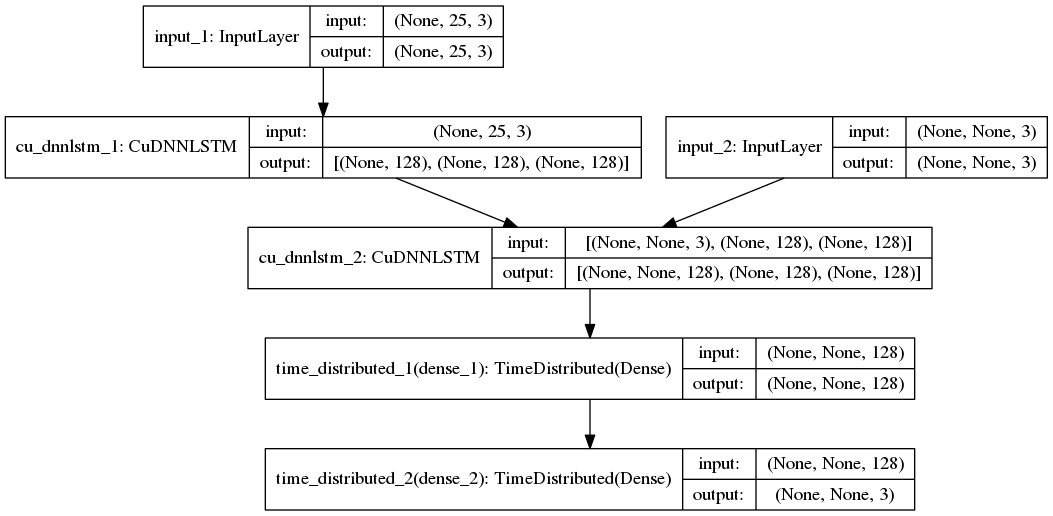

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(inputs=[encoder_inputs], outputs=encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h1 = Input(shape=(latent_dim,))
decoder_state_input_c1 = Input(shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h1, decoder_state_input_c1]

decoder_outputs_1, state_h1, state_c1 = decoder_1(decoder_inputs, initial_state=decoder_states_inputs[0:2])
decoder_states = [state_h1, state_c1]

dense_output_1 = dense_1(decoder_outputs_1)
decoder_outputs = dense_2(dense_output_1)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs,
                      outputs=[decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((len(input_seq), 1, 3))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[:, 0, :] = np.sum(input_seq[:, -n_delay:, :], axis=1)

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((len(input_seq), len_delay, 3))
    
    for i in range(len_delay):
        output, h1, c1 = decoder_model.predict([target_seq] + states_value)

        # Update the target sequence (of length 1).
        target_seq = np.zeros((len(input_seq), 1, 3))
        target_seq[:, 0, :] = output[:,0,:]
        decoded_seq[:,i,:] = output[:,0,:]

        # Update states
        states_value = [h1, c1]

    return decoded_seq

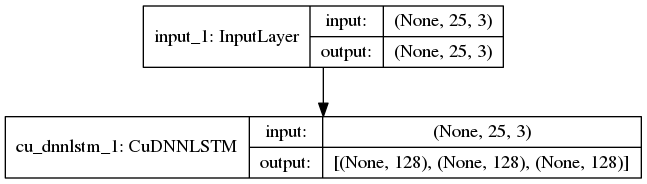

In [7]:
plot_model(encoder_model, to_file=experiment_name+'.png', show_shapes=True)

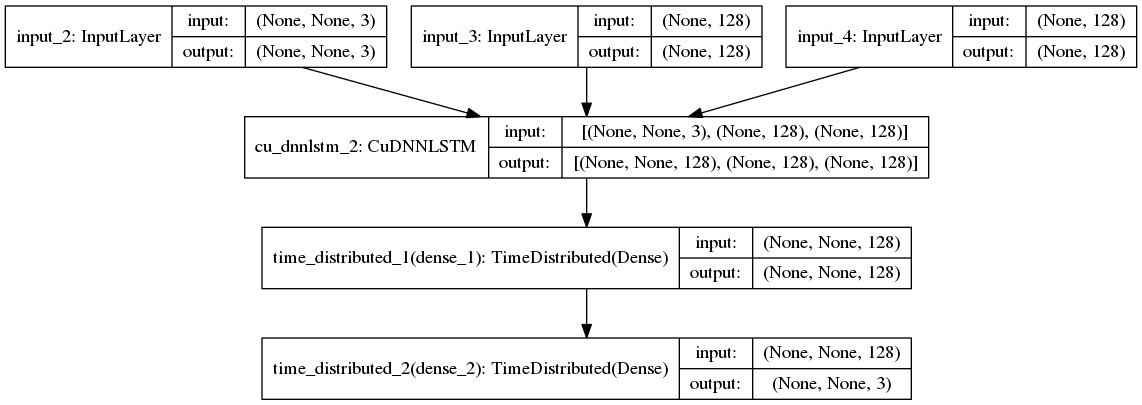

In [8]:
plot_model(decoder_model, to_file=experiment_name+'.png', show_shapes=True)

In [9]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [10]:
saliency_dir = os.path.join(dir_path, "fov_images", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(path_to_sensor_data_train)
videos = videos
print(videos)
video_width = 3840

['013_13_times_square_static.npy', '025_07_factory_robots_static.npy', '002_01_art_gallery_static.npy', '002_02_theatre_scene_static.npy', '002_03_lions_static_cuts.npy', '002_04_copenhagen_harbour_static_cuts.npy', '002_07_factory_robots_static.npy', '002_09_elephants_static.npy', '002_12_gym_workout_static.npy', '002_13_times_square_static.npy', '002_14_new_orleans_drive_motion.npy', '002_16_interview_static.npy', '002_17_weather_forecast_static.npy', '002_18_bomb_trapped_static.npy', '002_20_car_fix_static.npy', '002_23_dog_food_factory_motion.npy', '003_01_art_gallery_static.npy', '003_02_theatre_scene_static.npy', '003_03_lions_static_cuts.npy', '003_04_copenhagen_harbour_static_cuts.npy', '003_05_florida_yacht_motion.npy', '003_07_factory_robots_static.npy', '003_08_madagascar_cuts.npy', '003_09_elephants_static.npy', '003_11_lohdi_garden_india_cuts.npy', '003_12_gym_workout_static.npy', '003_13_times_square_static.npy', '003_14_new_orleans_drive_motion.npy', '003_18_bomb_trapped

In [11]:
use_generator = True
if use_generator:
    nb_epochs = 150
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_seq2seq_teacher_forcing(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_seq2seq_teacher_forcing(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

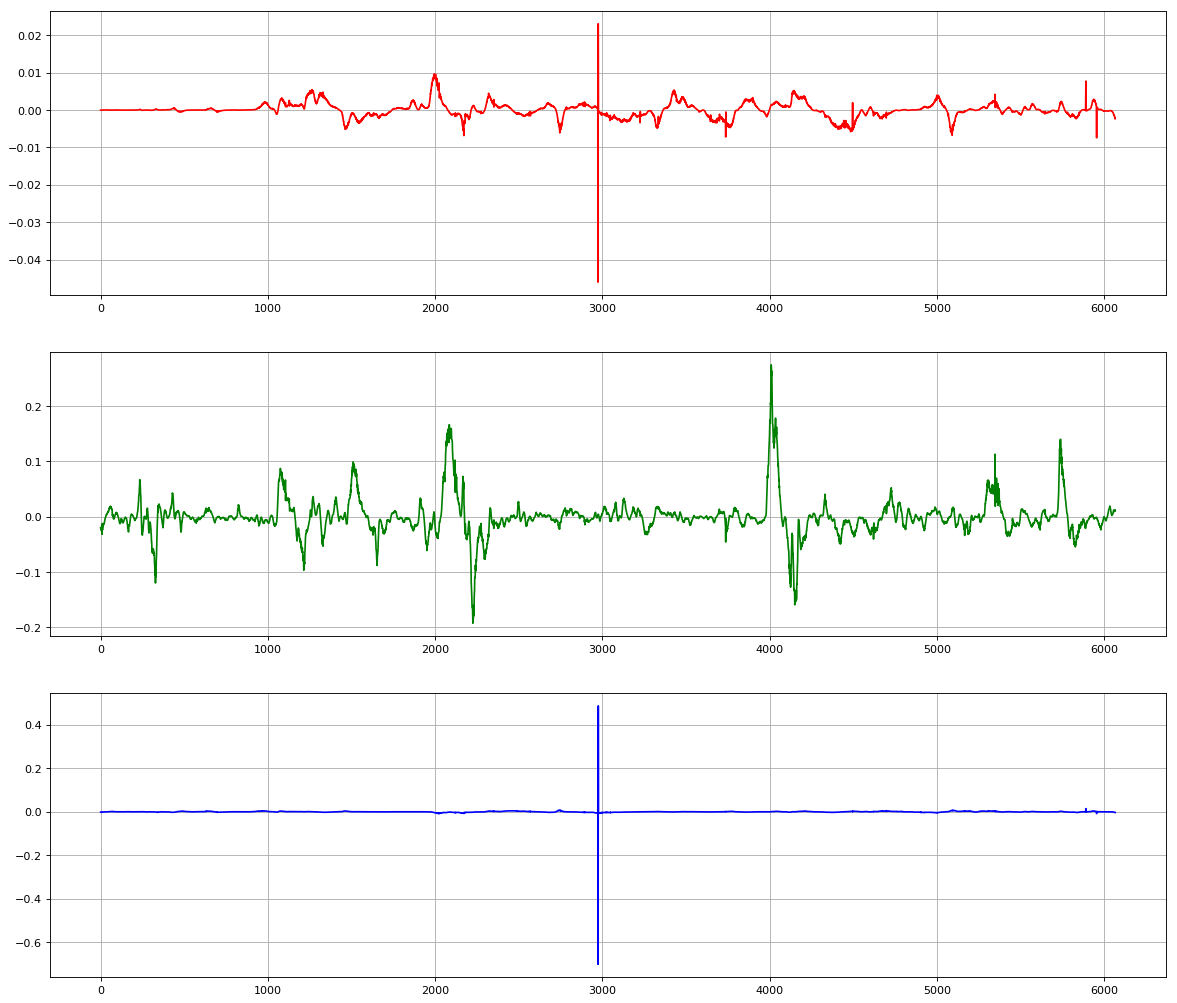

In [12]:
[encoder_input, decoder_input], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)

In [13]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=len(videos) - ind_max_train)
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/150


  1/542 [..............................] - ETA: 8:38 - loss: 0.0520 - rmse: 0.1720

  3/542 [..............................] - ETA: 3:10 - loss: 0.0649 - rmse: 0.1787

  5/542 [..............................] - ETA: 2:04 - loss: 0.0671 - rmse: 0.1939

  7/542 [..............................] - ETA: 1:35 - loss: 0.0594 - rmse: 0.1661

  8/542 [..............................] - ETA: 1:27 - loss: 0.0610 - rmse: 0.1675

 10/542 [..............................] - ETA: 1:15 - loss: 0.0584 - rmse: 0.1569

 11/542 [..............................] - ETA: 1:13 - loss: 0.0600 - rmse: 0.1602

 12/542 [..............................] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1490

 14/542 [..............................] - ETA: 1:02 - loss: 0.0550 - rmse: 0.1468

 16/542 [..............................] - ETA: 57s - loss: 0.0554 - rmse: 0.1461 

 18/542 [..............................] - ETA: 54s - loss: 0.0561 - rmse: 0.1489

 19/542 [>.............................] - ETA: 52s - loss: 0.0564 - rmse: 0.1521

 21/542 [>.............................] - ETA: 49s - loss: 0.0563 - rmse: 0.1553

 23/542 [>.............................] - ETA: 47s - loss: 0.0532 - rmse: 0.1500

 24/542 [>.............................] - ETA: 46s - loss: 0.0547 - rmse: 0.1533

 26/542 [>.............................] - ETA: 44s - loss: 0.0554 - rmse: 0.1523

 27/542 [>.............................] - ETA: 43s - loss: 0.0544 - rmse: 0.1488

 28/542 [>.............................] - ETA: 43s - loss: 0.0538 - rmse: 0.1469

 30/542 [>.............................] - ETA: 41s - loss: 0.0519 - rmse: 0.1409

 32/542 [>.............................] - ETA: 40s - loss: 0.0523 - rmse: 0.1411

 33/542 [>.............................] - ETA: 39s - loss: 0.0512 - rmse: 0.1378

 35/542 [>.............................] - ETA: 39s - loss: 0.0506 - rmse: 0.1360

 36/542 [>.............................] - ETA: 38s - loss: 0.0506 - rmse: 0.1356

 38/542 [=>............................] - ETA: 37s - loss: 0.0503 - rmse: 0.1352



 39/542 [=>............................] - ETA: 37s - loss: 0.0496 - rmse: 0.1331

 41/542 [=>............................] - ETA: 36s - loss: 0.0489 - rmse: 0.1307

 43/542 [=>............................] - ETA: 35s - loss: 0.0488 - rmse: 0.1304

 44/542 [=>............................] - ETA: 35s - loss: 0.0492 - rmse: 0.1311

 46/542 [=>............................] - ETA: 34s - loss: 0.0490 - rmse: 0.1308

 47/542 [=>............................] - ETA: 34s - loss: 0.0492 - rmse: 0.1307

 49/542 [=>............................] - ETA: 33s - loss: 0.0498 - rmse: 0.1323

 51/542 [=>............................] - ETA: 33s - loss: 0.0492 - rmse: 0.1301

 53/542 [=>............................] - ETA: 32s - loss: 0.0492 - rmse: 0.1297

 55/542 [==>...........................] - ETA: 32s - loss: 0.0486 - rmse: 0.1281

 57/542 [==>...........................] - ETA: 31s - loss: 0.0480 - rmse: 0.1271

 59/542 [==>...........................] - ETA: 31s - loss: 0.0478 - rmse: 0.1262

 61/542 [==>...........................] - ETA: 31s - loss: 0.0478 - rmse: 0.1261

 63/542 [==>...........................] - ETA: 30s - loss: 0.0480 - rmse: 0.1268

 64/542 [==>...........................] - ETA: 30s - loss: 0.0474 - rmse: 0.1253

 66/542 [==>...........................] - ETA: 30s - loss: 0.0469 - rmse: 0.1236

 68/542 [==>...........................] - ETA: 29s - loss: 0.0467 - rmse: 0.1234

 70/542 [==>...........................] - ETA: 29s - loss: 0.0468 - rmse: 0.1236

 72/542 [==>...........................] - ETA: 29s - loss: 0.0472 - rmse: 0.1244

 73/542 [===>..........................] - ETA: 29s - loss: 0.0471 - rmse: 0.1243

 75/542 [===>..........................] - ETA: 28s - loss: 0.0468 - rmse: 0.1236

 77/542 [===>..........................] - ETA: 28s - loss: 0.0469 - rmse: 0.1243

 78/542 [===>..........................] - ETA: 28s - loss: 0.0467 - rmse: 0.1236

 79/542 [===>..........................] - ETA: 28s - loss: 0.0469 - rmse: 0.1242

 81/542 [===>..........................] - ETA: 27s - loss: 0.0464 - rmse: 0.1226

 83/542 [===>..........................] - ETA: 27s - loss: 0.0464 - rmse: 0.1228

 85/542 [===>..........................] - ETA: 27s - loss: 0.0462 - rmse: 0.1221

 87/542 [===>..........................] - ETA: 27s - loss: 0.0461 - rmse: 0.1220

 89/542 [===>..........................] - ETA: 26s - loss: 0.0457 - rmse: 0.1210

 91/542 [====>.........................] - ETA: 26s - loss: 0.0455 - rmse: 0.1206

 93/542 [====>.........................] - ETA: 26s - loss: 0.0452 - rmse: 0.1195

 95/542 [====>.........................] - ETA: 26s - loss: 0.0451 - rmse: 0.1188

 97/542 [====>.........................] - ETA: 25s - loss: 0.0445 - rmse: 0.1174

 99/542 [====>.........................] - ETA: 25s - loss: 0.0442 - rmse: 0.1165

101/542 [====>.........................] - ETA: 25s - loss: 0.0440 - rmse: 0.1168

102/542 [====>.........................] - ETA: 25s - loss: 0.0439 - rmse: 0.1163

104/542 [====>.........................] - ETA: 25s - loss: 0.0435 - rmse: 0.1154

106/542 [====>.........................] - ETA: 25s - loss: 0.0433 - rmse: 0.1149

108/542 [====>.........................] - ETA: 24s - loss: 0.0431 - rmse: 0.1144

110/542 [=====>........................] - ETA: 24s - loss: 0.0431 - rmse: 0.1143

112/542 [=====>........................] - ETA: 24s - loss: 0.0429 - rmse: 0.1139

114/542 [=====>........................] - ETA: 24s - loss: 0.0427 - rmse: 0.1129

116/542 [=====>........................] - ETA: 24s - loss: 0.0425 - rmse: 0.1124

117/542 [=====>........................] - ETA: 24s - loss: 0.0427 - rmse: 0.1128

119/542 [=====>........................] - ETA: 23s - loss: 0.0426 - rmse: 0.1126

121/542 [=====>........................] - ETA: 23s - loss: 0.0424 - rmse: 0.1120

123/542 [=====>........................] - ETA: 23s - loss: 0.0425 - rmse: 0.1121

125/542 [=====>........................] - ETA: 23s - loss: 0.0424 - rmse: 0.1119

127/542 [======>.......................] - ETA: 23s - loss: 0.0424 - rmse: 0.1119

128/542 [======>.......................] - ETA: 23s - loss: 0.0424 - rmse: 0.1118

130/542 [======>.......................] - ETA: 22s - loss: 0.0424 - rmse: 0.1119

132/542 [======>.......................] - ETA: 22s - loss: 0.0423 - rmse: 0.1114

134/542 [======>.......................] - ETA: 22s - loss: 0.0421 - rmse: 0.1109

136/542 [======>.......................] - ETA: 22s - loss: 0.0421 - rmse: 0.1109

138/542 [======>.......................] - ETA: 22s - loss: 0.0419 - rmse: 0.1103

140/542 [======>.......................] - ETA: 22s - loss: 0.0419 - rmse: 0.1102

142/542 [======>.......................] - ETA: 21s - loss: 0.0418 - rmse: 0.1099

144/542 [======>.......................] - ETA: 21s - loss: 0.0416 - rmse: 0.1095

145/542 [=======>......................] - ETA: 21s - loss: 0.0416 - rmse: 0.1095

147/542 [=======>......................] - ETA: 21s - loss: 0.0415 - rmse: 0.1093

149/542 [=======>......................] - ETA: 21s - loss: 0.0414 - rmse: 0.1089

151/542 [=======>......................] - ETA: 21s - loss: 0.0412 - rmse: 0.1083

153/542 [=======>......................] - ETA: 21s - loss: 0.0412 - rmse: 0.1084

155/542 [=======>......................] - ETA: 21s - loss: 0.0413 - rmse: 0.1085

156/542 [=======>......................] - ETA: 20s - loss: 0.0411 - rmse: 0.1080

158/542 [=======>......................] - ETA: 20s - loss: 0.0410 - rmse: 0.1077

160/542 [=======>......................] - ETA: 20s - loss: 0.0410 - rmse: 0.1079

162/542 [=======>......................] - ETA: 20s - loss: 0.0408 - rmse: 0.1075

164/542 [========>.....................] - ETA: 20s - loss: 0.0407 - rmse: 0.1071

166/542 [========>.....................] - ETA: 20s - loss: 0.0406 - rmse: 0.1069

168/542 [========>.....................] - ETA: 20s - loss: 0.0402 - rmse: 0.1059

170/542 [========>.....................] - ETA: 19s - loss: 0.0402 - rmse: 0.1059

171/542 [========>.....................] - ETA: 19s - loss: 0.0402 - rmse: 0.1058

173/542 [========>.....................] - ETA: 19s - loss: 0.0403 - rmse: 0.1060

175/542 [========>.....................] - ETA: 19s - loss: 0.0403 - rmse: 0.1059

176/542 [========>.....................] - ETA: 19s - loss: 0.0402 - rmse: 0.1057

178/542 [========>.....................] - ETA: 19s - loss: 0.0400 - rmse: 0.1052

180/542 [========>.....................] - ETA: 19s - loss: 0.0401 - rmse: 0.1054

181/542 [=========>....................] - ETA: 19s - loss: 0.0400 - rmse: 0.1053

183/542 [=========>....................] - ETA: 19s - loss: 0.0399 - rmse: 0.1047

185/542 [=========>....................] - ETA: 18s - loss: 0.0397 - rmse: 0.1043

187/542 [=========>....................] - ETA: 18s - loss: 0.0396 - rmse: 0.1041

188/542 [=========>....................] - ETA: 18s - loss: 0.0396 - rmse: 0.1042

190/542 [=========>....................] - ETA: 18s - loss: 0.0396 - rmse: 0.1040

192/542 [=========>....................] - ETA: 18s - loss: 0.0395 - rmse: 0.1037

194/542 [=========>....................] - ETA: 18s - loss: 0.0393 - rmse: 0.1032

196/542 [=========>....................] - ETA: 18s - loss: 0.0391 - rmse: 0.1026

198/542 [=========>....................] - ETA: 18s - loss: 0.0391 - rmse: 0.1025

199/542 [==========>...................] - ETA: 18s - loss: 0.0390 - rmse: 0.1024

201/542 [==========>...................] - ETA: 17s - loss: 0.0389 - rmse: 0.1020

202/542 [==========>...................] - ETA: 17s - loss: 0.0389 - rmse: 0.1020

204/542 [==========>...................] - ETA: 17s - loss: 0.0389 - rmse: 0.1019

206/542 [==========>...................] - ETA: 17s - loss: 0.0389 - rmse: 0.1019

208/542 [==========>...................] - ETA: 17s - loss: 0.0387 - rmse: 0.1015

210/542 [==========>...................] - ETA: 17s - loss: 0.0386 - rmse: 0.1011

212/542 [==========>...................] - ETA: 17s - loss: 0.0385 - rmse: 0.1012

214/542 [==========>...................] - ETA: 17s - loss: 0.0385 - rmse: 0.1010

216/542 [==========>...................] - ETA: 17s - loss: 0.0384 - rmse: 0.1005

218/542 [===========>..................] - ETA: 16s - loss: 0.0383 - rmse: 0.1004

220/542 [===========>..................] - ETA: 16s - loss: 0.0382 - rmse: 0.1002

222/542 [===========>..................] - ETA: 16s - loss: 0.0382 - rmse: 0.1000

224/542 [===========>..................] - ETA: 16s - loss: 0.0382 - rmse: 0.0999

226/542 [===========>..................] - ETA: 16s - loss: 0.0382 - rmse: 0.0998

228/542 [===========>..................] - ETA: 16s - loss: 0.0381 - rmse: 0.0995

230/542 [===========>..................] - ETA: 16s - loss: 0.0382 - rmse: 0.0996

232/542 [===========>..................] - ETA: 16s - loss: 0.0380 - rmse: 0.0993

234/542 [===========>..................] - ETA: 15s - loss: 0.0379 - rmse: 0.0989

236/542 [============>.................] - ETA: 15s - loss: 0.0378 - rmse: 0.0986

238/542 [============>.................] - ETA: 15s - loss: 0.0377 - rmse: 0.0983

239/542 [============>.................] - ETA: 15s - loss: 0.0377 - rmse: 0.0982

240/542 [============>.................] - ETA: 15s - loss: 0.0376 - rmse: 0.0980

242/542 [============>.................] - ETA: 15s - loss: 0.0376 - rmse: 0.0980

244/542 [============>.................] - ETA: 15s - loss: 0.0376 - rmse: 0.0979

246/542 [============>.................] - ETA: 15s - loss: 0.0376 - rmse: 0.0977

248/542 [============>.................] - ETA: 15s - loss: 0.0374 - rmse: 0.0972

250/542 [============>.................] - ETA: 14s - loss: 0.0373 - rmse: 0.0969

252/542 [============>.................] - ETA: 14s - loss: 0.0372 - rmse: 0.0967

254/542 [=============>................] - ETA: 14s - loss: 0.0371 - rmse: 0.0964

255/542 [=============>................] - ETA: 14s - loss: 0.0371 - rmse: 0.0964

256/542 [=============>................] - ETA: 14s - loss: 0.0370 - rmse: 0.0962

257/542 [=============>................] - ETA: 14s - loss: 0.0369 - rmse: 0.0959

259/542 [=============>................] - ETA: 14s - loss: 0.0369 - rmse: 0.0960

260/542 [=============>................] - ETA: 14s - loss: 0.0369 - rmse: 0.0959

262/542 [=============>................] - ETA: 14s - loss: 0.0369 - rmse: 0.0960

264/542 [=============>................] - ETA: 14s - loss: 0.0371 - rmse: 0.0963

266/542 [=============>................] - ETA: 14s - loss: 0.0369 - rmse: 0.0959

268/542 [=============>................] - ETA: 13s - loss: 0.0368 - rmse: 0.0959

270/542 [=============>................] - ETA: 13s - loss: 0.0368 - rmse: 0.0958

272/542 [==============>...............] - ETA: 13s - loss: 0.0369 - rmse: 0.0959

274/542 [==============>...............] - ETA: 13s - loss: 0.0368 - rmse: 0.0959

276/542 [==============>...............] - ETA: 13s - loss: 0.0367 - rmse: 0.0956

278/542 [==============>...............] - ETA: 13s - loss: 0.0366 - rmse: 0.0954

280/542 [==============>...............] - ETA: 13s - loss: 0.0366 - rmse: 0.0953

282/542 [==============>...............] - ETA: 13s - loss: 0.0366 - rmse: 0.0953

283/542 [==============>...............] - ETA: 13s - loss: 0.0366 - rmse: 0.0952

285/542 [==============>...............] - ETA: 13s - loss: 0.0365 - rmse: 0.0952

287/542 [==============>...............] - ETA: 12s - loss: 0.0365 - rmse: 0.0951

289/542 [==============>...............] - ETA: 12s - loss: 0.0364 - rmse: 0.0950

291/542 [===============>..............] - ETA: 12s - loss: 0.0364 - rmse: 0.0947

293/542 [===============>..............] - ETA: 12s - loss: 0.0363 - rmse: 0.0945

295/542 [===============>..............] - ETA: 12s - loss: 0.0364 - rmse: 0.0947

297/542 [===============>..............] - ETA: 12s - loss: 0.0363 - rmse: 0.0945

299/542 [===============>..............] - ETA: 12s - loss: 0.0362 - rmse: 0.0943

300/542 [===============>..............] - ETA: 12s - loss: 0.0362 - rmse: 0.0943

302/542 [===============>..............] - ETA: 12s - loss: 0.0361 - rmse: 0.0941

304/542 [===============>..............] - ETA: 12s - loss: 0.0361 - rmse: 0.0941

305/542 [===============>..............] - ETA: 11s - loss: 0.0361 - rmse: 0.0940

307/542 [===============>..............] - ETA: 11s - loss: 0.0360 - rmse: 0.0937

309/542 [================>.............] - ETA: 11s - loss: 0.0360 - rmse: 0.0938

310/542 [================>.............] - ETA: 11s - loss: 0.0360 - rmse: 0.0937

312/542 [================>.............] - ETA: 11s - loss: 0.0359 - rmse: 0.0936

313/542 [================>.............] - ETA: 11s - loss: 0.0359 - rmse: 0.0935

315/542 [================>.............] - ETA: 11s - loss: 0.0359 - rmse: 0.0935

317/542 [================>.............] - ETA: 11s - loss: 0.0359 - rmse: 0.0934

319/542 [================>.............] - ETA: 11s - loss: 0.0359 - rmse: 0.0933

320/542 [================>.............] - ETA: 11s - loss: 0.0359 - rmse: 0.0935

322/542 [================>.............] - ETA: 11s - loss: 0.0359 - rmse: 0.0933

324/542 [================>.............] - ETA: 10s - loss: 0.0360 - rmse: 0.0935

326/542 [=================>............] - ETA: 10s - loss: 0.0359 - rmse: 0.0934

328/542 [=================>............] - ETA: 10s - loss: 0.0358 - rmse: 0.0931

330/542 [=================>............] - ETA: 10s - loss: 0.0358 - rmse: 0.0930

332/542 [=================>............] - ETA: 10s - loss: 0.0358 - rmse: 0.0930

334/542 [=================>............] - ETA: 10s - loss: 0.0357 - rmse: 0.0930

335/542 [=================>............] - ETA: 10s - loss: 0.0357 - rmse: 0.0928

336/542 [=================>............] - ETA: 10s - loss: 0.0356 - rmse: 0.0927

337/542 [=================>............] - ETA: 10s - loss: 0.0356 - rmse: 0.0929

339/542 [=================>............] - ETA: 10s - loss: 0.0356 - rmse: 0.0927

341/542 [=================>............] - ETA: 10s - loss: 0.0356 - rmse: 0.0927

342/542 [=================>............] - ETA: 10s - loss: 0.0356 - rmse: 0.0927

344/542 [==================>...........] - ETA: 9s - loss: 0.0355 - rmse: 0.0925 

346/542 [==================>...........] - ETA: 9s - loss: 0.0355 - rmse: 0.0923

348/542 [==================>...........] - ETA: 9s - loss: 0.0355 - rmse: 0.0924

349/542 [==================>...........] - ETA: 9s - loss: 0.0355 - rmse: 0.0923

351/542 [==================>...........] - ETA: 9s - loss: 0.0355 - rmse: 0.0925

353/542 [==================>...........] - ETA: 9s - loss: 0.0355 - rmse: 0.0923

355/542 [==================>...........] - ETA: 9s - loss: 0.0354 - rmse: 0.0922

357/542 [==================>...........] - ETA: 9s - loss: 0.0354 - rmse: 0.0922

359/542 [==================>...........] - ETA: 9s - loss: 0.0353 - rmse: 0.0919

361/542 [==================>...........] - ETA: 9s - loss: 0.0353 - rmse: 0.0917

363/542 [===================>..........] - ETA: 8s - loss: 0.0352 - rmse: 0.0916

364/542 [===================>..........] - ETA: 8s - loss: 0.0351 - rmse: 0.0915

366/542 [===================>..........] - ETA: 8s - loss: 0.0352 - rmse: 0.0916

368/542 [===================>..........] - ETA: 8s - loss: 0.0352 - rmse: 0.0918

370/542 [===================>..........] - ETA: 8s - loss: 0.0352 - rmse: 0.0916

372/542 [===================>..........] - ETA: 8s - loss: 0.0352 - rmse: 0.0917

374/542 [===================>..........] - ETA: 8s - loss: 0.0352 - rmse: 0.0917

376/542 [===================>..........] - ETA: 8s - loss: 0.0353 - rmse: 0.0918

378/542 [===================>..........] - ETA: 8s - loss: 0.0352 - rmse: 0.0918

380/542 [====================>.........] - ETA: 8s - loss: 0.0352 - rmse: 0.0916

381/542 [====================>.........] - ETA: 8s - loss: 0.0351 - rmse: 0.0915

383/542 [====================>.........] - ETA: 7s - loss: 0.0352 - rmse: 0.0916

385/542 [====================>.........] - ETA: 7s - loss: 0.0352 - rmse: 0.0916

387/542 [====================>.........] - ETA: 7s - loss: 0.0351 - rmse: 0.0915

388/542 [====================>.........] - ETA: 7s - loss: 0.0351 - rmse: 0.0915

390/542 [====================>.........] - ETA: 7s - loss: 0.0350 - rmse: 0.0913

392/542 [====================>.........] - ETA: 7s - loss: 0.0350 - rmse: 0.0912

394/542 [====================>.........] - ETA: 7s - loss: 0.0349 - rmse: 0.0911

396/542 [====================>.........] - ETA: 7s - loss: 0.0349 - rmse: 0.0912

398/542 [=====================>........] - ETA: 7s - loss: 0.0349 - rmse: 0.0910

400/542 [=====================>........] - ETA: 7s - loss: 0.0348 - rmse: 0.0910

402/542 [=====================>........] - ETA: 6s - loss: 0.0348 - rmse: 0.0908

404/542 [=====================>........] - ETA: 6s - loss: 0.0347 - rmse: 0.0906

405/542 [=====================>........] - ETA: 6s - loss: 0.0346 - rmse: 0.0905

407/542 [=====================>........] - ETA: 6s - loss: 0.0347 - rmse: 0.0906

409/542 [=====================>........] - ETA: 6s - loss: 0.0347 - rmse: 0.0906

410/542 [=====================>........] - ETA: 6s - loss: 0.0347 - rmse: 0.0906

412/542 [=====================>........] - ETA: 6s - loss: 0.0346 - rmse: 0.0904

413/542 [=====================>........] - ETA: 6s - loss: 0.0346 - rmse: 0.0903

415/542 [=====================>........] - ETA: 6s - loss: 0.0346 - rmse: 0.0903

417/542 [======================>.......] - ETA: 6s - loss: 0.0345 - rmse: 0.0902

419/542 [======================>.......] - ETA: 6s - loss: 0.0346 - rmse: 0.0903

421/542 [======================>.......] - ETA: 6s - loss: 0.0345 - rmse: 0.0901

423/542 [======================>.......] - ETA: 5s - loss: 0.0344 - rmse: 0.0899

425/542 [======================>.......] - ETA: 5s - loss: 0.0343 - rmse: 0.0898

426/542 [======================>.......] - ETA: 5s - loss: 0.0343 - rmse: 0.0898

428/542 [======================>.......] - ETA: 5s - loss: 0.0343 - rmse: 0.0896

430/542 [======================>.......] - ETA: 5s - loss: 0.0342 - rmse: 0.0895

431/542 [======================>.......] - ETA: 5s - loss: 0.0342 - rmse: 0.0894

433/542 [======================>.......] - ETA: 5s - loss: 0.0342 - rmse: 0.0894

435/542 [=======================>......] - ETA: 5s - loss: 0.0341 - rmse: 0.0893

437/542 [=======================>......] - ETA: 5s - loss: 0.0342 - rmse: 0.0894

439/542 [=======================>......] - ETA: 5s - loss: 0.0341 - rmse: 0.0892

441/542 [=======================>......] - ETA: 5s - loss: 0.0341 - rmse: 0.0891

443/542 [=======================>......] - ETA: 4s - loss: 0.0341 - rmse: 0.0893

445/542 [=======================>......] - ETA: 4s - loss: 0.0341 - rmse: 0.0892

447/542 [=======================>......] - ETA: 4s - loss: 0.0341 - rmse: 0.0893

449/542 [=======================>......] - ETA: 4s - loss: 0.0341 - rmse: 0.0893

450/542 [=======================>......] - ETA: 4s - loss: 0.0342 - rmse: 0.0893

452/542 [========================>.....] - ETA: 4s - loss: 0.0342 - rmse: 0.0892

453/542 [========================>.....] - ETA: 4s - loss: 0.0342 - rmse: 0.0893

455/542 [========================>.....] - ETA: 4s - loss: 0.0341 - rmse: 0.0891

457/542 [========================>.....] - ETA: 4s - loss: 0.0341 - rmse: 0.0890

459/542 [========================>.....] - ETA: 4s - loss: 0.0340 - rmse: 0.0889

460/542 [========================>.....] - ETA: 4s - loss: 0.0340 - rmse: 0.0888

462/542 [========================>.....] - ETA: 3s - loss: 0.0340 - rmse: 0.0888

464/542 [========================>.....] - ETA: 3s - loss: 0.0340 - rmse: 0.0888

465/542 [========================>.....] - ETA: 3s - loss: 0.0339 - rmse: 0.0887

467/542 [========================>.....] - ETA: 3s - loss: 0.0339 - rmse: 0.0888

469/542 [========================>.....] - ETA: 3s - loss: 0.0339 - rmse: 0.0886

471/542 [=========================>....] - ETA: 3s - loss: 0.0339 - rmse: 0.0885

473/542 [=========================>....] - ETA: 3s - loss: 0.0338 - rmse: 0.0884

475/542 [=========================>....] - ETA: 3s - loss: 0.0338 - rmse: 0.0884

476/542 [=========================>....] - ETA: 3s - loss: 0.0338 - rmse: 0.0883

478/542 [=========================>....] - ETA: 3s - loss: 0.0338 - rmse: 0.0884

479/542 [=========================>....] - ETA: 3s - loss: 0.0338 - rmse: 0.0884

480/542 [=========================>....] - ETA: 3s - loss: 0.0337 - rmse: 0.0882

482/542 [=========================>....] - ETA: 2s - loss: 0.0337 - rmse: 0.0882

484/542 [=========================>....] - ETA: 2s - loss: 0.0337 - rmse: 0.0882

485/542 [=========================>....] - ETA: 2s - loss: 0.0337 - rmse: 0.0881

487/542 [=========================>....] - ETA: 2s - loss: 0.0337 - rmse: 0.0881

489/542 [==========================>...] - ETA: 2s - loss: 0.0337 - rmse: 0.0881

490/542 [==========================>...] - ETA: 2s - loss: 0.0337 - rmse: 0.0881

492/542 [==========================>...] - ETA: 2s - loss: 0.0336 - rmse: 0.0880

494/542 [==========================>...] - ETA: 2s - loss: 0.0336 - rmse: 0.0879

496/542 [==========================>...] - ETA: 2s - loss: 0.0336 - rmse: 0.0877

498/542 [==========================>...] - ETA: 2s - loss: 0.0336 - rmse: 0.0878

500/542 [==========================>...] - ETA: 2s - loss: 0.0336 - rmse: 0.0878

502/542 [==========================>...] - ETA: 1s - loss: 0.0336 - rmse: 0.0878

504/542 [==========================>...] - ETA: 1s - loss: 0.0336 - rmse: 0.0879

506/542 [===========================>..] - ETA: 1s - loss: 0.0335 - rmse: 0.0877

508/542 [===========================>..] - ETA: 1s - loss: 0.0335 - rmse: 0.0877

509/542 [===========================>..] - ETA: 1s - loss: 0.0335 - rmse: 0.0877

510/542 [===========================>..] - ETA: 1s - loss: 0.0335 - rmse: 0.0877

512/542 [===========================>..] - ETA: 1s - loss: 0.0335 - rmse: 0.0879

513/542 [===========================>..] - ETA: 1s - loss: 0.0335 - rmse: 0.0878

514/542 [===========================>..] - ETA: 1s - loss: 0.0335 - rmse: 0.0878

516/542 [===========================>..] - ETA: 1s - loss: 0.0335 - rmse: 0.0877

518/542 [===========================>..] - ETA: 1s - loss: 0.0335 - rmse: 0.0878

520/542 [===========================>..] - ETA: 1s - loss: 0.0335 - rmse: 0.0877

521/542 [===========================>..] - ETA: 1s - loss: 0.0334 - rmse: 0.0877

522/542 [===========================>..] - ETA: 0s - loss: 0.0335 - rmse: 0.0878

523/542 [===========================>..] - ETA: 0s - loss: 0.0335 - rmse: 0.0878

525/542 [============================>.] - ETA: 0s - loss: 0.0335 - rmse: 0.0878

527/542 [============================>.] - ETA: 0s - loss: 0.0334 - rmse: 0.0876

529/542 [============================>.] - ETA: 0s - loss: 0.0334 - rmse: 0.0875

531/542 [============================>.] - ETA: 0s - loss: 0.0333 - rmse: 0.0874

532/542 [============================>.] - ETA: 0s - loss: 0.0333 - rmse: 0.0873

533/542 [============================>.] - ETA: 0s - loss: 0.0333 - rmse: 0.0874

535/542 [============================>.] - ETA: 0s - loss: 0.0333 - rmse: 0.0873

536/542 [============================>.] - ETA: 0s - loss: 0.0333 - rmse: 0.0873

537/542 [============================>.] - ETA: 0s - loss: 0.0333 - rmse: 0.0872

539/542 [============================>.] - ETA: 0s - loss: 0.0332 - rmse: 0.0871

541/542 [============================>.] - ETA: 0s - loss: 0.0332 - rmse: 0.0872

542/542 [==============================] - 31s 58ms/step - loss: 0.0332 - rmse: 0.0871 - val_loss: 0.0304 - val_rmse: 0.0840


Epoch 2/150
  1/542 [..............................] - ETA: 26s - loss: 0.0241 - rmse: 0.0703

/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


  3/542 [..............................] - ETA: 23s - loss: 0.0219 - rmse: 0.0554

  5/542 [..............................] - ETA: 24s - loss: 0.0181 - rmse: 0.0486

  7/542 [..............................] - ETA: 24s - loss: 0.0204 - rmse: 0.0533

  9/542 [..............................] - ETA: 24s - loss: 0.0207 - rmse: 0.0550

 10/542 [..............................] - ETA: 25s - loss: 0.0213 - rmse: 0.0572

 12/542 [..............................] - ETA: 25s - loss: 0.0218 - rmse: 0.0573

 13/542 [..............................] - ETA: 25s - loss: 0.0216 - rmse: 0.0585

 15/542 [..............................] - ETA: 25s - loss: 0.0221 - rmse: 0.0598



 16/542 [..............................] - ETA: 25s - loss: 0.0239 - rmse: 0.0665

 17/542 [..............................] - ETA: 27s - loss: 0.0237 - rmse: 0.0658

 18/542 [..............................] - ETA: 29s - loss: 0.0240 - rmse: 0.0667

 19/542 [>.............................] - ETA: 31s - loss: 0.0238 - rmse: 0.0661

 20/542 [>.............................] - ETA: 33s - loss: 0.0243 - rmse: 0.0680

 21/542 [>.............................] - ETA: 33s - loss: 0.0247 - rmse: 0.0686

 22/542 [>.............................] - ETA: 33s - loss: 0.0245 - rmse: 0.0683

 24/542 [>.............................] - ETA: 32s - loss: 0.0249 - rmse: 0.0688

 26/542 [>.............................] - ETA: 31s - loss: 0.0247 - rmse: 0.0690

 28/542 [>.............................] - ETA: 31s - loss: 0.0248 - rmse: 0.0690

 30/542 [>.............................] - ETA: 30s - loss: 0.0246 - rmse: 0.0682

 31/542 [>.............................] - ETA: 30s - loss: 0.0247 - rmse: 0.0687

 33/542 [>.............................] - ETA: 30s - loss: 0.0244 - rmse: 0.0675

 35/542 [>.............................] - ETA: 29s - loss: 0.0254 - rmse: 0.0695

 37/542 [=>............................] - ETA: 29s - loss: 0.0257 - rmse: 0.0698

 39/542 [=>............................] - ETA: 28s - loss: 0.0253 - rmse: 0.0687

 41/542 [=>............................] - ETA: 28s - loss: 0.0257 - rmse: 0.0696

 43/542 [=>............................] - ETA: 27s - loss: 0.0260 - rmse: 0.0703

 45/542 [=>............................] - ETA: 27s - loss: 0.0261 - rmse: 0.0706

 47/542 [=>............................] - ETA: 27s - loss: 0.0263 - rmse: 0.0708

 49/542 [=>............................] - ETA: 26s - loss: 0.0265 - rmse: 0.0715

 51/542 [=>............................] - ETA: 26s - loss: 0.0263 - rmse: 0.0708

 52/542 [=>............................] - ETA: 26s - loss: 0.0263 - rmse: 0.0711

 54/542 [=>............................] - ETA: 26s - loss: 0.0259 - rmse: 0.0699

 55/542 [==>...........................] - ETA: 26s - loss: 0.0259 - rmse: 0.0699

 57/542 [==>...........................] - ETA: 26s - loss: 0.0260 - rmse: 0.0703

 59/542 [==>...........................] - ETA: 26s - loss: 0.0258 - rmse: 0.0699

 61/542 [==>...........................] - ETA: 25s - loss: 0.0258 - rmse: 0.0699

 63/542 [==>...........................] - ETA: 25s - loss: 0.0264 - rmse: 0.0718

 65/542 [==>...........................] - ETA: 25s - loss: 0.0263 - rmse: 0.0715

 67/542 [==>...........................] - ETA: 25s - loss: 0.0266 - rmse: 0.0727

 69/542 [==>...........................] - ETA: 25s - loss: 0.0269 - rmse: 0.0733

 71/542 [==>...........................] - ETA: 24s - loss: 0.0269 - rmse: 0.0740

 73/542 [===>..........................] - ETA: 24s - loss: 0.0268 - rmse: 0.0737

 75/542 [===>..........................] - ETA: 24s - loss: 0.0267 - rmse: 0.0734

 77/542 [===>..........................] - ETA: 24s - loss: 0.0266 - rmse: 0.0731

 79/542 [===>..........................] - ETA: 24s - loss: 0.0267 - rmse: 0.0734

 81/542 [===>..........................] - ETA: 23s - loss: 0.0266 - rmse: 0.0729

 83/542 [===>..........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0730

 84/542 [===>..........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0731

 85/542 [===>..........................] - ETA: 23s - loss: 0.0263 - rmse: 0.0728

 87/542 [===>..........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0731

 89/542 [===>..........................] - ETA: 23s - loss: 0.0263 - rmse: 0.0729

 91/542 [====>.........................] - ETA: 23s - loss: 0.0261 - rmse: 0.0723

 93/542 [====>.........................] - ETA: 23s - loss: 0.0263 - rmse: 0.0727

 95/542 [====>.........................] - ETA: 22s - loss: 0.0263 - rmse: 0.0726

 97/542 [====>.........................] - ETA: 22s - loss: 0.0263 - rmse: 0.0725

 99/542 [====>.........................] - ETA: 22s - loss: 0.0263 - rmse: 0.0723

101/542 [====>.........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0725

103/542 [====>.........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0732

105/542 [====>.........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0728

107/542 [====>.........................] - ETA: 22s - loss: 0.0263 - rmse: 0.0727

109/542 [=====>........................] - ETA: 21s - loss: 0.0264 - rmse: 0.0729

111/542 [=====>........................] - ETA: 21s - loss: 0.0265 - rmse: 0.0728

113/542 [=====>........................] - ETA: 21s - loss: 0.0264 - rmse: 0.0729

115/542 [=====>........................] - ETA: 21s - loss: 0.0265 - rmse: 0.0728

116/542 [=====>........................] - ETA: 21s - loss: 0.0266 - rmse: 0.0730

118/542 [=====>........................] - ETA: 21s - loss: 0.0267 - rmse: 0.0732

120/542 [=====>........................] - ETA: 21s - loss: 0.0268 - rmse: 0.0736

121/542 [=====>........................] - ETA: 21s - loss: 0.0268 - rmse: 0.0736

123/542 [=====>........................] - ETA: 20s - loss: 0.0270 - rmse: 0.0741

125/542 [=====>........................] - ETA: 20s - loss: 0.0270 - rmse: 0.0744

127/542 [======>.......................] - ETA: 20s - loss: 0.0271 - rmse: 0.0746

129/542 [======>.......................] - ETA: 20s - loss: 0.0271 - rmse: 0.0747

131/542 [======>.......................] - ETA: 20s - loss: 0.0271 - rmse: 0.0745

133/542 [======>.......................] - ETA: 20s - loss: 0.0272 - rmse: 0.0748

134/542 [======>.......................] - ETA: 20s - loss: 0.0273 - rmse: 0.0752

136/542 [======>.......................] - ETA: 20s - loss: 0.0273 - rmse: 0.0753

138/542 [======>.......................] - ETA: 20s - loss: 0.0271 - rmse: 0.0747

140/542 [======>.......................] - ETA: 19s - loss: 0.0272 - rmse: 0.0749

142/542 [======>.......................] - ETA: 19s - loss: 0.0271 - rmse: 0.0748

144/542 [======>.......................] - ETA: 19s - loss: 0.0269 - rmse: 0.0743

146/542 [=======>......................] - ETA: 19s - loss: 0.0269 - rmse: 0.0742

148/542 [=======>......................] - ETA: 19s - loss: 0.0268 - rmse: 0.0739

149/542 [=======>......................] - ETA: 19s - loss: 0.0268 - rmse: 0.0738

151/542 [=======>......................] - ETA: 19s - loss: 0.0269 - rmse: 0.0740

153/542 [=======>......................] - ETA: 19s - loss: 0.0268 - rmse: 0.0736

155/542 [=======>......................] - ETA: 19s - loss: 0.0268 - rmse: 0.0736

156/542 [=======>......................] - ETA: 19s - loss: 0.0268 - rmse: 0.0736

157/542 [=======>......................]

 - ETA: 18s - loss: 0.0268 - rmse: 0.0735

158/542 [=======>......................] - ETA: 18s - loss: 0.0267 - rmse: 0.0734

159/542 [=======>......................] - ETA: 18s - loss: 0.0266 - rmse: 0.0731

160/542 [=======>......................] - ETA: 18s - loss: 0.0268 - rmse: 0.0735

162/542 [=======>......................] - ETA: 18s - loss: 0.0267 - rmse: 0.0734

163/542 [========>.....................] - ETA: 18s - loss: 0.0268 - rmse: 0.0738

164/542 [========>.....................] - ETA: 18s - loss: 0.0268 - rmse: 0.0736

166/542 [========>.....................] - ETA: 18s - loss: 0.0268 - rmse: 0.0736

168/542 [========>.....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0732

170/542 [========>.....................] - ETA: 18s - loss: 0.0267 - rmse: 0.0733

172/542 [========>.....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0730

173/542 [========>.....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0731

175/542 [========>.....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0730

177/542 [========>.....................] - ETA: 17s - loss: 0.0265 - rmse: 0.0727

179/542 [========>.....................] - ETA: 17s - loss: 0.0264 - rmse: 0.0727

181/542 [=========>....................] - ETA: 17s - loss: 0.0263 - rmse: 0.0724

182/542 [=========>....................] - ETA: 17s - loss: 0.0264 - rmse: 0.0728

184/542 [=========>....................] - ETA: 17s - loss: 0.0264 - rmse: 0.0725

186/542 [=========>....................] - ETA: 17s - loss: 0.0263 - rmse: 0.0724

188/542 [=========>....................] - ETA: 17s - loss: 0.0263 - rmse: 0.0722

190/542 [=========>....................] - ETA: 17s - loss: 0.0264 - rmse: 0.0723

192/542 [=========>....................] - ETA: 17s - loss: 0.0263 - rmse: 0.0721

193/542 [=========>....................] - ETA: 17s - loss: 0.0262 - rmse: 0.0719

195/542 [=========>....................] - ETA: 16s - loss: 0.0264 - rmse: 0.0721

197/542 [=========>....................] - ETA: 16s - loss: 0.0264 - rmse: 0.0722

198/542 [=========>....................] - ETA: 16s - loss: 0.0264 - rmse: 0.0721

200/542 [==========>...................] - ETA: 16s - loss: 0.0264 - rmse: 0.0723

201/542 [==========>...................] - ETA: 16s - loss: 0.0264 - rmse: 0.0724

202/542 [==========>...................] - ETA: 16s - loss: 0.0265 - rmse: 0.0725

204/542 [==========>...................] - ETA: 16s - loss: 0.0264 - rmse: 0.0724

206/542 [==========>...................] - ETA: 16s - loss: 0.0265 - rmse: 0.0726

208/542 [==========>...................] - ETA: 16s - loss: 0.0265 - rmse: 0.0725

209/542 [==========>...................] - ETA: 16s - loss: 0.0265 - rmse: 0.0724

211/542 [==========>...................] - ETA: 16s - loss: 0.0263 - rmse: 0.0722

213/542 [==========>...................] - ETA: 16s - loss: 0.0263 - rmse: 0.0722

215/542 [==========>...................] - ETA: 15s - loss: 0.0264 - rmse: 0.0725

217/542 [===========>..................] - ETA: 15s - loss: 0.0265 - rmse: 0.0727

218/542 [===========>..................] - ETA: 15s - loss: 0.0265 - rmse: 0.0727

219/542 [===========>..................] - ETA: 15s - loss: 0.0264 - rmse: 0.0725

221/542 [===========>..................] - ETA: 15s - loss: 0.0265 - rmse: 0.0726

223/542 [===========>..................] - ETA: 15s - loss: 0.0265 - rmse: 0.0726

225/542 [===========>..................] - ETA: 15s - loss: 0.0264 - rmse: 0.0723

227/542 [===========>..................] - ETA: 15s - loss: 0.0264 - rmse: 0.0722

229/542 [===========>..................] - ETA: 15s - loss: 0.0265 - rmse: 0.0725

231/542 [===========>..................] - ETA: 15s - loss: 0.0265 - rmse: 0.0726

232/542 [===========>..................] - ETA: 15s - loss: 0.0266 - rmse: 0.0726

233/542 [===========>..................] - ETA: 15s - loss: 0.0265 - rmse: 0.0725

235/542 [============>.................] - ETA: 14s - loss: 0.0266 - rmse: 0.0727

237/542 [============>.................] - ETA: 14s - loss: 0.0266 - rmse: 0.0726

239/542 [============>.................] - ETA: 14s - loss: 0.0266 - rmse: 0.0728

241/542 [============>.................] - ETA: 14s - loss: 0.0267 - rmse: 0.0729

243/542 [============>.................] - ETA: 14s - loss: 0.0268 - rmse: 0.0733

245/542 [============>.................] - ETA: 14s - loss: 0.0267 - rmse: 0.0732

246/542 [============>.................] - ETA: 14s - loss: 0.0268 - rmse: 0.0735

248/542 [============>.................] - ETA: 14s - loss: 0.0269 - rmse: 0.0736

250/542 [============>.................] - ETA: 14s - loss: 0.0269 - rmse: 0.0737

251/542 [============>.................] - ETA: 14s - loss: 0.0269 - rmse: 0.0737

253/542 [=============>................] - ETA: 14s - loss: 0.0270 - rmse: 0.0739

255/542 [=============>................] - ETA: 13s - loss: 0.0270 - rmse: 0.0738

256/542 [=============>................] - ETA: 13s - loss: 0.0269 - rmse: 0.0737

258/542 [=============>................] - ETA: 13s - loss: 0.0270 - rmse: 0.0738

260/542 [=============>................] - ETA: 13s - loss: 0.0269 - rmse: 0.0737

261/542 [=============>................] - ETA: 13s - loss: 0.0269 - rmse: 0.0738

263/542 [=============>................] - ETA: 13s - loss: 0.0270 - rmse: 0.0739

265/542 [=============>................] - ETA: 13s - loss: 0.0270 - rmse: 0.0740

267/542 [=============>................] - ETA: 13s - loss: 0.0270 - rmse: 0.0739

269/542 [=============>................] - ETA: 13s - loss: 0.0270 - rmse: 0.0739

270/542 [=============>................] - ETA: 13s - loss: 0.0270 - rmse: 0.0739

271/542 [==============>...............] - ETA: 13s - loss: 0.0270 - rmse: 0.0739

272/542 [==============>...............] - ETA: 13s - loss: 0.0270 - rmse: 0.0740

273/542 [==============>...............] - ETA: 13s - loss: 0.0270 - rmse: 0.0741

275/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0742

277/542 [==============>...............] - ETA: 12s - loss: 0.0272 - rmse: 0.0746

279/542 [==============>...............] - ETA: 12s - loss: 0.0273 - rmse: 0.0748

281/542 [==============>...............] - ETA: 12s - loss: 0.0273 - rmse: 0.0749

283/542 [==============>...............] - ETA: 12s - loss: 0.0273 - rmse: 0.0748

284/542 [==============>...............] - ETA: 12s - loss: 0.0274 - rmse: 0.0749

286/542 [==============>...............] - ETA: 12s - loss: 0.0274 - rmse: 0.0749

288/542 [==============>...............] - ETA: 12s - loss: 0.0274 - rmse: 0.0749

290/542 [===============>..............] - ETA: 12s - loss: 0.0273 - rmse: 0.0748

292/542 [===============>..............] - ETA: 12s - loss: 0.0272 - rmse: 0.0746

294/542 [===============>..............] - ETA: 12s - loss: 0.0272 - rmse: 0.0744

296/542 [===============>..............] - ETA: 11s - loss: 0.0272 - rmse: 0.0746

298/542 [===============>..............] - ETA: 11s - loss: 0.0273 - rmse: 0.0747

299/542 [===============>..............] - ETA: 11s - loss: 0.0273 - rmse: 0.0748

301/542 [===============>..............] - ETA: 11s - loss: 0.0273 - rmse: 0.0748

303/542 [===============>..............] - ETA: 11s - loss: 0.0272 - rmse: 0.0747

305/542 [===============>..............] - ETA: 11s - loss: 0.0272 - rmse: 0.0745

307/542 [===============>..............] - ETA: 11s - loss: 0.0272 - rmse: 0.0745

309/542 [================>.............] - ETA: 11s - loss: 0.0271 - rmse: 0.0744

311/542 [================>.............] - ETA: 11s - loss: 0.0270 - rmse: 0.0742

313/542 [================>.............] - ETA: 11s - loss: 0.0270 - rmse: 0.0742

315/542 [================>.............] - ETA: 11s - loss: 0.0271 - rmse: 0.0744

317/542 [================>.............] - ETA: 10s - loss: 0.0272 - rmse: 0.0745

319/542 [================>.............] - ETA: 10s - loss: 0.0273 - rmse: 0.0748

320/542 [================>.............] - ETA: 10s - loss: 0.0273 - rmse: 0.0749

322/542 [================>.............] - ETA: 10s - loss: 0.0272 - rmse: 0.0748

324/542 [================>.............] - ETA: 10s - loss: 0.0272 - rmse: 0.0746

326/542 [=================>............] - ETA: 10s - loss: 0.0272 - rmse: 0.0747

328/542 [=================>............] - ETA: 10s - loss: 0.0272 - rmse: 0.0745

330/542 [=================>............] - ETA: 10s - loss: 0.0272 - rmse: 0.0746

332/542 [=================>............] - ETA: 10s - loss: 0.0272 - rmse: 0.0746

334/542 [=================>............] - ETA: 10s - loss: 0.0272 - rmse: 0.0746

335/542 [=================>............] - ETA: 10s - loss: 0.0272 - rmse: 0.0748

337/542 [=================>............] - ETA: 9s - loss: 0.0272 - rmse: 0.0748 

339/542 [=================>............] - ETA: 9s - loss: 0.0273 - rmse: 0.0748

341/542 [=================>............] - ETA: 9s - loss: 0.0272 - rmse: 0.0747

343/542 [=================>............] - ETA: 9s - loss: 0.0273 - rmse: 0.0748

345/542 [==================>...........] - ETA: 9s - loss: 0.0273 - rmse: 0.0749

347/542 [==================>...........] - ETA: 9s - loss: 0.0273 - rmse: 0.0748

349/542 [==================>...........] - ETA: 9s - loss: 0.0273 - rmse: 0.0748

350/542 [==================>...........] - ETA: 9s - loss: 0.0272 - rmse: 0.0747

352/542 [==================>...........] - ETA: 9s - loss: 0.0272 - rmse: 0.0745

353/542 [==================>...........] - ETA: 9s - loss: 0.0272 - rmse: 0.0746

355/542 [==================>...........] - ETA: 9s - loss: 0.0273 - rmse: 0.0748

357/542 [==================>...........] - ETA: 8s - loss: 0.0274 - rmse: 0.0750

358/542 [==================>...........] - ETA: 8s - loss: 0.0274 - rmse: 0.0751

360/542 [==================>...........] - ETA: 8s - loss: 0.0274 - rmse: 0.0749

362/542 [===================>..........] - ETA: 8s - loss: 0.0274 - rmse: 0.0747

363/542 [===================>..........] - ETA: 8s - loss: 0.0273 - rmse: 0.0747

365/542 [===================>..........] - ETA: 8s - loss: 0.0273 - rmse: 0.0745

366/542 [===================>..........] - ETA: 8s - loss: 0.0273 - rmse: 0.0745

367/542 [===================>..........] - ETA: 8s - loss: 0.0273 - rmse: 0.0746

369/542 [===================>..........] - ETA: 8s - loss: 0.0274 - rmse: 0.0748

371/542 [===================>..........] - ETA: 8s - loss: 0.0274 - rmse: 0.0748

372/542 [===================>..........] - ETA: 8s - loss: 0.0274 - rmse: 0.0748

374/542 [===================>..........] - ETA: 8s - loss: 0.0273 - rmse: 0.0747

376/542 [===================>..........] - ETA: 8s - loss: 0.0273 - rmse: 0.0747

378/542 [===================>..........] - ETA: 7s - loss: 0.0274 - rmse: 0.0748

380/542 [====================>.........] - ETA: 7s - loss: 0.0274 - rmse: 0.0749

382/542 [====================>.........] - ETA: 7s - loss: 0.0273 - rmse: 0.0747

384/542 [====================>.........] - ETA: 7s - loss: 0.0274 - rmse: 0.0749

386/542 [====================>.........] - ETA: 7s - loss: 0.0274 - rmse: 0.0749

387/542 [====================>.........] - ETA: 7s - loss: 0.0274 - rmse: 0.0748

389/542 [====================>.........] - ETA: 7s - loss: 0.0274 - rmse: 0.0748

390/542 [====================>.........] - ETA: 7s - loss: 0.0273 - rmse: 0.0747

392/542 [====================>.........] - ETA: 7s - loss: 0.0273 - rmse: 0.0747

394/542 [====================>.........] - ETA: 7s - loss: 0.0273 - rmse: 0.0747

396/542 [====================>.........] - ETA: 7s - loss: 0.0274 - rmse: 0.0747

398/542 [=====================>........] - ETA: 6s - loss: 0.0274 - rmse: 0.0749

400/542 [=====================>........] - ETA: 6s - loss: 0.0275 - rmse: 0.0749

402/542 [=====================>........] - ETA: 6s - loss: 0.0275 - rmse: 0.0749

404/542 [=====================>........] - ETA: 6s - loss: 0.0275 - rmse: 0.0750

406/542 [=====================>........] - ETA: 6s - loss: 0.0275 - rmse: 0.0749

407/542 [=====================>........] - ETA: 6s - loss: 0.0275 - rmse: 0.0750

409/542 [=====================>........] - ETA: 6s - loss: 0.0275 - rmse: 0.0749

411/542 [=====================>........] - ETA: 6s - loss: 0.0275 - rmse: 0.0750

413/542 [=====================>........] - ETA: 6s - loss: 0.0275 - rmse: 0.0749

414/542 [=====================>........] - ETA: 6s - loss: 0.0275 - rmse: 0.0750

416/542 [======================>.......] - ETA: 6s - loss: 0.0275 - rmse: 0.0750

418/542 [======================>.......] - ETA: 5s - loss: 0.0275 - rmse: 0.0748

419/542 [======================>.......] - ETA: 5s - loss: 0.0275 - rmse: 0.0749

420/542 [======================>.......] - ETA: 5s - loss: 0.0275 - rmse: 0.0750

422/542 [======================>.......] - ETA: 5s - loss: 0.0275 - rmse: 0.0751

424/542 [======================>.......] - ETA: 5s - loss: 0.0276 - rmse: 0.0752

426/542 [======================>.......] - ETA: 5s - loss: 0.0275 - rmse: 0.0751

428/542 [======================>.......] - ETA: 5s - loss: 0.0276 - rmse: 0.0753

430/542 [======================>.......] - ETA: 5s - loss: 0.0276 - rmse: 0.0753

431/542 [======================>.......] - ETA: 5s - loss: 0.0277 - rmse: 0.0754

433/542 [======================>.......] - ETA: 5s - loss: 0.0277 - rmse: 0.0756

435/542 [=======================>......] - ETA: 5s - loss: 0.0278 - rmse: 0.0757

437/542 [=======================>......] - ETA: 5s - loss: 0.0278 - rmse: 0.0758

439/542 [=======================>......] - ETA: 4s - loss: 0.0278 - rmse: 0.0760

441/542 [=======================>......] - ETA: 4s - loss: 0.0279 - rmse: 0.0760

443/542 [=======================>......] - ETA: 4s - loss: 0.0279 - rmse: 0.0760

445/542 [=======================>......] - ETA: 4s - loss: 0.0279 - rmse: 0.0761

447/542 [=======================>......] - ETA: 4s - loss: 0.0279 - rmse: 0.0761

448/542 [=======================>......] - ETA: 4s - loss: 0.0279 - rmse: 0.0761

450/542 [=======================>......] - ETA: 4s - loss: 0.0279 - rmse: 0.0760

452/542 [========================>.....] - ETA: 4s - loss: 0.0278 - rmse: 0.0760

453/542 [========================>.....] - ETA: 4s - loss: 0.0279 - rmse: 0.0760

455/542 [========================>.....] - ETA: 4s - loss: 0.0278 - rmse: 0.0760

456/542 [========================>.....] - ETA: 4s - loss: 0.0279 - rmse: 0.0760

458/542 [========================>.....] - ETA: 4s - loss: 0.0279 - rmse: 0.0760

460/542 [========================>.....] - ETA: 3s - loss: 0.0278 - rmse: 0.0760

462/542 [========================>.....] - ETA: 3s - loss: 0.0279 - rmse: 0.0760

464/542 [========================>.....] - ETA: 3s - loss: 0.0279 - rmse: 0.0761

466/542 [========================>.....] - ETA: 3s - loss: 0.0279 - rmse: 0.0761

468/542 [========================>.....] - ETA: 3s - loss: 0.0279 - rmse: 0.0762

469/542 [========================>.....] - ETA: 3s - loss: 0.0279 - rmse: 0.0762

471/542 [=========================>....] - ETA: 3s - loss: 0.0280 - rmse: 0.0763

473/542 [=========================>....] - ETA: 3s - loss: 0.0279 - rmse: 0.0762

475/542 [=========================>....] - ETA: 3s - loss: 0.0279 - rmse: 0.0761

477/542 [=========================>....] - ETA: 3s - loss: 0.0279 - rmse: 0.0761

479/542 [=========================>....] - ETA: 3s - loss: 0.0279 - rmse: 0.0761

481/542 [=========================>....] - ETA: 2s - loss: 0.0279 - rmse: 0.0762

482/542 [=========================>....] - ETA: 2s - loss: 0.0279 - rmse: 0.0762

484/542 [=========================>....] - ETA: 2s - loss: 0.0280 - rmse: 0.0764

486/542 [=========================>....] - ETA: 2s - loss: 0.0280 - rmse: 0.0764

488/542 [==========================>...] - ETA: 2s - loss: 0.0280 - rmse: 0.0765

489/542 [==========================>...] - ETA: 2s - loss: 0.0281 - rmse: 0.0765

491/542 [==========================>...] - ETA: 2s - loss: 0.0281 - rmse: 0.0766

492/542 [==========================>...] - ETA: 2s - loss: 0.0282 - rmse: 0.0767

494/542 [==========================>...] - ETA: 2s - loss: 0.0281 - rmse: 0.0766

496/542 [==========================>...] - ETA: 2s - loss: 0.0281 - rmse: 0.0766

498/542 [==========================>...] - ETA: 2s - loss: 0.0281 - rmse: 0.0766

500/542 [==========================>...] - ETA: 2s - loss: 0.0281 - rmse: 0.0767

502/542 [==========================>...] - ETA: 1s - loss: 0.0282 - rmse: 0.0768

503/542 [==========================>...] - ETA: 1s - loss: 0.0282 - rmse: 0.0768

504/542 [==========================>...] - ETA: 1s - loss: 0.0282 - rmse: 0.0769

506/542 [===========================>..] - ETA: 1s - loss: 0.0282 - rmse: 0.0768

507/542 [===========================>..] - ETA: 1s - loss: 0.0281 - rmse: 0.0768

509/542 [===========================>..] - ETA: 1s - loss: 0.0282 - rmse: 0.0768

511/542 [===========================>..] - ETA: 1s - loss: 0.0282 - rmse: 0.0768

513/542 [===========================>..] - ETA: 1s - loss: 0.0282 - rmse: 0.0769

515/542 [===========================>..] - ETA: 1s - loss: 0.0281 - rmse: 0.0768

516/542 [===========================>..] - ETA: 1s - loss: 0.0281 - rmse: 0.0768

518/542 [===========================>..] - ETA: 1s - loss: 0.0281 - rmse: 0.0768

520/542 [===========================>..] - ETA: 1s - loss: 0.0282 - rmse: 0.0768

522/542 [===========================>..] - ETA: 0s - loss: 0.0282 - rmse: 0.0768

524/542 [============================>.] - ETA: 0s - loss: 0.0281 - rmse: 0.0767

525/542 [============================>.] - ETA: 0s - loss: 0.0281 - rmse: 0.0767

527/542 [============================>.] - ETA: 0s - loss: 0.0281 - rmse: 0.0767

528/542 [============================>.] - ETA: 0s - loss: 0.0282 - rmse: 0.0768

530/542 [============================>.] - ETA: 0s - loss: 0.0282 - rmse: 0.0768

532/542 [============================>.] - ETA: 0s - loss: 0.0282 - rmse: 0.0769

534/542 [============================>.] - ETA: 0s - loss: 0.0282 - rmse: 0.0769

536/542 [============================>.] - ETA: 0s - loss: 0.0282 - rmse: 0.0769

537/542 [============================>.] - ETA: 0s - loss: 0.0281 - rmse: 0.0768

539/542 [============================>.] - ETA: 0s - loss: 0.0282 - rmse: 0.0769

541/542 [============================>.] - ETA: 0s - loss: 0.0282 - rmse: 0.0770

542/542 [==============================] - 31s 56ms/step - loss: 0.0283 - rmse: 0.0771 - val_loss: 0.0292 - val_rmse: 0.0817


Epoch 3/150


  1/542 [..............................] - ETA: 26s - loss: 0.0254 - rmse: 0.0673

  2/542 [..............................] - ETA: 27s - loss: 0.0301 - rmse: 0.0726

  3/542 [..............................] - ETA: 27s - loss: 0.0241 - rmse: 0.0577

  4/542 [..............................] - ETA: 28s - loss: 0.0234 - rmse: 0.0582

  5/542 [..............................] - ETA: 28s - loss: 0.0244 - rmse: 0.0611

  7/542 [..............................] - ETA: 27s - loss: 0.0278 - rmse: 0.0742

  9/542 [..............................] - ETA: 26s - loss: 0.0281 - rmse: 0.0745

 10/542 [..............................] - ETA: 26s - loss: 0.0288 - rmse: 0.0797

 12/542 [..............................] - ETA: 26s - loss: 0.0279 - rmse: 0.0756

 13/542 [..............................] - ETA: 26s - loss: 0.0287 - rmse: 0.0778

 14/542 [..............................] - ETA: 26s - loss: 0.0295 - rmse: 0.0793

 15/542 [..............................] - ETA: 26s - loss: 0.0299 - rmse: 0.0801

 16/542 [..............................] - ETA: 27s - loss: 0.0288 - rmse: 0.0774

 17/542 [..............................] - ETA: 29s - loss: 0.0288 - rmse: 0.0779

 18/542 [..............................] - ETA: 32s - loss: 0.0287 - rmse: 0.0776

 19/542 [>.............................] - ETA: 33s - loss: 0.0284 - rmse: 0.0775

 20/542 [>.............................] - ETA: 35s - loss: 0.0281 - rmse: 0.0770

 21/542 [>.............................] - ETA: 37s - loss: 0.0282 - rmse: 0.0772

 22/542 [>.............................] - ETA: 36s - loss: 0.0280 - rmse: 0.0764

 24/542 [>.............................] - ETA: 35s - loss: 0.0281 - rmse: 0.0769

 26/542 [>.............................] - ETA: 34s - loss: 0.0287 - rmse: 0.0788

 28/542 [>.............................] - ETA: 33s - loss: 0.0278 - rmse: 0.0763

 29/542 [>.............................] - ETA: 33s - loss: 0.0285 - rmse: 0.0779

 31/542 [>.............................] - ETA: 32s - loss: 0.0281 - rmse: 0.0765

 33/542 [>.............................] - ETA: 32s - loss: 0.0281 - rmse: 0.0764

 34/542 [>.............................] - ETA: 32s - loss: 0.0283 - rmse: 0.0775

 35/542 [>.............................] - ETA: 31s - loss: 0.0284 - rmse: 0.0775

 37/542 [=>............................] - ETA: 31s - loss: 0.0285 - rmse: 0.0773

 39/542 [=>............................] - ETA: 30s - loss: 0.0286 - rmse: 0.0775

 40/542 [=>............................] - ETA: 30s - loss: 0.0283 - rmse: 0.0765

 42/542 [=>............................] - ETA: 30s - loss: 0.0287 - rmse: 0.0776

 43/542 [=>............................] - ETA: 30s - loss: 0.0286 - rmse: 0.0774

 45/542 [=>............................] - ETA: 29s - loss: 0.0280 - rmse: 0.0760

 47/542 [=>............................] - ETA: 29s - loss: 0.0283 - rmse: 0.0770

 48/542 [=>............................] - ETA: 29s - loss: 0.0286 - rmse: 0.0780

 50/542 [=>............................] - ETA: 28s - loss: 0.0285 - rmse: 0.0777

 52/542 [=>............................] - ETA: 28s - loss: 0.0280 - rmse: 0.0762

 54/542 [=>............................] - ETA: 28s - loss: 0.0285 - rmse: 0.0774

 56/542 [==>...........................] - ETA: 27s - loss: 0.0285 - rmse: 0.0776

 57/542 [==>...........................] - ETA: 27s - loss: 0.0284 - rmse: 0.0773

 59/542 [==>...........................] - ETA: 27s - loss: 0.0288 - rmse: 0.0780

 61/542 [==>...........................] - ETA: 27s - loss: 0.0284 - rmse: 0.0768

 62/542 [==>...........................] - ETA: 27s - loss: 0.0286 - rmse: 0.0779

 64/542 [==>...........................] - ETA: 26s - loss: 0.0287 - rmse: 0.0779

 66/542 [==>...........................] - ETA: 26s - loss: 0.0288 - rmse: 0.0783

 68/542 [==>...........................] - ETA: 26s - loss: 0.0289 - rmse: 0.0785

 70/542 [==>...........................] - ETA: 26s - loss: 0.0292 - rmse: 0.0796

 72/542 [==>...........................] - ETA: 25s - loss: 0.0292 - rmse: 0.0793

 73/542 [===>..........................] - ETA: 25s - loss: 0.0293 - rmse: 0.0796

 75/542 [===>..........................] - ETA: 25s - loss: 0.0293 - rmse: 0.0801

 76/542 [===>..........................] - ETA: 25s - loss: 0.0296 - rmse: 0.0811

 78/542 [===>..........................] - ETA: 25s - loss: 0.0293 - rmse: 0.0802

 80/542 [===>..........................] - ETA: 25s - loss: 0.0293 - rmse: 0.0800

 82/542 [===>..........................] - ETA: 25s - loss: 0.0289 - rmse: 0.0793

 84/542 [===>..........................] - ETA: 24s - loss: 0.0288 - rmse: 0.0788

 86/542 [===>..........................] - ETA: 24s - loss: 0.0287 - rmse: 0.0785

 87/542 [===>..........................] - ETA: 24s - loss: 0.0286 - rmse: 0.0782

 89/542 [===>..........................] - ETA: 24s - loss: 0.0289 - rmse: 0.0788

 91/542 [====>.........................] - ETA: 24s - loss: 0.0288 - rmse: 0.0784

 93/542 [====>.........................] - ETA: 24s - loss: 0.0292 - rmse: 0.0794

 95/542 [====>.........................] - ETA: 23s - loss: 0.0291 - rmse: 0.0792

 97/542 [====>.........................] - ETA: 23s - loss: 0.0291 - rmse: 0.0793

 99/542 [====>.........................] - ETA: 23s - loss: 0.0291 - rmse: 0.0794

101/542 [====>.........................] - ETA: 23s - loss: 0.0290 - rmse: 0.0794

103/542 [====>.........................] - ETA: 23s - loss: 0.0292 - rmse: 0.0799

105/542 [====>.........................] - ETA: 23s - loss: 0.0293 - rmse: 0.0799

107/542 [====>.........................] - ETA: 22s - loss: 0.0292 - rmse: 0.0797

108/542 [====>.........................] - ETA: 22s - loss: 0.0291 - rmse: 0.0798

110/542 [=====>........................] - ETA: 22s - loss: 0.0292 - rmse: 0.0798

112/542 [=====>........................] - ETA: 22s - loss: 0.0291 - rmse: 0.0794

114/542 [=====>........................] - ETA: 22s - loss: 0.0291 - rmse: 0.0798

115/542 [=====>........................] - ETA: 22s - loss: 0.0292 - rmse: 0.0800

116/542 [=====>........................] - ETA: 22s - loss: 0.0293 - rmse: 0.0805

118/542 [=====>........................] - ETA: 22s - loss: 0.0293 - rmse: 0.0804

120/542 [=====>........................] - ETA: 22s - loss: 0.0294 - rmse: 0.0804

121/542 [=====>........................] - ETA: 21s - loss: 0.0295 - rmse: 0.0808

123/542 [=====>........................] - ETA: 21s - loss: 0.0294 - rmse: 0.0805

125/542 [=====>........................] - ETA: 21s - loss: 0.0295 - rmse: 0.0808

127/542 [======>.......................] - ETA: 21s - loss: 0.0294 - rmse: 0.0804

129/542 [======>.......................] - ETA: 21s - loss: 0.0293 - rmse: 0.0800

130/542 [======>.......................] - ETA: 21s - loss: 0.0293 - rmse: 0.0802

132/542 [======>.......................] - ETA: 21s - loss: 0.0292 - rmse: 0.0798

134/542 [======>.......................] - ETA: 21s - loss: 0.0291 - rmse: 0.0794

135/542 [======>.......................] - ETA: 21s - loss: 0.0291 - rmse: 0.0794

137/542 [======>.......................] - ETA: 20s - loss: 0.0293 - rmse: 0.0797

138/542 [======>.......................] - ETA: 20s - loss: 0.0292 - rmse: 0.0796

140/542 [======>.......................] - ETA: 20s - loss: 0.0292 - rmse: 0.0795

142/542 [======>.......................] - ETA: 20s - loss: 0.0293 - rmse: 0.0802

143/542 [======>.......................] - ETA: 20s - loss: 0.0293 - rmse: 0.0801

144/542 [======>.......................] - ETA: 20s - loss: 0.0293 - rmse: 0.0802

146/542 [=======>......................] - ETA: 20s - loss: 0.0293 - rmse: 0.0803

148/542 [=======>......................] - ETA: 20s - loss: 0.0293 - rmse: 0.0801

149/542 [=======>......................] - ETA: 20s - loss: 0.0292 - rmse: 0.0799

151/542 [=======>......................] - ETA: 20s - loss: 0.0292 - rmse: 0.0800

153/542 [=======>......................] - ETA: 19s - loss: 0.0293 - rmse: 0.0805

155/542 [=======>......................] - ETA: 19s - loss: 0.0293 - rmse: 0.0805

157/542 [=======>......................] - ETA: 19s - loss: 0.0294 - rmse: 0.0805

159/542 [=======>......................] - ETA: 19s - loss: 0.0293 - rmse: 0.0803

161/542 [=======>......................] - ETA: 19s - loss: 0.0294 - rmse: 0.0803

163/542 [========>.....................] - ETA: 19s - loss: 0.0292 - rmse: 0.0799

165/542 [========>.....................] - ETA: 19s - loss: 0.0290 - rmse: 0.0794

167/542 [========>.....................] - ETA: 19s - loss: 0.0290 - rmse: 0.0794

169/542 [========>.....................] - ETA: 18s - loss: 0.0290 - rmse: 0.0796

171/542 [========>.....................] - ETA: 18s - loss: 0.0289 - rmse: 0.0794

173/542 [========>.....................] - ETA: 18s - loss: 0.0289 - rmse: 0.0795

174/542 [========>.....................] - ETA: 18s - loss: 0.0290 - rmse: 0.0796

176/542 [========>.....................] - ETA: 18s - loss: 0.0290 - rmse: 0.0796

178/542 [========>.....................] - ETA: 18s - loss: 0.0289 - rmse: 0.0795

180/542 [========>.....................] - ETA: 18s - loss: 0.0288 - rmse: 0.0793

182/542 [=========>....................] - ETA: 18s - loss: 0.0288 - rmse: 0.0791

183/542 [=========>....................] - ETA: 18s - loss: 0.0288 - rmse: 0.0791

185/542 [=========>....................] - ETA: 18s - loss: 0.0287 - rmse: 0.0788

186/542 [=========>....................] - ETA: 17s - loss: 0.0287 - rmse: 0.0789

188/542 [=========>....................] - ETA: 17s - loss: 0.0286 - rmse: 0.0788

190/542 [=========>....................] - ETA: 17s - loss: 0.0287 - rmse: 0.0789

192/542 [=========>....................] - ETA: 17s - loss: 0.0286 - rmse: 0.0786

193/542 [=========>....................] - ETA: 17s - loss: 0.0286 - rmse: 0.0786

195/542 [=========>....................] - ETA: 17s - loss: 0.0285 - rmse: 0.0783

197/542 [=========>....................] - ETA: 17s - loss: 0.0286 - rmse: 0.0786

199/542 [==========>...................] - ETA: 17s - loss: 0.0286 - rmse: 0.0785

200/542 [==========>...................] - ETA: 17s - loss: 0.0286 - rmse: 0.0783

202/542 [==========>...................] - ETA: 17s - loss: 0.0286 - rmse: 0.0784

203/542 [==========>...................] - ETA: 17s - loss: 0.0286 - rmse: 0.0784

204/542 [==========>...................] - ETA: 16s - loss: 0.0286 - rmse: 0.0785

206/542 [==========>...................] - ETA: 16s - loss: 0.0285 - rmse: 0.0783

208/542 [==========>...................] - ETA: 16s - loss: 0.0285 - rmse: 0.0782

210/542 [==========>...................] - ETA: 16s - loss: 0.0285 - rmse: 0.0781

212/542 [==========>...................] - ETA: 16s - loss: 0.0285 - rmse: 0.0781

213/542 [==========>...................] - ETA: 16s - loss: 0.0285 - rmse: 0.0782

215/542 [==========>...................] - ETA: 16s - loss: 0.0284 - rmse: 0.0778

217/542 [===========>..................] - ETA: 16s - loss: 0.0284 - rmse: 0.0777

219/542 [===========>..................] - ETA: 16s - loss: 0.0282 - rmse: 0.0773

221/542 [===========>..................] - ETA: 16s - loss: 0.0283 - rmse: 0.0776

222/542 [===========>..................] - ETA: 16s - loss: 0.0284 - rmse: 0.0777

224/542 [===========>..................] - ETA: 15s - loss: 0.0283 - rmse: 0.0776

226/542 [===========>..................] - ETA: 15s - loss: 0.0283 - rmse: 0.0776

227/542 [===========>..................] - ETA: 15s - loss: 0.0283 - rmse: 0.0776

229/542 [===========>..................] - ETA: 15s - loss: 0.0282 - rmse: 0.0773

230/542 [===========>..................] - ETA: 15s - loss: 0.0282 - rmse: 0.0773

232/542 [===========>..................] - ETA: 15s - loss: 0.0281 - rmse: 0.0771

233/542 [===========>..................] - ETA: 15s - loss: 0.0281 - rmse: 0.0771

235/542 [============>.................] - ETA: 15s - loss: 0.0281 - rmse: 0.0771

237/542 [============>.................] - ETA: 15s - loss: 0.0281 - rmse: 0.0770

239/542 [============>.................] - ETA: 15s - loss: 0.0281 - rmse: 0.0768

241/542 [============>.................] - ETA: 15s - loss: 0.0281 - rmse: 0.0769

242/542 [============>.................] - ETA: 14s - loss: 0.0281 - rmse: 0.0769

244/542 [============>.................] - ETA: 14s - loss: 0.0280 - rmse: 0.0769

246/542 [============>.................] - ETA: 14s - loss: 0.0280 - rmse: 0.0769

248/542 [============>.................] - ETA: 14s - loss: 0.0280 - rmse: 0.0768

250/542 [============>.................] - ETA: 14s - loss: 0.0279 - rmse: 0.0765

251/542 [============>.................] - ETA: 14s - loss: 0.0279 - rmse: 0.0765

253/542 [=============>................] - ETA: 14s - loss: 0.0278 - rmse: 0.0763

255/542 [=============>................] - ETA: 14s - loss: 0.0278 - rmse: 0.0762

256/542 [=============>................] - ETA: 14s - loss: 0.0278 - rmse: 0.0763

258/542 [=============>................] - ETA: 14s - loss: 0.0279 - rmse: 0.0765

260/542 [=============>................] - ETA: 14s - loss: 0.0279 - rmse: 0.0766

261/542 [=============>................] - ETA: 13s - loss: 0.0280 - rmse: 0.0767

263/542 [=============>................] - ETA: 13s - loss: 0.0280 - rmse: 0.0767

265/542 [=============>................] - ETA: 13s - loss: 0.0279 - rmse: 0.0765

267/542 [=============>................] - ETA: 13s - loss: 0.0278 - rmse: 0.0762

269/542 [=============>................] - ETA: 13s - loss: 0.0277 - rmse: 0.0760

271/542 [==============>...............] - ETA: 13s - loss: 0.0277 - rmse: 0.0759

273/542 [==============>...............] - ETA: 13s - loss: 0.0277 - rmse: 0.0759

275/542 [==============>...............] - ETA: 13s - loss: 0.0278 - rmse: 0.0761

277/542 [==============>...............] - ETA: 13s - loss: 0.0277 - rmse: 0.0758

279/542 [==============>...............] - ETA: 13s - loss: 0.0276 - rmse: 0.0756

280/542 [==============>...............] - ETA: 12s - loss: 0.0276 - rmse: 0.0756

282/542 [==============>...............] - ETA: 12s - loss: 0.0276 - rmse: 0.0756

284/542 [==============>...............] - ETA: 12s - loss: 0.0276 - rmse: 0.0757

285/542 [==============>...............] - ETA: 12s - loss: 0.0276 - rmse: 0.0757

286/542 [==============>...............] - ETA: 12s - loss: 0.0276 - rmse: 0.0757

288/542 [==============>...............] - ETA: 12s - loss: 0.0276 - rmse: 0.0758

290/542 [===============>..............] - ETA: 12s - loss: 0.0278 - rmse: 0.0762

292/542 [===============>..............] - ETA: 12s - loss: 0.0277 - rmse: 0.0761

294/542 [===============>..............] - ETA: 12s - loss: 0.0277 - rmse: 0.0761

295/542 [===============>..............] - ETA: 12s - loss: 0.0278 - rmse: 0.0761

297/542 [===============>..............] - ETA: 12s - loss: 0.0277 - rmse: 0.0759

298/542 [===============>..............] - ETA: 12s - loss: 0.0278 - rmse: 0.0762

300/542 [===============>..............] - ETA: 11s - loss: 0.0277 - rmse: 0.0760

302/542 [===============>..............] - ETA: 11s - loss: 0.0277 - rmse: 0.0760

303/542 [===============>..............] - ETA: 11s - loss: 0.0277 - rmse: 0.0760

305/542 [===============>..............] - ETA: 11s - loss: 0.0276 - rmse: 0.0760

306/542 [===============>..............] - ETA: 11s - loss: 0.0276 - rmse: 0.0760

307/542 [===============>..............] - ETA: 11s - loss: 0.0277 - rmse: 0.0762

309/542 [================>.............] - ETA: 11s - loss: 0.0276 - rmse: 0.0759

311/542 [================>.............] - ETA: 11s - loss: 0.0277 - rmse: 0.0761

313/542 [================>.............] - ETA: 11s - loss: 0.0277 - rmse: 0.0760

315/542 [================>.............] - ETA: 11s - loss: 0.0277 - rmse: 0.0761

317/542 [================>.............] - ETA: 11s - loss: 0.0277 - rmse: 0.0762

318/542 [================>.............] - ETA: 11s - loss: 0.0277 - rmse: 0.0761

320/542 [================>.............] - ETA: 10s - loss: 0.0277 - rmse: 0.0761

322/542 [================>.............] - ETA: 10s - loss: 0.0277 - rmse: 0.0761

324/542 [================>.............] - ETA: 10s - loss: 0.0277 - rmse: 0.0759

326/542 [=================>............] - ETA: 10s - loss: 0.0277 - rmse: 0.0758

328/542 [=================>............] - ETA: 10s - loss: 0.0276 - rmse: 0.0756

329/542 [=================>............] - ETA: 10s - loss: 0.0276 - rmse: 0.0755

331/542 [=================>............] - ETA: 10s - loss: 0.0276 - rmse: 0.0755

333/542 [=================>............] - ETA: 10s - loss: 0.0275 - rmse: 0.0754

335/542 [=================>............] - ETA: 10s - loss: 0.0276 - rmse: 0.0756

336/542 [=================>............] - ETA: 10s - loss: 0.0276 - rmse: 0.0757

338/542 [=================>............] - ETA: 10s - loss: 0.0276 - rmse: 0.0757

340/542 [=================>............] - ETA: 9s - loss: 0.0276 - rmse: 0.0756 

342/542 [=================>............] - ETA: 9s - loss: 0.0276 - rmse: 0.0756

344/542 [==================>...........] - ETA: 9s - loss: 0.0276 - rmse: 0.0756

346/542 [==================>...........] - ETA: 9s - loss: 0.0277 - rmse: 0.0758

348/542 [==================>...........] - ETA: 9s - loss: 0.0278 - rmse: 0.0759

349/542 [==================>...........] - ETA: 9s - loss: 0.0277 - rmse: 0.0759

351/542 [==================>...........] - ETA: 9s - loss: 0.0278 - rmse: 0.0760

352/542 [==================>...........] - ETA: 9s - loss: 0.0278 - rmse: 0.0761

353/542 [==================>...........] - ETA: 9s - loss: 0.0278 - rmse: 0.0760

355/542 [==================>...........] - ETA: 9s - loss: 0.0278 - rmse: 0.0759

357/542 [==================>...........] - ETA: 9s - loss: 0.0278 - rmse: 0.0759

359/542 [==================>...........] - ETA: 8s - loss: 0.0278 - rmse: 0.0760

361/542 [==================>...........] - ETA: 8s - loss: 0.0278 - rmse: 0.0760

363/542 [===================>..........] - ETA: 8s - loss: 0.0277 - rmse: 0.0758

364/542 [===================>..........] - ETA: 8s - loss: 0.0277 - rmse: 0.0756

366/542 [===================>..........] - ETA: 8s - loss: 0.0276 - rmse: 0.0754

367/542 [===================>..........] - ETA: 8s - loss: 0.0276 - rmse: 0.0754

369/542 [===================>..........] - ETA: 8s - loss: 0.0276 - rmse: 0.0754

371/542 [===================>..........] - ETA: 8s - loss: 0.0276 - rmse: 0.0755

373/542 [===================>..........] - ETA: 8s - loss: 0.0276 - rmse: 0.0755

375/542 [===================>..........] - ETA: 8s - loss: 0.0277 - rmse: 0.0756

377/542 [===================>..........] - ETA: 8s - loss: 0.0276 - rmse: 0.0756

378/542 [===================>..........] - ETA: 8s - loss: 0.0276 - rmse: 0.0756

380/542 [====================>.........] - ETA: 7s - loss: 0.0276 - rmse: 0.0755

381/542 [====================>.........] - ETA: 7s - loss: 0.0277 - rmse: 0.0756

382/542 [====================>.........] - ETA: 7s - loss: 0.0276 - rmse: 0.0756

383/542 [====================>.........] - ETA: 7s - loss: 0.0276 - rmse: 0.0756

385/542 [====================>.........] - ETA: 7s - loss: 0.0277 - rmse: 0.0757

387/542 [====================>.........] - ETA: 7s - loss: 0.0276 - rmse: 0.0757

389/542 [====================>.........] - ETA: 7s - loss: 0.0276 - rmse: 0.0757

391/542 [====================>.........] - ETA: 7s - loss: 0.0277 - rmse: 0.0757

393/542 [====================>.........] - ETA: 7s - loss: 0.0277 - rmse: 0.0758

395/542 [====================>.........] - ETA: 7s - loss: 0.0277 - rmse: 0.0757

397/542 [====================>.........] - ETA: 7s - loss: 0.0276 - rmse: 0.0757

399/542 [=====================>........] - ETA: 6s - loss: 0.0276 - rmse: 0.0757

401/542 [=====================>........] - ETA: 6s - loss: 0.0276 - rmse: 0.0756

402/542 [=====================>........] - ETA: 6s - loss: 0.0276 - rmse: 0.0756

404/542 [=====================>........] - ETA: 6s - loss: 0.0276 - rmse: 0.0756

406/542 [=====================>........] - ETA: 6s - loss: 0.0276 - rmse: 0.0756

407/542 [=====================>........] - ETA: 6s - loss: 0.0276 - rmse: 0.0756

409/542 [=====================>........] - ETA: 6s - loss: 0.0277 - rmse: 0.0756

411/542 [=====================>........] - ETA: 6s - loss: 0.0277 - rmse: 0.0756

412/542 [=====================>........] - ETA: 6s - loss: 0.0276 - rmse: 0.0756

413/542 [=====================>........] - ETA: 6s - loss: 0.0276 - rmse: 0.0755

415/542 [=====================>........] - ETA: 6s - loss: 0.0276 - rmse: 0.0755

417/542 [======================>.......] - ETA: 6s - loss: 0.0276 - rmse: 0.0755

418/542 [======================>.......] - ETA: 6s - loss: 0.0276 - rmse: 0.0754

420/542 [======================>.......] - ETA: 5s - loss: 0.0277 - rmse: 0.0757

422/542 [======================>.......] - ETA: 5s - loss: 0.0277 - rmse: 0.0758

424/542 [======================>.......] - ETA: 5s - loss: 0.0277 - rmse: 0.0758

426/542 [======================>.......] - ETA: 5s - loss: 0.0277 - rmse: 0.0759

428/542 [======================>.......] - ETA: 5s - loss: 0.0278 - rmse: 0.0760

430/542 [======================>.......] - ETA: 5s - loss: 0.0278 - rmse: 0.0760

431/542 [======================>.......] - ETA: 5s - loss: 0.0278 - rmse: 0.0760

433/542 [======================>.......] - ETA: 5s - loss: 0.0278 - rmse: 0.0760

435/542 [=======================>......] - ETA: 5s - loss: 0.0278 - rmse: 0.0760

437/542 [=======================>......] - ETA: 5s - loss: 0.0278 - rmse: 0.0760

439/542 [=======================>......] - ETA: 5s - loss: 0.0278 - rmse: 0.0760

441/542 [=======================>......] - ETA: 4s - loss: 0.0278 - rmse: 0.0760

443/542 [=======================>......] - ETA: 4s - loss: 0.0278 - rmse: 0.0761

445/542 [=======================>......] - ETA: 4s - loss: 0.0278 - rmse: 0.0760

446/542 [=======================>......] - ETA: 4s - loss: 0.0278 - rmse: 0.0761

447/542 [=======================>......] - ETA: 4s - loss: 0.0278 - rmse: 0.0762

449/542 [=======================>......] - ETA: 4s - loss: 0.0278 - rmse: 0.0762

450/542 [=======================>......] - ETA: 4s - loss: 0.0278 - rmse: 0.0762

452/542 [========================>.....] - ETA: 4s - loss: 0.0278 - rmse: 0.0762

454/542 [========================>.....] - ETA: 4s - loss: 0.0279 - rmse: 0.0764

456/542 [========================>.....] - ETA: 4s - loss: 0.0279 - rmse: 0.0764

458/542 [========================>.....] - ETA: 4s - loss: 0.0279 - rmse: 0.0764

460/542 [========================>.....] - ETA: 3s - loss: 0.0279 - rmse: 0.0764

462/542 [========================>.....] - ETA: 3s - loss: 0.0279 - rmse: 0.0764

464/542 [========================>.....] - ETA: 3s - loss: 0.0279 - rmse: 0.0765

466/542 [========================>.....] - ETA: 3s - loss: 0.0279 - rmse: 0.0765

468/542 [========================>.....] - ETA: 3s - loss: 0.0279 - rmse: 0.0764

470/542 [=========================>....] - ETA: 3s - loss: 0.0279 - rmse: 0.0764

471/542 [=========================>....] - ETA: 3s - loss: 0.0279 - rmse: 0.0764

473/542 [=========================>....] - ETA: 3s - loss: 0.0279 - rmse: 0.0763

474/542 [=========================>....] - ETA: 3s - loss: 0.0278 - rmse: 0.0762

475/542 [=========================>....] - ETA: 3s - loss: 0.0279 - rmse: 0.0762

477/542 [=========================>....] - ETA: 3s - loss: 0.0279 - rmse: 0.0764

479/542 [=========================>....] - ETA: 3s - loss: 0.0279 - rmse: 0.0763

481/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0762

483/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0762

485/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0762

487/542 [=========================>....] - ETA: 2s - loss: 0.0278 - rmse: 0.0762

489/542 [==========================>...] - ETA: 2s - loss: 0.0278 - rmse: 0.0761

491/542 [==========================>...] - ETA: 2s - loss: 0.0278 - rmse: 0.0761

492/542 [==========================>...] - ETA: 2s - loss: 0.0278 - rmse: 0.0761

494/542 [==========================>...] - ETA: 2s - loss: 0.0277 - rmse: 0.0759

496/542 [==========================>...] - ETA: 2s - loss: 0.0277 - rmse: 0.0758

498/542 [==========================>...] - ETA: 2s - loss: 0.0276 - rmse: 0.0757

499/542 [==========================>...] - ETA: 2s - loss: 0.0276 - rmse: 0.0758

500/542 [==========================>...] - ETA: 2s - loss: 0.0276 - rmse: 0.0758

502/542 [==========================>...] - ETA: 1s - loss: 0.0276 - rmse: 0.0759

504/542 [==========================>...] - ETA: 1s - loss: 0.0277 - rmse: 0.0761

506/542 [===========================>..] - ETA: 1s - loss: 0.0277 - rmse: 0.0762

508/542 [===========================>..] - ETA: 1s - loss: 0.0277 - rmse: 0.0761

510/542 [===========================>..] - ETA: 1s - loss: 0.0277 - rmse: 0.0762

511/542 [===========================>..] - ETA: 1s - loss: 0.0277 - rmse: 0.0761

513/542 [===========================>..] - ETA: 1s - loss: 0.0277 - rmse: 0.0760

514/542 [===========================>..] - ETA: 1s - loss: 0.0276 - rmse: 0.0760

516/542 [===========================>..] - ETA: 1s - loss: 0.0276 - rmse: 0.0760

518/542 [===========================>..] - ETA: 1s - loss: 0.0277 - rmse: 0.0760

519/542 [===========================>..] - ETA: 1s - loss: 0.0276 - rmse: 0.0760

521/542 [===========================>..] - ETA: 1s - loss: 0.0276 - rmse: 0.0759

523/542 [===========================>..] - ETA: 0s - loss: 0.0276 - rmse: 0.0759

525/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0760

527/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0760

529/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0759

531/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0760

533/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0759

534/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0759

536/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0758

538/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0758

539/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0759

541/542 [============================>.] - ETA: 0s - loss: 0.0276 - rmse: 0.0760

542/542 [==============================] - 31s 57ms/step - loss: 0.0276 - rmse: 0.0760 - val_loss: 0.0285 - val_rmse: 0.0812


Epoch 4/150
  1/542 [..............................] - ETA: 19s - loss: 0.0221 - rmse: 0.0576

  2/542 [..............................] - ETA: 23s - loss: 0.0244 - rmse: 0.0608

  4/542 [..............................] - ETA: 23s - loss: 0.0221 - rmse: 0.0580

  5/542 [..............................] - ETA: 24s - loss: 0.0243 - rmse: 0.0618

  6/542 [..............................] - ETA: 24s - loss: 0.0276 - rmse: 0.0722

  7/542 [..............................] - ETA: 25s - loss: 0.0283 - rmse: 0.0742

  8/542 [..............................] - ETA: 25s - loss: 0.0271 - rmse: 0.0732



 10/542 [..............................] - ETA: 25s - loss: 0.0289 - rmse: 0.0782

 12/542 [..............................] - ETA: 25s - loss: 0.0266 - rmse: 0.0747

 13/542 [..............................] - ETA: 25s - loss: 0.0280 - rmse: 0.0779

 14/542 [..............................] - ETA: 25s - loss: 0.0276 - rmse: 0.0771

 16/542 [..............................] - ETA: 25s - loss: 0.0280 - rmse: 0.0764

 17/542 [..............................] - ETA: 26s - loss: 0.0277 - rmse: 0.0759

 18/542 [..............................] - ETA: 27s - loss: 0.0279 - rmse: 0.0763

 19/542 [>.............................] - ETA: 28s - loss: 0.0296 - rmse: 0.0800

 20/542 [>.............................] - ETA: 30s - loss: 0.0293 - rmse: 0.0786

 21/542 [>.............................] - ETA: 32s - loss: 0.0294 - rmse: 0.0805

 22/542 [>.............................] - ETA: 34s - loss: 0.0293 - rmse: 0.0797

 23/542 [>.............................] - ETA: 36s - loss: 0.0303 - rmse: 0.0820

 25/542 [>.............................] - ETA: 35s - loss: 0.0291 - rmse: 0.0789

 26/542 [>.............................] - ETA: 35s - loss: 0.0286 - rmse: 0.0780

 28/542 [>.............................] - ETA: 34s - loss: 0.0290 - rmse: 0.0786

 29/542 [>.............................] - ETA: 34s - loss: 0.0297 - rmse: 0.0801

 31/542 [>.............................] - ETA: 33s - loss: 0.0291 - rmse: 0.0783

 32/542 [>.............................] - ETA: 32s - loss: 0.0300 - rmse: 0.0806

 33/542 [>.............................] - ETA: 32s - loss: 0.0303 - rmse: 0.0814

 35/542 [>.............................] - ETA: 32s - loss: 0.0303 - rmse: 0.0812

 37/542 [=>............................] - ETA: 31s - loss: 0.0298 - rmse: 0.0797

 38/542 [=>............................] - ETA: 31s - loss: 0.0297 - rmse: 0.0794

 39/542 [=>............................] - ETA: 30s - loss: 0.0298 - rmse: 0.0798

 40/542 [=>............................] - ETA: 30s - loss: 0.0296 - rmse: 0.0796

 41/542 [=>............................] - ETA: 30s - loss: 0.0292 - rmse: 0.0785

 42/542 [=>............................] - ETA: 30s - loss: 0.0290 - rmse: 0.0782

 44/542 [=>............................] - ETA: 30s - loss: 0.0291 - rmse: 0.0786

 45/542 [=>............................] - ETA: 29s - loss: 0.0289 - rmse: 0.0779

 46/542 [=>............................] - ETA: 29s - loss: 0.0293 - rmse: 0.0788

 48/542 [=>............................] - ETA: 29s - loss: 0.0292 - rmse: 0.0789

 50/542 [=>............................] - ETA: 29s - loss: 0.0296 - rmse: 0.0802

 52/542 [=>............................] - ETA: 28s - loss: 0.0289 - rmse: 0.0786

 54/542 [=>............................] - ETA: 28s - loss: 0.0290 - rmse: 0.0793

 56/542 [==>...........................] - ETA: 28s - loss: 0.0285 - rmse: 0.0781

 58/542 [==>...........................] - ETA: 27s - loss: 0.0289 - rmse: 0.0792

 59/542 [==>...........................] - ETA: 27s - loss: 0.0287 - rmse: 0.0786

 60/542 [==>...........................] - ETA: 27s - loss: 0.0287 - rmse: 0.0787

 62/542 [==>...........................] - ETA: 27s - loss: 0.0290 - rmse: 0.0795

 64/542 [==>...........................] - ETA: 27s - loss: 0.0286 - rmse: 0.0784

 65/542 [==>...........................] - ETA: 26s - loss: 0.0286 - rmse: 0.0783

 67/542 [==>...........................] - ETA: 26s - loss: 0.0292 - rmse: 0.0800

 68/542 [==>...........................] - ETA: 26s - loss: 0.0291 - rmse: 0.0798

 70/542 [==>...........................] - ETA: 26s - loss: 0.0291 - rmse: 0.0796

 72/542 [==>...........................] - ETA: 26s - loss: 0.0296 - rmse: 0.0808

 74/542 [===>..........................] - ETA: 25s - loss: 0.0297 - rmse: 0.0812

 76/542 [===>..........................] - ETA: 25s - loss: 0.0296 - rmse: 0.0805

 77/542 [===>..........................] - ETA: 25s - loss: 0.0297 - rmse: 0.0809

 79/542 [===>..........................] - ETA: 25s - loss: 0.0296 - rmse: 0.0808

 81/542 [===>..........................] - ETA: 25s - loss: 0.0295 - rmse: 0.0805

 83/542 [===>..........................] - ETA: 25s - loss: 0.0294 - rmse: 0.0801

 84/542 [===>..........................] - ETA: 25s - loss: 0.0295 - rmse: 0.0803

 86/542 [===>..........................] - ETA: 24s - loss: 0.0296 - rmse: 0.0807

 88/542 [===>..........................] - ETA: 24s - loss: 0.0295 - rmse: 0.0801

 90/542 [===>..........................] - ETA: 24s - loss: 0.0293 - rmse: 0.0798

 92/542 [====>.........................] - ETA: 24s - loss: 0.0292 - rmse: 0.0794

 93/542 [====>.........................] - ETA: 24s - loss: 0.0293 - rmse: 0.0794

 94/542 [====>.........................] - ETA: 24s - loss: 0.0292 - rmse: 0.0790

 96/542 [====>.........................] - ETA: 24s - loss: 0.0289 - rmse: 0.0784

 98/542 [====>.........................] - ETA: 23s - loss: 0.0291 - rmse: 0.0791

100/542 [====>.........................] - ETA: 23s - loss: 0.0293 - rmse: 0.0795

102/542 [====>.........................] - ETA: 23s - loss: 0.0292 - rmse: 0.0795

104/542 [====>.........................] - ETA: 23s - loss: 0.0294 - rmse: 0.0800

106/542 [====>.........................] - ETA: 23s - loss: 0.0295 - rmse: 0.0804

108/542 [====>.........................] - ETA: 23s - loss: 0.0296 - rmse: 0.0805

110/542 [=====>........................] - ETA: 22s - loss: 0.0294 - rmse: 0.0800

112/542 [=====>........................] - ETA: 22s - loss: 0.0293 - rmse: 0.0798

113/542 [=====>........................] - ETA: 22s - loss: 0.0293 - rmse: 0.0798

115/542 [=====>........................] - ETA: 22s - loss: 0.0291 - rmse: 0.0794

116/542 [=====>........................] - ETA: 22s - loss: 0.0292 - rmse: 0.0799

118/542 [=====>........................] - ETA: 22s - loss: 0.0292 - rmse: 0.0799

120/542 [=====>........................] - ETA: 22s - loss: 0.0291 - rmse: 0.0795

121/542 [=====>........................] - ETA: 22s - loss: 0.0290 - rmse: 0.0793

122/542 [=====>........................] - ETA: 22s - loss: 0.0291 - rmse: 0.0796

124/542 [=====>........................] - ETA: 21s - loss: 0.0291 - rmse: 0.0796

126/542 [=====>........................] - ETA: 21s - loss: 0.0289 - rmse: 0.0790

128/542 [======>.......................] - ETA: 21s - loss: 0.0289 - rmse: 0.0791

130/542 [======>.......................] - ETA: 21s - loss: 0.0288 - rmse: 0.0789

132/542 [======>.......................] - ETA: 21s - loss: 0.0289 - rmse: 0.0793

133/542 [======>.......................] - ETA: 21s - loss: 0.0290 - rmse: 0.0797

135/542 [======>.......................] - ETA: 21s - loss: 0.0289 - rmse: 0.0793

136/542 [======>.......................] - ETA: 21s - loss: 0.0289 - rmse: 0.0795

138/542 [======>.......................] - ETA: 20s - loss: 0.0288 - rmse: 0.0792

140/542 [======>.......................] - ETA: 20s - loss: 0.0288 - rmse: 0.0792

142/542 [======>.......................] - ETA: 20s - loss: 0.0289 - rmse: 0.0793

144/542 [======>.......................] - ETA: 20s - loss: 0.0290 - rmse: 0.0796

146/542 [=======>......................] - ETA: 20s - loss: 0.0289 - rmse: 0.0797

147/542 [=======>......................] - ETA: 20s - loss: 0.0289 - rmse: 0.0797

149/542 [=======>......................] - ETA: 20s - loss: 0.0289 - rmse: 0.0797

150/542 [=======>......................] - ETA: 20s - loss: 0.0289 - rmse: 0.0796

151/542 [=======>......................] - ETA: 20s - loss: 0.0288 - rmse: 0.0794

152/542 [=======>......................] - ETA: 20s - loss: 0.0287 - rmse: 0.0792

154/542 [=======>......................] - ETA: 20s - loss: 0.0288 - rmse: 0.0793

156/542 [=======>......................] - ETA: 19s - loss: 0.0288 - rmse: 0.0794

158/542 [=======>......................] - ETA: 19s - loss: 0.0287 - rmse: 0.0791

160/542 [=======>......................] - ETA: 19s - loss: 0.0286 - rmse: 0.0789

162/542 [=======>......................] - ETA: 19s - loss: 0.0287 - rmse: 0.0791

164/542 [========>.....................] - ETA: 19s - loss: 0.0288 - rmse: 0.0794

166/542 [========>.....................] - ETA: 19s - loss: 0.0288 - rmse: 0.0793

168/542 [========>.....................] - ETA: 19s - loss: 0.0287 - rmse: 0.0790

170/542 [========>.....................] - ETA: 18s - loss: 0.0287 - rmse: 0.0791

172/542 [========>.....................] - ETA: 18s - loss: 0.0287 - rmse: 0.0791

174/542 [========>.....................] - ETA: 18s - loss: 0.0288 - rmse: 0.0793

176/542 [========>.....................] - ETA: 18s - loss: 0.0288 - rmse: 0.0792

178/542 [========>.....................] - ETA: 18s - loss: 0.0287 - rmse: 0.0789

180/542 [========>.....................] - ETA: 18s - loss: 0.0287 - rmse: 0.0789

182/542 [=========>....................] - ETA: 18s - loss: 0.0286 - rmse: 0.0788

184/542 [=========>....................] - ETA: 18s - loss: 0.0287 - rmse: 0.0791

186/542 [=========>....................] - ETA: 18s - loss: 0.0286 - rmse: 0.0788

187/542 [=========>....................] - ETA: 18s - loss: 0.0285 - rmse: 0.0787

189/542 [=========>....................] - ETA: 17s - loss: 0.0286 - rmse: 0.0786

191/542 [=========>....................] - ETA: 17s - loss: 0.0286 - rmse: 0.0788

192/542 [=========>....................] - ETA: 17s - loss: 0.0285 - rmse: 0.0786

194/542 [=========>....................] - ETA: 17s - loss: 0.0284 - rmse: 0.0782

195/542 [=========>....................] - ETA: 17s - loss: 0.0284 - rmse: 0.0780

197/542 [=========>....................] - ETA: 17s - loss: 0.0283 - rmse: 0.0780

199/542 [==========>...................] - ETA: 17s - loss: 0.0284 - rmse: 0.0782

201/542 [==========>...................] - ETA: 17s - loss: 0.0283 - rmse: 0.0779

203/542 [==========>...................] - ETA: 17s - loss: 0.0284 - rmse: 0.0780

204/542 [==========>...................] - ETA: 17s - loss: 0.0283 - rmse: 0.0779

206/542 [==========>...................] - ETA: 16s - loss: 0.0284 - rmse: 0.0782

208/542 [==========>...................] - ETA: 16s - loss: 0.0284 - rmse: 0.0783

210/542 [==========>...................] - ETA: 16s - loss: 0.0284 - rmse: 0.0783

212/542 [==========>...................] - ETA: 16s - loss: 0.0283 - rmse: 0.0781

214/542 [==========>...................] - ETA: 16s - loss: 0.0282 - rmse: 0.0780

215/542 [==========>...................] - ETA: 16s - loss: 0.0281 - rmse: 0.0778

217/542 [===========>..................] - ETA: 16s - loss: 0.0281 - rmse: 0.0777

219/542 [===========>..................] - ETA: 16s - loss: 0.0282 - rmse: 0.0780

221/542 [===========>..................] - ETA: 16s - loss: 0.0282 - rmse: 0.0780

223/542 [===========>..................] - ETA: 15s - loss: 0.0282 - rmse: 0.0778

225/542 [===========>..................] - ETA: 15s - loss: 0.0280 - rmse: 0.0775

226/542 [===========>..................] - ETA: 15s - loss: 0.0281 - rmse: 0.0775

228/542 [===========>..................] - ETA: 15s - loss: 0.0280 - rmse: 0.0772

230/542 [===========>..................] - ETA: 15s - loss: 0.0281 - rmse: 0.0776

231/542 [===========>..................] - ETA: 15s - loss: 0.0281 - rmse: 0.0777

232/542 [===========>..................] - ETA: 15s - loss: 0.0281 - rmse: 0.0776

234/542 [===========>..................] - ETA: 15s - loss: 0.0281 - rmse: 0.0778

236/542 [============>.................] - ETA: 15s - loss: 0.0282 - rmse: 0.0780

238/542 [============>.................] - ETA: 15s - loss: 0.0283 - rmse: 0.0781

240/542 [============>.................] - ETA: 15s - loss: 0.0283 - rmse: 0.0781

242/542 [============>.................] - ETA: 14s - loss: 0.0283 - rmse: 0.0781

244/542 [============>.................] - ETA: 14s - loss: 0.0282 - rmse: 0.0779

246/542 [============>.................] - ETA: 14s - loss: 0.0282 - rmse: 0.0778

247/542 [============>.................] - ETA: 14s - loss: 0.0281 - rmse: 0.0776

248/542 [============>.................] - ETA: 14s - loss: 0.0282 - rmse: 0.0778

249/542 [============>.................] - ETA: 14s - loss: 0.0282 - rmse: 0.0778

251/542 [============>.................] - ETA: 14s - loss: 0.0281 - rmse: 0.0776

253/542 [=============>................] - ETA: 14s - loss: 0.0281 - rmse: 0.0777

255/542 [=============>................] - ETA: 14s - loss: 0.0281 - rmse: 0.0777

257/542 [=============>................] - ETA: 14s - loss: 0.0282 - rmse: 0.0778

259/542 [=============>................] - ETA: 14s - loss: 0.0281 - rmse: 0.0777

260/542 [=============>................] - ETA: 14s - loss: 0.0281 - rmse: 0.0776

262/542 [=============>................] - ETA: 13s - loss: 0.0281 - rmse: 0.0777

264/542 [=============>................] - ETA: 13s - loss: 0.0282 - rmse: 0.0778

266/542 [=============>................] - ETA: 13s - loss: 0.0282 - rmse: 0.0778

267/542 [=============>................] - ETA: 13s - loss: 0.0283 - rmse: 0.0780

268/542 [=============>................] - ETA: 13s - loss: 0.0283 - rmse: 0.0780

269/542 [=============>................] - ETA: 13s - loss: 0.0283 - rmse: 0.0781

271/542 [==============>...............] - ETA: 13s - loss: 0.0282 - rmse: 0.0779

272/542 [==============>...............] - ETA: 13s - loss: 0.0282 - rmse: 0.0781

274/542 [==============>...............] - ETA: 13s - loss: 0.0283 - rmse: 0.0783

275/542 [==============>...............] - ETA: 13s - loss: 0.0283 - rmse: 0.0782

277/542 [==============>...............] - ETA: 13s - loss: 0.0282 - rmse: 0.0779

279/542 [==============>...............] - ETA: 13s - loss: 0.0282 - rmse: 0.0779

281/542 [==============>...............] - ETA: 12s - loss: 0.0283 - rmse: 0.0781

283/542 [==============>...............] - ETA: 12s - loss: 0.0283 - rmse: 0.0782

285/542 [==============>...............] - ETA: 12s - loss: 0.0283 - rmse: 0.0781

286/542 [==============>...............] - ETA: 12s - loss: 0.0283 - rmse: 0.0783

288/542 [==============>...............] - ETA: 12s - loss: 0.0284 - rmse: 0.0785

289/542 [==============>...............] - ETA: 12s - loss: 0.0284 - rmse: 0.0784

291/542 [===============>..............] - ETA: 12s - loss: 0.0283 - rmse: 0.0783

292/542 [===============>..............] - ETA: 12s - loss: 0.0283 - rmse: 0.0783

294/542 [===============>..............] - ETA: 12s - loss: 0.0283 - rmse: 0.0781

295/542 [===============>..............] - ETA: 12s - loss: 0.0283 - rmse: 0.0781

297/542 [===============>..............] - ETA: 12s - loss: 0.0283 - rmse: 0.0783

299/542 [===============>..............] - ETA: 12s - loss: 0.0283 - rmse: 0.0782

301/542 [===============>..............] - ETA: 11s - loss: 0.0283 - rmse: 0.0781

302/542 [===============>..............] - ETA: 11s - loss: 0.0283 - rmse: 0.0781

304/542 [===============>..............] - ETA: 11s - loss: 0.0283 - rmse: 0.0782

306/542 [===============>..............] - ETA: 11s - loss: 0.0283 - rmse: 0.0781

308/542 [================>.............] - ETA: 11s - loss: 0.0282 - rmse: 0.0780

309/542 [================>.............] - ETA: 11s - loss: 0.0282 - rmse: 0.0781

311/542 [================>.............] - ETA: 11s - loss: 0.0283 - rmse: 0.0781

313/542 [================>.............] - ETA: 11s - loss: 0.0282 - rmse: 0.0780

314/542 [================>.............] - ETA: 11s - loss: 0.0282 - rmse: 0.0779

316/542 [================>.............] - ETA: 11s - loss: 0.0281 - rmse: 0.0777

317/542 [================>.............] - ETA: 11s - loss: 0.0281 - rmse: 0.0776

319/542 [================>.............] - ETA: 11s - loss: 0.0281 - rmse: 0.0776

321/542 [================>.............] - ETA: 10s - loss: 0.0280 - rmse: 0.0775

322/542 [================>.............] - ETA: 10s - loss: 0.0280 - rmse: 0.0777

323/542 [================>.............] - ETA: 10s - loss: 0.0281 - rmse: 0.0778

325/542 [================>.............] - ETA: 10s - loss: 0.0280 - rmse: 0.0777

327/542 [=================>............] - ETA: 10s - loss: 0.0281 - rmse: 0.0778

329/542 [=================>............] - ETA: 10s - loss: 0.0280 - rmse: 0.0777

330/542 [=================>............] - ETA: 10s - loss: 0.0281 - rmse: 0.0778

331/542 [=================>............] - ETA: 10s - loss: 0.0280 - rmse: 0.0778

333/542 [=================>............] - ETA: 10s - loss: 0.0281 - rmse: 0.0780

335/542 [=================>............] - ETA: 10s - loss: 0.0281 - rmse: 0.0781

336/542 [=================>............] - ETA: 10s - loss: 0.0281 - rmse: 0.0781

337/542 [=================>............] - ETA: 10s - loss: 0.0281 - rmse: 0.0780

339/542 [=================>............] - ETA: 10s - loss: 0.0280 - rmse: 0.0778

341/542 [=================>............] - ETA: 9s - loss: 0.0280 - rmse: 0.0777 

343/542 [=================>............] - ETA: 9s - loss: 0.0281 - rmse: 0.0779

344/542 [==================>...........] - ETA: 9s - loss: 0.0281 - rmse: 0.0779

346/542 [==================>...........] - ETA: 9s - loss: 0.0280 - rmse: 0.0778

348/542 [==================>...........] - ETA: 9s - loss: 0.0279 - rmse: 0.0777

350/542 [==================>...........] - ETA: 9s - loss: 0.0280 - rmse: 0.0779

351/542 [==================>...........] - ETA: 9s - loss: 0.0280 - rmse: 0.0779

353/542 [==================>...........] - ETA: 9s - loss: 0.0279 - rmse: 0.0777

354/542 [==================>...........] - ETA: 9s - loss: 0.0279 - rmse: 0.0777

356/542 [==================>...........] - ETA: 9s - loss: 0.0279 - rmse: 0.0776

358/542 [==================>...........] - ETA: 9s - loss: 0.0279 - rmse: 0.0776

360/542 [==================>...........] - ETA: 8s - loss: 0.0279 - rmse: 0.0775

362/542 [===================>..........] - ETA: 8s - loss: 0.0279 - rmse: 0.0776

364/542 [===================>..........] - ETA: 8s - loss: 0.0279 - rmse: 0.0775

366/542 [===================>..........] - ETA: 8s - loss: 0.0280 - rmse: 0.0776

368/542 [===================>..........] - ETA: 8s - loss: 0.0280 - rmse: 0.0776

370/542 [===================>..........] - ETA: 8s - loss: 0.0281 - rmse: 0.0778

371/542 [===================>..........] - ETA: 8s - loss: 0.0280 - rmse: 0.0778

373/542 [===================>..........] - ETA: 8s - loss: 0.0280 - rmse: 0.0777

374/542 [===================>..........] - ETA: 8s - loss: 0.0280 - rmse: 0.0776

376/542 [===================>..........] - ETA: 8s - loss: 0.0280 - rmse: 0.0776

377/542 [===================>..........] - ETA: 8s - loss: 0.0280 - rmse: 0.0776

379/542 [===================>..........] - ETA: 7s - loss: 0.0281 - rmse: 0.0778

381/542 [====================>.........] - ETA: 7s - loss: 0.0281 - rmse: 0.0778

383/542 [====================>.........] - ETA: 7s - loss: 0.0280 - rmse: 0.0777

385/542 [====================>.........] - ETA: 7s - loss: 0.0280 - rmse: 0.0776

387/542 [====================>.........] - ETA: 7s - loss: 0.0280 - rmse: 0.0775

388/542 [====================>.........] - ETA: 7s - loss: 0.0280 - rmse: 0.0775

389/542 [====================>.........] - ETA: 7s - loss: 0.0280 - rmse: 0.0775

391/542 [====================>.........] - ETA: 7s - loss: 0.0280 - rmse: 0.0776

392/542 [====================>.........] - ETA: 7s - loss: 0.0280 - rmse: 0.0776

393/542 [====================>.........] - ETA: 7s - loss: 0.0280 - rmse: 0.0776

394/542 [====================>.........] - ETA: 7s - loss: 0.0281 - rmse: 0.0777

396/542 [====================>.........] - ETA: 7s - loss: 0.0280 - rmse: 0.0776

398/542 [=====================>........] - ETA: 7s - loss: 0.0280 - rmse: 0.0775

399/542 [=====================>........] - ETA: 7s - loss: 0.0280 - rmse: 0.0775

401/542 [=====================>........] - ETA: 6s - loss: 0.0280 - rmse: 0.0774

403/542 [=====================>........] - ETA: 6s - loss: 0.0280 - rmse: 0.0774

405/542 [=====================>........] - ETA: 6s - loss: 0.0279 - rmse: 0.0772

407/542 [=====================>........] - ETA: 6s - loss: 0.0279 - rmse: 0.0772

409/542 [=====================>........] - ETA: 6s - loss: 0.0279 - rmse: 0.0771

410/542 [=====================>........] - ETA: 6s - loss: 0.0279 - rmse: 0.0771

412/542 [=====================>........] - ETA: 6s - loss: 0.0279 - rmse: 0.0770

414/542 [=====================>........] - ETA: 6s - loss: 0.0279 - rmse: 0.0772

416/542 [======================>.......] - ETA: 6s - loss: 0.0279 - rmse: 0.0772

418/542 [======================>.......] - ETA: 6s - loss: 0.0279 - rmse: 0.0772

420/542 [======================>.......] - ETA: 5s - loss: 0.0280 - rmse: 0.0772

422/542 [======================>.......] - ETA: 5s - loss: 0.0280 - rmse: 0.0773

424/542 [======================>.......] - ETA: 5s - loss: 0.0280 - rmse: 0.0773

426/542 [======================>.......] - ETA: 5s - loss: 0.0280 - rmse: 0.0774

428/542 [======================>.......] - ETA: 5s - loss: 0.0280 - rmse: 0.0774

430/542 [======================>.......] - ETA: 5s - loss: 0.0280 - rmse: 0.0774

432/542 [======================>.......] - ETA: 5s - loss: 0.0280 - rmse: 0.0772

434/542 [=======================>......] - ETA: 5s - loss: 0.0279 - rmse: 0.0770

436/542 [=======================>......] - ETA: 5s - loss: 0.0280 - rmse: 0.0771

437/542 [=======================>......] - ETA: 5s - loss: 0.0279 - rmse: 0.0770

439/542 [=======================>......] - ETA: 5s - loss: 0.0280 - rmse: 0.0772

441/542 [=======================>......] - ETA: 4s - loss: 0.0279 - rmse: 0.0771

443/542 [=======================>......] - ETA: 4s - loss: 0.0279 - rmse: 0.0770

444/542 [=======================>......] - ETA: 4s - loss: 0.0279 - rmse: 0.0770

446/542 [=======================>......] - ETA: 4s - loss: 0.0279 - rmse: 0.0770

448/542 [=======================>......] - ETA: 4s - loss: 0.0279 - rmse: 0.0769

449/542 [=======================>......] - ETA: 4s - loss: 0.0278 - rmse: 0.0769

451/542 [=======================>......] - ETA: 4s - loss: 0.0279 - rmse: 0.0770

453/542 [========================>.....] - ETA: 4s - loss: 0.0279 - rmse: 0.0770

455/542 [========================>.....] - ETA: 4s - loss: 0.0279 - rmse: 0.0770

457/542 [========================>.....] - ETA: 4s - loss: 0.0279 - rmse: 0.0770

458/542 [========================>.....] - ETA: 4s - loss: 0.0279 - rmse: 0.0771

460/542 [========================>.....] - ETA: 4s - loss: 0.0279 - rmse: 0.0770

462/542 [========================>.....] - ETA: 3s - loss: 0.0278 - rmse: 0.0769

464/542 [========================>.....] - ETA: 3s - loss: 0.0278 - rmse: 0.0768

465/542 [========================>.....] - ETA: 3s - loss: 0.0278 - rmse: 0.0768

467/542 [========================>.....] - ETA: 3s - loss: 0.0278 - rmse: 0.0769

469/542 [========================>.....] - ETA: 3s - loss: 0.0278 - rmse: 0.0768

471/542 [=========================>....] - ETA: 3s - loss: 0.0277 - rmse: 0.0767

473/542 [=========================>....] - ETA: 3s - loss: 0.0277 - rmse: 0.0765

475/542 [=========================>....] - ETA: 3s - loss: 0.0277 - rmse: 0.0765

476/542 [=========================>....] - ETA: 3s - loss: 0.0277 - rmse: 0.0765

477/542 [=========================>....] - ETA: 3s - loss: 0.0276 - rmse: 0.0765

479/542 [=========================>....] - ETA: 3s - loss: 0.0277 - rmse: 0.0766

481/542 [=========================>....] - ETA: 2s - loss: 0.0277 - rmse: 0.0765

483/542 [=========================>....] - ETA: 2s - loss: 0.0276 - rmse: 0.0765

485/542 [=========================>....] - ETA: 2s - loss: 0.0276 - rmse: 0.0765

486/542 [=========================>....] - ETA: 2s - loss: 0.0276 - rmse: 0.0765

488/542 [==========================>...] - ETA: 2s - loss: 0.0276 - rmse: 0.0765

490/542 [==========================>...] - ETA: 2s - loss: 0.0276 - rmse: 0.0764

492/542 [==========================>...] - ETA: 2s - loss: 0.0276 - rmse: 0.0763

494/542 [==========================>...] - ETA: 2s - loss: 0.0275 - rmse: 0.0761

496/542 [==========================>...] - ETA: 2s - loss: 0.0275 - rmse: 0.0761

497/542 [==========================>...] - ETA: 2s - loss: 0.0275 - rmse: 0.0761

498/542 [==========================>...] - ETA: 2s - loss: 0.0275 - rmse: 0.0761

500/542 [==========================>...] - ETA: 2s - loss: 0.0275 - rmse: 0.0761

502/542 [==========================>...] - ETA: 1s - loss: 0.0274 - rmse: 0.0760

504/542 [==========================>...] - ETA: 1s - loss: 0.0274 - rmse: 0.0760

505/542 [==========================>...] - ETA: 1s - loss: 0.0274 - rmse: 0.0760

507/542 [===========================>..] - ETA: 1s - loss: 0.0274 - rmse: 0.0759

509/542 [===========================>..] - ETA: 1s - loss: 0.0274 - rmse: 0.0758

511/542 [===========================>..] - ETA: 1s - loss: 0.0274 - rmse: 0.0758

513/542 [===========================>..] - ETA: 1s - loss: 0.0273 - rmse: 0.0758

515/542 [===========================>..] - ETA: 1s - loss: 0.0273 - rmse: 0.0757

517/542 [===========================>..] - ETA: 1s - loss: 0.0273 - rmse: 0.0756

518/542 [===========================>..] - ETA: 1s - loss: 0.0273 - rmse: 0.0756

519/542 [===========================>..] - ETA: 1s - loss: 0.0273 - rmse: 0.0756

521/542 [===========================>..] - ETA: 1s - loss: 0.0273 - rmse: 0.0755

522/542 [===========================>..] - ETA: 0s - loss: 0.0273 - rmse: 0.0755

524/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0755

526/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0754

527/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0753

528/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0753

529/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0753

531/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0752

532/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0753

534/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0753

535/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0754

537/542 [============================>.] - ETA: 0s - loss: 0.0272 - rmse: 0.0754

539/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0756

541/542 [============================>.] - ETA: 0s - loss: 0.0273 - rmse: 0.0756

542/542 [==============================] - 31s 57ms/step - loss: 0.0273 - rmse: 0.0756 - val_loss: 0.0284 - val_rmse: 0.0805


Epoch 5/150
  1/542 [..............................] - ETA: 26s - loss: 0.0343 - rmse: 0.1028

  2/542 [..............................] - ETA: 27s - loss: 0.0281 - rmse: 0.0801

  3/542 [..............................] - ETA: 28s - loss: 0.0274 - rmse: 0.0753

  4/542 [..............................] - ETA: 27s - loss: 0.0316 - rmse: 0.0858

  6/542 [..............................] - ETA: 26s - loss: 0.0290 - rmse: 0.0800

  8/542 [..............................] - ETA: 26s - loss: 0.0288 - rmse: 0.0812

 10/542 [..............................] - ETA: 26s - loss: 0.0304 - rmse: 0.0852

 11/542 [..............................] - ETA: 26s - loss: 0.0306 - rmse: 0.0868

 12/542 [..............................] - ETA: 26s - loss: 0.0298 - rmse: 0.0843

 14/542 [..............................] - ETA: 26s - loss: 0.0288 - rmse: 0.0802

 16/542 [..............................] - ETA: 26s - loss: 0.0289 - rmse: 0.0802

 17/542 [..............................] - ETA: 26s - loss: 0.0291 - rmse: 0.0800

 18/542 [..............................] - ETA: 29s - loss: 0.0288 - rmse: 0.0789

 19/542 [>.............................] - ETA: 30s - loss: 0.0283 - rmse: 0.0778

 20/542 [>.............................] - ETA: 31s - loss: 0.0293 - rmse: 0.0809

 21/542 [>.............................] - ETA: 33s - loss: 0.0291 - rmse: 0.0808

 22/542 [>.............................] - ETA: 35s - loss: 0.0290 - rmse: 0.0802

 23/542 [>.............................] - ETA: 35s - loss: 0.0286 - rmse: 0.0791

 25/542 [>.............................] - ETA: 34s - loss: 0.0284 - rmse: 0.0785

 27/542 [>.............................] - ETA: 33s - loss: 0.0283 - rmse: 0.0786

 29/542 [>.............................] - ETA: 32s - loss: 0.0282 - rmse: 0.0783

 31/542 [>.............................] - ETA: 31s - loss: 0.0290 - rmse: 0.0803

 32/542 [>.............................] - ETA: 31s - loss: 0.0288 - rmse: 0.0803

 34/542 [>.............................] - ETA: 31s - loss: 0.0285 - rmse: 0.0791

 35/542 [>.............................] - ETA: 30s - loss: 0.0287 - rmse: 0.0802

 37/542 [=>............................] - ETA: 30s - loss: 0.0290 - rmse: 0.0807

 38/542 [=>............................] - ETA: 30s - loss: 0.0292 - rmse: 0.0810

 39/542 [=>............................] - ETA: 30s - loss: 0.0291 - rmse: 0.0806

 41/542 [=>............................] - ETA: 29s - loss: 0.0285 - rmse: 0.0788

 43/542 [=>............................] - ETA: 29s - loss: 0.0285 - rmse: 0.0782

 45/542 [=>............................] - ETA: 28s - loss: 0.0282 - rmse: 0.0775

 46/542 [=>............................] - ETA: 28s - loss: 0.0280 - rmse: 0.0771

 48/542 [=>............................] - ETA: 28s - loss: 0.0278 - rmse: 0.0764

 49/542 [=>............................] - ETA: 28s - loss: 0.0279 - rmse: 0.0765

 51/542 [=>............................] - ETA: 28s - loss: 0.0281 - rmse: 0.0767

 53/542 [=>............................] - ETA: 27s - loss: 0.0276 - rmse: 0.0752

 54/542 [=>............................] - ETA: 27s - loss: 0.0275 - rmse: 0.0749

 56/542 [==>...........................] - ETA: 27s - loss: 0.0271 - rmse: 0.0740

 58/542 [==>...........................] - ETA: 27s - loss: 0.0274 - rmse: 0.0749

 59/542 [==>...........................] - ETA: 27s - loss: 0.0275 - rmse: 0.0751

 61/542 [==>...........................] - ETA: 26s - loss: 0.0273 - rmse: 0.0750

 63/542 [==>...........................] - ETA: 26s - loss: 0.0274 - rmse: 0.0750

 65/542 [==>...........................] - ETA: 26s - loss: 0.0272 - rmse: 0.0745

 67/542 [==>...........................] - ETA: 26s - loss: 0.0274 - rmse: 0.0748

 69/542 [==>...........................] - ETA: 25s - loss: 0.0268 - rmse: 0.0735

 71/542 [==>...........................] - ETA: 25s - loss: 0.0267 - rmse: 0.0732

 72/542 [==>...........................] - ETA: 25s - loss: 0.0269 - rmse: 0.0737

 74/542 [===>..........................] - ETA: 25s - loss: 0.0270 - rmse: 0.0738

 76/542 [===>..........................] - ETA: 25s - loss: 0.0269 - rmse: 0.0733

 77/542 [===>..........................] - ETA: 25s - loss: 0.0270 - rmse: 0.0736

 79/542 [===>..........................] - ETA: 24s - loss: 0.0268 - rmse: 0.0736

 81/542 [===>..........................] - ETA: 24s - loss: 0.0267 - rmse: 0.0733

 83/542 [===>..........................] - ETA: 24s - loss: 0.0268 - rmse: 0.0735

 84/542 [===>..........................] - ETA: 24s - loss: 0.0268 - rmse: 0.0739

 86/542 [===>..........................] - ETA: 24s - loss: 0.0273 - rmse: 0.0753

 88/542 [===>..........................] - ETA: 24s - loss: 0.0275 - rmse: 0.0761

 90/542 [===>..........................] - ETA: 23s - loss: 0.0274 - rmse: 0.0759

 92/542 [====>.........................] - ETA: 23s - loss: 0.0273 - rmse: 0.0753

 94/542 [====>.........................] - ETA: 23s - loss: 0.0274 - rmse: 0.0757

 95/542 [====>.........................] - ETA: 23s - loss: 0.0273 - rmse: 0.0752

 97/542 [====>.........................] - ETA: 23s - loss: 0.0274 - rmse: 0.0756

 99/542 [====>.........................] - ETA: 23s - loss: 0.0273 - rmse: 0.0756

101/542 [====>.........................] - ETA: 23s - loss: 0.0271 - rmse: 0.0749

102/542 [====>.........................] - ETA: 23s - loss: 0.0271 - rmse: 0.0749

103/542 [====>.........................] - ETA: 22s - loss: 0.0270 - rmse: 0.0745

105/542 [====>.........................] - ETA: 22s - loss: 0.0270 - rmse: 0.0745

106/542 [====>.........................] - ETA: 22s - loss: 0.0270 - rmse: 0.0745

108/542 [====>.........................] - ETA: 22s - loss: 0.0270 - rmse: 0.0744

109/542 [=====>........................] - ETA: 22s - loss: 0.0270 - rmse: 0.0744

111/542 [=====>........................] - ETA: 22s - loss: 0.0270 - rmse: 0.0743

112/542 [=====>........................] - ETA: 22s - loss: 0.0270 - rmse: 0.0743

114/542 [=====>........................] - ETA: 22s - loss: 0.0267 - rmse: 0.0734

116/542 [=====>........................] - ETA: 22s - loss: 0.0268 - rmse: 0.0741

118/542 [=====>........................] - ETA: 21s - loss: 0.0267 - rmse: 0.0739

120/542 [=====>........................] - ETA: 21s - loss: 0.0270 - rmse: 0.0744

122/542 [=====>........................] - ETA: 21s - loss: 0.0268 - rmse: 0.0738

123/542 [=====>........................] - ETA: 21s - loss: 0.0266 - rmse: 0.0735

125/542 [=====>........................] - ETA: 21s - loss: 0.0266 - rmse: 0.0733

127/542 [======>.......................] - ETA: 21s - loss: 0.0267 - rmse: 0.0734

129/542 [======>.......................] - ETA: 21s - loss: 0.0268 - rmse: 0.0738

130/542 [======>.......................] - ETA: 21s - loss: 0.0268 - rmse: 0.0736

132/542 [======>.......................] - ETA: 21s - loss: 0.0267 - rmse: 0.0733

133/542 [======>.......................] - ETA: 21s - loss: 0.0267 - rmse: 0.0734

135/542 [======>.......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0732

137/542 [======>.......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0732

139/542 [======>.......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0732

141/542 [======>.......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0730

142/542 [======>.......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0734

143/542 [======>.......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0736

144/542 [======>.......................] - ETA: 20s - loss: 0.0268 - rmse: 0.0739

146/542 [=======>......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0738

147/542 [=======>......................] - ETA: 20s - loss: 0.0268 - rmse: 0.0741

149/542 [=======>......................] - ETA: 20s - loss: 0.0268 - rmse: 0.0740

151/542 [=======>......................] - ETA: 19s - loss: 0.0267 - rmse: 0.0738

153/542 [=======>......................] - ETA: 19s - loss: 0.0268 - rmse: 0.0739

154/542 [=======>......................] - ETA: 19s - loss: 0.0267 - rmse: 0.0738

156/542 [=======>......................] - ETA: 19s - loss: 0.0268 - rmse: 0.0739

158/542 [=======>......................] - ETA: 19s - loss: 0.0268 - rmse: 0.0738

160/542 [=======>......................] - ETA: 19s - loss: 0.0268 - rmse: 0.0740

161/542 [=======>......................] - ETA: 19s - loss: 0.0269 - rmse: 0.0741

163/542 [========>.....................] - ETA: 19s - loss: 0.0269 - rmse: 0.0742

164/542 [========>.....................] - ETA: 19s - loss: 0.0269 - rmse: 0.0744

166/542 [========>.....................] - ETA: 19s - loss: 0.0270 - rmse: 0.0745

168/542 [========>.....................] - ETA: 18s - loss: 0.0269 - rmse: 0.0743

170/542 [========>.....................] - ETA: 18s - loss: 0.0267 - rmse: 0.0737

172/542 [========>.....................] - ETA: 18s - loss: 0.0267 - rmse: 0.0738

174/542 [========>.....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0734

176/542 [========>.....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0735

177/542 [========>.....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0733

179/542 [========>.....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0729

181/542 [=========>....................] - ETA: 18s - loss: 0.0263 - rmse: 0.0728

182/542 [=========>....................] - ETA: 18s - loss: 0.0263 - rmse: 0.0729

184/542 [=========>....................] - ETA: 18s - loss: 0.0263 - rmse: 0.0726

185/542 [=========>....................] - ETA: 17s - loss: 0.0262 - rmse: 0.0725

186/542 [=========>....................] - ETA: 17s - loss: 0.0261 - rmse: 0.0724

188/542 [=========>....................] - ETA: 17s - loss: 0.0261 - rmse: 0.0723

190/542 [=========>....................] - ETA: 17s - loss: 0.0262 - rmse: 0.0724

192/542 [=========>....................] - ETA: 17s - loss: 0.0261 - rmse: 0.0723

194/542 [=========>....................] - ETA: 17s - loss: 0.0260 - rmse: 0.0719

196/542 [=========>....................] - ETA: 17s - loss: 0.0260 - rmse: 0.0719

198/542 [=========>....................] - ETA: 17s - loss: 0.0260 - rmse: 0.0718

200/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0722

202/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0721

203/542 [==========>...................] - ETA: 17s - loss: 0.0260 - rmse: 0.0721

205/542 [==========>...................] - ETA: 16s - loss: 0.0260 - rmse: 0.0720

206/542 [==========>...................] - ETA: 16s - loss: 0.0261 - rmse: 0.0722

207/542 [==========>...................] - ETA: 16s - loss: 0.0261 - rmse: 0.0722

209/542 [==========>...................] - ETA: 16s - loss: 0.0261 - rmse: 0.0721

211/542 [==========>...................] - ETA: 16s - loss: 0.0261 - rmse: 0.0722

213/542 [==========>...................] - ETA: 16s - loss: 0.0262 - rmse: 0.0723

215/542 [==========>...................] - ETA: 16s - loss: 0.0261 - rmse: 0.0722

217/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0723

219/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0722

221/542 [===========>..................] - ETA: 16s - loss: 0.0261 - rmse: 0.0720

223/542 [===========>..................] - ETA: 15s - loss: 0.0262 - rmse: 0.0722

224/542 [===========>..................] - ETA: 15s - loss: 0.0261 - rmse: 0.0721

226/542 [===========>..................] - ETA: 15s - loss: 0.0262 - rmse: 0.0722

227/542 [===========>..................] - ETA: 15s - loss: 0.0262 - rmse: 0.0722

228/542 [===========>..................] - ETA: 15s - loss: 0.0261 - rmse: 0.0721

230/542 [===========>..................] - ETA: 15s - loss: 0.0262 - rmse: 0.0721

232/542 [===========>..................] - ETA: 15s - loss: 0.0263 - rmse: 0.0723

234/542 [===========>..................] - ETA: 15s - loss: 0.0262 - rmse: 0.0722

235/542 [============>.................] - ETA: 15s - loss: 0.0262 - rmse: 0.0721

237/542 [============>.................] - ETA: 15s - loss: 0.0261 - rmse: 0.0719

239/542 [============>.................] - ETA: 15s - loss: 0.0262 - rmse: 0.0720

240/542 [============>.................] - ETA: 15s - loss: 0.0262 - rmse: 0.0723

242/542 [============>.................] - ETA: 14s - loss: 0.0263 - rmse: 0.0724

244/542 [============>.................] - ETA: 14s - loss: 0.0262 - rmse: 0.0723

246/542 [============>.................] - ETA: 14s - loss: 0.0262 - rmse: 0.0724

248/542 [============>.................] - ETA: 14s - loss: 0.0262 - rmse: 0.0722

250/542 [============>.................] - ETA: 14s - loss: 0.0261 - rmse: 0.0719

252/542 [============>.................] - ETA: 14s - loss: 0.0261 - rmse: 0.0720

254/542 [=============>................] - ETA: 14s - loss: 0.0261 - rmse: 0.0720

256/542 [=============>................] - ETA: 14s - loss: 0.0261 - rmse: 0.0720

257/542 [=============>................] - ETA: 14s - loss: 0.0262 - rmse: 0.0720

259/542 [=============>................] - ETA: 14s - loss: 0.0261 - rmse: 0.0719

261/542 [=============>................] - ETA: 13s - loss: 0.0260 - rmse: 0.0717

263/542 [=============>................] - ETA: 13s - loss: 0.0260 - rmse: 0.0717

264/542 [=============>................] - ETA: 13s - loss: 0.0260 - rmse: 0.0717

266/542 [=============>................] - ETA: 13s - loss: 0.0261 - rmse: 0.0718

268/542 [=============>................] - ETA: 13s - loss: 0.0261 - rmse: 0.0719

270/542 [=============>................] - ETA: 13s - loss: 0.0262 - rmse: 0.0722

271/542 [==============>...............] - ETA: 13s - loss: 0.0263 - rmse: 0.0723

273/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0725

275/542 [==============>...............] - ETA: 13s - loss: 0.0263 - rmse: 0.0724

277/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0724

278/542 [==============>...............] - ETA: 13s - loss: 0.0263 - rmse: 0.0724

280/542 [==============>...............] - ETA: 12s - loss: 0.0264 - rmse: 0.0725

281/542 [==============>...............] - ETA: 12s - loss: 0.0264 - rmse: 0.0725

282/542 [==============>...............] - ETA: 12s - loss: 0.0264 - rmse: 0.0726

284/542 [==============>...............] - ETA: 12s - loss: 0.0263 - rmse: 0.0724

286/542 [==============>...............] - ETA: 12s - loss: 0.0263 - rmse: 0.0723

288/542 [==============>...............] - ETA: 12s - loss: 0.0263 - rmse: 0.0724

290/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0724

292/542 [===============>..............] - ETA: 12s - loss: 0.0264 - rmse: 0.0726

294/542 [===============>..............] - ETA: 12s - loss: 0.0264 - rmse: 0.0727

296/542 [===============>..............] - ETA: 12s - loss: 0.0264 - rmse: 0.0727

298/542 [===============>..............] - ETA: 12s - loss: 0.0264 - rmse: 0.0725

300/542 [===============>..............] - ETA: 11s - loss: 0.0264 - rmse: 0.0726

302/542 [===============>..............] - ETA: 11s - loss: 0.0265 - rmse: 0.0727

304/542 [===============>..............] - ETA: 11s - loss: 0.0264 - rmse: 0.0726

306/542 [===============>..............] - ETA: 11s - loss: 0.0264 - rmse: 0.0724

308/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0723

310/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0723

311/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0723

313/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0722

315/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0721

317/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0722

319/542 [================>.............] - ETA: 10s - loss: 0.0263 - rmse: 0.0720

320/542 [================>.............] - ETA: 10s - loss: 0.0263 - rmse: 0.0720

321/542 [================>.............] - ETA: 10s - loss: 0.0262 - rmse: 0.0720

323/542 [================>.............] - ETA: 10s - loss: 0.0263 - rmse: 0.0722

324/542 [================>.............] - ETA: 10s - loss: 0.0264 - rmse: 0.0723

326/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0724

327/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0724

328/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0724

330/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0724

332/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0724

334/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0726

336/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0726

338/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0725

340/542 [=================>............] - ETA: 9s - loss: 0.0265 - rmse: 0.0726 

341/542 [=================>............] - ETA: 9s - loss: 0.0265 - rmse: 0.0726

342/542 [=================>............] - ETA: 9s - loss: 0.0264 - rmse: 0.0725

344/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0724

345/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0724

347/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0725

348/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0724

349/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0725

351/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0725

353/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0726

355/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0726

356/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0725

358/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0727

359/542 [==================>...........] - ETA: 8s - loss: 0.0266 - rmse: 0.0728

361/542 [==================>...........] - ETA: 8s - loss: 0.0265 - rmse: 0.0726

363/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0725

365/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0726

366/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0725

368/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0725

370/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0725

372/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0727

373/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0727

374/542 [===================>..........] - ETA: 8s - loss: 0.0266 - rmse: 0.0728

376/542 [===================>..........] - ETA: 8s - loss: 0.0266 - rmse: 0.0729

377/542 [===================>..........] - ETA: 8s - loss: 0.0266 - rmse: 0.0728

379/542 [===================>..........] - ETA: 7s - loss: 0.0267 - rmse: 0.0732

380/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0732

381/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0732

383/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0732

385/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0731

387/542 [====================>.........] - ETA: 7s - loss: 0.0266 - rmse: 0.0731

389/542 [====================>.........] - ETA: 7s - loss: 0.0266 - rmse: 0.0731

391/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0732

393/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0733

395/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0733

397/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0734

398/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0734

400/542 [=====================>........] - ETA: 6s - loss: 0.0267 - rmse: 0.0733

401/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0733

403/542 [=====================>........] - ETA: 6s - loss: 0.0267 - rmse: 0.0734

405/542 [=====================>........] - ETA: 6s - loss: 0.0267 - rmse: 0.0733

407/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0732

409/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0731

410/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0731

412/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0733

414/542 [=====================>........] - ETA: 6s - loss: 0.0267 - rmse: 0.0735

415/542 [=====================>........] - ETA: 6s - loss: 0.0267 - rmse: 0.0735

417/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0735

419/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0736

421/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0736

422/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0737

424/542 [======================>.......] - ETA: 5s - loss: 0.0268 - rmse: 0.0737

426/542 [======================>.......] - ETA: 5s - loss: 0.0268 - rmse: 0.0737

427/542 [======================>.......] - ETA: 5s - loss: 0.0268 - rmse: 0.0738

429/542 [======================>.......] - ETA: 5s - loss: 0.0268 - rmse: 0.0737

430/542 [======================>.......] - ETA: 5s - loss: 0.0268 - rmse: 0.0737

432/542 [======================>.......] - ETA: 5s - loss: 0.0268 - rmse: 0.0737

434/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0737

436/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0736

438/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0737

440/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0737

442/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0736

444/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0736

446/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0736

447/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0737

449/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0737

450/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0739

452/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0739

454/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0739

455/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0739

457/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0740

459/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0739

461/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0739

463/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0739

464/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0741

466/542 [========================>.....] - ETA: 3s - loss: 0.0270 - rmse: 0.0743

468/542 [========================>.....] - ETA: 3s - loss: 0.0270 - rmse: 0.0744

470/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0744

472/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0744

474/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0744

476/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0744

478/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0747

480/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0747

481/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0748

482/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0748

483/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0749

484/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0749

486/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0748

488/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0748

490/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0747

492/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0746

494/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0746

496/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0746

497/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0746

499/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0745

500/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0745

502/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0745

504/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0746

505/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

506/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

508/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

510/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0747

512/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0746

514/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0747

516/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

518/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

519/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

520/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

521/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0746

522/542 [===========================>..] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

524/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

525/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

527/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

528/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

530/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0750

532/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0750

534/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0749

536/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0751

538/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0752

540/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0751

542/542 [==============================] - 31s 57ms/step - loss: 0.0271 - rmse: 0.0751 - val_loss: 0.0284 - val_rmse: 0.0808


Epoch 6/150
  1/542 [..............................] - ETA: 24s - loss: 0.0332 - rmse: 0.0970

  2/542 [..............................] - ETA: 27s - loss: 0.0240 - rmse: 0.0892

  3/542 [..............................] - ETA: 28s - loss: 0.0234 - rmse: 0.0792

  4/542 [..............................] - ETA: 28s - loss: 0.0190 - rmse: 0.0630

  6/542 [..............................] - ETA: 27s - loss: 0.0227 - rmse: 0.0685

  7/542 [..............................] - ETA: 27s - loss: 0.0218 - rmse: 0.0656

  8/542 [..............................] - ETA: 27s - loss: 0.0235 - rmse: 0.0713

 10/542 [..............................] - ETA: 26s - loss: 0.0253 - rmse: 0.0735

 12/542 [..............................] - ETA: 26s - loss: 0.0246 - rmse: 0.0706

 14/542 [..............................] - ETA: 26s - loss: 0.0254 - rmse: 0.0707

 16/542 [..............................] - ETA: 26s - loss: 0.0276 - rmse: 0.0780

 18/542 [..............................] - ETA: 28s - loss: 0.0276 - rmse: 0.0771

 19/542 [>.............................] - ETA: 30s - loss: 0.0292 - rmse: 0.0808

 20/542 [>.............................] - ETA: 32s - loss: 0.0294 - rmse: 0.0812

 21/542 [>.............................] - ETA: 34s - loss: 0.0297 - rmse: 0.0819

 23/542 [>.............................] - ETA: 33s - loss: 0.0292 - rmse: 0.0811

 24/542 [>.............................] - ETA: 33s - loss: 0.0291 - rmse: 0.0812

 26/542 [>.............................] - ETA: 32s - loss: 0.0296 - rmse: 0.0817

 28/542 [>.............................] - ETA: 32s - loss: 0.0287 - rmse: 0.0792

 30/542 [>.............................] - ETA: 31s - loss: 0.0292 - rmse: 0.0812

 31/542 [>.............................] - ETA: 31s - loss: 0.0293 - rmse: 0.0812

 33/542 [>.............................] - ETA: 30s - loss: 0.0288 - rmse: 0.0799

 34/542 [>.............................] - ETA: 30s - loss: 0.0288 - rmse: 0.0793

 36/542 [>.............................] - ETA: 30s - loss: 0.0289 - rmse: 0.0793

 38/542 [=>............................] - ETA: 29s - loss: 0.0289 - rmse: 0.0798

 39/542 [=>............................] - ETA: 29s - loss: 0.0289 - rmse: 0.0798

 41/542 [=>............................] - ETA: 29s - loss: 0.0287 - rmse: 0.0796

 43/542 [=>............................] - ETA: 29s - loss: 0.0289 - rmse: 0.0800

 44/542 [=>............................] - ETA: 28s - loss: 0.0286 - rmse: 0.0790

 45/542 [=>............................] - ETA: 28s - loss: 0.0285 - rmse: 0.0787

 46/542 [=>............................] - ETA: 28s - loss: 0.0284 - rmse: 0.0785

 48/542 [=>............................] - ETA: 28s - loss: 0.0282 - rmse: 0.0781

 49/542 [=>............................] - ETA: 28s - loss: 0.0286 - rmse: 0.0790

 51/542 [=>............................] - ETA: 27s - loss: 0.0283 - rmse: 0.0787

 53/542 [=>............................] - ETA: 27s - loss: 0.0278 - rmse: 0.0775

 55/542 [==>...........................] - ETA: 27s - loss: 0.0275 - rmse: 0.0765

 56/542 [==>...........................] - ETA: 27s - loss: 0.0275 - rmse: 0.0765

 58/542 [==>...........................] - ETA: 26s - loss: 0.0276 - rmse: 0.0763

 60/542 [==>...........................] - ETA: 26s - loss: 0.0277 - rmse: 0.0767

 62/542 [==>...........................] - ETA: 26s - loss: 0.0277 - rmse: 0.0765

 64/542 [==>...........................] - ETA: 26s - loss: 0.0275 - rmse: 0.0765

 66/542 [==>...........................] - ETA: 25s - loss: 0.0276 - rmse: 0.0766

 67/542 [==>...........................] - ETA: 25s - loss: 0.0276 - rmse: 0.0768

 69/542 [==>...........................] - ETA: 25s - loss: 0.0277 - rmse: 0.0772

 70/542 [==>...........................] - ETA: 25s - loss: 0.0278 - rmse: 0.0775

 72/542 [==>...........................] - ETA: 25s - loss: 0.0280 - rmse: 0.0779

 74/542 [===>..........................] - ETA: 25s - loss: 0.0277 - rmse: 0.0773

 75/542 [===>..........................] - ETA: 25s - loss: 0.0278 - rmse: 0.0775

 77/542 [===>..........................] - ETA: 24s - loss: 0.0279 - rmse: 0.0778

 79/542 [===>..........................] - ETA: 24s - loss: 0.0281 - rmse: 0.0780

 80/542 [===>..........................] - ETA: 24s - loss: 0.0279 - rmse: 0.0775

 82/542 [===>..........................] - ETA: 24s - loss: 0.0279 - rmse: 0.0775

 83/542 [===>..........................] - ETA: 24s - loss: 0.0279 - rmse: 0.0774

 85/542 [===>..........................] - ETA: 24s - loss: 0.0280 - rmse: 0.0776

 86/542 [===>..........................] - ETA: 24s - loss: 0.0281 - rmse: 0.0782

 87/542 [===>..........................] - ETA: 24s - loss: 0.0280 - rmse: 0.0777

 89/542 [===>..........................] - ETA: 23s - loss: 0.0279 - rmse: 0.0776

 91/542 [====>.........................] - ETA: 23s - loss: 0.0276 - rmse: 0.0768

 93/542 [====>.........................] - ETA: 23s - loss: 0.0275 - rmse: 0.0764

 94/542 [====>.........................] - ETA: 23s - loss: 0.0274 - rmse: 0.0762

 96/542 [====>.........................] - ETA: 23s - loss: 0.0276 - rmse: 0.0765

 98/542 [====>.........................] - ETA: 23s - loss: 0.0275 - rmse: 0.0763

100/542 [====>.........................] - ETA: 23s - loss: 0.0277 - rmse: 0.0768

102/542 [====>.........................] - ETA: 23s - loss: 0.0277 - rmse: 0.0767

104/542 [====>.........................] - ETA: 22s - loss: 0.0280 - rmse: 0.0774

106/542 [====>.........................] - ETA: 22s - loss: 0.0279 - rmse: 0.0770

108/542 [====>.........................] - ETA: 22s - loss: 0.0278 - rmse: 0.0766

110/542 [=====>........................] - ETA: 22s - loss: 0.0278 - rmse: 0.0766

112/542 [=====>........................] - ETA: 22s - loss: 0.0276 - rmse: 0.0761

114/542 [=====>........................] - ETA: 22s - loss: 0.0276 - rmse: 0.0761

115/542 [=====>........................] - ETA: 22s - loss: 0.0276 - rmse: 0.0763

117/542 [=====>........................] - ETA: 21s - loss: 0.0276 - rmse: 0.0762

119/542 [=====>........................] - ETA: 21s - loss: 0.0276 - rmse: 0.0761

121/542 [=====>........................] - ETA: 21s - loss: 0.0278 - rmse: 0.0764

122/542 [=====>........................] - ETA: 21s - loss: 0.0277 - rmse: 0.0763

124/542 [=====>........................] - ETA: 21s - loss: 0.0276 - rmse: 0.0761

126/542 [=====>........................] - ETA: 21s - loss: 0.0275 - rmse: 0.0756

128/542 [======>.......................] - ETA: 21s - loss: 0.0277 - rmse: 0.0761

129/542 [======>.......................] - ETA: 21s - loss: 0.0277 - rmse: 0.0761

131/542 [======>.......................] - ETA: 20s - loss: 0.0277 - rmse: 0.0759

133/542 [======>.......................] - ETA: 20s - loss: 0.0278 - rmse: 0.0761

135/542 [======>.......................] - ETA: 20s - loss: 0.0277 - rmse: 0.0760

136/542 [======>.......................] - ETA: 20s - loss: 0.0277 - rmse: 0.0760

138/542 [======>.......................] - ETA: 20s - loss: 0.0278 - rmse: 0.0760

140/542 [======>.......................] - ETA: 20s - loss: 0.0278 - rmse: 0.0763

142/542 [======>.......................] - ETA: 20s - loss: 0.0278 - rmse: 0.0762

144/542 [======>.......................] - ETA: 20s - loss: 0.0277 - rmse: 0.0762

146/542 [=======>......................] - ETA: 20s - loss: 0.0279 - rmse: 0.0765

148/542 [=======>......................] - ETA: 19s - loss: 0.0278 - rmse: 0.0762

150/542 [=======>......................] - ETA: 19s - loss: 0.0276 - rmse: 0.0758

151/542 [=======>......................] - ETA: 19s - loss: 0.0277 - rmse: 0.0762

153/542 [=======>......................] - ETA: 19s - loss: 0.0277 - rmse: 0.0761

155/542 [=======>......................] - ETA: 19s - loss: 0.0276 - rmse: 0.0759

157/542 [=======>......................] - ETA: 19s - loss: 0.0277 - rmse: 0.0763

158/542 [=======>......................] - ETA: 19s - loss: 0.0277 - rmse: 0.0762

160/542 [=======>......................] - ETA: 19s - loss: 0.0278 - rmse: 0.0766

161/542 [=======>......................] - ETA: 19s - loss: 0.0278 - rmse: 0.0766

163/542 [========>.....................] - ETA: 19s - loss: 0.0278 - rmse: 0.0767

165/542 [========>.....................] - ETA: 19s - loss: 0.0277 - rmse: 0.0764

167/542 [========>.....................] - ETA: 18s - loss: 0.0278 - rmse: 0.0766

168/542 [========>.....................] - ETA: 18s - loss: 0.0278 - rmse: 0.0767

170/542 [========>.....................] - ETA: 18s - loss: 0.0278 - rmse: 0.0765

171/542 [========>.....................] - ETA: 18s - loss: 0.0278 - rmse: 0.0765

173/542 [========>.....................] - ETA: 18s - loss: 0.0279 - rmse: 0.0769

175/542 [========>.....................] - ETA: 18s - loss: 0.0279 - rmse: 0.0769

177/542 [========>.....................] - ETA: 18s - loss: 0.0277 - rmse: 0.0763

179/542 [========>.....................] - ETA: 18s - loss: 0.0276 - rmse: 0.0761

181/542 [=========>....................] - ETA: 18s - loss: 0.0275 - rmse: 0.0759

183/542 [=========>....................] - ETA: 17s - loss: 0.0275 - rmse: 0.0758

185/542 [=========>....................] - ETA: 17s - loss: 0.0275 - rmse: 0.0760

186/542 [=========>....................] - ETA: 17s - loss: 0.0275 - rmse: 0.0759

188/542 [=========>....................] - ETA: 17s - loss: 0.0274 - rmse: 0.0757

190/542 [=========>....................] - ETA: 17s - loss: 0.0273 - rmse: 0.0755

192/542 [=========>....................] - ETA: 17s - loss: 0.0272 - rmse: 0.0753

194/542 [=========>....................] - ETA: 17s - loss: 0.0273 - rmse: 0.0754

196/542 [=========>....................] - ETA: 17s - loss: 0.0274 - rmse: 0.0755

198/542 [=========>....................] - ETA: 17s - loss: 0.0275 - rmse: 0.0757

200/542 [==========>...................] - ETA: 17s - loss: 0.0275 - rmse: 0.0757

202/542 [==========>...................] - ETA: 16s - loss: 0.0275 - rmse: 0.0758

204/542 [==========>...................] - ETA: 16s - loss: 0.0275 - rmse: 0.0757

206/542 [==========>...................] - ETA: 16s - loss: 0.0275 - rmse: 0.0757

208/542 [==========>...................] - ETA: 16s - loss: 0.0274 - rmse: 0.0754

210/542 [==========>...................] - ETA: 16s - loss: 0.0275 - rmse: 0.0757

211/542 [==========>...................] - ETA: 16s - loss: 0.0275 - rmse: 0.0758

213/542 [==========>...................] - ETA: 16s - loss: 0.0275 - rmse: 0.0758

214/542 [==========>...................] - ETA: 16s - loss: 0.0276 - rmse: 0.0759

216/542 [==========>...................] - ETA: 16s - loss: 0.0275 - rmse: 0.0756

217/542 [===========>..................]

 - ETA: 16s - loss: 0.0275 - rmse: 0.0757

218/542 [===========>..................] - ETA: 16s - loss: 0.0275 - rmse: 0.0758

220/542 [===========>..................] - ETA: 16s - loss: 0.0275 - rmse: 0.0757

221/542 [===========>..................] - ETA: 15s - loss: 0.0275 - rmse: 0.0758

223/542 [===========>..................] - ETA: 15s - loss: 0.0276 - rmse: 0.0759

225/542 [===========>..................] - ETA: 15s - loss: 0.0276 - rmse: 0.0759

226/542 [===========>..................] - ETA: 15s - loss: 0.0276 - rmse: 0.0759

228/542 [===========>..................] - ETA: 15s - loss: 0.0276 - rmse: 0.0760

229/542 [===========>..................] - ETA: 15s - loss: 0.0276 - rmse: 0.0760

231/542 [===========>..................] - ETA: 15s - loss: 0.0276 - rmse: 0.0760

232/542 [===========>..................] - ETA: 15s - loss: 0.0275 - rmse: 0.0759

233/542 [===========>..................] - ETA: 15s - loss: 0.0275 - rmse: 0.0758

235/542 [============>.................] - ETA: 15s - loss: 0.0276 - rmse: 0.0760

236/542 [============>.................] - ETA: 15s - loss: 0.0276 - rmse: 0.0759

238/542 [============>.................] - ETA: 15s - loss: 0.0275 - rmse: 0.0758

240/542 [============>.................] - ETA: 14s - loss: 0.0275 - rmse: 0.0757

242/542 [============>.................] - ETA: 14s - loss: 0.0275 - rmse: 0.0759

244/542 [============>.................] - ETA: 14s - loss: 0.0276 - rmse: 0.0758

246/542 [============>.................] - ETA: 14s - loss: 0.0275 - rmse: 0.0757

248/542 [============>.................] - ETA: 14s - loss: 0.0275 - rmse: 0.0757

249/542 [============>.................] - ETA: 14s - loss: 0.0275 - rmse: 0.0758

251/542 [============>.................] - ETA: 14s - loss: 0.0274 - rmse: 0.0755

253/542 [=============>................] - ETA: 14s - loss: 0.0274 - rmse: 0.0754

255/542 [=============>................] - ETA: 14s - loss: 0.0274 - rmse: 0.0754

256/542 [=============>................] - ETA: 14s - loss: 0.0275 - rmse: 0.0755

258/542 [=============>................] - ETA: 14s - loss: 0.0275 - rmse: 0.0754

260/542 [=============>................] - ETA: 13s - loss: 0.0274 - rmse: 0.0754

262/542 [=============>................] - ETA: 13s - loss: 0.0275 - rmse: 0.0755

263/542 [=============>................] - ETA: 13s - loss: 0.0275 - rmse: 0.0756

265/542 [=============>................] - ETA: 13s - loss: 0.0275 - rmse: 0.0757

266/542 [=============>................] - ETA: 13s - loss: 0.0275 - rmse: 0.0757

268/542 [=============>................] - ETA: 13s - loss: 0.0275 - rmse: 0.0757

270/542 [=============>................] - ETA: 13s - loss: 0.0275 - rmse: 0.0756

271/542 [==============>...............] - ETA: 13s - loss: 0.0276 - rmse: 0.0758

273/542 [==============>...............] - ETA: 13s - loss: 0.0277 - rmse: 0.0761

275/542 [==============>...............] - ETA: 13s - loss: 0.0277 - rmse: 0.0762

277/542 [==============>...............] - ETA: 13s - loss: 0.0277 - rmse: 0.0760

279/542 [==============>...............] - ETA: 12s - loss: 0.0277 - rmse: 0.0760

280/542 [==============>...............] - ETA: 12s - loss: 0.0277 - rmse: 0.0762

282/542 [==============>...............] - ETA: 12s - loss: 0.0277 - rmse: 0.0760

284/542 [==============>...............] - ETA: 12s - loss: 0.0277 - rmse: 0.0761

286/542 [==============>...............] - ETA: 12s - loss: 0.0277 - rmse: 0.0762

288/542 [==============>...............] - ETA: 12s - loss: 0.0277 - rmse: 0.0762

290/542 [===============>..............] - ETA: 12s - loss: 0.0276 - rmse: 0.0759

291/542 [===============>..............] - ETA: 12s - loss: 0.0276 - rmse: 0.0758

293/542 [===============>..............] - ETA: 12s - loss: 0.0276 - rmse: 0.0759

294/542 [===============>..............] - ETA: 12s - loss: 0.0275 - rmse: 0.0758

295/542 [===============>..............] - ETA: 12s - loss: 0.0275 - rmse: 0.0757

297/542 [===============>..............] - ETA: 12s - loss: 0.0274 - rmse: 0.0756

299/542 [===============>..............] - ETA: 11s - loss: 0.0273 - rmse: 0.0754

301/542 [===============>..............] - ETA: 11s - loss: 0.0273 - rmse: 0.0753

303/542 [===============>..............] - ETA: 11s - loss: 0.0274 - rmse: 0.0754

304/542 [===============>..............] - ETA: 11s - loss: 0.0275 - rmse: 0.0756

306/542 [===============>..............] - ETA: 11s - loss: 0.0274 - rmse: 0.0756

308/542 [================>.............] - ETA: 11s - loss: 0.0274 - rmse: 0.0754

310/542 [================>.............] - ETA: 11s - loss: 0.0274 - rmse: 0.0754

312/542 [================>.............] - ETA: 11s - loss: 0.0275 - rmse: 0.0755

313/542 [================>.............] - ETA: 11s - loss: 0.0275 - rmse: 0.0755

315/542 [================>.............] - ETA: 11s - loss: 0.0275 - rmse: 0.0755

317/542 [================>.............] - ETA: 11s - loss: 0.0274 - rmse: 0.0755

319/542 [================>.............] - ETA: 10s - loss: 0.0275 - rmse: 0.0759

321/542 [================>.............] - ETA: 10s - loss: 0.0274 - rmse: 0.0756

322/542 [================>.............] - ETA: 10s - loss: 0.0274 - rmse: 0.0756

324/542 [================>.............] - ETA: 10s - loss: 0.0274 - rmse: 0.0755

325/542 [================>.............] - ETA: 10s - loss: 0.0274 - rmse: 0.0754

327/542 [=================>............] - ETA: 10s - loss: 0.0274 - rmse: 0.0755

329/542 [=================>............] - ETA: 10s - loss: 0.0274 - rmse: 0.0756

331/542 [=================>............] - ETA: 10s - loss: 0.0274 - rmse: 0.0756

333/542 [=================>............] - ETA: 10s - loss: 0.0275 - rmse: 0.0757

335/542 [=================>............] - ETA: 10s - loss: 0.0274 - rmse: 0.0756

337/542 [=================>............] - ETA: 10s - loss: 0.0275 - rmse: 0.0756

339/542 [=================>............] - ETA: 9s - loss: 0.0274 - rmse: 0.0755 

341/542 [=================>............] - ETA: 9s - loss: 0.0274 - rmse: 0.0754

343/542 [=================>............] - ETA: 9s - loss: 0.0274 - rmse: 0.0754

345/542 [==================>...........] - ETA: 9s - loss: 0.0274 - rmse: 0.0753

346/542 [==================>...........] - ETA: 9s - loss: 0.0273 - rmse: 0.0752

347/542 [==================>...........] - ETA: 9s - loss: 0.0273 - rmse: 0.0752

348/542 [==================>...........] - ETA: 9s - loss: 0.0273 - rmse: 0.0752

350/542 [==================>...........] - ETA: 9s - loss: 0.0273 - rmse: 0.0751

352/542 [==================>...........] - ETA: 9s - loss: 0.0273 - rmse: 0.0750

354/542 [==================>...........] - ETA: 9s - loss: 0.0274 - rmse: 0.0755

355/542 [==================>...........] - ETA: 9s - loss: 0.0274 - rmse: 0.0754

357/542 [==================>...........] - ETA: 9s - loss: 0.0273 - rmse: 0.0753

359/542 [==================>...........] - ETA: 8s - loss: 0.0272 - rmse: 0.0751

361/542 [==================>...........] - ETA: 8s - loss: 0.0272 - rmse: 0.0752

363/542 [===================>..........] - ETA: 8s - loss: 0.0272 - rmse: 0.0752

365/542 [===================>..........] - ETA: 8s - loss: 0.0272 - rmse: 0.0752

367/542 [===================>..........] - ETA: 8s - loss: 0.0273 - rmse: 0.0754

368/542 [===================>..........] - ETA: 8s - loss: 0.0273 - rmse: 0.0754

370/542 [===================>..........] - ETA: 8s - loss: 0.0273 - rmse: 0.0754

371/542 [===================>..........] - ETA: 8s - loss: 0.0273 - rmse: 0.0755

373/542 [===================>..........] - ETA: 8s - loss: 0.0272 - rmse: 0.0753

375/542 [===================>..........] - ETA: 8s - loss: 0.0273 - rmse: 0.0753

376/542 [===================>..........] - ETA: 8s - loss: 0.0273 - rmse: 0.0753

377/542 [===================>..........] - ETA: 8s - loss: 0.0273 - rmse: 0.0754

378/542 [===================>..........] - ETA: 8s - loss: 0.0273 - rmse: 0.0753

380/542 [====================>.........] - ETA: 7s - loss: 0.0273 - rmse: 0.0753

381/542 [====================>.........] - ETA: 7s - loss: 0.0272 - rmse: 0.0752

383/542 [====================>.........] - ETA: 7s - loss: 0.0272 - rmse: 0.0750

385/542 [====================>.........] - ETA: 7s - loss: 0.0272 - rmse: 0.0751

387/542 [====================>.........] - ETA: 7s - loss: 0.0271 - rmse: 0.0750

389/542 [====================>.........] - ETA: 7s - loss: 0.0271 - rmse: 0.0750

391/542 [====================>.........] - ETA: 7s - loss: 0.0271 - rmse: 0.0748

393/542 [====================>.........] - ETA: 7s - loss: 0.0271 - rmse: 0.0750

395/542 [====================>.........] - ETA: 7s - loss: 0.0272 - rmse: 0.0751

397/542 [====================>.........] - ETA: 7s - loss: 0.0271 - rmse: 0.0750

399/542 [=====================>........] - ETA: 6s - loss: 0.0271 - rmse: 0.0748

401/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0747

403/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0747

405/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

406/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

407/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0744

409/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

411/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

412/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

414/542 [=====================>........] - ETA: 6s - loss: 0.0271 - rmse: 0.0748

415/542 [=====================>........] - ETA: 6s - loss: 0.0271 - rmse: 0.0749

417/542 [======================>.......] - ETA: 6s - loss: 0.0271 - rmse: 0.0750

419/542 [======================>.......] - ETA: 6s - loss: 0.0271 - rmse: 0.0750

421/542 [======================>.......] - ETA: 5s - loss: 0.0271 - rmse: 0.0749

423/542 [======================>.......] - ETA: 5s - loss: 0.0271 - rmse: 0.0749

424/542 [======================>.......] - ETA: 5s - loss: 0.0271 - rmse: 0.0750

426/542 [======================>.......] - ETA: 5s - loss: 0.0271 - rmse: 0.0749

427/542 [======================>.......] - ETA: 5s - loss: 0.0271 - rmse: 0.0749

429/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

431/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

433/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

435/542 [=======================>......] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

437/542 [=======================>......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

439/542 [=======================>......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

440/542 [=======================>......] - ETA: 4s - loss: 0.0270 - rmse: 0.0748

442/542 [=======================>......] - ETA: 4s - loss: 0.0271 - rmse: 0.0748

444/542 [=======================>......] - ETA: 4s - loss: 0.0270 - rmse: 0.0747

445/542 [=======================>......] - ETA: 4s - loss: 0.0271 - rmse: 0.0748

446/542 [=======================>......] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

448/542 [=======================>......] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

449/542 [=======================>......] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

451/542 [=======================>......] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

452/542 [========================>.....] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

453/542 [========================>.....] - ETA: 4s - loss: 0.0270 - rmse: 0.0748

455/542 [========================>.....] - ETA: 4s - loss: 0.0270 - rmse: 0.0747

456/542 [========================>.....] - ETA: 4s - loss: 0.0270 - rmse: 0.0747

458/542 [========================>.....] - ETA: 4s - loss: 0.0270 - rmse: 0.0747

460/542 [========================>.....] - ETA: 4s - loss: 0.0270 - rmse: 0.0746

461/542 [========================>.....] - ETA: 3s - loss: 0.0270 - rmse: 0.0747

463/542 [========================>.....] - ETA: 3s - loss: 0.0270 - rmse: 0.0748

465/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0749

467/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0750

469/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0749

470/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0749

472/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0749

474/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0749

476/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0749

478/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0749

480/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0748

481/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0747

482/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0746

483/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0746

485/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0746

487/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0747

489/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0747

491/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0748

493/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0747

494/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0748

495/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

497/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

498/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

500/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0747

502/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

504/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0749

506/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

508/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

509/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

511/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

513/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

515/542 [===========================>..] - ETA: 1s - loss: 0.0270 - rmse: 0.0747

517/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

518/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

520/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

521/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

523/542 [===========================>..] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

525/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0750

527/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0750

528/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0751

530/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0751

532/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0750

533/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0749

535/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

536/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0750

538/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0750

540/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0751

541/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0751

542/542 [==============================] - 31s 57ms/step - loss: 0.0271 - rmse: 0.0750 - val_loss: 0.0286 - val_rmse: 0.0803


Epoch 7/150
  1/542 [..............................] - ETA: 26s - loss: 0.0244 - rmse: 0.0698

  2/542 [..............................] - ETA: 27s - loss: 0.0322 - rmse: 0.0957

  3/542 [..............................] - ETA: 27s - loss: 0.0313 - rmse: 0.0900

  5/542 [..............................] - ETA: 27s - loss: 0.0353 - rmse: 0.0978

  6/542 [..............................] - ETA: 27s - loss: 0.0343 - rmse: 0.0962

  7/542 [..............................] - ETA: 27s - loss: 0.0323 - rmse: 0.0891

  9/542 [..............................] - ETA: 26s - loss: 0.0313 - rmse: 0.0837

 11/542 [..............................] - ETA: 26s - loss: 0.0319 - rmse: 0.0851

 12/542 [..............................] - ETA: 26s - loss: 0.0320 - rmse: 0.0855

 14/542 [..............................] - ETA: 26s - loss: 0.0311 - rmse: 0.0825

 16/542 [..............................] - ETA: 26s - loss: 0.0300 - rmse: 0.0801

 17/542 [..............................] - ETA: 27s - loss: 0.0301 - rmse: 0.0805

 18/542 [..............................] - ETA: 29s - loss: 0.0298 - rmse: 0.0799

 19/542 [>.............................] - ETA: 31s - loss: 0.0297 - rmse: 0.0810

 20/542 [>.............................] - ETA: 33s - loss: 0.0298 - rmse: 0.0807

 21/542 [>.............................] - ETA: 34s - loss: 0.0305 - rmse: 0.0816

 22/542 [>.............................] - ETA: 36s - loss: 0.0300 - rmse: 0.0801

 23/542 [>.............................] - ETA: 37s - loss: 0.0296 - rmse: 0.0791

 24/542 [>.............................] - ETA: 37s - loss: 0.0297 - rmse: 0.0799

 25/542 [>.............................] - ETA: 36s - loss: 0.0292 - rmse: 0.0792

 26/542 [>.............................] - ETA: 36s - loss: 0.0292 - rmse: 0.0793

 28/542 [>.............................] - ETA: 35s - loss: 0.0287 - rmse: 0.0786

 30/542 [>.............................] - ETA: 34s - loss: 0.0300 - rmse: 0.0817

 31/542 [>.............................] - ETA: 33s - loss: 0.0299 - rmse: 0.0814

 33/542 [>.............................] - ETA: 33s - loss: 0.0302 - rmse: 0.0825

 35/542 [>.............................] - ETA: 32s - loss: 0.0301 - rmse: 0.0818

 37/542 [=>............................] - ETA: 32s - loss: 0.0293 - rmse: 0.0799

 39/542 [=>............................] - ETA: 31s - loss: 0.0296 - rmse: 0.0808

 41/542 [=>............................] - ETA: 31s - loss: 0.0301 - rmse: 0.0817

 43/542 [=>............................] - ETA: 30s - loss: 0.0300 - rmse: 0.0813

 44/542 [=>............................] - ETA: 30s - loss: 0.0300 - rmse: 0.0811

 45/542 [=>............................] - ETA: 30s - loss: 0.0299 - rmse: 0.0809

 47/542 [=>............................] - ETA: 30s - loss: 0.0292 - rmse: 0.0790

 48/542 [=>............................] - ETA: 29s - loss: 0.0293 - rmse: 0.0792

 50/542 [=>............................] - ETA: 29s - loss: 0.0294 - rmse: 0.0800

 52/542 [=>............................] - ETA: 29s - loss: 0.0292 - rmse: 0.0794

 53/542 [=>............................] - ETA: 29s - loss: 0.0289 - rmse: 0.0786

 55/542 [==>...........................] - ETA: 28s - loss: 0.0287 - rmse: 0.0779

 56/542 [==>...........................] - ETA: 28s - loss: 0.0287 - rmse: 0.0780

 57/542 [==>...........................] - ETA: 28s - loss: 0.0286 - rmse: 0.0777

 59/542 [==>...........................] - ETA: 28s - loss: 0.0285 - rmse: 0.0773

 60/542 [==>...........................] - ETA: 27s - loss: 0.0285 - rmse: 0.0772

 62/542 [==>...........................] - ETA: 27s - loss: 0.0284 - rmse: 0.0770

 64/542 [==>...........................] - ETA: 27s - loss: 0.0287 - rmse: 0.0776

 66/542 [==>...........................] - ETA: 26s - loss: 0.0290 - rmse: 0.0782

 68/542 [==>...........................] - ETA: 26s - loss: 0.0288 - rmse: 0.0777

 70/542 [==>...........................] - ETA: 26s - loss: 0.0286 - rmse: 0.0776

 71/542 [==>...........................] - ETA: 26s - loss: 0.0286 - rmse: 0.0775

 73/542 [===>..........................] - ETA: 26s - loss: 0.0288 - rmse: 0.0779

 75/542 [===>..........................] - ETA: 25s - loss: 0.0285 - rmse: 0.0771

 77/542 [===>..........................] - ETA: 25s - loss: 0.0288 - rmse: 0.0780

 78/542 [===>..........................] - ETA: 25s - loss: 0.0286 - rmse: 0.0775

 80/542 [===>..........................] - ETA: 25s - loss: 0.0286 - rmse: 0.0773

 81/542 [===>..........................] - ETA: 25s - loss: 0.0285 - rmse: 0.0771

 83/542 [===>..........................] - ETA: 25s - loss: 0.0286 - rmse: 0.0773

 85/542 [===>..........................] - ETA: 24s - loss: 0.0285 - rmse: 0.0772

 87/542 [===>..........................] - ETA: 24s - loss: 0.0284 - rmse: 0.0769

 88/542 [===>..........................] - ETA: 24s - loss: 0.0285 - rmse: 0.0772

 89/542 [===>..........................] - ETA: 24s - loss: 0.0284 - rmse: 0.0772

 91/542 [====>.........................] - ETA: 24s - loss: 0.0283 - rmse: 0.0768

 92/542 [====>.........................] - ETA: 24s - loss: 0.0281 - rmse: 0.0762

 93/542 [====>.........................] - ETA: 24s - loss: 0.0280 - rmse: 0.0761

 95/542 [====>.........................] - ETA: 24s - loss: 0.0282 - rmse: 0.0763

 97/542 [====>.........................] - ETA: 23s - loss: 0.0280 - rmse: 0.0757

 98/542 [====>.........................] - ETA: 23s - loss: 0.0278 - rmse: 0.0751

 99/542 [====>.........................] - ETA: 23s - loss: 0.0279 - rmse: 0.0756

101/542 [====>.........................] - ETA: 23s - loss: 0.0279 - rmse: 0.0756

103/542 [====>.........................] - ETA: 23s - loss: 0.0279 - rmse: 0.0759

104/542 [====>.........................] - ETA: 23s - loss: 0.0278 - rmse: 0.0755

106/542 [====>.........................] - ETA: 23s - loss: 0.0275 - rmse: 0.0751

107/542 [====>.........................] - ETA: 23s - loss: 0.0275 - rmse: 0.0750

109/542 [=====>........................] - ETA: 23s - loss: 0.0276 - rmse: 0.0752

110/542 [=====>........................] - ETA: 23s - loss: 0.0277 - rmse: 0.0754

112/542 [=====>........................] - ETA: 22s - loss: 0.0276 - rmse: 0.0752

113/542 [=====>........................] - ETA: 22s - loss: 0.0278 - rmse: 0.0755

115/542 [=====>........................] - ETA: 22s - loss: 0.0279 - rmse: 0.0758

116/542 [=====>........................] - ETA: 22s - loss: 0.0279 - rmse: 0.0758

118/542 [=====>........................] - ETA: 22s - loss: 0.0277 - rmse: 0.0754

120/542 [=====>........................] - ETA: 22s - loss: 0.0277 - rmse: 0.0754

121/542 [=====>........................] - ETA: 22s - loss: 0.0276 - rmse: 0.0752

123/542 [=====>........................] - ETA: 22s - loss: 0.0276 - rmse: 0.0751

125/542 [=====>........................] - ETA: 21s - loss: 0.0275 - rmse: 0.0747

126/542 [=====>........................] - ETA: 21s - loss: 0.0275 - rmse: 0.0748

127/542 [======>.......................] - ETA: 21s - loss: 0.0276 - rmse: 0.0751

129/542 [======>.......................] - ETA: 21s - loss: 0.0277 - rmse: 0.0755

130/542 [======>.......................] - ETA: 21s - loss: 0.0277 - rmse: 0.0756

132/542 [======>.......................] - ETA: 21s - loss: 0.0279 - rmse: 0.0760

134/542 [======>.......................] - ETA: 21s - loss: 0.0279 - rmse: 0.0761

136/542 [======>.......................] - ETA: 21s - loss: 0.0278 - rmse: 0.0757

137/542 [======>.......................] - ETA: 21s - loss: 0.0277 - rmse: 0.0756

139/542 [======>.......................] - ETA: 21s - loss: 0.0276 - rmse: 0.0752

141/542 [======>.......................] - ETA: 20s - loss: 0.0276 - rmse: 0.0752

143/542 [======>.......................] - ETA: 20s - loss: 0.0277 - rmse: 0.0753

144/542 [======>.......................] - ETA: 20s - loss: 0.0277 - rmse: 0.0755

146/542 [=======>......................] - ETA: 20s - loss: 0.0276 - rmse: 0.0752

147/542 [=======>......................] - ETA: 20s - loss: 0.0276 - rmse: 0.0754

148/542 [=======>......................] - ETA: 20s - loss: 0.0276 - rmse: 0.0755

150/542 [=======>......................] - ETA: 20s - loss: 0.0278 - rmse: 0.0759

152/542 [=======>......................] - ETA: 20s - loss: 0.0277 - rmse: 0.0757

154/542 [=======>......................] - ETA: 20s - loss: 0.0278 - rmse: 0.0759

155/542 [=======>......................] - ETA: 20s - loss: 0.0278 - rmse: 0.0760

156/542 [=======>......................] - ETA: 19s - loss: 0.0278 - rmse: 0.0762

158/542 [=======>......................] - ETA: 19s - loss: 0.0278 - rmse: 0.0761

160/542 [=======>......................] - ETA: 19s - loss: 0.0278 - rmse: 0.0760

161/542 [=======>......................] - ETA: 19s - loss: 0.0277 - rmse: 0.0757

163/542 [========>.....................] - ETA: 19s - loss: 0.0276 - rmse: 0.0755

164/542 [========>.....................] - ETA: 19s - loss: 0.0277 - rmse: 0.0756

166/542 [========>.....................] - ETA: 19s - loss: 0.0277 - rmse: 0.0756

168/542 [========>.....................] - ETA: 19s - loss: 0.0277 - rmse: 0.0755

169/542 [========>.....................] - ETA: 19s - loss: 0.0277 - rmse: 0.0756

171/542 [========>.....................] - ETA: 19s - loss: 0.0277 - rmse: 0.0757

173/542 [========>.....................] - ETA: 18s - loss: 0.0276 - rmse: 0.0753

175/542 [========>.....................] - ETA: 18s - loss: 0.0277 - rmse: 0.0755

177/542 [========>.....................] - ETA: 18s - loss: 0.0277 - rmse: 0.0758

178/542 [========>.....................] - ETA: 18s - loss: 0.0277 - rmse: 0.0756

179/542 [========>.....................] - ETA: 18s - loss: 0.0276 - rmse: 0.0755

180/542 [========>.....................] - ETA: 18s - loss: 0.0275 - rmse: 0.0753

182/542 [=========>....................] - ETA: 18s - loss: 0.0275 - rmse: 0.0752

184/542 [=========>....................] - ETA: 18s - loss: 0.0276 - rmse: 0.0756

186/542 [=========>....................] - ETA: 18s - loss: 0.0276 - rmse: 0.0756

188/542 [=========>....................] - ETA: 18s - loss: 0.0277 - rmse: 0.0760

189/542 [=========>....................] - ETA: 17s - loss: 0.0277 - rmse: 0.0758

190/542 [=========>....................] - ETA: 17s - loss: 0.0276 - rmse: 0.0757

192/542 [=========>....................] - ETA: 17s - loss: 0.0276 - rmse: 0.0757

194/542 [=========>....................] - ETA: 17s - loss: 0.0277 - rmse: 0.0758

196/542 [=========>....................] - ETA: 17s - loss: 0.0277 - rmse: 0.0757

197/542 [=========>....................] - ETA: 17s - loss: 0.0277 - rmse: 0.0759

199/542 [==========>...................] - ETA: 17s - loss: 0.0278 - rmse: 0.0761

201/542 [==========>...................] - ETA: 17s - loss: 0.0278 - rmse: 0.0761

203/542 [==========>...................] - ETA: 17s - loss: 0.0278 - rmse: 0.0761

204/542 [==========>...................] - ETA: 17s - loss: 0.0277 - rmse: 0.0759

206/542 [==========>...................] - ETA: 17s - loss: 0.0277 - rmse: 0.0759

207/542 [==========>...................] - ETA: 16s - loss: 0.0276 - rmse: 0.0757

209/542 [==========>...................] - ETA: 16s - loss: 0.0277 - rmse: 0.0758

211/542 [==========>...................] - ETA: 16s - loss: 0.0277 - rmse: 0.0758

213/542 [==========>...................] - ETA: 16s - loss: 0.0276 - rmse: 0.0756

214/542 [==========>...................] - ETA: 16s - loss: 0.0276 - rmse: 0.0756

215/542 [==========>...................] - ETA: 16s - loss: 0.0277 - rmse: 0.0758

217/542 [===========>..................] - ETA: 16s - loss: 0.0277 - rmse: 0.0760

218/542 [===========>..................] - ETA: 16s - loss: 0.0277 - rmse: 0.0761

220/542 [===========>..................] - ETA: 16s - loss: 0.0278 - rmse: 0.0765

221/542 [===========>..................] - ETA: 16s - loss: 0.0278 - rmse: 0.0765

222/542 [===========>..................] - ETA: 16s - loss: 0.0278 - rmse: 0.0764

224/542 [===========>..................]

 - ETA: 16s - loss: 0.0279 - rmse: 0.0766

225/542 [===========>..................] - ETA: 16s - loss: 0.0278 - rmse: 0.0765

227/542 [===========>..................] - ETA: 15s - loss: 0.0279 - rmse: 0.0767

228/542 [===========>..................]

 - ETA: 15s - loss: 0.0280 - rmse: 0.0768

230/542 [===========>..................] - ETA: 15s - loss: 0.0280 - rmse: 0.0768

231/542 [===========>..................] - ETA: 15s - loss: 0.0280 - rmse: 0.0769

233/542 [===========>..................] - ETA: 15s - loss: 0.0281 - rmse: 0.0771

235/542 [============>.................] - ETA: 15s - loss: 0.0281 - rmse: 0.0772

237/542 [============>.................] - ETA: 15s - loss: 0.0281 - rmse: 0.0772

239/542 [============>.................] - ETA: 15s - loss: 0.0280 - rmse: 0.0770

241/542 [============>.................] - ETA: 15s - loss: 0.0279 - rmse: 0.0767

243/542 [============>.................] - ETA: 15s - loss: 0.0278 - rmse: 0.0766

245/542 [============>.................] - ETA: 14s - loss: 0.0278 - rmse: 0.0766

246/542 [============>.................] - ETA: 14s - loss: 0.0279 - rmse: 0.0766

247/542 [============>.................] - ETA: 14s - loss: 0.0279 - rmse: 0.0767

249/542 [============>.................] - ETA: 14s - loss: 0.0278 - rmse: 0.0766

251/542 [============>.................] - ETA: 14s - loss: 0.0278 - rmse: 0.0765

252/542 [============>.................] - ETA: 14s - loss: 0.0278 - rmse: 0.0765

253/542 [=============>................] - ETA: 14s - loss: 0.0278 - rmse: 0.0764

255/542 [=============>................] - ETA: 14s - loss: 0.0278 - rmse: 0.0764

257/542 [=============>................] - ETA: 14s - loss: 0.0279 - rmse: 0.0767

259/542 [=============>................] - ETA: 14s - loss: 0.0278 - rmse: 0.0766

260/542 [=============>................] - ETA: 14s - loss: 0.0278 - rmse: 0.0765

262/542 [=============>................] - ETA: 14s - loss: 0.0278 - rmse: 0.0765

263/542 [=============>................] - ETA: 14s - loss: 0.0278 - rmse: 0.0765

265/542 [=============>................] - ETA: 13s - loss: 0.0278 - rmse: 0.0766

266/542 [=============>................] - ETA: 13s - loss: 0.0278 - rmse: 0.0767

268/542 [=============>................] - ETA: 13s - loss: 0.0277 - rmse: 0.0764

270/542 [=============>................] - ETA: 13s - loss: 0.0277 - rmse: 0.0762

272/542 [==============>...............] - ETA: 13s - loss: 0.0277 - rmse: 0.0762

274/542 [==============>...............] - ETA: 13s - loss: 0.0276 - rmse: 0.0760

276/542 [==============>...............] - ETA: 13s - loss: 0.0275 - rmse: 0.0758

277/542 [==============>...............] - ETA: 13s - loss: 0.0275 - rmse: 0.0757

279/542 [==============>...............] - ETA: 13s - loss: 0.0274 - rmse: 0.0756

280/542 [==============>...............] - ETA: 13s - loss: 0.0274 - rmse: 0.0755

281/542 [==============>...............] - ETA: 13s - loss: 0.0274 - rmse: 0.0755

283/542 [==============>...............] - ETA: 12s - loss: 0.0274 - rmse: 0.0756

285/542 [==============>...............] - ETA: 12s - loss: 0.0275 - rmse: 0.0756

287/542 [==============>...............] - ETA: 12s - loss: 0.0275 - rmse: 0.0757

289/542 [==============>...............] - ETA: 12s - loss: 0.0275 - rmse: 0.0757

290/542 [===============>..............] - ETA: 12s - loss: 0.0275 - rmse: 0.0756

292/542 [===============>..............] - ETA: 12s - loss: 0.0276 - rmse: 0.0758

294/542 [===============>..............] - ETA: 12s - loss: 0.0275 - rmse: 0.0760

296/542 [===============>..............] - ETA: 12s - loss: 0.0275 - rmse: 0.0759

298/542 [===============>..............] - ETA: 12s - loss: 0.0275 - rmse: 0.0758

300/542 [===============>..............] - ETA: 12s - loss: 0.0275 - rmse: 0.0758

302/542 [===============>..............] - ETA: 11s - loss: 0.0275 - rmse: 0.0759

304/542 [===============>..............] - ETA: 11s - loss: 0.0275 - rmse: 0.0758

305/542 [===============>..............] - ETA: 11s - loss: 0.0275 - rmse: 0.0760

307/542 [===============>..............] - ETA: 11s - loss: 0.0275 - rmse: 0.0759

308/542 [================>.............] - ETA: 11s - loss: 0.0275 - rmse: 0.0760

309/542 [================>.............] - ETA: 11s - loss: 0.0275 - rmse: 0.0760

311/542 [================>.............] - ETA: 11s - loss: 0.0275 - rmse: 0.0761

313/542 [================>.............] - ETA: 11s - loss: 0.0275 - rmse: 0.0761

314/542 [================>.............] - ETA: 11s - loss: 0.0275 - rmse: 0.0760

316/542 [================>.............] - ETA: 11s - loss: 0.0273 - rmse: 0.0756

318/542 [================>.............] - ETA: 11s - loss: 0.0273 - rmse: 0.0756

320/542 [================>.............] - ETA: 11s - loss: 0.0272 - rmse: 0.0754

322/542 [================>.............] - ETA: 10s - loss: 0.0272 - rmse: 0.0753

324/542 [================>.............] - ETA: 10s - loss: 0.0272 - rmse: 0.0753

326/542 [=================>............] - ETA: 10s - loss: 0.0273 - rmse: 0.0754

328/542 [=================>............] - ETA: 10s - loss: 0.0272 - rmse: 0.0752

330/542 [=================>............] - ETA: 10s - loss: 0.0272 - rmse: 0.0752

332/542 [=================>............] - ETA: 10s - loss: 0.0271 - rmse: 0.0750

334/542 [=================>............] - ETA: 10s - loss: 0.0271 - rmse: 0.0749

335/542 [=================>............] - ETA: 10s - loss: 0.0270 - rmse: 0.0748

337/542 [=================>............] - ETA: 10s - loss: 0.0271 - rmse: 0.0749

339/542 [=================>............] - ETA: 10s - loss: 0.0270 - rmse: 0.0747

340/542 [=================>............] - ETA: 10s - loss: 0.0271 - rmse: 0.0749

341/542 [=================>............] - ETA: 9s - loss: 0.0271 - rmse: 0.0749 

343/542 [=================>............] - ETA: 9s - loss: 0.0271 - rmse: 0.0749

344/542 [==================>...........] - ETA: 9s - loss: 0.0271 - rmse: 0.0749

345/542 [==================>...........] - ETA: 9s - loss: 0.0271 - rmse: 0.0749

346/542 [==================>...........] - ETA: 9s - loss: 0.0271 - rmse: 0.0750

348/542 [==================>...........] - ETA: 9s - loss: 0.0272 - rmse: 0.0753

350/542 [==================>...........] - ETA: 9s - loss: 0.0272 - rmse: 0.0751

351/542 [==================>...........] - ETA: 9s - loss: 0.0271 - rmse: 0.0750

353/542 [==================>...........] - ETA: 9s - loss: 0.0271 - rmse: 0.0750

355/542 [==================>...........] - ETA: 9s - loss: 0.0272 - rmse: 0.0751

356/542 [==================>...........] - ETA: 9s - loss: 0.0271 - rmse: 0.0750

358/542 [==================>...........] - ETA: 9s - loss: 0.0271 - rmse: 0.0749

360/542 [==================>...........] - ETA: 9s - loss: 0.0271 - rmse: 0.0749

362/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

364/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

366/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

368/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

370/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0748

371/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0748

372/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0747

373/542 [===================>..........] - ETA: 8s - loss: 0.0270 - rmse: 0.0747

375/542 [===================>..........] - ETA: 8s - loss: 0.0270 - rmse: 0.0747

377/542 [===================>..........] - ETA: 8s - loss: 0.0269 - rmse: 0.0745

379/542 [===================>..........] - ETA: 8s - loss: 0.0270 - rmse: 0.0746

381/542 [====================>.........] - ETA: 7s - loss: 0.0269 - rmse: 0.0744

383/542 [====================>.........] - ETA: 7s - loss: 0.0269 - rmse: 0.0744

385/542 [====================>.........] - ETA: 7s - loss: 0.0269 - rmse: 0.0744

387/542 [====================>.........] - ETA: 7s - loss: 0.0269 - rmse: 0.0744

389/542 [====================>.........] - ETA: 7s - loss: 0.0269 - rmse: 0.0744

390/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0744

392/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

393/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0746

394/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

395/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0744

396/542 [====================>.........] - ETA: 7s - loss: 0.0269 - rmse: 0.0743

397/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

398/542 [=====================>........] - ETA: 7s - loss: 0.0269 - rmse: 0.0744

400/542 [=====================>........] - ETA: 7s - loss: 0.0270 - rmse: 0.0746

402/542 [=====================>........] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

403/542 [=====================>........] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

405/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

406/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

407/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

409/542 [=====================>........] - ETA: 6s - loss: 0.0271 - rmse: 0.0748

410/542 [=====================>........] - ETA: 6s - loss: 0.0271 - rmse: 0.0748

412/542 [=====================>........] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

413/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

414/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

416/542 [======================>.......] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

417/542 [======================>.......] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

418/542 [======================>.......]

 - ETA: 6s - loss: 0.0270 - rmse: 0.0745

420/542 [======================>.......] - ETA: 6s - loss: 0.0269 - rmse: 0.0744

422/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

424/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

425/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

426/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

428/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

430/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

431/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

433/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

435/542 [=======================>......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

437/542 [=======================>......] - ETA: 5s - loss: 0.0271 - rmse: 0.0748

439/542 [=======================>......] - ETA: 5s - loss: 0.0271 - rmse: 0.0747

441/542 [=======================>......] - ETA: 4s - loss: 0.0271 - rmse: 0.0747

443/542 [=======================>......] - ETA: 4s - loss: 0.0271 - rmse: 0.0747

445/542 [=======================>......] - ETA: 4s - loss: 0.0271 - rmse: 0.0747

446/542 [=======================>......] - ETA: 4s - loss: 0.0271 - rmse: 0.0748

448/542 [=======================>......] - ETA: 4s - loss: 0.0272 - rmse: 0.0748

449/542 [=======================>......] - ETA: 4s - loss: 0.0272 - rmse: 0.0749

451/542 [=======================>......] - ETA: 4s - loss: 0.0271 - rmse: 0.0748

453/542 [========================>.....] - ETA: 4s - loss: 0.0272 - rmse: 0.0750

454/542 [========================>.....] - ETA: 4s - loss: 0.0272 - rmse: 0.0749

456/542 [========================>.....] - ETA: 4s - loss: 0.0272 - rmse: 0.0750

458/542 [========================>.....] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

460/542 [========================>.....] - ETA: 4s - loss: 0.0271 - rmse: 0.0749

462/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0749

463/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0748

465/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0747

467/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0748

469/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0749

471/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0750

472/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0750

473/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0750

475/542 [=========================>....] - ETA: 3s - loss: 0.0272 - rmse: 0.0752

477/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0751

479/542 [=========================>....] - ETA: 3s - loss: 0.0271 - rmse: 0.0750

480/542 [=========================>....] - ETA: 3s - loss: 0.0272 - rmse: 0.0752

481/542 [=========================>....] - ETA: 3s - loss: 0.0272 - rmse: 0.0752

483/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0753

485/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0754

487/542 [=========================>....] - ETA: 2s - loss: 0.0272 - rmse: 0.0754

489/542 [==========================>...] - ETA: 2s - loss: 0.0272 - rmse: 0.0754

491/542 [==========================>...] - ETA: 2s - loss: 0.0272 - rmse: 0.0753

493/542 [==========================>...] - ETA: 2s - loss: 0.0272 - rmse: 0.0753

494/542 [==========================>...] - ETA: 2s - loss: 0.0272 - rmse: 0.0753

495/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0752

496/542 [==========================>...] - ETA: 2s - loss: 0.0272 - rmse: 0.0752

498/542 [==========================>...] - ETA: 2s - loss: 0.0272 - rmse: 0.0752

500/542 [==========================>...] - ETA: 2s - loss: 0.0272 - rmse: 0.0752

501/542 [==========================>...] - ETA: 2s - loss: 0.0272 - rmse: 0.0752

502/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0751

504/542 [==========================>...] - ETA: 1s - loss: 0.0272 - rmse: 0.0752

506/542 [===========================>..] - ETA: 1s - loss: 0.0272 - rmse: 0.0751

508/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

509/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

511/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

512/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

514/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0751

516/542 [===========================>..] - ETA: 1s - loss: 0.0272 - rmse: 0.0751

517/542 [===========================>..] - ETA: 1s - loss: 0.0272 - rmse: 0.0750

519/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

521/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

522/542 [===========================>..] - ETA: 0s - loss: 0.0271 - rmse: 0.0750

524/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0748

526/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0750

528/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0751

529/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0751

531/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0750

533/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

535/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

536/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

538/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0750

540/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

542/542 [==============================] - 31s 57ms/step - loss: 0.0270 - rmse: 0.0749 - val_loss: 0.0285 - val_rmse: 0.0797


Epoch 8/150
  1/542 [..............................] - ETA: 26s - loss: 0.0298 - rmse: 0.0794

  3/542 [..............................] - ETA: 26s - loss: 0.0279 - rmse: 0.0737

  4/542 [..............................] - ETA: 26s - loss: 0.0246 - rmse: 0.0660

  6/542 [..............................] - ETA: 26s - loss: 0.0272 - rmse: 0.0783

  8/542 [..............................] - ETA: 26s - loss: 0.0269 - rmse: 0.0789

 10/542 [..............................] - ETA: 25s - loss: 0.0280 - rmse: 0.0814

 12/542 [..............................] - ETA: 25s - loss: 0.0259 - rmse: 0.0771

 13/542 [..............................] - ETA: 25s - loss: 0.0258 - rmse: 0.0759

 15/542 [..............................] - ETA: 25s - loss: 0.0259 - rmse: 0.0758

 16/542 [..............................] - ETA: 25s - loss: 0.0255 - rmse: 0.0753

 17/542 [..............................] - ETA: 25s - loss: 0.0260 - rmse: 0.0760

 18/542 [..............................] - ETA: 28s - loss: 0.0253 - rmse: 0.0739

 19/542 [>.............................] - ETA: 30s - loss: 0.0262 - rmse: 0.0758

 20/542 [>.............................] - ETA: 32s - loss: 0.0264 - rmse: 0.0758

 21/542 [>.............................] - ETA: 33s - loss: 0.0265 - rmse: 0.0760

 22/542 [>.............................] - ETA: 35s - loss: 0.0269 - rmse: 0.0781

 23/542 [>.............................] - ETA: 37s - loss: 0.0270 - rmse: 0.0783

 24/542 [>.............................] - ETA: 38s - loss: 0.0265 - rmse: 0.0783

 25/542 [>.............................] - ETA: 38s - loss: 0.0266 - rmse: 0.0781

 26/542 [>.............................] - ETA: 38s - loss: 0.0264 - rmse: 0.0777

 27/542 [>.............................] - ETA: 37s - loss: 0.0268 - rmse: 0.0785

 29/542 [>.............................] - ETA: 36s - loss: 0.0276 - rmse: 0.0793

 31/542 [>.............................] - ETA: 35s - loss: 0.0282 - rmse: 0.0810

 32/542 [>.............................] - ETA: 35s - loss: 0.0285 - rmse: 0.0814

 33/542 [>.............................] - ETA: 35s - loss: 0.0280 - rmse: 0.0801

 34/542 [>.............................] - ETA: 34s - loss: 0.0279 - rmse: 0.0796

 36/542 [>.............................] - ETA: 33s - loss: 0.0279 - rmse: 0.0790

 37/542 [=>............................] - ETA: 33s - loss: 0.0279 - rmse: 0.0788

 39/542 [=>............................] - ETA: 33s - loss: 0.0277 - rmse: 0.0783

 41/542 [=>............................] - ETA: 32s - loss: 0.0283 - rmse: 0.0803

 43/542 [=>............................] - ETA: 32s - loss: 0.0279 - rmse: 0.0788

 44/542 [=>............................] - ETA: 32s - loss: 0.0279 - rmse: 0.0792

 45/542 [=>............................] - ETA: 31s - loss: 0.0282 - rmse: 0.0800

 47/542 [=>............................] - ETA: 31s - loss: 0.0286 - rmse: 0.0808

 49/542 [=>............................] - ETA: 30s - loss: 0.0286 - rmse: 0.0818

 51/542 [=>............................] - ETA: 30s - loss: 0.0290 - rmse: 0.0826

 52/542 [=>............................] - ETA: 30s - loss: 0.0289 - rmse: 0.0827

 53/542 [=>............................] - ETA: 30s - loss: 0.0287 - rmse: 0.0819

 55/542 [==>...........................] - ETA: 29s - loss: 0.0280 - rmse: 0.0799

 57/542 [==>...........................] - ETA: 29s - loss: 0.0281 - rmse: 0.0808

 59/542 [==>...........................] - ETA: 29s - loss: 0.0280 - rmse: 0.0803

 60/542 [==>...........................] - ETA: 28s - loss: 0.0282 - rmse: 0.0806

 62/542 [==>...........................] - ETA: 28s - loss: 0.0283 - rmse: 0.0808

 64/542 [==>...........................] - ETA: 28s - loss: 0.0281 - rmse: 0.0805

 66/542 [==>...........................] - ETA: 27s - loss: 0.0281 - rmse: 0.0802

 68/542 [==>...........................] - ETA: 27s - loss: 0.0284 - rmse: 0.0808

 70/542 [==>...........................] - ETA: 27s - loss: 0.0286 - rmse: 0.0814

 72/542 [==>...........................] - ETA: 27s - loss: 0.0284 - rmse: 0.0805

 74/542 [===>..........................] - ETA: 26s - loss: 0.0283 - rmse: 0.0802

 76/542 [===>..........................] - ETA: 26s - loss: 0.0279 - rmse: 0.0791

 78/542 [===>..........................] - ETA: 26s - loss: 0.0275 - rmse: 0.0778

 80/542 [===>..........................] - ETA: 26s - loss: 0.0276 - rmse: 0.0780

 82/542 [===>..........................] - ETA: 26s - loss: 0.0274 - rmse: 0.0773

 83/542 [===>..........................] - ETA: 25s - loss: 0.0272 - rmse: 0.0769

 85/542 [===>..........................] - ETA: 25s - loss: 0.0272 - rmse: 0.0773

 87/542 [===>..........................] - ETA: 25s - loss: 0.0273 - rmse: 0.0774

 89/542 [===>..........................] - ETA: 25s - loss: 0.0272 - rmse: 0.0771

 90/542 [===>..........................] - ETA: 25s - loss: 0.0272 - rmse: 0.0770

 92/542 [====>.........................] - ETA: 24s - loss: 0.0273 - rmse: 0.0774

 94/542 [====>.........................] - ETA: 24s - loss: 0.0271 - rmse: 0.0771

 96/542 [====>.........................] - ETA: 24s - loss: 0.0272 - rmse: 0.0772

 98/542 [====>.........................] - ETA: 24s - loss: 0.0270 - rmse: 0.0766

100/542 [====>.........................] - ETA: 24s - loss: 0.0270 - rmse: 0.0766

102/542 [====>.........................] - ETA: 24s - loss: 0.0270 - rmse: 0.0763

104/542 [====>.........................] - ETA: 23s - loss: 0.0268 - rmse: 0.0758

106/542 [====>.........................] - ETA: 23s - loss: 0.0268 - rmse: 0.0757

108/542 [====>.........................] - ETA: 23s - loss: 0.0267 - rmse: 0.0755

109/542 [=====>........................] - ETA: 23s - loss: 0.0269 - rmse: 0.0758

111/542 [=====>........................] - ETA: 23s - loss: 0.0270 - rmse: 0.0762

112/542 [=====>........................] - ETA: 23s - loss: 0.0270 - rmse: 0.0762

113/542 [=====>........................] - ETA: 23s - loss: 0.0272 - rmse: 0.0766

114/542 [=====>........................] - ETA: 23s - loss: 0.0273 - rmse: 0.0769

116/542 [=====>........................] - ETA: 23s - loss: 0.0270 - rmse: 0.0762

118/542 [=====>........................] - ETA: 22s - loss: 0.0270 - rmse: 0.0761

120/542 [=====>........................] - ETA: 22s - loss: 0.0270 - rmse: 0.0759

122/542 [=====>........................] - ETA: 22s - loss: 0.0270 - rmse: 0.0758

124/542 [=====>........................] - ETA: 22s - loss: 0.0269 - rmse: 0.0755

125/542 [=====>........................] - ETA: 22s - loss: 0.0268 - rmse: 0.0751

127/542 [======>.......................] - ETA: 22s - loss: 0.0267 - rmse: 0.0748

129/542 [======>.......................] - ETA: 22s - loss: 0.0266 - rmse: 0.0748

131/542 [======>.......................] - ETA: 21s - loss: 0.0264 - rmse: 0.0746

133/542 [======>.......................] - ETA: 21s - loss: 0.0266 - rmse: 0.0752

135/542 [======>.......................] - ETA: 21s - loss: 0.0268 - rmse: 0.0755

136/542 [======>.......................] - ETA: 21s - loss: 0.0268 - rmse: 0.0755

138/542 [======>.......................] - ETA: 21s - loss: 0.0266 - rmse: 0.0750

140/542 [======>.......................] - ETA: 21s - loss: 0.0265 - rmse: 0.0746

142/542 [======>.......................] - ETA: 21s - loss: 0.0265 - rmse: 0.0746

144/542 [======>.......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0747

146/542 [=======>......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0745

148/542 [=======>......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0752

150/542 [=======>......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0751

152/542 [=======>......................] - ETA: 20s - loss: 0.0268 - rmse: 0.0757

153/542 [=======>......................] - ETA: 20s - loss: 0.0270 - rmse: 0.0762

154/542 [=======>......................] - ETA: 20s - loss: 0.0271 - rmse: 0.0763

156/542 [=======>......................] - ETA: 20s - loss: 0.0270 - rmse: 0.0761

158/542 [=======>......................] - ETA: 20s - loss: 0.0270 - rmse: 0.0759

160/542 [=======>......................] - ETA: 19s - loss: 0.0269 - rmse: 0.0756

162/542 [=======>......................] - ETA: 19s - loss: 0.0270 - rmse: 0.0757

164/542 [========>.....................] - ETA: 19s - loss: 0.0271 - rmse: 0.0761

165/542 [========>.....................] - ETA: 19s - loss: 0.0272 - rmse: 0.0761

167/542 [========>.....................] - ETA: 19s - loss: 0.0272 - rmse: 0.0763

169/542 [========>.....................] - ETA: 19s - loss: 0.0272 - rmse: 0.0762

171/542 [========>.....................] - ETA: 19s - loss: 0.0271 - rmse: 0.0759

173/542 [========>.....................] - ETA: 19s - loss: 0.0270 - rmse: 0.0758

175/542 [========>.....................] - ETA: 19s - loss: 0.0271 - rmse: 0.0758

176/542 [========>.....................] - ETA: 18s - loss: 0.0270 - rmse: 0.0757

178/542 [========>.....................] - ETA: 18s - loss: 0.0271 - rmse: 0.0758

179/542 [========>.....................] - ETA: 18s - loss: 0.0272 - rmse: 0.0762

181/542 [=========>....................] - ETA: 18s - loss: 0.0274 - rmse: 0.0766

183/542 [=========>....................] - ETA: 18s - loss: 0.0276 - rmse: 0.0770

185/542 [=========>....................] - ETA: 18s - loss: 0.0276 - rmse: 0.0770

187/542 [=========>....................] - ETA: 18s - loss: 0.0275 - rmse: 0.0767

189/542 [=========>....................] - ETA: 18s - loss: 0.0276 - rmse: 0.0768

191/542 [=========>....................] - ETA: 18s - loss: 0.0275 - rmse: 0.0767

193/542 [=========>....................] - ETA: 17s - loss: 0.0275 - rmse: 0.0765

195/542 [=========>....................] - ETA: 17s - loss: 0.0274 - rmse: 0.0762

196/542 [=========>....................] - ETA: 17s - loss: 0.0273 - rmse: 0.0761

198/542 [=========>....................] - ETA: 17s - loss: 0.0274 - rmse: 0.0761

200/542 [==========>...................] - ETA: 17s - loss: 0.0274 - rmse: 0.0762

202/542 [==========>...................] - ETA: 17s - loss: 0.0274 - rmse: 0.0763

204/542 [==========>...................] - ETA: 17s - loss: 0.0274 - rmse: 0.0761

206/542 [==========>...................] - ETA: 17s - loss: 0.0274 - rmse: 0.0762

208/542 [==========>...................] - ETA: 17s - loss: 0.0274 - rmse: 0.0760

210/542 [==========>...................] - ETA: 16s - loss: 0.0273 - rmse: 0.0758

212/542 [==========>...................] - ETA: 16s - loss: 0.0272 - rmse: 0.0757

214/542 [==========>...................] - ETA: 16s - loss: 0.0272 - rmse: 0.0756

216/542 [==========>...................] - ETA: 16s - loss: 0.0271 - rmse: 0.0753

217/542 [===========>..................] - ETA: 16s - loss: 0.0271 - rmse: 0.0754

218/542 [===========>..................] - ETA: 16s - loss: 0.0271 - rmse: 0.0753

220/542 [===========>..................] - ETA: 16s - loss: 0.0270 - rmse: 0.0750

221/542 [===========>..................] - ETA: 16s - loss: 0.0270 - rmse: 0.0750

223/542 [===========>..................] - ETA: 16s - loss: 0.0271 - rmse: 0.0752

225/542 [===========>..................] - ETA: 16s - loss: 0.0271 - rmse: 0.0752

227/542 [===========>..................] - ETA: 16s - loss: 0.0272 - rmse: 0.0754

228/542 [===========>..................] - ETA: 15s - loss: 0.0271 - rmse: 0.0753

230/542 [===========>..................] - ETA: 15s - loss: 0.0271 - rmse: 0.0753

232/542 [===========>..................] - ETA: 15s - loss: 0.0271 - rmse: 0.0754

234/542 [===========>..................] - ETA: 15s - loss: 0.0270 - rmse: 0.0752

236/542 [============>.................] - ETA: 15s - loss: 0.0270 - rmse: 0.0750

238/542 [============>.................] - ETA: 15s - loss: 0.0270 - rmse: 0.0751

240/542 [============>.................] - ETA: 15s - loss: 0.0270 - rmse: 0.0752

242/542 [============>.................] - ETA: 15s - loss: 0.0271 - rmse: 0.0754

244/542 [============>.................] - ETA: 15s - loss: 0.0270 - rmse: 0.0752

246/542 [============>.................] - ETA: 14s - loss: 0.0270 - rmse: 0.0750

247/542 [============>.................] - ETA: 14s - loss: 0.0270 - rmse: 0.0751

249/542 [============>.................] - ETA: 14s - loss: 0.0269 - rmse: 0.0748

251/542 [============>.................] - ETA: 14s - loss: 0.0268 - rmse: 0.0745

253/542 [=============>................] - ETA: 14s - loss: 0.0269 - rmse: 0.0746

255/542 [=============>................] - ETA: 14s - loss: 0.0269 - rmse: 0.0747

256/542 [=============>................] - ETA: 14s - loss: 0.0269 - rmse: 0.0747

257/542 [=============>................] - ETA: 14s - loss: 0.0270 - rmse: 0.0749

259/542 [=============>................] - ETA: 14s - loss: 0.0270 - rmse: 0.0750

260/542 [=============>................] - ETA: 14s - loss: 0.0270 - rmse: 0.0750

262/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0752

264/542 [=============>................] - ETA: 13s - loss: 0.0271 - rmse: 0.0751

265/542 [=============>................] - ETA: 13s - loss: 0.0271 - rmse: 0.0750

267/542 [=============>................] - ETA: 13s - loss: 0.0270 - rmse: 0.0750

269/542 [=============>................] - ETA: 13s - loss: 0.0271 - rmse: 0.0750

270/542 [=============>................] - ETA: 13s - loss: 0.0270 - rmse: 0.0749

272/542 [==============>...............] - ETA: 13s - loss: 0.0270 - rmse: 0.0748

274/542 [==============>...............] - ETA: 13s - loss: 0.0270 - rmse: 0.0747

276/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0749

278/542 [==============>...............] - ETA: 13s - loss: 0.0270 - rmse: 0.0747

279/542 [==============>...............] - ETA: 13s - loss: 0.0270 - rmse: 0.0746

280/542 [==============>...............] - ETA: 13s - loss: 0.0269 - rmse: 0.0746

281/542 [==============>...............] - ETA: 13s - loss: 0.0270 - rmse: 0.0748

283/542 [==============>...............] - ETA: 12s - loss: 0.0270 - rmse: 0.0747

284/542 [==============>...............] - ETA: 12s - loss: 0.0270 - rmse: 0.0747

285/542 [==============>...............] - ETA: 12s - loss: 0.0270 - rmse: 0.0747

287/542 [==============>...............] - ETA: 12s - loss: 0.0270 - rmse: 0.0748

288/542 [==============>...............] - ETA: 12s - loss: 0.0270 - rmse: 0.0748

289/542 [==============>...............] - ETA: 12s - loss: 0.0270 - rmse: 0.0746

291/542 [===============>..............] - ETA: 12s - loss: 0.0270 - rmse: 0.0746

293/542 [===============>..............] - ETA: 12s - loss: 0.0270 - rmse: 0.0747

295/542 [===============>..............] - ETA: 12s - loss: 0.0271 - rmse: 0.0748

297/542 [===============>..............] - ETA: 12s - loss: 0.0271 - rmse: 0.0749

299/542 [===============>..............] - ETA: 12s - loss: 0.0270 - rmse: 0.0747

301/542 [===============>..............] - ETA: 12s - loss: 0.0270 - rmse: 0.0748

302/542 [===============>..............] - ETA: 11s - loss: 0.0271 - rmse: 0.0749

303/542 [===============>..............] - ETA: 11s - loss: 0.0271 - rmse: 0.0749

305/542 [===============>..............] - ETA: 11s - loss: 0.0272 - rmse: 0.0752

307/542 [===============>..............] - ETA: 11s - loss: 0.0272 - rmse: 0.0752

309/542 [================>.............] - ETA: 11s - loss: 0.0271 - rmse: 0.0750

311/542 [================>.............] - ETA: 11s - loss: 0.0272 - rmse: 0.0751

313/542 [================>.............] - ETA: 11s - loss: 0.0272 - rmse: 0.0753

315/542 [================>.............] - ETA: 11s - loss: 0.0271 - rmse: 0.0750

316/542 [================>.............] - ETA: 11s - loss: 0.0272 - rmse: 0.0751

318/542 [================>.............] - ETA: 11s - loss: 0.0272 - rmse: 0.0751

320/542 [================>.............] - ETA: 11s - loss: 0.0271 - rmse: 0.0749

321/542 [================>.............] - ETA: 11s - loss: 0.0271 - rmse: 0.0750

322/542 [================>.............] - ETA: 10s - loss: 0.0271 - rmse: 0.0750

324/542 [================>.............] - ETA: 10s - loss: 0.0271 - rmse: 0.0749

326/542 [=================>............] - ETA: 10s - loss: 0.0271 - rmse: 0.0748

327/542 [=================>............] - ETA: 10s - loss: 0.0271 - rmse: 0.0748

328/542 [=================>............] - ETA: 10s - loss: 0.0271 - rmse: 0.0748

330/542 [=================>............] - ETA: 10s - loss: 0.0271 - rmse: 0.0748

332/542 [=================>............] - ETA: 10s - loss: 0.0271 - rmse: 0.0748

334/542 [=================>............] - ETA: 10s - loss: 0.0271 - rmse: 0.0749

336/542 [=================>............] - ETA: 10s - loss: 0.0270 - rmse: 0.0748

338/542 [=================>............] - ETA: 10s - loss: 0.0270 - rmse: 0.0747

340/542 [=================>............] - ETA: 10s - loss: 0.0271 - rmse: 0.0748

342/542 [=================>............] - ETA: 9s - loss: 0.0270 - rmse: 0.0747 

344/542 [==================>...........] - ETA: 9s - loss: 0.0270 - rmse: 0.0746

346/542 [==================>...........] - ETA: 9s - loss: 0.0270 - rmse: 0.0745

347/542 [==================>...........] - ETA: 9s - loss: 0.0270 - rmse: 0.0745

349/542 [==================>...........] - ETA: 9s - loss: 0.0270 - rmse: 0.0745

351/542 [==================>...........] - ETA: 9s - loss: 0.0270 - rmse: 0.0745

353/542 [==================>...........] - ETA: 9s - loss: 0.0270 - rmse: 0.0744

355/542 [==================>...........] - ETA: 9s - loss: 0.0270 - rmse: 0.0746

356/542 [==================>...........] - ETA: 9s - loss: 0.0270 - rmse: 0.0745

357/542 [==================>...........] - ETA: 9s - loss: 0.0270 - rmse: 0.0746

358/542 [==================>...........] - ETA: 9s - loss: 0.0270 - rmse: 0.0745

360/542 [==================>...........] - ETA: 9s - loss: 0.0270 - rmse: 0.0745

362/542 [===================>..........] - ETA: 8s - loss: 0.0270 - rmse: 0.0747

363/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

365/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

367/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0748

368/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

369/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

370/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0748

371/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0748

373/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

375/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0748

376/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0748

378/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

380/542 [====================>.........] - ETA: 8s - loss: 0.0271 - rmse: 0.0749

381/542 [====================>.........] - ETA: 7s - loss: 0.0272 - rmse: 0.0749

382/542 [====================>.........] - ETA: 7s - loss: 0.0272 - rmse: 0.0750

384/542 [====================>.........] - ETA: 7s - loss: 0.0272 - rmse: 0.0750

386/542 [====================>.........] - ETA: 7s - loss: 0.0272 - rmse: 0.0752

388/542 [====================>.........] - ETA: 7s - loss: 0.0272 - rmse: 0.0751

389/542 [====================>.........] - ETA: 7s - loss: 0.0272 - rmse: 0.0750

390/542 [====================>.........]

 - ETA: 7s - loss: 0.0272 - rmse: 0.0750

392/542 [====================>.........] - ETA: 7s - loss: 0.0271 - rmse: 0.0749

394/542 [====================>.........] - ETA: 7s - loss: 0.0271 - rmse: 0.0749

396/542 [====================>.........] - ETA: 7s - loss: 0.0271 - rmse: 0.0750

397/542 [====================>.........] - ETA: 7s - loss: 0.0271 - rmse: 0.0749

398/542 [=====================>........] - ETA: 7s - loss: 0.0271 - rmse: 0.0749

400/542 [=====================>........] - ETA: 7s - loss: 0.0270 - rmse: 0.0746

402/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

403/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

405/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

406/542 [=====================>........] - ETA: 6s - loss: 0.0271 - rmse: 0.0747

408/542 [=====================>........] - ETA: 6s - loss: 0.0271 - rmse: 0.0749

409/542 [=====================>........] - ETA: 6s - loss: 0.0271 - rmse: 0.0749

411/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0747

413/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

414/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

416/542 [======================>.......] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

418/542 [======================>.......] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

420/542 [======================>.......] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

422/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

424/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

425/542 [======================>.......] - ETA: 5s - loss: 0.0269 - rmse: 0.0745

427/542 [======================>.......] - ETA: 5s - loss: 0.0269 - rmse: 0.0745

429/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

431/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

433/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

434/542 [=======================>......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

436/542 [=======================>......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

438/542 [=======================>......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

440/542 [=======================>......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

442/542 [=======================>......] - ETA: 4s - loss: 0.0269 - rmse: 0.0744

443/542 [=======================>......] - ETA: 4s - loss: 0.0269 - rmse: 0.0744

445/542 [=======================>......] - ETA: 4s - loss: 0.0269 - rmse: 0.0744

447/542 [=======================>......] - ETA: 4s - loss: 0.0269 - rmse: 0.0743

448/542 [=======================>......] - ETA: 4s - loss: 0.0269 - rmse: 0.0742

450/542 [=======================>......] - ETA: 4s - loss: 0.0269 - rmse: 0.0743

452/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0741

454/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0741

455/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0741

457/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0742

459/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0742

460/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0743

461/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

463/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

465/542 [========================>.....] - ETA: 3s - loss: 0.0270 - rmse: 0.0745

466/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0746

467/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0746

468/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0746

469/542 [========================>.....] - ETA: 3s - loss: 0.0271 - rmse: 0.0746

470/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0745

471/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0745

473/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0745

475/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0745

477/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0745

479/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0744

481/542 [=========================>....] - ETA: 3s - loss: 0.0270 - rmse: 0.0744

483/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0744

485/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0743

486/542 [=========================>....] - ETA: 2s - loss: 0.0270 - rmse: 0.0745

488/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

490/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0745

491/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

493/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0746

494/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0745

496/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0748

497/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0748

499/542 [==========================>...] - ETA: 2s - loss: 0.0270 - rmse: 0.0747

501/542 [==========================>...] - ETA: 2s - loss: 0.0271 - rmse: 0.0749

503/542 [==========================>...] - ETA: 1s - loss: 0.0270 - rmse: 0.0748

505/542 [==========================>...] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

506/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

507/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

509/542 [===========================>..] - ETA: 1s - loss: 0.0272 - rmse: 0.0752

511/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0751

512/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0751

514/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

515/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

517/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0749

518/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

520/542 [===========================>..] - ETA: 1s - loss: 0.0271 - rmse: 0.0750

522/542 [===========================>..] - ETA: 0s - loss: 0.0270 - rmse: 0.0749

523/542 [===========================>..] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

525/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

526/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

528/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

530/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0748

532/542 [============================>.] - ETA: 0s - loss: 0.0271 - rmse: 0.0749

534/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0748

536/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0748

537/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

539/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0746

541/542 [============================>.] - ETA: 0s - loss: 0.0270 - rmse: 0.0747

542/542 [==============================] - 31s 57ms/step - loss: 0.0270 - rmse: 0.0747 - val_loss: 0.0282 - val_rmse: 0.0811


Epoch 9/150
  1/542 [..............................] - ETA: 21s - loss: 0.0343 - rmse: 0.0845

  2/542 [..............................] - ETA: 25s - loss: 0.0264 - rmse: 0.0632

  3/542 [..............................] - ETA: 26s - loss: 0.0294 - rmse: 0.0713

  4/542 [..............................] - ETA: 26s - loss: 0.0268 - rmse: 0.0682

  6/542 [..............................] - ETA: 26s - loss: 0.0279 - rmse: 0.0776

  8/542 [..............................] - ETA: 25s - loss: 0.0308 - rmse: 0.0828

 10/542 [..............................] - ETA: 25s - loss: 0.0296 - rmse: 0.0788

 11/542 [..............................] - ETA: 25s - loss: 0.0297 - rmse: 0.0794

 13/542 [..............................] - ETA: 25s - loss: 0.0284 - rmse: 0.0754

 15/542 [..............................] - ETA: 25s - loss: 0.0289 - rmse: 0.0785

 17/542 [..............................] - ETA: 26s - loss: 0.0275 - rmse: 0.0746

 18/542 [..............................] - ETA: 29s - loss: 0.0271 - rmse: 0.0735

 19/542 [>.............................] - ETA: 31s - loss: 0.0270 - rmse: 0.0739

 20/542 [>.............................] - ETA: 33s - loss: 0.0264 - rmse: 0.0720

 21/542 [>.............................] - ETA: 35s - loss: 0.0262 - rmse: 0.0718

 22/542 [>.............................] - ETA: 36s - loss: 0.0265 - rmse: 0.0726

 24/542 [>.............................] - ETA: 35s - loss: 0.0266 - rmse: 0.0734

 25/542 [>.............................] - ETA: 35s - loss: 0.0269 - rmse: 0.0748

 27/542 [>.............................] - ETA: 34s - loss: 0.0260 - rmse: 0.0738

 28/542 [>.............................] - ETA: 34s - loss: 0.0255 - rmse: 0.0728

 29/542 [>.............................] - ETA: 33s - loss: 0.0257 - rmse: 0.0734

 31/542 [>.............................] - ETA: 33s - loss: 0.0253 - rmse: 0.0718

 33/542 [>.............................] - ETA: 32s - loss: 0.0248 - rmse: 0.0702

 34/542 [>.............................] - ETA: 32s - loss: 0.0244 - rmse: 0.0690

 36/542 [>.............................] - ETA: 31s - loss: 0.0245 - rmse: 0.0692

 37/542 [=>............................] - ETA: 31s - loss: 0.0242 - rmse: 0.0681

 39/542 [=>............................] - ETA: 31s - loss: 0.0244 - rmse: 0.0684

 41/542 [=>............................] - ETA: 30s - loss: 0.0242 - rmse: 0.0676

 43/542 [=>............................] - ETA: 30s - loss: 0.0241 - rmse: 0.0672

 45/542 [=>............................] - ETA: 29s - loss: 0.0245 - rmse: 0.0680

 46/542 [=>............................] - ETA: 29s - loss: 0.0250 - rmse: 0.0692

 48/542 [=>............................] - ETA: 29s - loss: 0.0253 - rmse: 0.0709

 50/542 [=>............................] - ETA: 28s - loss: 0.0253 - rmse: 0.0712

 51/542 [=>............................] - ETA: 28s - loss: 0.0255 - rmse: 0.0718

 53/542 [=>............................] - ETA: 28s - loss: 0.0257 - rmse: 0.0720

 55/542 [==>...........................] - ETA: 28s - loss: 0.0256 - rmse: 0.0718

 57/542 [==>...........................] - ETA: 27s - loss: 0.0251 - rmse: 0.0704

 59/542 [==>...........................] - ETA: 27s - loss: 0.0254 - rmse: 0.0708

 61/542 [==>...........................] - ETA: 27s - loss: 0.0255 - rmse: 0.0711

 63/542 [==>...........................] - ETA: 27s - loss: 0.0254 - rmse: 0.0712

 65/542 [==>...........................] - ETA: 26s - loss: 0.0252 - rmse: 0.0707

 67/542 [==>...........................] - ETA: 26s - loss: 0.0255 - rmse: 0.0712

 69/542 [==>...........................] - ETA: 26s - loss: 0.0258 - rmse: 0.0717

 71/542 [==>...........................] - ETA: 25s - loss: 0.0257 - rmse: 0.0714

 72/542 [==>...........................] - ETA: 25s - loss: 0.0257 - rmse: 0.0712

 74/542 [===>..........................] - ETA: 25s - loss: 0.0253 - rmse: 0.0703

 76/542 [===>..........................] - ETA: 25s - loss: 0.0254 - rmse: 0.0704

 78/542 [===>..........................] - ETA: 25s - loss: 0.0252 - rmse: 0.0698

 79/542 [===>..........................] - ETA: 25s - loss: 0.0252 - rmse: 0.0697

 81/542 [===>..........................] - ETA: 24s - loss: 0.0252 - rmse: 0.0696

 82/542 [===>..........................] - ETA: 24s - loss: 0.0252 - rmse: 0.0694

 84/542 [===>..........................] - ETA: 24s - loss: 0.0253 - rmse: 0.0695

 85/542 [===>..........................] - ETA: 24s - loss: 0.0255 - rmse: 0.0701

 87/542 [===>..........................] - ETA: 24s - loss: 0.0253 - rmse: 0.0696

 89/542 [===>..........................] - ETA: 24s - loss: 0.0258 - rmse: 0.0708

 90/542 [===>..........................] - ETA: 24s - loss: 0.0259 - rmse: 0.0714

 92/542 [====>.........................] - ETA: 23s - loss: 0.0257 - rmse: 0.0711

 93/542 [====>.........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0707

 95/542 [====>.........................] - ETA: 23s - loss: 0.0257 - rmse: 0.0710

 96/542 [====>.........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0707

 97/542 [====>.........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0705

 99/542 [====>.........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0706

101/542 [====>.........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0706

103/542 [====>.........................] - ETA: 23s - loss: 0.0257 - rmse: 0.0705

104/542 [====>.........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0704

106/542 [====>.........................] - ETA: 22s - loss: 0.0258 - rmse: 0.0708

108/542 [====>.........................] - ETA: 22s - loss: 0.0257 - rmse: 0.0706

110/542 [=====>........................] - ETA: 22s - loss: 0.0258 - rmse: 0.0708

112/542 [=====>........................] - ETA: 22s - loss: 0.0258 - rmse: 0.0707

113/542 [=====>........................] - ETA: 22s - loss: 0.0257 - rmse: 0.0705

114/542 [=====>........................] - ETA: 22s - loss: 0.0257 - rmse: 0.0703

116/542 [=====>........................] - ETA: 22s - loss: 0.0255 - rmse: 0.0700

118/542 [=====>........................] - ETA: 22s - loss: 0.0256 - rmse: 0.0701

120/542 [=====>........................] - ETA: 21s - loss: 0.0256 - rmse: 0.0699

122/542 [=====>........................] - ETA: 21s - loss: 0.0257 - rmse: 0.0702

123/542 [=====>........................] - ETA: 21s - loss: 0.0258 - rmse: 0.0704

124/542 [=====>........................] - ETA: 21s - loss: 0.0259 - rmse: 0.0709

126/542 [=====>........................] - ETA: 21s - loss: 0.0259 - rmse: 0.0710

128/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0710

130/542 [======>.......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0718

131/542 [======>.......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0718

133/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0713

135/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0714

137/542 [======>.......................] - ETA: 20s - loss: 0.0260 - rmse: 0.0711

139/542 [======>.......................] - ETA: 20s - loss: 0.0260 - rmse: 0.0713

141/542 [======>.......................] - ETA: 20s - loss: 0.0260 - rmse: 0.0714

142/542 [======>.......................] - ETA: 20s - loss: 0.0261 - rmse: 0.0719

144/542 [======>.......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0724

145/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0723

147/542 [=======>......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0720

149/542 [=======>......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0722

151/542 [=======>......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0721

153/542 [=======>......................] - ETA: 19s - loss: 0.0263 - rmse: 0.0720

155/542 [=======>......................] - ETA: 19s - loss: 0.0261 - rmse: 0.0717

157/542 [=======>......................] - ETA: 19s - loss: 0.0262 - rmse: 0.0718

159/542 [=======>......................] - ETA: 19s - loss: 0.0262 - rmse: 0.0721

161/542 [=======>......................] - ETA: 19s - loss: 0.0262 - rmse: 0.0720

163/542 [========>.....................] - ETA: 19s - loss: 0.0261 - rmse: 0.0718

165/542 [========>.....................] - ETA: 19s - loss: 0.0261 - rmse: 0.0718

166/542 [========>.....................] - ETA: 19s - loss: 0.0260 - rmse: 0.0716

168/542 [========>.....................] - ETA: 18s - loss: 0.0263 - rmse: 0.0725

169/542 [========>.....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0726

171/542 [========>.....................] - ETA: 18s - loss: 0.0263 - rmse: 0.0724

173/542 [========>.....................] - ETA: 18s - loss: 0.0262 - rmse: 0.0722

175/542 [========>.....................] - ETA: 18s - loss: 0.0263 - rmse: 0.0724

177/542 [========>.....................] - ETA: 18s - loss: 0.0263 - rmse: 0.0725

178/542 [========>.....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0726

180/542 [========>.....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0728

182/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0728

184/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0730

185/542 [=========>....................] - ETA: 17s - loss: 0.0265 - rmse: 0.0732

186/542 [=========>....................] - ETA: 17s - loss: 0.0264 - rmse: 0.0731

187/542 [=========>....................] - ETA: 17s - loss: 0.0264 - rmse: 0.0730

188/542 [=========>....................] - ETA: 17s - loss: 0.0265 - rmse: 0.0732

190/542 [=========>....................] - ETA: 17s - loss: 0.0264 - rmse: 0.0730

192/542 [=========>....................] - ETA: 17s - loss: 0.0264 - rmse: 0.0730

194/542 [=========>....................] - ETA: 17s - loss: 0.0265 - rmse: 0.0732

196/542 [=========>....................] - ETA: 17s - loss: 0.0265 - rmse: 0.0732

197/542 [=========>....................] - ETA: 17s - loss: 0.0265 - rmse: 0.0733

198/542 [=========>....................] - ETA: 17s - loss: 0.0265 - rmse: 0.0732

199/542 [==========>...................] - ETA: 17s - loss: 0.0265 - rmse: 0.0732

201/542 [==========>...................] - ETA: 17s - loss: 0.0266 - rmse: 0.0735

203/542 [==========>...................] - ETA: 17s - loss: 0.0266 - rmse: 0.0735

205/542 [==========>...................] - ETA: 16s - loss: 0.0267 - rmse: 0.0738

207/542 [==========>...................] - ETA: 16s - loss: 0.0267 - rmse: 0.0738

209/542 [==========>...................] - ETA: 16s - loss: 0.0267 - rmse: 0.0738

211/542 [==========>...................] - ETA: 16s - loss: 0.0267 - rmse: 0.0737

213/542 [==========>...................] - ETA: 16s - loss: 0.0267 - rmse: 0.0739

215/542 [==========>...................] - ETA: 16s - loss: 0.0267 - rmse: 0.0740

216/542 [==========>...................] - ETA: 16s - loss: 0.0267 - rmse: 0.0739

218/542 [===========>..................] - ETA: 16s - loss: 0.0266 - rmse: 0.0737

219/542 [===========>..................] - ETA: 16s - loss: 0.0267 - rmse: 0.0738

221/542 [===========>..................] - ETA: 16s - loss: 0.0267 - rmse: 0.0739

223/542 [===========>..................] - ETA: 15s - loss: 0.0267 - rmse: 0.0740

224/542 [===========>..................] - ETA: 15s - loss: 0.0267 - rmse: 0.0739

225/542 [===========>..................] - ETA: 15s - loss: 0.0266 - rmse: 0.0738

227/542 [===========>..................] - ETA: 15s - loss: 0.0267 - rmse: 0.0740

229/542 [===========>..................] - ETA: 15s - loss: 0.0267 - rmse: 0.0741

231/542 [===========>..................] - ETA: 15s - loss: 0.0268 - rmse: 0.0742

233/542 [===========>..................] - ETA: 15s - loss: 0.0268 - rmse: 0.0741

235/542 [============>.................] - ETA: 15s - loss: 0.0267 - rmse: 0.0741

237/542 [============>.................] - ETA: 15s - loss: 0.0267 - rmse: 0.0741

239/542 [============>.................] - ETA: 15s - loss: 0.0267 - rmse: 0.0740

240/542 [============>.................] - ETA: 15s - loss: 0.0267 - rmse: 0.0738

242/542 [============>.................] - ETA: 14s - loss: 0.0266 - rmse: 0.0736

244/542 [============>.................] - ETA: 14s - loss: 0.0267 - rmse: 0.0738

246/542 [============>.................] - ETA: 14s - loss: 0.0266 - rmse: 0.0736

248/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0734

250/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0733

251/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0734

253/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0736

255/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0737

257/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0736

259/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0736

261/542 [=============>................] - ETA: 13s - loss: 0.0265 - rmse: 0.0735

263/542 [=============>................] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

265/542 [=============>................] - ETA: 13s - loss: 0.0266 - rmse: 0.0738

267/542 [=============>................] - ETA: 13s - loss: 0.0267 - rmse: 0.0739

269/542 [=============>................] - ETA: 13s - loss: 0.0267 - rmse: 0.0740

271/542 [==============>...............] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

272/542 [==============>...............] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

274/542 [==============>...............] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

275/542 [==============>...............] - ETA: 13s - loss: 0.0266 - rmse: 0.0737

277/542 [==============>...............] - ETA: 13s - loss: 0.0266 - rmse: 0.0735

279/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0735

281/542 [==============>...............] - ETA: 12s - loss: 0.0265 - rmse: 0.0734

283/542 [==============>...............] - ETA: 12s - loss: 0.0265 - rmse: 0.0734

285/542 [==============>...............] - ETA: 12s - loss: 0.0265 - rmse: 0.0733

287/542 [==============>...............] - ETA: 12s - loss: 0.0266 - rmse: 0.0737

289/542 [==============>...............] - ETA: 12s - loss: 0.0266 - rmse: 0.0737

291/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0736

293/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0736

294/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0737

296/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0736

298/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0735

300/542 [===============>..............] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

302/542 [===============>..............] - ETA: 11s - loss: 0.0267 - rmse: 0.0737

304/542 [===============>..............] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

306/542 [===============>..............] - ETA: 11s - loss: 0.0267 - rmse: 0.0737

308/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0736

310/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0737

311/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

313/542 [================>.............] - ETA: 11s - loss: 0.0268 - rmse: 0.0739

314/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

316/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0739

318/542 [================>.............] - ETA: 11s - loss: 0.0268 - rmse: 0.0741

320/542 [================>.............] - ETA: 10s - loss: 0.0267 - rmse: 0.0739

321/542 [================>.............] - ETA: 10s - loss: 0.0267 - rmse: 0.0739

322/542 [================>.............] - ETA: 10s - loss: 0.0267 - rmse: 0.0739

324/542 [================>.............] - ETA: 10s - loss: 0.0266 - rmse: 0.0737

326/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0735

328/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0735

330/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0736

332/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0737

334/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0735

335/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0734

336/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0735

338/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0733

340/542 [=================>............] - ETA: 9s - loss: 0.0266 - rmse: 0.0734 

342/542 [=================>............] - ETA: 9s - loss: 0.0267 - rmse: 0.0736

344/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0735

345/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0734

347/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0732

349/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0731

351/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0731

353/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0730

355/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0729

356/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0731

358/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0731

359/542 [==================>...........] - ETA: 8s - loss: 0.0264 - rmse: 0.0731

361/542 [==================>...........] - ETA: 8s - loss: 0.0265 - rmse: 0.0732

363/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

364/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0735

366/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0735

368/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

369/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

371/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

373/542 [===================>..........] - ETA: 8s - loss: 0.0266 - rmse: 0.0735

375/542 [===================>..........] - ETA: 8s - loss: 0.0266 - rmse: 0.0735

376/542 [===================>..........] - ETA: 8s - loss: 0.0266 - rmse: 0.0735

377/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0733

379/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0733

380/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0734

381/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0735

382/542 [====================>.........] - ETA: 7s - loss: 0.0266 - rmse: 0.0736

384/542 [====================>.........] - ETA: 7s - loss: 0.0266 - rmse: 0.0737

386/542 [====================>.........] - ETA: 7s - loss: 0.0266 - rmse: 0.0736

388/542 [====================>.........] - ETA: 7s - loss: 0.0266 - rmse: 0.0736

390/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0738

392/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0738

394/542 [====================>.........] - ETA: 7s - loss: 0.0266 - rmse: 0.0736

396/542 [====================>.........] - ETA: 7s - loss: 0.0266 - rmse: 0.0736

397/542 [====================>.........] - ETA: 7s - loss: 0.0266 - rmse: 0.0736

398/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0735

400/542 [=====================>........] - ETA: 6s - loss: 0.0265 - rmse: 0.0734

402/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

403/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

405/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

407/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

409/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0732

411/542 [=====================>........] - ETA: 6s - loss: 0.0265 - rmse: 0.0734

413/542 [=====================>........] - ETA: 6s - loss: 0.0265 - rmse: 0.0733

414/542 [=====================>........] - ETA: 6s - loss: 0.0265 - rmse: 0.0733

416/542 [======================>.......] - ETA: 6s - loss: 0.0265 - rmse: 0.0735

417/542 [======================>.......] - ETA: 6s - loss: 0.0265 - rmse: 0.0735

418/542 [======================>.......] - ETA: 6s - loss: 0.0265 - rmse: 0.0734

420/542 [======================>.......] - ETA: 5s - loss: 0.0266 - rmse: 0.0736

422/542 [======================>.......] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

424/542 [======================>.......] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

426/542 [======================>.......] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

428/542 [======================>.......] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

430/542 [======================>.......] - ETA: 5s - loss: 0.0266 - rmse: 0.0736

431/542 [======================>.......] - ETA: 5s - loss: 0.0266 - rmse: 0.0736

433/542 [======================>.......] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

435/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0738

436/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0737

438/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0737

439/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0737

441/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0737

442/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0737

444/542 [=======================>......] - ETA: 4s - loss: 0.0266 - rmse: 0.0737

446/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0737

448/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0738

450/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0737

452/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0738

453/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

454/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

456/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0740

458/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

459/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

461/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0738

463/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0738

465/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0737

467/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0739

469/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0739

470/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0739

471/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0738

473/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0738

474/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0739

476/542 [=========================>....] - ETA: 3s - loss: 0.0268 - rmse: 0.0740

477/542 [=========================>....] - ETA: 3s - loss: 0.0268 - rmse: 0.0740

479/542 [=========================>....] - ETA: 3s - loss: 0.0268 - rmse: 0.0740

481/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0740

483/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0739

485/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0739

487/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

489/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

491/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

493/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

494/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

496/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0741

497/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

499/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0743

501/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

502/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0743

503/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0743

505/542 [==========================>...] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

506/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

508/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

510/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0744

511/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0743

512/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0743

514/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0742

516/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0742

518/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0743

520/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0742

522/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

523/542 [===========================>..] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

524/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

526/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

527/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

528/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

529/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

531/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

532/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

533/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

535/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0742

537/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

539/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

541/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

542/542 [==============================] - 31s 57ms/step - loss: 0.0269 - rmse: 0.0744 - val_loss: 0.0279 - val_rmse: 0.0797


Epoch 10/150
  1/542 [..............................] - ETA: 26s - loss: 0.0218 - rmse: 0.0552

  2/542 [..............................] - ETA: 27s - loss: 0.0299 - rmse: 0.0754

  3/542 [..............................] - ETA: 27s - loss: 0.0256 - rmse: 0.0657

  4/542 [..............................] - ETA: 28s - loss: 0.0237 - rmse: 0.0635

  5/542 [..............................] - ETA: 28s - loss: 0.0257 - rmse: 0.0664

  7/542 [..............................] - ETA: 26s - loss: 0.0276 - rmse: 0.0711

  9/542 [..............................] - ETA: 26s - loss: 0.0254 - rmse: 0.0661

 11/542 [..............................] - ETA: 26s - loss: 0.0265 - rmse: 0.0713

 13/542 [..............................] - ETA: 25s - loss: 0.0258 - rmse: 0.0697

 14/542 [..............................] - ETA: 26s - loss: 0.0266 - rmse: 0.0727

 15/542 [..............................] - ETA: 26s - loss: 0.0272 - rmse: 0.0737

 17/542 [..............................] - ETA: 26s - loss: 0.0260 - rmse: 0.0722

 18/542 [..............................] - ETA: 28s - loss: 0.0259 - rmse: 0.0721

 19/542 [>.............................] - ETA: 31s - loss: 0.0269 - rmse: 0.0746

 20/542 [>.............................] - ETA: 33s - loss: 0.0267 - rmse: 0.0741

 21/542 [>.............................] - ETA: 35s - loss: 0.0275 - rmse: 0.0763

 23/542 [>.............................] - ETA: 34s - loss: 0.0273 - rmse: 0.0764

 24/542 [>.............................] - ETA: 33s - loss: 0.0271 - rmse: 0.0757

 26/542 [>.............................] - ETA: 33s - loss: 0.0276 - rmse: 0.0771

 27/542 [>.............................] - ETA: 32s - loss: 0.0275 - rmse: 0.0768

 28/542 [>.............................] - ETA: 32s - loss: 0.0280 - rmse: 0.0778

 30/542 [>.............................] - ETA: 31s - loss: 0.0281 - rmse: 0.0776

 32/542 [>.............................] - ETA: 31s - loss: 0.0280 - rmse: 0.0773

 34/542 [>.............................] - ETA: 30s - loss: 0.0283 - rmse: 0.0776

 36/542 [>.............................] - ETA: 30s - loss: 0.0275 - rmse: 0.0759

 37/542 [=>............................] - ETA: 29s - loss: 0.0273 - rmse: 0.0753

 39/542 [=>............................] - ETA: 29s - loss: 0.0267 - rmse: 0.0737

 41/542 [=>............................] - ETA: 29s - loss: 0.0269 - rmse: 0.0743

 42/542 [=>............................] - ETA: 29s - loss: 0.0265 - rmse: 0.0731

 44/542 [=>............................] - ETA: 28s - loss: 0.0267 - rmse: 0.0735

 45/542 [=>............................] - ETA: 28s - loss: 0.0265 - rmse: 0.0728

 47/542 [=>............................] - ETA: 28s - loss: 0.0265 - rmse: 0.0727

 48/542 [=>............................] - ETA: 28s - loss: 0.0266 - rmse: 0.0729

 49/542 [=>............................] - ETA: 28s - loss: 0.0264 - rmse: 0.0723

 50/542 [=>............................] - ETA: 28s - loss: 0.0262 - rmse: 0.0715

 52/542 [=>............................] - ETA: 27s - loss: 0.0264 - rmse: 0.0720

 54/542 [=>............................] - ETA: 27s - loss: 0.0268 - rmse: 0.0731

 55/542 [==>...........................] - ETA: 27s - loss: 0.0271 - rmse: 0.0740

 57/542 [==>...........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0730

 58/542 [==>...........................] - ETA: 26s - loss: 0.0267 - rmse: 0.0726

 60/542 [==>...........................] - ETA: 26s - loss: 0.0264 - rmse: 0.0724

 62/542 [==>...........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0715

 63/542 [==>...........................] - ETA: 26s - loss: 0.0261 - rmse: 0.0714

 65/542 [==>...........................] - ETA: 26s - loss: 0.0257 - rmse: 0.0701

 67/542 [==>...........................] - ETA: 25s - loss: 0.0257 - rmse: 0.0702

 69/542 [==>...........................] - ETA: 25s - loss: 0.0255 - rmse: 0.0695

 70/542 [==>...........................] - ETA: 25s - loss: 0.0256 - rmse: 0.0699

 72/542 [==>...........................] - ETA: 25s - loss: 0.0256 - rmse: 0.0699

 74/542 [===>..........................] - ETA: 25s - loss: 0.0256 - rmse: 0.0699

 76/542 [===>..........................] - ETA: 24s - loss: 0.0257 - rmse: 0.0704

 78/542 [===>..........................] - ETA: 24s - loss: 0.0254 - rmse: 0.0695

 80/542 [===>..........................] - ETA: 24s - loss: 0.0255 - rmse: 0.0697

 82/542 [===>..........................] - ETA: 24s - loss: 0.0256 - rmse: 0.0707

 84/542 [===>..........................] - ETA: 24s - loss: 0.0255 - rmse: 0.0703

 86/542 [===>..........................] - ETA: 24s - loss: 0.0256 - rmse: 0.0704

 87/542 [===>..........................] - ETA: 24s - loss: 0.0255 - rmse: 0.0703

 88/542 [===>..........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0703

 89/542 [===>..........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0703

 91/542 [====>.........................] - ETA: 23s - loss: 0.0255 - rmse: 0.0703

 93/542 [====>.........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0703

 95/542 [====>.........................] - ETA: 23s - loss: 0.0254 - rmse: 0.0702

 97/542 [====>.........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0705

 98/542 [====>.........................] - ETA: 23s - loss: 0.0255 - rmse: 0.0703

100/542 [====>.........................] - ETA: 23s - loss: 0.0255 - rmse: 0.0707

102/542 [====>.........................] - ETA: 22s - loss: 0.0258 - rmse: 0.0713

103/542 [====>.........................] - ETA: 22s - loss: 0.0258 - rmse: 0.0713

105/542 [====>.........................] - ETA: 22s - loss: 0.0259 - rmse: 0.0716

107/542 [====>.........................] - ETA: 22s - loss: 0.0260 - rmse: 0.0719

109/542 [=====>........................] - ETA: 22s - loss: 0.0258 - rmse: 0.0713

110/542 [=====>........................] - ETA: 22s - loss: 0.0257 - rmse: 0.0710

112/542 [=====>........................] - ETA: 22s - loss: 0.0256 - rmse: 0.0706

114/542 [=====>........................] - ETA: 22s - loss: 0.0257 - rmse: 0.0707

115/542 [=====>........................] - ETA: 22s - loss: 0.0258 - rmse: 0.0708

117/542 [=====>........................] - ETA: 21s - loss: 0.0257 - rmse: 0.0706

118/542 [=====>........................] - ETA: 21s - loss: 0.0256 - rmse: 0.0707

119/542 [=====>........................] - ETA: 21s - loss: 0.0256 - rmse: 0.0707

121/542 [=====>........................] - ETA: 21s - loss: 0.0257 - rmse: 0.0708

123/542 [=====>........................] - ETA: 21s - loss: 0.0258 - rmse: 0.0711

124/542 [=====>........................] - ETA: 21s - loss: 0.0259 - rmse: 0.0716

125/542 [=====>........................] - ETA: 21s - loss: 0.0261 - rmse: 0.0720

126/542 [=====>........................] - ETA: 21s - loss: 0.0262 - rmse: 0.0725

128/542 [======>.......................] - ETA: 21s - loss: 0.0263 - rmse: 0.0725

130/542 [======>.......................] - ETA: 21s - loss: 0.0264 - rmse: 0.0727

131/542 [======>.......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0724

132/542 [======>.......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0724

133/542 [======>.......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0727

135/542 [======>.......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0727

136/542 [======>.......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0726

138/542 [======>.......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0726

139/542 [======>.......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0725

140/542 [======>.......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0725

142/542 [======>.......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0724

144/542 [======>.......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0726

146/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0726

147/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0727

149/542 [=======>......................] - ETA: 19s - loss: 0.0264 - rmse: 0.0725

151/542 [=======>......................] - ETA: 19s - loss: 0.0264 - rmse: 0.0727

153/542 [=======>......................] - ETA: 19s - loss: 0.0263 - rmse: 0.0725

155/542 [=======>......................] - ETA: 19s - loss: 0.0264 - rmse: 0.0726

157/542 [=======>......................] - ETA: 19s - loss: 0.0264 - rmse: 0.0725

159/542 [=======>......................] - ETA: 19s - loss: 0.0265 - rmse: 0.0729

160/542 [=======>......................] - ETA: 19s - loss: 0.0264 - rmse: 0.0726

162/542 [=======>......................] - ETA: 19s - loss: 0.0265 - rmse: 0.0728

164/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0725

166/542 [========>.....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0724

168/542 [========>.....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0728

170/542 [========>.....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0729

172/542 [========>.....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0727

174/542 [========>.....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0727

176/542 [========>.....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0722

178/542 [========>.....................] - ETA: 18s - loss: 0.0263 - rmse: 0.0721

180/542 [========>.....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0724

181/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0726

183/542 [=========>....................] - ETA: 17s - loss: 0.0265 - rmse: 0.0726

185/542 [=========>....................] - ETA: 17s - loss: 0.0265 - rmse: 0.0725

187/542 [=========>....................] - ETA: 17s - loss: 0.0265 - rmse: 0.0726

189/542 [=========>....................] - ETA: 17s - loss: 0.0266 - rmse: 0.0730

190/542 [=========>....................] - ETA: 17s - loss: 0.0267 - rmse: 0.0733

192/542 [=========>....................] - ETA: 17s - loss: 0.0266 - rmse: 0.0730

194/542 [=========>....................] - ETA: 17s - loss: 0.0267 - rmse: 0.0730

195/542 [=========>....................] - ETA: 17s - loss: 0.0266 - rmse: 0.0729

197/542 [=========>....................] - ETA: 17s - loss: 0.0268 - rmse: 0.0733

199/542 [==========>...................] - ETA: 17s - loss: 0.0269 - rmse: 0.0738

200/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0739

201/542 [==========>...................] - ETA: 16s - loss: 0.0270 - rmse: 0.0740

202/542 [==========>...................] - ETA: 16s - loss: 0.0270 - rmse: 0.0741

203/542 [==========>...................] - ETA: 16s - loss: 0.0270 - rmse: 0.0741

205/542 [==========>...................] - ETA: 16s - loss: 0.0269 - rmse: 0.0739

206/542 [==========>...................] - ETA: 16s - loss: 0.0269 - rmse: 0.0739

208/542 [==========>...................] - ETA: 16s - loss: 0.0269 - rmse: 0.0739

210/542 [==========>...................] - ETA: 16s - loss: 0.0270 - rmse: 0.0741

211/542 [==========>...................] - ETA: 16s - loss: 0.0270 - rmse: 0.0740

212/542 [==========>...................] - ETA: 16s - loss: 0.0269 - rmse: 0.0740

214/542 [==========>...................] - ETA: 16s - loss: 0.0269 - rmse: 0.0738

216/542 [==========>...................] - ETA: 16s - loss: 0.0268 - rmse: 0.0735

217/542 [===========>..................] - ETA: 16s - loss: 0.0267 - rmse: 0.0734

218/542 [===========>..................] - ETA: 16s - loss: 0.0267 - rmse: 0.0733

220/542 [===========>..................] - ETA: 16s - loss: 0.0266 - rmse: 0.0732

222/542 [===========>..................] - ETA: 15s - loss: 0.0265 - rmse: 0.0730

223/542 [===========>..................] - ETA: 15s - loss: 0.0266 - rmse: 0.0730

224/542 [===========>..................] - ETA: 15s - loss: 0.0266 - rmse: 0.0730

226/542 [===========>..................] - ETA: 15s - loss: 0.0265 - rmse: 0.0728

228/542 [===========>..................] - ETA: 15s - loss: 0.0264 - rmse: 0.0726

230/542 [===========>..................] - ETA: 15s - loss: 0.0264 - rmse: 0.0724

232/542 [===========>..................] - ETA: 15s - loss: 0.0263 - rmse: 0.0723

233/542 [===========>..................] - ETA: 15s - loss: 0.0264 - rmse: 0.0725

235/542 [============>.................] - ETA: 15s - loss: 0.0263 - rmse: 0.0724

236/542 [============>.................] - ETA: 15s - loss: 0.0263 - rmse: 0.0724

237/542 [============>.................] - ETA: 15s - loss: 0.0263 - rmse: 0.0723

238/542 [============>.................] - ETA: 15s - loss: 0.0263 - rmse: 0.0724

240/542 [============>.................] - ETA: 15s - loss: 0.0263 - rmse: 0.0723

242/542 [============>.................] - ETA: 14s - loss: 0.0263 - rmse: 0.0723

244/542 [============>.................] - ETA: 14s - loss: 0.0264 - rmse: 0.0725

246/542 [============>.................] - ETA: 14s - loss: 0.0264 - rmse: 0.0726

248/542 [============>.................] - ETA: 14s - loss: 0.0264 - rmse: 0.0725

250/542 [============>.................] - ETA: 14s - loss: 0.0263 - rmse: 0.0724

251/542 [============>.................] - ETA: 14s - loss: 0.0264 - rmse: 0.0727

252/542 [============>.................] - ETA: 14s - loss: 0.0264 - rmse: 0.0728

254/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0726

256/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0726

258/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0727

260/542 [=============>................] - ETA: 13s - loss: 0.0265 - rmse: 0.0728

262/542 [=============>................] - ETA: 13s - loss: 0.0265 - rmse: 0.0728

264/542 [=============>................] - ETA: 13s - loss: 0.0265 - rmse: 0.0728

266/542 [=============>................] - ETA: 13s - loss: 0.0265 - rmse: 0.0730

267/542 [=============>................] - ETA: 13s - loss: 0.0266 - rmse: 0.0730

269/542 [=============>................] - ETA: 13s - loss: 0.0266 - rmse: 0.0731

271/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0730

272/542 [==============>...............] - ETA: 13s - loss: 0.0266 - rmse: 0.0731

273/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0730

275/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0730

277/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0728

278/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0728

280/542 [==============>...............] - ETA: 12s - loss: 0.0264 - rmse: 0.0725

282/542 [==============>...............] - ETA: 12s - loss: 0.0264 - rmse: 0.0725

283/542 [==============>...............] - ETA: 12s - loss: 0.0264 - rmse: 0.0727

284/542 [==============>...............] - ETA: 12s - loss: 0.0265 - rmse: 0.0728

286/542 [==============>...............] - ETA: 12s - loss: 0.0265 - rmse: 0.0729

288/542 [==============>...............] - ETA: 12s - loss: 0.0266 - rmse: 0.0731

290/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0730

292/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0731

294/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0730

296/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0730

297/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0729

299/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0731

301/542 [===============>..............] - ETA: 11s - loss: 0.0265 - rmse: 0.0731

303/542 [===============>..............] - ETA: 11s - loss: 0.0264 - rmse: 0.0728

305/542 [===============>..............] - ETA: 11s - loss: 0.0264 - rmse: 0.0728

306/542 [===============>..............] - ETA: 11s - loss: 0.0264 - rmse: 0.0729

308/542 [================>.............] - ETA: 11s - loss: 0.0265 - rmse: 0.0730

310/542 [================>.............] - ETA: 11s - loss: 0.0265 - rmse: 0.0731

312/542 [================>.............] - ETA: 11s - loss: 0.0265 - rmse: 0.0732

314/542 [================>.............] - ETA: 11s - loss: 0.0265 - rmse: 0.0731

316/542 [================>.............] - ETA: 11s - loss: 0.0265 - rmse: 0.0732

318/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0733

319/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0734

320/542 [================>.............] - ETA: 10s - loss: 0.0266 - rmse: 0.0733

321/542 [================>.............] - ETA: 10s - loss: 0.0266 - rmse: 0.0733

323/542 [================>.............] - ETA: 10s - loss: 0.0266 - rmse: 0.0732

325/542 [================>.............] - ETA: 10s - loss: 0.0266 - rmse: 0.0733

327/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0734

328/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

330/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0736

331/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0735

333/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0735

334/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0735

336/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

338/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0738

340/542 [=================>............] - ETA: 9s - loss: 0.0267 - rmse: 0.0738 

342/542 [=================>............] - ETA: 9s - loss: 0.0268 - rmse: 0.0738

344/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0739

346/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0739

348/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0739

350/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0740

351/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0739

352/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0739

354/542 [==================>...........] - ETA: 9s - loss: 0.0267 - rmse: 0.0738

356/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0739

358/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0741

360/542 [==================>...........] - ETA: 8s - loss: 0.0269 - rmse: 0.0742

361/542 [==================>...........] - ETA: 8s - loss: 0.0269 - rmse: 0.0742

362/542 [===================>..........] - ETA: 8s - loss: 0.0269 - rmse: 0.0742

364/542 [===================>..........] - ETA: 8s - loss: 0.0269 - rmse: 0.0742

366/542 [===================>..........] - ETA: 8s - loss: 0.0269 - rmse: 0.0742

368/542 [===================>..........] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

370/542 [===================>..........] - ETA: 8s - loss: 0.0268 - rmse: 0.0741

372/542 [===================>..........] - ETA: 8s - loss: 0.0269 - rmse: 0.0742

374/542 [===================>..........] - ETA: 8s - loss: 0.0269 - rmse: 0.0743

376/542 [===================>..........] - ETA: 8s - loss: 0.0269 - rmse: 0.0743

378/542 [===================>..........] - ETA: 8s - loss: 0.0270 - rmse: 0.0744

380/542 [====================>.........] - ETA: 7s - loss: 0.0269 - rmse: 0.0743

382/542 [====================>.........] - ETA: 7s - loss: 0.0269 - rmse: 0.0743

384/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

386/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0744

388/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

390/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

392/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0744

394/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

396/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

398/542 [=====================>........] - ETA: 7s - loss: 0.0270 - rmse: 0.0745

400/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0744

402/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

403/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

405/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

407/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0744

408/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0744

409/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

410/542 [=====================>........] - ETA: 6s - loss: 0.0269 - rmse: 0.0744

412/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0744

413/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

415/542 [=====================>........] - ETA: 6s - loss: 0.0270 - rmse: 0.0747

417/542 [======================>.......] - ETA: 6s - loss: 0.0270 - rmse: 0.0746

418/542 [======================>.......] - ETA: 6s - loss: 0.0270 - rmse: 0.0745

420/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

422/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0745

424/542 [======================>.......] - ETA: 5s - loss: 0.0269 - rmse: 0.0744

426/542 [======================>.......] - ETA: 5s - loss: 0.0269 - rmse: 0.0745

427/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

429/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

431/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0746

433/542 [======================>.......] - ETA: 5s - loss: 0.0270 - rmse: 0.0747

435/542 [=======================>......] - ETA: 5s - loss: 0.0269 - rmse: 0.0745

437/542 [=======================>......] - ETA: 5s - loss: 0.0269 - rmse: 0.0745

438/542 [=======================>......] - ETA: 5s - loss: 0.0269 - rmse: 0.0745

440/542 [=======================>......] - ETA: 4s - loss: 0.0269 - rmse: 0.0745

442/542 [=======================>......] - ETA: 4s - loss: 0.0270 - rmse: 0.0747

444/542 [=======================>......] - ETA: 4s - loss: 0.0269 - rmse: 0.0746

446/542 [=======================>......] - ETA: 4s - loss: 0.0269 - rmse: 0.0746

448/542 [=======================>......] - ETA: 4s - loss: 0.0269 - rmse: 0.0745

449/542 [=======================>......] - ETA: 4s - loss: 0.0269 - rmse: 0.0745

451/542 [=======================>......] - ETA: 4s - loss: 0.0269 - rmse: 0.0745

452/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0745

454/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0744

456/542 [========================>.....] - ETA: 4s - loss: 0.0270 - rmse: 0.0745

458/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0745

460/542 [========================>.....] - ETA: 4s - loss: 0.0270 - rmse: 0.0746

462/542 [========================>.....] - ETA: 3s - loss: 0.0270 - rmse: 0.0746

464/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0745

466/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

468/542 [========================>.....] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

470/542 [=========================>....] - ETA: 3s - loss: 0.0269 - rmse: 0.0744

472/542 [=========================>....] - ETA: 3s - loss: 0.0269 - rmse: 0.0742

474/542 [=========================>....] - ETA: 3s - loss: 0.0269 - rmse: 0.0742

476/542 [=========================>....] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

478/542 [=========================>....] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

479/542 [=========================>....] - ETA: 3s - loss: 0.0269 - rmse: 0.0742

480/542 [=========================>....] - ETA: 3s - loss: 0.0269 - rmse: 0.0743

482/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

484/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

485/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0743

487/542 [=========================>....] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

488/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

489/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

490/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

492/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

493/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

495/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0743

496/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

498/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0744

499/542 [==========================>...] - ETA: 2s - loss: 0.0269 - rmse: 0.0743

501/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0742

503/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

505/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0743

507/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0744

508/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

510/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

512/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

513/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0746

515/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0746

517/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

519/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

521/542 [===========================>..] - ETA: 1s - loss: 0.0269 - rmse: 0.0745

522/542 [===========================>..] - ETA: 0s - loss: 0.0268 - rmse: 0.0744

524/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0744

526/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

527/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

529/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

531/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

532/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

534/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0744

536/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0744

538/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0744

540/542 [============================>.] - ETA: 0s - loss: 0.0269 - rmse: 0.0745

542/542 [==============================] - 31s 57ms/step - loss: 0.0268 - rmse: 0.0744 - val_loss: 0.0280 - val_rmse: 0.0794


Epoch 11/150
  1/542 [..............................] - ETA: 25s - loss: 0.0218 - rmse: 0.0571

  3/542 [..............................] - ETA: 26s - loss: 0.0243 - rmse: 0.0652

  4/542 [..............................] - ETA: 27s - loss: 0.0270 - rmse: 0.0713

  6/542 [..............................] - ETA: 26s - loss: 0.0346 - rmse: 0.0935

  8/542 [..............................] - ETA: 26s - loss: 0.0306 - rmse: 0.0831

 10/542 [..............................] - ETA: 26s - loss: 0.0288 - rmse: 0.0785

 12/542 [..............................] - ETA: 26s - loss: 0.0269 - rmse: 0.0727

 14/542 [..............................] - ETA: 26s - loss: 0.0280 - rmse: 0.0752

 15/542 [..............................] - ETA: 27s - loss: 0.0273 - rmse: 0.0755

 16/542 [..............................] - ETA: 29s - loss: 0.0275 - rmse: 0.0755

 17/542 [..............................] - ETA: 32s - loss: 0.0274 - rmse: 0.0752

 18/542 [..............................] - ETA: 34s - loss: 0.0279 - rmse: 0.0762

 19/542 [>.............................] - ETA: 36s - loss: 0.0275 - rmse: 0.0751

 20/542 [>.............................] - ETA: 36s - loss: 0.0267 - rmse: 0.0731

 21/542 [>.............................] - ETA: 38s - loss: 0.0266 - rmse: 0.0727

 22/542 [>.............................] - ETA: 40s - loss: 0.0264 - rmse: 0.0727

 24/542 [>.............................] - ETA: 38s - loss: 0.0275 - rmse: 0.0766

 25/542 [>.............................] - ETA: 38s - loss: 0.0270 - rmse: 0.0749

 27/542 [>.............................] - ETA: 36s - loss: 0.0274 - rmse: 0.0760

 28/542 [>.............................] - ETA: 36s - loss: 0.0276 - rmse: 0.0768

 29/542 [>.............................] - ETA: 36s - loss: 0.0279 - rmse: 0.0775

 31/542 [>.............................] - ETA: 35s - loss: 0.0277 - rmse: 0.0763

 32/542 [>.............................] - ETA: 35s - loss: 0.0273 - rmse: 0.0758

 33/542 [>.............................] - ETA: 34s - loss: 0.0270 - rmse: 0.0753

 35/542 [>.............................] - ETA: 33s - loss: 0.0269 - rmse: 0.0751

 36/542 [>.............................] - ETA: 33s - loss: 0.0274 - rmse: 0.0762

 38/542 [=>............................] - ETA: 32s - loss: 0.0279 - rmse: 0.0770

 39/542 [=>............................] - ETA: 32s - loss: 0.0277 - rmse: 0.0766

 41/542 [=>............................] - ETA: 32s - loss: 0.0279 - rmse: 0.0770

 43/542 [=>............................] - ETA: 31s - loss: 0.0277 - rmse: 0.0764

 44/542 [=>............................] - ETA: 31s - loss: 0.0274 - rmse: 0.0757

 46/542 [=>............................] - ETA: 30s - loss: 0.0271 - rmse: 0.0748

 47/542 [=>............................] - ETA: 30s - loss: 0.0269 - rmse: 0.0744

 48/542 [=>............................] - ETA: 30s - loss: 0.0272 - rmse: 0.0757

 49/542 [=>............................] - ETA: 30s - loss: 0.0272 - rmse: 0.0755

 51/542 [=>............................] - ETA: 30s - loss: 0.0271 - rmse: 0.0751

 53/542 [=>............................] - ETA: 29s - loss: 0.0272 - rmse: 0.0755

 54/542 [=>............................] - ETA: 29s - loss: 0.0271 - rmse: 0.0752

 56/542 [==>...........................] - ETA: 29s - loss: 0.0269 - rmse: 0.0745

 58/542 [==>...........................] - ETA: 28s - loss: 0.0270 - rmse: 0.0752

 59/542 [==>...........................] - ETA: 28s - loss: 0.0267 - rmse: 0.0743

 61/542 [==>...........................] - ETA: 28s - loss: 0.0270 - rmse: 0.0748

 63/542 [==>...........................] - ETA: 28s - loss: 0.0273 - rmse: 0.0756

 65/542 [==>...........................] - ETA: 27s - loss: 0.0271 - rmse: 0.0750

 67/542 [==>...........................] - ETA: 27s - loss: 0.0269 - rmse: 0.0743

 69/542 [==>...........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0741

 71/542 [==>...........................] - ETA: 26s - loss: 0.0271 - rmse: 0.0748

 73/542 [===>..........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0744

 75/542 [===>..........................] - ETA: 26s - loss: 0.0271 - rmse: 0.0749

 77/542 [===>..........................] - ETA: 26s - loss: 0.0271 - rmse: 0.0748

 79/542 [===>..........................] - ETA: 25s - loss: 0.0272 - rmse: 0.0752

 81/542 [===>..........................] - ETA: 25s - loss: 0.0272 - rmse: 0.0752

 83/542 [===>..........................] - ETA: 25s - loss: 0.0270 - rmse: 0.0746

 84/542 [===>..........................] - ETA: 25s - loss: 0.0268 - rmse: 0.0741

 86/542 [===>..........................] - ETA: 25s - loss: 0.0264 - rmse: 0.0730

 87/542 [===>..........................] - ETA: 25s - loss: 0.0264 - rmse: 0.0729

 89/542 [===>..........................] - ETA: 25s - loss: 0.0265 - rmse: 0.0730

 91/542 [====>.........................] - ETA: 24s - loss: 0.0267 - rmse: 0.0737

 92/542 [====>.........................] - ETA: 24s - loss: 0.0269 - rmse: 0.0742

 93/542 [====>.........................] - ETA: 24s - loss: 0.0270 - rmse: 0.0744

 94/542 [====>.........................] - ETA: 24s - loss: 0.0270 - rmse: 0.0747

 95/542 [====>.........................] - ETA: 24s - loss: 0.0270 - rmse: 0.0746

 97/542 [====>.........................] - ETA: 24s - loss: 0.0271 - rmse: 0.0749

 99/542 [====>.........................] - ETA: 24s - loss: 0.0271 - rmse: 0.0750

101/542 [====>.........................] - ETA: 24s - loss: 0.0271 - rmse: 0.0751

103/542 [====>.........................] - ETA: 23s - loss: 0.0273 - rmse: 0.0755

104/542 [====>.........................] - ETA: 23s - loss: 0.0273 - rmse: 0.0754

105/542 [====>.........................] - ETA: 23s - loss: 0.0274 - rmse: 0.0755

107/542 [====>.........................] - ETA: 23s - loss: 0.0275 - rmse: 0.0758

109/542 [=====>........................] - ETA: 23s - loss: 0.0274 - rmse: 0.0758

110/542 [=====>........................] - ETA: 23s - loss: 0.0275 - rmse: 0.0760

112/542 [=====>........................] - ETA: 23s - loss: 0.0277 - rmse: 0.0765

114/542 [=====>........................] - ETA: 22s - loss: 0.0277 - rmse: 0.0765

115/542 [=====>........................] - ETA: 22s - loss: 0.0277 - rmse: 0.0764

116/542 [=====>........................] - ETA: 22s - loss: 0.0275 - rmse: 0.0761

118/542 [=====>........................] - ETA: 22s - loss: 0.0278 - rmse: 0.0766

119/542 [=====>........................] - ETA: 22s - loss: 0.0279 - rmse: 0.0773

120/542 [=====>........................] - ETA: 22s - loss: 0.0280 - rmse: 0.0778

122/542 [=====>........................] - ETA: 22s - loss: 0.0281 - rmse: 0.0778

124/542 [=====>........................] - ETA: 22s - loss: 0.0280 - rmse: 0.0775

125/542 [=====>........................] - ETA: 22s - loss: 0.0279 - rmse: 0.0774

126/542 [=====>........................] - ETA: 22s - loss: 0.0279 - rmse: 0.0773

127/542 [======>.......................] - ETA: 22s - loss: 0.0277 - rmse: 0.0769

129/542 [======>.......................] - ETA: 21s - loss: 0.0276 - rmse: 0.0766

130/542 [======>.......................] - ETA: 21s - loss: 0.0276 - rmse: 0.0766

131/542 [======>.......................] - ETA: 21s - loss: 0.0276 - rmse: 0.0770

132/542 [======>.......................] - ETA: 21s - loss: 0.0275 - rmse: 0.0768

134/542 [======>.......................] - ETA: 21s - loss: 0.0276 - rmse: 0.0769

136/542 [======>.......................] - ETA: 21s - loss: 0.0277 - rmse: 0.0771

138/542 [======>.......................] - ETA: 21s - loss: 0.0278 - rmse: 0.0773

140/542 [======>.......................] - ETA: 21s - loss: 0.0277 - rmse: 0.0771

142/542 [======>.......................] - ETA: 21s - loss: 0.0279 - rmse: 0.0776

143/542 [======>.......................] - ETA: 21s - loss: 0.0278 - rmse: 0.0774

145/542 [=======>......................] - ETA: 20s - loss: 0.0278 - rmse: 0.0775

146/542 [=======>......................] - ETA: 20s - loss: 0.0278 - rmse: 0.0774

147/542 [=======>......................] - ETA: 20s - loss: 0.0279 - rmse: 0.0777

148/542 [=======>......................] - ETA: 20s - loss: 0.0280 - rmse: 0.0779

150/542 [=======>......................] - ETA: 20s - loss: 0.0279 - rmse: 0.0777

152/542 [=======>......................] - ETA: 20s - loss: 0.0281 - rmse: 0.0780

153/542 [=======>......................] - ETA: 20s - loss: 0.0281 - rmse: 0.0781

154/542 [=======>......................] - ETA: 20s - loss: 0.0280 - rmse: 0.0780

155/542 [=======>......................] - ETA: 20s - loss: 0.0280 - rmse: 0.0780

156/542 [=======>......................] - ETA: 20s - loss: 0.0280 - rmse: 0.0780

157/542 [=======>......................] - ETA: 20s - loss: 0.0280 - rmse: 0.0777

159/542 [=======>......................] - ETA: 20s - loss: 0.0279 - rmse: 0.0776

160/542 [=======>......................] - ETA: 20s - loss: 0.0279 - rmse: 0.0776

161/542 [=======>......................] - ETA: 19s - loss: 0.0278 - rmse: 0.0776

163/542 [========>.....................] - ETA: 19s - loss: 0.0278 - rmse: 0.0774

164/542 [========>.....................] - ETA: 19s - loss: 0.0278 - rmse: 0.0777

165/542 [========>.....................] - ETA: 19s - loss: 0.0278 - rmse: 0.0776

166/542 [========>.....................] - ETA: 19s - loss: 0.0278 - rmse: 0.0777

168/542 [========>.....................] - ETA: 19s - loss: 0.0279 - rmse: 0.0779

170/542 [========>.....................] - ETA: 19s - loss: 0.0277 - rmse: 0.0774

172/542 [========>.....................] - ETA: 19s - loss: 0.0278 - rmse: 0.0778

174/542 [========>.....................] - ETA: 19s - loss: 0.0277 - rmse: 0.0775

176/542 [========>.....................] - ETA: 19s - loss: 0.0277 - rmse: 0.0775

177/542 [========>.....................] - ETA: 18s - loss: 0.0277 - rmse: 0.0775

178/542 [========>.....................] - ETA: 18s - loss: 0.0278 - rmse: 0.0778

179/542 [========>.....................] - ETA: 18s - loss: 0.0278 - rmse: 0.0779

181/542 [=========>....................] - ETA: 18s - loss: 0.0276 - rmse: 0.0775

182/542 [=========>....................] - ETA: 18s - loss: 0.0275 - rmse: 0.0772

183/542 [=========>....................] - ETA: 18s - loss: 0.0276 - rmse: 0.0773

185/542 [=========>....................] - ETA: 18s - loss: 0.0275 - rmse: 0.0769

187/542 [=========>....................] - ETA: 18s - loss: 0.0275 - rmse: 0.0771

188/542 [=========>....................] - ETA: 18s - loss: 0.0276 - rmse: 0.0774

190/542 [=========>....................] - ETA: 18s - loss: 0.0276 - rmse: 0.0772

191/542 [=========>....................] - ETA: 18s - loss: 0.0275 - rmse: 0.0772

193/542 [=========>....................] - ETA: 18s - loss: 0.0276 - rmse: 0.0772

194/542 [=========>....................] - ETA: 18s - loss: 0.0277 - rmse: 0.0775

195/542 [=========>....................] - ETA: 17s - loss: 0.0277 - rmse: 0.0774

197/542 [=========>....................] - ETA: 17s - loss: 0.0277 - rmse: 0.0774

198/542 [=========>....................] - ETA: 17s - loss: 0.0276 - rmse: 0.0772

200/542 [==========>...................] - ETA: 17s - loss: 0.0276 - rmse: 0.0771

201/542 [==========>...................] - ETA: 17s - loss: 0.0275 - rmse: 0.0769

203/542 [==========>...................] - ETA: 17s - loss: 0.0275 - rmse: 0.0770

204/542 [==========>...................] - ETA: 17s - loss: 0.0275 - rmse: 0.0768

206/542 [==========>...................] - ETA: 17s - loss: 0.0275 - rmse: 0.0771

208/542 [==========>...................] - ETA: 17s - loss: 0.0275 - rmse: 0.0770

209/542 [==========>...................] - ETA: 17s - loss: 0.0275 - rmse: 0.0768

210/542 [==========>...................] - ETA: 17s - loss: 0.0275 - rmse: 0.0768

211/542 [==========>...................] - ETA: 17s - loss: 0.0274 - rmse: 0.0767

212/542 [==========>...................] - ETA: 17s - loss: 0.0273 - rmse: 0.0764

213/542 [==========>...................] - ETA: 17s - loss: 0.0273 - rmse: 0.0764

214/542 [==========>...................] - ETA: 16s - loss: 0.0273 - rmse: 0.0763

215/542 [==========>...................] - ETA: 16s - loss: 0.0272 - rmse: 0.0762

216/542 [==========>...................] - ETA: 16s - loss: 0.0272 - rmse: 0.0761

218/542 [===========>..................] - ETA: 16s - loss: 0.0271 - rmse: 0.0759

220/542 [===========>..................] - ETA: 16s - loss: 0.0271 - rmse: 0.0758

221/542 [===========>..................] - ETA: 16s - loss: 0.0271 - rmse: 0.0758

223/542 [===========>..................] - ETA: 16s - loss: 0.0271 - rmse: 0.0758

225/542 [===========>..................] - ETA: 16s - loss: 0.0271 - rmse: 0.0757

226/542 [===========>..................] - ETA: 16s - loss: 0.0271 - rmse: 0.0758

227/542 [===========>..................] - ETA: 16s - loss: 0.0271 - rmse: 0.0757

228/542 [===========>..................] - ETA: 16s - loss: 0.0271 - rmse: 0.0758

230/542 [===========>..................] - ETA: 16s - loss: 0.0271 - rmse: 0.0757

232/542 [===========>..................] - ETA: 16s - loss: 0.0270 - rmse: 0.0758

233/542 [===========>..................] - ETA: 15s - loss: 0.0270 - rmse: 0.0758

234/542 [===========>..................] - ETA: 15s - loss: 0.0270 - rmse: 0.0759

235/542 [============>.................] - ETA: 15s - loss: 0.0270 - rmse: 0.0758

236/542 [============>.................] - ETA: 15s - loss: 0.0270 - rmse: 0.0759

238/542 [============>.................] - ETA: 15s - loss: 0.0270 - rmse: 0.0757

240/542 [============>.................] - ETA: 15s - loss: 0.0270 - rmse: 0.0756

241/542 [============>.................] - ETA: 15s - loss: 0.0270 - rmse: 0.0758

242/542 [============>.................] - ETA: 15s - loss: 0.0270 - rmse: 0.0758

244/542 [============>.................] - ETA: 15s - loss: 0.0270 - rmse: 0.0757

246/542 [============>.................] - ETA: 15s - loss: 0.0271 - rmse: 0.0760

247/542 [============>.................] - ETA: 15s - loss: 0.0270 - rmse: 0.0758

249/542 [============>.................] - ETA: 15s - loss: 0.0271 - rmse: 0.0759

251/542 [============>.................] - ETA: 14s - loss: 0.0271 - rmse: 0.0759

253/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0761

255/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0762

256/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0761

258/542 [=============>................] - ETA: 14s - loss: 0.0272 - rmse: 0.0761

259/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0761

260/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0760

262/542 [=============>................] - ETA: 14s - loss: 0.0272 - rmse: 0.0761

263/542 [=============>................] - ETA: 14s - loss: 0.0272 - rmse: 0.0761

265/542 [=============>................] - ETA: 14s - loss: 0.0272 - rmse: 0.0761

267/542 [=============>................] - ETA: 14s - loss: 0.0272 - rmse: 0.0761

269/542 [=============>................] - ETA: 13s - loss: 0.0272 - rmse: 0.0760

270/542 [=============>................] - ETA: 13s - loss: 0.0272 - rmse: 0.0760

272/542 [==============>...............] - ETA: 13s - loss: 0.0272 - rmse: 0.0761

273/542 [==============>...............] - ETA: 13s - loss: 0.0272 - rmse: 0.0761

274/542 [==============>...............] - ETA: 13s - loss: 0.0273 - rmse: 0.0762

275/542 [==============>...............] - ETA: 13s - loss: 0.0273 - rmse: 0.0762

276/542 [==============>...............] - ETA: 13s - loss: 0.0273 - rmse: 0.0762

277/542 [==============>...............] - ETA: 13s - loss: 0.0272 - rmse: 0.0760

279/542 [==============>...............] - ETA: 13s - loss: 0.0274 - rmse: 0.0763

281/542 [==============>...............] - ETA: 13s - loss: 0.0273 - rmse: 0.0764

283/542 [==============>...............] - ETA: 13s - loss: 0.0273 - rmse: 0.0763

284/542 [==============>...............] - ETA: 13s - loss: 0.0273 - rmse: 0.0763

286/542 [==============>...............] - ETA: 13s - loss: 0.0273 - rmse: 0.0762

287/542 [==============>...............] - ETA: 13s - loss: 0.0272 - rmse: 0.0762

289/542 [==============>...............] - ETA: 12s - loss: 0.0272 - rmse: 0.0760

290/542 [===============>..............] - ETA: 12s - loss: 0.0272 - rmse: 0.0761

291/542 [===============>..............] - ETA: 12s - loss: 0.0272 - rmse: 0.0760

293/542 [===============>..............] - ETA: 12s - loss: 0.0271 - rmse: 0.0757

295/542 [===============>..............] - ETA: 12s - loss: 0.0270 - rmse: 0.0755

296/542 [===============>..............] - ETA: 12s - loss: 0.0270 - rmse: 0.0754

297/542 [===============>..............] - ETA: 12s - loss: 0.0270 - rmse: 0.0754

299/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0753

300/542 [===============>..............] - ETA: 12s - loss: 0.0270 - rmse: 0.0755

302/542 [===============>..............] - ETA: 12s - loss: 0.0270 - rmse: 0.0754

303/542 [===============>..............] - ETA: 12s - loss: 0.0270 - rmse: 0.0754

305/542 [===============>..............] - ETA: 12s - loss: 0.0270 - rmse: 0.0753

306/542 [===============>..............] - ETA: 12s - loss: 0.0270 - rmse: 0.0753

307/542 [===============>..............] - ETA: 12s - loss: 0.0270 - rmse: 0.0753

309/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0753

310/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0752

311/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0753

312/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0752

313/542 [================>.............] - ETA: 11s - loss: 0.0268 - rmse: 0.0750

314/542 [================>.............] - ETA: 11s - loss: 0.0268 - rmse: 0.0750

315/542 [================>.............] - ETA: 11s - loss: 0.0268 - rmse: 0.0750

316/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0751

317/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0751

318/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0751

319/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0751

321/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0753

322/542 [================>.............] - ETA: 11s - loss: 0.0270 - rmse: 0.0754

324/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0753

326/542 [=================>............] - ETA: 11s - loss: 0.0269 - rmse: 0.0752

328/542 [=================>............] - ETA: 10s - loss: 0.0270 - rmse: 0.0755

330/542 [=================>............] - ETA: 10s - loss: 0.0270 - rmse: 0.0754

331/542 [=================>............] - ETA: 10s - loss: 0.0271 - rmse: 0.0756

332/542 [=================>............] - ETA: 10s - loss: 0.0270 - rmse: 0.0755

333/542 [=================>............] - ETA: 10s - loss: 0.0270 - rmse: 0.0755

335/542 [=================>............] - ETA: 10s - loss: 0.0270 - rmse: 0.0754

336/542 [=================>............] - ETA: 10s - loss: 0.0269 - rmse: 0.0754

338/542 [=================>............] - ETA: 10s - loss: 0.0269 - rmse: 0.0752

340/542 [=================>............] - ETA: 10s - loss: 0.0269 - rmse: 0.0752

342/542 [=================>............] - ETA: 10s - loss: 0.0268 - rmse: 0.0751

344/542 [==================>...........] - ETA: 10s - loss: 0.0268 - rmse: 0.0751

346/542 [==================>...........] - ETA: 10s - loss: 0.0268 - rmse: 0.0751

348/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0750 

350/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0750

352/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0751

354/542 [==================>...........] - ETA: 9s - loss: 0.0269 - rmse: 0.0752

355/542 [==================>...........] - ETA: 9s - loss: 0.0269 - rmse: 0.0752

356/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0751

358/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0752

360/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0750

361/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0749

363/542 [===================>..........] - ETA: 9s - loss: 0.0268 - rmse: 0.0750

365/542 [===================>..........] - ETA: 9s - loss: 0.0267 - rmse: 0.0749

367/542 [===================>..........] - ETA: 8s - loss: 0.0268 - rmse: 0.0750

369/542 [===================>..........] - ETA: 8s - loss: 0.0268 - rmse: 0.0749

370/542 [===================>..........] - ETA: 8s - loss: 0.0267 - rmse: 0.0749

371/542 [===================>..........] - ETA: 8s - loss: 0.0267 - rmse: 0.0750

372/542 [===================>..........] - ETA: 8s - loss: 0.0268 - rmse: 0.0750

374/542 [===================>..........] - ETA: 8s - loss: 0.0267 - rmse: 0.0749

376/542 [===================>..........] - ETA: 8s - loss: 0.0267 - rmse: 0.0749

377/542 [===================>..........] - ETA: 8s - loss: 0.0268 - rmse: 0.0749

379/542 [===================>..........] - ETA: 8s - loss: 0.0268 - rmse: 0.0751

381/542 [====================>.........] - ETA: 8s - loss: 0.0268 - rmse: 0.0750

383/542 [====================>.........] - ETA: 8s - loss: 0.0267 - rmse: 0.0749

384/542 [====================>.........] - ETA: 8s - loss: 0.0267 - rmse: 0.0749

385/542 [====================>.........] - ETA: 7s - loss: 0.0268 - rmse: 0.0749

387/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0748

388/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0747

390/542 [====================>.........] - ETA: 7s - loss: 0.0266 - rmse: 0.0746

391/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0747

393/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0748

394/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0749

396/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0749

398/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0748

399/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0748

400/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0748

401/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0747

402/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0747

403/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0746

404/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0745

405/542 [=====================>........] - ETA: 6s - loss: 0.0267 - rmse: 0.0746

406/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0745

407/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0745

408/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0745

409/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0745

410/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0744

411/542 [=====================>........] - ETA: 6s - loss: 0.0267 - rmse: 0.0745

413/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0745

414/542 [=====================>........] - ETA: 6s - loss: 0.0267 - rmse: 0.0746

416/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0746

417/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0745

418/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0746

419/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0745

421/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0747

423/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0747

425/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0747

426/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0746

428/542 [======================>.......] - ETA: 5s - loss: 0.0268 - rmse: 0.0747

429/542 [======================>.......] - ETA: 5s - loss: 0.0268 - rmse: 0.0748

430/542 [======================>.......] - ETA: 5s - loss: 0.0268 - rmse: 0.0749

431/542 [======================>.......] - ETA: 5s - loss: 0.0268 - rmse: 0.0749

433/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0748

435/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0748

437/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0748

438/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0749

440/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0747

442/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0748

443/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0747

445/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0747

447/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0746

449/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0746

451/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0747

453/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0747

455/542 [========================>.....] - ETA: 4s - loss: 0.0269 - rmse: 0.0749

456/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0748

458/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0747

460/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0745

462/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0746

464/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0746

466/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0746

467/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0746

469/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0746

471/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0746

472/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0746

474/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0746

475/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0746

477/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0746

478/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0745

479/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0745

481/542 [=========================>....] - ETA: 3s - loss: 0.0268 - rmse: 0.0746

482/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0745

483/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0746

484/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0746

485/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0747

487/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0747

488/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0746

489/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0745

490/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0745

491/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0745

492/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0745

493/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0744

495/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0746

497/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0745

498/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0745

499/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0745

500/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0745

501/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0746

503/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0746

504/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0746

505/542 [==========================>...] - ETA: 1s - loss: 0.0268 - rmse: 0.0746

507/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0746

509/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0745

510/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0746

512/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0745

514/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

515/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0745

516/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

518/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

520/542 [===========================>..] - ETA: 1s - loss: 0.0268 - rmse: 0.0744

522/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0743

523/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0743

525/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

526/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

527/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

528/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

530/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

532/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

533/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

535/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

536/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

537/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0742

539/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0742

540/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0742

541/542 [============================>.] - ETA: 0s - loss: 0.0268 - rmse: 0.0743

542/542 [==============================] - 32s 59ms/step - loss: 0.0268 - rmse: 0.0743 - val_loss: 0.0280 - val_rmse: 0.0797


Epoch 12/150
  1/542 [..............................] - ETA: 29s - loss: 0.0234 - rmse: 0.0696

  2/542 [..............................] - ETA: 28s - loss: 0.0272 - rmse: 0.0770

  3/542 [..............................] - ETA: 29s - loss: 0.0255 - rmse: 0.0720

  4/542 [..............................] - ETA: 29s - loss: 0.0230 - rmse: 0.0644

  5/542 [..............................] - ETA: 29s - loss: 0.0228 - rmse: 0.0632

  7/542 [..............................] - ETA: 28s - loss: 0.0243 - rmse: 0.0681

  9/542 [..............................] - ETA: 27s - loss: 0.0233 - rmse: 0.0648

 10/542 [..............................] - ETA: 27s - loss: 0.0223 - rmse: 0.0630

 12/542 [..............................] - ETA: 27s - loss: 0.0215 - rmse: 0.0621

 14/542 [..............................] - ETA: 26s - loss: 0.0236 - rmse: 0.0667

 15/542 [..............................] - ETA: 27s - loss: 0.0227 - rmse: 0.0641

 16/542 [..............................] - ETA: 27s - loss: 0.0228 - rmse: 0.0642

 17/542 [..............................] - ETA: 29s - loss: 0.0232 - rmse: 0.0651

 18/542 [..............................] - ETA: 32s - loss: 0.0248 - rmse: 0.0686

 19/542 [>.............................] - ETA: 34s - loss: 0.0245 - rmse: 0.0675

 20/542 [>.............................] - ETA: 36s - loss: 0.0250 - rmse: 0.0688

 21/542 [>.............................] - ETA: 37s - loss: 0.0250 - rmse: 0.0694

 22/542 [>.............................] - ETA: 39s - loss: 0.0241 - rmse: 0.0668

 23/542 [>.............................] - ETA: 39s - loss: 0.0242 - rmse: 0.0676

 25/542 [>.............................] - ETA: 37s - loss: 0.0247 - rmse: 0.0682

 27/542 [>.............................] - ETA: 36s - loss: 0.0253 - rmse: 0.0695

 28/542 [>.............................] - ETA: 36s - loss: 0.0251 - rmse: 0.0689

 29/542 [>.............................] - ETA: 36s - loss: 0.0253 - rmse: 0.0693

 31/542 [>.............................] - ETA: 35s - loss: 0.0254 - rmse: 0.0694

 32/542 [>.............................] - ETA: 34s - loss: 0.0259 - rmse: 0.0715

 33/542 [>.............................] - ETA: 34s - loss: 0.0259 - rmse: 0.0714

 34/542 [>.............................] - ETA: 34s - loss: 0.0261 - rmse: 0.0721

 35/542 [>.............................] - ETA: 34s - loss: 0.0264 - rmse: 0.0727

 37/542 [=>............................] - ETA: 33s - loss: 0.0264 - rmse: 0.0728

 38/542 [=>............................] - ETA: 33s - loss: 0.0262 - rmse: 0.0723

 40/542 [=>............................] - ETA: 32s - loss: 0.0261 - rmse: 0.0718

 42/542 [=>............................] - ETA: 32s - loss: 0.0261 - rmse: 0.0716

 43/542 [=>............................] - ETA: 31s - loss: 0.0261 - rmse: 0.0716

 45/542 [=>............................] - ETA: 31s - loss: 0.0264 - rmse: 0.0723

 47/542 [=>............................] - ETA: 31s - loss: 0.0264 - rmse: 0.0725

 48/542 [=>............................] - ETA: 30s - loss: 0.0263 - rmse: 0.0722

 50/542 [=>............................] - ETA: 30s - loss: 0.0268 - rmse: 0.0732

 52/542 [=>............................] - ETA: 30s - loss: 0.0270 - rmse: 0.0740

 54/542 [=>............................] - ETA: 29s - loss: 0.0267 - rmse: 0.0732

 56/542 [==>...........................] - ETA: 29s - loss: 0.0268 - rmse: 0.0738

 58/542 [==>...........................] - ETA: 29s - loss: 0.0269 - rmse: 0.0741

 60/542 [==>...........................] - ETA: 28s - loss: 0.0266 - rmse: 0.0733

 62/542 [==>...........................] - ETA: 28s - loss: 0.0264 - rmse: 0.0728

 64/542 [==>...........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0737

 66/542 [==>...........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0742

 68/542 [==>...........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0744

 69/542 [==>...........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0745

 70/542 [==>...........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0748

 72/542 [==>...........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0745

 73/542 [===>..........................] - ETA: 26s - loss: 0.0271 - rmse: 0.0751

 74/542 [===>..........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0749

 76/542 [===>..........................] - ETA: 26s - loss: 0.0268 - rmse: 0.0743

 77/542 [===>..........................] - ETA: 26s - loss: 0.0267 - rmse: 0.0740

 78/542 [===>..........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0747

 79/542 [===>..........................] - ETA: 26s - loss: 0.0271 - rmse: 0.0751

 81/542 [===>..........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0748

 82/542 [===>..........................] - ETA: 25s - loss: 0.0270 - rmse: 0.0748

 84/542 [===>..........................] - ETA: 25s - loss: 0.0273 - rmse: 0.0757

 85/542 [===>..........................] - ETA: 25s - loss: 0.0274 - rmse: 0.0762

 87/542 [===>..........................] - ETA: 25s - loss: 0.0271 - rmse: 0.0752

 88/542 [===>..........................] - ETA: 25s - loss: 0.0270 - rmse: 0.0751

 89/542 [===>..........................] - ETA: 25s - loss: 0.0269 - rmse: 0.0746

 90/542 [===>..........................] - ETA: 25s - loss: 0.0268 - rmse: 0.0748

 91/542 [====>.........................] - ETA: 25s - loss: 0.0267 - rmse: 0.0744

 93/542 [====>.........................] - ETA: 24s - loss: 0.0267 - rmse: 0.0744

 94/542 [====>.........................] - ETA: 24s - loss: 0.0267 - rmse: 0.0742

 96/542 [====>.........................] - ETA: 24s - loss: 0.0264 - rmse: 0.0737

 98/542 [====>.........................] - ETA: 24s - loss: 0.0264 - rmse: 0.0742

100/542 [====>.........................] - ETA: 24s - loss: 0.0266 - rmse: 0.0745

102/542 [====>.........................] - ETA: 24s - loss: 0.0262 - rmse: 0.0735

104/542 [====>.........................] - ETA: 23s - loss: 0.0262 - rmse: 0.0737

106/542 [====>.........................] - ETA: 23s - loss: 0.0262 - rmse: 0.0738

107/542 [====>.........................] - ETA: 23s - loss: 0.0262 - rmse: 0.0738

109/542 [=====>........................] - ETA: 23s - loss: 0.0260 - rmse: 0.0731

110/542 [=====>........................] - ETA: 23s - loss: 0.0261 - rmse: 0.0734

112/542 [=====>........................] - ETA: 23s - loss: 0.0258 - rmse: 0.0727

114/542 [=====>........................] - ETA: 23s - loss: 0.0257 - rmse: 0.0725

116/542 [=====>........................] - ETA: 22s - loss: 0.0257 - rmse: 0.0722

117/542 [=====>........................] - ETA: 22s - loss: 0.0258 - rmse: 0.0725

119/542 [=====>........................] - ETA: 22s - loss: 0.0260 - rmse: 0.0727

120/542 [=====>........................] - ETA: 22s - loss: 0.0260 - rmse: 0.0728

122/542 [=====>........................] - ETA: 22s - loss: 0.0260 - rmse: 0.0730

124/542 [=====>........................] - ETA: 22s - loss: 0.0260 - rmse: 0.0730

126/542 [=====>........................] - ETA: 22s - loss: 0.0260 - rmse: 0.0730

127/542 [======>.......................] - ETA: 22s - loss: 0.0260 - rmse: 0.0730

129/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0730

131/542 [======>.......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0733

133/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0731

134/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0731

135/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0729

136/542 [======>.......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0732

137/542 [======>.......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0731

139/542 [======>.......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0729

141/542 [======>.......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0730

142/542 [======>.......................] - ETA: 21s - loss: 0.0263 - rmse: 0.0732

144/542 [======>.......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0732

145/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0733

147/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0735

149/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0733

151/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0732

153/542 [=======>......................] - ETA: 20s - loss: 0.0265 - rmse: 0.0738

155/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

157/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

158/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

159/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0735

160/542 [=======>......................] - ETA: 19s - loss: 0.0264 - rmse: 0.0736

162/542 [=======>......................] - ETA: 19s - loss: 0.0264 - rmse: 0.0734

164/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0737

166/542 [========>.....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0739

168/542 [========>.....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0740

169/542 [========>.....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0738

170/542 [========>.....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0739

172/542 [========>.....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0739

174/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0736

176/542 [========>.....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0739

178/542 [========>.....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0738

180/542 [========>.....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0741

181/542 [=========>....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0741

182/542 [=========>....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0740

183/542 [=========>....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0741

185/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0739

186/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0738

187/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0738

188/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0737

189/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0738

190/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0738

192/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0735

193/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0738

195/542 [=========>....................] - ETA: 17s - loss: 0.0264 - rmse: 0.0737

197/542 [=========>....................] - ETA: 17s - loss: 0.0265 - rmse: 0.0739

199/542 [==========>...................] - ETA: 17s - loss: 0.0265 - rmse: 0.0737

201/542 [==========>...................] - ETA: 17s - loss: 0.0265 - rmse: 0.0737

203/542 [==========>...................] - ETA: 17s - loss: 0.0265 - rmse: 0.0736

204/542 [==========>...................] - ETA: 17s - loss: 0.0264 - rmse: 0.0734

206/542 [==========>...................] - ETA: 17s - loss: 0.0265 - rmse: 0.0736

208/542 [==========>...................] - ETA: 17s - loss: 0.0265 - rmse: 0.0736

210/542 [==========>...................] - ETA: 17s - loss: 0.0264 - rmse: 0.0734

211/542 [==========>...................] - ETA: 17s - loss: 0.0265 - rmse: 0.0736

212/542 [==========>...................] - ETA: 16s - loss: 0.0264 - rmse: 0.0735

213/542 [==========>...................] - ETA: 16s - loss: 0.0264 - rmse: 0.0734

215/542 [==========>...................] - ETA: 16s - loss: 0.0264 - rmse: 0.0735

217/542 [===========>..................] - ETA: 16s - loss: 0.0265 - rmse: 0.0736

219/542 [===========>..................] - ETA: 16s - loss: 0.0264 - rmse: 0.0734

221/542 [===========>..................] - ETA: 16s - loss: 0.0263 - rmse: 0.0731

223/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0729

225/542 [===========>..................] - ETA: 16s - loss: 0.0263 - rmse: 0.0730

226/542 [===========>..................] - ETA: 16s - loss: 0.0263 - rmse: 0.0731

227/542 [===========>..................] - ETA: 16s - loss: 0.0263 - rmse: 0.0731

228/542 [===========>..................] - ETA: 16s - loss: 0.0264 - rmse: 0.0732

230/542 [===========>..................] - ETA: 15s - loss: 0.0264 - rmse: 0.0731

232/542 [===========>..................] - ETA: 15s - loss: 0.0264 - rmse: 0.0732

234/542 [===========>..................] - ETA: 15s - loss: 0.0264 - rmse: 0.0733

235/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0731

236/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0733

238/542 [============>.................] - ETA: 15s - loss: 0.0263 - rmse: 0.0731

240/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0734

242/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0736

244/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0736

245/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0738

246/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0740

247/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0740

248/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0738

250/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

252/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0736

253/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0738

255/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0735

256/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0735

257/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0735

259/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0734

261/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0735

263/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0735

264/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0734

266/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

268/542 [=============>................] - ETA: 13s - loss: 0.0265 - rmse: 0.0736

270/542 [=============>................] - ETA: 13s - loss: 0.0264 - rmse: 0.0734

272/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0734

274/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0732

276/542 [==============>...............] - ETA: 13s - loss: 0.0263 - rmse: 0.0730

278/542 [==============>...............] - ETA: 13s - loss: 0.0262 - rmse: 0.0729

280/542 [==============>...............] - ETA: 13s - loss: 0.0262 - rmse: 0.0729

281/542 [==============>...............] - ETA: 13s - loss: 0.0262 - rmse: 0.0727

282/542 [==============>...............] - ETA: 13s - loss: 0.0262 - rmse: 0.0728

284/542 [==============>...............] - ETA: 13s - loss: 0.0262 - rmse: 0.0728

285/542 [==============>...............] - ETA: 13s - loss: 0.0262 - rmse: 0.0728

287/542 [==============>...............] - ETA: 12s - loss: 0.0262 - rmse: 0.0728

289/542 [==============>...............] - ETA: 12s - loss: 0.0262 - rmse: 0.0728

291/542 [===============>..............] - ETA: 12s - loss: 0.0262 - rmse: 0.0728

292/542 [===============>..............] - ETA: 12s - loss: 0.0262 - rmse: 0.0728

293/542 [===============>..............] - ETA: 12s - loss: 0.0262 - rmse: 0.0727

295/542 [===============>..............] - ETA: 12s - loss: 0.0262 - rmse: 0.0727

297/542 [===============>..............] - ETA: 12s - loss: 0.0262 - rmse: 0.0728

299/542 [===============>..............] - ETA: 12s - loss: 0.0262 - rmse: 0.0728

300/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0730

302/542 [===============>..............] - ETA: 12s - loss: 0.0264 - rmse: 0.0732

303/542 [===============>..............] - ETA: 12s - loss: 0.0264 - rmse: 0.0732

305/542 [===============>..............] - ETA: 11s - loss: 0.0264 - rmse: 0.0732

307/542 [===============>..............] - ETA: 11s - loss: 0.0264 - rmse: 0.0732

308/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0731

309/542 [================>.............] - ETA: 11s - loss: 0.0264 - rmse: 0.0733

310/542 [================>.............] - ETA: 11s - loss: 0.0264 - rmse: 0.0733

311/542 [================>.............] - ETA: 11s - loss: 0.0264 - rmse: 0.0733

312/542 [================>.............] - ETA: 11s - loss: 0.0264 - rmse: 0.0733

313/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0731

314/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0733

316/542 [================>.............] - ETA: 11s - loss: 0.0264 - rmse: 0.0733

318/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0732

319/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0732

321/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0731

323/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0731

324/542 [================>.............] - ETA: 10s - loss: 0.0263 - rmse: 0.0731

326/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0731

328/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0731

329/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0730

330/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0729

332/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0730

334/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0730

335/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0729

337/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0729

339/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0731

341/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0732

343/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0732

345/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0732 

346/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0733

348/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0732

350/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0730

352/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0733

354/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0733

356/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0734

357/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0734

358/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0734

359/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0733

361/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0732

362/542 [===================>..........] - ETA: 9s - loss: 0.0264 - rmse: 0.0731

364/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0732

365/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0731

367/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0730

368/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0730

370/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0730

372/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0729

373/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0730

374/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0729

376/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0730

378/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0729

380/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0731

382/542 [====================>.........] - ETA: 8s - loss: 0.0263 - rmse: 0.0730

384/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0731

385/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0731

387/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0731

389/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0730

391/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0731

393/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0731

394/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0730

395/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0730

397/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0730

399/542 [=====================>........] - ETA: 7s - loss: 0.0264 - rmse: 0.0731

401/542 [=====================>........] - ETA: 7s - loss: 0.0264 - rmse: 0.0730

402/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0731

404/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0730

405/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0729

407/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0729

409/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0729

410/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0728

411/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0728

413/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0728

414/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0729

416/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0729

418/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0730

420/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0730

421/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0729

423/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0730

425/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0729

427/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0731

429/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0731

431/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0731

432/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0732

434/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0732

436/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

438/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0733

440/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0734

442/542 [=======================>......] - ETA: 4s - loss: 0.0265 - rmse: 0.0734

444/542 [=======================>......] - ETA: 4s - loss: 0.0265 - rmse: 0.0734

446/542 [=======================>......] - ETA: 4s - loss: 0.0265 - rmse: 0.0734

448/542 [=======================>......] - ETA: 4s - loss: 0.0264 - rmse: 0.0734

449/542 [=======================>......] - ETA: 4s - loss: 0.0264 - rmse: 0.0734

450/542 [=======================>......] - ETA: 4s - loss: 0.0265 - rmse: 0.0735

451/542 [=======================>......] - ETA: 4s - loss: 0.0264 - rmse: 0.0734

453/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0733

455/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0732

456/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0732

458/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0732

459/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0732

461/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0732

462/542 [========================>.....] - ETA: 3s - loss: 0.0264 - rmse: 0.0732

464/542 [========================>.....] - ETA: 3s - loss: 0.0264 - rmse: 0.0733

466/542 [========================>.....] - ETA: 3s - loss: 0.0264 - rmse: 0.0733

468/542 [========================>.....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

469/542 [========================>.....] - ETA: 3s - loss: 0.0264 - rmse: 0.0735

470/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0736

472/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0736

474/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0736

475/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0735

477/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

479/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0735

481/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0736

483/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0735

484/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0735

486/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0735

487/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0735

488/542 [==========================>...] - ETA: 2s - loss: 0.0264 - rmse: 0.0735

490/542 [==========================>...] - ETA: 2s - loss: 0.0264 - rmse: 0.0734

491/542 [==========================>...] - ETA: 2s - loss: 0.0264 - rmse: 0.0736

492/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

493/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

494/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0737

496/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0737

497/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0738

498/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

500/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

502/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

504/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

506/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

508/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

509/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

511/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

513/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

514/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

516/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0742

518/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

520/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0742

522/542 [===========================>..] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

524/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

526/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

528/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0742

530/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

531/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

533/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

535/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

536/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

538/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

539/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

541/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

542/542 [==============================] - 31s 58ms/step - loss: 0.0267 - rmse: 0.0741 - val_loss: 0.0278 - val_rmse: 0.0796


Epoch 13/150
  1/542 [..............................] - ETA: 20s - loss: 0.0395 - rmse: 0.1006

  2/542 [..............................] - ETA: 24s - loss: 0.0321 - rmse: 0.0867

  3/542 [..............................] - ETA: 25s - loss: 0.0261 - rmse: 0.0722

  4/542 [..............................] - ETA: 25s - loss: 0.0227 - rmse: 0.0612

  5/542 [..............................] - ETA: 26s - loss: 0.0244 - rmse: 0.0685

  6/542 [..............................] - ETA: 26s - loss: 0.0233 - rmse: 0.0663

  7/542 [..............................] - ETA: 27s - loss: 0.0266 - rmse: 0.0739

  8/542 [..............................] - ETA: 27s - loss: 0.0275 - rmse: 0.0780

 10/542 [..............................] - ETA: 27s - loss: 0.0296 - rmse: 0.0849

 12/542 [..............................] - ETA: 27s - loss: 0.0300 - rmse: 0.0853

 13/542 [..............................] - ETA: 27s - loss: 0.0285 - rmse: 0.0807

 14/542 [..............................] - ETA: 27s - loss: 0.0280 - rmse: 0.0794

 16/542 [..............................] - ETA: 26s - loss: 0.0285 - rmse: 0.0825

 17/542 [..............................] - ETA: 28s - loss: 0.0273 - rmse: 0.0808

 18/542 [..............................] - ETA: 31s - loss: 0.0285 - rmse: 0.0836

 19/542 [>.............................] - ETA: 33s - loss: 0.0281 - rmse: 0.0831

 20/542 [>.............................] - ETA: 35s - loss: 0.0283 - rmse: 0.0835

 21/542 [>.............................] - ETA: 37s - loss: 0.0283 - rmse: 0.0828

 22/542 [>.............................] - ETA: 39s - loss: 0.0287 - rmse: 0.0837

 23/542 [>.............................] - ETA: 38s - loss: 0.0288 - rmse: 0.0850

 24/542 [>.............................] - ETA: 38s - loss: 0.0288 - rmse: 0.0849

 25/542 [>.............................] - ETA: 37s - loss: 0.0287 - rmse: 0.0843

 26/542 [>.............................] - ETA: 37s - loss: 0.0295 - rmse: 0.0865

 27/542 [>.............................] - ETA: 36s - loss: 0.0294 - rmse: 0.0858

 29/542 [>.............................] - ETA: 35s - loss: 0.0295 - rmse: 0.0859

 31/542 [>.............................] - ETA: 35s - loss: 0.0284 - rmse: 0.0833

 32/542 [>.............................] - ETA: 34s - loss: 0.0283 - rmse: 0.0823

 33/542 [>.............................] - ETA: 34s - loss: 0.0284 - rmse: 0.0824

 34/542 [>.............................] - ETA: 34s - loss: 0.0284 - rmse: 0.0822

 35/542 [>.............................] - ETA: 33s - loss: 0.0284 - rmse: 0.0822

 37/542 [=>............................] - ETA: 33s - loss: 0.0279 - rmse: 0.0815

 38/542 [=>............................] - ETA: 33s - loss: 0.0280 - rmse: 0.0814

 40/542 [=>............................] - ETA: 32s - loss: 0.0285 - rmse: 0.0831

 42/542 [=>............................] - ETA: 31s - loss: 0.0285 - rmse: 0.0829

 43/542 [=>............................] - ETA: 31s - loss: 0.0285 - rmse: 0.0826

 44/542 [=>............................] - ETA: 31s - loss: 0.0287 - rmse: 0.0829

 46/542 [=>............................] - ETA: 31s - loss: 0.0286 - rmse: 0.0828

 47/542 [=>............................] - ETA: 30s - loss: 0.0284 - rmse: 0.0821

 49/542 [=>............................] - ETA: 30s - loss: 0.0280 - rmse: 0.0812

 51/542 [=>............................] - ETA: 30s - loss: 0.0283 - rmse: 0.0814

 53/542 [=>............................] - ETA: 29s - loss: 0.0278 - rmse: 0.0799

 55/542 [==>...........................] - ETA: 29s - loss: 0.0277 - rmse: 0.0796

 57/542 [==>...........................] - ETA: 29s - loss: 0.0277 - rmse: 0.0796

 59/542 [==>...........................] - ETA: 28s - loss: 0.0279 - rmse: 0.0799

 61/542 [==>...........................] - ETA: 28s - loss: 0.0279 - rmse: 0.0796

 63/542 [==>...........................] - ETA: 28s - loss: 0.0284 - rmse: 0.0804

 65/542 [==>...........................] - ETA: 27s - loss: 0.0282 - rmse: 0.0797

 66/542 [==>...........................] - ETA: 27s - loss: 0.0282 - rmse: 0.0799

 68/542 [==>...........................] - ETA: 27s - loss: 0.0284 - rmse: 0.0804

 70/542 [==>...........................] - ETA: 27s - loss: 0.0286 - rmse: 0.0810

 72/542 [==>...........................] - ETA: 26s - loss: 0.0284 - rmse: 0.0805

 73/542 [===>..........................] - ETA: 26s - loss: 0.0282 - rmse: 0.0798

 75/542 [===>..........................] - ETA: 26s - loss: 0.0280 - rmse: 0.0795

 77/542 [===>..........................] - ETA: 26s - loss: 0.0282 - rmse: 0.0801

 79/542 [===>..........................] - ETA: 26s - loss: 0.0277 - rmse: 0.0787

 81/542 [===>..........................] - ETA: 25s - loss: 0.0276 - rmse: 0.0782

 83/542 [===>..........................] - ETA: 25s - loss: 0.0275 - rmse: 0.0779

 85/542 [===>..........................] - ETA: 25s - loss: 0.0276 - rmse: 0.0779

 86/542 [===>..........................] - ETA: 25s - loss: 0.0276 - rmse: 0.0779

 88/542 [===>..........................] - ETA: 24s - loss: 0.0276 - rmse: 0.0775

 90/542 [===>..........................] - ETA: 24s - loss: 0.0279 - rmse: 0.0781

 92/542 [====>.........................] - ETA: 24s - loss: 0.0278 - rmse: 0.0781

 94/542 [====>.........................] - ETA: 24s - loss: 0.0279 - rmse: 0.0781

 95/542 [====>.........................] - ETA: 24s - loss: 0.0278 - rmse: 0.0779

 96/542 [====>.........................] - ETA: 24s - loss: 0.0277 - rmse: 0.0777

 98/542 [====>.........................] - ETA: 24s - loss: 0.0278 - rmse: 0.0777

100/542 [====>.........................] - ETA: 23s - loss: 0.0276 - rmse: 0.0775

101/542 [====>.........................] - ETA: 23s - loss: 0.0277 - rmse: 0.0778

102/542 [====>.........................] - ETA: 23s - loss: 0.0277 - rmse: 0.0778

104/542 [====>.........................] - ETA: 23s - loss: 0.0279 - rmse: 0.0783

105/542 [====>.........................] - ETA: 23s - loss: 0.0280 - rmse: 0.0786

107/542 [====>.........................] - ETA: 23s - loss: 0.0278 - rmse: 0.0781

109/542 [=====>........................] - ETA: 23s - loss: 0.0276 - rmse: 0.0777

111/542 [=====>........................] - ETA: 23s - loss: 0.0277 - rmse: 0.0779

113/542 [=====>........................] - ETA: 22s - loss: 0.0275 - rmse: 0.0775

114/542 [=====>........................] - ETA: 22s - loss: 0.0274 - rmse: 0.0775

116/542 [=====>........................] - ETA: 22s - loss: 0.0276 - rmse: 0.0779

118/542 [=====>........................] - ETA: 22s - loss: 0.0277 - rmse: 0.0782

120/542 [=====>........................] - ETA: 22s - loss: 0.0276 - rmse: 0.0779

122/542 [=====>........................] - ETA: 22s - loss: 0.0277 - rmse: 0.0781

123/542 [=====>........................] - ETA: 22s - loss: 0.0277 - rmse: 0.0780

124/542 [=====>........................] - ETA: 22s - loss: 0.0276 - rmse: 0.0778

125/542 [=====>........................] - ETA: 22s - loss: 0.0277 - rmse: 0.0780

127/542 [======>.......................] - ETA: 21s - loss: 0.0277 - rmse: 0.0782

129/542 [======>.......................] - ETA: 21s - loss: 0.0277 - rmse: 0.0779

130/542 [======>.......................] - ETA: 21s - loss: 0.0277 - rmse: 0.0779

132/542 [======>.......................] - ETA: 21s - loss: 0.0275 - rmse: 0.0773

133/542 [======>.......................] - ETA: 21s - loss: 0.0274 - rmse: 0.0772

134/542 [======>.......................] - ETA: 21s - loss: 0.0273 - rmse: 0.0768

136/542 [======>.......................] - ETA: 21s - loss: 0.0274 - rmse: 0.0772

138/542 [======>.......................] - ETA: 21s - loss: 0.0272 - rmse: 0.0766

140/542 [======>.......................] - ETA: 21s - loss: 0.0273 - rmse: 0.0769

141/542 [======>.......................] - ETA: 21s - loss: 0.0273 - rmse: 0.0771

142/542 [======>.......................] - ETA: 21s - loss: 0.0272 - rmse: 0.0768

143/542 [======>.......................] - ETA: 20s - loss: 0.0273 - rmse: 0.0768

145/542 [=======>......................] - ETA: 20s - loss: 0.0272 - rmse: 0.0766

146/542 [=======>......................] - ETA: 20s - loss: 0.0270 - rmse: 0.0762

148/542 [=======>......................] - ETA: 20s - loss: 0.0271 - rmse: 0.0762

150/542 [=======>......................] - ETA: 20s - loss: 0.0271 - rmse: 0.0762

152/542 [=======>......................] - ETA: 20s - loss: 0.0269 - rmse: 0.0755

154/542 [=======>......................] - ETA: 20s - loss: 0.0268 - rmse: 0.0753

156/542 [=======>......................] - ETA: 20s - loss: 0.0269 - rmse: 0.0756

157/542 [=======>......................] - ETA: 20s - loss: 0.0269 - rmse: 0.0757

158/542 [=======>......................] - ETA: 20s - loss: 0.0269 - rmse: 0.0757

160/542 [=======>......................] - ETA: 19s - loss: 0.0270 - rmse: 0.0759

162/542 [=======>......................] - ETA: 19s - loss: 0.0269 - rmse: 0.0755

163/542 [========>.....................] - ETA: 19s - loss: 0.0269 - rmse: 0.0756

165/542 [========>.....................] - ETA: 19s - loss: 0.0269 - rmse: 0.0754

167/542 [========>.....................] - ETA: 19s - loss: 0.0268 - rmse: 0.0752

168/542 [========>.....................] - ETA: 19s - loss: 0.0268 - rmse: 0.0751

169/542 [========>.....................] - ETA: 19s - loss: 0.0270 - rmse: 0.0755

170/542 [========>.....................] - ETA: 19s - loss: 0.0271 - rmse: 0.0757

171/542 [========>.....................] - ETA: 19s - loss: 0.0271 - rmse: 0.0760

172/542 [========>.....................] - ETA: 19s - loss: 0.0271 - rmse: 0.0762

173/542 [========>.....................] - ETA: 19s - loss: 0.0271 - rmse: 0.0762

174/542 [========>.....................] - ETA: 19s - loss: 0.0271 - rmse: 0.0762

175/542 [========>.....................] - ETA: 19s - loss: 0.0271 - rmse: 0.0762

176/542 [========>.....................] - ETA: 18s - loss: 0.0270 - rmse: 0.0760

178/542 [========>.....................] - ETA: 18s - loss: 0.0271 - rmse: 0.0764

179/542 [========>.....................] - ETA: 18s - loss: 0.0271 - rmse: 0.0761

180/542 [========>.....................] - ETA: 18s - loss: 0.0270 - rmse: 0.0759

182/542 [=========>....................] - ETA: 18s - loss: 0.0269 - rmse: 0.0755

184/542 [=========>....................] - ETA: 18s - loss: 0.0269 - rmse: 0.0755

185/542 [=========>....................] - ETA: 18s - loss: 0.0269 - rmse: 0.0756

187/542 [=========>....................] - ETA: 18s - loss: 0.0270 - rmse: 0.0760

188/542 [=========>....................] - ETA: 18s - loss: 0.0271 - rmse: 0.0761

190/542 [=========>....................] - ETA: 18s - loss: 0.0271 - rmse: 0.0761

192/542 [=========>....................] - ETA: 18s - loss: 0.0272 - rmse: 0.0762

193/542 [=========>....................] - ETA: 18s - loss: 0.0272 - rmse: 0.0762

195/542 [=========>....................] - ETA: 17s - loss: 0.0271 - rmse: 0.0760

196/542 [=========>....................] - ETA: 17s - loss: 0.0270 - rmse: 0.0758

197/542 [=========>....................] - ETA: 17s - loss: 0.0270 - rmse: 0.0756

198/542 [=========>....................] - ETA: 17s - loss: 0.0270 - rmse: 0.0757

199/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0757

200/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0756

201/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0758

202/542 [==========>...................] - ETA: 17s - loss: 0.0271 - rmse: 0.0759

204/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0758

205/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0758

206/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0757

207/542 [==========>...................] - ETA: 17s - loss: 0.0269 - rmse: 0.0754

209/542 [==========>...................] - ETA: 17s - loss: 0.0269 - rmse: 0.0755

211/542 [==========>...................] - ETA: 17s - loss: 0.0269 - rmse: 0.0754

213/542 [==========>...................] - ETA: 16s - loss: 0.0268 - rmse: 0.0753

215/542 [==========>...................] - ETA: 16s - loss: 0.0268 - rmse: 0.0754

216/542 [==========>...................] - ETA: 16s - loss: 0.0270 - rmse: 0.0756

218/542 [===========>..................] - ETA: 16s - loss: 0.0269 - rmse: 0.0755

220/542 [===========>..................] - ETA: 16s - loss: 0.0270 - rmse: 0.0756

222/542 [===========>..................] - ETA: 16s - loss: 0.0269 - rmse: 0.0755

224/542 [===========>..................] - ETA: 16s - loss: 0.0269 - rmse: 0.0754

225/542 [===========>..................] - ETA: 16s - loss: 0.0269 - rmse: 0.0753

226/542 [===========>..................] - ETA: 16s - loss: 0.0269 - rmse: 0.0754

228/542 [===========>..................] - ETA: 16s - loss: 0.0269 - rmse: 0.0754

229/542 [===========>..................] - ETA: 16s - loss: 0.0269 - rmse: 0.0753

230/542 [===========>..................] - ETA: 16s - loss: 0.0269 - rmse: 0.0753

232/542 [===========>..................] - ETA: 15s - loss: 0.0269 - rmse: 0.0753

234/542 [===========>..................] - ETA: 15s - loss: 0.0269 - rmse: 0.0752

236/542 [============>.................] - ETA: 15s - loss: 0.0269 - rmse: 0.0752

238/542 [============>.................] - ETA: 15s - loss: 0.0269 - rmse: 0.0753

239/542 [============>.................] - ETA: 15s - loss: 0.0268 - rmse: 0.0752

240/542 [============>.................] - ETA: 15s - loss: 0.0269 - rmse: 0.0753

241/542 [============>.................] - ETA: 15s - loss: 0.0269 - rmse: 0.0753

242/542 [============>.................] - ETA: 15s - loss: 0.0269 - rmse: 0.0751

244/542 [============>.................] - ETA: 15s - loss: 0.0270 - rmse: 0.0754

246/542 [============>.................] - ETA: 15s - loss: 0.0270 - rmse: 0.0755

248/542 [============>.................] - ETA: 15s - loss: 0.0270 - rmse: 0.0754

250/542 [============>.................] - ETA: 14s - loss: 0.0270 - rmse: 0.0752

251/542 [============>.................] - ETA: 14s - loss: 0.0269 - rmse: 0.0751

252/542 [============>.................] - ETA: 14s - loss: 0.0269 - rmse: 0.0750

254/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0753

255/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0754

257/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0753

259/542 [=============>................] - ETA: 14s - loss: 0.0270 - rmse: 0.0752

261/542 [=============>................] - ETA: 14s - loss: 0.0272 - rmse: 0.0757

263/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0757

264/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0756

265/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0756

267/542 [=============>................] - ETA: 13s - loss: 0.0271 - rmse: 0.0754

268/542 [=============>................] - ETA: 13s - loss: 0.0270 - rmse: 0.0753

269/542 [=============>................] - ETA: 13s - loss: 0.0270 - rmse: 0.0753

271/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0755

273/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0753

275/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0754

276/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0754

277/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0753

278/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0753

280/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0756

281/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0755

282/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0756

283/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0755

284/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0755

285/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0755

286/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0754

288/542 [==============>...............] - ETA: 12s - loss: 0.0270 - rmse: 0.0753

290/542 [===============>..............] - ETA: 12s - loss: 0.0270 - rmse: 0.0751

292/542 [===============>..............] - ETA: 12s - loss: 0.0270 - rmse: 0.0751

293/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0749

294/542 [===============>..............] - ETA: 12s - loss: 0.0270 - rmse: 0.0749

296/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0748

298/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0749

299/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0748

300/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0747

301/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0747

303/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0746

305/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0747

306/542 [===============>..............] - ETA: 11s - loss: 0.0269 - rmse: 0.0745

308/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0747

309/542 [================>.............] - ETA: 11s - loss: 0.0270 - rmse: 0.0749

310/542 [================>.............] - ETA: 11s - loss: 0.0270 - rmse: 0.0748

311/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0747

313/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0748

315/542 [================>.............] - ETA: 11s - loss: 0.0270 - rmse: 0.0750

316/542 [================>.............] - ETA: 11s - loss: 0.0270 - rmse: 0.0750

317/542 [================>.............] - ETA: 11s - loss: 0.0270 - rmse: 0.0750

319/542 [================>.............] - ETA: 11s - loss: 0.0270 - rmse: 0.0749

321/542 [================>.............] - ETA: 11s - loss: 0.0270 - rmse: 0.0749

322/542 [================>.............] - ETA: 11s - loss: 0.0270 - rmse: 0.0749

323/542 [================>.............] - ETA: 11s - loss: 0.0270 - rmse: 0.0749

325/542 [================>.............] - ETA: 10s - loss: 0.0270 - rmse: 0.0748

327/542 [=================>............] - ETA: 10s - loss: 0.0270 - rmse: 0.0748

328/542 [=================>............] - ETA: 10s - loss: 0.0270 - rmse: 0.0748

330/542 [=================>............] - ETA: 10s - loss: 0.0269 - rmse: 0.0747

331/542 [=================>............] - ETA: 10s - loss: 0.0269 - rmse: 0.0746

332/542 [=================>............] - ETA: 10s - loss: 0.0269 - rmse: 0.0745

333/542 [=================>............] - ETA: 10s - loss: 0.0268 - rmse: 0.0745

335/542 [=================>............] - ETA: 10s - loss: 0.0268 - rmse: 0.0743

337/542 [=================>............] - ETA: 10s - loss: 0.0268 - rmse: 0.0743

339/542 [=================>............] - ETA: 10s - loss: 0.0268 - rmse: 0.0743

340/542 [=================>............] - ETA: 10s - loss: 0.0268 - rmse: 0.0744

341/542 [=================>............] - ETA: 10s - loss: 0.0268 - rmse: 0.0743

342/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0742

343/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0741

345/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0739 

347/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0738

348/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

349/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

350/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

351/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

353/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

355/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0738

356/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0738

358/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0739

360/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0739

361/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0739

363/542 [===================>..........] - ETA: 9s - loss: 0.0267 - rmse: 0.0740

364/542 [===================>..........] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

365/542 [===================>..........] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

366/542 [===================>..........] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

367/542 [===================>..........] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

368/542 [===================>..........] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

369/542 [===================>..........] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

371/542 [===================>..........] - ETA: 8s - loss: 0.0267 - rmse: 0.0741

372/542 [===================>..........] - ETA: 8s - loss: 0.0267 - rmse: 0.0740

374/542 [===================>..........] - ETA: 8s - loss: 0.0267 - rmse: 0.0741

376/542 [===================>..........] - ETA: 8s - loss: 0.0267 - rmse: 0.0739

378/542 [===================>..........] - ETA: 8s - loss: 0.0266 - rmse: 0.0739

380/542 [====================>.........] - ETA: 8s - loss: 0.0266 - rmse: 0.0738

382/542 [====================>.........] - ETA: 8s - loss: 0.0266 - rmse: 0.0738

383/542 [====================>.........] - ETA: 8s - loss: 0.0266 - rmse: 0.0738

384/542 [====================>.........] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

386/542 [====================>.........] - ETA: 7s - loss: 0.0266 - rmse: 0.0737

388/542 [====================>.........] - ETA: 7s - loss: 0.0266 - rmse: 0.0736

389/542 [====================>.........] - ETA: 7s - loss: 0.0266 - rmse: 0.0736

391/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0735

392/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0735

393/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0735

394/542 [====================>.........] - ETA: 7s - loss: 0.0266 - rmse: 0.0736

395/542 [====================>.........] - ETA: 7s - loss: 0.0266 - rmse: 0.0737

396/542 [====================>.........] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

398/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0738

400/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

402/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0740

404/542 [=====================>........] - ETA: 6s - loss: 0.0268 - rmse: 0.0741

405/542 [=====================>........] - ETA: 6s - loss: 0.0268 - rmse: 0.0741

407/542 [=====================>........] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

408/542 [=====================>........] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

410/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

411/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0739

413/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

414/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0739

415/542 [=====================>........] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

417/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

419/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0741

420/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0742

422/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0740

423/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

424/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

425/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

427/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

429/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

430/542 [======================>.......] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

432/542 [======================>.......] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

433/542 [======================>.......] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

434/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

435/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0738

437/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0737

439/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0737

441/542 [=======================>......] - ETA: 5s - loss: 0.0265 - rmse: 0.0737

443/542 [=======================>......] - ETA: 4s - loss: 0.0265 - rmse: 0.0737

444/542 [=======================>......] - ETA: 4s - loss: 0.0265 - rmse: 0.0737

445/542 [=======================>......] - ETA: 4s - loss: 0.0265 - rmse: 0.0737

446/542 [=======================>......] - ETA: 4s - loss: 0.0265 - rmse: 0.0736

447/542 [=======================>......] - ETA: 4s - loss: 0.0265 - rmse: 0.0737

448/542 [=======================>......] - ETA: 4s - loss: 0.0266 - rmse: 0.0738

449/542 [=======================>......] - ETA: 4s - loss: 0.0265 - rmse: 0.0737

450/542 [=======================>......] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

452/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

453/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

455/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

456/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0738

457/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

458/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0740

460/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0740

461/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0740

463/542 [========================>.....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

465/542 [========================>.....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

466/542 [========================>.....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

467/542 [========================>.....] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

469/542 [========================>.....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

471/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

472/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

474/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

475/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

476/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

477/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

479/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

481/542 [=========================>....] - ETA: 3s - loss: 0.0268 - rmse: 0.0744

483/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0744

484/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0743

486/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0743

487/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0743

489/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0742

490/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0742

492/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0743

493/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0743

494/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

496/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

498/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

500/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0741

502/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

503/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

504/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

506/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

507/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

509/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

511/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

513/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

514/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

516/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

518/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

520/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

522/542 [===========================>..] - ETA: 0s - loss: 0.0265 - rmse: 0.0738

524/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

525/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

526/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

528/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

529/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

531/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

533/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

535/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

537/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

539/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740

540/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

541/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

542/542 [==============================] - 32s 58ms/step - loss: 0.0267 - rmse: 0.0740 - val_loss: 0.0280 - val_rmse: 0.0802


Epoch 14/150
  1/542 [..............................] - ETA: 24s - loss: 0.0181 - rmse: 0.0685

  3/542 [..............................] - ETA: 24s - loss: 0.0251 - rmse: 0.0720

  4/542 [..............................] - ETA: 25s - loss: 0.0323 - rmse: 0.0873

  6/542 [..............................] - ETA: 25s - loss: 0.0268 - rmse: 0.0715

  7/542 [..............................] - ETA: 26s - loss: 0.0255 - rmse: 0.0692

  8/542 [..............................] - ETA: 26s - loss: 0.0242 - rmse: 0.0663

  9/542 [..............................] - ETA: 26s - loss: 0.0241 - rmse: 0.0655

 10/542 [..............................] - ETA: 27s - loss: 0.0235 - rmse: 0.0649

 11/542 [..............................] - ETA: 26s - loss: 0.0243 - rmse: 0.0681

 13/542 [..............................] - ETA: 26s - loss: 0.0236 - rmse: 0.0657

 15/542 [..............................] - ETA: 26s - loss: 0.0252 - rmse: 0.0703

 17/542 [..............................] - ETA: 27s - loss: 0.0256 - rmse: 0.0714

 18/542 [..............................] - ETA: 29s - loss: 0.0256 - rmse: 0.0705

 19/542 [>.............................] - ETA: 32s - loss: 0.0261 - rmse: 0.0719

 20/542 [>.............................] - ETA: 34s - loss: 0.0256 - rmse: 0.0706

 21/542 [>.............................] - ETA: 37s - loss: 0.0262 - rmse: 0.0719

 22/542 [>.............................] - ETA: 37s - loss: 0.0255 - rmse: 0.0699

 23/542 [>.............................] - ETA: 37s - loss: 0.0259 - rmse: 0.0712

 25/542 [>.............................] - ETA: 36s - loss: 0.0257 - rmse: 0.0706

 26/542 [>.............................] - ETA: 35s - loss: 0.0262 - rmse: 0.0728

 27/542 [>.............................] - ETA: 35s - loss: 0.0265 - rmse: 0.0737

 29/542 [>.............................] - ETA: 34s - loss: 0.0259 - rmse: 0.0718

 30/542 [>.............................] - ETA: 34s - loss: 0.0261 - rmse: 0.0727

 31/542 [>.............................] - ETA: 33s - loss: 0.0266 - rmse: 0.0737

 32/542 [>.............................] - ETA: 33s - loss: 0.0265 - rmse: 0.0736

 34/542 [>.............................] - ETA: 32s - loss: 0.0266 - rmse: 0.0733

 36/542 [>.............................] - ETA: 32s - loss: 0.0264 - rmse: 0.0732

 38/542 [=>............................] - ETA: 31s - loss: 0.0264 - rmse: 0.0728

 39/542 [=>............................] - ETA: 31s - loss: 0.0263 - rmse: 0.0723

 41/542 [=>............................] - ETA: 30s - loss: 0.0264 - rmse: 0.0727

 43/542 [=>............................] - ETA: 30s - loss: 0.0263 - rmse: 0.0721

 45/542 [=>............................] - ETA: 30s - loss: 0.0263 - rmse: 0.0722

 46/542 [=>............................] - ETA: 29s - loss: 0.0261 - rmse: 0.0718

 47/542 [=>............................] - ETA: 29s - loss: 0.0263 - rmse: 0.0723

 48/542 [=>............................] - ETA: 29s - loss: 0.0264 - rmse: 0.0731

 49/542 [=>............................] - ETA: 29s - loss: 0.0261 - rmse: 0.0725

 50/542 [=>............................] - ETA: 29s - loss: 0.0260 - rmse: 0.0722

 52/542 [=>............................] - ETA: 29s - loss: 0.0255 - rmse: 0.0710

 53/542 [=>............................] - ETA: 29s - loss: 0.0253 - rmse: 0.0707

 54/542 [=>............................] - ETA: 28s - loss: 0.0253 - rmse: 0.0706

 55/542 [==>...........................] - ETA: 28s - loss: 0.0250 - rmse: 0.0699

 56/542 [==>...........................] - ETA: 28s - loss: 0.0249 - rmse: 0.0696

 58/542 [==>...........................] - ETA: 28s - loss: 0.0251 - rmse: 0.0700

 59/542 [==>...........................] - ETA: 28s - loss: 0.0253 - rmse: 0.0704

 61/542 [==>...........................] - ETA: 27s - loss: 0.0256 - rmse: 0.0711

 62/542 [==>...........................] - ETA: 27s - loss: 0.0255 - rmse: 0.0710

 64/542 [==>...........................] - ETA: 27s - loss: 0.0258 - rmse: 0.0717

 66/542 [==>...........................] - ETA: 27s - loss: 0.0259 - rmse: 0.0720

 68/542 [==>...........................] - ETA: 27s - loss: 0.0258 - rmse: 0.0718

 69/542 [==>...........................] - ETA: 27s - loss: 0.0257 - rmse: 0.0716

 70/542 [==>...........................] - ETA: 26s - loss: 0.0255 - rmse: 0.0712

 72/542 [==>...........................] - ETA: 26s - loss: 0.0259 - rmse: 0.0721

 73/542 [===>..........................] - ETA: 26s - loss: 0.0259 - rmse: 0.0721

 74/542 [===>..........................] - ETA: 26s - loss: 0.0259 - rmse: 0.0721

 76/542 [===>..........................] - ETA: 26s - loss: 0.0260 - rmse: 0.0725

 78/542 [===>..........................] - ETA: 25s - loss: 0.0260 - rmse: 0.0723

 79/542 [===>..........................] - ETA: 25s - loss: 0.0259 - rmse: 0.0720

 81/542 [===>..........................] - ETA: 25s - loss: 0.0260 - rmse: 0.0723

 82/542 [===>..........................] - ETA: 25s - loss: 0.0259 - rmse: 0.0721

 84/542 [===>..........................] - ETA: 25s - loss: 0.0255 - rmse: 0.0709

 86/542 [===>..........................] - ETA: 25s - loss: 0.0256 - rmse: 0.0713

 88/542 [===>..........................] - ETA: 24s - loss: 0.0259 - rmse: 0.0719

 90/542 [===>..........................] - ETA: 24s - loss: 0.0260 - rmse: 0.0719

 92/542 [====>.........................] - ETA: 24s - loss: 0.0260 - rmse: 0.0721

 93/542 [====>.........................] - ETA: 24s - loss: 0.0261 - rmse: 0.0723

 95/542 [====>.........................] - ETA: 24s - loss: 0.0264 - rmse: 0.0733

 96/542 [====>.........................] - ETA: 24s - loss: 0.0266 - rmse: 0.0737

 97/542 [====>.........................] - ETA: 24s - loss: 0.0267 - rmse: 0.0740

 98/542 [====>.........................] - ETA: 24s - loss: 0.0266 - rmse: 0.0738

100/542 [====>.........................] - ETA: 23s - loss: 0.0265 - rmse: 0.0736

102/542 [====>.........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0734

104/542 [====>.........................] - ETA: 23s - loss: 0.0263 - rmse: 0.0731

105/542 [====>.........................] - ETA: 23s - loss: 0.0262 - rmse: 0.0727

106/542 [====>.........................] - ETA: 23s - loss: 0.0262 - rmse: 0.0729

107/542 [====>.........................] - ETA: 23s - loss: 0.0262 - rmse: 0.0729

109/542 [=====>........................] - ETA: 23s - loss: 0.0262 - rmse: 0.0731

110/542 [=====>........................] - ETA: 23s - loss: 0.0263 - rmse: 0.0734

112/542 [=====>........................] - ETA: 23s - loss: 0.0262 - rmse: 0.0730

114/542 [=====>........................] - ETA: 22s - loss: 0.0263 - rmse: 0.0733

116/542 [=====>........................] - ETA: 22s - loss: 0.0262 - rmse: 0.0730

118/542 [=====>........................] - ETA: 22s - loss: 0.0261 - rmse: 0.0729

119/542 [=====>........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0734

121/542 [=====>........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0733

122/542 [=====>........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0732

124/542 [=====>........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0734

126/542 [=====>........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0730

127/542 [======>.......................] - ETA: 22s - loss: 0.0263 - rmse: 0.0727

128/542 [======>.......................] - ETA: 21s - loss: 0.0263 - rmse: 0.0728

129/542 [======>.......................] - ETA: 21s - loss: 0.0263 - rmse: 0.0729

130/542 [======>.......................] - ETA: 21s - loss: 0.0263 - rmse: 0.0728

131/542 [======>.......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0728

132/542 [======>.......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0729

134/542 [======>.......................] - ETA: 21s - loss: 0.0263 - rmse: 0.0728

136/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0724

137/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0724

138/542 [======>.......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0725

140/542 [======>.......................] - ETA: 21s - loss: 0.0263 - rmse: 0.0727

142/542 [======>.......................] - ETA: 21s - loss: 0.0265 - rmse: 0.0732

143/542 [======>.......................] - ETA: 21s - loss: 0.0265 - rmse: 0.0734

145/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0730

147/542 [=======>......................] - ETA: 20s - loss: 0.0262 - rmse: 0.0727

148/542 [=======>......................] - ETA: 20s - loss: 0.0262 - rmse: 0.0727

149/542 [=======>......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0728

151/542 [=======>......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0726

153/542 [=======>......................] - ETA: 20s - loss: 0.0265 - rmse: 0.0733

155/542 [=======>......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0733

156/542 [=======>......................] - ETA: 20s - loss: 0.0265 - rmse: 0.0732

158/542 [=======>......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0738

159/542 [=======>......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0741

160/542 [=======>......................] - ETA: 19s - loss: 0.0266 - rmse: 0.0737

161/542 [=======>......................] - ETA: 19s - loss: 0.0267 - rmse: 0.0739

162/542 [=======>......................] - ETA: 19s - loss: 0.0267 - rmse: 0.0738

164/542 [========>.....................] - ETA: 19s - loss: 0.0266 - rmse: 0.0737

166/542 [========>.....................] - ETA: 19s - loss: 0.0266 - rmse: 0.0737

168/542 [========>.....................] - ETA: 19s - loss: 0.0267 - rmse: 0.0739

169/542 [========>.....................] - ETA: 19s - loss: 0.0266 - rmse: 0.0738

171/542 [========>.....................] - ETA: 19s - loss: 0.0266 - rmse: 0.0737

173/542 [========>.....................] - ETA: 19s - loss: 0.0266 - rmse: 0.0735

174/542 [========>.....................] - ETA: 19s - loss: 0.0266 - rmse: 0.0735

175/542 [========>.....................] - ETA: 19s - loss: 0.0267 - rmse: 0.0739

177/542 [========>.....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0738

179/542 [========>.....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0737

181/542 [=========>....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0739

182/542 [=========>....................] - ETA: 18s - loss: 0.0267 - rmse: 0.0739

184/542 [=========>....................] - ETA: 18s - loss: 0.0267 - rmse: 0.0740

186/542 [=========>....................] - ETA: 18s - loss: 0.0268 - rmse: 0.0743

187/542 [=========>....................] - ETA: 18s - loss: 0.0268 - rmse: 0.0742

189/542 [=========>....................] - ETA: 18s - loss: 0.0269 - rmse: 0.0744

191/542 [=========>....................] - ETA: 18s - loss: 0.0267 - rmse: 0.0741

193/542 [=========>....................] - ETA: 17s - loss: 0.0266 - rmse: 0.0738

195/542 [=========>....................] - ETA: 17s - loss: 0.0266 - rmse: 0.0737

197/542 [=========>....................] - ETA: 17s - loss: 0.0266 - rmse: 0.0736

199/542 [==========>...................] - ETA: 17s - loss: 0.0266 - rmse: 0.0737

201/542 [==========>...................] - ETA: 17s - loss: 0.0266 - rmse: 0.0735

203/542 [==========>...................] - ETA: 17s - loss: 0.0266 - rmse: 0.0737

204/542 [==========>...................] - ETA: 17s - loss: 0.0266 - rmse: 0.0736

206/542 [==========>...................] - ETA: 17s - loss: 0.0267 - rmse: 0.0737

207/542 [==========>...................] - ETA: 17s - loss: 0.0266 - rmse: 0.0736

209/542 [==========>...................] - ETA: 17s - loss: 0.0267 - rmse: 0.0738

211/542 [==========>...................] - ETA: 16s - loss: 0.0266 - rmse: 0.0736

212/542 [==========>...................] - ETA: 16s - loss: 0.0266 - rmse: 0.0736

213/542 [==========>...................] - ETA: 16s - loss: 0.0266 - rmse: 0.0736

214/542 [==========>...................] - ETA: 16s - loss: 0.0266 - rmse: 0.0735

216/542 [==========>...................] - ETA: 16s - loss: 0.0265 - rmse: 0.0733

217/542 [===========>..................] - ETA: 16s - loss: 0.0265 - rmse: 0.0733

218/542 [===========>..................] - ETA: 16s - loss: 0.0266 - rmse: 0.0734

220/542 [===========>..................] - ETA: 16s - loss: 0.0265 - rmse: 0.0733

221/542 [===========>..................] - ETA: 16s - loss: 0.0265 - rmse: 0.0731

223/542 [===========>..................] - ETA: 16s - loss: 0.0263 - rmse: 0.0727

225/542 [===========>..................] - ETA: 16s - loss: 0.0264 - rmse: 0.0729

226/542 [===========>..................] - ETA: 16s - loss: 0.0264 - rmse: 0.0730

228/542 [===========>..................] - ETA: 16s - loss: 0.0264 - rmse: 0.0730

229/542 [===========>..................] - ETA: 16s - loss: 0.0263 - rmse: 0.0727

230/542 [===========>..................] - ETA: 15s - loss: 0.0263 - rmse: 0.0728

232/542 [===========>..................] - ETA: 15s - loss: 0.0264 - rmse: 0.0729

233/542 [===========>..................] - ETA: 15s - loss: 0.0264 - rmse: 0.0730

235/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0730

236/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0732

238/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0734

240/542 [============>.................] - ETA: 15s - loss: 0.0267 - rmse: 0.0736

241/542 [============>.................] - ETA: 15s - loss: 0.0267 - rmse: 0.0736

242/542 [============>.................] - ETA: 15s - loss: 0.0267 - rmse: 0.0737

244/542 [============>.................] - ETA: 15s - loss: 0.0267 - rmse: 0.0738

246/542 [============>.................] - ETA: 15s - loss: 0.0267 - rmse: 0.0739

248/542 [============>.................] - ETA: 14s - loss: 0.0266 - rmse: 0.0736

249/542 [============>.................] - ETA: 14s - loss: 0.0266 - rmse: 0.0736

251/542 [============>.................] - ETA: 14s - loss: 0.0266 - rmse: 0.0736

252/542 [============>.................] - ETA: 14s - loss: 0.0266 - rmse: 0.0735

254/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0734

256/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0733

258/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0734

259/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0734

260/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0734

262/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0734

264/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0734

265/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0736

266/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0735

267/542 [=============>................] - ETA: 13s - loss: 0.0265 - rmse: 0.0734

268/542 [=============>................] - ETA: 13s - loss: 0.0266 - rmse: 0.0735

269/542 [=============>................] - ETA: 13s - loss: 0.0266 - rmse: 0.0735

270/542 [=============>................] - ETA: 13s - loss: 0.0266 - rmse: 0.0738

272/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0735

273/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0733

275/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0732

277/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0733

279/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0732

280/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0732

282/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0733

283/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0734

285/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0733

286/542 [==============>...............] - ETA: 12s - loss: 0.0264 - rmse: 0.0732

288/542 [==============>...............] - ETA: 12s - loss: 0.0263 - rmse: 0.0732

290/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0732

291/542 [===============>..............] - ETA: 12s - loss: 0.0264 - rmse: 0.0733

293/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0731

295/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0732

296/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0732

297/542 [===============>..............] - ETA: 12s - loss: 0.0264 - rmse: 0.0733

299/542 [===============>..............] - ETA: 12s - loss: 0.0264 - rmse: 0.0734

301/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0732

302/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0732

303/542 [===============>..............] - ETA: 12s - loss: 0.0262 - rmse: 0.0730

304/542 [===============>..............] - ETA: 12s - loss: 0.0262 - rmse: 0.0730

305/542 [===============>..............] - ETA: 12s - loss: 0.0262 - rmse: 0.0730

306/542 [===============>..............] - ETA: 11s - loss: 0.0262 - rmse: 0.0729

307/542 [===============>..............] - ETA: 11s - loss: 0.0262 - rmse: 0.0729

309/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0729

310/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0729

311/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0730

312/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0731

314/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0732

315/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0732

316/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0733

318/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0732

319/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0732

321/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0732

323/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0733

324/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0732

325/542 [================>.............] - ETA: 10s - loss: 0.0263 - rmse: 0.0731

326/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0732

328/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0731

330/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0732

332/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0732

333/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0732

335/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0732

336/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0732

338/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0732

340/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0732

341/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0732

342/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0732

343/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0733

345/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0733 

347/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0733

349/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0732

351/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0733

353/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0733

355/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0733

357/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0734

359/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0735

361/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0734

363/542 [===================>..........] - ETA: 9s - loss: 0.0264 - rmse: 0.0734

364/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

366/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0733

367/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

368/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

370/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0733

371/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0732

373/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0734

374/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0734

376/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0733

378/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0735

380/542 [====================>.........] - ETA: 8s - loss: 0.0265 - rmse: 0.0736

381/542 [====================>.........] - ETA: 8s - loss: 0.0266 - rmse: 0.0738

382/542 [====================>.........] - ETA: 8s - loss: 0.0265 - rmse: 0.0738

384/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0736

386/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

388/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0735

390/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0734

391/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0734

393/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0735

395/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0735

396/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0735

398/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0736

400/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0737

402/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0736

404/542 [=====================>........] - ETA: 6s - loss: 0.0265 - rmse: 0.0735

405/542 [=====================>........] - ETA: 6s - loss: 0.0265 - rmse: 0.0735

407/542 [=====================>........] - ETA: 6s - loss: 0.0265 - rmse: 0.0736

409/542 [=====================>........] - ETA: 6s - loss: 0.0265 - rmse: 0.0736

410/542 [=====================>........] - ETA: 6s - loss: 0.0265 - rmse: 0.0737

411/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0737

412/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0737

413/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

414/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

415/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

416/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

417/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0738

418/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0737

419/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0737

420/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0737

421/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0737

423/542 [======================>.......] - ETA: 5s - loss: 0.0265 - rmse: 0.0736

425/542 [======================>.......] - ETA: 5s - loss: 0.0265 - rmse: 0.0735

427/542 [======================>.......] - ETA: 5s - loss: 0.0265 - rmse: 0.0735

429/542 [======================>.......] - ETA: 5s - loss: 0.0265 - rmse: 0.0735

431/542 [======================>.......] - ETA: 5s - loss: 0.0266 - rmse: 0.0736

432/542 [======================>.......] - ETA: 5s - loss: 0.0265 - rmse: 0.0735

433/542 [======================>.......] - ETA: 5s - loss: 0.0265 - rmse: 0.0735

435/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0736

437/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0738

439/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0738

441/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

442/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0740

444/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

445/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

446/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0741

447/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

449/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

451/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

452/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

454/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

455/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

457/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

459/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0739

460/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0740

461/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0741

462/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

464/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

466/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

468/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0740

470/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

472/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

474/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

476/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

478/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

479/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

480/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

482/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0741

483/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0743

484/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0742

485/542 [=========================>....] - ETA: 2s - loss: 0.0267 - rmse: 0.0743

487/542 [=========================>....] - ETA: 2s - loss: 0.0268 - rmse: 0.0744

488/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0744

489/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0744

491/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0745

492/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0745

493/542 [==========================>...] - ETA: 2s - loss: 0.0268 - rmse: 0.0745

495/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0743

497/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0742

499/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0742

500/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0742

502/542 [==========================>...] - ETA: 2s - loss: 0.0267 - rmse: 0.0742

504/542 [==========================>...] - ETA: 1s - loss: 0.0267 - rmse: 0.0742

506/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0742

507/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0742

509/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

510/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

511/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

512/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

513/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

514/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0742

516/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

517/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0741

518/542 [===========================>..] - ETA: 1s - loss: 0.0267 - rmse: 0.0740

519/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

521/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

522/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

523/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

525/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

527/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

528/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0740



529/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

530/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

532/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

533/542 [============================>.] - ETA: 0s - loss: 0.0267 - rmse: 0.0741

535/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

537/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

538/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

540/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

541/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

542/542 [==============================] - 32s 58ms/step - loss: 0.0266 - rmse: 0.0739 - val_loss: 0.0280 - val_rmse: 0.0795


Epoch 15/150
  1/542 [..............................] - ETA: 26s - loss: 0.0556 - rmse: 0.1487

  2/542 [..............................] - ETA: 27s - loss: 0.0440 - rmse: 0.1220

  3/542 [..............................] - ETA: 27s - loss: 0.0386 - rmse: 0.1061

  4/542 [..............................] - ETA: 27s - loss: 0.0366 - rmse: 0.1033

  6/542 [..............................] - ETA: 26s - loss: 0.0295 - rmse: 0.0824

  7/542 [..............................] - ETA: 26s - loss: 0.0310 - rmse: 0.0882

  9/542 [..............................] - ETA: 26s - loss: 0.0292 - rmse: 0.0817

 11/542 [..............................] - ETA: 26s - loss: 0.0299 - rmse: 0.0823

 12/542 [..............................] - ETA: 26s - loss: 0.0289 - rmse: 0.0789

 13/542 [..............................] - ETA: 26s - loss: 0.0285 - rmse: 0.0783

 14/542 [..............................] - ETA: 26s - loss: 0.0294 - rmse: 0.0808

 16/542 [..............................] - ETA: 26s - loss: 0.0300 - rmse: 0.0820

 17/542 [..............................] - ETA: 28s - loss: 0.0293 - rmse: 0.0811

 18/542 [..............................] - ETA: 31s - loss: 0.0293 - rmse: 0.0810

 19/542 [>.............................] - ETA: 32s - loss: 0.0293 - rmse: 0.0804

 20/542 [>.............................] - ETA: 34s - loss: 0.0288 - rmse: 0.0787

 21/542 [>.............................] - ETA: 36s - loss: 0.0281 - rmse: 0.0766

 22/542 [>.............................] - ETA: 37s - loss: 0.0278 - rmse: 0.0768

 23/542 [>.............................] - ETA: 38s - loss: 0.0279 - rmse: 0.0773

 24/542 [>.............................] - ETA: 38s - loss: 0.0275 - rmse: 0.0764

 26/542 [>.............................] - ETA: 36s - loss: 0.0279 - rmse: 0.0768

 28/542 [>.............................] - ETA: 35s - loss: 0.0287 - rmse: 0.0787

 30/542 [>.............................] - ETA: 35s - loss: 0.0287 - rmse: 0.0784

 32/542 [>.............................] - ETA: 34s - loss: 0.0285 - rmse: 0.0778

 34/542 [>.............................] - ETA: 33s - loss: 0.0291 - rmse: 0.0801

 35/542 [>.............................] - ETA: 33s - loss: 0.0288 - rmse: 0.0791

 36/542 [>.............................] - ETA: 32s - loss: 0.0285 - rmse: 0.0783

 37/542 [=>............................] - ETA: 32s - loss: 0.0283 - rmse: 0.0778

 39/542 [=>............................] - ETA: 32s - loss: 0.0277 - rmse: 0.0765

 40/542 [=>............................] - ETA: 32s - loss: 0.0277 - rmse: 0.0762

 41/542 [=>............................] - ETA: 31s - loss: 0.0274 - rmse: 0.0756

 43/542 [=>............................] - ETA: 31s - loss: 0.0270 - rmse: 0.0748

 44/542 [=>............................] - ETA: 31s - loss: 0.0269 - rmse: 0.0745

 45/542 [=>............................] - ETA: 31s - loss: 0.0269 - rmse: 0.0744

 47/542 [=>............................] - ETA: 30s - loss: 0.0269 - rmse: 0.0747

 48/542 [=>............................] - ETA: 30s - loss: 0.0267 - rmse: 0.0742

 50/542 [=>............................] - ETA: 30s - loss: 0.0265 - rmse: 0.0734

 52/542 [=>............................] - ETA: 29s - loss: 0.0261 - rmse: 0.0725

 53/542 [=>............................] - ETA: 29s - loss: 0.0261 - rmse: 0.0725

 54/542 [=>............................] - ETA: 29s - loss: 0.0264 - rmse: 0.0730

 56/542 [==>...........................] - ETA: 29s - loss: 0.0270 - rmse: 0.0746

 58/542 [==>...........................] - ETA: 28s - loss: 0.0269 - rmse: 0.0743

 60/542 [==>...........................] - ETA: 28s - loss: 0.0267 - rmse: 0.0744

 62/542 [==>...........................] - ETA: 28s - loss: 0.0265 - rmse: 0.0739

 64/542 [==>...........................] - ETA: 27s - loss: 0.0264 - rmse: 0.0733

 65/542 [==>...........................] - ETA: 27s - loss: 0.0263 - rmse: 0.0732

 67/542 [==>...........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0736

 68/542 [==>...........................] - ETA: 27s - loss: 0.0267 - rmse: 0.0739

 69/542 [==>...........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0738

 70/542 [==>...........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0741

 71/542 [==>...........................] - ETA: 26s - loss: 0.0267 - rmse: 0.0738

 72/542 [==>...........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0734

 73/542 [===>..........................] - ETA: 26s - loss: 0.0264 - rmse: 0.0727

 75/542 [===>..........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0726

 77/542 [===>..........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0723

 78/542 [===>..........................] - ETA: 26s - loss: 0.0262 - rmse: 0.0723

 79/542 [===>..........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0725

 81/542 [===>..........................] - ETA: 26s - loss: 0.0261 - rmse: 0.0720

 83/542 [===>..........................] - ETA: 25s - loss: 0.0260 - rmse: 0.0718

 84/542 [===>..........................] - ETA: 25s - loss: 0.0261 - rmse: 0.0720

 85/542 [===>..........................] - ETA: 25s - loss: 0.0260 - rmse: 0.0716

 87/542 [===>..........................] - ETA: 25s - loss: 0.0259 - rmse: 0.0716

 89/542 [===>..........................] - ETA: 25s - loss: 0.0260 - rmse: 0.0723

 90/542 [===>..........................] - ETA: 25s - loss: 0.0259 - rmse: 0.0721

 91/542 [====>.........................] - ETA: 25s - loss: 0.0258 - rmse: 0.0718

 92/542 [====>.........................] - ETA: 25s - loss: 0.0257 - rmse: 0.0714

 93/542 [====>.........................] - ETA: 24s - loss: 0.0256 - rmse: 0.0712

 94/542 [====>.........................] - ETA: 24s - loss: 0.0256 - rmse: 0.0712

 96/542 [====>.........................] - ETA: 24s - loss: 0.0259 - rmse: 0.0717

 97/542 [====>.........................] - ETA: 24s - loss: 0.0258 - rmse: 0.0714

 98/542 [====>.........................] - ETA: 24s - loss: 0.0257 - rmse: 0.0712

 99/542 [====>.........................] - ETA: 24s - loss: 0.0257 - rmse: 0.0712

101/542 [====>.........................] - ETA: 24s - loss: 0.0258 - rmse: 0.0713

103/542 [====>.........................] - ETA: 24s - loss: 0.0258 - rmse: 0.0714

104/542 [====>.........................] - ETA: 24s - loss: 0.0259 - rmse: 0.0716

105/542 [====>.........................] - ETA: 24s - loss: 0.0259 - rmse: 0.0715

107/542 [====>.........................] - ETA: 23s - loss: 0.0259 - rmse: 0.0713

109/542 [=====>........................] - ETA: 23s - loss: 0.0257 - rmse: 0.0709

110/542 [=====>........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0707

111/542 [=====>........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0708

112/542 [=====>........................] - ETA: 23s - loss: 0.0257 - rmse: 0.0710

113/542 [=====>........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0708

114/542 [=====>........................] - ETA: 23s - loss: 0.0255 - rmse: 0.0707

116/542 [=====>........................] - ETA: 23s - loss: 0.0258 - rmse: 0.0714

117/542 [=====>........................] - ETA: 23s - loss: 0.0258 - rmse: 0.0716

118/542 [=====>........................] - ETA: 23s - loss: 0.0258 - rmse: 0.0716

120/542 [=====>........................] - ETA: 22s - loss: 0.0259 - rmse: 0.0718

121/542 [=====>........................] - ETA: 22s - loss: 0.0259 - rmse: 0.0721

123/542 [=====>........................] - ETA: 22s - loss: 0.0259 - rmse: 0.0719

124/542 [=====>........................] - ETA: 22s - loss: 0.0259 - rmse: 0.0719

126/542 [=====>........................] - ETA: 22s - loss: 0.0258 - rmse: 0.0717

128/542 [======>.......................] - ETA: 22s - loss: 0.0258 - rmse: 0.0719

129/542 [======>.......................] - ETA: 22s - loss: 0.0258 - rmse: 0.0716

131/542 [======>.......................] - ETA: 22s - loss: 0.0260 - rmse: 0.0721

132/542 [======>.......................] - ETA: 22s - loss: 0.0260 - rmse: 0.0722

134/542 [======>.......................] - ETA: 22s - loss: 0.0260 - rmse: 0.0723

136/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0722

138/542 [======>.......................] - ETA: 21s - loss: 0.0258 - rmse: 0.0717

139/542 [======>.......................] - ETA: 21s - loss: 0.0259 - rmse: 0.0718

140/542 [======>.......................] - ETA: 21s - loss: 0.0257 - rmse: 0.0714

142/542 [======>.......................] - ETA: 21s - loss: 0.0258 - rmse: 0.0718

144/542 [======>.......................] - ETA: 21s - loss: 0.0257 - rmse: 0.0712

146/542 [=======>......................] - ETA: 21s - loss: 0.0257 - rmse: 0.0712

148/542 [=======>......................] - ETA: 21s - loss: 0.0257 - rmse: 0.0713

150/542 [=======>......................] - ETA: 20s - loss: 0.0258 - rmse: 0.0715

151/542 [=======>......................] - ETA: 20s - loss: 0.0259 - rmse: 0.0716

152/542 [=======>......................] - ETA: 20s - loss: 0.0259 - rmse: 0.0716

154/542 [=======>......................] - ETA: 20s - loss: 0.0261 - rmse: 0.0720

156/542 [=======>......................] - ETA: 20s - loss: 0.0260 - rmse: 0.0718

158/542 [=======>......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0726

160/542 [=======>......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0728

161/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0731

163/542 [========>.....................] - ETA: 20s - loss: 0.0265 - rmse: 0.0732

165/542 [========>.....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0732

166/542 [========>.....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0733

168/542 [========>.....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0732

170/542 [========>.....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0732

171/542 [========>.....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0733

173/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0732

175/542 [========>.....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0734

177/542 [========>.....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0734

178/542 [========>.....................] - ETA: 19s - loss: 0.0266 - rmse: 0.0737

180/542 [========>.....................] - ETA: 19s - loss: 0.0266 - rmse: 0.0737

181/542 [=========>....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0735

183/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0734

185/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0732

187/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0732

189/542 [=========>....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0734

190/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0733

192/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0732

194/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0733

195/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0733

197/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0731

198/542 [=========>....................] - ETA: 17s - loss: 0.0264 - rmse: 0.0732

200/542 [==========>...................] - ETA: 17s - loss: 0.0265 - rmse: 0.0735

202/542 [==========>...................] - ETA: 17s - loss: 0.0266 - rmse: 0.0738

204/542 [==========>...................] - ETA: 17s - loss: 0.0267 - rmse: 0.0738

206/542 [==========>...................] - ETA: 17s - loss: 0.0267 - rmse: 0.0740

208/542 [==========>...................] - ETA: 17s - loss: 0.0267 - rmse: 0.0738

210/542 [==========>...................] - ETA: 17s - loss: 0.0267 - rmse: 0.0739

212/542 [==========>...................] - ETA: 17s - loss: 0.0268 - rmse: 0.0741

214/542 [==========>...................] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

216/542 [==========>...................] - ETA: 16s - loss: 0.0267 - rmse: 0.0740

217/542 [===========>..................] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

219/542 [===========>..................] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

220/542 [===========>..................] - ETA: 16s - loss: 0.0267 - rmse: 0.0740

222/542 [===========>..................] - ETA: 16s - loss: 0.0268 - rmse: 0.0743

223/542 [===========>..................] - ETA: 16s - loss: 0.0268 - rmse: 0.0745

224/542 [===========>..................] - ETA: 16s - loss: 0.0269 - rmse: 0.0747

225/542 [===========>..................] - ETA: 16s - loss: 0.0269 - rmse: 0.0747

227/542 [===========>..................] - ETA: 16s - loss: 0.0269 - rmse: 0.0747

229/542 [===========>..................] - ETA: 16s - loss: 0.0270 - rmse: 0.0748

231/542 [===========>..................] - ETA: 16s - loss: 0.0270 - rmse: 0.0747

233/542 [===========>..................] - ETA: 15s - loss: 0.0270 - rmse: 0.0749

235/542 [============>.................] - ETA: 15s - loss: 0.0270 - rmse: 0.0748

237/542 [============>.................] - ETA: 15s - loss: 0.0271 - rmse: 0.0750

239/542 [============>.................] - ETA: 15s - loss: 0.0270 - rmse: 0.0750

241/542 [============>.................] - ETA: 15s - loss: 0.0271 - rmse: 0.0752

243/542 [============>.................] - ETA: 15s - loss: 0.0271 - rmse: 0.0753

244/542 [============>.................] - ETA: 15s - loss: 0.0272 - rmse: 0.0755

246/542 [============>.................] - ETA: 15s - loss: 0.0272 - rmse: 0.0755

248/542 [============>.................] - ETA: 15s - loss: 0.0271 - rmse: 0.0754

250/542 [============>.................] - ETA: 14s - loss: 0.0270 - rmse: 0.0751

252/542 [============>.................] - ETA: 14s - loss: 0.0271 - rmse: 0.0752

254/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0753

256/542 [=============>................] - ETA: 14s - loss: 0.0272 - rmse: 0.0754

257/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0754

258/542 [=============>................] - ETA: 14s - loss: 0.0272 - rmse: 0.0755

259/542 [=============>................] - ETA: 14s - loss: 0.0272 - rmse: 0.0755

261/542 [=============>................] - ETA: 14s - loss: 0.0272 - rmse: 0.0755

262/542 [=============>................] - ETA: 14s - loss: 0.0272 - rmse: 0.0754

264/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0752

266/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0751

267/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0752

269/542 [=============>................] - ETA: 13s - loss: 0.0271 - rmse: 0.0752

271/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0751

272/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0752

274/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0751

276/542 [==============>...............] - ETA: 13s - loss: 0.0270 - rmse: 0.0750

277/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0752

278/542 [==============>...............] - ETA: 13s - loss: 0.0270 - rmse: 0.0751

279/542 [==============>...............] - ETA: 13s - loss: 0.0270 - rmse: 0.0750

280/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0752

282/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0754

283/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0753

284/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0753

286/542 [==============>...............] - ETA: 13s - loss: 0.0270 - rmse: 0.0751

288/542 [==============>...............] - ETA: 12s - loss: 0.0269 - rmse: 0.0748

290/542 [===============>..............] - ETA: 12s - loss: 0.0268 - rmse: 0.0746

291/542 [===============>..............] - ETA: 12s - loss: 0.0268 - rmse: 0.0746

292/542 [===============>..............] - ETA: 12s - loss: 0.0268 - rmse: 0.0746

293/542 [===============>..............] - ETA: 12s - loss: 0.0268 - rmse: 0.0746

295/542 [===============>..............] - ETA: 12s - loss: 0.0268 - rmse: 0.0745

296/542 [===============>..............] - ETA: 12s - loss: 0.0268 - rmse: 0.0746

297/542 [===============>..............] - ETA: 12s - loss: 0.0268 - rmse: 0.0745

299/542 [===============>..............] - ETA: 12s - loss: 0.0268 - rmse: 0.0745

300/542 [===============>..............] - ETA: 12s - loss: 0.0268 - rmse: 0.0745

302/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0747

303/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0748

304/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0748

305/542 [===============>..............] - ETA: 12s - loss: 0.0268 - rmse: 0.0746

306/542 [===============>..............] - ETA: 11s - loss: 0.0268 - rmse: 0.0746

308/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0747

310/542 [================>.............] - ETA: 11s - loss: 0.0268 - rmse: 0.0745

312/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0746

314/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0746

316/542 [================>.............] - ETA: 11s - loss: 0.0268 - rmse: 0.0744

317/542 [================>.............] - ETA: 11s - loss: 0.0268 - rmse: 0.0744

318/542 [================>.............] - ETA: 11s - loss: 0.0268 - rmse: 0.0743

319/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0742

320/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0743

322/542 [================>.............] - ETA: 11s - loss: 0.0268 - rmse: 0.0743

323/542 [================>.............] - ETA: 11s - loss: 0.0268 - rmse: 0.0742

325/542 [================>.............] - ETA: 10s - loss: 0.0267 - rmse: 0.0742

327/542 [=================>............] - ETA: 10s - loss: 0.0268 - rmse: 0.0744

328/542 [=================>............] - ETA: 10s - loss: 0.0269 - rmse: 0.0745

329/542 [=================>............] - ETA: 10s - loss: 0.0269 - rmse: 0.0746

331/542 [=================>............] - ETA: 10s - loss: 0.0269 - rmse: 0.0748

332/542 [=================>............] - ETA: 10s - loss: 0.0270 - rmse: 0.0750

333/542 [=================>............] - ETA: 10s - loss: 0.0269 - rmse: 0.0749

335/542 [=================>............] - ETA: 10s - loss: 0.0270 - rmse: 0.0751

337/542 [=================>............] - ETA: 10s - loss: 0.0270 - rmse: 0.0752

339/542 [=================>............] - ETA: 10s - loss: 0.0271 - rmse: 0.0754

341/542 [=================>............] - ETA: 10s - loss: 0.0271 - rmse: 0.0754

342/542 [=================>............] - ETA: 10s - loss: 0.0271 - rmse: 0.0754

343/542 [=================>............] - ETA: 10s - loss: 0.0270 - rmse: 0.0753

345/542 [==================>...........] - ETA: 9s - loss: 0.0271 - rmse: 0.0754 

347/542 [==================>...........] - ETA: 9s - loss: 0.0272 - rmse: 0.0756

348/542 [==================>...........] - ETA: 9s - loss: 0.0271 - rmse: 0.0755

350/542 [==================>...........] - ETA: 9s - loss: 0.0271 - rmse: 0.0755

352/542 [==================>...........] - ETA: 9s - loss: 0.0271 - rmse: 0.0754

353/542 [==================>...........] - ETA: 9s - loss: 0.0271 - rmse: 0.0754

354/542 [==================>...........] - ETA: 9s - loss: 0.0271 - rmse: 0.0754

356/542 [==================>...........] - ETA: 9s - loss: 0.0271 - rmse: 0.0754

357/542 [==================>...........] - ETA: 9s - loss: 0.0271 - rmse: 0.0754

359/542 [==================>...........] - ETA: 9s - loss: 0.0271 - rmse: 0.0754

361/542 [==================>...........] - ETA: 9s - loss: 0.0271 - rmse: 0.0755

363/542 [===================>..........] - ETA: 9s - loss: 0.0272 - rmse: 0.0756

365/542 [===================>..........] - ETA: 8s - loss: 0.0272 - rmse: 0.0756

367/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0755

368/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0754

369/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0754

370/542 [===================>..........] - ETA: 8s - loss: 0.0270 - rmse: 0.0753

371/542 [===================>..........] - ETA: 8s - loss: 0.0270 - rmse: 0.0753

372/542 [===================>..........] - ETA: 8s - loss: 0.0270 - rmse: 0.0753

373/542 [===================>..........] - ETA: 8s - loss: 0.0270 - rmse: 0.0753

374/542 [===================>..........] - ETA: 8s - loss: 0.0270 - rmse: 0.0752

375/542 [===================>..........] - ETA: 8s - loss: 0.0270 - rmse: 0.0752

376/542 [===================>..........] - ETA: 8s - loss: 0.0270 - rmse: 0.0752

377/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0754

379/542 [===================>..........] - ETA: 8s - loss: 0.0271 - rmse: 0.0754

381/542 [====================>.........] - ETA: 8s - loss: 0.0270 - rmse: 0.0753

383/542 [====================>.........] - ETA: 8s - loss: 0.0270 - rmse: 0.0752

384/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0752

385/542 [====================>.........] - ETA: 7s - loss: 0.0271 - rmse: 0.0754

387/542 [====================>.........] - ETA: 7s - loss: 0.0271 - rmse: 0.0754

389/542 [====================>.........] - ETA: 7s - loss: 0.0271 - rmse: 0.0753

390/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0752

391/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0753

392/542 [====================>.........] - ETA: 7s - loss: 0.0271 - rmse: 0.0753

394/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0751

395/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0751

396/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0751

397/542 [====================>.........] - ETA: 7s - loss: 0.0269 - rmse: 0.0750

398/542 [=====================>........] - ETA: 7s - loss: 0.0269 - rmse: 0.0750

400/542 [=====================>........] - ETA: 7s - loss: 0.0269 - rmse: 0.0750

402/542 [=====================>........] - ETA: 7s - loss: 0.0269 - rmse: 0.0749

403/542 [=====================>........] - ETA: 6s - loss: 0.0269 - rmse: 0.0749

405/542 [=====================>........] - ETA: 6s - loss: 0.0269 - rmse: 0.0749

406/542 [=====================>........] - ETA: 6s - loss: 0.0269 - rmse: 0.0749

407/542 [=====================>........] - ETA: 6s - loss: 0.0269 - rmse: 0.0748

409/542 [=====================>........] - ETA: 6s - loss: 0.0269 - rmse: 0.0748

410/542 [=====================>........]

 - ETA: 6s - loss: 0.0269 - rmse: 0.0748

412/542 [=====================>........] - ETA: 6s - loss: 0.0268 - rmse: 0.0746

413/542 [=====================>........] - ETA: 6s - loss: 0.0268 - rmse: 0.0746

415/542 [=====================>........] - ETA: 6s - loss: 0.0268 - rmse: 0.0744

416/542 [======================>.......] - ETA: 6s - loss: 0.0268 - rmse: 0.0744

418/542 [======================>.......] - ETA: 6s - loss: 0.0268 - rmse: 0.0744

419/542 [======================>.......] - ETA: 6s - loss: 0.0268 - rmse: 0.0744

421/542 [======================>.......] - ETA: 6s - loss: 0.0267 - rmse: 0.0743

423/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0744

425/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0743

426/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0743

427/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0743

429/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0742

431/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0741

433/542 [======================>.......] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

435/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

437/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

439/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0739

440/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

441/542 [=======================>......] - ETA: 5s - loss: 0.0266 - rmse: 0.0740

443/542 [=======================>......] - ETA: 4s - loss: 0.0266 - rmse: 0.0739

445/542 [=======================>......] - ETA: 4s - loss: 0.0266 - rmse: 0.0740

447/542 [=======================>......] - ETA: 4s - loss: 0.0266 - rmse: 0.0741

448/542 [=======================>......] - ETA: 4s - loss: 0.0266 - rmse: 0.0741

450/542 [=======================>......] - ETA: 4s - loss: 0.0266 - rmse: 0.0742

451/542 [=======================>......] - ETA: 4s - loss: 0.0266 - rmse: 0.0741

453/542 [========================>.....] - ETA: 4s - loss: 0.0266 - rmse: 0.0741

455/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

456/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0742

458/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0744

459/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0744

461/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0743

463/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

465/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

466/542 [========================>.....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

468/542 [========================>.....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

470/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

471/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

472/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

474/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

476/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

478/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0738

480/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0738

482/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

483/542 [=========================>....] - ETA: 2s - loss: 0.0265 - rmse: 0.0737

485/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

486/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

488/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0737

489/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0737

490/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

492/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

493/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

495/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

497/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

499/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0737

500/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0737

502/542 [==========================>...] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

504/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

506/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

508/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

509/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0737

510/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

512/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

514/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0738

516/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

518/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

519/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

520/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

521/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

523/542 [===========================>..] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

524/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

526/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

528/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

530/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0738

532/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

533/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

535/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

537/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

538/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

539/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0738

541/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

542/542 [==============================] - 32s 58ms/step - loss: 0.0266 - rmse: 0.0738 - val_loss: 0.0277 - val_rmse: 0.0792


Epoch 16/150
  1/542 [..............................] - ETA: 25s - loss: 0.0331 - rmse: 0.1123

  3/542 [..............................] - ETA: 25s - loss: 0.0247 - rmse: 0.0758

  4/542 [..............................] - ETA: 25s - loss: 0.0285 - rmse: 0.0841

  6/542 [..............................] - ETA: 25s - loss: 0.0288 - rmse: 0.0810

  7/542 [..............................] - ETA: 26s - loss: 0.0291 - rmse: 0.0813

  8/542 [..............................] - ETA: 26s - loss: 0.0286 - rmse: 0.0818

 10/542 [..............................] - ETA: 26s - loss: 0.0302 - rmse: 0.0830

 11/542 [..............................] - ETA: 26s - loss: 0.0283 - rmse: 0.0804

 12/542 [..............................] - ETA: 26s - loss: 0.0281 - rmse: 0.0799

 14/542 [..............................] - ETA: 26s - loss: 0.0275 - rmse: 0.0772

 16/542 [..............................] - ETA: 26s - loss: 0.0290 - rmse: 0.0810

 17/542 [..............................] - ETA: 28s - loss: 0.0296 - rmse: 0.0821

 18/542 [..............................] - ETA: 31s - loss: 0.0295 - rmse: 0.0818

 19/542 [>.............................] - ETA: 34s - loss: 0.0293 - rmse: 0.0812

 20/542 [>.............................] - ETA: 36s - loss: 0.0294 - rmse: 0.0810

 21/542 [>.............................] - ETA: 37s - loss: 0.0287 - rmse: 0.0793

 22/542 [>.............................] - ETA: 38s - loss: 0.0292 - rmse: 0.0803

 23/542 [>.............................] - ETA: 38s - loss: 0.0288 - rmse: 0.0795

 24/542 [>.............................] - ETA: 38s - loss: 0.0287 - rmse: 0.0790

 25/542 [>.............................] - ETA: 37s - loss: 0.0283 - rmse: 0.0788

 27/542 [>.............................] - ETA: 36s - loss: 0.0284 - rmse: 0.0791

 28/542 [>.............................] - ETA: 36s - loss: 0.0279 - rmse: 0.0780

 30/542 [>.............................] - ETA: 35s - loss: 0.0271 - rmse: 0.0760

 32/542 [>.............................] - ETA: 34s - loss: 0.0266 - rmse: 0.0746

 33/542 [>.............................] - ETA: 34s - loss: 0.0264 - rmse: 0.0743

 35/542 [>.............................] - ETA: 33s - loss: 0.0262 - rmse: 0.0733

 37/542 [=>............................] - ETA: 32s - loss: 0.0257 - rmse: 0.0721

 38/542 [=>............................] - ETA: 32s - loss: 0.0257 - rmse: 0.0723

 39/542 [=>............................] - ETA: 32s - loss: 0.0259 - rmse: 0.0726

 40/542 [=>............................] - ETA: 31s - loss: 0.0255 - rmse: 0.0714

 42/542 [=>............................] - ETA: 31s - loss: 0.0258 - rmse: 0.0721

 44/542 [=>............................] - ETA: 31s - loss: 0.0262 - rmse: 0.0728

 45/542 [=>............................] - ETA: 30s - loss: 0.0263 - rmse: 0.0727

 46/542 [=>............................] - ETA: 30s - loss: 0.0261 - rmse: 0.0724

 47/542 [=>............................] - ETA: 30s - loss: 0.0262 - rmse: 0.0735



 49/542 [=>............................] - ETA: 30s - loss: 0.0259 - rmse: 0.0726

 50/542 [=>............................] - ETA: 29s - loss: 0.0258 - rmse: 0.0725

 51/542 [=>............................] - ETA: 29s - loss: 0.0256 - rmse: 0.0720

 52/542 [=>............................] - ETA: 29s - loss: 0.0258 - rmse: 0.0720

 54/542 [=>............................] - ETA: 29s - loss: 0.0255 - rmse: 0.0710

 55/542 [==>...........................] - ETA: 29s - loss: 0.0254 - rmse: 0.0707

 56/542 [==>...........................] - ETA: 29s - loss: 0.0255 - rmse: 0.0712

 58/542 [==>...........................] - ETA: 28s - loss: 0.0254 - rmse: 0.0714

 59/542 [==>...........................] - ETA: 28s - loss: 0.0252 - rmse: 0.0706

 61/542 [==>...........................] - ETA: 28s - loss: 0.0252 - rmse: 0.0705

 62/542 [==>...........................] - ETA: 28s - loss: 0.0253 - rmse: 0.0705

 63/542 [==>...........................] - ETA: 28s - loss: 0.0251 - rmse: 0.0699

 64/542 [==>...........................] - ETA: 27s - loss: 0.0251 - rmse: 0.0699

 66/542 [==>...........................] - ETA: 27s - loss: 0.0251 - rmse: 0.0697

 67/542 [==>...........................] - ETA: 27s - loss: 0.0250 - rmse: 0.0696

 68/542 [==>...........................] - ETA: 27s - loss: 0.0251 - rmse: 0.0698

 69/542 [==>...........................] - ETA: 27s - loss: 0.0250 - rmse: 0.0696

 71/542 [==>...........................] - ETA: 27s - loss: 0.0248 - rmse: 0.0690

 72/542 [==>...........................] - ETA: 27s - loss: 0.0249 - rmse: 0.0691

 73/542 [===>..........................] - ETA: 26s - loss: 0.0248 - rmse: 0.0690

 75/542 [===>..........................] - ETA: 26s - loss: 0.0247 - rmse: 0.0688

 77/542 [===>..........................] - ETA: 26s - loss: 0.0247 - rmse: 0.0689

 79/542 [===>..........................] - ETA: 26s - loss: 0.0249 - rmse: 0.0690

 81/542 [===>..........................] - ETA: 26s - loss: 0.0247 - rmse: 0.0684

 82/542 [===>..........................] - ETA: 25s - loss: 0.0247 - rmse: 0.0685

 83/542 [===>..........................] - ETA: 25s - loss: 0.0249 - rmse: 0.0688

 84/542 [===>..........................] - ETA: 25s - loss: 0.0248 - rmse: 0.0686

 85/542 [===>..........................] - ETA: 25s - loss: 0.0247 - rmse: 0.0684

 86/542 [===>..........................] - ETA: 25s - loss: 0.0246 - rmse: 0.0682

 88/542 [===>..........................] - ETA: 25s - loss: 0.0251 - rmse: 0.0696

 89/542 [===>..........................] - ETA: 25s - loss: 0.0254 - rmse: 0.0702

 91/542 [====>.........................] - ETA: 25s - loss: 0.0257 - rmse: 0.0710

 93/542 [====>.........................] - ETA: 24s - loss: 0.0258 - rmse: 0.0708

 94/542 [====>.........................] - ETA: 24s - loss: 0.0257 - rmse: 0.0706

 95/542 [====>.........................] - ETA: 24s - loss: 0.0256 - rmse: 0.0704

 96/542 [====>.........................] - ETA: 24s - loss: 0.0259 - rmse: 0.0711

 97/542 [====>.........................] - ETA: 24s - loss: 0.0258 - rmse: 0.0708

 99/542 [====>.........................] - ETA: 24s - loss: 0.0257 - rmse: 0.0704

101/542 [====>.........................] - ETA: 24s - loss: 0.0256 - rmse: 0.0700

102/542 [====>.........................] - ETA: 24s - loss: 0.0255 - rmse: 0.0699

103/542 [====>.........................] - ETA: 24s - loss: 0.0256 - rmse: 0.0702

104/542 [====>.........................] - ETA: 24s - loss: 0.0256 - rmse: 0.0702

106/542 [====>.........................] - ETA: 23s - loss: 0.0257 - rmse: 0.0704

107/542 [====>.........................] - ETA: 23s - loss: 0.0258 - rmse: 0.0706

108/542 [====>.........................] - ETA: 23s - loss: 0.0259 - rmse: 0.0709

110/542 [=====>........................] - ETA: 23s - loss: 0.0261 - rmse: 0.0712

112/542 [=====>........................] - ETA: 23s - loss: 0.0261 - rmse: 0.0711

113/542 [=====>........................] - ETA: 23s - loss: 0.0260 - rmse: 0.0709

115/542 [=====>........................] - ETA: 23s - loss: 0.0261 - rmse: 0.0713

116/542 [=====>........................] - ETA: 23s - loss: 0.0262 - rmse: 0.0714

117/542 [=====>........................] - ETA: 23s - loss: 0.0263 - rmse: 0.0719

119/542 [=====>........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0722

121/542 [=====>........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0720

122/542 [=====>........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0720

124/542 [=====>........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0720

125/542 [=====>........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0723

126/542 [=====>........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0726

127/542 [======>.......................] - ETA: 22s - loss: 0.0265 - rmse: 0.0724

129/542 [======>.......................] - ETA: 22s - loss: 0.0266 - rmse: 0.0726

130/542 [======>.......................] - ETA: 22s - loss: 0.0267 - rmse: 0.0728

131/542 [======>.......................] - ETA: 22s - loss: 0.0266 - rmse: 0.0727

132/542 [======>.......................] - ETA: 22s - loss: 0.0266 - rmse: 0.0726

133/542 [======>.......................] - ETA: 21s - loss: 0.0266 - rmse: 0.0727

134/542 [======>.......................] - ETA: 21s - loss: 0.0267 - rmse: 0.0728

135/542 [======>.......................] - ETA: 21s - loss: 0.0268 - rmse: 0.0731

137/542 [======>.......................] - ETA: 21s - loss: 0.0268 - rmse: 0.0730

139/542 [======>.......................] - ETA: 21s - loss: 0.0267 - rmse: 0.0729

141/542 [======>.......................] - ETA: 21s - loss: 0.0267 - rmse: 0.0727

143/542 [======>.......................] - ETA: 21s - loss: 0.0267 - rmse: 0.0727

144/542 [======>.......................] - ETA: 21s - loss: 0.0267 - rmse: 0.0728

145/542 [=======>......................] - ETA: 21s - loss: 0.0267 - rmse: 0.0729

146/542 [=======>......................] - ETA: 21s - loss: 0.0269 - rmse: 0.0734

147/542 [=======>......................] - ETA: 21s - loss: 0.0269 - rmse: 0.0734

148/542 [=======>......................] - ETA: 20s - loss: 0.0270 - rmse: 0.0736

149/542 [=======>......................] - ETA: 20s - loss: 0.0270 - rmse: 0.0737

151/542 [=======>......................] - ETA: 20s - loss: 0.0268 - rmse: 0.0733

152/542 [=======>......................] - ETA: 20s - loss: 0.0268 - rmse: 0.0731

153/542 [=======>......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0732

155/542 [=======>......................] - ETA: 20s - loss: 0.0268 - rmse: 0.0733

157/542 [=======>......................] - ETA: 20s - loss: 0.0269 - rmse: 0.0735

158/542 [=======>......................] - ETA: 20s - loss: 0.0269 - rmse: 0.0736

160/542 [=======>......................] - ETA: 20s - loss: 0.0269 - rmse: 0.0736

162/542 [=======>......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0731

164/542 [========>.....................] - ETA: 19s - loss: 0.0267 - rmse: 0.0728

165/542 [========>.....................] - ETA: 19s - loss: 0.0268 - rmse: 0.0733

166/542 [========>.....................]

 - ETA: 19s - loss: 0.0267 - rmse: 0.0730

167/542 [========>.....................] - ETA: 19s - loss: 0.0267 - rmse: 0.0731

169/542 [========>.....................]

 - ETA: 19s - loss: 0.0267 - rmse: 0.0731

170/542 [========>.....................] - ETA: 19s - loss: 0.0267 - rmse: 0.0731

172/542 [========>.....................] - ETA: 19s - loss: 0.0267 - rmse: 0.0732

173/542 [========>.....................] - ETA: 19s - loss: 0.0267 - rmse: 0.0732

174/542 [========>.....................] - ETA: 19s - loss: 0.0267 - rmse: 0.0732

176/542 [========>.....................] - ETA: 19s - loss: 0.0267 - rmse: 0.0730

178/542 [========>.....................] - ETA: 19s - loss: 0.0268 - rmse: 0.0733

180/542 [========>.....................] - ETA: 18s - loss: 0.0268 - rmse: 0.0731

181/542 [=========>....................] - ETA: 18s - loss: 0.0268 - rmse: 0.0731

183/542 [=========>....................] - ETA: 18s - loss: 0.0267 - rmse: 0.0729

185/542 [=========>....................] - ETA: 18s - loss: 0.0267 - rmse: 0.0728

186/542 [=========>....................] - ETA: 18s - loss: 0.0267 - rmse: 0.0728

187/542 [=========>....................] - ETA: 18s - loss: 0.0267 - rmse: 0.0729

189/542 [=========>....................] - ETA: 18s - loss: 0.0269 - rmse: 0.0734

191/542 [=========>....................] - ETA: 18s - loss: 0.0269 - rmse: 0.0734

192/542 [=========>....................] - ETA: 18s - loss: 0.0269 - rmse: 0.0734

194/542 [=========>....................] - ETA: 18s - loss: 0.0269 - rmse: 0.0736

196/542 [=========>....................] - ETA: 18s - loss: 0.0270 - rmse: 0.0740

198/542 [=========>....................] - ETA: 17s - loss: 0.0270 - rmse: 0.0741

199/542 [==========>...................] - ETA: 17s - loss: 0.0271 - rmse: 0.0743

201/542 [==========>...................] - ETA: 17s - loss: 0.0271 - rmse: 0.0746

202/542 [==========>...................] - ETA: 17s - loss: 0.0272 - rmse: 0.0746

203/542 [==========>...................] - ETA: 17s - loss: 0.0273 - rmse: 0.0750

204/542 [==========>...................] - ETA: 17s - loss: 0.0272 - rmse: 0.0749

205/542 [==========>...................] - ETA: 17s - loss: 0.0273 - rmse: 0.0749

206/542 [==========>...................] - ETA: 17s - loss: 0.0272 - rmse: 0.0747

207/542 [==========>...................] - ETA: 17s - loss: 0.0272 - rmse: 0.0748

208/542 [==========>...................] - ETA: 17s - loss: 0.0273 - rmse: 0.0749

209/542 [==========>...................] - ETA: 17s - loss: 0.0272 - rmse: 0.0747

211/542 [==========>...................] - ETA: 17s - loss: 0.0273 - rmse: 0.0751

213/542 [==========>...................] - ETA: 17s - loss: 0.0274 - rmse: 0.0754

215/542 [==========>...................] - ETA: 16s - loss: 0.0274 - rmse: 0.0753

217/542 [===========>..................] - ETA: 16s - loss: 0.0273 - rmse: 0.0752

218/542 [===========>..................] - ETA: 16s - loss: 0.0273 - rmse: 0.0751

220/542 [===========>..................] - ETA: 16s - loss: 0.0272 - rmse: 0.0749

222/542 [===========>..................] - ETA: 16s - loss: 0.0272 - rmse: 0.0747

224/542 [===========>..................] - ETA: 16s - loss: 0.0273 - rmse: 0.0750

226/542 [===========>..................] - ETA: 16s - loss: 0.0273 - rmse: 0.0749

227/542 [===========>..................] - ETA: 16s - loss: 0.0273 - rmse: 0.0749

229/542 [===========>..................] - ETA: 16s - loss: 0.0273 - rmse: 0.0749

231/542 [===========>..................] - ETA: 16s - loss: 0.0273 - rmse: 0.0750

233/542 [===========>..................] - ETA: 15s - loss: 0.0273 - rmse: 0.0748

235/542 [============>.................] - ETA: 15s - loss: 0.0272 - rmse: 0.0747

237/542 [============>.................] - ETA: 15s - loss: 0.0272 - rmse: 0.0748

238/542 [============>.................] - ETA: 15s - loss: 0.0272 - rmse: 0.0747

239/542 [============>.................] - ETA: 15s - loss: 0.0272 - rmse: 0.0747

241/542 [============>.................] - ETA: 15s - loss: 0.0273 - rmse: 0.0749

242/542 [============>.................] - ETA: 15s - loss: 0.0273 - rmse: 0.0749

243/542 [============>.................] - ETA: 15s - loss: 0.0272 - rmse: 0.0747

245/542 [============>.................] - ETA: 15s - loss: 0.0273 - rmse: 0.0748

246/542 [============>.................] - ETA: 15s - loss: 0.0272 - rmse: 0.0747

247/542 [============>.................] - ETA: 15s - loss: 0.0272 - rmse: 0.0745

248/542 [============>.................] - ETA: 15s - loss: 0.0272 - rmse: 0.0747

250/542 [============>.................] - ETA: 15s - loss: 0.0272 - rmse: 0.0749

251/542 [============>.................] - ETA: 14s - loss: 0.0272 - rmse: 0.0748

253/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0747

254/542 [=============>................] - ETA: 14s - loss: 0.0270 - rmse: 0.0745

256/542 [=============>................] - ETA: 14s - loss: 0.0270 - rmse: 0.0744

257/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0745

258/542 [=============>................] - ETA: 14s - loss: 0.0270 - rmse: 0.0743

259/542 [=============>................] - ETA: 14s - loss: 0.0270 - rmse: 0.0743

260/542 [=============>................] - ETA: 14s - loss: 0.0270 - rmse: 0.0745

262/542 [=============>................] - ETA: 14s - loss: 0.0270 - rmse: 0.0745

263/542 [=============>................] - ETA: 14s - loss: 0.0270 - rmse: 0.0746

265/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0747

267/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0748

268/542 [=============>................] - ETA: 14s - loss: 0.0271 - rmse: 0.0748

270/542 [=============>................] - ETA: 13s - loss: 0.0271 - rmse: 0.0748

272/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0747

273/542 [==============>...............] - ETA: 13s - loss: 0.0270 - rmse: 0.0746

274/542 [==============>...............] - ETA: 13s - loss: 0.0270 - rmse: 0.0745

276/542 [==============>...............] - ETA: 13s - loss: 0.0269 - rmse: 0.0744

278/542 [==============>...............] - ETA: 13s - loss: 0.0269 - rmse: 0.0743

279/542 [==============>...............] - ETA: 13s - loss: 0.0269 - rmse: 0.0742

280/542 [==============>...............] - ETA: 13s - loss: 0.0269 - rmse: 0.0743

282/542 [==============>...............] - ETA: 13s - loss: 0.0269 - rmse: 0.0743

284/542 [==============>...............] - ETA: 13s - loss: 0.0268 - rmse: 0.0742

286/542 [==============>...............] - ETA: 13s - loss: 0.0268 - rmse: 0.0741

287/542 [==============>...............] - ETA: 13s - loss: 0.0268 - rmse: 0.0741

289/542 [==============>...............] - ETA: 12s - loss: 0.0267 - rmse: 0.0739

290/542 [===============>..............] - ETA: 12s - loss: 0.0267 - rmse: 0.0738

291/542 [===============>..............] - ETA: 12s - loss: 0.0267 - rmse: 0.0737

292/542 [===============>..............] - ETA: 12s - loss: 0.0267 - rmse: 0.0738

294/542 [===============>..............] - ETA: 12s - loss: 0.0267 - rmse: 0.0739

296/542 [===============>..............] - ETA: 12s - loss: 0.0268 - rmse: 0.0740

297/542 [===============>..............] - ETA: 12s - loss: 0.0267 - rmse: 0.0739

298/542 [===============>..............] - ETA: 12s - loss: 0.0267 - rmse: 0.0738

299/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0737

300/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0737

302/542 [===============>..............] - ETA: 12s - loss: 0.0267 - rmse: 0.0738

304/542 [===============>..............] - ETA: 12s - loss: 0.0267 - rmse: 0.0738

305/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0737

306/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0737

307/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0737

309/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

310/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

311/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

313/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

314/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

316/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0739

317/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0739

319/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0740

321/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0740

322/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0740

324/542 [================>.............] - ETA: 11s - loss: 0.0268 - rmse: 0.0742

325/542 [================>.............] - ETA: 11s - loss: 0.0268 - rmse: 0.0742

327/542 [=================>............] - ETA: 10s - loss: 0.0268 - rmse: 0.0741

328/542 [=================>............] - ETA: 10s - loss: 0.0268 - rmse: 0.0740

330/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0738

331/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0738

332/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0738

334/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0738

335/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0738

337/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

339/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

340/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

342/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0739

344/542 [==================>...........] - ETA: 10s - loss: 0.0267 - rmse: 0.0739

345/542 [==================>...........] - ETA: 10s - loss: 0.0267 - rmse: 0.0738

347/542 [==================>...........] - ETA: 9s - loss: 0.0267 - rmse: 0.0737 

348/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0736

350/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

352/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0736

354/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0736

356/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0736

358/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0734

359/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0734

360/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0735

361/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0735

363/542 [===================>..........] - ETA: 9s - loss: 0.0266 - rmse: 0.0735

364/542 [===================>..........] - ETA: 9s - loss: 0.0266 - rmse: 0.0734

365/542 [===================>..........] - ETA: 9s - loss: 0.0265 - rmse: 0.0734

366/542 [===================>..........] - ETA: 8s - loss: 0.0266 - rmse: 0.0735

368/542 [===================>..........] - ETA: 8s - loss: 0.0266 - rmse: 0.0735

369/542 [===================>..........] - ETA: 8s - loss: 0.0266 - rmse: 0.0735

370/542 [===================>..........] - ETA: 8s - loss: 0.0266 - rmse: 0.0736

371/542 [===================>..........] - ETA: 8s - loss: 0.0266 - rmse: 0.0736

373/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

375/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

377/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

379/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

381/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0732

383/542 [====================>.........] - ETA: 8s - loss: 0.0265 - rmse: 0.0733

385/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0733

387/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0732

389/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0731

390/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0731

392/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0732

394/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0735

395/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0736

396/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0736

397/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

399/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0739

401/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0739

402/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0740

404/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0740

406/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0742

407/542 [=====================>........] - ETA: 6s - loss: 0.0267 - rmse: 0.0743

409/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0741

410/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0741

412/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0741

414/542 [=====================>........] - ETA: 6s - loss: 0.0265 - rmse: 0.0741

416/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0742

417/542 [======================>.......] - ETA: 6s - loss: 0.0265 - rmse: 0.0742

418/542 [======================>.......] - ETA: 6s - loss: 0.0265 - rmse: 0.0742

420/542 [======================>.......] - ETA: 6s - loss: 0.0265 - rmse: 0.0742

422/542 [======================>.......] - ETA: 6s - loss: 0.0265 - rmse: 0.0742

424/542 [======================>.......] - ETA: 5s - loss: 0.0266 - rmse: 0.0743

426/542 [======================>.......] - ETA: 5s - loss: 0.0265 - rmse: 0.0741

428/542 [======================>.......] - ETA: 5s - loss: 0.0265 - rmse: 0.0739

430/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0737

431/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0737

432/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0736

433/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0736

435/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0736

436/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0736

438/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0735

440/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0736

441/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0736

443/542 [=======================>......] - ETA: 4s - loss: 0.0264 - rmse: 0.0735

445/542 [=======================>......] - ETA: 4s - loss: 0.0264 - rmse: 0.0736

446/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0735

447/542 [=======================>......] - ETA: 4s - loss: 0.0264 - rmse: 0.0736

449/542 [=======================>......] - ETA: 4s - loss: 0.0264 - rmse: 0.0735

451/542 [=======================>......] - ETA: 4s - loss: 0.0264 - rmse: 0.0735

452/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0735

454/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0734

456/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0733

457/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0734

458/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0734

460/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0734

461/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0735

463/542 [========================>.....] - ETA: 3s - loss: 0.0263 - rmse: 0.0734

465/542 [========================>.....] - ETA: 3s - loss: 0.0264 - rmse: 0.0735

467/542 [========================>.....] - ETA: 3s - loss: 0.0263 - rmse: 0.0734

468/542 [========================>.....] - ETA: 3s - loss: 0.0264 - rmse: 0.0735

469/542 [========================>.....] - ETA: 3s - loss: 0.0263 - rmse: 0.0734

470/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0734

472/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0735

473/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

474/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

476/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0733

477/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0732

478/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0733

479/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0733

481/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0735

482/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0735

484/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0736

485/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0736

486/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0736

487/542 [=========================>....] - ETA: 2s - loss: 0.0265 - rmse: 0.0737

488/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0738

490/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0738

492/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0740

493/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0739

495/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0741

497/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0740

499/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0739

501/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0740

502/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0739

503/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0739

504/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0738

506/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0739

508/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0740

509/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0739

511/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0739

513/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0739

514/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0739

516/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0739

518/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

519/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0740

521/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0741

523/542 [===========================>..] - ETA: 0s - loss: 0.0265 - rmse: 0.0739

524/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0739

525/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

527/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

529/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0740

531/542 [============================>.] - ETA: 0s - loss: 0.0266 - rmse: 0.0739

533/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0738

535/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

537/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0738

539/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

541/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0738

542/542 [==============================] - 32s 59ms/step - loss: 0.0265 - rmse: 0.0737 - val_loss: 0.0279 - val_rmse: 0.0787


Epoch 17/150
  1/542 [..............................] - ETA: 26s - loss: 0.0101 - rmse: 0.0556

  3/542 [..............................] - ETA: 26s - loss: 0.0195 - rmse: 0.0600

  5/542 [..............................] - ETA: 26s - loss: 0.0225 - rmse: 0.0658

  6/542 [..............................] - ETA: 26s - loss: 0.0256 - rmse: 0.0752

  8/542 [..............................] - ETA: 25s - loss: 0.0273 - rmse: 0.0780

  9/542 [..............................] - ETA: 26s - loss: 0.0269 - rmse: 0.0781

 10/542 [..............................] - ETA: 26s - loss: 0.0288 - rmse: 0.0822

 12/542 [..............................] - ETA: 26s - loss: 0.0283 - rmse: 0.0800

 14/542 [..............................] - ETA: 26s - loss: 0.0286 - rmse: 0.0805

 16/542 [..............................] - ETA: 25s - loss: 0.0283 - rmse: 0.0789

 17/542 [..............................] - ETA: 27s - loss: 0.0276 - rmse: 0.0765

 18/542 [..............................] - ETA: 29s - loss: 0.0271 - rmse: 0.0748

 19/542 [>.............................] - ETA: 32s - loss: 0.0262 - rmse: 0.0722

 20/542 [>.............................] - ETA: 34s - loss: 0.0261 - rmse: 0.0718

 21/542 [>.............................] - ETA: 36s - loss: 0.0270 - rmse: 0.0741

 22/542 [>.............................] - ETA: 37s - loss: 0.0269 - rmse: 0.0737

 23/542 [>.............................] - ETA: 38s - loss: 0.0261 - rmse: 0.0718

 25/542 [>.............................] - ETA: 36s - loss: 0.0259 - rmse: 0.0715

 26/542 [>.............................] - ETA: 36s - loss: 0.0258 - rmse: 0.0714

 28/542 [>.............................] - ETA: 35s - loss: 0.0255 - rmse: 0.0704

 30/542 [>.............................] - ETA: 34s - loss: 0.0262 - rmse: 0.0719

 31/542 [>.............................] - ETA: 33s - loss: 0.0262 - rmse: 0.0718

 33/542 [>.............................] - ETA: 33s - loss: 0.0266 - rmse: 0.0722

 34/542 [>.............................] - ETA: 32s - loss: 0.0261 - rmse: 0.0706

 36/542 [>.............................] - ETA: 32s - loss: 0.0264 - rmse: 0.0712

 38/542 [=>............................] - ETA: 31s - loss: 0.0265 - rmse: 0.0723

 40/542 [=>............................] - ETA: 31s - loss: 0.0263 - rmse: 0.0717

 41/542 [=>............................] - ETA: 30s - loss: 0.0265 - rmse: 0.0724

 42/542 [=>............................] - ETA: 30s - loss: 0.0270 - rmse: 0.0740

 44/542 [=>............................] - ETA: 30s - loss: 0.0271 - rmse: 0.0741

 45/542 [=>............................] - ETA: 30s - loss: 0.0268 - rmse: 0.0734

 46/542 [=>............................] - ETA: 29s - loss: 0.0267 - rmse: 0.0728

 48/542 [=>............................] - ETA: 29s - loss: 0.0267 - rmse: 0.0726

 50/542 [=>............................] - ETA: 29s - loss: 0.0266 - rmse: 0.0725

 51/542 [=>............................] - ETA: 29s - loss: 0.0266 - rmse: 0.0727

 52/542 [=>............................] - ETA: 28s - loss: 0.0268 - rmse: 0.0731

 54/542 [=>............................] - ETA: 28s - loss: 0.0266 - rmse: 0.0733

 56/542 [==>...........................] - ETA: 28s - loss: 0.0267 - rmse: 0.0736

 58/542 [==>...........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0729

 59/542 [==>...........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0736

 60/542 [==>...........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0746

 62/542 [==>...........................] - ETA: 27s - loss: 0.0265 - rmse: 0.0735

 64/542 [==>...........................] - ETA: 27s - loss: 0.0267 - rmse: 0.0740

 66/542 [==>...........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0743

 68/542 [==>...........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0735

 70/542 [==>...........................] - ETA: 26s - loss: 0.0265 - rmse: 0.0738

 72/542 [==>...........................] - ETA: 26s - loss: 0.0265 - rmse: 0.0739

 74/542 [===>..........................] - ETA: 26s - loss: 0.0267 - rmse: 0.0744

 76/542 [===>..........................] - ETA: 25s - loss: 0.0268 - rmse: 0.0746

 78/542 [===>..........................] - ETA: 25s - loss: 0.0269 - rmse: 0.0748

 79/542 [===>..........................] - ETA: 25s - loss: 0.0269 - rmse: 0.0749

 81/542 [===>..........................] - ETA: 25s - loss: 0.0268 - rmse: 0.0746

 82/542 [===>..........................] - ETA: 25s - loss: 0.0268 - rmse: 0.0748

 83/542 [===>..........................] - ETA: 25s - loss: 0.0268 - rmse: 0.0748

 84/542 [===>..........................] - ETA: 25s - loss: 0.0267 - rmse: 0.0744

 86/542 [===>..........................] - ETA: 25s - loss: 0.0269 - rmse: 0.0751

 87/542 [===>..........................] - ETA: 24s - loss: 0.0269 - rmse: 0.0752

 89/542 [===>..........................] - ETA: 24s - loss: 0.0268 - rmse: 0.0751

 91/542 [====>.........................] - ETA: 24s - loss: 0.0264 - rmse: 0.0744

 92/542 [====>.........................] - ETA: 24s - loss: 0.0266 - rmse: 0.0747

 94/542 [====>.........................] - ETA: 24s - loss: 0.0268 - rmse: 0.0750

 96/542 [====>.........................] - ETA: 24s - loss: 0.0269 - rmse: 0.0752

 97/542 [====>.........................] - ETA: 24s - loss: 0.0267 - rmse: 0.0747

 99/542 [====>.........................] - ETA: 23s - loss: 0.0266 - rmse: 0.0744

100/542 [====>.........................] - ETA: 23s - loss: 0.0266 - rmse: 0.0743

102/542 [====>.........................] - ETA: 23s - loss: 0.0265 - rmse: 0.0741

103/542 [====>.........................] - ETA: 23s - loss: 0.0266 - rmse: 0.0741

105/542 [====>.........................] - ETA: 23s - loss: 0.0266 - rmse: 0.0742

106/542 [====>.........................] - ETA: 23s - loss: 0.0267 - rmse: 0.0742

108/542 [====>.........................] - ETA: 23s - loss: 0.0265 - rmse: 0.0738

109/542 [=====>........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0736

111/542 [=====>........................] - ETA: 23s - loss: 0.0266 - rmse: 0.0742

112/542 [=====>........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0740

113/542 [=====>........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0737

115/542 [=====>........................] - ETA: 22s - loss: 0.0267 - rmse: 0.0742

116/542 [=====>........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0739

118/542 [=====>........................] - ETA: 22s - loss: 0.0268 - rmse: 0.0742

120/542 [=====>........................] - ETA: 22s - loss: 0.0268 - rmse: 0.0745

121/542 [=====>........................] - ETA: 22s - loss: 0.0269 - rmse: 0.0745

123/542 [=====>........................] - ETA: 22s - loss: 0.0270 - rmse: 0.0749

125/542 [=====>........................] - ETA: 22s - loss: 0.0268 - rmse: 0.0745

126/542 [=====>........................] - ETA: 21s - loss: 0.0268 - rmse: 0.0745

128/542 [======>.......................] - ETA: 21s - loss: 0.0269 - rmse: 0.0748

130/542 [======>.......................] - ETA: 21s - loss: 0.0270 - rmse: 0.0751

131/542 [======>.......................] - ETA: 21s - loss: 0.0270 - rmse: 0.0751

133/542 [======>.......................] - ETA: 21s - loss: 0.0271 - rmse: 0.0753

134/542 [======>.......................] - ETA: 21s - loss: 0.0272 - rmse: 0.0755

135/542 [======>.......................] - ETA: 21s - loss: 0.0271 - rmse: 0.0751

137/542 [======>.......................] - ETA: 21s - loss: 0.0272 - rmse: 0.0754

138/542 [======>.......................] - ETA: 21s - loss: 0.0273 - rmse: 0.0755

139/542 [======>.......................] - ETA: 21s - loss: 0.0272 - rmse: 0.0754

140/542 [======>.......................] - ETA: 21s - loss: 0.0273 - rmse: 0.0755

141/542 [======>.......................] - ETA: 21s - loss: 0.0272 - rmse: 0.0753

143/542 [======>.......................] - ETA: 20s - loss: 0.0272 - rmse: 0.0753

145/542 [=======>......................] - ETA: 20s - loss: 0.0272 - rmse: 0.0752

147/542 [=======>......................] - ETA: 20s - loss: 0.0271 - rmse: 0.0750

149/542 [=======>......................] - ETA: 20s - loss: 0.0271 - rmse: 0.0749

151/542 [=======>......................] - ETA: 20s - loss: 0.0270 - rmse: 0.0747

153/542 [=======>......................] - ETA: 20s - loss: 0.0271 - rmse: 0.0749

155/542 [=======>......................] - ETA: 20s - loss: 0.0271 - rmse: 0.0749

156/542 [=======>......................] - ETA: 20s - loss: 0.0271 - rmse: 0.0748

158/542 [=======>......................] - ETA: 19s - loss: 0.0271 - rmse: 0.0748

159/542 [=======>......................] - ETA: 19s - loss: 0.0271 - rmse: 0.0747

160/542 [=======>......................] - ETA: 19s - loss: 0.0270 - rmse: 0.0746

162/542 [=======>......................] - ETA: 19s - loss: 0.0269 - rmse: 0.0743

163/542 [========>.....................] - ETA: 19s - loss: 0.0270 - rmse: 0.0744

164/542 [========>.....................] - ETA: 19s - loss: 0.0271 - rmse: 0.0746

166/542 [========>.....................] - ETA: 19s - loss: 0.0272 - rmse: 0.0748

168/542 [========>.....................] - ETA: 19s - loss: 0.0273 - rmse: 0.0753

170/542 [========>.....................] - ETA: 19s - loss: 0.0274 - rmse: 0.0753

172/542 [========>.....................] - ETA: 19s - loss: 0.0274 - rmse: 0.0754

173/542 [========>.....................] - ETA: 19s - loss: 0.0273 - rmse: 0.0754

175/542 [========>.....................] - ETA: 18s - loss: 0.0273 - rmse: 0.0753

177/542 [========>.....................] - ETA: 18s - loss: 0.0273 - rmse: 0.0751

179/542 [========>.....................] - ETA: 18s - loss: 0.0273 - rmse: 0.0751

181/542 [=========>....................] - ETA: 18s - loss: 0.0272 - rmse: 0.0749

182/542 [=========>....................] - ETA: 18s - loss: 0.0273 - rmse: 0.0752

183/542 [=========>....................] - ETA: 18s - loss: 0.0272 - rmse: 0.0751

185/542 [=========>....................] - ETA: 18s - loss: 0.0271 - rmse: 0.0748

186/542 [=========>....................] - ETA: 18s - loss: 0.0271 - rmse: 0.0749

187/542 [=========>....................] - ETA: 18s - loss: 0.0271 - rmse: 0.0749

189/542 [=========>....................] - ETA: 18s - loss: 0.0271 - rmse: 0.0747

191/542 [=========>....................] - ETA: 18s - loss: 0.0273 - rmse: 0.0753

192/542 [=========>....................] - ETA: 17s - loss: 0.0272 - rmse: 0.0751

194/542 [=========>....................] - ETA: 17s - loss: 0.0272 - rmse: 0.0751

195/542 [=========>....................] - ETA: 17s - loss: 0.0272 - rmse: 0.0749

197/542 [=========>....................] - ETA: 17s - loss: 0.0271 - rmse: 0.0747

198/542 [=========>....................] - ETA: 17s - loss: 0.0271 - rmse: 0.0747

199/542 [==========>...................] - ETA: 17s - loss: 0.0271 - rmse: 0.0746

200/542 [==========>...................] - ETA: 17s - loss: 0.0271 - rmse: 0.0747

201/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0745

203/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0744

205/542 [==========>...................] - ETA: 17s - loss: 0.0271 - rmse: 0.0750

206/542 [==========>...................] - ETA: 17s - loss: 0.0272 - rmse: 0.0751

207/542 [==========>...................] - ETA: 17s - loss: 0.0272 - rmse: 0.0751

209/542 [==========>...................] - ETA: 17s - loss: 0.0273 - rmse: 0.0755

211/542 [==========>...................] - ETA: 16s - loss: 0.0272 - rmse: 0.0757

213/542 [==========>...................] - ETA: 16s - loss: 0.0271 - rmse: 0.0754

215/542 [==========>...................] - ETA: 16s - loss: 0.0271 - rmse: 0.0754

216/542 [==========>...................] - ETA: 16s - loss: 0.0271 - rmse: 0.0752

217/542 [===========>..................] - ETA: 16s - loss: 0.0271 - rmse: 0.0752

218/542 [===========>..................] - ETA: 16s - loss: 0.0271 - rmse: 0.0754

220/542 [===========>..................] - ETA: 16s - loss: 0.0271 - rmse: 0.0755

222/542 [===========>..................] - ETA: 16s - loss: 0.0271 - rmse: 0.0756

224/542 [===========>..................] - ETA: 16s - loss: 0.0271 - rmse: 0.0756

225/542 [===========>..................] - ETA: 16s - loss: 0.0272 - rmse: 0.0756

227/542 [===========>..................] - ETA: 16s - loss: 0.0272 - rmse: 0.0756

229/542 [===========>..................] - ETA: 16s - loss: 0.0271 - rmse: 0.0756

230/542 [===========>..................] - ETA: 15s - loss: 0.0272 - rmse: 0.0757

232/542 [===========>..................] - ETA: 15s - loss: 0.0271 - rmse: 0.0756

234/542 [===========>..................] - ETA: 15s - loss: 0.0271 - rmse: 0.0756

235/542 [============>.................] - ETA: 15s - loss: 0.0272 - rmse: 0.0756

236/542 [============>.................] - ETA: 15s - loss: 0.0271 - rmse: 0.0755

238/542 [============>.................] - ETA: 15s - loss: 0.0271 - rmse: 0.0756

239/542 [============>.................] - ETA: 15s - loss: 0.0271 - rmse: 0.0754

241/542 [============>.................] - ETA: 15s - loss: 0.0271 - rmse: 0.0753

242/542 [============>.................] - ETA: 15s - loss: 0.0271 - rmse: 0.0753

244/542 [============>.................] - ETA: 15s - loss: 0.0271 - rmse: 0.0755

246/542 [============>.................] - ETA: 15s - loss: 0.0271 - rmse: 0.0754

248/542 [============>.................] - ETA: 14s - loss: 0.0271 - rmse: 0.0753

250/542 [============>.................] - ETA: 14s - loss: 0.0269 - rmse: 0.0749

251/542 [============>.................] - ETA: 14s - loss: 0.0269 - rmse: 0.0748

253/542 [=============>................] - ETA: 14s - loss: 0.0270 - rmse: 0.0750

255/542 [=============>................] - ETA: 14s - loss: 0.0269 - rmse: 0.0749

256/542 [=============>................] - ETA: 14s - loss: 0.0269 - rmse: 0.0748

258/542 [=============>................] - ETA: 14s - loss: 0.0270 - rmse: 0.0749

260/542 [=============>................] - ETA: 14s - loss: 0.0270 - rmse: 0.0751

262/542 [=============>................] - ETA: 14s - loss: 0.0272 - rmse: 0.0753

263/542 [=============>................] - ETA: 14s - loss: 0.0272 - rmse: 0.0755

264/542 [=============>................] - ETA: 14s - loss: 0.0272 - rmse: 0.0754

266/542 [=============>................] - ETA: 13s - loss: 0.0272 - rmse: 0.0756

268/542 [=============>................] - ETA: 13s - loss: 0.0272 - rmse: 0.0756

270/542 [=============>................] - ETA: 13s - loss: 0.0271 - rmse: 0.0755

272/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0754

274/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0754

276/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0753

278/542 [==============>...............] - ETA: 13s - loss: 0.0271 - rmse: 0.0754

279/542 [==============>...............] - ETA: 13s - loss: 0.0270 - rmse: 0.0753

281/542 [==============>...............] - ETA: 13s - loss: 0.0270 - rmse: 0.0751

283/542 [==============>...............] - ETA: 13s - loss: 0.0270 - rmse: 0.0753

284/542 [==============>...............] - ETA: 13s - loss: 0.0270 - rmse: 0.0752

286/542 [==============>...............] - ETA: 12s - loss: 0.0270 - rmse: 0.0751

288/542 [==============>...............] - ETA: 12s - loss: 0.0269 - rmse: 0.0749

290/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0752

292/542 [===============>..............] - ETA: 12s - loss: 0.0270 - rmse: 0.0752

293/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0752

295/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0750

296/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0750

298/542 [===============>..............] - ETA: 12s - loss: 0.0268 - rmse: 0.0750

300/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0752

302/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0752

304/542 [===============>..............] - ETA: 11s - loss: 0.0269 - rmse: 0.0751

305/542 [===============>..............] - ETA: 11s - loss: 0.0269 - rmse: 0.0751

307/542 [===============>..............] - ETA: 11s - loss: 0.0269 - rmse: 0.0750

308/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0751

310/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0750

311/542 [================>.............] - ETA: 11s - loss: 0.0268 - rmse: 0.0750

312/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0751

313/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0751

315/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0750

316/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0749

317/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0750

318/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0750

320/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0750

321/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0751

322/542 [================>.............] - ETA: 11s - loss: 0.0270 - rmse: 0.0752

323/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0751

324/542 [================>.............] - ETA: 10s - loss: 0.0269 - rmse: 0.0751

326/542 [=================>............] - ETA: 10s - loss: 0.0269 - rmse: 0.0750

327/542 [=================>............] - ETA: 10s - loss: 0.0269 - rmse: 0.0749

328/542 [=================>............] - ETA: 10s - loss: 0.0268 - rmse: 0.0748

330/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0746

332/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0744

333/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0742

335/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0741

336/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0741

337/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0740

338/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0739

340/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0742

342/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0742

343/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0740

344/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0740 

346/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0740

347/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0740

349/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0740

350/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0740

351/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0739

352/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0740

353/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0739

355/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0739

356/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0740

358/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0740

360/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0739

361/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0741

362/542 [===================>..........] - ETA: 9s - loss: 0.0265 - rmse: 0.0740

364/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0738

365/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0738

367/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0739

368/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0740

369/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0739

371/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0739

373/542 [===================>..........] - ETA: 8s - loss: 0.0266 - rmse: 0.0742

375/542 [===================>..........] - ETA: 8s - loss: 0.0267 - rmse: 0.0744

376/542 [===================>..........] - ETA: 8s - loss: 0.0266 - rmse: 0.0744

377/542 [===================>..........] - ETA: 8s - loss: 0.0267 - rmse: 0.0746

378/542 [===================>..........] - ETA: 8s - loss: 0.0267 - rmse: 0.0746

379/542 [===================>..........] - ETA: 8s - loss: 0.0267 - rmse: 0.0746

380/542 [====================>.........] - ETA: 8s - loss: 0.0267 - rmse: 0.0746

381/542 [====================>.........] - ETA: 8s - loss: 0.0267 - rmse: 0.0747

382/542 [====================>.........] - ETA: 8s - loss: 0.0267 - rmse: 0.0746

383/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0746

384/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0745

386/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0745

388/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0745

390/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0747

391/542 [====================>.........] - ETA: 7s - loss: 0.0268 - rmse: 0.0747

392/542 [====================>.........] - ETA: 7s - loss: 0.0268 - rmse: 0.0747

393/542 [====================>.........] - ETA: 7s - loss: 0.0268 - rmse: 0.0747

395/542 [====================>.........] - ETA: 7s - loss: 0.0268 - rmse: 0.0747

397/542 [====================>.........] - ETA: 7s - loss: 0.0267 - rmse: 0.0745

399/542 [=====================>........] - ETA: 7s - loss: 0.0266 - rmse: 0.0744

400/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0744

402/542 [=====================>........] - ETA: 7s - loss: 0.0267 - rmse: 0.0746

404/542 [=====================>........] - ETA: 6s - loss: 0.0267 - rmse: 0.0745

406/542 [=====================>........] - ETA: 6s - loss: 0.0267 - rmse: 0.0745

407/542 [=====================>........] - ETA: 6s - loss: 0.0267 - rmse: 0.0744

409/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0743

410/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0743

412/542 [=====================>........] - ETA: 6s - loss: 0.0267 - rmse: 0.0744

414/542 [=====================>........] - ETA: 6s - loss: 0.0267 - rmse: 0.0743

415/542 [=====================>........] - ETA: 6s - loss: 0.0266 - rmse: 0.0743

416/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0742

417/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0742

419/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0742

421/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0742

422/542 [======================>.......] - ETA: 6s - loss: 0.0266 - rmse: 0.0743

423/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0744

424/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0744

426/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0744

428/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0744

429/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0745

431/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0745

432/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0743

433/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0743

434/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0743

436/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0743

437/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0743

438/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0743

439/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0744

441/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0743

442/542 [=======================>......] - ETA: 5s - loss: 0.0267 - rmse: 0.0745

444/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0744

446/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0745

447/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0745

448/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0745

450/542 [=======================>......] - ETA: 4s - loss: 0.0267 - rmse: 0.0745

452/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0744

453/542 [========================>.....] - ETA: 4s - loss: 0.0267 - rmse: 0.0744

455/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0746

456/542 [========================>.....]

 - ETA: 4s - loss: 0.0268 - rmse: 0.0746

457/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0747

458/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0747

460/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0747

462/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0745

464/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0745

466/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0744

468/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

470/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

471/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0742

473/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

475/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

477/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0741

479/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0740

480/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0739

482/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0738

484/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

485/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

487/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

488/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

489/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

490/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

492/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

493/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

494/542 [==========================>...]

 - ETA: 2s - loss: 0.0266 - rmse: 0.0739

495/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

497/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

498/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

499/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

500/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

501/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

503/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0738

504/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

506/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

508/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

509/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

510/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

512/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

513/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

514/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

515/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

516/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

518/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

520/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

522/542 [===========================>..] - ETA: 0s - loss: 0.0264 - rmse: 0.0735

524/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

525/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

526/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

528/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

529/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

530/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

532/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

533/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

534/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

535/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

536/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

538/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

540/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

541/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

542/542 [==============================] - 32s 58ms/step - loss: 0.0265 - rmse: 0.0737 - val_loss: 0.0278 - val_rmse: 0.0790


Epoch 18/150
  1/542 [..............................] - ETA: 23s - loss: 0.0332 - rmse: 0.0847

  2/542 [..............................] - ETA: 25s - loss: 0.0308 - rmse: 0.0808

  3/542 [..............................] - ETA: 27s - loss: 0.0343 - rmse: 0.0965

  4/542 [..............................] - ETA: 29s - loss: 0.0345 - rmse: 0.0940

  5/542 [..............................] - ETA: 28s - loss: 0.0344 - rmse: 0.0941

  6/542 [..............................] - ETA: 28s - loss: 0.0318 - rmse: 0.0893

  8/542 [..............................] - ETA: 28s - loss: 0.0301 - rmse: 0.0865

  9/542 [..............................] - ETA: 28s - loss: 0.0276 - rmse: 0.0801

 10/542 [..............................] - ETA: 28s - loss: 0.0289 - rmse: 0.0838

 12/542 [..............................] - ETA: 27s - loss: 0.0300 - rmse: 0.0859

 13/542 [..............................] - ETA: 27s - loss: 0.0306 - rmse: 0.0867

 14/542 [..............................] - ETA: 27s - loss: 0.0312 - rmse: 0.0881

 15/542 [..............................] - ETA: 27s - loss: 0.0311 - rmse: 0.0874

 17/542 [..............................] - ETA: 27s - loss: 0.0300 - rmse: 0.0838

 18/542 [..............................] - ETA: 29s - loss: 0.0293 - rmse: 0.0835

 19/542 [>.............................] - ETA: 32s - loss: 0.0295 - rmse: 0.0855

 20/542 [>.............................] - ETA: 33s - loss: 0.0290 - rmse: 0.0838

 21/542 [>.............................] - ETA: 35s - loss: 0.0287 - rmse: 0.0837

 22/542 [>.............................] - ETA: 36s - loss: 0.0284 - rmse: 0.0824

 23/542 [>.............................] - ETA: 37s - loss: 0.0279 - rmse: 0.0808

 25/542 [>.............................] - ETA: 36s - loss: 0.0279 - rmse: 0.0810

 26/542 [>.............................] - ETA: 36s - loss: 0.0280 - rmse: 0.0817

 27/542 [>.............................] - ETA: 35s - loss: 0.0275 - rmse: 0.0801

 29/542 [>.............................] - ETA: 34s - loss: 0.0273 - rmse: 0.0801

 30/542 [>.............................] - ETA: 34s - loss: 0.0273 - rmse: 0.0799

 32/542 [>.............................] - ETA: 33s - loss: 0.0269 - rmse: 0.0784

 34/542 [>.............................] - ETA: 33s - loss: 0.0263 - rmse: 0.0765

 35/542 [>.............................] - ETA: 32s - loss: 0.0268 - rmse: 0.0786

 36/542 [>.............................] - ETA: 32s - loss: 0.0266 - rmse: 0.0779

 37/542 [=>............................] - ETA: 32s - loss: 0.0265 - rmse: 0.0780

 39/542 [=>............................] - ETA: 31s - loss: 0.0264 - rmse: 0.0774

 41/542 [=>............................] - ETA: 31s - loss: 0.0258 - rmse: 0.0754

 43/542 [=>............................] - ETA: 31s - loss: 0.0262 - rmse: 0.0758

 45/542 [=>............................] - ETA: 30s - loss: 0.0261 - rmse: 0.0757

 46/542 [=>............................] - ETA: 30s - loss: 0.0260 - rmse: 0.0754

 48/542 [=>............................] - ETA: 30s - loss: 0.0259 - rmse: 0.0751

 50/542 [=>............................] - ETA: 29s - loss: 0.0262 - rmse: 0.0756

 52/542 [=>............................] - ETA: 29s - loss: 0.0265 - rmse: 0.0761

 54/542 [=>............................] - ETA: 28s - loss: 0.0265 - rmse: 0.0767

 56/542 [==>...........................] - ETA: 28s - loss: 0.0261 - rmse: 0.0760

 57/542 [==>...........................] - ETA: 28s - loss: 0.0259 - rmse: 0.0754

 58/542 [==>...........................] - ETA: 28s - loss: 0.0259 - rmse: 0.0752

 60/542 [==>...........................] - ETA: 28s - loss: 0.0253 - rmse: 0.0735

 62/542 [==>...........................] - ETA: 27s - loss: 0.0252 - rmse: 0.0731

 63/542 [==>...........................] - ETA: 27s - loss: 0.0252 - rmse: 0.0729

 64/542 [==>...........................] - ETA: 27s - loss: 0.0250 - rmse: 0.0724

 65/542 [==>...........................] - ETA: 27s - loss: 0.0251 - rmse: 0.0723

 66/542 [==>...........................] - ETA: 27s - loss: 0.0250 - rmse: 0.0723

 68/542 [==>...........................] - ETA: 27s - loss: 0.0250 - rmse: 0.0721

 70/542 [==>...........................] - ETA: 26s - loss: 0.0250 - rmse: 0.0721

 72/542 [==>...........................] - ETA: 26s - loss: 0.0248 - rmse: 0.0714

 74/542 [===>..........................] - ETA: 26s - loss: 0.0251 - rmse: 0.0717

 76/542 [===>..........................] - ETA: 26s - loss: 0.0252 - rmse: 0.0721

 78/542 [===>..........................] - ETA: 25s - loss: 0.0254 - rmse: 0.0723

 79/542 [===>..........................] - ETA: 25s - loss: 0.0256 - rmse: 0.0727

 81/542 [===>..........................] - ETA: 25s - loss: 0.0258 - rmse: 0.0735

 82/542 [===>..........................] - ETA: 25s - loss: 0.0258 - rmse: 0.0735

 84/542 [===>..........................] - ETA: 25s - loss: 0.0257 - rmse: 0.0730

 85/542 [===>..........................] - ETA: 25s - loss: 0.0257 - rmse: 0.0730

 87/542 [===>..........................] - ETA: 25s - loss: 0.0260 - rmse: 0.0737

 89/542 [===>..........................] - ETA: 24s - loss: 0.0262 - rmse: 0.0743

 90/542 [===>..........................] - ETA: 24s - loss: 0.0262 - rmse: 0.0743

 92/542 [====>.........................] - ETA: 24s - loss: 0.0263 - rmse: 0.0743

 93/542 [====>.........................] - ETA: 24s - loss: 0.0262 - rmse: 0.0741

 94/542 [====>.........................] - ETA: 24s - loss: 0.0263 - rmse: 0.0741

 95/542 [====>.........................] - ETA: 24s - loss: 0.0263 - rmse: 0.0742

 96/542 [====>.........................] - ETA: 24s - loss: 0.0263 - rmse: 0.0741

 97/542 [====>.........................] - ETA: 24s - loss: 0.0262 - rmse: 0.0740

 99/542 [====>.........................] - ETA: 24s - loss: 0.0262 - rmse: 0.0738

100/542 [====>.........................] - ETA: 24s - loss: 0.0263 - rmse: 0.0738

102/542 [====>.........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0739

103/542 [====>.........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0741

105/542 [====>.........................] - ETA: 23s - loss: 0.0266 - rmse: 0.0745

106/542 [====>.........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0739

107/542 [====>.........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0738

108/542 [====>.........................] - ETA: 23s - loss: 0.0265 - rmse: 0.0741

109/542 [=====>........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0739

110/542 [=====>........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0738

112/542 [=====>........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0735

113/542 [=====>........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0735

114/542 [=====>........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0738

115/542 [=====>........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0740

117/542 [=====>........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0740

119/542 [=====>........................] - ETA: 22s - loss: 0.0267 - rmse: 0.0744

120/542 [=====>........................] - ETA: 22s - loss: 0.0268 - rmse: 0.0746

122/542 [=====>........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0741

124/542 [=====>........................] - ETA: 22s - loss: 0.0267 - rmse: 0.0743

125/542 [=====>........................] - ETA: 22s - loss: 0.0267 - rmse: 0.0743

126/542 [=====>........................] - ETA: 22s - loss: 0.0268 - rmse: 0.0743

128/542 [======>.......................] - ETA: 22s - loss: 0.0268 - rmse: 0.0744

130/542 [======>.......................] - ETA: 21s - loss: 0.0269 - rmse: 0.0748

132/542 [======>.......................] - ETA: 21s - loss: 0.0270 - rmse: 0.0750

134/542 [======>.......................] - ETA: 21s - loss: 0.0270 - rmse: 0.0753

135/542 [======>.......................] - ETA: 21s - loss: 0.0269 - rmse: 0.0752

136/542 [======>.......................] - ETA: 21s - loss: 0.0269 - rmse: 0.0756

138/542 [======>.......................] - ETA: 21s - loss: 0.0269 - rmse: 0.0756

139/542 [======>.......................] - ETA: 21s - loss: 0.0268 - rmse: 0.0752

140/542 [======>.......................] - ETA: 21s - loss: 0.0268 - rmse: 0.0753

142/542 [======>.......................] - ETA: 21s - loss: 0.0270 - rmse: 0.0757

143/542 [======>.......................] - ETA: 21s - loss: 0.0270 - rmse: 0.0757

144/542 [======>.......................] - ETA: 21s - loss: 0.0270 - rmse: 0.0758

146/542 [=======>......................] - ETA: 20s - loss: 0.0269 - rmse: 0.0754

147/542 [=======>......................] - ETA: 20s - loss: 0.0268 - rmse: 0.0751

148/542 [=======>......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0751

150/542 [=======>......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0751

152/542 [=======>......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0748

153/542 [=======>......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0749

154/542 [=======>......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0749

155/542 [=======>......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0748

156/542 [=======>......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0745

157/542 [=======>......................] - ETA: 20s - loss: 0.0265 - rmse: 0.0743

158/542 [=======>......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0744

159/542 [=======>......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0746

160/542 [=======>......................] - ETA: 20s - loss: 0.0268 - rmse: 0.0749

161/542 [=======>......................] - ETA: 20s - loss: 0.0268 - rmse: 0.0749

163/542 [========>.....................] - ETA: 19s - loss: 0.0268 - rmse: 0.0749

165/542 [========>.....................] - ETA: 19s - loss: 0.0267 - rmse: 0.0746

166/542 [========>.....................] - ETA: 19s - loss: 0.0267 - rmse: 0.0746

168/542 [========>.....................] - ETA: 19s - loss: 0.0268 - rmse: 0.0749

169/542 [========>.....................] - ETA: 19s - loss: 0.0267 - rmse: 0.0749

171/542 [========>.....................] - ETA: 19s - loss: 0.0266 - rmse: 0.0746

173/542 [========>.....................] - ETA: 19s - loss: 0.0267 - rmse: 0.0747

175/542 [========>.....................] - ETA: 19s - loss: 0.0267 - rmse: 0.0749

176/542 [========>.....................] - ETA: 19s - loss: 0.0267 - rmse: 0.0748

178/542 [========>.....................] - ETA: 19s - loss: 0.0266 - rmse: 0.0746

180/542 [========>.....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0743

181/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0742

182/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0742

183/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0741

185/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0739

187/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0739

189/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0743

190/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0742

192/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0743

193/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0742

195/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0741

196/542 [=========>....................] - ETA: 17s - loss: 0.0264 - rmse: 0.0742

198/542 [=========>....................] - ETA: 17s - loss: 0.0263 - rmse: 0.0739

200/542 [==========>...................] - ETA: 17s - loss: 0.0264 - rmse: 0.0740

202/542 [==========>...................] - ETA: 17s - loss: 0.0265 - rmse: 0.0743

204/542 [==========>...................] - ETA: 17s - loss: 0.0265 - rmse: 0.0742

206/542 [==========>...................] - ETA: 17s - loss: 0.0264 - rmse: 0.0741

207/542 [==========>...................] - ETA: 17s - loss: 0.0264 - rmse: 0.0740

208/542 [==========>...................] - ETA: 17s - loss: 0.0264 - rmse: 0.0741

210/542 [==========>...................] - ETA: 17s - loss: 0.0263 - rmse: 0.0739

211/542 [==========>...................] - ETA: 17s - loss: 0.0264 - rmse: 0.0740

213/542 [==========>...................] - ETA: 16s - loss: 0.0263 - rmse: 0.0739

214/542 [==========>...................] - ETA: 16s - loss: 0.0263 - rmse: 0.0737

215/542 [==========>...................] - ETA: 16s - loss: 0.0262 - rmse: 0.0735

216/542 [==========>...................] - ETA: 16s - loss: 0.0262 - rmse: 0.0735

217/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0734

218/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0735

219/542 [===========>..................] - ETA: 16s - loss: 0.0261 - rmse: 0.0734

220/542 [===========>..................] - ETA: 16s - loss: 0.0261 - rmse: 0.0732

221/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0734

222/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0735

223/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0735

224/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0734

226/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0735

228/542 [===========>..................] - ETA: 16s - loss: 0.0264 - rmse: 0.0741

230/542 [===========>..................] - ETA: 16s - loss: 0.0264 - rmse: 0.0741

232/542 [===========>..................] - ETA: 15s - loss: 0.0264 - rmse: 0.0740

234/542 [===========>..................] - ETA: 15s - loss: 0.0264 - rmse: 0.0739

236/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0740

237/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0740

238/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0742

239/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0742

240/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0745

241/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0745

242/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0743

243/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0742

244/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0741

246/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0739

247/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0740

249/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0737

251/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0740

252/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0740

253/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0740

254/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0740

256/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0738

257/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0738

258/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0738

260/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0743

261/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0742

262/542 [=============>................] - ETA: 14s - loss: 0.0267 - rmse: 0.0744

263/542 [=============>................] - ETA: 14s - loss: 0.0267 - rmse: 0.0744

264/542 [=============>................] - ETA: 14s - loss: 0.0267 - rmse: 0.0743

265/542 [=============>................] - ETA: 14s - loss: 0.0267 - rmse: 0.0743

266/542 [=============>................] - ETA: 14s - loss: 0.0267 - rmse: 0.0744

268/542 [=============>................] - ETA: 14s - loss: 0.0268 - rmse: 0.0745

269/542 [=============>................] - ETA: 14s - loss: 0.0268 - rmse: 0.0746

271/542 [==============>...............] - ETA: 13s - loss: 0.0268 - rmse: 0.0746

272/542 [==============>...............] - ETA: 13s - loss: 0.0268 - rmse: 0.0748

273/542 [==============>...............] - ETA: 13s - loss: 0.0268 - rmse: 0.0748



275/542 [==============>...............] - ETA: 13s - loss: 0.0268 - rmse: 0.0747

277/542 [==============>...............] - ETA: 13s - loss: 0.0267 - rmse: 0.0746

278/542 [==============>...............] - ETA: 13s - loss: 0.0267 - rmse: 0.0746

279/542 [==============>...............] - ETA: 13s - loss: 0.0267 - rmse: 0.0745

281/542 [==============>...............] - ETA: 13s - loss: 0.0268 - rmse: 0.0747

283/542 [==============>...............] - ETA: 13s - loss: 0.0267 - rmse: 0.0746

285/542 [==============>...............] - ETA: 13s - loss: 0.0268 - rmse: 0.0748

286/542 [==============>...............] - ETA: 13s - loss: 0.0268 - rmse: 0.0749

287/542 [==============>...............] - ETA: 13s - loss: 0.0268 - rmse: 0.0749

288/542 [==============>...............] - ETA: 12s - loss: 0.0268 - rmse: 0.0749

290/542 [===============>..............] - ETA: 12s - loss: 0.0268 - rmse: 0.0748

291/542 [===============>..............] - ETA: 12s - loss: 0.0267 - rmse: 0.0747

293/542 [===============>..............] - ETA: 12s - loss: 0.0268 - rmse: 0.0748

295/542 [===============>..............] - ETA: 12s - loss: 0.0268 - rmse: 0.0749

297/542 [===============>..............] - ETA: 12s - loss: 0.0268 - rmse: 0.0749

298/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0750

299/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0751

301/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0750

302/542 [===============>..............] - ETA: 12s - loss: 0.0268 - rmse: 0.0750

303/542 [===============>..............] - ETA: 12s - loss: 0.0268 - rmse: 0.0750

305/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0752

306/542 [===============>..............] - ETA: 12s - loss: 0.0269 - rmse: 0.0752

308/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0752

309/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0752

311/542 [================>.............] - ETA: 11s - loss: 0.0270 - rmse: 0.0754

313/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0752

315/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0752

316/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0752

317/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0752

318/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0752

319/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0753

320/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0752

321/542 [================>.............] - ETA: 11s - loss: 0.0269 - rmse: 0.0750

323/542 [================>.............] - ETA: 11s - loss: 0.0268 - rmse: 0.0750

325/542 [================>.............] - ETA: 11s - loss: 0.0268 - rmse: 0.0748

326/542 [=================>............] - ETA: 11s - loss: 0.0268 - rmse: 0.0748

328/542 [=================>............] - ETA: 10s - loss: 0.0268 - rmse: 0.0749

330/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0747

332/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0746

334/542 [=================>............] - ETA: 10s - loss: 0.0268 - rmse: 0.0748

335/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0746

336/542 [=================>............] - ETA: 10s - loss: 0.0268 - rmse: 0.0748

338/542 [=================>............] - ETA: 10s - loss: 0.0268 - rmse: 0.0748

339/542 [=================>............] - ETA: 10s - loss: 0.0269 - rmse: 0.0750

340/542 [=================>............] - ETA: 10s - loss: 0.0268 - rmse: 0.0749

342/542 [=================>............] - ETA: 10s - loss: 0.0269 - rmse: 0.0750

343/542 [=================>............] - ETA: 10s - loss: 0.0269 - rmse: 0.0751

344/542 [==================>...........] - ETA: 10s - loss: 0.0269 - rmse: 0.0750

346/542 [==================>...........] - ETA: 9s - loss: 0.0269 - rmse: 0.0749 

348/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0747

349/542 [==================>...........] - ETA: 9s - loss: 0.0267 - rmse: 0.0746

351/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0746

352/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0747

353/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0748

355/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0748

357/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0748

358/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0748

360/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0748

361/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0747

363/542 [===================>..........] - ETA: 9s - loss: 0.0268 - rmse: 0.0748

365/542 [===================>..........] - ETA: 8s - loss: 0.0269 - rmse: 0.0748

367/542 [===================>..........] - ETA: 8s - loss: 0.0269 - rmse: 0.0749

369/542 [===================>..........] - ETA: 8s - loss: 0.0269 - rmse: 0.0748

371/542 [===================>..........] - ETA: 8s - loss: 0.0269 - rmse: 0.0747

373/542 [===================>..........] - ETA: 8s - loss: 0.0269 - rmse: 0.0748

375/542 [===================>..........] - ETA: 8s - loss: 0.0269 - rmse: 0.0748

377/542 [===================>..........] - ETA: 8s - loss: 0.0269 - rmse: 0.0749

379/542 [===================>..........] - ETA: 8s - loss: 0.0269 - rmse: 0.0750

381/542 [====================>.........] - ETA: 8s - loss: 0.0269 - rmse: 0.0750

382/542 [====================>.........] - ETA: 8s - loss: 0.0269 - rmse: 0.0749

383/542 [====================>.........] - ETA: 8s - loss: 0.0269 - rmse: 0.0749

385/542 [====================>.........] - ETA: 7s - loss: 0.0269 - rmse: 0.0750

387/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0751

388/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0752

390/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0752

392/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0752

393/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0752

395/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0751

396/542 [====================>.........] - ETA: 7s - loss: 0.0270 - rmse: 0.0751

398/542 [=====================>........] - ETA: 7s - loss: 0.0269 - rmse: 0.0749

399/542 [=====================>........] - ETA: 7s - loss: 0.0269 - rmse: 0.0749

401/542 [=====================>........] - ETA: 7s - loss: 0.0269 - rmse: 0.0748

402/542 [=====================>........] - ETA: 7s - loss: 0.0269 - rmse: 0.0748

404/542 [=====================>........] - ETA: 6s - loss: 0.0269 - rmse: 0.0748

405/542 [=====================>........] - ETA: 6s - loss: 0.0269 - rmse: 0.0747

407/542 [=====================>........] - ETA: 6s - loss: 0.0269 - rmse: 0.0747

408/542 [=====================>........] - ETA: 6s - loss: 0.0269 - rmse: 0.0746

409/542 [=====================>........] - ETA: 6s - loss: 0.0268 - rmse: 0.0745

410/542 [=====================>........] - ETA: 6s - loss: 0.0268 - rmse: 0.0745

411/542 [=====================>........] - ETA: 6s - loss: 0.0268 - rmse: 0.0744

413/542 [=====================>........] - ETA: 6s - loss: 0.0268 - rmse: 0.0746

414/542 [=====================>........] - ETA: 6s - loss: 0.0268 - rmse: 0.0745

415/542 [=====================>........] - ETA: 6s - loss: 0.0268 - rmse: 0.0746

417/542 [======================>.......] - ETA: 6s - loss: 0.0268 - rmse: 0.0746

418/542 [======================>.......] - ETA: 6s - loss: 0.0268 - rmse: 0.0747

420/542 [======================>.......] - ETA: 6s - loss: 0.0268 - rmse: 0.0746

422/542 [======================>.......] - ETA: 6s - loss: 0.0268 - rmse: 0.0746

423/542 [======================>.......] - ETA: 5s - loss: 0.0268 - rmse: 0.0747

424/542 [======================>.......] - ETA: 5s - loss: 0.0268 - rmse: 0.0747

425/542 [======================>.......] - ETA: 5s - loss: 0.0268 - rmse: 0.0746

427/542 [======================>.......] - ETA: 5s - loss: 0.0268 - rmse: 0.0746

429/542 [======================>.......] - ETA: 5s - loss: 0.0268 - rmse: 0.0748

430/542 [======================>.......] - ETA: 5s - loss: 0.0268 - rmse: 0.0747

431/542 [======================>.......] - ETA: 5s - loss: 0.0267 - rmse: 0.0746

432/542 [======================>.......] - ETA: 5s - loss: 0.0268 - rmse: 0.0747

433/542 [======================>.......] - ETA: 5s - loss: 0.0268 - rmse: 0.0746

435/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0747

436/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0746

438/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0747

439/542 [=======================>......] - ETA: 5s - loss: 0.0268 - rmse: 0.0747

441/542 [=======================>......] - ETA: 5s - loss: 0.0269 - rmse: 0.0749

443/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0747

444/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0747

446/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0747

447/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0747

448/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0747

450/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0747

451/542 [=======================>......] - ETA: 4s - loss: 0.0268 - rmse: 0.0748

453/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0748

454/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0748

456/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0748

457/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0748

458/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0748

460/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0747

462/542 [========================>.....] - ETA: 4s - loss: 0.0268 - rmse: 0.0747

463/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0747

464/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0746

465/542 [========================>.....] - ETA: 3s - loss: 0.0268 - rmse: 0.0746

466/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0745

467/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0744

468/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0745

469/542 [========================>.....] - ETA: 3s - loss: 0.0267 - rmse: 0.0745

470/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0745

471/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0745

472/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0745

474/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0745

475/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0744

476/542 [=========================>....] - ETA: 3s - loss: 0.0267 - rmse: 0.0745

478/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0743

480/542 [=========================>....] - ETA: 3s - loss: 0.0266 - rmse: 0.0742

482/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0741

483/542 [=========================>....] - ETA: 2s - loss: 0.0265 - rmse: 0.0741

484/542 [=========================>....] - ETA: 2s - loss: 0.0265 - rmse: 0.0740

485/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0741

487/542 [=========================>....] - ETA: 2s - loss: 0.0266 - rmse: 0.0742

489/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0741

491/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0742

493/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0742

495/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0741

497/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

499/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0740

500/542 [==========================>...] - ETA: 2s - loss: 0.0266 - rmse: 0.0739

502/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0738

504/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0738

505/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0738

507/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0738

509/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

510/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

511/542 [===========================>..] - ETA: 1s - loss: 0.0266 - rmse: 0.0739

513/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0738

514/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0738

516/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0738

517/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0738

519/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

521/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

523/542 [===========================>..] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

525/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0735

526/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0735

527/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0735

529/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

530/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

532/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

534/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

535/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0736

537/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

539/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0737

540/542 [============================>.] - ETA: 0s - loss: 0.0265 - rmse: 0.0736

541/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0735

542/542 [==============================] - 32s 59ms/step - loss: 0.0264 - rmse: 0.0735 - val_loss: 0.0276 - val_rmse: 0.0789


Epoch 19/150
  1/542 [..............................] - ETA: 27s - loss: 0.0181 - rmse: 0.0463

  3/542 [..............................] - ETA: 26s - loss: 0.0194 - rmse: 0.0538

  5/542 [..............................] - ETA: 26s - loss: 0.0202 - rmse: 0.0525

  7/542 [..............................] - ETA: 26s - loss: 0.0202 - rmse: 0.0538

  8/542 [..............................] - ETA: 26s - loss: 0.0192 - rmse: 0.0517

  9/542 [..............................] - ETA: 26s - loss: 0.0194 - rmse: 0.0520

 11/542 [..............................] - ETA: 26s - loss: 0.0208 - rmse: 0.0546

 12/542 [..............................] - ETA: 26s - loss: 0.0217 - rmse: 0.0570

 13/542 [..............................] - ETA: 26s - loss: 0.0210 - rmse: 0.0557

 14/542 [..............................] - ETA: 26s - loss: 0.0226 - rmse: 0.0599

 15/542 [..............................] - ETA: 26s - loss: 0.0235 - rmse: 0.0623

 16/542 [..............................] - ETA: 27s - loss: 0.0237 - rmse: 0.0630

 17/542 [..............................] - ETA: 30s - loss: 0.0242 - rmse: 0.0642

 18/542 [..............................] - ETA: 32s - loss: 0.0244 - rmse: 0.0650

 19/542 [>.............................] - ETA: 34s - loss: 0.0236 - rmse: 0.0631

 20/542 [>.............................] - ETA: 35s - loss: 0.0234 - rmse: 0.0623

 21/542 [>.............................] - ETA: 37s - loss: 0.0229 - rmse: 0.0615

 22/542 [>.............................] - ETA: 37s - loss: 0.0231 - rmse: 0.0625

 23/542 [>.............................] - ETA: 36s - loss: 0.0240 - rmse: 0.0652

 25/542 [>.............................] - ETA: 35s - loss: 0.0241 - rmse: 0.0654

 27/542 [>.............................] - ETA: 34s - loss: 0.0253 - rmse: 0.0695

 28/542 [>.............................] - ETA: 34s - loss: 0.0249 - rmse: 0.0685

 29/542 [>.............................] - ETA: 33s - loss: 0.0249 - rmse: 0.0686

 31/542 [>.............................] - ETA: 32s - loss: 0.0252 - rmse: 0.0696

 32/542 [>.............................] - ETA: 32s - loss: 0.0255 - rmse: 0.0702

 34/542 [>.............................] - ETA: 32s - loss: 0.0254 - rmse: 0.0695

 36/542 [>.............................] - ETA: 31s - loss: 0.0257 - rmse: 0.0702

 37/542 [=>............................] - ETA: 31s - loss: 0.0255 - rmse: 0.0696

 38/542 [=>............................] - ETA: 31s - loss: 0.0254 - rmse: 0.0693

 40/542 [=>............................] - ETA: 30s - loss: 0.0256 - rmse: 0.0695

 42/542 [=>............................] - ETA: 30s - loss: 0.0255 - rmse: 0.0706

 43/542 [=>............................] - ETA: 29s - loss: 0.0256 - rmse: 0.0710

 44/542 [=>............................] - ETA: 29s - loss: 0.0258 - rmse: 0.0711

 45/542 [=>............................] - ETA: 29s - loss: 0.0256 - rmse: 0.0707

 47/542 [=>............................] - ETA: 29s - loss: 0.0255 - rmse: 0.0707

 49/542 [=>............................] - ETA: 28s - loss: 0.0256 - rmse: 0.0712

 51/542 [=>............................] - ETA: 28s - loss: 0.0258 - rmse: 0.0712

 53/542 [=>............................] - ETA: 28s - loss: 0.0262 - rmse: 0.0726

 54/542 [=>............................] - ETA: 28s - loss: 0.0266 - rmse: 0.0735

 56/542 [==>...........................] - ETA: 27s - loss: 0.0263 - rmse: 0.0728

 58/542 [==>...........................] - ETA: 27s - loss: 0.0262 - rmse: 0.0724

 59/542 [==>...........................] - ETA: 27s - loss: 0.0262 - rmse: 0.0726

 61/542 [==>...........................] - ETA: 27s - loss: 0.0263 - rmse: 0.0732

 62/542 [==>...........................] - ETA: 26s - loss: 0.0264 - rmse: 0.0734

 64/542 [==>...........................] - ETA: 26s - loss: 0.0260 - rmse: 0.0721

 65/542 [==>...........................] - ETA: 26s - loss: 0.0260 - rmse: 0.0722

 66/542 [==>...........................] - ETA: 26s - loss: 0.0261 - rmse: 0.0724

 67/542 [==>...........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0731

 68/542 [==>...........................] - ETA: 26s - loss: 0.0265 - rmse: 0.0740

 70/542 [==>...........................] - ETA: 26s - loss: 0.0264 - rmse: 0.0735

 71/542 [==>...........................] - ETA: 26s - loss: 0.0264 - rmse: 0.0736

 73/542 [===>..........................] - ETA: 25s - loss: 0.0264 - rmse: 0.0736

 75/542 [===>..........................] - ETA: 25s - loss: 0.0262 - rmse: 0.0728

 77/542 [===>..........................] - ETA: 25s - loss: 0.0259 - rmse: 0.0722

 79/542 [===>..........................] - ETA: 25s - loss: 0.0260 - rmse: 0.0729

 81/542 [===>..........................] - ETA: 25s - loss: 0.0260 - rmse: 0.0729

 83/542 [===>..........................] - ETA: 24s - loss: 0.0263 - rmse: 0.0735

 85/542 [===>..........................] - ETA: 24s - loss: 0.0264 - rmse: 0.0737

 87/542 [===>..........................] - ETA: 24s - loss: 0.0263 - rmse: 0.0733

 89/542 [===>..........................] - ETA: 24s - loss: 0.0263 - rmse: 0.0732

 91/542 [====>.........................] - ETA: 24s - loss: 0.0261 - rmse: 0.0728

 93/542 [====>.........................] - ETA: 23s - loss: 0.0260 - rmse: 0.0725

 95/542 [====>.........................] - ETA: 23s - loss: 0.0258 - rmse: 0.0721

 97/542 [====>.........................] - ETA: 23s - loss: 0.0258 - rmse: 0.0720

 99/542 [====>.........................] - ETA: 23s - loss: 0.0257 - rmse: 0.0717

101/542 [====>.........................] - ETA: 23s - loss: 0.0259 - rmse: 0.0722

103/542 [====>.........................] - ETA: 23s - loss: 0.0259 - rmse: 0.0721

105/542 [====>.........................] - ETA: 23s - loss: 0.0260 - rmse: 0.0723

107/542 [====>.........................] - ETA: 22s - loss: 0.0262 - rmse: 0.0726

109/542 [=====>........................] - ETA: 22s - loss: 0.0262 - rmse: 0.0727

111/542 [=====>........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0733

113/542 [=====>........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0730

115/542 [=====>........................] - ETA: 22s - loss: 0.0263 - rmse: 0.0732

117/542 [=====>........................] - ETA: 22s - loss: 0.0262 - rmse: 0.0728

118/542 [=====>........................] - ETA: 22s - loss: 0.0262 - rmse: 0.0728

119/542 [=====>........................] - ETA: 22s - loss: 0.0262 - rmse: 0.0729

121/542 [=====>........................] - ETA: 21s - loss: 0.0261 - rmse: 0.0727

123/542 [=====>........................] - ETA: 21s - loss: 0.0261 - rmse: 0.0726

125/542 [=====>........................] - ETA: 21s - loss: 0.0263 - rmse: 0.0731

126/542 [=====>........................] - ETA: 21s - loss: 0.0265 - rmse: 0.0733

127/542 [======>.......................] - ETA: 21s - loss: 0.0264 - rmse: 0.0732

129/542 [======>.......................] - ETA: 21s - loss: 0.0266 - rmse: 0.0737

130/542 [======>.......................] - ETA: 21s - loss: 0.0265 - rmse: 0.0735

131/542 [======>.......................] - ETA: 21s - loss: 0.0266 - rmse: 0.0737

133/542 [======>.......................] - ETA: 21s - loss: 0.0266 - rmse: 0.0739

134/542 [======>.......................] - ETA: 21s - loss: 0.0267 - rmse: 0.0740

136/542 [======>.......................] - ETA: 20s - loss: 0.0265 - rmse: 0.0736

137/542 [======>.......................] - ETA: 20s - loss: 0.0265 - rmse: 0.0734

139/542 [======>.......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0731

141/542 [======>.......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0728

143/542 [======>.......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0735

145/542 [=======>......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0737

146/542 [=======>......................] - ETA: 20s - loss: 0.0268 - rmse: 0.0739

147/542 [=======>......................] - ETA: 20s - loss: 0.0268 - rmse: 0.0741

149/542 [=======>......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0737

151/542 [=======>......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0738

153/542 [=======>......................] - ETA: 19s - loss: 0.0267 - rmse: 0.0739

154/542 [=======>......................] - ETA: 19s - loss: 0.0266 - rmse: 0.0737

156/542 [=======>......................] - ETA: 19s - loss: 0.0267 - rmse: 0.0739

158/542 [=======>......................] - ETA: 19s - loss: 0.0269 - rmse: 0.0742

159/542 [=======>......................] - ETA: 19s - loss: 0.0269 - rmse: 0.0741

161/542 [=======>......................] - ETA: 19s - loss: 0.0269 - rmse: 0.0741

163/542 [========>.....................] - ETA: 19s - loss: 0.0269 - rmse: 0.0743

165/542 [========>.....................] - ETA: 19s - loss: 0.0269 - rmse: 0.0745

167/542 [========>.....................] - ETA: 19s - loss: 0.0268 - rmse: 0.0746

168/542 [========>.....................] - ETA: 19s - loss: 0.0269 - rmse: 0.0749

169/542 [========>.....................] - ETA: 18s - loss: 0.0270 - rmse: 0.0750

171/542 [========>.....................] - ETA: 18s - loss: 0.0269 - rmse: 0.0748

173/542 [========>.....................] - ETA: 18s - loss: 0.0270 - rmse: 0.0747

175/542 [========>.....................] - ETA: 18s - loss: 0.0269 - rmse: 0.0745

177/542 [========>.....................] - ETA: 18s - loss: 0.0270 - rmse: 0.0748

179/542 [========>.....................] - ETA: 18s - loss: 0.0270 - rmse: 0.0747

181/542 [=========>....................] - ETA: 18s - loss: 0.0269 - rmse: 0.0746

182/542 [=========>....................] - ETA: 18s - loss: 0.0270 - rmse: 0.0748

184/542 [=========>....................] - ETA: 18s - loss: 0.0269 - rmse: 0.0748

186/542 [=========>....................] - ETA: 18s - loss: 0.0269 - rmse: 0.0746

188/542 [=========>....................] - ETA: 17s - loss: 0.0271 - rmse: 0.0752

189/542 [=========>....................] - ETA: 17s - loss: 0.0270 - rmse: 0.0751

191/542 [=========>....................] - ETA: 17s - loss: 0.0269 - rmse: 0.0749

193/542 [=========>....................] - ETA: 17s - loss: 0.0269 - rmse: 0.0750

195/542 [=========>....................] - ETA: 17s - loss: 0.0268 - rmse: 0.0747

196/542 [=========>....................] - ETA: 17s - loss: 0.0267 - rmse: 0.0745

197/542 [=========>....................] - ETA: 17s - loss: 0.0267 - rmse: 0.0744

199/542 [==========>...................] - ETA: 17s - loss: 0.0266 - rmse: 0.0740

201/542 [==========>...................] - ETA: 17s - loss: 0.0267 - rmse: 0.0741

202/542 [==========>...................] - ETA: 17s - loss: 0.0266 - rmse: 0.0739

204/542 [==========>...................] - ETA: 16s - loss: 0.0265 - rmse: 0.0736

206/542 [==========>...................] - ETA: 16s - loss: 0.0266 - rmse: 0.0740

208/542 [==========>...................] - ETA: 16s - loss: 0.0265 - rmse: 0.0737

210/542 [==========>...................] - ETA: 16s - loss: 0.0266 - rmse: 0.0738

211/542 [==========>...................] - ETA: 16s - loss: 0.0265 - rmse: 0.0737

213/542 [==========>...................] - ETA: 16s - loss: 0.0265 - rmse: 0.0736

214/542 [==========>...................] - ETA: 16s - loss: 0.0266 - rmse: 0.0737

215/542 [==========>...................] - ETA: 16s - loss: 0.0266 - rmse: 0.0738

217/542 [===========>..................] - ETA: 16s - loss: 0.0265 - rmse: 0.0736

218/542 [===========>..................] - ETA: 16s - loss: 0.0265 - rmse: 0.0736

220/542 [===========>..................] - ETA: 16s - loss: 0.0265 - rmse: 0.0736

221/542 [===========>..................] - ETA: 16s - loss: 0.0264 - rmse: 0.0735

223/542 [===========>..................] - ETA: 15s - loss: 0.0265 - rmse: 0.0736

224/542 [===========>..................] - ETA: 15s - loss: 0.0265 - rmse: 0.0737

226/542 [===========>..................] - ETA: 15s - loss: 0.0266 - rmse: 0.0739

228/542 [===========>..................] - ETA: 15s - loss: 0.0265 - rmse: 0.0736

230/542 [===========>..................] - ETA: 15s - loss: 0.0265 - rmse: 0.0734

231/542 [===========>..................] - ETA: 15s - loss: 0.0265 - rmse: 0.0735

232/542 [===========>..................] - ETA: 15s - loss: 0.0265 - rmse: 0.0736

234/542 [===========>..................] - ETA: 15s - loss: 0.0265 - rmse: 0.0735

236/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0733

238/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0731

240/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0731

241/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0731

243/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0733

245/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0734

247/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0732

249/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0733

251/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0732

252/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0732

254/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0733

256/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0735

258/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0733

259/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0733

260/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0731

262/542 [=============>................] - ETA: 13s - loss: 0.0264 - rmse: 0.0730

264/542 [=============>................] - ETA: 13s - loss: 0.0265 - rmse: 0.0731

265/542 [=============>................] - ETA: 13s - loss: 0.0266 - rmse: 0.0734

267/542 [=============>................] - ETA: 13s - loss: 0.0266 - rmse: 0.0734

269/542 [=============>................] - ETA: 13s - loss: 0.0265 - rmse: 0.0732

270/542 [=============>................] - ETA: 13s - loss: 0.0265 - rmse: 0.0733

272/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0731

273/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0731

274/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0731

276/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0730

278/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0729

279/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0731

280/542 [==============>...............] - ETA: 12s - loss: 0.0263 - rmse: 0.0729

282/542 [==============>...............] - ETA: 12s - loss: 0.0265 - rmse: 0.0733

284/542 [==============>...............] - ETA: 12s - loss: 0.0264 - rmse: 0.0731

286/542 [==============>...............] - ETA: 12s - loss: 0.0264 - rmse: 0.0730

287/542 [==============>...............] - ETA: 12s - loss: 0.0264 - rmse: 0.0731

289/542 [==============>...............] - ETA: 12s - loss: 0.0264 - rmse: 0.0730

290/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0729

292/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0728

293/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0729

295/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0728

296/542 [===============>..............] - ETA: 12s - loss: 0.0262 - rmse: 0.0727

297/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0727

298/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0728

299/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0728

300/542 [===============>..............] - ETA: 11s - loss: 0.0262 - rmse: 0.0728

302/542 [===============>..............] - ETA: 11s - loss: 0.0262 - rmse: 0.0727

303/542 [===============>..............] - ETA: 11s - loss: 0.0262 - rmse: 0.0727

305/542 [===============>..............] - ETA: 11s - loss: 0.0262 - rmse: 0.0727

307/542 [===============>..............] - ETA: 11s - loss: 0.0262 - rmse: 0.0726

309/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0725

311/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0726

313/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0728

314/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0727

315/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0726

316/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0728

317/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0727

318/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0726

319/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0727

321/542 [================>.............] - ETA: 10s - loss: 0.0262 - rmse: 0.0725

323/542 [================>.............] - ETA: 10s - loss: 0.0262 - rmse: 0.0726

325/542 [================>.............] - ETA: 10s - loss: 0.0262 - rmse: 0.0726

327/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0726

328/542 [=================>............] - ETA: 10s - loss: 0.0261 - rmse: 0.0726

330/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0727

331/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0727

332/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0728

333/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0728

335/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0729

337/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0730

339/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0729

341/542 [=================>............] - ETA: 9s - loss: 0.0262 - rmse: 0.0728 

343/542 [=================>............] - ETA: 9s - loss: 0.0263 - rmse: 0.0728

345/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0728

346/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0727

348/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0727

350/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0725

351/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0725

352/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0726

354/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0728

356/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0728

357/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0729

359/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0729

360/542 [==================>...........] - ETA: 8s - loss: 0.0263 - rmse: 0.0729

362/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0729

364/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0730

366/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0730

368/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0730

369/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0731

371/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0732

373/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0733

374/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0733

375/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

377/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

379/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

380/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0733

381/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0733

383/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0733

385/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0733

387/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0733

388/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0731

390/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0731

391/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0731

393/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0731

394/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0732

395/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0732

397/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0731

398/542 [=====================>........] - ETA: 7s - loss: 0.0263 - rmse: 0.0730

399/542 [=====================>........] - ETA: 7s - loss: 0.0263 - rmse: 0.0730

401/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0730

403/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0730

405/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0730

406/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0730

407/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0731

409/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0731

410/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0731

412/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0732

414/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0731

416/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0731

418/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0730

420/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0729

421/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

422/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

424/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

425/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0728

426/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

427/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

428/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

430/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

432/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

433/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

434/542 [=======================>......]

 - ETA: 5s - loss: 0.0262 - rmse: 0.0730

435/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

437/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

438/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

439/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

441/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

443/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

444/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

445/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0730

447/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

449/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

450/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

452/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

454/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0732

456/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

457/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

458/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0731

460/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

461/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

463/542 [========================>.....] - ETA: 3s - loss: 0.0261 - rmse: 0.0728

464/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0728

466/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0728

468/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0730

470/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0730

471/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0730

473/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0730

475/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0731

476/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0731

478/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0731

480/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0731

482/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

484/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0732

485/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

486/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

487/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

488/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0730

489/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0730

490/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

492/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0730

493/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0730

495/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0730

496/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0730

498/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0730

500/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0730

501/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

503/542 [==========================>...] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

505/542 [==========================>...] - ETA: 1s - loss: 0.0263 - rmse: 0.0730

506/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

507/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0730

509/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

511/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0730

513/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

514/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

515/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

517/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

519/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

520/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

521/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

522/542 [===========================>..] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

524/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

526/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

528/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

530/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

531/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0733

532/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0733

534/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0733

536/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0734

537/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0733

539/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0734

540/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0735

541/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0735

542/542 [==============================] - 31s 58ms/step - loss: 0.0264 - rmse: 0.0734 - val_loss: 0.0277 - val_rmse: 0.0789


Epoch 20/150
  1/542 [..............................] - ETA: 25s - loss: 0.0310 - rmse: 0.0986

  2/542 [..............................] - ETA: 26s - loss: 0.0356 - rmse: 0.0996

  3/542 [..............................] - ETA: 27s - loss: 0.0309 - rmse: 0.0851

  5/542 [..............................] - ETA: 25s - loss: 0.0352 - rmse: 0.0931

  6/542 [..............................] - ETA: 25s - loss: 0.0334 - rmse: 0.0911

  7/542 [..............................] - ETA: 26s - loss: 0.0329 - rmse: 0.0892

  8/542 [..............................] - ETA: 26s - loss: 0.0320 - rmse: 0.0864

 10/542 [..............................] - ETA: 25s - loss: 0.0313 - rmse: 0.0837

 11/542 [..............................] - ETA: 25s - loss: 0.0294 - rmse: 0.0790

 12/542 [..............................] - ETA: 26s - loss: 0.0282 - rmse: 0.0753

 13/542 [..............................] - ETA: 26s - loss: 0.0289 - rmse: 0.0771

 15/542 [..............................] - ETA: 25s - loss: 0.0271 - rmse: 0.0723

 16/542 [..............................] - ETA: 25s - loss: 0.0281 - rmse: 0.0750

 17/542 [..............................] - ETA: 27s - loss: 0.0271 - rmse: 0.0722

 18/542 [..............................] - ETA: 30s - loss: 0.0270 - rmse: 0.0723

 19/542 [>.............................] - ETA: 32s - loss: 0.0265 - rmse: 0.0708

 20/542 [>.............................] - ETA: 33s - loss: 0.0265 - rmse: 0.0705

 21/542 [>.............................] - ETA: 35s - loss: 0.0273 - rmse: 0.0722

 22/542 [>.............................] - ETA: 36s - loss: 0.0269 - rmse: 0.0714

 23/542 [>.............................] - ETA: 37s - loss: 0.0273 - rmse: 0.0722

 25/542 [>.............................] - ETA: 36s - loss: 0.0260 - rmse: 0.0699

 26/542 [>.............................] - ETA: 35s - loss: 0.0258 - rmse: 0.0690

 28/542 [>.............................] - ETA: 34s - loss: 0.0263 - rmse: 0.0711

 30/542 [>.............................] - ETA: 33s - loss: 0.0254 - rmse: 0.0690

 31/542 [>.............................] - ETA: 33s - loss: 0.0254 - rmse: 0.0689

 32/542 [>.............................] - ETA: 33s - loss: 0.0255 - rmse: 0.0705

 34/542 [>.............................] - ETA: 32s - loss: 0.0259 - rmse: 0.0713

 36/542 [>.............................] - ETA: 32s - loss: 0.0271 - rmse: 0.0741

 37/542 [=>............................] - ETA: 31s - loss: 0.0273 - rmse: 0.0748

 38/542 [=>............................] - ETA: 31s - loss: 0.0275 - rmse: 0.0753

 39/542 [=>............................] - ETA: 31s - loss: 0.0276 - rmse: 0.0754

 41/542 [=>............................] - ETA: 30s - loss: 0.0276 - rmse: 0.0752

 43/542 [=>............................] - ETA: 30s - loss: 0.0282 - rmse: 0.0772

 44/542 [=>............................] - ETA: 30s - loss: 0.0279 - rmse: 0.0764

 45/542 [=>............................] - ETA: 30s - loss: 0.0280 - rmse: 0.0767

 47/542 [=>............................] - ETA: 29s - loss: 0.0279 - rmse: 0.0764

 48/542 [=>............................] - ETA: 29s - loss: 0.0281 - rmse: 0.0770

 50/542 [=>............................] - ETA: 29s - loss: 0.0280 - rmse: 0.0769

 51/542 [=>............................] - ETA: 29s - loss: 0.0278 - rmse: 0.0762

 52/542 [=>............................] - ETA: 29s - loss: 0.0275 - rmse: 0.0754

 53/542 [=>............................] - ETA: 29s - loss: 0.0271 - rmse: 0.0744

 55/542 [==>...........................] - ETA: 28s - loss: 0.0270 - rmse: 0.0741

 56/542 [==>...........................] - ETA: 28s - loss: 0.0270 - rmse: 0.0740

 57/542 [==>...........................] - ETA: 28s - loss: 0.0269 - rmse: 0.0739

 58/542 [==>...........................] - ETA: 28s - loss: 0.0268 - rmse: 0.0736

 60/542 [==>...........................] - ETA: 28s - loss: 0.0267 - rmse: 0.0739

 61/542 [==>...........................] - ETA: 28s - loss: 0.0269 - rmse: 0.0743

 62/542 [==>...........................] - ETA: 27s - loss: 0.0267 - rmse: 0.0738

 64/542 [==>...........................] - ETA: 27s - loss: 0.0267 - rmse: 0.0738

 65/542 [==>...........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0740

 66/542 [==>...........................] - ETA: 27s - loss: 0.0267 - rmse: 0.0737

 67/542 [==>...........................] - ETA: 27s - loss: 0.0267 - rmse: 0.0738

 68/542 [==>...........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0734

 69/542 [==>...........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0735

 71/542 [==>...........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0741

 72/542 [==>...........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0738

 73/542 [===>..........................] - ETA: 26s - loss: 0.0267 - rmse: 0.0740

 74/542 [===>..........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0736

 75/542 [===>..........................] - ETA: 26s - loss: 0.0265 - rmse: 0.0733

 76/542 [===>..........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0729

 77/542 [===>..........................] - ETA: 26s - loss: 0.0263 - rmse: 0.0727

 78/542 [===>..........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0734

 79/542 [===>..........................] - ETA: 26s - loss: 0.0265 - rmse: 0.0730

 80/542 [===>..........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0732

 82/542 [===>..........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0732

 83/542 [===>..........................] - ETA: 26s - loss: 0.0265 - rmse: 0.0730

 84/542 [===>..........................] - ETA: 26s - loss: 0.0265 - rmse: 0.0729

 85/542 [===>..........................] - ETA: 25s - loss: 0.0265 - rmse: 0.0729

 87/542 [===>..........................] - ETA: 25s - loss: 0.0266 - rmse: 0.0730

 88/542 [===>..........................] - ETA: 25s - loss: 0.0267 - rmse: 0.0732

 89/542 [===>..........................] - ETA: 25s - loss: 0.0267 - rmse: 0.0731

 90/542 [===>..........................] - ETA: 25s - loss: 0.0267 - rmse: 0.0732

 91/542 [====>.........................] - ETA: 25s - loss: 0.0265 - rmse: 0.0729

 92/542 [====>.........................] - ETA: 25s - loss: 0.0266 - rmse: 0.0730

 93/542 [====>.........................] - ETA: 25s - loss: 0.0266 - rmse: 0.0729

 94/542 [====>.........................] - ETA: 25s - loss: 0.0266 - rmse: 0.0730

 95/542 [====>.........................] - ETA: 25s - loss: 0.0265 - rmse: 0.0727

 96/542 [====>.........................] - ETA: 25s - loss: 0.0265 - rmse: 0.0726

 97/542 [====>.........................] - ETA: 25s - loss: 0.0267 - rmse: 0.0735

 98/542 [====>.........................] - ETA: 25s - loss: 0.0267 - rmse: 0.0734

100/542 [====>.........................] - ETA: 24s - loss: 0.0268 - rmse: 0.0734

102/542 [====>.........................] - ETA: 24s - loss: 0.0267 - rmse: 0.0733

104/542 [====>.........................] - ETA: 24s - loss: 0.0267 - rmse: 0.0735

105/542 [====>.........................] - ETA: 24s - loss: 0.0265 - rmse: 0.0730

107/542 [====>.........................] - ETA: 24s - loss: 0.0267 - rmse: 0.0733

109/542 [=====>........................] - ETA: 24s - loss: 0.0269 - rmse: 0.0738

111/542 [=====>........................] - ETA: 23s - loss: 0.0269 - rmse: 0.0739

112/542 [=====>........................] - ETA: 23s - loss: 0.0270 - rmse: 0.0740

113/542 [=====>........................] - ETA: 23s - loss: 0.0270 - rmse: 0.0738

115/542 [=====>........................] - ETA: 23s - loss: 0.0270 - rmse: 0.0739

116/542 [=====>........................] - ETA: 23s - loss: 0.0270 - rmse: 0.0738

117/542 [=====>........................] - ETA: 23s - loss: 0.0270 - rmse: 0.0740

119/542 [=====>........................] - ETA: 23s - loss: 0.0268 - rmse: 0.0735



121/542 [=====>........................] - ETA: 23s - loss: 0.0268 - rmse: 0.0735

122/542 [=====>........................] - ETA: 23s - loss: 0.0268 - rmse: 0.0735

123/542 [=====>........................] - ETA: 23s - loss: 0.0267 - rmse: 0.0734

125/542 [=====>........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0732

126/542 [=====>........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0729

127/542 [======>.......................] - ETA: 22s - loss: 0.0264 - rmse: 0.0726

128/542 [======>.......................] - ETA: 22s - loss: 0.0265 - rmse: 0.0727

129/542 [======>.......................] - ETA: 22s - loss: 0.0264 - rmse: 0.0725

130/542 [======>.......................] - ETA: 22s - loss: 0.0263 - rmse: 0.0724

132/542 [======>.......................] - ETA: 22s - loss: 0.0266 - rmse: 0.0731

133/542 [======>.......................] - ETA: 22s - loss: 0.0266 - rmse: 0.0734

134/542 [======>.......................] - ETA: 22s - loss: 0.0268 - rmse: 0.0739

135/542 [======>.......................] - ETA: 22s - loss: 0.0268 - rmse: 0.0738

136/542 [======>.......................] - ETA: 22s - loss: 0.0268 - rmse: 0.0739

138/542 [======>.......................] - ETA: 21s - loss: 0.0270 - rmse: 0.0743

140/542 [======>.......................] - ETA: 21s - loss: 0.0268 - rmse: 0.0739

141/542 [======>.......................] - ETA: 21s - loss: 0.0268 - rmse: 0.0738

142/542 [======>.......................] - ETA: 21s - loss: 0.0267 - rmse: 0.0736

143/542 [======>.......................] - ETA: 21s - loss: 0.0267 - rmse: 0.0735

144/542 [======>.......................] - ETA: 21s - loss: 0.0266 - rmse: 0.0732

145/542 [=======>......................] - ETA: 21s - loss: 0.0266 - rmse: 0.0731

147/542 [=======>......................] - ETA: 21s - loss: 0.0266 - rmse: 0.0731

148/542 [=======>......................] - ETA: 21s - loss: 0.0265 - rmse: 0.0730

149/542 [=======>......................] - ETA: 21s - loss: 0.0266 - rmse: 0.0732

151/542 [=======>......................] - ETA: 21s - loss: 0.0265 - rmse: 0.0730

153/542 [=======>......................] - ETA: 21s - loss: 0.0266 - rmse: 0.0734

154/542 [=======>......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0733

155/542 [=======>......................] - ETA: 20s - loss: 0.0265 - rmse: 0.0730

156/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0728

157/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0729

159/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0728

161/542 [=======>......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0726

163/542 [========>.....................] - ETA: 20s - loss: 0.0263 - rmse: 0.0725

165/542 [========>.....................] - ETA: 20s - loss: 0.0264 - rmse: 0.0726

167/542 [========>.....................] - ETA: 20s - loss: 0.0263 - rmse: 0.0723

168/542 [========>.....................] - ETA: 20s - loss: 0.0262 - rmse: 0.0723

170/542 [========>.....................] - ETA: 19s - loss: 0.0263 - rmse: 0.0725

171/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0729

172/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0728

174/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0730

176/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0730

178/542 [========>.....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0731

179/542 [========>.....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0731

181/542 [=========>....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0731

182/542 [=========>....................] - ETA: 19s - loss: 0.0266 - rmse: 0.0731

183/542 [=========>....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0732

184/542 [=========>....................] - ETA: 19s - loss: 0.0266 - rmse: 0.0734

186/542 [=========>....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0734

188/542 [=========>....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0733

190/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0730

191/542 [=========>....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0732

193/542 [=========>....................] - ETA: 18s - loss: 0.0268 - rmse: 0.0736

195/542 [=========>....................] - ETA: 18s - loss: 0.0270 - rmse: 0.0741

197/542 [=========>....................] - ETA: 18s - loss: 0.0269 - rmse: 0.0741

199/542 [==========>...................] - ETA: 18s - loss: 0.0270 - rmse: 0.0744

201/542 [==========>...................] - ETA: 18s - loss: 0.0270 - rmse: 0.0744

202/542 [==========>...................] - ETA: 17s - loss: 0.0269 - rmse: 0.0743

204/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0746

206/542 [==========>...................] - ETA: 17s - loss: 0.0269 - rmse: 0.0744

208/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0745

209/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0746

211/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0745

213/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0745

214/542 [==========>...................] - ETA: 17s - loss: 0.0269 - rmse: 0.0743

215/542 [==========>...................] - ETA: 17s - loss: 0.0268 - rmse: 0.0742

216/542 [==========>...................] - ETA: 17s - loss: 0.0268 - rmse: 0.0741

218/542 [===========>..................] - ETA: 16s - loss: 0.0267 - rmse: 0.0740

220/542 [===========>..................] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

222/542 [===========>..................] - ETA: 16s - loss: 0.0268 - rmse: 0.0741

223/542 [===========>..................] - ETA: 16s - loss: 0.0268 - rmse: 0.0740

224/542 [===========>..................] - ETA: 16s - loss: 0.0267 - rmse: 0.0739

226/542 [===========>..................] - ETA: 16s - loss: 0.0266 - rmse: 0.0737

228/542 [===========>..................] - ETA: 16s - loss: 0.0267 - rmse: 0.0738

230/542 [===========>..................] - ETA: 16s - loss: 0.0267 - rmse: 0.0740

232/542 [===========>..................] - ETA: 16s - loss: 0.0267 - rmse: 0.0739

234/542 [===========>..................] - ETA: 16s - loss: 0.0267 - rmse: 0.0739

235/542 [============>.................] - ETA: 16s - loss: 0.0266 - rmse: 0.0737

237/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0736

239/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0735

241/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0735

243/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0734

245/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0736

247/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0735

248/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0735

249/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0735

250/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0737

251/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0735

252/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0737

253/542 [=============>................] - ETA: 15s - loss: 0.0266 - rmse: 0.0737

254/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0735

256/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0735

257/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0733

259/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0736

260/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0737

262/542 [=============>................] - ETA: 14s - loss: 0.0267 - rmse: 0.0737

264/542 [=============>................] - ETA: 14s - loss: 0.0267 - rmse: 0.0738

266/542 [=============>................] - ETA: 14s - loss: 0.0268 - rmse: 0.0740

267/542 [=============>................] - ETA: 14s - loss: 0.0269 - rmse: 0.0743

269/542 [=============>................] - ETA: 14s - loss: 0.0269 - rmse: 0.0743

271/542 [==============>...............] - ETA: 14s - loss: 0.0269 - rmse: 0.0743

272/542 [==============>...............] - ETA: 13s - loss: 0.0269 - rmse: 0.0745

274/542 [==============>...............] - ETA: 13s - loss: 0.0269 - rmse: 0.0744

276/542 [==============>...............] - ETA: 13s - loss: 0.0269 - rmse: 0.0745

277/542 [==============>...............] - ETA: 13s - loss: 0.0268 - rmse: 0.0744

279/542 [==============>...............] - ETA: 13s - loss: 0.0268 - rmse: 0.0743

281/542 [==============>...............] - ETA: 13s - loss: 0.0267 - rmse: 0.0741

282/542 [==============>...............] - ETA: 13s - loss: 0.0267 - rmse: 0.0740

284/542 [==============>...............] - ETA: 13s - loss: 0.0266 - rmse: 0.0739

285/542 [==============>...............] - ETA: 13s - loss: 0.0266 - rmse: 0.0738

287/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0736

288/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0737

289/542 [==============>...............] - ETA: 13s - loss: 0.0266 - rmse: 0.0738

290/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

292/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

293/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0736



294/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

296/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0736

298/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0737

299/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0736

301/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0738

302/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0737

304/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0739

306/542 [===============>..............] - ETA: 12s - loss: 0.0267 - rmse: 0.0740

308/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0740

310/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0741

312/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0740

314/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0741

316/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0740

318/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0738

319/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0737

320/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0737

322/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0739

324/542 [================>.............] - ETA: 11s - loss: 0.0268 - rmse: 0.0740

325/542 [================>.............] - ETA: 11s - loss: 0.0267 - rmse: 0.0740

327/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0739

329/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0739

331/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0739

332/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0739

334/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0737

335/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0736

337/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0735

339/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0735

341/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0733

342/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0733

344/542 [==================>...........] - ETA: 10s - loss: 0.0265 - rmse: 0.0734

346/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0735 

347/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0734

349/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0735

350/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0736

351/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

353/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0736

355/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0735

357/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0734

358/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0734

360/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0733

362/542 [===================>..........] - ETA: 9s - loss: 0.0265 - rmse: 0.0732

364/542 [===================>..........] - ETA: 9s - loss: 0.0265 - rmse: 0.0733

366/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0735

368/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

369/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0733

370/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

372/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

373/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0733

375/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

377/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0734

379/542 [===================>..........] - ETA: 8s - loss: 0.0266 - rmse: 0.0736

381/542 [====================>.........] - ETA: 8s - loss: 0.0265 - rmse: 0.0735

382/542 [====================>.........] - ETA: 8s - loss: 0.0265 - rmse: 0.0735

384/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0734

385/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0734

387/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0733

389/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0733

391/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0734

392/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0734

393/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0733

394/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0733

395/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0733

397/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0733

399/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0732

400/542 [=====================>........] - ETA: 7s - loss: 0.0264 - rmse: 0.0732

401/542 [=====================>........] - ETA: 7s - loss: 0.0264 - rmse: 0.0732

403/542 [=====================>........] - ETA: 7s - loss: 0.0265 - rmse: 0.0732

404/542 [=====================>........] - ETA: 6s - loss: 0.0265 - rmse: 0.0733

405/542 [=====================>........] - ETA: 6s - loss: 0.0265 - rmse: 0.0733

406/542 [=====================>........] - ETA: 6s - loss: 0.0265 - rmse: 0.0732

407/542 [=====================>........] - ETA: 6s - loss: 0.0265 - rmse: 0.0731

409/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0731

411/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0729

412/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0729

413/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0729

414/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0728

416/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0726

418/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0727

419/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0727

421/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0729

423/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0728

425/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0729

427/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0730

428/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0729

430/542 [======================>.......] - ETA: 5s - loss: 0.0265 - rmse: 0.0731

431/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0730

433/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0730

435/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0729

437/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0729

439/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0730

440/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0731

442/542 [=======================>......] - ETA: 5s - loss: 0.0264 - rmse: 0.0730

443/542 [=======================>......] - ETA: 4s - loss: 0.0264 - rmse: 0.0730

444/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0729

445/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0729

446/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0729

447/542 [=======================>......] - ETA: 4s - loss: 0.0264 - rmse: 0.0730

449/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0729

451/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0729

452/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0730

453/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0731

454/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0731

456/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0731

457/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0731

459/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0732

460/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0732

462/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0731

463/542 [========================>.....] - ETA: 3s - loss: 0.0264 - rmse: 0.0732

465/542 [========================>.....] - ETA: 3s - loss: 0.0264 - rmse: 0.0731

466/542 [========================>.....] - ETA: 3s - loss: 0.0264 - rmse: 0.0731

468/542 [========================>.....] - ETA: 3s - loss: 0.0265 - rmse: 0.0734

469/542 [========================>.....] - ETA: 3s - loss: 0.0265 - rmse: 0.0734

470/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0734

472/542 [=========================>....] - ETA: 3s - loss: 0.0265 - rmse: 0.0735

473/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

475/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0733

477/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0733

479/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

480/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

481/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

483/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0733

485/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0733

487/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0733

488/542 [==========================>...] - ETA: 2s - loss: 0.0264 - rmse: 0.0734

490/542 [==========================>...] - ETA: 2s - loss: 0.0264 - rmse: 0.0733

492/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0735

493/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0735

494/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0735

495/542 [==========================>...] - ETA: 2s - loss: 0.0264 - rmse: 0.0735

496/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

498/542 [==========================>...] - ETA: 2s - loss: 0.0264 - rmse: 0.0735

500/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0735

501/542 [==========================>...] - ETA: 2s - loss: 0.0265 - rmse: 0.0736

503/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

504/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0737

505/542 [==========================>...] - ETA: 1s - loss: 0.0265 - rmse: 0.0736

507/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

509/542 [===========================>..] - ETA: 1s - loss: 0.0265 - rmse: 0.0735

511/542 [===========================>..] - ETA: 1s - loss: 0.0264 - rmse: 0.0734

513/542 [===========================>..]

 - ETA: 1s - loss: 0.0264 - rmse: 0.0734

515/542 [===========================>..] - ETA: 1s - loss: 0.0264 - rmse: 0.0733

517/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

519/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

521/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0733

523/542 [===========================>..] - ETA: 0s - loss: 0.0263 - rmse: 0.0733

525/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0733

526/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0733

527/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0734

529/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0734

530/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0734

532/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0734

533/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0733

534/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0734

536/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0735

538/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0736

539/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0735

540/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0735

541/542 [============================>.] - ETA: 0s - loss: 0.0264 - rmse: 0.0734

542/542 [==============================] - 32s 59ms/step - loss: 0.0264 - rmse: 0.0735 - val_loss: 0.0281 - val_rmse: 0.0804


Epoch 21/150
  1/542 [..............................] - ETA: 28s - loss: 0.0264 - rmse: 0.0762

  2/542 [..............................] - ETA: 28s - loss: 0.0229 - rmse: 0.0614

  3/542 [..............................] - ETA: 29s - loss: 0.0208 - rmse: 0.0543

  4/542 [..............................] - ETA: 28s - loss: 0.0168 - rmse: 0.0437

  5/542 [..............................] - ETA: 28s - loss: 0.0232 - rmse: 0.0613

  7/542 [..............................] - ETA: 28s - loss: 0.0232 - rmse: 0.0624

  8/542 [..............................] - ETA: 28s - loss: 0.0242 - rmse: 0.0672

  9/542 [..............................] - ETA: 27s - loss: 0.0225 - rmse: 0.0625

 11/542 [..............................] - ETA: 26s - loss: 0.0255 - rmse: 0.0685

 12/542 [..............................] - ETA: 26s - loss: 0.0266 - rmse: 0.0717

 14/542 [..............................] - ETA: 26s - loss: 0.0275 - rmse: 0.0734

 15/542 [..............................] - ETA: 26s - loss: 0.0282 - rmse: 0.0765

 16/542 [..............................] - ETA: 28s - loss: 0.0282 - rmse: 0.0760

 17/542 [..............................] - ETA: 31s - loss: 0.0292 - rmse: 0.0784

 18/542 [..............................] - ETA: 33s - loss: 0.0297 - rmse: 0.0813

 19/542 [>.............................] - ETA: 35s - loss: 0.0298 - rmse: 0.0814

 20/542 [>.............................] - ETA: 36s - loss: 0.0297 - rmse: 0.0809

 21/542 [>.............................] - ETA: 38s - loss: 0.0298 - rmse: 0.0815

 22/542 [>.............................] - ETA: 40s - loss: 0.0299 - rmse: 0.0820

 24/542 [>.............................] - ETA: 38s - loss: 0.0291 - rmse: 0.0803

 25/542 [>.............................] - ETA: 38s - loss: 0.0284 - rmse: 0.0788

 26/542 [>.............................] - ETA: 37s - loss: 0.0281 - rmse: 0.0778

 28/542 [>.............................] - ETA: 36s - loss: 0.0280 - rmse: 0.0774

 29/542 [>.............................] - ETA: 36s - loss: 0.0280 - rmse: 0.0773

 31/542 [>.............................] - ETA: 35s - loss: 0.0281 - rmse: 0.0771

 33/542 [>.............................] - ETA: 34s - loss: 0.0282 - rmse: 0.0781

 35/542 [>.............................] - ETA: 33s - loss: 0.0279 - rmse: 0.0781

 36/542 [>.............................] - ETA: 33s - loss: 0.0274 - rmse: 0.0768

 38/542 [=>............................] - ETA: 32s - loss: 0.0275 - rmse: 0.0768

 39/542 [=>............................] - ETA: 32s - loss: 0.0275 - rmse: 0.0770

 41/542 [=>............................] - ETA: 32s - loss: 0.0272 - rmse: 0.0760

 42/542 [=>............................] - ETA: 32s - loss: 0.0267 - rmse: 0.0752

 43/542 [=>............................] - ETA: 32s - loss: 0.0267 - rmse: 0.0751

 44/542 [=>............................] - ETA: 31s - loss: 0.0266 - rmse: 0.0748

 46/542 [=>............................] - ETA: 31s - loss: 0.0265 - rmse: 0.0740

 48/542 [=>............................] - ETA: 30s - loss: 0.0264 - rmse: 0.0736

 50/542 [=>............................] - ETA: 30s - loss: 0.0266 - rmse: 0.0742

 51/542 [=>............................] - ETA: 30s - loss: 0.0268 - rmse: 0.0746

 53/542 [=>............................] - ETA: 29s - loss: 0.0269 - rmse: 0.0745

 55/542 [==>...........................] - ETA: 29s - loss: 0.0269 - rmse: 0.0746

 56/542 [==>...........................] - ETA: 29s - loss: 0.0268 - rmse: 0.0744

 57/542 [==>...........................] - ETA: 29s - loss: 0.0269 - rmse: 0.0743

 58/542 [==>...........................] - ETA: 29s - loss: 0.0268 - rmse: 0.0740

 60/542 [==>...........................] - ETA: 28s - loss: 0.0270 - rmse: 0.0745

 61/542 [==>...........................] - ETA: 28s - loss: 0.0269 - rmse: 0.0746

 63/542 [==>...........................] - ETA: 28s - loss: 0.0273 - rmse: 0.0752

 65/542 [==>...........................] - ETA: 28s - loss: 0.0270 - rmse: 0.0745

 67/542 [==>...........................] - ETA: 27s - loss: 0.0274 - rmse: 0.0758

 69/542 [==>...........................] - ETA: 27s - loss: 0.0274 - rmse: 0.0757

 71/542 [==>...........................] - ETA: 27s - loss: 0.0273 - rmse: 0.0755

 72/542 [==>...........................] - ETA: 27s - loss: 0.0271 - rmse: 0.0748

 74/542 [===>..........................] - ETA: 26s - loss: 0.0268 - rmse: 0.0739

 75/542 [===>..........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0740

 77/542 [===>..........................] - ETA: 26s - loss: 0.0268 - rmse: 0.0738

 79/542 [===>..........................] - ETA: 26s - loss: 0.0268 - rmse: 0.0737

 81/542 [===>..........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0732

 83/542 [===>..........................] - ETA: 25s - loss: 0.0266 - rmse: 0.0731

 85/542 [===>..........................] - ETA: 25s - loss: 0.0267 - rmse: 0.0734

 87/542 [===>..........................] - ETA: 25s - loss: 0.0266 - rmse: 0.0730

 89/542 [===>..........................] - ETA: 25s - loss: 0.0265 - rmse: 0.0728

 91/542 [====>.........................] - ETA: 25s - loss: 0.0266 - rmse: 0.0730

 93/542 [====>.........................] - ETA: 24s - loss: 0.0265 - rmse: 0.0726

 94/542 [====>.........................] - ETA: 24s - loss: 0.0264 - rmse: 0.0725

 96/542 [====>.........................] - ETA: 24s - loss: 0.0266 - rmse: 0.0729

 98/542 [====>.........................] - ETA: 24s - loss: 0.0265 - rmse: 0.0728

100/542 [====>.........................] - ETA: 24s - loss: 0.0266 - rmse: 0.0731

102/542 [====>.........................] - ETA: 24s - loss: 0.0266 - rmse: 0.0732

103/542 [====>.........................] - ETA: 23s - loss: 0.0266 - rmse: 0.0730

105/542 [====>.........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0726

107/542 [====>.........................] - ETA: 23s - loss: 0.0266 - rmse: 0.0733

109/542 [=====>........................] - ETA: 23s - loss: 0.0265 - rmse: 0.0731

111/542 [=====>........................] - ETA: 23s - loss: 0.0263 - rmse: 0.0725

113/542 [=====>........................] - ETA: 23s - loss: 0.0263 - rmse: 0.0724

114/542 [=====>........................] - ETA: 23s - loss: 0.0263 - rmse: 0.0728

116/542 [=====>........................] - ETA: 22s - loss: 0.0263 - rmse: 0.0727

118/542 [=====>........................] - ETA: 22s - loss: 0.0263 - rmse: 0.0727

119/542 [=====>........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0728

121/542 [=====>........................] - ETA: 22s - loss: 0.0262 - rmse: 0.0724

123/542 [=====>........................] - ETA: 22s - loss: 0.0262 - rmse: 0.0724

125/542 [=====>........................] - ETA: 22s - loss: 0.0262 - rmse: 0.0722

127/542 [======>.......................] - ETA: 22s - loss: 0.0263 - rmse: 0.0725

128/542 [======>.......................] - ETA: 22s - loss: 0.0262 - rmse: 0.0724

130/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0721

132/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0725

133/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0723

134/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0721

136/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0723

138/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0720

139/542 [======>.......................] - ETA: 21s - loss: 0.0259 - rmse: 0.0717

141/542 [======>.......................] - ETA: 21s - loss: 0.0259 - rmse: 0.0717

142/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0719

144/542 [======>.......................] - ETA: 20s - loss: 0.0260 - rmse: 0.0720

146/542 [=======>......................] - ETA: 20s - loss: 0.0259 - rmse: 0.0718

147/542 [=======>......................] - ETA: 20s - loss: 0.0258 - rmse: 0.0717

149/542 [=======>......................] - ETA: 20s - loss: 0.0258 - rmse: 0.0717

151/542 [=======>......................] - ETA: 20s - loss: 0.0257 - rmse: 0.0713

153/542 [=======>......................] - ETA: 20s - loss: 0.0257 - rmse: 0.0712

155/542 [=======>......................] - ETA: 20s - loss: 0.0255 - rmse: 0.0710

157/542 [=======>......................] - ETA: 20s - loss: 0.0256 - rmse: 0.0709

158/542 [=======>......................] - ETA: 20s - loss: 0.0256 - rmse: 0.0713

160/542 [=======>......................] - ETA: 19s - loss: 0.0256 - rmse: 0.0712

162/542 [=======>......................] - ETA: 19s - loss: 0.0256 - rmse: 0.0714

164/542 [========>.....................] - ETA: 19s - loss: 0.0258 - rmse: 0.0718

166/542 [========>.....................] - ETA: 19s - loss: 0.0257 - rmse: 0.0715

168/542 [========>.....................] - ETA: 19s - loss: 0.0256 - rmse: 0.0712

170/542 [========>.....................] - ETA: 19s - loss: 0.0258 - rmse: 0.0716

172/542 [========>.....................] - ETA: 19s - loss: 0.0257 - rmse: 0.0715

174/542 [========>.....................] - ETA: 19s - loss: 0.0257 - rmse: 0.0716

176/542 [========>.....................] - ETA: 18s - loss: 0.0257 - rmse: 0.0715

177/542 [========>.....................] - ETA: 18s - loss: 0.0257 - rmse: 0.0713

179/542 [========>.....................] - ETA: 18s - loss: 0.0257 - rmse: 0.0714

180/542 [========>.....................] - ETA: 18s - loss: 0.0258 - rmse: 0.0717

181/542 [=========>....................] - ETA: 18s - loss: 0.0258 - rmse: 0.0716

182/542 [=========>....................] - ETA: 18s - loss: 0.0257 - rmse: 0.0715

183/542 [=========>....................] - ETA: 18s - loss: 0.0259 - rmse: 0.0718

185/542 [=========>....................] - ETA: 18s - loss: 0.0260 - rmse: 0.0721

186/542 [=========>....................] - ETA: 18s - loss: 0.0260 - rmse: 0.0722

188/542 [=========>....................] - ETA: 18s - loss: 0.0260 - rmse: 0.0721

190/542 [=========>....................] - ETA: 18s - loss: 0.0261 - rmse: 0.0724

192/542 [=========>....................] - ETA: 18s - loss: 0.0260 - rmse: 0.0723

194/542 [=========>....................] - ETA: 17s - loss: 0.0260 - rmse: 0.0722

196/542 [=========>....................] - ETA: 17s - loss: 0.0260 - rmse: 0.0722

198/542 [=========>....................] - ETA: 17s - loss: 0.0260 - rmse: 0.0722

200/542 [==========>...................] - ETA: 17s - loss: 0.0259 - rmse: 0.0718

201/542 [==========>...................] - ETA: 17s - loss: 0.0259 - rmse: 0.0720

202/542 [==========>...................] - ETA: 17s - loss: 0.0259 - rmse: 0.0720

203/542 [==========>...................] - ETA: 17s - loss: 0.0258 - rmse: 0.0718

205/542 [==========>...................] - ETA: 17s - loss: 0.0258 - rmse: 0.0717

207/542 [==========>...................] - ETA: 17s - loss: 0.0259 - rmse: 0.0720

209/542 [==========>...................] - ETA: 17s - loss: 0.0259 - rmse: 0.0719

211/542 [==========>...................] - ETA: 16s - loss: 0.0258 - rmse: 0.0719

212/542 [==========>...................] - ETA: 16s - loss: 0.0258 - rmse: 0.0718

214/542 [==========>...................] - ETA: 16s - loss: 0.0258 - rmse: 0.0719

215/542 [==========>...................] - ETA: 16s - loss: 0.0258 - rmse: 0.0719

217/542 [===========>..................] - ETA: 16s - loss: 0.0258 - rmse: 0.0719

219/542 [===========>..................] - ETA: 16s - loss: 0.0259 - rmse: 0.0721

220/542 [===========>..................] - ETA: 16s - loss: 0.0260 - rmse: 0.0722

221/542 [===========>..................] - ETA: 16s - loss: 0.0259 - rmse: 0.0721

222/542 [===========>..................] - ETA: 16s - loss: 0.0259 - rmse: 0.0720

224/542 [===========>..................] - ETA: 16s - loss: 0.0259 - rmse: 0.0721

226/542 [===========>..................] - ETA: 16s - loss: 0.0259 - rmse: 0.0721

227/542 [===========>..................] - ETA: 16s - loss: 0.0259 - rmse: 0.0722

229/542 [===========>..................] - ETA: 15s - loss: 0.0259 - rmse: 0.0721

230/542 [===========>..................] - ETA: 15s - loss: 0.0260 - rmse: 0.0721

231/542 [===========>..................] - ETA: 15s - loss: 0.0259 - rmse: 0.0721

233/542 [===========>..................] - ETA: 15s - loss: 0.0259 - rmse: 0.0722

235/542 [============>.................] - ETA: 15s - loss: 0.0260 - rmse: 0.0722

236/542 [============>.................] - ETA: 15s - loss: 0.0260 - rmse: 0.0724

237/542 [============>.................] - ETA: 15s - loss: 0.0260 - rmse: 0.0724

239/542 [============>.................] - ETA: 15s - loss: 0.0259 - rmse: 0.0721

241/542 [============>.................] - ETA: 15s - loss: 0.0259 - rmse: 0.0721

242/542 [============>.................] - ETA: 15s - loss: 0.0259 - rmse: 0.0720

244/542 [============>.................] - ETA: 15s - loss: 0.0258 - rmse: 0.0719

245/542 [============>.................] - ETA: 15s - loss: 0.0259 - rmse: 0.0721

246/542 [============>.................] - ETA: 15s - loss: 0.0259 - rmse: 0.0723

248/542 [============>.................] - ETA: 14s - loss: 0.0259 - rmse: 0.0722

250/542 [============>.................] - ETA: 14s - loss: 0.0259 - rmse: 0.0724

252/542 [============>.................] - ETA: 14s - loss: 0.0260 - rmse: 0.0724

254/542 [=============>................] - ETA: 14s - loss: 0.0260 - rmse: 0.0724

255/542 [=============>................] - ETA: 14s - loss: 0.0260 - rmse: 0.0724

257/542 [=============>................] - ETA: 14s - loss: 0.0260 - rmse: 0.0725

259/542 [=============>................] - ETA: 14s - loss: 0.0261 - rmse: 0.0726

261/542 [=============>................] - ETA: 14s - loss: 0.0261 - rmse: 0.0726

263/542 [=============>................] - ETA: 14s - loss: 0.0260 - rmse: 0.0723

264/542 [=============>................] - ETA: 14s - loss: 0.0259 - rmse: 0.0723

266/542 [=============>................] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

267/542 [=============>................] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

269/542 [=============>................] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

271/542 [==============>...............] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

272/542 [==============>...............] - ETA: 13s - loss: 0.0259 - rmse: 0.0722

274/542 [==============>...............] - ETA: 13s - loss: 0.0259 - rmse: 0.0721

276/542 [==============>...............] - ETA: 13s - loss: 0.0259 - rmse: 0.0723

278/542 [==============>...............] - ETA: 13s - loss: 0.0258 - rmse: 0.0721

280/542 [==============>...............] - ETA: 13s - loss: 0.0258 - rmse: 0.0721

281/542 [==============>...............] - ETA: 13s - loss: 0.0259 - rmse: 0.0721

283/542 [==============>...............] - ETA: 13s - loss: 0.0258 - rmse: 0.0721

284/542 [==============>...............] - ETA: 13s - loss: 0.0258 - rmse: 0.0722

286/542 [==============>...............] - ETA: 12s - loss: 0.0259 - rmse: 0.0722

287/542 [==============>...............] - ETA: 12s - loss: 0.0259 - rmse: 0.0722

288/542 [==============>...............] - ETA: 12s - loss: 0.0259 - rmse: 0.0722

290/542 [===============>..............] - ETA: 12s - loss: 0.0259 - rmse: 0.0724

292/542 [===============>..............] - ETA: 12s - loss: 0.0259 - rmse: 0.0723

294/542 [===============>..............] - ETA: 12s - loss: 0.0258 - rmse: 0.0721

296/542 [===============>..............] - ETA: 12s - loss: 0.0257 - rmse: 0.0720

298/542 [===============>..............] - ETA: 12s - loss: 0.0258 - rmse: 0.0722

299/542 [===============>..............] - ETA: 12s - loss: 0.0258 - rmse: 0.0722

301/542 [===============>..............] - ETA: 12s - loss: 0.0258 - rmse: 0.0722

303/542 [===============>..............] - ETA: 12s - loss: 0.0258 - rmse: 0.0722

304/542 [===============>..............] - ETA: 11s - loss: 0.0257 - rmse: 0.0721

306/542 [===============>..............] - ETA: 11s - loss: 0.0257 - rmse: 0.0721

308/542 [================>.............] - ETA: 11s - loss: 0.0258 - rmse: 0.0725

310/542 [================>.............] - ETA: 11s - loss: 0.0258 - rmse: 0.0724

311/542 [================>.............] - ETA: 11s - loss: 0.0258 - rmse: 0.0723

313/542 [================>.............] - ETA: 11s - loss: 0.0258 - rmse: 0.0724

315/542 [================>.............] - ETA: 11s - loss: 0.0258 - rmse: 0.0725

317/542 [================>.............] - ETA: 11s - loss: 0.0258 - rmse: 0.0725

319/542 [================>.............] - ETA: 11s - loss: 0.0258 - rmse: 0.0724

321/542 [================>.............] - ETA: 11s - loss: 0.0260 - rmse: 0.0727

323/542 [================>.............] - ETA: 10s - loss: 0.0259 - rmse: 0.0726

324/542 [================>.............] - ETA: 10s - loss: 0.0259 - rmse: 0.0725

325/542 [================>.............] - ETA: 10s - loss: 0.0259 - rmse: 0.0725

326/542 [=================>............] - ETA: 10s - loss: 0.0259 - rmse: 0.0723

328/542 [=================>............] - ETA: 10s - loss: 0.0259 - rmse: 0.0724

330/542 [=================>............] - ETA: 10s - loss: 0.0258 - rmse: 0.0723

332/542 [=================>............] - ETA: 10s - loss: 0.0258 - rmse: 0.0723

333/542 [=================>............] - ETA: 10s - loss: 0.0258 - rmse: 0.0722

335/542 [=================>............] - ETA: 10s - loss: 0.0259 - rmse: 0.0725

337/542 [=================>............] - ETA: 10s - loss: 0.0259 - rmse: 0.0726

339/542 [=================>............] - ETA: 10s - loss: 0.0259 - rmse: 0.0726

340/542 [=================>............] - ETA: 10s - loss: 0.0259 - rmse: 0.0726

342/542 [=================>............] - ETA: 10s - loss: 0.0260 - rmse: 0.0727

343/542 [=================>............] - ETA: 9s - loss: 0.0260 - rmse: 0.0728 

344/542 [==================>...........] - ETA: 9s - loss: 0.0260 - rmse: 0.0727

345/542 [==================>...........] - ETA: 9s - loss: 0.0259 - rmse: 0.0726

347/542 [==================>...........] - ETA: 9s - loss: 0.0259 - rmse: 0.0724

348/542 [==================>...........] - ETA: 9s - loss: 0.0259 - rmse: 0.0726

350/542 [==================>...........] - ETA: 9s - loss: 0.0259 - rmse: 0.0726

351/542 [==================>...........] - ETA: 9s - loss: 0.0259 - rmse: 0.0725

353/542 [==================>...........] - ETA: 9s - loss: 0.0260 - rmse: 0.0726

355/542 [==================>...........] - ETA: 9s - loss: 0.0260 - rmse: 0.0726

356/542 [==================>...........] - ETA: 9s - loss: 0.0260 - rmse: 0.0727

357/542 [==================>...........] - ETA: 9s - loss: 0.0260 - rmse: 0.0727

359/542 [==================>...........] - ETA: 9s - loss: 0.0260 - rmse: 0.0727

360/542 [==================>...........] - ETA: 9s - loss: 0.0260 - rmse: 0.0727

362/542 [===================>..........] - ETA: 9s - loss: 0.0260 - rmse: 0.0727

364/542 [===================>..........] - ETA: 8s - loss: 0.0259 - rmse: 0.0725

366/542 [===================>..........] - ETA: 8s - loss: 0.0260 - rmse: 0.0726

368/542 [===================>..........] - ETA: 8s - loss: 0.0260 - rmse: 0.0727

370/542 [===================>..........] - ETA: 8s - loss: 0.0260 - rmse: 0.0727

372/542 [===================>..........] - ETA: 8s - loss: 0.0260 - rmse: 0.0727

374/542 [===================>..........] - ETA: 8s - loss: 0.0260 - rmse: 0.0727

375/542 [===================>..........] - ETA: 8s - loss: 0.0260 - rmse: 0.0728

377/542 [===================>..........] - ETA: 8s - loss: 0.0259 - rmse: 0.0726

378/542 [===================>..........] - ETA: 8s - loss: 0.0260 - rmse: 0.0726

379/542 [===================>..........] - ETA: 8s - loss: 0.0259 - rmse: 0.0726

381/542 [====================>.........] - ETA: 8s - loss: 0.0259 - rmse: 0.0725

383/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0725

384/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0725

385/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0725

386/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0724

387/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0725

389/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0724

391/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0724

392/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0724

394/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0724

395/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0724

396/542 [====================>.........] - ETA: 7s - loss: 0.0260 - rmse: 0.0725

397/542 [====================>.........] - ETA: 7s - loss: 0.0260 - rmse: 0.0725

399/542 [=====================>........] - ETA: 7s - loss: 0.0260 - rmse: 0.0726

401/542 [=====================>........] - ETA: 7s - loss: 0.0260 - rmse: 0.0725

402/542 [=====================>........] - ETA: 6s - loss: 0.0260 - rmse: 0.0726

404/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0728

405/542 [=====================>........] - ETA: 6s - loss: 0.0260 - rmse: 0.0726

407/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0727

408/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0727

409/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0727

411/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0727

412/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0728

413/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0729

415/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0728

417/542 [======================>.......] - ETA: 6s - loss: 0.0261 - rmse: 0.0729

419/542 [======================>.......] - ETA: 6s - loss: 0.0261 - rmse: 0.0728

421/542 [======================>.......] - ETA: 6s - loss: 0.0260 - rmse: 0.0726

423/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0727

424/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0726

426/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0727

427/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0726

429/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0726

430/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0726

432/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0726

434/542 [=======================>......] - ETA: 5s - loss: 0.0261 - rmse: 0.0727

436/542 [=======================>......] - ETA: 5s - loss: 0.0261 - rmse: 0.0727

437/542 [=======================>......] - ETA: 5s - loss: 0.0261 - rmse: 0.0727

438/542 [=======================>......] - ETA: 5s - loss: 0.0261 - rmse: 0.0727

439/542 [=======================>......] - ETA: 5s - loss: 0.0261 - rmse: 0.0728

441/542 [=======================>......] - ETA: 5s - loss: 0.0261 - rmse: 0.0728

443/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0728

445/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

446/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

448/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

450/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0731

452/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

453/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

454/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

455/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

457/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0730

459/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

461/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0729

463/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

465/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0730

466/542 [========================>.....] - ETA: 3s - loss: 0.0263 - rmse: 0.0730

468/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

469/542 [========================>.....] - ETA: 3s - loss: 0.0263 - rmse: 0.0730

470/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0730

472/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0732

474/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0731

476/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0732

478/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0732

480/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0731

481/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0731

483/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0733

484/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0734

486/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0734

488/542 [==========================>...] - ETA: 2s - loss: 0.0264 - rmse: 0.0734

489/542 [==========================>...] - ETA: 2s - loss: 0.0264 - rmse: 0.0733

490/542 [==========================>...] - ETA: 2s - loss: 0.0264 - rmse: 0.0733

492/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0732

494/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0732

496/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0733

498/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

500/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

502/542 [==========================>...] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

504/542 [==========================>...] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

506/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0731

507/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0731

509/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0731

510/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

512/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0732

514/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0731

515/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

517/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

519/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

521/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

522/542 [===========================>..] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

524/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

526/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0731

528/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

530/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

532/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

534/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

536/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

537/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

539/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

541/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0733

542/542 [==============================] - 31s 58ms/step - loss: 0.0264 - rmse: 0.0734 - val_loss: 0.0276 - val_rmse: 0.0788


Epoch 22/150
  1/542 [..............................] - ETA: 25s - loss: 0.0258 - rmse: 0.0597

  2/542 [..............................] - ETA: 27s - loss: 0.0297 - rmse: 0.0769

  4/542 [..............................] - ETA: 26s - loss: 0.0254 - rmse: 0.0650

  6/542 [..............................] - ETA: 26s - loss: 0.0246 - rmse: 0.0719

  8/542 [..............................] - ETA: 24s - loss: 0.0257 - rmse: 0.0728

 10/542 [..............................] - ETA: 24s - loss: 0.0247 - rmse: 0.0702

 12/542 [..............................] - ETA: 24s - loss: 0.0248 - rmse: 0.0693

 14/542 [..............................] - ETA: 24s - loss: 0.0237 - rmse: 0.0654

 16/542 [..............................] - ETA: 24s - loss: 0.0246 - rmse: 0.0674

 17/542 [..............................] - ETA: 26s - loss: 0.0243 - rmse: 0.0667

 18/542 [..............................] - ETA: 29s - loss: 0.0242 - rmse: 0.0670

 19/542 [>.............................] - ETA: 31s - loss: 0.0237 - rmse: 0.0653

 20/542 [>.............................] - ETA: 34s - loss: 0.0241 - rmse: 0.0666

 21/542 [>.............................] - ETA: 36s - loss: 0.0244 - rmse: 0.0672

 22/542 [>.............................] - ETA: 38s - loss: 0.0244 - rmse: 0.0671

 23/542 [>.............................] - ETA: 38s - loss: 0.0238 - rmse: 0.0654

 25/542 [>.............................] - ETA: 36s - loss: 0.0243 - rmse: 0.0671

 26/542 [>.............................] - ETA: 36s - loss: 0.0247 - rmse: 0.0684

 27/542 [>.............................] - ETA: 36s - loss: 0.0244 - rmse: 0.0673

 28/542 [>.............................] - ETA: 35s - loss: 0.0250 - rmse: 0.0685

 30/542 [>.............................] - ETA: 34s - loss: 0.0250 - rmse: 0.0690

 32/542 [>.............................] - ETA: 33s - loss: 0.0257 - rmse: 0.0706

 34/542 [>.............................] - ETA: 33s - loss: 0.0255 - rmse: 0.0704

 35/542 [>.............................] - ETA: 32s - loss: 0.0257 - rmse: 0.0711

 37/542 [=>............................] - ETA: 31s - loss: 0.0259 - rmse: 0.0716

 39/542 [=>............................] - ETA: 31s - loss: 0.0257 - rmse: 0.0713

 41/542 [=>............................] - ETA: 31s - loss: 0.0257 - rmse: 0.0717

 43/542 [=>............................] - ETA: 30s - loss: 0.0253 - rmse: 0.0707

 45/542 [=>............................] - ETA: 30s - loss: 0.0254 - rmse: 0.0710

 47/542 [=>............................] - ETA: 29s - loss: 0.0259 - rmse: 0.0723

 49/542 [=>............................] - ETA: 29s - loss: 0.0265 - rmse: 0.0737

 50/542 [=>............................] - ETA: 29s - loss: 0.0266 - rmse: 0.0742

 51/542 [=>............................] - ETA: 29s - loss: 0.0265 - rmse: 0.0738

 53/542 [=>............................] - ETA: 28s - loss: 0.0268 - rmse: 0.0750

 55/542 [==>...........................] - ETA: 28s - loss: 0.0270 - rmse: 0.0753

 57/542 [==>...........................] - ETA: 28s - loss: 0.0274 - rmse: 0.0766

 58/542 [==>...........................] - ETA: 28s - loss: 0.0275 - rmse: 0.0770

 60/542 [==>...........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0755

 62/542 [==>...........................] - ETA: 27s - loss: 0.0273 - rmse: 0.0759

 64/542 [==>...........................] - ETA: 27s - loss: 0.0277 - rmse: 0.0774

 65/542 [==>...........................] - ETA: 27s - loss: 0.0278 - rmse: 0.0776

 67/542 [==>...........................] - ETA: 26s - loss: 0.0279 - rmse: 0.0779

 68/542 [==>...........................] - ETA: 26s - loss: 0.0277 - rmse: 0.0773

 70/542 [==>...........................] - ETA: 26s - loss: 0.0276 - rmse: 0.0769

 72/542 [==>...........................] - ETA: 26s - loss: 0.0276 - rmse: 0.0771

 74/542 [===>..........................] - ETA: 26s - loss: 0.0271 - rmse: 0.0757

 76/542 [===>..........................] - ETA: 25s - loss: 0.0271 - rmse: 0.0758

 78/542 [===>..........................] - ETA: 25s - loss: 0.0270 - rmse: 0.0757

 79/542 [===>..........................] - ETA: 25s - loss: 0.0270 - rmse: 0.0757

 81/542 [===>..........................] - ETA: 25s - loss: 0.0271 - rmse: 0.0763

 82/542 [===>..........................] - ETA: 25s - loss: 0.0273 - rmse: 0.0769

 84/542 [===>..........................] - ETA: 25s - loss: 0.0271 - rmse: 0.0763

 86/542 [===>..........................] - ETA: 24s - loss: 0.0274 - rmse: 0.0771

 88/542 [===>..........................] - ETA: 24s - loss: 0.0277 - rmse: 0.0780

 89/542 [===>..........................] - ETA: 24s - loss: 0.0276 - rmse: 0.0779

 91/542 [====>.........................] - ETA: 24s - loss: 0.0276 - rmse: 0.0778

 93/542 [====>.........................] - ETA: 24s - loss: 0.0276 - rmse: 0.0776

 95/542 [====>.........................] - ETA: 24s - loss: 0.0279 - rmse: 0.0782

 97/542 [====>.........................] - ETA: 24s - loss: 0.0278 - rmse: 0.0780

 99/542 [====>.........................] - ETA: 23s - loss: 0.0278 - rmse: 0.0781

101/542 [====>.........................] - ETA: 23s - loss: 0.0276 - rmse: 0.0775

103/542 [====>.........................] - ETA: 23s - loss: 0.0275 - rmse: 0.0770

104/542 [====>.........................] - ETA: 23s - loss: 0.0273 - rmse: 0.0767

106/542 [====>.........................] - ETA: 23s - loss: 0.0271 - rmse: 0.0762

108/542 [====>.........................] - ETA: 23s - loss: 0.0271 - rmse: 0.0762

110/542 [=====>........................] - ETA: 22s - loss: 0.0274 - rmse: 0.0772

112/542 [=====>........................] - ETA: 22s - loss: 0.0274 - rmse: 0.0771

114/542 [=====>........................] - ETA: 22s - loss: 0.0274 - rmse: 0.0772

115/542 [=====>........................] - ETA: 22s - loss: 0.0274 - rmse: 0.0771

117/542 [=====>........................] - ETA: 22s - loss: 0.0273 - rmse: 0.0769

119/542 [=====>........................] - ETA: 22s - loss: 0.0274 - rmse: 0.0769

120/542 [=====>........................] - ETA: 22s - loss: 0.0274 - rmse: 0.0769

122/542 [=====>........................] - ETA: 22s - loss: 0.0276 - rmse: 0.0774

124/542 [=====>........................] - ETA: 21s - loss: 0.0274 - rmse: 0.0768

126/542 [=====>........................] - ETA: 21s - loss: 0.0273 - rmse: 0.0767

127/542 [======>.......................] - ETA: 21s - loss: 0.0274 - rmse: 0.0769

129/542 [======>.......................] - ETA: 21s - loss: 0.0274 - rmse: 0.0770

130/542 [======>.......................] - ETA: 21s - loss: 0.0273 - rmse: 0.0769

132/542 [======>.......................] - ETA: 21s - loss: 0.0273 - rmse: 0.0770

134/542 [======>.......................] - ETA: 21s - loss: 0.0271 - rmse: 0.0765

136/542 [======>.......................] - ETA: 21s - loss: 0.0272 - rmse: 0.0768

138/542 [======>.......................] - ETA: 20s - loss: 0.0272 - rmse: 0.0766

140/542 [======>.......................] - ETA: 20s - loss: 0.0272 - rmse: 0.0765

141/542 [======>.......................] - ETA: 20s - loss: 0.0272 - rmse: 0.0765

143/542 [======>.......................] - ETA: 20s - loss: 0.0272 - rmse: 0.0766

145/542 [=======>......................] - ETA: 20s - loss: 0.0274 - rmse: 0.0769

146/542 [=======>......................] - ETA: 20s - loss: 0.0274 - rmse: 0.0769

148/542 [=======>......................] - ETA: 20s - loss: 0.0275 - rmse: 0.0770

150/542 [=======>......................] - ETA: 20s - loss: 0.0273 - rmse: 0.0766

152/542 [=======>......................] - ETA: 20s - loss: 0.0273 - rmse: 0.0767

154/542 [=======>......................] - ETA: 19s - loss: 0.0274 - rmse: 0.0768

156/542 [=======>......................] - ETA: 19s - loss: 0.0273 - rmse: 0.0766

158/542 [=======>......................] - ETA: 19s - loss: 0.0274 - rmse: 0.0768

160/542 [=======>......................] - ETA: 19s - loss: 0.0274 - rmse: 0.0768

161/542 [=======>......................] - ETA: 19s - loss: 0.0274 - rmse: 0.0768

162/542 [=======>......................] - ETA: 19s - loss: 0.0273 - rmse: 0.0767

163/542 [========>.....................] - ETA: 19s - loss: 0.0273 - rmse: 0.0767

165/542 [========>.....................] - ETA: 19s - loss: 0.0274 - rmse: 0.0769

166/542 [========>.....................] - ETA: 19s - loss: 0.0274 - rmse: 0.0768

167/542 [========>.....................] - ETA: 19s - loss: 0.0275 - rmse: 0.0771

169/542 [========>.....................] - ETA: 19s - loss: 0.0275 - rmse: 0.0772

171/542 [========>.....................] - ETA: 18s - loss: 0.0275 - rmse: 0.0772

173/542 [========>.....................] - ETA: 18s - loss: 0.0273 - rmse: 0.0767

174/542 [========>.....................] - ETA: 18s - loss: 0.0274 - rmse: 0.0768

175/542 [========>.....................] - ETA: 18s - loss: 0.0273 - rmse: 0.0766

177/542 [========>.....................] - ETA: 18s - loss: 0.0273 - rmse: 0.0765

179/542 [========>.....................] - ETA: 18s - loss: 0.0273 - rmse: 0.0764

181/542 [=========>....................] - ETA: 18s - loss: 0.0273 - rmse: 0.0764

182/542 [=========>....................] - ETA: 18s - loss: 0.0272 - rmse: 0.0762

183/542 [=========>....................] - ETA: 18s - loss: 0.0272 - rmse: 0.0762

185/542 [=========>....................] - ETA: 18s - loss: 0.0273 - rmse: 0.0763

187/542 [=========>....................] - ETA: 18s - loss: 0.0272 - rmse: 0.0763

189/542 [=========>....................] - ETA: 17s - loss: 0.0272 - rmse: 0.0762

191/542 [=========>....................] - ETA: 17s - loss: 0.0271 - rmse: 0.0760

192/542 [=========>....................] - ETA: 17s - loss: 0.0270 - rmse: 0.0759

194/542 [=========>....................] - ETA: 17s - loss: 0.0269 - rmse: 0.0756

196/542 [=========>....................] - ETA: 17s - loss: 0.0270 - rmse: 0.0759

197/542 [=========>....................] - ETA: 17s - loss: 0.0270 - rmse: 0.0758

199/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0757

201/542 [==========>...................] - ETA: 17s - loss: 0.0271 - rmse: 0.0758

203/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0758

205/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0757

207/542 [==========>...................] - ETA: 16s - loss: 0.0269 - rmse: 0.0754

208/542 [==========>...................] - ETA: 16s - loss: 0.0269 - rmse: 0.0754

209/542 [==========>...................] - ETA: 16s - loss: 0.0270 - rmse: 0.0754

211/542 [==========>...................] - ETA: 16s - loss: 0.0269 - rmse: 0.0756

212/542 [==========>...................] - ETA: 16s - loss: 0.0269 - rmse: 0.0754

214/542 [==========>...................] - ETA: 16s - loss: 0.0269 - rmse: 0.0755

215/542 [==========>...................] - ETA: 16s - loss: 0.0269 - rmse: 0.0754

217/542 [===========>..................] - ETA: 16s - loss: 0.0269 - rmse: 0.0754

219/542 [===========>..................] - ETA: 16s - loss: 0.0269 - rmse: 0.0753

220/542 [===========>..................] - ETA: 16s - loss: 0.0269 - rmse: 0.0753

221/542 [===========>..................] - ETA: 16s - loss: 0.0269 - rmse: 0.0753

222/542 [===========>..................] - ETA: 16s - loss: 0.0268 - rmse: 0.0752

224/542 [===========>..................] - ETA: 16s - loss: 0.0268 - rmse: 0.0750

226/542 [===========>..................] - ETA: 15s - loss: 0.0267 - rmse: 0.0747

227/542 [===========>..................] - ETA: 15s - loss: 0.0267 - rmse: 0.0747

228/542 [===========>..................] - ETA: 15s - loss: 0.0267 - rmse: 0.0747

230/542 [===========>..................] - ETA: 15s - loss: 0.0266 - rmse: 0.0746

232/542 [===========>..................] - ETA: 15s - loss: 0.0266 - rmse: 0.0746

234/542 [===========>..................] - ETA: 15s - loss: 0.0266 - rmse: 0.0745

235/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0745

237/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0742

239/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0742

241/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0743

242/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0742

244/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0740

246/542 [============>.................] - ETA: 14s - loss: 0.0266 - rmse: 0.0740

248/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0739

249/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0741

250/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0740

251/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0739

253/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0742

255/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0740

257/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0740

259/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0741

261/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0739

263/542 [=============>................] - ETA: 13s - loss: 0.0266 - rmse: 0.0741

265/542 [=============>................] - ETA: 13s - loss: 0.0266 - rmse: 0.0742

266/542 [=============>................] - ETA: 13s - loss: 0.0267 - rmse: 0.0745

268/542 [=============>................] - ETA: 13s - loss: 0.0267 - rmse: 0.0745

269/542 [=============>................] - ETA: 13s - loss: 0.0266 - rmse: 0.0745

271/542 [==============>...............] - ETA: 13s - loss: 0.0266 - rmse: 0.0743

273/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0740

275/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0741

276/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0741

277/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0742

278/542 [==============>...............] - ETA: 13s - loss: 0.0266 - rmse: 0.0745

280/542 [==============>...............] - ETA: 13s - loss: 0.0266 - rmse: 0.0743

282/542 [==============>...............] - ETA: 12s - loss: 0.0266 - rmse: 0.0744

283/542 [==============>...............] - ETA: 12s - loss: 0.0266 - rmse: 0.0745

285/542 [==============>...............] - ETA: 12s - loss: 0.0266 - rmse: 0.0745

287/542 [==============>...............] - ETA: 12s - loss: 0.0266 - rmse: 0.0743

289/542 [==============>...............] - ETA: 12s - loss: 0.0266 - rmse: 0.0743

291/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0741

293/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0740

295/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0739

296/542 [===============>..............] - ETA: 12s - loss: 0.0264 - rmse: 0.0739

297/542 [===============>..............] - ETA: 12s - loss: 0.0264 - rmse: 0.0738

299/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0740

301/542 [===============>..............] - ETA: 11s - loss: 0.0265 - rmse: 0.0740

302/542 [===============>..............] - ETA: 11s - loss: 0.0265 - rmse: 0.0740

303/542 [===============>..............] - ETA: 11s - loss: 0.0265 - rmse: 0.0740

304/542 [===============>..............] - ETA: 11s - loss: 0.0265 - rmse: 0.0740

306/542 [===============>..............] - ETA: 11s - loss: 0.0265 - rmse: 0.0739

307/542 [===============>..............] - ETA: 11s - loss: 0.0265 - rmse: 0.0740

308/542 [================>.............] - ETA: 11s - loss: 0.0265 - rmse: 0.0740

310/542 [================>.............] - ETA: 11s - loss: 0.0265 - rmse: 0.0740

311/542 [================>.............] - ETA: 11s - loss: 0.0265 - rmse: 0.0739

312/542 [================>.............] - ETA: 11s - loss: 0.0265 - rmse: 0.0738

313/542 [================>.............] - ETA: 11s - loss: 0.0265 - rmse: 0.0739

314/542 [================>.............] - ETA: 11s - loss: 0.0264 - rmse: 0.0737

315/542 [================>.............] - ETA: 11s - loss: 0.0264 - rmse: 0.0736

317/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0734

318/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0733

320/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0733

322/542 [================>.............] - ETA: 10s - loss: 0.0263 - rmse: 0.0735

323/542 [================>.............] - ETA: 10s - loss: 0.0263 - rmse: 0.0735

324/542 [================>.............] - ETA: 10s - loss: 0.0263 - rmse: 0.0735

325/542 [================>.............] - ETA: 10s - loss: 0.0263 - rmse: 0.0735

326/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0734

328/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0733

329/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0733

331/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0733

333/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0732

335/542 [=================>............] - ETA: 10s - loss: 0.0261 - rmse: 0.0730

337/542 [=================>............] - ETA: 10s - loss: 0.0261 - rmse: 0.0730

339/542 [=================>............] - ETA: 10s - loss: 0.0261 - rmse: 0.0729

340/542 [=================>............] - ETA: 10s - loss: 0.0261 - rmse: 0.0729

341/542 [=================>............] - ETA: 9s - loss: 0.0261 - rmse: 0.0729 

343/542 [=================>............] - ETA: 9s - loss: 0.0261 - rmse: 0.0728

345/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0731

347/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0730

349/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0729

350/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0729

352/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0728

354/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0729

355/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0729

356/542 [==================>...........]

 - ETA: 9s - loss: 0.0261 - rmse: 0.0729

358/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0728

360/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0727

362/542 [===================>..........] - ETA: 8s - loss: 0.0261 - rmse: 0.0728

364/542 [===================>..........] - ETA: 8s - loss: 0.0261 - rmse: 0.0728

366/542 [===================>..........] - ETA: 8s - loss: 0.0262 - rmse: 0.0730

368/542 [===================>..........] - ETA: 8s - loss: 0.0262 - rmse: 0.0731

370/542 [===================>..........] - ETA: 8s - loss: 0.0262 - rmse: 0.0731

372/542 [===================>..........] - ETA: 8s - loss: 0.0262 - rmse: 0.0732

373/542 [===================>..........] - ETA: 8s - loss: 0.0262 - rmse: 0.0731

374/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

376/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0732

377/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

378/542 [===================>..........] - ETA: 8s - loss: 0.0262 - rmse: 0.0732

379/542 [===================>..........] - ETA: 8s - loss: 0.0262 - rmse: 0.0732

380/542 [====================>.........] - ETA: 8s - loss: 0.0262 - rmse: 0.0731

382/542 [====================>.........] - ETA: 7s - loss: 0.0262 - rmse: 0.0731

384/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0732

385/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0732

387/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0732

388/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0732

389/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0731

390/542 [====================>.........] - ETA: 7s - loss: 0.0262 - rmse: 0.0730

391/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0732

392/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0732

393/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0733

394/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0733

395/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0735

397/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0733

398/542 [=====================>........] - ETA: 7s - loss: 0.0263 - rmse: 0.0732

399/542 [=====================>........] - ETA: 7s - loss: 0.0263 - rmse: 0.0732

401/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0731

403/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0731

404/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0733

405/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0733

406/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0732

407/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0732

408/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0733

410/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0734

412/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0734

414/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0733

415/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0733

416/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0732

418/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0730

419/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0729

420/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0731

422/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0731

423/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

424/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

425/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0731

426/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

428/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

430/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

432/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

434/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0732

436/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0731

437/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0731

438/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

439/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0731

441/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0731

442/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0731

443/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0731

444/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

445/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

447/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0732

449/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0733

451/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0733

452/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0734

453/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0733

454/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0734

455/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0735

456/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0735

458/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0735

460/542 [========================>.....] - ETA: 4s - loss: 0.0264 - rmse: 0.0735

461/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0734

462/542 [========================>.....] - ETA: 3s - loss: 0.0263 - rmse: 0.0734

464/542 [========================>.....] - ETA: 3s - loss: 0.0263 - rmse: 0.0733

466/542 [========================>.....] - ETA: 3s - loss: 0.0263 - rmse: 0.0733

468/542 [========================>.....] - ETA: 3s - loss: 0.0263 - rmse: 0.0733

469/542 [========================>.....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

470/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

472/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

473/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

474/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

476/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

477/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

478/542 [=========================>....] - ETA: 3s - loss: 0.0264 - rmse: 0.0734

479/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0733

480/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0733

482/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0732

484/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0733

485/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0732

486/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0733

487/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0734

488/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0735

489/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0734

491/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0733

492/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0733

494/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0733

495/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0732

496/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0732

497/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0732

498/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0732

499/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0733

500/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0733

502/542 [==========================>...] - ETA: 1s - loss: 0.0262 - rmse: 0.0731

504/542 [==========================>...] - ETA: 1s - loss: 0.0262 - rmse: 0.0732

505/542 [==========================>...] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

507/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0731

508/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

509/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

510/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0731

511/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0731

512/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0731

513/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0731

514/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0731

515/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0731

516/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

517/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

518/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

519/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0731

521/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

523/542 [===========================>..] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

524/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

525/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

526/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

528/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

529/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

531/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0733

532/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0733

533/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

535/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0731

536/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0732

538/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

540/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

542/542 [==============================] - 31s 58ms/step - loss: 0.0263 - rmse: 0.0733 - val_loss: 0.0276 - val_rmse: 0.0794


Epoch 23/150
  1/542 [..............................] - ETA: 27s - loss: 0.0337 - rmse: 0.1015

  3/542 [..............................] - ETA: 26s - loss: 0.0249 - rmse: 0.0749



  4/542 [..............................] - ETA: 27s - loss: 0.0288 - rmse: 0.0831

  5/542 [..............................] - ETA: 27s - loss: 0.0265 - rmse: 0.0757

  6/542 [..............................] - ETA: 27s - loss: 0.0260 - rmse: 0.0739

  7/542 [..............................] - ETA: 27s - loss: 0.0259 - rmse: 0.0734

  8/542 [..............................] - ETA: 27s - loss: 0.0245 - rmse: 0.0692

  9/542 [..............................] - ETA: 27s - loss: 0.0243 - rmse: 0.0683

 10/542 [..............................] - ETA: 27s - loss: 0.0251 - rmse: 0.0689

 12/542 [..............................] - ETA: 26s - loss: 0.0266 - rmse: 0.0741

 13/542 [..............................] - ETA: 26s - loss: 0.0255 - rmse: 0.0709

 15/542 [..............................] - ETA: 26s - loss: 0.0250 - rmse: 0.0707

 16/542 [..............................]

 - ETA: 26s - loss: 0.0244 - rmse: 0.0710

 17/542 [..............................] - ETA: 26s - loss: 0.0247 - rmse: 0.0717

 18/542 [..............................] - ETA: 28s - loss: 0.0250 - rmse: 0.0723

 19/542 [>.............................] - ETA: 30s - loss: 0.0251 - rmse: 0.0720

 20/542 [>.............................] - ETA: 31s - loss: 0.0254 - rmse: 0.0723

 21/542 [>.............................] - ETA: 34s - loss: 0.0256 - rmse: 0.0726

 22/542 [>.............................] - ETA: 36s - loss: 0.0251 - rmse: 0.0710

 24/542 [>.............................] - ETA: 35s - loss: 0.0244 - rmse: 0.0697

 26/542 [>.............................] - ETA: 34s - loss: 0.0248 - rmse: 0.0709

 27/542 [>.............................] - ETA: 33s - loss: 0.0249 - rmse: 0.0714

 28/542 [>.............................] - ETA: 33s - loss: 0.0246 - rmse: 0.0703

 29/542 [>.............................] - ETA: 33s - loss: 0.0242 - rmse: 0.0693

 30/542 [>.............................] - ETA: 32s - loss: 0.0242 - rmse: 0.0690

 32/542 [>.............................] - ETA: 32s - loss: 0.0235 - rmse: 0.0678

 33/542 [>.............................] - ETA: 32s - loss: 0.0241 - rmse: 0.0696

 34/542 [>.............................] - ETA: 31s - loss: 0.0246 - rmse: 0.0712

 35/542 [>.............................] - ETA: 31s - loss: 0.0247 - rmse: 0.0718

 36/542 [>.............................] - ETA: 31s - loss: 0.0248 - rmse: 0.0718

 37/542 [=>............................] - ETA: 31s - loss: 0.0246 - rmse: 0.0715

 38/542 [=>............................] - ETA: 31s - loss: 0.0245 - rmse: 0.0713

 40/542 [=>............................] - ETA: 30s - loss: 0.0247 - rmse: 0.0712

 42/542 [=>............................] - ETA: 30s - loss: 0.0242 - rmse: 0.0700

 43/542 [=>............................] - ETA: 30s - loss: 0.0251 - rmse: 0.0717

 45/542 [=>............................] - ETA: 29s - loss: 0.0252 - rmse: 0.0718

 46/542 [=>............................] - ETA: 29s - loss: 0.0250 - rmse: 0.0712

 48/542 [=>............................] - ETA: 29s - loss: 0.0243 - rmse: 0.0695

 50/542 [=>............................] - ETA: 28s - loss: 0.0248 - rmse: 0.0711

 52/542 [=>............................] - ETA: 28s - loss: 0.0246 - rmse: 0.0709

 53/542 [=>............................] - ETA: 28s - loss: 0.0247 - rmse: 0.0712

 55/542 [==>...........................] - ETA: 28s - loss: 0.0247 - rmse: 0.0709

 57/542 [==>...........................] - ETA: 28s - loss: 0.0244 - rmse: 0.0703

 59/542 [==>...........................] - ETA: 27s - loss: 0.0246 - rmse: 0.0706

 60/542 [==>...........................] - ETA: 27s - loss: 0.0245 - rmse: 0.0706

 61/542 [==>...........................] - ETA: 27s - loss: 0.0247 - rmse: 0.0710

 62/542 [==>...........................] - ETA: 27s - loss: 0.0247 - rmse: 0.0709

 64/542 [==>...........................] - ETA: 27s - loss: 0.0251 - rmse: 0.0720

 65/542 [==>...........................] - ETA: 27s - loss: 0.0253 - rmse: 0.0728

 67/542 [==>...........................] - ETA: 26s - loss: 0.0252 - rmse: 0.0726

 68/542 [==>...........................] - ETA: 26s - loss: 0.0254 - rmse: 0.0729

 69/542 [==>...........................] - ETA: 26s - loss: 0.0257 - rmse: 0.0736

 70/542 [==>...........................] - ETA: 26s - loss: 0.0258 - rmse: 0.0740

 71/542 [==>...........................] - ETA: 26s - loss: 0.0257 - rmse: 0.0734

 73/542 [===>..........................] - ETA: 26s - loss: 0.0258 - rmse: 0.0735

 75/542 [===>..........................] - ETA: 26s - loss: 0.0259 - rmse: 0.0735

 76/542 [===>..........................] - ETA: 26s - loss: 0.0259 - rmse: 0.0734

 78/542 [===>..........................] - ETA: 25s - loss: 0.0258 - rmse: 0.0733

 80/542 [===>..........................] - ETA: 25s - loss: 0.0260 - rmse: 0.0736

 81/542 [===>..........................] - ETA: 25s - loss: 0.0258 - rmse: 0.0731

 82/542 [===>..........................] - ETA: 25s - loss: 0.0259 - rmse: 0.0732

 83/542 [===>..........................] - ETA: 25s - loss: 0.0259 - rmse: 0.0734

 84/542 [===>..........................] - ETA: 25s - loss: 0.0259 - rmse: 0.0734

 86/542 [===>..........................] - ETA: 25s - loss: 0.0261 - rmse: 0.0737

 87/542 [===>..........................] - ETA: 25s - loss: 0.0260 - rmse: 0.0736

 89/542 [===>..........................] - ETA: 25s - loss: 0.0259 - rmse: 0.0732

 90/542 [===>..........................] - ETA: 24s - loss: 0.0258 - rmse: 0.0730

 92/542 [====>.........................] - ETA: 24s - loss: 0.0261 - rmse: 0.0739

 93/542 [====>.........................] - ETA: 24s - loss: 0.0261 - rmse: 0.0738

 94/542 [====>.........................] - ETA: 24s - loss: 0.0261 - rmse: 0.0738

 95/542 [====>.........................] - ETA: 24s - loss: 0.0261 - rmse: 0.0739

 97/542 [====>.........................] - ETA: 24s - loss: 0.0261 - rmse: 0.0737

 98/542 [====>.........................] - ETA: 24s - loss: 0.0262 - rmse: 0.0738

 99/542 [====>.........................] - ETA: 24s - loss: 0.0262 - rmse: 0.0738

100/542 [====>.........................] - ETA: 24s - loss: 0.0262 - rmse: 0.0739

102/542 [====>.........................] - ETA: 24s - loss: 0.0264 - rmse: 0.0743

103/542 [====>.........................] - ETA: 23s - loss: 0.0265 - rmse: 0.0748

105/542 [====>.........................] - ETA: 23s - loss: 0.0263 - rmse: 0.0742

107/542 [====>.........................] - ETA: 23s - loss: 0.0263 - rmse: 0.0740

108/542 [====>.........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0742

109/542 [=====>........................] - ETA: 23s - loss: 0.0263 - rmse: 0.0740

110/542 [=====>........................] - ETA: 23s - loss: 0.0265 - rmse: 0.0745

111/542 [=====>........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0743

112/542 [=====>........................] - ETA: 23s - loss: 0.0265 - rmse: 0.0744

113/542 [=====>........................] - ETA: 23s - loss: 0.0265 - rmse: 0.0743

114/542 [=====>........................] - ETA: 23s - loss: 0.0267 - rmse: 0.0746

115/542 [=====>........................] - ETA: 23s - loss: 0.0266 - rmse: 0.0746

116/542 [=====>........................] - ETA: 23s - loss: 0.0267 - rmse: 0.0747

118/542 [=====>........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0745

120/542 [=====>........................] - ETA: 22s - loss: 0.0264 - rmse: 0.0739

121/542 [=====>........................] - ETA: 22s - loss: 0.0263 - rmse: 0.0737

123/542 [=====>........................] - ETA: 22s - loss: 0.0261 - rmse: 0.0735

124/542 [=====>........................] - ETA: 22s - loss: 0.0261 - rmse: 0.0734

125/542 [=====>........................] - ETA: 22s - loss: 0.0260 - rmse: 0.0733

126/542 [=====>........................] - ETA: 22s - loss: 0.0260 - rmse: 0.0731

128/542 [======>.......................] - ETA: 22s - loss: 0.0259 - rmse: 0.0728

129/542 [======>.......................] - ETA: 22s - loss: 0.0260 - rmse: 0.0729

131/542 [======>.......................] - ETA: 22s - loss: 0.0259 - rmse: 0.0726

132/542 [======>.......................] - ETA: 22s - loss: 0.0260 - rmse: 0.0728

134/542 [======>.......................] - ETA: 21s - loss: 0.0259 - rmse: 0.0725

135/542 [======>.......................] - ETA: 21s - loss: 0.0258 - rmse: 0.0723

136/542 [======>.......................] - ETA: 21s - loss: 0.0258 - rmse: 0.0723

137/542 [======>.......................] - ETA: 21s - loss: 0.0259 - rmse: 0.0723

138/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0727

140/542 [======>.......................] - ETA: 21s - loss: 0.0259 - rmse: 0.0726

141/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0730

142/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0731

143/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0732

144/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0732

145/542 [=======>......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0730

146/542 [=======>......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0731

147/542 [=======>......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0729

148/542 [=======>......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0732

150/542 [=======>......................] - ETA: 20s - loss: 0.0262 - rmse: 0.0735

152/542 [=======>......................] - ETA: 20s - loss: 0.0261 - rmse: 0.0733

153/542 [=======>......................] - ETA: 20s - loss: 0.0261 - rmse: 0.0733

154/542 [=======>......................] - ETA: 20s - loss: 0.0261 - rmse: 0.0734

155/542 [=======>......................] - ETA: 20s - loss: 0.0261 - rmse: 0.0733

156/542 [=======>......................] - ETA: 20s - loss: 0.0262 - rmse: 0.0735

157/542 [=======>......................] - ETA: 20s - loss: 0.0262 - rmse: 0.0736

159/542 [=======>......................] - ETA: 20s - loss: 0.0262 - rmse: 0.0734

161/542 [=======>......................] - ETA: 20s - loss: 0.0262 - rmse: 0.0734

163/542 [========>.....................] - ETA: 20s - loss: 0.0263 - rmse: 0.0735

165/542 [========>.....................] - ETA: 19s - loss: 0.0263 - rmse: 0.0736

167/542 [========>.....................] - ETA: 19s - loss: 0.0262 - rmse: 0.0733

169/542 [========>.....................] - ETA: 19s - loss: 0.0262 - rmse: 0.0731

171/542 [========>.....................] - ETA: 19s - loss: 0.0262 - rmse: 0.0734

172/542 [========>.....................] - ETA: 19s - loss: 0.0262 - rmse: 0.0734

174/542 [========>.....................] - ETA: 19s - loss: 0.0261 - rmse: 0.0730

176/542 [========>.....................] - ETA: 19s - loss: 0.0261 - rmse: 0.0729

178/542 [========>.....................] - ETA: 19s - loss: 0.0260 - rmse: 0.0726

179/542 [========>.....................] - ETA: 19s - loss: 0.0260 - rmse: 0.0726

180/542 [========>.....................] - ETA: 19s - loss: 0.0260 - rmse: 0.0726

181/542 [=========>....................] - ETA: 18s - loss: 0.0259 - rmse: 0.0723

182/542 [=========>....................] - ETA: 18s - loss: 0.0259 - rmse: 0.0722

183/542 [=========>....................] - ETA: 18s - loss: 0.0258 - rmse: 0.0721

184/542 [=========>....................] - ETA: 18s - loss: 0.0258 - rmse: 0.0721

185/542 [=========>....................] - ETA: 18s - loss: 0.0258 - rmse: 0.0719

186/542 [=========>....................] - ETA: 18s - loss: 0.0257 - rmse: 0.0716

188/542 [=========>....................] - ETA: 18s - loss: 0.0258 - rmse: 0.0722

189/542 [=========>....................] - ETA: 18s - loss: 0.0259 - rmse: 0.0724

190/542 [=========>....................] - ETA: 18s - loss: 0.0259 - rmse: 0.0724

192/542 [=========>....................] - ETA: 18s - loss: 0.0259 - rmse: 0.0723

193/542 [=========>....................] - ETA: 18s - loss: 0.0259 - rmse: 0.0723

195/542 [=========>....................] - ETA: 18s - loss: 0.0259 - rmse: 0.0723

197/542 [=========>....................] - ETA: 18s - loss: 0.0258 - rmse: 0.0721

199/542 [==========>...................] - ETA: 17s - loss: 0.0259 - rmse: 0.0723

200/542 [==========>...................] - ETA: 17s - loss: 0.0258 - rmse: 0.0722

201/542 [==========>...................] - ETA: 17s - loss: 0.0258 - rmse: 0.0722

203/542 [==========>...................] - ETA: 17s - loss: 0.0259 - rmse: 0.0723

205/542 [==========>...................] - ETA: 17s - loss: 0.0259 - rmse: 0.0723

206/542 [==========>...................] - ETA: 17s - loss: 0.0259 - rmse: 0.0724

208/542 [==========>...................] - ETA: 17s - loss: 0.0259 - rmse: 0.0722

209/542 [==========>...................] - ETA: 17s - loss: 0.0259 - rmse: 0.0723

211/542 [==========>...................] - ETA: 17s - loss: 0.0260 - rmse: 0.0727

212/542 [==========>...................] - ETA: 17s - loss: 0.0260 - rmse: 0.0727

213/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0728

214/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0728

215/542 [==========>...................] - ETA: 17s - loss: 0.0260 - rmse: 0.0727

217/542 [===========>..................] - ETA: 16s - loss: 0.0261 - rmse: 0.0728

218/542 [===========>..................] - ETA: 16s - loss: 0.0261 - rmse: 0.0730

219/542 [===========>..................] - ETA: 16s - loss: 0.0261 - rmse: 0.0729

220/542 [===========>..................] - ETA: 16s - loss: 0.0261 - rmse: 0.0728

222/542 [===========>..................] - ETA: 16s - loss: 0.0260 - rmse: 0.0726

224/542 [===========>..................] - ETA: 16s - loss: 0.0261 - rmse: 0.0726

226/542 [===========>..................] - ETA: 16s - loss: 0.0260 - rmse: 0.0727

227/542 [===========>..................] - ETA: 16s - loss: 0.0260 - rmse: 0.0727

228/542 [===========>..................] - ETA: 16s - loss: 0.0260 - rmse: 0.0726

230/542 [===========>..................] - ETA: 16s - loss: 0.0260 - rmse: 0.0728

231/542 [===========>..................] - ETA: 16s - loss: 0.0261 - rmse: 0.0728

232/542 [===========>..................] - ETA: 16s - loss: 0.0261 - rmse: 0.0728

233/542 [===========>..................] - ETA: 16s - loss: 0.0261 - rmse: 0.0728

235/542 [============>.................] - ETA: 15s - loss: 0.0260 - rmse: 0.0725

237/542 [============>.................] - ETA: 15s - loss: 0.0259 - rmse: 0.0723

239/542 [============>.................] - ETA: 15s - loss: 0.0258 - rmse: 0.0722

241/542 [============>.................] - ETA: 15s - loss: 0.0258 - rmse: 0.0721

243/542 [============>.................] - ETA: 15s - loss: 0.0258 - rmse: 0.0720

244/542 [============>.................] - ETA: 15s - loss: 0.0258 - rmse: 0.0721

246/542 [============>.................] - ETA: 15s - loss: 0.0258 - rmse: 0.0720

247/542 [============>.................] - ETA: 15s - loss: 0.0258 - rmse: 0.0720

248/542 [============>.................] - ETA: 15s - loss: 0.0258 - rmse: 0.0720

250/542 [============>.................] - ETA: 15s - loss: 0.0258 - rmse: 0.0721

251/542 [============>.................] - ETA: 15s - loss: 0.0258 - rmse: 0.0719

253/542 [=============>................] - ETA: 14s - loss: 0.0258 - rmse: 0.0719

254/542 [=============>................] - ETA: 14s - loss: 0.0258 - rmse: 0.0720

256/542 [=============>................] - ETA: 14s - loss: 0.0257 - rmse: 0.0721

258/542 [=============>................] - ETA: 14s - loss: 0.0257 - rmse: 0.0722

260/542 [=============>................] - ETA: 14s - loss: 0.0257 - rmse: 0.0721

261/542 [=============>................] - ETA: 14s - loss: 0.0257 - rmse: 0.0721

263/542 [=============>................] - ETA: 14s - loss: 0.0258 - rmse: 0.0723

265/542 [=============>................] - ETA: 14s - loss: 0.0258 - rmse: 0.0722

267/542 [=============>................] - ETA: 14s - loss: 0.0257 - rmse: 0.0721

268/542 [=============>................] - ETA: 14s - loss: 0.0257 - rmse: 0.0721

269/542 [=============>................] - ETA: 14s - loss: 0.0257 - rmse: 0.0721

271/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0719

272/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0720

273/542 [==============>...............] - ETA: 13s - loss: 0.0257 - rmse: 0.0721

274/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0720

275/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0720

277/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0719

279/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0718

281/542 [==============>...............] - ETA: 13s - loss: 0.0255 - rmse: 0.0715

283/542 [==============>...............] - ETA: 13s - loss: 0.0255 - rmse: 0.0717

285/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0718

287/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0718

288/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0718

290/542 [===============>..............] - ETA: 12s - loss: 0.0256 - rmse: 0.0718

292/542 [===============>..............] - ETA: 12s - loss: 0.0255 - rmse: 0.0717

294/542 [===============>..............] - ETA: 12s - loss: 0.0256 - rmse: 0.0719

296/542 [===============>..............] - ETA: 12s - loss: 0.0256 - rmse: 0.0718

298/542 [===============>..............] - ETA: 12s - loss: 0.0256 - rmse: 0.0718

299/542 [===============>..............] - ETA: 12s - loss: 0.0257 - rmse: 0.0720

301/542 [===============>..............] - ETA: 12s - loss: 0.0257 - rmse: 0.0720

303/542 [===============>..............] - ETA: 12s - loss: 0.0258 - rmse: 0.0722

304/542 [===============>..............] - ETA: 12s - loss: 0.0258 - rmse: 0.0721

306/542 [===============>..............] - ETA: 12s - loss: 0.0258 - rmse: 0.0723

308/542 [================>.............] - ETA: 11s - loss: 0.0258 - rmse: 0.0722

309/542 [================>.............] - ETA: 11s - loss: 0.0257 - rmse: 0.0721

310/542 [================>.............] - ETA: 11s - loss: 0.0257 - rmse: 0.0721

311/542 [================>.............] - ETA: 11s - loss: 0.0257 - rmse: 0.0721

312/542 [================>.............] - ETA: 11s - loss: 0.0258 - rmse: 0.0722

314/542 [================>.............] - ETA: 11s - loss: 0.0258 - rmse: 0.0722

316/542 [================>.............] - ETA: 11s - loss: 0.0258 - rmse: 0.0721

318/542 [================>.............] - ETA: 11s - loss: 0.0258 - rmse: 0.0722

319/542 [================>.............] - ETA: 11s - loss: 0.0258 - rmse: 0.0721

321/542 [================>.............] - ETA: 11s - loss: 0.0257 - rmse: 0.0720

323/542 [================>.............] - ETA: 11s - loss: 0.0257 - rmse: 0.0720

325/542 [================>.............] - ETA: 11s - loss: 0.0257 - rmse: 0.0720

327/542 [=================>............] - ETA: 10s - loss: 0.0257 - rmse: 0.0718

328/542 [=================>............] - ETA: 10s - loss: 0.0257 - rmse: 0.0719

330/542 [=================>............] - ETA: 10s - loss: 0.0257 - rmse: 0.0718

331/542 [=================>............] - ETA: 10s - loss: 0.0257 - rmse: 0.0718

332/542 [=================>............] - ETA: 10s - loss: 0.0256 - rmse: 0.0717

334/542 [=================>............] - ETA: 10s - loss: 0.0257 - rmse: 0.0719

335/542 [=================>............] - ETA: 10s - loss: 0.0257 - rmse: 0.0720

337/542 [=================>............] - ETA: 10s - loss: 0.0258 - rmse: 0.0720

339/542 [=================>............] - ETA: 10s - loss: 0.0259 - rmse: 0.0724

341/542 [=================>............] - ETA: 10s - loss: 0.0259 - rmse: 0.0724

342/542 [=================>............] - ETA: 10s - loss: 0.0260 - rmse: 0.0726

344/542 [==================>...........] - ETA: 10s - loss: 0.0259 - rmse: 0.0724

346/542 [==================>...........] - ETA: 9s - loss: 0.0260 - rmse: 0.0727 

347/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0729

349/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0730

350/542 [==================>...........] - ETA: 9s - loss: 0.0260 - rmse: 0.0728

351/542 [==================>...........] - ETA: 9s - loss: 0.0260 - rmse: 0.0727

353/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0730

355/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0731

357/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0733

359/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0732

361/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0733

363/542 [===================>..........] - ETA: 9s - loss: 0.0262 - rmse: 0.0734

364/542 [===================>..........] - ETA: 9s - loss: 0.0262 - rmse: 0.0734

365/542 [===================>..........] - ETA: 8s - loss: 0.0262 - rmse: 0.0734

367/542 [===================>..........] - ETA: 8s - loss: 0.0262 - rmse: 0.0734

369/542 [===================>..........] - ETA: 8s - loss: 0.0262 - rmse: 0.0733

371/542 [===================>..........] - ETA: 8s - loss: 0.0262 - rmse: 0.0734

373/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0735

375/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0735

377/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0735

378/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0736

380/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0737

382/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0737

384/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0737

386/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0735

388/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0734

389/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0735

391/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

393/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

394/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

396/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

398/542 [=====================>........] - ETA: 7s - loss: 0.0263 - rmse: 0.0735

400/542 [=====================>........] - ETA: 7s - loss: 0.0263 - rmse: 0.0735

402/542 [=====================>........] - ETA: 7s - loss: 0.0263 - rmse: 0.0735

404/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0736

406/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0737

408/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0737

410/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0736

412/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0736

414/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0735

416/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0734

418/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0733

419/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0732

420/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0732

421/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0732

423/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0733

424/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0733

426/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0733

427/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0732

429/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0734

430/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0734

431/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0733

433/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0734

434/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0734

435/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0733

436/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0733

438/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0734

439/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0733

441/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0732

442/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0732

444/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0731

446/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0731

448/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0731

450/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0731

452/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

454/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0731

456/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0730

457/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

458/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

459/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0729

461/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0729

463/542 [========================>.....] - ETA: 3s - loss: 0.0261 - rmse: 0.0728

465/542 [========================>.....] - ETA: 3s - loss: 0.0260 - rmse: 0.0727

466/542 [========================>.....] - ETA: 3s - loss: 0.0260 - rmse: 0.0727

468/542 [========================>.....] - ETA: 3s - loss: 0.0260 - rmse: 0.0726

470/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0725

472/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0726

473/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0726

474/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0726

476/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0726

478/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0726

480/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0726

481/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0725

482/542 [=========================>....] - ETA: 2s - loss: 0.0260 - rmse: 0.0725

483/542 [=========================>....] - ETA: 2s - loss: 0.0260 - rmse: 0.0726

485/542 [=========================>....] - ETA: 2s - loss: 0.0260 - rmse: 0.0724

487/542 [=========================>....] - ETA: 2s - loss: 0.0260 - rmse: 0.0726

488/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0725

490/542 [==========================>...] - ETA: 2s - loss: 0.0261 - rmse: 0.0726

491/542 [==========================>...] - ETA: 2s - loss: 0.0261 - rmse: 0.0726

492/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0726

494/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0726

496/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0726

497/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0726

499/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0726

501/542 [==========================>...] - ETA: 2s - loss: 0.0261 - rmse: 0.0726

503/542 [==========================>...] - ETA: 1s - loss: 0.0261 - rmse: 0.0727

504/542 [==========================>...] - ETA: 1s - loss: 0.0261 - rmse: 0.0727

506/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

507/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0728

509/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

510/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

512/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

514/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

516/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

518/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

519/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

520/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

521/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0730

522/542 [===========================>..] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

523/542 [===========================>..] - ETA: 0s - loss: 0.0263 - rmse: 0.0730

525/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0730

526/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0730

528/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0730

530/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

532/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

534/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

535/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

537/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

539/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

540/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

542/542 [==============================] - 31s 58ms/step - loss: 0.0263 - rmse: 0.0732 - val_loss: 0.0277 - val_rmse: 0.0784


Epoch 24/150
  1/542 [..............................] - ETA: 27s - loss: 0.0131 - rmse: 0.0426

  2/542 [..............................] - ETA: 28s - loss: 0.0211 - rmse: 0.0603

  4/542 [..............................] - ETA: 27s - loss: 0.0212 - rmse: 0.0589

  5/542 [..............................] - ETA: 27s - loss: 0.0235 - rmse: 0.0666

  6/542 [..............................] - ETA: 27s - loss: 0.0241 - rmse: 0.0677

  7/542 [..............................] - ETA: 27s - loss: 0.0240 - rmse: 0.0674

  9/542 [..............................] - ETA: 27s - loss: 0.0220 - rmse: 0.0603

 10/542 [..............................] - ETA: 27s - loss: 0.0214 - rmse: 0.0581

 11/542 [..............................] - ETA: 27s - loss: 0.0218 - rmse: 0.0593

 12/542 [..............................] - ETA: 27s - loss: 0.0218 - rmse: 0.0591

 13/542 [..............................] - ETA: 27s - loss: 0.0216 - rmse: 0.0587

 14/542 [..............................] - ETA: 27s - loss: 0.0216 - rmse: 0.0583

 16/542 [..............................] - ETA: 28s - loss: 0.0219 - rmse: 0.0596

 17/542 [..............................] - ETA: 31s - loss: 0.0213 - rmse: 0.0584

 18/542 [..............................] - ETA: 34s - loss: 0.0212 - rmse: 0.0579

 19/542 [>.............................] - ETA: 36s - loss: 0.0223 - rmse: 0.0619

 20/542 [>.............................] - ETA: 39s - loss: 0.0224 - rmse: 0.0622

 21/542 [>.............................] - ETA: 39s - loss: 0.0222 - rmse: 0.0619

 22/542 [>.............................] - ETA: 38s - loss: 0.0228 - rmse: 0.0628

 23/542 [>.............................] - ETA: 38s - loss: 0.0230 - rmse: 0.0632

 24/542 [>.............................] - ETA: 37s - loss: 0.0229 - rmse: 0.0636

 25/542 [>.............................] - ETA: 37s - loss: 0.0234 - rmse: 0.0653

 26/542 [>.............................] - ETA: 36s - loss: 0.0234 - rmse: 0.0653

 27/542 [>.............................] - ETA: 36s - loss: 0.0230 - rmse: 0.0646

 28/542 [>.............................] - ETA: 35s - loss: 0.0235 - rmse: 0.0657

 29/542 [>.............................] - ETA: 35s - loss: 0.0233 - rmse: 0.0647

 30/542 [>.............................] - ETA: 35s - loss: 0.0231 - rmse: 0.0641

 32/542 [>.............................] - ETA: 34s - loss: 0.0231 - rmse: 0.0641

 33/542 [>.............................] - ETA: 34s - loss: 0.0238 - rmse: 0.0658

 34/542 [>.............................] - ETA: 33s - loss: 0.0234 - rmse: 0.0648

 36/542 [>.............................] - ETA: 33s - loss: 0.0243 - rmse: 0.0677

 38/542 [=>............................] - ETA: 32s - loss: 0.0240 - rmse: 0.0667

 39/542 [=>............................] - ETA: 32s - loss: 0.0238 - rmse: 0.0666

 40/542 [=>............................] - ETA: 32s - loss: 0.0241 - rmse: 0.0671

 41/542 [=>............................] - ETA: 31s - loss: 0.0243 - rmse: 0.0680

 43/542 [=>............................] - ETA: 31s - loss: 0.0247 - rmse: 0.0692

 45/542 [=>............................] - ETA: 31s - loss: 0.0246 - rmse: 0.0689

 46/542 [=>............................] - ETA: 30s - loss: 0.0247 - rmse: 0.0696

 47/542 [=>............................] - ETA: 30s - loss: 0.0247 - rmse: 0.0699

 48/542 [=>............................] - ETA: 30s - loss: 0.0246 - rmse: 0.0697

 50/542 [=>............................] - ETA: 30s - loss: 0.0249 - rmse: 0.0702

 51/542 [=>............................] - ETA: 30s - loss: 0.0248 - rmse: 0.0700

 53/542 [=>............................] - ETA: 29s - loss: 0.0251 - rmse: 0.0705

 54/542 [=>............................] - ETA: 29s - loss: 0.0253 - rmse: 0.0714

 55/542 [==>...........................] - ETA: 29s - loss: 0.0252 - rmse: 0.0708

 57/542 [==>...........................] - ETA: 29s - loss: 0.0251 - rmse: 0.0707

 58/542 [==>...........................] - ETA: 28s - loss: 0.0250 - rmse: 0.0704

 59/542 [==>...........................] - ETA: 28s - loss: 0.0249 - rmse: 0.0704

 61/542 [==>...........................] - ETA: 28s - loss: 0.0250 - rmse: 0.0703

 62/542 [==>...........................] - ETA: 28s - loss: 0.0251 - rmse: 0.0703

 63/542 [==>...........................] - ETA: 28s - loss: 0.0252 - rmse: 0.0708

 64/542 [==>...........................] - ETA: 28s - loss: 0.0252 - rmse: 0.0708

 66/542 [==>...........................] - ETA: 27s - loss: 0.0252 - rmse: 0.0709

 68/542 [==>...........................] - ETA: 27s - loss: 0.0253 - rmse: 0.0711

 70/542 [==>...........................] - ETA: 27s - loss: 0.0253 - rmse: 0.0710

 71/542 [==>...........................] - ETA: 27s - loss: 0.0252 - rmse: 0.0707

 72/542 [==>...........................] - ETA: 27s - loss: 0.0256 - rmse: 0.0716

 73/542 [===>..........................] - ETA: 27s - loss: 0.0256 - rmse: 0.0716

 74/542 [===>..........................] - ETA: 26s - loss: 0.0256 - rmse: 0.0718

 76/542 [===>..........................] - ETA: 26s - loss: 0.0255 - rmse: 0.0713

 77/542 [===>..........................] - ETA: 26s - loss: 0.0255 - rmse: 0.0712

 79/542 [===>..........................] - ETA: 26s - loss: 0.0257 - rmse: 0.0719

 81/542 [===>..........................] - ETA: 26s - loss: 0.0260 - rmse: 0.0729

 83/542 [===>..........................] - ETA: 26s - loss: 0.0261 - rmse: 0.0729

 85/542 [===>..........................] - ETA: 25s - loss: 0.0262 - rmse: 0.0730

 87/542 [===>..........................] - ETA: 25s - loss: 0.0262 - rmse: 0.0729

 88/542 [===>..........................] - ETA: 25s - loss: 0.0263 - rmse: 0.0732

 89/542 [===>..........................] - ETA: 25s - loss: 0.0262 - rmse: 0.0730

 91/542 [====>.........................] - ETA: 25s - loss: 0.0264 - rmse: 0.0732

 93/542 [====>.........................] - ETA: 25s - loss: 0.0264 - rmse: 0.0730

 94/542 [====>.........................] - ETA: 24s - loss: 0.0264 - rmse: 0.0732

 95/542 [====>.........................] - ETA: 24s - loss: 0.0263 - rmse: 0.0729

 96/542 [====>.........................] - ETA: 24s - loss: 0.0262 - rmse: 0.0727

 97/542 [====>.........................] - ETA: 24s - loss: 0.0262 - rmse: 0.0725

 98/542 [====>.........................] - ETA: 24s - loss: 0.0261 - rmse: 0.0724

 99/542 [====>.........................] - ETA: 24s - loss: 0.0263 - rmse: 0.0729

100/542 [====>.........................] - ETA: 24s - loss: 0.0262 - rmse: 0.0728

102/542 [====>.........................] - ETA: 24s - loss: 0.0262 - rmse: 0.0726

103/542 [====>.........................] - ETA: 24s - loss: 0.0262 - rmse: 0.0726

105/542 [====>.........................] - ETA: 24s - loss: 0.0259 - rmse: 0.0718

106/542 [====>.........................] - ETA: 23s - loss: 0.0260 - rmse: 0.0718

108/542 [====>.........................] - ETA: 23s - loss: 0.0258 - rmse: 0.0713

109/542 [=====>........................] - ETA: 23s - loss: 0.0258 - rmse: 0.0715

111/542 [=====>........................] - ETA: 23s - loss: 0.0258 - rmse: 0.0714

113/542 [=====>........................] - ETA: 23s - loss: 0.0258 - rmse: 0.0715

114/542 [=====>........................] - ETA: 23s - loss: 0.0259 - rmse: 0.0717

115/542 [=====>........................] - ETA: 23s - loss: 0.0260 - rmse: 0.0718

116/542 [=====>........................] - ETA: 23s - loss: 0.0261 - rmse: 0.0723

117/542 [=====>........................] - ETA: 23s - loss: 0.0261 - rmse: 0.0722

118/542 [=====>........................] - ETA: 23s - loss: 0.0260 - rmse: 0.0719

120/542 [=====>........................] - ETA: 22s - loss: 0.0261 - rmse: 0.0722

121/542 [=====>........................] - ETA: 22s - loss: 0.0261 - rmse: 0.0722

122/542 [=====>........................] - ETA: 22s - loss: 0.0260 - rmse: 0.0719

124/542 [=====>........................] - ETA: 22s - loss: 0.0262 - rmse: 0.0724

126/542 [=====>........................] - ETA: 22s - loss: 0.0262 - rmse: 0.0727

128/542 [======>.......................] - ETA: 22s - loss: 0.0264 - rmse: 0.0731

129/542 [======>.......................] - ETA: 22s - loss: 0.0264 - rmse: 0.0734

131/542 [======>.......................] - ETA: 22s - loss: 0.0263 - rmse: 0.0731

133/542 [======>.......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0730

134/542 [======>.......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0728

135/542 [======>.......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0730

137/542 [======>.......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0730

138/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0728

140/542 [======>.......................] - ETA: 21s - loss: 0.0263 - rmse: 0.0731

141/542 [======>.......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0730

143/542 [======>.......................] - ETA: 21s - loss: 0.0264 - rmse: 0.0735

144/542 [======>.......................] - ETA: 21s - loss: 0.0264 - rmse: 0.0735

145/542 [=======>......................] - ETA: 21s - loss: 0.0264 - rmse: 0.0733

146/542 [=======>......................] - ETA: 21s - loss: 0.0264 - rmse: 0.0735

147/542 [=======>......................] - ETA: 21s - loss: 0.0265 - rmse: 0.0736

148/542 [=======>......................] - ETA: 21s - loss: 0.0265 - rmse: 0.0738

150/542 [=======>......................] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

151/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0735

153/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0735

154/542 [=======>......................] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

155/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0736

156/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0735

157/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0735

158/542 [=======>......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0732

159/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0734

160/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0733

162/542 [=======>......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0730

163/542 [========>.....................] - ETA: 20s - loss: 0.0262 - rmse: 0.0729

164/542 [========>.....................] - ETA: 20s - loss: 0.0261 - rmse: 0.0726

166/542 [========>.....................] - ETA: 19s - loss: 0.0263 - rmse: 0.0729

167/542 [========>.....................] - ETA: 19s - loss: 0.0263 - rmse: 0.0730

169/542 [========>.....................] - ETA: 19s - loss: 0.0263 - rmse: 0.0729

171/542 [========>.....................] - ETA: 19s - loss: 0.0262 - rmse: 0.0726

172/542 [========>.....................] - ETA: 19s - loss: 0.0262 - rmse: 0.0728

173/542 [========>.....................] - ETA: 19s - loss: 0.0263 - rmse: 0.0730

174/542 [========>.....................] - ETA: 19s - loss: 0.0263 - rmse: 0.0730

176/542 [========>.....................] - ETA: 19s - loss: 0.0263 - rmse: 0.0730

177/542 [========>.....................] - ETA: 19s - loss: 0.0263 - rmse: 0.0730

178/542 [========>.....................] - ETA: 19s - loss: 0.0263 - rmse: 0.0731

179/542 [========>.....................] - ETA: 19s - loss: 0.0263 - rmse: 0.0729

181/542 [=========>....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0732

183/542 [=========>....................] - ETA: 18s - loss: 0.0263 - rmse: 0.0730

185/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0734

186/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0734

187/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0737

189/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0737

191/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0737

193/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0735

194/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0737

195/542 [=========>....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0738

197/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0735

198/542 [=========>....................] - ETA: 17s - loss: 0.0264 - rmse: 0.0733

200/542 [==========>...................] - ETA: 17s - loss: 0.0262 - rmse: 0.0730

201/542 [==========>...................] - ETA: 17s - loss: 0.0262 - rmse: 0.0729

203/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0726

205/542 [==========>...................] - ETA: 17s - loss: 0.0262 - rmse: 0.0729

206/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0727

207/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0726

208/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0725

210/542 [==========>...................] - ETA: 17s - loss: 0.0260 - rmse: 0.0724

212/542 [==========>...................] - ETA: 17s - loss: 0.0260 - rmse: 0.0723

214/542 [==========>...................] - ETA: 17s - loss: 0.0259 - rmse: 0.0722

215/542 [==========>...................] - ETA: 16s - loss: 0.0259 - rmse: 0.0721

216/542 [==========>...................] - ETA: 16s - loss: 0.0259 - rmse: 0.0720

218/542 [===========>..................] - ETA: 16s - loss: 0.0258 - rmse: 0.0718

220/542 [===========>..................] - ETA: 16s - loss: 0.0259 - rmse: 0.0720

221/542 [===========>..................] - ETA: 16s - loss: 0.0259 - rmse: 0.0719

222/542 [===========>..................] - ETA: 16s - loss: 0.0258 - rmse: 0.0718

223/542 [===========>..................] - ETA: 16s - loss: 0.0258 - rmse: 0.0717

224/542 [===========>..................] - ETA: 16s - loss: 0.0258 - rmse: 0.0717

225/542 [===========>..................] - ETA: 16s - loss: 0.0258 - rmse: 0.0717

227/542 [===========>..................] - ETA: 16s - loss: 0.0259 - rmse: 0.0718

228/542 [===========>..................] - ETA: 16s - loss: 0.0258 - rmse: 0.0717

229/542 [===========>..................] - ETA: 16s - loss: 0.0258 - rmse: 0.0716

230/542 [===========>..................] - ETA: 16s - loss: 0.0258 - rmse: 0.0716

232/542 [===========>..................] - ETA: 16s - loss: 0.0257 - rmse: 0.0714

234/542 [===========>..................] - ETA: 15s - loss: 0.0258 - rmse: 0.0717

235/542 [============>.................] - ETA: 15s - loss: 0.0259 - rmse: 0.0718

236/542 [============>.................] - ETA: 15s - loss: 0.0259 - rmse: 0.0719

237/542 [============>.................] - ETA: 15s - loss: 0.0259 - rmse: 0.0719

238/542 [============>.................] - ETA: 15s - loss: 0.0260 - rmse: 0.0721

239/542 [============>.................] - ETA: 15s - loss: 0.0260 - rmse: 0.0722

240/542 [============>.................] - ETA: 15s - loss: 0.0260 - rmse: 0.0724

241/542 [============>.................] - ETA: 15s - loss: 0.0260 - rmse: 0.0723

243/542 [============>.................] - ETA: 15s - loss: 0.0261 - rmse: 0.0727

244/542 [============>.................] - ETA: 15s - loss: 0.0262 - rmse: 0.0727

245/542 [============>.................] - ETA: 15s - loss: 0.0262 - rmse: 0.0728

246/542 [============>.................] - ETA: 15s - loss: 0.0262 - rmse: 0.0728

247/542 [============>.................] - ETA: 15s - loss: 0.0262 - rmse: 0.0728

248/542 [============>.................] - ETA: 15s - loss: 0.0263 - rmse: 0.0730

249/542 [============>.................] - ETA: 15s - loss: 0.0263 - rmse: 0.0730

250/542 [============>.................] - ETA: 15s - loss: 0.0262 - rmse: 0.0729

252/542 [============>.................] - ETA: 14s - loss: 0.0263 - rmse: 0.0729

254/542 [=============>................] - ETA: 14s - loss: 0.0263 - rmse: 0.0729

255/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0732

256/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0734

257/542 [=============>................] - ETA: 14s - loss: 0.0263 - rmse: 0.0732

258/542 [=============>................] - ETA: 14s - loss: 0.0263 - rmse: 0.0731

260/542 [=============>................] - ETA: 14s - loss: 0.0263 - rmse: 0.0732

262/542 [=============>................] - ETA: 14s - loss: 0.0263 - rmse: 0.0732

264/542 [=============>................] - ETA: 14s - loss: 0.0263 - rmse: 0.0731

265/542 [=============>................] - ETA: 14s - loss: 0.0262 - rmse: 0.0729

267/542 [=============>................] - ETA: 14s - loss: 0.0262 - rmse: 0.0727

269/542 [=============>................] - ETA: 14s - loss: 0.0262 - rmse: 0.0728

270/542 [=============>................] - ETA: 14s - loss: 0.0262 - rmse: 0.0727

272/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0725

273/542 [==============>...............] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

275/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0725

276/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0725

277/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0724

278/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0724

279/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0724

280/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0725

281/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0725

282/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0725

283/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0725

285/542 [==============>...............] - ETA: 13s - loss: 0.0260 - rmse: 0.0725

287/542 [==============>...............] - ETA: 13s - loss: 0.0259 - rmse: 0.0722

288/542 [==============>...............] - ETA: 13s - loss: 0.0259 - rmse: 0.0722

289/542 [==============>...............] - ETA: 13s - loss: 0.0259 - rmse: 0.0721

290/542 [===============>..............] - ETA: 12s - loss: 0.0259 - rmse: 0.0722

292/542 [===============>..............] - ETA: 12s - loss: 0.0259 - rmse: 0.0724

294/542 [===============>..............] - ETA: 12s - loss: 0.0260 - rmse: 0.0726

295/542 [===============>..............] - ETA: 12s - loss: 0.0260 - rmse: 0.0725

297/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0729

298/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0730

299/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0729

301/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0730

302/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0730

304/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0729

305/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0730

306/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0730

307/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0730

309/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0730

310/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0730

311/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0731

312/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0731

313/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0730

314/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0729

315/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0730

317/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0732

318/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0731

319/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0730

320/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0731

321/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0731

323/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0732

325/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0734

327/542 [=================>............] - ETA: 11s - loss: 0.0263 - rmse: 0.0735

328/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0735

329/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0734

330/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0735

331/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0735

332/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0735

333/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0734

335/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0736

337/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0737

339/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0736

340/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0737

341/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0737

342/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0737

343/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0736

344/542 [==================>...........] - ETA: 10s - loss: 0.0263 - rmse: 0.0735

345/542 [==================>...........] - ETA: 10s - loss: 0.0263 - rmse: 0.0733

346/542 [==================>...........] - ETA: 10s - loss: 0.0263 - rmse: 0.0732

347/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0731 

349/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0731

350/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0729

351/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0730

353/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0730

355/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0730

356/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0730

357/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0730

358/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0729

359/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0729

360/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0728

361/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0728

362/542 [===================>..........] - ETA: 9s - loss: 0.0261 - rmse: 0.0728

363/542 [===================>..........] - ETA: 9s - loss: 0.0262 - rmse: 0.0729

364/542 [===================>..........] - ETA: 9s - loss: 0.0262 - rmse: 0.0728

365/542 [===================>..........] - ETA: 9s - loss: 0.0261 - rmse: 0.0727

366/542 [===================>..........] - ETA: 9s - loss: 0.0262 - rmse: 0.0728

367/542 [===================>..........] - ETA: 8s - loss: 0.0262 - rmse: 0.0729

369/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0732

370/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0732

372/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

374/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

375/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0734

377/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

378/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

379/542 [===================>..........] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

380/542 [====================>.........] - ETA: 8s - loss: 0.0263 - rmse: 0.0733

382/542 [====================>.........] - ETA: 8s - loss: 0.0263 - rmse: 0.0732

384/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0736

386/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

388/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

389/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

391/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

393/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0736

395/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

397/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0734

399/542 [=====================>........] - ETA: 7s - loss: 0.0264 - rmse: 0.0734

401/542 [=====================>........] - ETA: 7s - loss: 0.0264 - rmse: 0.0734

402/542 [=====================>........] - ETA: 7s - loss: 0.0264 - rmse: 0.0734

404/542 [=====================>........] - ETA: 7s - loss: 0.0264 - rmse: 0.0734

406/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

407/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

409/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

411/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

413/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0735

415/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

417/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0733

419/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0732

421/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0730

423/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0729

424/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0729

426/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

428/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

430/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

432/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

434/542 [=======================>......] - ETA: 5s - loss: 0.0261 - rmse: 0.0728

436/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

438/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0730

439/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

440/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

442/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

444/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

446/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0732

447/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0732

448/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0731

450/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0732

452/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0733

454/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0733

455/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0733

457/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0733

459/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0733

461/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0731

462/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0731

463/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0731

465/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0730

467/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

468/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

470/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

472/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0728

474/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0728

475/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0730

476/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0730

477/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0730

479/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0730

481/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

483/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0730

485/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0731

487/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0731

489/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0731

491/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

492/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0730

494/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0730

495/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

497/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

499/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0730

501/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0730

503/542 [==========================>...] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

505/542 [==========================>...] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

506/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

508/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

509/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0730

510/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

511/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

513/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0730

515/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

517/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

518/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

520/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0730

522/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

523/542 [===========================>..] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

524/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

526/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

528/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

530/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

532/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

534/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0731

535/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0731

536/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0731

537/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0731

539/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

541/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

542/542 [==============================] - 32s 59ms/step - loss: 0.0263 - rmse: 0.0732 - val_loss: 0.0280 - val_rmse: 0.0811


Epoch 25/150
  1/542 [..............................] - ETA: 27s - loss: 0.0233 - rmse: 0.0721

  2/542 [..............................] - ETA: 28s - loss: 0.0235 - rmse: 0.0640

  3/542 [..............................] - ETA: 28s - loss: 0.0235 - rmse: 0.0619

  5/542 [..............................] - ETA: 27s - loss: 0.0229 - rmse: 0.0627

  6/542 [..............................] - ETA: 27s - loss: 0.0251 - rmse: 0.0694

  7/542 [..............................] - ETA: 27s - loss: 0.0269 - rmse: 0.0728

  8/542 [..............................] - ETA: 27s - loss: 0.0257 - rmse: 0.0703

 10/542 [..............................] - ETA: 26s - loss: 0.0260 - rmse: 0.0702

 11/542 [..............................] - ETA: 26s - loss: 0.0271 - rmse: 0.0729

 12/542 [..............................] - ETA: 26s - loss: 0.0264 - rmse: 0.0716

 13/542 [..............................] - ETA: 27s - loss: 0.0262 - rmse: 0.0712

 15/542 [..............................] - ETA: 26s - loss: 0.0268 - rmse: 0.0722

 17/542 [..............................] - ETA: 27s - loss: 0.0276 - rmse: 0.0748

 18/542 [..............................] - ETA: 29s - loss: 0.0270 - rmse: 0.0732

 19/542 [>.............................] - ETA: 31s - loss: 0.0268 - rmse: 0.0736

 20/542 [>.............................] - ETA: 33s - loss: 0.0265 - rmse: 0.0727

 21/542 [>.............................] - ETA: 35s - loss: 0.0263 - rmse: 0.0722

 22/542 [>.............................] - ETA: 36s - loss: 0.0268 - rmse: 0.0739

 24/542 [>.............................] - ETA: 35s - loss: 0.0271 - rmse: 0.0757

 25/542 [>.............................] - ETA: 35s - loss: 0.0267 - rmse: 0.0745

 27/542 [>.............................] - ETA: 34s - loss: 0.0270 - rmse: 0.0752

 28/542 [>.............................] - ETA: 33s - loss: 0.0270 - rmse: 0.0749

 30/542 [>.............................] - ETA: 33s - loss: 0.0279 - rmse: 0.0771

 32/542 [>.............................] - ETA: 32s - loss: 0.0272 - rmse: 0.0750

 34/542 [>.............................] - ETA: 32s - loss: 0.0272 - rmse: 0.0753

 36/542 [>.............................] - ETA: 31s - loss: 0.0273 - rmse: 0.0757

 37/542 [=>............................] - ETA: 31s - loss: 0.0275 - rmse: 0.0766

 38/542 [=>............................] - ETA: 31s - loss: 0.0276 - rmse: 0.0768

 39/542 [=>............................] - ETA: 30s - loss: 0.0271 - rmse: 0.0755

 41/542 [=>............................] - ETA: 30s - loss: 0.0269 - rmse: 0.0748

 43/542 [=>............................] - ETA: 30s - loss: 0.0270 - rmse: 0.0747

 45/542 [=>............................] - ETA: 29s - loss: 0.0269 - rmse: 0.0743

 46/542 [=>............................] - ETA: 29s - loss: 0.0265 - rmse: 0.0737

 47/542 [=>............................] - ETA: 29s - loss: 0.0264 - rmse: 0.0734

 49/542 [=>............................] - ETA: 29s - loss: 0.0263 - rmse: 0.0729

 50/542 [=>............................] - ETA: 29s - loss: 0.0262 - rmse: 0.0728

 51/542 [=>............................] - ETA: 28s - loss: 0.0268 - rmse: 0.0744

 52/542 [=>............................] - ETA: 28s - loss: 0.0267 - rmse: 0.0746

 53/542 [=>............................] - ETA: 28s - loss: 0.0269 - rmse: 0.0750

 54/542 [=>............................] - ETA: 28s - loss: 0.0267 - rmse: 0.0749

 55/542 [==>...........................] - ETA: 28s - loss: 0.0265 - rmse: 0.0743

 57/542 [==>...........................] - ETA: 28s - loss: 0.0263 - rmse: 0.0736

 59/542 [==>...........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0746

 61/542 [==>...........................] - ETA: 27s - loss: 0.0270 - rmse: 0.0753

 62/542 [==>...........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0746

 64/542 [==>...........................] - ETA: 27s - loss: 0.0267 - rmse: 0.0741

 66/542 [==>...........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0747

 67/542 [==>...........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0745

 68/542 [==>...........................] - ETA: 26s - loss: 0.0271 - rmse: 0.0753

 70/542 [==>...........................] - ETA: 26s - loss: 0.0271 - rmse: 0.0756

 72/542 [==>...........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0754

 74/542 [===>..........................] - ETA: 25s - loss: 0.0270 - rmse: 0.0754

 75/542 [===>..........................] - ETA: 25s - loss: 0.0270 - rmse: 0.0754

 77/542 [===>..........................] - ETA: 25s - loss: 0.0269 - rmse: 0.0748

 79/542 [===>..........................] - ETA: 25s - loss: 0.0270 - rmse: 0.0752

 81/542 [===>..........................] - ETA: 25s - loss: 0.0269 - rmse: 0.0751

 83/542 [===>..........................] - ETA: 24s - loss: 0.0267 - rmse: 0.0744

 85/542 [===>..........................] - ETA: 24s - loss: 0.0269 - rmse: 0.0748

 87/542 [===>..........................] - ETA: 24s - loss: 0.0267 - rmse: 0.0742

 89/542 [===>..........................] - ETA: 24s - loss: 0.0270 - rmse: 0.0747

 90/542 [===>..........................] - ETA: 24s - loss: 0.0270 - rmse: 0.0745

 92/542 [====>.........................] - ETA: 24s - loss: 0.0270 - rmse: 0.0746

 94/542 [====>.........................] - ETA: 24s - loss: 0.0271 - rmse: 0.0748

 95/542 [====>.........................] - ETA: 23s - loss: 0.0273 - rmse: 0.0753

 97/542 [====>.........................] - ETA: 23s - loss: 0.0271 - rmse: 0.0748

 98/542 [====>.........................] - ETA: 23s - loss: 0.0270 - rmse: 0.0744

100/542 [====>.........................] - ETA: 23s - loss: 0.0269 - rmse: 0.0741

101/542 [====>.........................] - ETA: 23s - loss: 0.0268 - rmse: 0.0739

102/542 [====>.........................] - ETA: 23s - loss: 0.0268 - rmse: 0.0739

104/542 [====>.........................] - ETA: 23s - loss: 0.0269 - rmse: 0.0744

106/542 [====>.........................] - ETA: 23s - loss: 0.0268 - rmse: 0.0742

108/542 [====>.........................] - ETA: 23s - loss: 0.0267 - rmse: 0.0742

110/542 [=====>........................] - ETA: 22s - loss: 0.0267 - rmse: 0.0743

112/542 [=====>........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0741

114/542 [=====>........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0741

115/542 [=====>........................] - ETA: 22s - loss: 0.0267 - rmse: 0.0742

117/542 [=====>........................] - ETA: 22s - loss: 0.0267 - rmse: 0.0742

119/542 [=====>........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0736

121/542 [=====>........................] - ETA: 22s - loss: 0.0262 - rmse: 0.0728

123/542 [=====>........................] - ETA: 22s - loss: 0.0260 - rmse: 0.0723

125/542 [=====>........................] - ETA: 21s - loss: 0.0261 - rmse: 0.0724

127/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0723

128/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0724

130/542 [======>.......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0727

132/542 [======>.......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0729

134/542 [======>.......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0727

136/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0725

138/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0722

140/542 [======>.......................] - ETA: 20s - loss: 0.0259 - rmse: 0.0718

142/542 [======>.......................] - ETA: 20s - loss: 0.0258 - rmse: 0.0717

144/542 [======>.......................] - ETA: 20s - loss: 0.0258 - rmse: 0.0717

146/542 [=======>......................] - ETA: 20s - loss: 0.0258 - rmse: 0.0713

148/542 [=======>......................] - ETA: 20s - loss: 0.0256 - rmse: 0.0713

150/542 [=======>......................] - ETA: 20s - loss: 0.0256 - rmse: 0.0713

151/542 [=======>......................] - ETA: 20s - loss: 0.0256 - rmse: 0.0711

152/542 [=======>......................] - ETA: 20s - loss: 0.0257 - rmse: 0.0713

153/542 [=======>......................] - ETA: 20s - loss: 0.0256 - rmse: 0.0711

154/542 [=======>......................] - ETA: 20s - loss: 0.0255 - rmse: 0.0711

156/542 [=======>......................] - ETA: 19s - loss: 0.0255 - rmse: 0.0711

158/542 [=======>......................] - ETA: 19s - loss: 0.0255 - rmse: 0.0709

160/542 [=======>......................] - ETA: 19s - loss: 0.0255 - rmse: 0.0710

162/542 [=======>......................] - ETA: 19s - loss: 0.0256 - rmse: 0.0710

164/542 [========>.....................] - ETA: 19s - loss: 0.0255 - rmse: 0.0707

166/542 [========>.....................] - ETA: 19s - loss: 0.0255 - rmse: 0.0708

168/542 [========>.....................] - ETA: 19s - loss: 0.0255 - rmse: 0.0707

170/542 [========>.....................] - ETA: 19s - loss: 0.0255 - rmse: 0.0708

172/542 [========>.....................] - ETA: 18s - loss: 0.0255 - rmse: 0.0708

174/542 [========>.....................] - ETA: 18s - loss: 0.0256 - rmse: 0.0709

175/542 [========>.....................] - ETA: 18s - loss: 0.0256 - rmse: 0.0710

176/542 [========>.....................] - ETA: 18s - loss: 0.0256 - rmse: 0.0710

178/542 [========>.....................] - ETA: 18s - loss: 0.0255 - rmse: 0.0709

179/542 [========>.....................] - ETA: 18s - loss: 0.0255 - rmse: 0.0708

181/542 [=========>....................] - ETA: 18s - loss: 0.0254 - rmse: 0.0705

183/542 [=========>....................] - ETA: 18s - loss: 0.0254 - rmse: 0.0706

185/542 [=========>....................] - ETA: 18s - loss: 0.0255 - rmse: 0.0707

187/542 [=========>....................] - ETA: 18s - loss: 0.0256 - rmse: 0.0708

188/542 [=========>....................] - ETA: 18s - loss: 0.0257 - rmse: 0.0712

189/542 [=========>....................] - ETA: 17s - loss: 0.0257 - rmse: 0.0712

191/542 [=========>....................] - ETA: 17s - loss: 0.0257 - rmse: 0.0713

192/542 [=========>....................] - ETA: 17s - loss: 0.0256 - rmse: 0.0711

193/542 [=========>....................] - ETA: 17s - loss: 0.0257 - rmse: 0.0713

194/542 [=========>....................] - ETA: 17s - loss: 0.0258 - rmse: 0.0715

195/542 [=========>....................] - ETA: 17s - loss: 0.0258 - rmse: 0.0716

196/542 [=========>....................] - ETA: 17s - loss: 0.0258 - rmse: 0.0714

197/542 [=========>....................] - ETA: 17s - loss: 0.0257 - rmse: 0.0712

199/542 [==========>...................] - ETA: 17s - loss: 0.0256 - rmse: 0.0710

201/542 [==========>...................] - ETA: 17s - loss: 0.0256 - rmse: 0.0709

202/542 [==========>...................] - ETA: 17s - loss: 0.0255 - rmse: 0.0709

203/542 [==========>...................] - ETA: 17s - loss: 0.0255 - rmse: 0.0708

204/542 [==========>...................] - ETA: 17s - loss: 0.0255 - rmse: 0.0706

206/542 [==========>...................] - ETA: 17s - loss: 0.0255 - rmse: 0.0705

207/542 [==========>...................] - ETA: 17s - loss: 0.0256 - rmse: 0.0708

208/542 [==========>...................] - ETA: 16s - loss: 0.0256 - rmse: 0.0708



210/542 [==========>...................] - ETA: 16s - loss: 0.0255 - rmse: 0.0706

211/542 [==========>...................] - ETA: 16s - loss: 0.0256 - rmse: 0.0709

212/542 [==========>...................] - ETA: 16s - loss: 0.0256 - rmse: 0.0709

214/542 [==========>...................] - ETA: 16s - loss: 0.0256 - rmse: 0.0709

216/542 [==========>...................] - ETA: 16s - loss: 0.0256 - rmse: 0.0709

217/542 [===========>..................] - ETA: 16s - loss: 0.0256 - rmse: 0.0709

218/542 [===========>..................] - ETA: 16s - loss: 0.0256 - rmse: 0.0710

219/542 [===========>..................] - ETA: 16s - loss: 0.0256 - rmse: 0.0710

221/542 [===========>..................] - ETA: 16s - loss: 0.0256 - rmse: 0.0711

223/542 [===========>..................] - ETA: 16s - loss: 0.0257 - rmse: 0.0712

225/542 [===========>..................] - ETA: 16s - loss: 0.0257 - rmse: 0.0714

227/542 [===========>..................] - ETA: 15s - loss: 0.0259 - rmse: 0.0718

229/542 [===========>..................] - ETA: 15s - loss: 0.0259 - rmse: 0.0719

231/542 [===========>..................] - ETA: 15s - loss: 0.0260 - rmse: 0.0721

233/542 [===========>..................] - ETA: 15s - loss: 0.0260 - rmse: 0.0720

234/542 [===========>..................] - ETA: 15s - loss: 0.0260 - rmse: 0.0721

236/542 [============>.................] - ETA: 15s - loss: 0.0260 - rmse: 0.0722

238/542 [============>.................] - ETA: 15s - loss: 0.0261 - rmse: 0.0724

240/542 [============>.................] - ETA: 15s - loss: 0.0262 - rmse: 0.0728

241/542 [============>.................] - ETA: 15s - loss: 0.0263 - rmse: 0.0728

242/542 [============>.................] - ETA: 15s - loss: 0.0262 - rmse: 0.0726

244/542 [============>.................] - ETA: 15s - loss: 0.0263 - rmse: 0.0729

245/542 [============>.................] - ETA: 14s - loss: 0.0263 - rmse: 0.0728

247/542 [============>.................] - ETA: 14s - loss: 0.0263 - rmse: 0.0729

249/542 [============>.................] - ETA: 14s - loss: 0.0263 - rmse: 0.0729

251/542 [============>.................] - ETA: 14s - loss: 0.0264 - rmse: 0.0732

252/542 [============>.................] - ETA: 14s - loss: 0.0264 - rmse: 0.0733

253/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0734

254/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0734

256/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0736

258/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0736

260/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0735

261/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0734

263/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0734

265/542 [=============>................] - ETA: 13s - loss: 0.0265 - rmse: 0.0733

266/542 [=============>................] - ETA: 13s - loss: 0.0265 - rmse: 0.0734

268/542 [=============>................] - ETA: 13s - loss: 0.0265 - rmse: 0.0732

270/542 [=============>................] - ETA: 13s - loss: 0.0265 - rmse: 0.0734

272/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0732

273/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0734

275/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0734

277/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0733

279/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0731

281/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0731

282/542 [==============>...............] - ETA: 12s - loss: 0.0264 - rmse: 0.0731

283/542 [==============>...............] - ETA: 12s - loss: 0.0264 - rmse: 0.0730

285/542 [==============>...............] - ETA: 12s - loss: 0.0265 - rmse: 0.0732

287/542 [==============>...............] - ETA: 12s - loss: 0.0265 - rmse: 0.0734

288/542 [==============>...............] - ETA: 12s - loss: 0.0265 - rmse: 0.0734

290/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0734

291/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0734

293/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0734

295/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0735

296/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0734

298/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0735

299/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0735

301/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0734

303/542 [===============>..............] - ETA: 11s - loss: 0.0265 - rmse: 0.0735

304/542 [===============>..............] - ETA: 11s - loss: 0.0265 - rmse: 0.0734

306/542 [===============>..............] - ETA: 11s - loss: 0.0266 - rmse: 0.0737

308/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0737

310/542 [================>.............] - ETA: 11s - loss: 0.0265 - rmse: 0.0736

312/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0738

314/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0737

316/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0738

318/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0739

319/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0739

321/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0740

323/542 [================>.............] - ETA: 10s - loss: 0.0266 - rmse: 0.0739

325/542 [================>.............] - ETA: 10s - loss: 0.0266 - rmse: 0.0739

326/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0740

327/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0739

328/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0739

330/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

331/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

332/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0737

333/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

334/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0735

335/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0734

337/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0733

339/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0734

341/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0735

342/542 [=================>............] - ETA: 9s - loss: 0.0264 - rmse: 0.0734 

343/542 [=================>............] - ETA: 9s - loss: 0.0265 - rmse: 0.0736

345/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

347/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0736

348/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0737

349/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0737

351/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0736

353/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0734

355/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0734

357/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0732

359/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0733

360/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0733

362/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0734

364/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0734

366/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0734

367/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0734

369/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0734

371/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0735

373/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0734

374/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0735

375/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0735

377/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0736

379/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0736

381/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0735

382/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0736

384/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0738

385/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

386/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0737

388/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0738

390/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0739

392/542 [====================>.........] - ETA: 7s - loss: 0.0266 - rmse: 0.0739

393/542 [====================>.........] - ETA: 7s - loss: 0.0266 - rmse: 0.0738

394/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0738

396/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0736

398/542 [=====================>........] - ETA: 7s - loss: 0.0264 - rmse: 0.0735

400/542 [=====================>........] - ETA: 7s - loss: 0.0264 - rmse: 0.0735

401/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

403/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

405/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

406/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0734

408/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

410/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0732

412/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0733

414/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0732

416/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0731

417/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0732

419/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0730

421/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0730

423/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

425/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

427/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

429/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0727

431/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0727

432/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0728

434/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0727

436/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0727

438/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0728

439/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0728

441/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0728

443/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0728

444/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0728

446/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0727

447/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0727

448/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0727

449/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0728

451/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0727

452/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0727

454/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0727

456/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0727

458/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0728

460/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0727

462/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0728

464/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0728

466/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0728

467/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

468/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0728

469/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0727

471/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0726

472/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0727

473/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0727

475/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

477/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

479/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0725

481/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0727

482/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0727

484/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0726

486/542 [=========================>....] - ETA: 2s - loss: 0.0261 - rmse: 0.0725

487/542 [=========================>....] - ETA: 2s - loss: 0.0261 - rmse: 0.0726

488/542 [==========================>...] - ETA: 2s - loss: 0.0261 - rmse: 0.0726

490/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0727

492/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0726

493/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0727

494/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0727

495/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0727

496/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0726

497/542 [==========================>...] - ETA: 2s - loss: 0.0261 - rmse: 0.0726

499/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

500/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0727

501/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0727

503/542 [==========================>...] - ETA: 1s - loss: 0.0262 - rmse: 0.0727

504/542 [==========================>...] - ETA: 1s - loss: 0.0262 - rmse: 0.0726

505/542 [==========================>...] - ETA: 1s - loss: 0.0262 - rmse: 0.0726

507/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0727

508/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0727

510/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0727

511/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0727

512/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

514/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

516/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

518/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0730

520/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

521/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

523/542 [===========================>..] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

525/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

527/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0728

528/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

529/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

530/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0730

531/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

533/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

534/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

535/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

536/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0730

537/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

538/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

540/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0730

542/542 [==============================] - 31s 58ms/step - loss: 0.0262 - rmse: 0.0730 - val_loss: 0.0275 - val_rmse: 0.0787


Epoch 26/150
  1/542 [..............................] - ETA: 25s - loss: 0.0130 - rmse: 0.0322

  3/542 [..............................] - ETA: 26s - loss: 0.0242 - rmse: 0.0651

  5/542 [..............................] - ETA: 25s - loss: 0.0241 - rmse: 0.0708

  7/542 [..............................] - ETA: 25s - loss: 0.0253 - rmse: 0.0719

  8/542 [..............................] - ETA: 25s - loss: 0.0245 - rmse: 0.0687

  9/542 [..............................] - ETA: 25s - loss: 0.0252 - rmse: 0.0711

 11/542 [..............................] - ETA: 24s - loss: 0.0226 - rmse: 0.0637

 13/542 [..............................] - ETA: 24s - loss: 0.0226 - rmse: 0.0650

 14/542 [..............................] - ETA: 25s - loss: 0.0237 - rmse: 0.0692



 15/542 [..............................] - ETA: 25s - loss: 0.0237 - rmse: 0.0688

 16/542 [..............................] - ETA: 27s - loss: 0.0236 - rmse: 0.0680

 17/542 [..............................] - ETA: 29s - loss: 0.0246 - rmse: 0.0698

 18/542 [..............................] - ETA: 32s - loss: 0.0252 - rmse: 0.0712

 19/542 [>.............................] - ETA: 33s - loss: 0.0258 - rmse: 0.0725

 20/542 [>.............................] - ETA: 35s - loss: 0.0253 - rmse: 0.0712

 21/542 [>.............................] - ETA: 36s - loss: 0.0251 - rmse: 0.0703

 22/542 [>.............................] - ETA: 38s - loss: 0.0248 - rmse: 0.0695

 23/542 [>.............................] - ETA: 37s - loss: 0.0246 - rmse: 0.0697

 25/542 [>.............................] - ETA: 36s - loss: 0.0253 - rmse: 0.0712

 26/542 [>.............................] - ETA: 36s - loss: 0.0254 - rmse: 0.0714

 27/542 [>.............................] - ETA: 35s - loss: 0.0249 - rmse: 0.0701

 28/542 [>.............................] - ETA: 35s - loss: 0.0250 - rmse: 0.0701

 29/542 [>.............................] - ETA: 35s - loss: 0.0252 - rmse: 0.0714

 30/542 [>.............................] - ETA: 34s - loss: 0.0248 - rmse: 0.0704

 32/542 [>.............................] - ETA: 34s - loss: 0.0257 - rmse: 0.0731

 33/542 [>.............................] - ETA: 33s - loss: 0.0259 - rmse: 0.0740

 34/542 [>.............................] - ETA: 33s - loss: 0.0253 - rmse: 0.0724

 35/542 [>.............................] - ETA: 33s - loss: 0.0257 - rmse: 0.0732

 36/542 [>.............................] - ETA: 33s - loss: 0.0251 - rmse: 0.0716

 37/542 [=>............................] - ETA: 32s - loss: 0.0252 - rmse: 0.0719

 39/542 [=>............................] - ETA: 32s - loss: 0.0255 - rmse: 0.0727

 41/542 [=>............................] - ETA: 31s - loss: 0.0259 - rmse: 0.0734

 43/542 [=>............................] - ETA: 31s - loss: 0.0259 - rmse: 0.0741

 45/542 [=>............................] - ETA: 30s - loss: 0.0260 - rmse: 0.0749

 46/542 [=>............................] - ETA: 30s - loss: 0.0262 - rmse: 0.0751

 48/542 [=>............................] - ETA: 30s - loss: 0.0264 - rmse: 0.0753

 50/542 [=>............................] - ETA: 30s - loss: 0.0262 - rmse: 0.0744

 52/542 [=>............................] - ETA: 29s - loss: 0.0264 - rmse: 0.0748

 54/542 [=>............................] - ETA: 29s - loss: 0.0263 - rmse: 0.0741

 56/542 [==>...........................] - ETA: 29s - loss: 0.0260 - rmse: 0.0734

 57/542 [==>...........................] - ETA: 28s - loss: 0.0260 - rmse: 0.0734

 59/542 [==>...........................] - ETA: 28s - loss: 0.0257 - rmse: 0.0724

 60/542 [==>...........................] - ETA: 28s - loss: 0.0260 - rmse: 0.0732

 61/542 [==>...........................] - ETA: 28s - loss: 0.0261 - rmse: 0.0733

 63/542 [==>...........................] - ETA: 28s - loss: 0.0264 - rmse: 0.0739

 65/542 [==>...........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0746

 67/542 [==>...........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0746

 68/542 [==>...........................] - ETA: 27s - loss: 0.0269 - rmse: 0.0747

 70/542 [==>...........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0740

 72/542 [==>...........................] - ETA: 26s - loss: 0.0271 - rmse: 0.0750

 73/542 [===>..........................] - ETA: 26s - loss: 0.0272 - rmse: 0.0751

 74/542 [===>..........................] - ETA: 26s - loss: 0.0271 - rmse: 0.0749

 75/542 [===>..........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0745

 77/542 [===>..........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0741

 78/542 [===>..........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0743

 80/542 [===>..........................] - ETA: 26s - loss: 0.0271 - rmse: 0.0747

 81/542 [===>..........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0743

 83/542 [===>..........................] - ETA: 25s - loss: 0.0273 - rmse: 0.0750

 84/542 [===>..........................] - ETA: 25s - loss: 0.0275 - rmse: 0.0755

 85/542 [===>..........................] - ETA: 25s - loss: 0.0276 - rmse: 0.0758

 86/542 [===>..........................] - ETA: 25s - loss: 0.0276 - rmse: 0.0759

 87/542 [===>..........................] - ETA: 25s - loss: 0.0275 - rmse: 0.0756

 88/542 [===>..........................] - ETA: 25s - loss: 0.0274 - rmse: 0.0751

 90/542 [===>..........................] - ETA: 25s - loss: 0.0273 - rmse: 0.0748

 91/542 [====>.........................] - ETA: 25s - loss: 0.0273 - rmse: 0.0748

 92/542 [====>.........................] - ETA: 25s - loss: 0.0273 - rmse: 0.0747

 93/542 [====>.........................] - ETA: 25s - loss: 0.0271 - rmse: 0.0741

 94/542 [====>.........................] - ETA: 24s - loss: 0.0270 - rmse: 0.0739

 96/542 [====>.........................] - ETA: 24s - loss: 0.0272 - rmse: 0.0742

 98/542 [====>.........................] - ETA: 24s - loss: 0.0272 - rmse: 0.0745

 99/542 [====>.........................] - ETA: 24s - loss: 0.0272 - rmse: 0.0744

101/542 [====>.........................] - ETA: 24s - loss: 0.0271 - rmse: 0.0742

103/542 [====>.........................] - ETA: 24s - loss: 0.0270 - rmse: 0.0737

104/542 [====>.........................] - ETA: 24s - loss: 0.0269 - rmse: 0.0734

106/542 [====>.........................] - ETA: 24s - loss: 0.0268 - rmse: 0.0733

107/542 [====>.........................] - ETA: 23s - loss: 0.0269 - rmse: 0.0737

108/542 [====>.........................] - ETA: 23s - loss: 0.0269 - rmse: 0.0737

110/542 [=====>........................] - ETA: 23s - loss: 0.0268 - rmse: 0.0733

112/542 [=====>........................] - ETA: 23s - loss: 0.0266 - rmse: 0.0729

113/542 [=====>........................] - ETA: 23s - loss: 0.0265 - rmse: 0.0729

114/542 [=====>........................] - ETA: 23s - loss: 0.0266 - rmse: 0.0731

115/542 [=====>........................] - ETA: 23s - loss: 0.0267 - rmse: 0.0734

116/542 [=====>........................] - ETA: 23s - loss: 0.0266 - rmse: 0.0731

117/542 [=====>........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0727

118/542 [=====>........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0727

120/542 [=====>........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0729

121/542 [=====>........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0731

122/542 [=====>........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0730

123/542 [=====>........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0732

124/542 [=====>........................] - ETA: 22s - loss: 0.0267 - rmse: 0.0734

126/542 [=====>........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0731

128/542 [======>.......................] - ETA: 22s - loss: 0.0265 - rmse: 0.0729

129/542 [======>.......................] - ETA: 22s - loss: 0.0265 - rmse: 0.0729

131/542 [======>.......................] - ETA: 22s - loss: 0.0264 - rmse: 0.0728

132/542 [======>.......................] - ETA: 22s - loss: 0.0266 - rmse: 0.0732

134/542 [======>.......................] - ETA: 21s - loss: 0.0266 - rmse: 0.0732

135/542 [======>.......................] - ETA: 21s - loss: 0.0266 - rmse: 0.0731

136/542 [======>.......................] - ETA: 21s - loss: 0.0265 - rmse: 0.0730

137/542 [======>.......................] - ETA: 21s - loss: 0.0265 - rmse: 0.0729

138/542 [======>.......................] - ETA: 21s - loss: 0.0265 - rmse: 0.0731

139/542 [======>.......................] - ETA: 21s - loss: 0.0266 - rmse: 0.0732

140/542 [======>.......................] - ETA: 21s - loss: 0.0267 - rmse: 0.0735

141/542 [======>.......................] - ETA: 21s - loss: 0.0267 - rmse: 0.0737

143/542 [======>.......................] - ETA: 21s - loss: 0.0265 - rmse: 0.0729

144/542 [======>.......................] - ETA: 21s - loss: 0.0264 - rmse: 0.0727

145/542 [=======>......................] - ETA: 21s - loss: 0.0263 - rmse: 0.0728

146/542 [=======>......................] - ETA: 21s - loss: 0.0265 - rmse: 0.0733

147/542 [=======>......................] - ETA: 21s - loss: 0.0265 - rmse: 0.0733

149/542 [=======>......................] - ETA: 21s - loss: 0.0265 - rmse: 0.0731

150/542 [=======>......................] - ETA: 20s - loss: 0.0265 - rmse: 0.0731

151/542 [=======>......................] - ETA: 20s - loss: 0.0265 - rmse: 0.0732

152/542 [=======>......................] - ETA: 20s - loss: 0.0265 - rmse: 0.0732

154/542 [=======>......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0735

155/542 [=======>......................] - ETA: 20s - loss: 0.0265 - rmse: 0.0734

157/542 [=======>......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0735

158/542 [=======>......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0734

160/542 [=======>......................] - ETA: 20s - loss: 0.0265 - rmse: 0.0733

162/542 [=======>......................] - ETA: 20s - loss: 0.0265 - rmse: 0.0732

163/542 [========>.....................] - ETA: 20s - loss: 0.0265 - rmse: 0.0732

165/542 [========>.....................] - ETA: 20s - loss: 0.0266 - rmse: 0.0735

166/542 [========>.....................] - ETA: 19s - loss: 0.0266 - rmse: 0.0734

167/542 [========>.....................] - ETA: 19s - loss: 0.0266 - rmse: 0.0734

169/542 [========>.....................] - ETA: 19s - loss: 0.0266 - rmse: 0.0734

170/542 [========>.....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0731

171/542 [========>.....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0732

172/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0730

173/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0729

174/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0727

176/542 [========>.....................] - ETA: 19s - loss: 0.0263 - rmse: 0.0727

177/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0727

179/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0728

180/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0728

181/542 [=========>....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0730

182/542 [=========>....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0728

183/542 [=========>....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0730

185/542 [=========>....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0733

187/542 [=========>....................] - ETA: 18s - loss: 0.0267 - rmse: 0.0733

189/542 [=========>....................] - ETA: 18s - loss: 0.0267 - rmse: 0.0735

191/542 [=========>....................] - ETA: 18s - loss: 0.0267 - rmse: 0.0733

192/542 [=========>....................] - ETA: 18s - loss: 0.0267 - rmse: 0.0734

193/542 [=========>....................] - ETA: 18s - loss: 0.0267 - rmse: 0.0734

194/542 [=========>....................] - ETA: 18s - loss: 0.0267 - rmse: 0.0735

196/542 [=========>....................] - ETA: 18s - loss: 0.0269 - rmse: 0.0740

198/542 [=========>....................] - ETA: 18s - loss: 0.0268 - rmse: 0.0738

199/542 [==========>...................] - ETA: 18s - loss: 0.0269 - rmse: 0.0739

200/542 [==========>...................] - ETA: 17s - loss: 0.0269 - rmse: 0.0740

201/542 [==========>...................] - ETA: 17s - loss: 0.0268 - rmse: 0.0738

203/542 [==========>...................] - ETA: 17s - loss: 0.0269 - rmse: 0.0741

204/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0742

205/542 [==========>...................] - ETA: 17s - loss: 0.0269 - rmse: 0.0741

206/542 [==========>...................] - ETA: 17s - loss: 0.0269 - rmse: 0.0740

207/542 [==========>...................] - ETA: 17s - loss: 0.0269 - rmse: 0.0739

209/542 [==========>...................] - ETA: 17s - loss: 0.0269 - rmse: 0.0741

210/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0741

211/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0742

212/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0743

214/542 [==========>...................] - ETA: 17s - loss: 0.0270 - rmse: 0.0741

215/542 [==========>...................] - ETA: 17s - loss: 0.0269 - rmse: 0.0739

217/542 [===========>..................] - ETA: 17s - loss: 0.0268 - rmse: 0.0737

219/542 [===========>..................] - ETA: 16s - loss: 0.0267 - rmse: 0.0735

220/542 [===========>..................] - ETA: 16s - loss: 0.0266 - rmse: 0.0734

222/542 [===========>..................] - ETA: 16s - loss: 0.0266 - rmse: 0.0734

223/542 [===========>..................] - ETA: 16s - loss: 0.0266 - rmse: 0.0733

225/542 [===========>..................] - ETA: 16s - loss: 0.0266 - rmse: 0.0733

226/542 [===========>..................] - ETA: 16s - loss: 0.0266 - rmse: 0.0731

227/542 [===========>..................] - ETA: 16s - loss: 0.0265 - rmse: 0.0730

228/542 [===========>..................] - ETA: 16s - loss: 0.0265 - rmse: 0.0731

229/542 [===========>..................] - ETA: 16s - loss: 0.0265 - rmse: 0.0731

231/542 [===========>..................] - ETA: 16s - loss: 0.0265 - rmse: 0.0730

232/542 [===========>..................] - ETA: 16s - loss: 0.0266 - rmse: 0.0732

233/542 [===========>..................] - ETA: 16s - loss: 0.0267 - rmse: 0.0734

235/542 [============>.................] - ETA: 16s - loss: 0.0266 - rmse: 0.0731

236/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0732

237/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0731

238/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0732

239/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0730

240/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0730

242/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0728

244/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0729

245/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0728

246/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0729

247/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0729

249/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0728

250/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0729

252/542 [============>.................] - ETA: 15s - loss: 0.0266 - rmse: 0.0731

253/542 [=============>................] - ETA: 15s - loss: 0.0267 - rmse: 0.0733

254/542 [=============>................] - ETA: 15s - loss: 0.0267 - rmse: 0.0734

256/542 [=============>................] - ETA: 14s - loss: 0.0268 - rmse: 0.0736

257/542 [=============>................] - ETA: 14s - loss: 0.0268 - rmse: 0.0737

259/542 [=============>................] - ETA: 14s - loss: 0.0269 - rmse: 0.0738

260/542 [=============>................] - ETA: 14s - loss: 0.0268 - rmse: 0.0738

261/542 [=============>................] - ETA: 14s - loss: 0.0268 - rmse: 0.0737

262/542 [=============>................] - ETA: 14s - loss: 0.0268 - rmse: 0.0737

264/542 [=============>................] - ETA: 14s - loss: 0.0267 - rmse: 0.0735

265/542 [=============>................] - ETA: 14s - loss: 0.0267 - rmse: 0.0737

267/542 [=============>................] - ETA: 14s - loss: 0.0268 - rmse: 0.0739

269/542 [=============>................] - ETA: 14s - loss: 0.0269 - rmse: 0.0740

271/542 [==============>...............] - ETA: 14s - loss: 0.0269 - rmse: 0.0740

272/542 [==============>...............] - ETA: 14s - loss: 0.0269 - rmse: 0.0741

273/542 [==============>...............] - ETA: 13s - loss: 0.0269 - rmse: 0.0739

275/542 [==============>...............] - ETA: 13s - loss: 0.0269 - rmse: 0.0740

276/542 [==============>...............] - ETA: 13s - loss: 0.0268 - rmse: 0.0739

277/542 [==============>...............] - ETA: 13s - loss: 0.0268 - rmse: 0.0740

279/542 [==============>...............] - ETA: 13s - loss: 0.0268 - rmse: 0.0739

280/542 [==============>...............] - ETA: 13s - loss: 0.0268 - rmse: 0.0738

281/542 [==============>...............] - ETA: 13s - loss: 0.0267 - rmse: 0.0737

282/542 [==============>...............] - ETA: 13s - loss: 0.0267 - rmse: 0.0736

283/542 [==============>...............] - ETA: 13s - loss: 0.0266 - rmse: 0.0735

284/542 [==============>...............] - ETA: 13s - loss: 0.0266 - rmse: 0.0734

286/542 [==============>...............] - ETA: 13s - loss: 0.0266 - rmse: 0.0733

287/542 [==============>...............] - ETA: 13s - loss: 0.0266 - rmse: 0.0733

288/542 [==============>...............] - ETA: 13s - loss: 0.0266 - rmse: 0.0734

290/542 [===============>..............] - ETA: 13s - loss: 0.0266 - rmse: 0.0734

291/542 [===============>..............] - ETA: 13s - loss: 0.0266 - rmse: 0.0734

292/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0734

294/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0734

295/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0734

296/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0735

297/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0735

298/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0734

299/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0733

300/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0732

301/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0733

303/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0733

305/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0735

307/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0737

308/542 [================>.............] - ETA: 12s - loss: 0.0267 - rmse: 0.0738

310/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0737

312/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0737

313/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0736

314/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0736

315/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0736

316/542 [================>.............] - ETA: 11s - loss: 0.0265 - rmse: 0.0735

317/542 [================>.............] - ETA: 11s - loss: 0.0265 - rmse: 0.0735

318/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0735

319/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0736

321/542 [================>.............] - ETA: 11s - loss: 0.0265 - rmse: 0.0735

323/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0737

324/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0737

325/542 [================>.............] - ETA: 11s - loss: 0.0266 - rmse: 0.0738

326/542 [=================>............] - ETA: 11s - loss: 0.0266 - rmse: 0.0739

327/542 [=================>............] - ETA: 11s - loss: 0.0267 - rmse: 0.0740

328/542 [=================>............] - ETA: 11s - loss: 0.0266 - rmse: 0.0739

329/542 [=================>............] - ETA: 11s - loss: 0.0266 - rmse: 0.0738

330/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0738

331/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0738

332/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

333/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

334/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0736

335/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0737

337/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0737

338/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0739

340/542 [=================>............] - ETA: 10s - loss: 0.0266 - rmse: 0.0739

342/542 [=================>............] - ETA: 10s - loss: 0.0267 - rmse: 0.0741

344/542 [==================>...........] - ETA: 10s - loss: 0.0267 - rmse: 0.0742

345/542 [==================>...........] - ETA: 10s - loss: 0.0267 - rmse: 0.0742

346/542 [==================>...........] - ETA: 10s - loss: 0.0267 - rmse: 0.0741

347/542 [==================>...........] - ETA: 10s - loss: 0.0267 - rmse: 0.0742

348/542 [==================>...........] - ETA: 10s - loss: 0.0267 - rmse: 0.0742

349/542 [==================>...........] - ETA: 9s - loss: 0.0268 - rmse: 0.0742 

350/542 [==================>...........] - ETA: 9s - loss: 0.0267 - rmse: 0.0742

351/542 [==================>...........] - ETA: 9s - loss: 0.0267 - rmse: 0.0742

352/542 [==================>...........] - ETA: 9s - loss: 0.0267 - rmse: 0.0741

354/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0739

355/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0739

356/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0739

358/542 [==================>...........] - ETA: 9s - loss: 0.0266 - rmse: 0.0737

360/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0737

361/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0737

362/542 [===================>..........] - ETA: 9s - loss: 0.0265 - rmse: 0.0737

364/542 [===================>..........] - ETA: 9s - loss: 0.0265 - rmse: 0.0736

365/542 [===================>..........] - ETA: 9s - loss: 0.0265 - rmse: 0.0735

367/542 [===================>..........] - ETA: 9s - loss: 0.0265 - rmse: 0.0736

369/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0736

370/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0734

371/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0734

372/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0734

373/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0735

375/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0735

376/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0736

378/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0738

379/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0738

380/542 [====================>.........] - ETA: 8s - loss: 0.0265 - rmse: 0.0737

382/542 [====================>.........] - ETA: 8s - loss: 0.0265 - rmse: 0.0737

384/542 [====================>.........] - ETA: 8s - loss: 0.0265 - rmse: 0.0737

385/542 [====================>.........] - ETA: 8s - loss: 0.0265 - rmse: 0.0736

386/542 [====================>.........] - ETA: 8s - loss: 0.0265 - rmse: 0.0736

388/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0736

389/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0736

390/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0735

391/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0734

392/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0734

393/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0733

395/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0732

397/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0732

399/542 [=====================>........] - ETA: 7s - loss: 0.0263 - rmse: 0.0732

400/542 [=====================>........] - ETA: 7s - loss: 0.0263 - rmse: 0.0731

402/542 [=====================>........] - ETA: 7s - loss: 0.0262 - rmse: 0.0730

404/542 [=====================>........] - ETA: 7s - loss: 0.0262 - rmse: 0.0729

405/542 [=====================>........] - ETA: 7s - loss: 0.0262 - rmse: 0.0729

407/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0728

409/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0728

411/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0727

412/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0727

414/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0727

416/542 [======================>.......] - ETA: 6s - loss: 0.0261 - rmse: 0.0726

417/542 [======================>.......] - ETA: 6s - loss: 0.0261 - rmse: 0.0726

419/542 [======================>.......] - ETA: 6s - loss: 0.0261 - rmse: 0.0726

421/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0728

423/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0728

425/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0727

426/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0727

428/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0725

430/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0724

432/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0724

433/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0723

435/542 [=======================>......] - ETA: 5s - loss: 0.0261 - rmse: 0.0724

437/542 [=======================>......] - ETA: 5s - loss: 0.0261 - rmse: 0.0725

438/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0726

439/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0726

440/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0726

441/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0727

443/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0727

445/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0728

447/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0727

449/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0727

451/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0727

452/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0727

453/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0727

455/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0728

457/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0727

458/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0728

460/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0728

461/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0728

463/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0728

465/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0728

467/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0728

469/542 [========================>.....] - ETA: 3s - loss: 0.0261 - rmse: 0.0727

471/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0727

473/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0727

475/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0727

476/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

477/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

479/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

481/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

483/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0724

485/542 [=========================>....] - ETA: 2s - loss: 0.0260 - rmse: 0.0724

486/542 [=========================>....] - ETA: 2s - loss: 0.0260 - rmse: 0.0723

487/542 [=========================>....] - ETA: 2s - loss: 0.0260 - rmse: 0.0724

488/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0725

489/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0724

490/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0724

492/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0725

493/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0725

494/542 [==========================>...] - ETA: 2s - loss: 0.0261 - rmse: 0.0724

495/542 [==========================>...] - ETA: 2s - loss: 0.0261 - rmse: 0.0724

496/542 [==========================>...] - ETA: 2s - loss: 0.0261 - rmse: 0.0725

498/542 [==========================>...] - ETA: 2s - loss: 0.0261 - rmse: 0.0725

499/542 [==========================>...] - ETA: 2s - loss: 0.0261 - rmse: 0.0727

501/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

502/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

503/542 [==========================>...] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

504/542 [==========================>...] - ETA: 1s - loss: 0.0261 - rmse: 0.0728

505/542 [==========================>...] - ETA: 1s - loss: 0.0261 - rmse: 0.0728

506/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0727

508/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0727

510/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0727

512/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0727

514/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0728

515/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0728

516/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0728

518/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

520/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

521/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0729

522/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0729

524/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0729

526/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0729

528/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0729

529/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0730

531/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0729

533/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0729

534/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

536/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

538/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0729

540/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

541/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

542/542 [==============================] - 32s 59ms/step - loss: 0.0262 - rmse: 0.0730 - val_loss: 0.0275 - val_rmse: 0.0782


Epoch 27/150
  1/542 [..............................] - ETA: 25s - loss: 0.0317 - rmse: 0.0885

  3/542 [..............................] - ETA: 24s - loss: 0.0204 - rmse: 0.0565

  4/542 [..............................] - ETA: 25s - loss: 0.0242 - rmse: 0.0645

  6/542 [..............................] - ETA: 25s - loss: 0.0273 - rmse: 0.0723

  8/542 [..............................] - ETA: 25s - loss: 0.0266 - rmse: 0.0712

  9/542 [..............................] - ETA: 26s - loss: 0.0279 - rmse: 0.0740

 10/542 [..............................] - ETA: 26s - loss: 0.0281 - rmse: 0.0744

 12/542 [..............................] - ETA: 26s - loss: 0.0271 - rmse: 0.0726

 14/542 [..............................] - ETA: 25s - loss: 0.0262 - rmse: 0.0705

 15/542 [..............................] - ETA: 25s - loss: 0.0259 - rmse: 0.0696

 17/542 [..............................] - ETA: 27s - loss: 0.0261 - rmse: 0.0692

 18/542 [..............................] - ETA: 28s - loss: 0.0261 - rmse: 0.0698

 19/542 [>.............................] - ETA: 31s - loss: 0.0255 - rmse: 0.0702

 20/542 [>.............................] - ETA: 34s - loss: 0.0255 - rmse: 0.0702

 21/542 [>.............................] - ETA: 36s - loss: 0.0249 - rmse: 0.0697

 22/542 [>.............................] - ETA: 37s - loss: 0.0245 - rmse: 0.0688

 23/542 [>.............................] - ETA: 39s - loss: 0.0246 - rmse: 0.0694

 24/542 [>.............................] - ETA: 38s - loss: 0.0243 - rmse: 0.0682

 26/542 [>.............................] - ETA: 37s - loss: 0.0249 - rmse: 0.0708

 27/542 [>.............................] - ETA: 37s - loss: 0.0246 - rmse: 0.0696

 29/542 [>.............................] - ETA: 35s - loss: 0.0250 - rmse: 0.0701

 30/542 [>.............................] - ETA: 35s - loss: 0.0248 - rmse: 0.0694

 31/542 [>.............................] - ETA: 35s - loss: 0.0250 - rmse: 0.0696

 32/542 [>.............................] - ETA: 34s - loss: 0.0249 - rmse: 0.0692

 33/542 [>.............................] - ETA: 34s - loss: 0.0253 - rmse: 0.0701

 34/542 [>.............................] - ETA: 34s - loss: 0.0250 - rmse: 0.0692

 35/542 [>.............................] - ETA: 34s - loss: 0.0251 - rmse: 0.0696

 36/542 [>.............................] - ETA: 33s - loss: 0.0253 - rmse: 0.0708

 38/542 [=>............................] - ETA: 32s - loss: 0.0259 - rmse: 0.0723

 39/542 [=>............................] - ETA: 32s - loss: 0.0256 - rmse: 0.0716

 40/542 [=>............................] - ETA: 32s - loss: 0.0253 - rmse: 0.0710

 41/542 [=>............................] - ETA: 32s - loss: 0.0256 - rmse: 0.0715

 43/542 [=>............................] - ETA: 31s - loss: 0.0250 - rmse: 0.0701

 44/542 [=>............................] - ETA: 31s - loss: 0.0249 - rmse: 0.0697

 45/542 [=>............................] - ETA: 31s - loss: 0.0248 - rmse: 0.0694

 47/542 [=>............................] - ETA: 30s - loss: 0.0248 - rmse: 0.0691

 48/542 [=>............................] - ETA: 30s - loss: 0.0247 - rmse: 0.0685

 50/542 [=>............................] - ETA: 30s - loss: 0.0245 - rmse: 0.0681

 51/542 [=>............................] - ETA: 30s - loss: 0.0242 - rmse: 0.0672

 52/542 [=>............................] - ETA: 30s - loss: 0.0238 - rmse: 0.0662

 54/542 [=>............................] - ETA: 29s - loss: 0.0242 - rmse: 0.0672

 55/542 [==>...........................] - ETA: 29s - loss: 0.0242 - rmse: 0.0670

 56/542 [==>...........................] - ETA: 29s - loss: 0.0239 - rmse: 0.0663

 57/542 [==>...........................] - ETA: 29s - loss: 0.0239 - rmse: 0.0663

 58/542 [==>...........................] - ETA: 29s - loss: 0.0239 - rmse: 0.0663

 59/542 [==>...........................] - ETA: 28s - loss: 0.0241 - rmse: 0.0667

 60/542 [==>...........................] - ETA: 28s - loss: 0.0241 - rmse: 0.0668

 62/542 [==>...........................] - ETA: 28s - loss: 0.0246 - rmse: 0.0680

 64/542 [==>...........................] - ETA: 28s - loss: 0.0246 - rmse: 0.0682

 65/542 [==>...........................] - ETA: 28s - loss: 0.0247 - rmse: 0.0683

 67/542 [==>...........................] - ETA: 27s - loss: 0.0245 - rmse: 0.0679

 68/542 [==>...........................] - ETA: 27s - loss: 0.0247 - rmse: 0.0685

 70/542 [==>...........................] - ETA: 27s - loss: 0.0247 - rmse: 0.0683

 72/542 [==>...........................] - ETA: 27s - loss: 0.0250 - rmse: 0.0689

 74/542 [===>..........................] - ETA: 27s - loss: 0.0249 - rmse: 0.0684

 76/542 [===>..........................]

 - ETA: 26s - loss: 0.0251 - rmse: 0.0689

 77/542 [===>..........................] - ETA: 26s - loss: 0.0251 - rmse: 0.0688

 79/542 [===>..........................] - ETA: 26s - loss: 0.0254 - rmse: 0.0696

 80/542 [===>..........................] - ETA: 26s - loss: 0.0255 - rmse: 0.0699

 81/542 [===>..........................] - ETA: 26s - loss: 0.0254 - rmse: 0.0696

 82/542 [===>..........................] - ETA: 26s - loss: 0.0256 - rmse: 0.0699

 83/542 [===>..........................] - ETA: 26s - loss: 0.0256 - rmse: 0.0700

 84/542 [===>..........................] - ETA: 25s - loss: 0.0257 - rmse: 0.0701

 85/542 [===>..........................] - ETA: 25s - loss: 0.0257 - rmse: 0.0704

 87/542 [===>..........................] - ETA: 25s - loss: 0.0255 - rmse: 0.0697

 89/542 [===>..........................] - ETA: 25s - loss: 0.0255 - rmse: 0.0701

 90/542 [===>..........................] - ETA: 25s - loss: 0.0254 - rmse: 0.0699

 91/542 [====>.........................] - ETA: 25s - loss: 0.0254 - rmse: 0.0698

 93/542 [====>.........................] - ETA: 25s - loss: 0.0252 - rmse: 0.0691

 94/542 [====>.........................] - ETA: 25s - loss: 0.0251 - rmse: 0.0692

 95/542 [====>.........................] - ETA: 25s - loss: 0.0251 - rmse: 0.0691

 96/542 [====>.........................] - ETA: 24s - loss: 0.0250 - rmse: 0.0690

 97/542 [====>.........................] - ETA: 24s - loss: 0.0249 - rmse: 0.0686

 98/542 [====>.........................] - ETA: 24s - loss: 0.0249 - rmse: 0.0688

 99/542 [====>.........................] - ETA: 24s - loss: 0.0249 - rmse: 0.0685

101/542 [====>.........................] - ETA: 24s - loss: 0.0250 - rmse: 0.0688

103/542 [====>.........................] - ETA: 24s - loss: 0.0249 - rmse: 0.0684

104/542 [====>.........................] - ETA: 24s - loss: 0.0248 - rmse: 0.0680

106/542 [====>.........................] - ETA: 24s - loss: 0.0248 - rmse: 0.0681

107/542 [====>.........................] - ETA: 23s - loss: 0.0250 - rmse: 0.0686

109/542 [=====>........................] - ETA: 23s - loss: 0.0249 - rmse: 0.0682

110/542 [=====>........................] - ETA: 23s - loss: 0.0251 - rmse: 0.0687

111/542 [=====>........................] - ETA: 23s - loss: 0.0251 - rmse: 0.0687

112/542 [=====>........................] - ETA: 23s - loss: 0.0252 - rmse: 0.0690

114/542 [=====>........................] - ETA: 23s - loss: 0.0253 - rmse: 0.0692

115/542 [=====>........................] - ETA: 23s - loss: 0.0253 - rmse: 0.0691

117/542 [=====>........................] - ETA: 23s - loss: 0.0254 - rmse: 0.0694

119/542 [=====>........................] - ETA: 23s - loss: 0.0255 - rmse: 0.0697

120/542 [=====>........................] - ETA: 23s - loss: 0.0255 - rmse: 0.0700

121/542 [=====>........................] - ETA: 22s - loss: 0.0256 - rmse: 0.0703

122/542 [=====>........................] - ETA: 22s - loss: 0.0255 - rmse: 0.0702

123/542 [=====>........................] - ETA: 22s - loss: 0.0254 - rmse: 0.0701

124/542 [=====>........................] - ETA: 22s - loss: 0.0254 - rmse: 0.0701

126/542 [=====>........................] - ETA: 22s - loss: 0.0255 - rmse: 0.0704

127/542 [======>.......................] - ETA: 22s - loss: 0.0255 - rmse: 0.0704

128/542 [======>.......................] - ETA: 22s - loss: 0.0255 - rmse: 0.0701

130/542 [======>.......................] - ETA: 22s - loss: 0.0257 - rmse: 0.0707

131/542 [======>.......................] - ETA: 22s - loss: 0.0256 - rmse: 0.0707

132/542 [======>.......................] - ETA: 22s - loss: 0.0258 - rmse: 0.0714

133/542 [======>.......................] - ETA: 22s - loss: 0.0258 - rmse: 0.0714

135/542 [======>.......................] - ETA: 22s - loss: 0.0259 - rmse: 0.0715

136/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0719

138/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0719

139/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0719

141/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0720

142/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0718

144/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0718

145/542 [=======>......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0720

147/542 [=======>......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0719

149/542 [=======>......................] - ETA: 21s - loss: 0.0262 - rmse: 0.0719

150/542 [=======>......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0718

152/542 [=======>......................] - ETA: 20s - loss: 0.0261 - rmse: 0.0719

153/542 [=======>......................] - ETA: 20s - loss: 0.0261 - rmse: 0.0718

155/542 [=======>......................] - ETA: 20s - loss: 0.0260 - rmse: 0.0717

156/542 [=======>......................] - ETA: 20s - loss: 0.0260 - rmse: 0.0716

158/542 [=======>......................] - ETA: 20s - loss: 0.0260 - rmse: 0.0717

159/542 [=======>......................] - ETA: 20s - loss: 0.0261 - rmse: 0.0718

161/542 [=======>......................] - ETA: 20s - loss: 0.0262 - rmse: 0.0723

162/542 [=======>......................] - ETA: 20s - loss: 0.0262 - rmse: 0.0722

164/542 [========>.....................] - ETA: 20s - loss: 0.0262 - rmse: 0.0722

166/542 [========>.....................] - ETA: 19s - loss: 0.0263 - rmse: 0.0724

167/542 [========>.....................] - ETA: 19s - loss: 0.0263 - rmse: 0.0723

168/542 [========>.....................] - ETA: 19s - loss: 0.0263 - rmse: 0.0724

170/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0726

171/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0726

172/542 [========>.....................] - ETA: 19s - loss: 0.0263 - rmse: 0.0725

174/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0727

176/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0726

178/542 [========>.....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0730

180/542 [========>.....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0729

182/542 [=========>....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0729

183/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0726

184/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0727

185/542 [=========>....................] - ETA: 18s - loss: 0.0263 - rmse: 0.0727

186/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0728

187/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0727

188/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0727

189/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0728

191/542 [=========>....................] - ETA: 18s - loss: 0.0263 - rmse: 0.0725

193/542 [=========>....................] - ETA: 18s - loss: 0.0261 - rmse: 0.0721

194/542 [=========>....................] - ETA: 18s - loss: 0.0261 - rmse: 0.0719

195/542 [=========>....................] - ETA: 18s - loss: 0.0261 - rmse: 0.0720

197/542 [=========>....................] - ETA: 18s - loss: 0.0262 - rmse: 0.0721

198/542 [=========>....................] - ETA: 18s - loss: 0.0261 - rmse: 0.0720

199/542 [==========>...................]

 - ETA: 18s - loss: 0.0261 - rmse: 0.0718

200/542 [==========>...................] - ETA: 18s - loss: 0.0260 - rmse: 0.0718

201/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0720

202/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0720

204/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0721

205/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0720

207/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0722

208/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0722

210/542 [==========>...................] - ETA: 17s - loss: 0.0263 - rmse: 0.0725

211/542 [==========>...................] - ETA: 17s - loss: 0.0262 - rmse: 0.0724

213/542 [==========>...................] - ETA: 17s - loss: 0.0263 - rmse: 0.0724

215/542 [==========>...................] - ETA: 17s - loss: 0.0262 - rmse: 0.0722

217/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0721

219/542 [===========>..................] - ETA: 16s - loss: 0.0263 - rmse: 0.0722

221/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0723

223/542 [===========>..................] - ETA: 16s - loss: 0.0263 - rmse: 0.0725

224/542 [===========>..................] - ETA: 16s - loss: 0.0263 - rmse: 0.0724

225/542 [===========>..................] - ETA: 16s - loss: 0.0263 - rmse: 0.0723

226/542 [===========>..................] - ETA: 16s - loss: 0.0263 - rmse: 0.0723

228/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0723

229/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0722

230/542 [===========>..................] - ETA: 16s - loss: 0.0263 - rmse: 0.0724

232/542 [===========>..................] - ETA: 16s - loss: 0.0263 - rmse: 0.0724

233/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0722

234/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0723

235/542 [============>.................] - ETA: 16s - loss: 0.0262 - rmse: 0.0723

236/542 [============>.................] - ETA: 15s - loss: 0.0262 - rmse: 0.0723

237/542 [============>.................] - ETA: 15s - loss: 0.0263 - rmse: 0.0724

238/542 [============>.................] - ETA: 15s - loss: 0.0263 - rmse: 0.0723

239/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0725

241/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0727

243/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0729

244/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0730

246/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0729

248/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0729

250/542 [============>.................] - ETA: 15s - loss: 0.0263 - rmse: 0.0726

252/542 [============>.................] - ETA: 15s - loss: 0.0263 - rmse: 0.0725

254/542 [=============>................] - ETA: 14s - loss: 0.0263 - rmse: 0.0725

256/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0726

257/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0725

259/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0727

260/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0727

261/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0727

263/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0728

265/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0727

267/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0729

269/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0728

270/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0730

272/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0729

273/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0729

274/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0728

275/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0727

276/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0729

277/542 [==============>...............] - ETA: 13s - loss: 0.0263 - rmse: 0.0727

278/542 [==============>...............] - ETA: 13s - loss: 0.0263 - rmse: 0.0727

279/542 [==============>...............] - ETA: 13s - loss: 0.0262 - rmse: 0.0726

280/542 [==============>...............] - ETA: 13s - loss: 0.0262 - rmse: 0.0726

282/542 [==============>...............] - ETA: 13s - loss: 0.0263 - rmse: 0.0727

284/542 [==============>...............] - ETA: 13s - loss: 0.0262 - rmse: 0.0725

286/542 [==============>...............] - ETA: 13s - loss: 0.0263 - rmse: 0.0730

287/542 [==============>...............] - ETA: 13s - loss: 0.0263 - rmse: 0.0729

289/542 [==============>...............] - ETA: 13s - loss: 0.0263 - rmse: 0.0730

291/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0730

293/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0728

294/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0728

295/542 [===============>..............] - ETA: 12s - loss: 0.0262 - rmse: 0.0727

296/542 [===============>..............] - ETA: 12s - loss: 0.0262 - rmse: 0.0727

298/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0729

300/542 [===============>..............] - ETA: 12s - loss: 0.0262 - rmse: 0.0727

301/542 [===============>..............] - ETA: 12s - loss: 0.0262 - rmse: 0.0727

303/542 [===============>..............] - ETA: 12s - loss: 0.0262 - rmse: 0.0727

304/542 [===============>..............] - ETA: 12s - loss: 0.0262 - rmse: 0.0726

305/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0725

307/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0724

309/542 [================>.............] - ETA: 12s - loss: 0.0262 - rmse: 0.0726

311/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0726

313/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0725

314/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0725

315/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0724

316/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0723

317/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0723

319/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0725

321/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0726

323/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0724

325/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0725

326/542 [=================>............] - ETA: 11s - loss: 0.0261 - rmse: 0.0725

328/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0727

330/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0725

332/542 [=================>............] - ETA: 10s - loss: 0.0261 - rmse: 0.0724

334/542 [=================>............] - ETA: 10s - loss: 0.0261 - rmse: 0.0723

336/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0726

338/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0726

340/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0727

342/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0728

344/542 [==================>...........] - ETA: 10s - loss: 0.0262 - rmse: 0.0726

346/542 [==================>...........] - ETA: 10s - loss: 0.0261 - rmse: 0.0725

348/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0725 

350/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0724

352/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0724

353/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0724

355/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0725

357/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0725

358/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0726

359/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0726

361/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0728

363/542 [===================>..........] - ETA: 9s - loss: 0.0261 - rmse: 0.0726

365/542 [===================>..........] - ETA: 9s - loss: 0.0261 - rmse: 0.0725

367/542 [===================>..........] - ETA: 8s - loss: 0.0261 - rmse: 0.0725

369/542 [===================>..........] - ETA: 8s - loss: 0.0261 - rmse: 0.0725

371/542 [===================>..........] - ETA: 8s - loss: 0.0261 - rmse: 0.0725

373/542 [===================>..........] - ETA: 8s - loss: 0.0261 - rmse: 0.0724

375/542 [===================>..........] - ETA: 8s - loss: 0.0260 - rmse: 0.0723

377/542 [===================>..........] - ETA: 8s - loss: 0.0260 - rmse: 0.0722

379/542 [===================>..........] - ETA: 8s - loss: 0.0260 - rmse: 0.0723

380/542 [====================>.........] - ETA: 8s - loss: 0.0260 - rmse: 0.0723

382/542 [====================>.........] - ETA: 8s - loss: 0.0260 - rmse: 0.0723

384/542 [====================>.........] - ETA: 8s - loss: 0.0260 - rmse: 0.0722

386/542 [====================>.........] - ETA: 7s - loss: 0.0260 - rmse: 0.0723

388/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0721

390/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0720

391/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0720

393/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0721

395/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0721

396/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0722

398/542 [=====================>........] - ETA: 7s - loss: 0.0259 - rmse: 0.0722

400/542 [=====================>........] - ETA: 7s - loss: 0.0259 - rmse: 0.0722

401/542 [=====================>........] - ETA: 7s - loss: 0.0260 - rmse: 0.0723

403/542 [=====================>........] - ETA: 7s - loss: 0.0259 - rmse: 0.0721

404/542 [=====================>........] - ETA: 6s - loss: 0.0259 - rmse: 0.0722

406/542 [=====================>........] - ETA: 6s - loss: 0.0259 - rmse: 0.0721

407/542 [=====================>........] - ETA: 6s - loss: 0.0259 - rmse: 0.0722

409/542 [=====================>........] - ETA: 6s - loss: 0.0260 - rmse: 0.0723

411/542 [=====================>........] - ETA: 6s - loss: 0.0259 - rmse: 0.0721

413/542 [=====================>........] - ETA: 6s - loss: 0.0259 - rmse: 0.0721

415/542 [=====================>........] - ETA: 6s - loss: 0.0258 - rmse: 0.0720

416/542 [======================>.......] - ETA: 6s - loss: 0.0258 - rmse: 0.0719

417/542 [======================>.......] - ETA: 6s - loss: 0.0258 - rmse: 0.0719

419/542 [======================>.......] - ETA: 6s - loss: 0.0258 - rmse: 0.0718

421/542 [======================>.......] - ETA: 6s - loss: 0.0258 - rmse: 0.0718

423/542 [======================>.......] - ETA: 6s - loss: 0.0258 - rmse: 0.0717

425/542 [======================>.......] - ETA: 5s - loss: 0.0258 - rmse: 0.0716

427/542 [======================>.......] - ETA: 5s - loss: 0.0258 - rmse: 0.0717

429/542 [======================>.......] - ETA: 5s - loss: 0.0258 - rmse: 0.0718

431/542 [======================>.......] - ETA: 5s - loss: 0.0258 - rmse: 0.0718

433/542 [======================>.......] - ETA: 5s - loss: 0.0258 - rmse: 0.0718

435/542 [=======================>......] - ETA: 5s - loss: 0.0258 - rmse: 0.0718

437/542 [=======================>......] - ETA: 5s - loss: 0.0258 - rmse: 0.0718

439/542 [=======================>......] - ETA: 5s - loss: 0.0259 - rmse: 0.0719

441/542 [=======================>......] - ETA: 5s - loss: 0.0258 - rmse: 0.0719

442/542 [=======================>......] - ETA: 5s - loss: 0.0259 - rmse: 0.0720

444/542 [=======================>......] - ETA: 4s - loss: 0.0259 - rmse: 0.0720

446/542 [=======================>......] - ETA: 4s - loss: 0.0259 - rmse: 0.0722

447/542 [=======================>......] - ETA: 4s - loss: 0.0259 - rmse: 0.0721

449/542 [=======================>......] - ETA: 4s - loss: 0.0260 - rmse: 0.0723

451/542 [=======================>......] - ETA: 4s - loss: 0.0260 - rmse: 0.0723

453/542 [========================>.....] - ETA: 4s - loss: 0.0260 - rmse: 0.0724

454/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0725

456/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0725

458/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0725

459/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0726

460/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0726

461/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0725

462/542 [========================>.....] - ETA: 4s - loss: 0.0260 - rmse: 0.0725

463/542 [========================>.....] - ETA: 3s - loss: 0.0260 - rmse: 0.0725

465/542 [========================>.....] - ETA: 3s - loss: 0.0260 - rmse: 0.0725

466/542 [========================>.....] - ETA: 3s - loss: 0.0260 - rmse: 0.0724

468/542 [========================>.....] - ETA: 3s - loss: 0.0260 - rmse: 0.0724

469/542 [========================>.....] - ETA: 3s - loss: 0.0260 - rmse: 0.0724

471/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

473/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0725

474/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0725

476/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0725

478/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0725

480/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0725

482/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0725

484/542 [=========================>....] - ETA: 2s - loss: 0.0261 - rmse: 0.0725

485/542 [=========================>....] - ETA: 2s - loss: 0.0261 - rmse: 0.0724

487/542 [=========================>....] - ETA: 2s - loss: 0.0261 - rmse: 0.0726

489/542 [==========================>...] - ETA: 2s - loss: 0.0261 - rmse: 0.0726

491/542 [==========================>...] - ETA: 2s - loss: 0.0261 - rmse: 0.0728

492/542 [==========================>...] - ETA: 2s - loss: 0.0261 - rmse: 0.0727

493/542 [==========================>...] - ETA: 2s - loss: 0.0261 - rmse: 0.0727

495/542 [==========================>...] - ETA: 2s - loss: 0.0261 - rmse: 0.0728

497/542 [==========================>...] - ETA: 2s - loss: 0.0261 - rmse: 0.0727

499/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

501/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

503/542 [==========================>...] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

504/542 [==========================>...] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

506/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0728

508/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

510/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0728

512/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0728

513/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0728

515/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0728

517/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

519/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

521/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

523/542 [===========================>..] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

525/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

527/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

529/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

531/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

533/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

535/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

536/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

538/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

540/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

541/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

542/542 [==============================] - 32s 58ms/step - loss: 0.0262 - rmse: 0.0729 - val_loss: 0.0279 - val_rmse: 0.0800


Epoch 28/150
  1/542 [..............................] - ETA: 26s - loss: 0.0105 - rmse: 0.0307

  3/542 [..............................] - ETA: 25s - loss: 0.0267 - rmse: 0.0796

  5/542 [..............................] - ETA: 24s - loss: 0.0258 - rmse: 0.0718

  7/542 [..............................] - ETA: 25s - loss: 0.0280 - rmse: 0.0788

  9/542 [..............................] - ETA: 25s - loss: 0.0268 - rmse: 0.0738

 11/542 [..............................] - ETA: 25s - loss: 0.0276 - rmse: 0.0746

 12/542 [..............................] - ETA: 25s - loss: 0.0263 - rmse: 0.0720

 14/542 [..............................] - ETA: 25s - loss: 0.0264 - rmse: 0.0723

 15/542 [..............................] - ETA: 25s - loss: 0.0258 - rmse: 0.0701

 16/542 [..............................] - ETA: 25s - loss: 0.0256 - rmse: 0.0699

 18/542 [..............................] - ETA: 27s - loss: 0.0246 - rmse: 0.0676

 19/542 [>.............................] - ETA: 31s - loss: 0.0256 - rmse: 0.0700

 20/542 [>.............................] - ETA: 33s - loss: 0.0259 - rmse: 0.0703

 21/542 [>.............................] - ETA: 34s - loss: 0.0258 - rmse: 0.0703

 22/542 [>.............................] - ETA: 36s - loss: 0.0252 - rmse: 0.0686

 23/542 [>.............................] - ETA: 36s - loss: 0.0244 - rmse: 0.0663

 25/542 [>.............................] - ETA: 35s - loss: 0.0239 - rmse: 0.0647

 26/542 [>.............................] - ETA: 35s - loss: 0.0244 - rmse: 0.0661

 28/542 [>.............................] - ETA: 34s - loss: 0.0240 - rmse: 0.0649

 29/542 [>.............................] - ETA: 34s - loss: 0.0235 - rmse: 0.0634

 30/542 [>.............................] - ETA: 34s - loss: 0.0241 - rmse: 0.0650

 31/542 [>.............................] - ETA: 33s - loss: 0.0243 - rmse: 0.0653

 32/542 [>.............................] - ETA: 33s - loss: 0.0244 - rmse: 0.0655

 34/542 [>.............................] - ETA: 32s - loss: 0.0242 - rmse: 0.0652

 36/542 [>.............................] - ETA: 32s - loss: 0.0239 - rmse: 0.0649

 38/542 [=>............................] - ETA: 31s - loss: 0.0237 - rmse: 0.0644

 40/542 [=>............................] - ETA: 31s - loss: 0.0236 - rmse: 0.0640

 41/542 [=>............................] - ETA: 31s - loss: 0.0237 - rmse: 0.0648

 43/542 [=>............................] - ETA: 30s - loss: 0.0237 - rmse: 0.0644

 44/542 [=>............................] - ETA: 30s - loss: 0.0237 - rmse: 0.0648

 45/542 [=>............................] - ETA: 30s - loss: 0.0236 - rmse: 0.0645

 46/542 [=>............................] - ETA: 30s - loss: 0.0235 - rmse: 0.0640

 48/542 [=>............................] - ETA: 29s - loss: 0.0233 - rmse: 0.0636

 49/542 [=>............................] - ETA: 29s - loss: 0.0230 - rmse: 0.0626

 50/542 [=>............................] - ETA: 29s - loss: 0.0230 - rmse: 0.0628

 52/542 [=>............................] - ETA: 29s - loss: 0.0233 - rmse: 0.0633

 54/542 [=>............................] - ETA: 28s - loss: 0.0233 - rmse: 0.0637

 56/542 [==>...........................] - ETA: 28s - loss: 0.0233 - rmse: 0.0643

 58/542 [==>...........................] - ETA: 28s - loss: 0.0237 - rmse: 0.0650

 60/542 [==>...........................] - ETA: 27s - loss: 0.0239 - rmse: 0.0654

 61/542 [==>...........................] - ETA: 27s - loss: 0.0241 - rmse: 0.0657

 63/542 [==>...........................] - ETA: 27s - loss: 0.0242 - rmse: 0.0662

 65/542 [==>...........................] - ETA: 27s - loss: 0.0242 - rmse: 0.0662

 66/542 [==>...........................] - ETA: 27s - loss: 0.0243 - rmse: 0.0667

 68/542 [==>...........................] - ETA: 26s - loss: 0.0243 - rmse: 0.0668

 69/542 [==>...........................] - ETA: 26s - loss: 0.0243 - rmse: 0.0670

 70/542 [==>...........................] - ETA: 26s - loss: 0.0243 - rmse: 0.0670

 72/542 [==>...........................] - ETA: 26s - loss: 0.0240 - rmse: 0.0661

 74/542 [===>..........................] - ETA: 26s - loss: 0.0238 - rmse: 0.0655

 75/542 [===>..........................] - ETA: 25s - loss: 0.0239 - rmse: 0.0661

 76/542 [===>..........................] - ETA: 25s - loss: 0.0240 - rmse: 0.0668

 77/542 [===>..........................] - ETA: 25s - loss: 0.0241 - rmse: 0.0670

 79/542 [===>..........................] - ETA: 25s - loss: 0.0243 - rmse: 0.0675

 81/542 [===>..........................] - ETA: 25s - loss: 0.0242 - rmse: 0.0673

 83/542 [===>..........................] - ETA: 25s - loss: 0.0244 - rmse: 0.0684

 85/542 [===>..........................] - ETA: 24s - loss: 0.0242 - rmse: 0.0678

 87/542 [===>..........................] - ETA: 24s - loss: 0.0242 - rmse: 0.0677

 89/542 [===>..........................] - ETA: 24s - loss: 0.0245 - rmse: 0.0683

 90/542 [===>..........................] - ETA: 24s - loss: 0.0246 - rmse: 0.0683

 91/542 [====>.........................] - ETA: 24s - loss: 0.0247 - rmse: 0.0687

 93/542 [====>.........................] - ETA: 24s - loss: 0.0248 - rmse: 0.0688

 94/542 [====>.........................] - ETA: 24s - loss: 0.0249 - rmse: 0.0689

 96/542 [====>.........................] - ETA: 24s - loss: 0.0251 - rmse: 0.0694

 98/542 [====>.........................] - ETA: 23s - loss: 0.0252 - rmse: 0.0697

 99/542 [====>.........................] - ETA: 23s - loss: 0.0251 - rmse: 0.0698

101/542 [====>.........................] - ETA: 23s - loss: 0.0251 - rmse: 0.0695

103/542 [====>.........................] - ETA: 23s - loss: 0.0249 - rmse: 0.0692

105/542 [====>.........................] - ETA: 23s - loss: 0.0252 - rmse: 0.0697

107/542 [====>.........................] - ETA: 23s - loss: 0.0254 - rmse: 0.0703

109/542 [=====>........................] - ETA: 22s - loss: 0.0253 - rmse: 0.0702

110/542 [=====>........................] - ETA: 22s - loss: 0.0252 - rmse: 0.0702

112/542 [=====>........................] - ETA: 22s - loss: 0.0254 - rmse: 0.0704

114/542 [=====>........................] - ETA: 22s - loss: 0.0254 - rmse: 0.0703

115/542 [=====>........................] - ETA: 22s - loss: 0.0254 - rmse: 0.0705

117/542 [=====>........................] - ETA: 22s - loss: 0.0254 - rmse: 0.0704

119/542 [=====>........................] - ETA: 22s - loss: 0.0253 - rmse: 0.0701

121/542 [=====>........................] - ETA: 22s - loss: 0.0253 - rmse: 0.0700

123/542 [=====>........................] - ETA: 21s - loss: 0.0253 - rmse: 0.0702

125/542 [=====>........................] - ETA: 21s - loss: 0.0253 - rmse: 0.0702

127/542 [======>.......................] - ETA: 21s - loss: 0.0253 - rmse: 0.0700

129/542 [======>.......................] - ETA: 21s - loss: 0.0253 - rmse: 0.0701

130/542 [======>.......................] - ETA: 21s - loss: 0.0254 - rmse: 0.0703

131/542 [======>.......................] - ETA: 21s - loss: 0.0254 - rmse: 0.0706

132/542 [======>.......................] - ETA: 21s - loss: 0.0254 - rmse: 0.0706

133/542 [======>.......................] - ETA: 21s - loss: 0.0253 - rmse: 0.0704

134/542 [======>.......................] - ETA: 21s - loss: 0.0253 - rmse: 0.0704

136/542 [======>.......................] - ETA: 21s - loss: 0.0252 - rmse: 0.0700

138/542 [======>.......................] - ETA: 21s - loss: 0.0251 - rmse: 0.0699

140/542 [======>.......................] - ETA: 20s - loss: 0.0251 - rmse: 0.0698

141/542 [======>.......................] - ETA: 20s - loss: 0.0251 - rmse: 0.0700

143/542 [======>.......................] - ETA: 20s - loss: 0.0252 - rmse: 0.0701

145/542 [=======>......................] - ETA: 20s - loss: 0.0254 - rmse: 0.0707

147/542 [=======>......................] - ETA: 20s - loss: 0.0254 - rmse: 0.0707

149/542 [=======>......................] - ETA: 20s - loss: 0.0256 - rmse: 0.0712

150/542 [=======>......................] - ETA: 20s - loss: 0.0256 - rmse: 0.0713

152/542 [=======>......................] - ETA: 20s - loss: 0.0256 - rmse: 0.0711

154/542 [=======>......................] - ETA: 20s - loss: 0.0257 - rmse: 0.0714

156/542 [=======>......................] - ETA: 19s - loss: 0.0257 - rmse: 0.0714

158/542 [=======>......................] - ETA: 19s - loss: 0.0256 - rmse: 0.0713

160/542 [=======>......................] - ETA: 19s - loss: 0.0256 - rmse: 0.0712

161/542 [=======>......................] - ETA: 19s - loss: 0.0256 - rmse: 0.0713

162/542 [=======>......................] - ETA: 19s - loss: 0.0256 - rmse: 0.0712

163/542 [========>.....................] - ETA: 19s - loss: 0.0256 - rmse: 0.0712

165/542 [========>.....................] - ETA: 19s - loss: 0.0255 - rmse: 0.0708

167/542 [========>.....................] - ETA: 19s - loss: 0.0255 - rmse: 0.0710

169/542 [========>.....................] - ETA: 19s - loss: 0.0256 - rmse: 0.0712

171/542 [========>.....................] - ETA: 19s - loss: 0.0256 - rmse: 0.0711

172/542 [========>.....................] - ETA: 18s - loss: 0.0255 - rmse: 0.0709

173/542 [========>.....................]

 - ETA: 18s - loss: 0.0255 - rmse: 0.0709

175/542 [========>.....................] - ETA: 18s - loss: 0.0256 - rmse: 0.0711

177/542 [========>.....................] - ETA: 18s - loss: 0.0258 - rmse: 0.0714

178/542 [========>.....................] - ETA: 18s - loss: 0.0257 - rmse: 0.0713

180/542 [========>.....................] - ETA: 18s - loss: 0.0256 - rmse: 0.0710

181/542 [=========>....................] - ETA: 18s - loss: 0.0257 - rmse: 0.0711

183/542 [=========>....................] - ETA: 18s - loss: 0.0256 - rmse: 0.0709

185/542 [=========>....................] - ETA: 18s - loss: 0.0255 - rmse: 0.0706

187/542 [=========>....................] - ETA: 18s - loss: 0.0255 - rmse: 0.0704

189/542 [=========>....................] - ETA: 18s - loss: 0.0256 - rmse: 0.0706

191/542 [=========>....................] - ETA: 17s - loss: 0.0256 - rmse: 0.0707

193/542 [=========>....................] - ETA: 17s - loss: 0.0255 - rmse: 0.0706

194/542 [=========>....................] - ETA: 17s - loss: 0.0255 - rmse: 0.0706

196/542 [=========>....................] - ETA: 17s - loss: 0.0257 - rmse: 0.0710

198/542 [=========>....................] - ETA: 17s - loss: 0.0257 - rmse: 0.0709

199/542 [==========>...................] - ETA: 17s - loss: 0.0257 - rmse: 0.0712

201/542 [==========>...................] - ETA: 17s - loss: 0.0257 - rmse: 0.0713

202/542 [==========>...................] - ETA: 17s - loss: 0.0257 - rmse: 0.0712

204/542 [==========>...................] - ETA: 17s - loss: 0.0256 - rmse: 0.0709

205/542 [==========>...................] - ETA: 17s - loss: 0.0256 - rmse: 0.0709

207/542 [==========>...................] - ETA: 17s - loss: 0.0256 - rmse: 0.0710

208/542 [==========>...................] - ETA: 16s - loss: 0.0256 - rmse: 0.0709

210/542 [==========>...................] - ETA: 16s - loss: 0.0256 - rmse: 0.0708

212/542 [==========>...................] - ETA: 16s - loss: 0.0256 - rmse: 0.0709

214/542 [==========>...................] - ETA: 16s - loss: 0.0258 - rmse: 0.0712

216/542 [==========>...................] - ETA: 16s - loss: 0.0258 - rmse: 0.0714

217/542 [===========>..................] - ETA: 16s - loss: 0.0259 - rmse: 0.0717

219/542 [===========>..................] - ETA: 16s - loss: 0.0259 - rmse: 0.0716

220/542 [===========>..................] - ETA: 16s - loss: 0.0258 - rmse: 0.0714

222/542 [===========>..................] - ETA: 16s - loss: 0.0258 - rmse: 0.0714

223/542 [===========>..................] - ETA: 16s - loss: 0.0258 - rmse: 0.0715

224/542 [===========>..................] - ETA: 16s - loss: 0.0259 - rmse: 0.0715

226/542 [===========>..................] - ETA: 15s - loss: 0.0259 - rmse: 0.0716

228/542 [===========>..................] - ETA: 15s - loss: 0.0260 - rmse: 0.0719

230/542 [===========>..................] - ETA: 15s - loss: 0.0260 - rmse: 0.0720

231/542 [===========>..................] - ETA: 15s - loss: 0.0260 - rmse: 0.0718

233/542 [===========>..................] - ETA: 15s - loss: 0.0259 - rmse: 0.0716

235/542 [============>.................] - ETA: 15s - loss: 0.0259 - rmse: 0.0716

236/542 [============>.................] - ETA: 15s - loss: 0.0259 - rmse: 0.0716

238/542 [============>.................] - ETA: 15s - loss: 0.0259 - rmse: 0.0717

239/542 [============>.................] - ETA: 15s - loss: 0.0259 - rmse: 0.0716

241/542 [============>.................] - ETA: 15s - loss: 0.0259 - rmse: 0.0715

243/542 [============>.................] - ETA: 15s - loss: 0.0258 - rmse: 0.0713

244/542 [============>.................] - ETA: 15s - loss: 0.0259 - rmse: 0.0715

246/542 [============>.................] - ETA: 14s - loss: 0.0259 - rmse: 0.0716

247/542 [============>.................] - ETA: 14s - loss: 0.0259 - rmse: 0.0716

249/542 [============>.................] - ETA: 14s - loss: 0.0259 - rmse: 0.0716

251/542 [============>.................] - ETA: 14s - loss: 0.0259 - rmse: 0.0716

253/542 [=============>................] - ETA: 14s - loss: 0.0259 - rmse: 0.0715

254/542 [=============>................] - ETA: 14s - loss: 0.0259 - rmse: 0.0716

256/542 [=============>................] - ETA: 14s - loss: 0.0260 - rmse: 0.0719

257/542 [=============>................] - ETA: 14s - loss: 0.0260 - rmse: 0.0720

259/542 [=============>................] - ETA: 14s - loss: 0.0260 - rmse: 0.0719

261/542 [=============>................] - ETA: 14s - loss: 0.0261 - rmse: 0.0721

263/542 [=============>................] - ETA: 13s - loss: 0.0260 - rmse: 0.0718

265/542 [=============>................] - ETA: 13s - loss: 0.0259 - rmse: 0.0716

266/542 [=============>................] - ETA: 13s - loss: 0.0259 - rmse: 0.0717

268/542 [=============>................] - ETA: 13s - loss: 0.0259 - rmse: 0.0717

269/542 [=============>................] - ETA: 13s - loss: 0.0259 - rmse: 0.0716

271/542 [==============>...............] - ETA: 13s - loss: 0.0258 - rmse: 0.0715

273/542 [==============>...............] - ETA: 13s - loss: 0.0258 - rmse: 0.0714

274/542 [==============>...............] - ETA: 13s - loss: 0.0259 - rmse: 0.0716

276/542 [==============>...............] - ETA: 13s - loss: 0.0259 - rmse: 0.0717

277/542 [==============>...............] - ETA: 13s - loss: 0.0259 - rmse: 0.0717

278/542 [==============>...............] - ETA: 13s - loss: 0.0259 - rmse: 0.0718

280/542 [==============>...............] - ETA: 13s - loss: 0.0259 - rmse: 0.0718

282/542 [==============>...............] - ETA: 13s - loss: 0.0260 - rmse: 0.0721

283/542 [==============>...............] - ETA: 12s - loss: 0.0260 - rmse: 0.0721

285/542 [==============>...............] - ETA: 12s - loss: 0.0260 - rmse: 0.0719

287/542 [==============>...............] - ETA: 12s - loss: 0.0258 - rmse: 0.0717

289/542 [==============>...............] - ETA: 12s - loss: 0.0259 - rmse: 0.0718

291/542 [===============>..............] - ETA: 12s - loss: 0.0260 - rmse: 0.0721

293/542 [===============>..............] - ETA: 12s - loss: 0.0259 - rmse: 0.0720

294/542 [===============>..............] - ETA: 12s - loss: 0.0259 - rmse: 0.0720

295/542 [===============>..............] - ETA: 12s - loss: 0.0259 - rmse: 0.0719

297/542 [===============>..............] - ETA: 12s - loss: 0.0260 - rmse: 0.0723

298/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0725

299/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0726

301/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0726

302/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0725

304/542 [===============>..............] - ETA: 11s - loss: 0.0260 - rmse: 0.0724

306/542 [===============>..............] - ETA: 11s - loss: 0.0261 - rmse: 0.0726

308/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0725

310/542 [================>.............] - ETA: 11s - loss: 0.0260 - rmse: 0.0725

312/542 [================>.............] - ETA: 11s - loss: 0.0260 - rmse: 0.0725

314/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0726

315/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0725

316/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0727

318/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0727

320/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0728

322/542 [================>.............] - ETA: 10s - loss: 0.0260 - rmse: 0.0726

324/542 [================>.............] - ETA: 10s - loss: 0.0260 - rmse: 0.0726

326/542 [=================>............] - ETA: 10s - loss: 0.0260 - rmse: 0.0725

328/542 [=================>............] - ETA: 10s - loss: 0.0260 - rmse: 0.0725

330/542 [=================>............] - ETA: 10s - loss: 0.0260 - rmse: 0.0724

331/542 [=================>............] - ETA: 10s - loss: 0.0259 - rmse: 0.0723

333/542 [=================>............] - ETA: 10s - loss: 0.0259 - rmse: 0.0722

335/542 [=================>............] - ETA: 10s - loss: 0.0259 - rmse: 0.0722

336/542 [=================>............] - ETA: 10s - loss: 0.0259 - rmse: 0.0723

338/542 [=================>............] - ETA: 10s - loss: 0.0258 - rmse: 0.0721

339/542 [=================>............] - ETA: 10s - loss: 0.0258 - rmse: 0.0721

341/542 [=================>............] - ETA: 9s - loss: 0.0259 - rmse: 0.0721 

343/542 [=================>............] - ETA: 9s - loss: 0.0259 - rmse: 0.0722

345/542 [==================>...........] - ETA: 9s - loss: 0.0259 - rmse: 0.0722

347/542 [==================>...........] - ETA: 9s - loss: 0.0259 - rmse: 0.0722

349/542 [==================>...........] - ETA: 9s - loss: 0.0259 - rmse: 0.0723

351/542 [==================>...........] - ETA: 9s - loss: 0.0259 - rmse: 0.0721

353/542 [==================>...........] - ETA: 9s - loss: 0.0258 - rmse: 0.0719

354/542 [==================>...........] - ETA: 9s - loss: 0.0258 - rmse: 0.0719

356/542 [==================>...........] - ETA: 9s - loss: 0.0258 - rmse: 0.0720

357/542 [==================>...........] - ETA: 9s - loss: 0.0258 - rmse: 0.0719

358/542 [==================>...........] - ETA: 9s - loss: 0.0258 - rmse: 0.0719

360/542 [==================>...........] - ETA: 9s - loss: 0.0258 - rmse: 0.0719

361/542 [==================>...........] - ETA: 8s - loss: 0.0258 - rmse: 0.0719

362/542 [===================>..........] - ETA: 8s - loss: 0.0258 - rmse: 0.0720

364/542 [===================>..........] - ETA: 8s - loss: 0.0258 - rmse: 0.0720

365/542 [===================>..........] - ETA: 8s - loss: 0.0258 - rmse: 0.0719

366/542 [===================>..........] - ETA: 8s - loss: 0.0258 - rmse: 0.0718

367/542 [===================>..........] - ETA: 8s - loss: 0.0258 - rmse: 0.0718

368/542 [===================>..........] - ETA: 8s - loss: 0.0258 - rmse: 0.0718

370/542 [===================>..........] - ETA: 8s - loss: 0.0258 - rmse: 0.0719

371/542 [===================>..........] - ETA: 8s - loss: 0.0259 - rmse: 0.0721

372/542 [===================>..........] - ETA: 8s - loss: 0.0259 - rmse: 0.0721

373/542 [===================>..........] - ETA: 8s - loss: 0.0258 - rmse: 0.0720

375/542 [===================>..........] - ETA: 8s - loss: 0.0259 - rmse: 0.0721

376/542 [===================>..........] - ETA: 8s - loss: 0.0259 - rmse: 0.0721

377/542 [===================>..........] - ETA: 8s - loss: 0.0259 - rmse: 0.0721

379/542 [===================>..........] - ETA: 8s - loss: 0.0259 - rmse: 0.0721

381/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0721

382/542 [====================>.........] - ETA: 7s - loss: 0.0258 - rmse: 0.0720

384/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0721

385/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0721

386/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0722

388/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0722

389/542 [====================>.........] - ETA: 7s - loss: 0.0260 - rmse: 0.0722

391/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0722

393/542 [====================>.........] - ETA: 7s - loss: 0.0260 - rmse: 0.0722

394/542 [====================>.........] - ETA: 7s - loss: 0.0260 - rmse: 0.0723

395/542 [====================>.........] - ETA: 7s - loss: 0.0260 - rmse: 0.0723

397/542 [====================>.........] - ETA: 7s - loss: 0.0261 - rmse: 0.0724

398/542 [=====================>........] - ETA: 7s - loss: 0.0261 - rmse: 0.0726

399/542 [=====================>........] - ETA: 7s - loss: 0.0261 - rmse: 0.0726

401/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0726

403/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0725

404/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0725

406/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0725

408/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0725

410/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0725

412/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0726

413/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0727

414/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0726

415/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0727

416/542 [======================>.......] - ETA: 6s - loss: 0.0261 - rmse: 0.0726

418/542 [======================>.......] - ETA: 6s - loss: 0.0261 - rmse: 0.0726

419/542 [======================>.......] - ETA: 6s - loss: 0.0261 - rmse: 0.0725

421/542 [======================>.......] - ETA: 6s - loss: 0.0261 - rmse: 0.0725

422/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0725

423/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0725

425/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0727

426/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0726

427/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0727

429/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0726

431/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0727

433/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0726

435/542 [=======================>......] - ETA: 5s - loss: 0.0261 - rmse: 0.0724

437/542 [=======================>......] - ETA: 5s - loss: 0.0261 - rmse: 0.0724

438/542 [=======================>......] - ETA: 5s - loss: 0.0261 - rmse: 0.0725

440/542 [=======================>......] - ETA: 5s - loss: 0.0261 - rmse: 0.0726

441/542 [=======================>......] - ETA: 5s - loss: 0.0261 - rmse: 0.0725

442/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0726

444/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0727

445/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0727

447/542 [=======================>......] - ETA: 4s - loss: 0.0261 - rmse: 0.0726

449/542 [=======================>......] - ETA: 4s - loss: 0.0261 - rmse: 0.0725

451/542 [=======================>......] - ETA: 4s - loss: 0.0261 - rmse: 0.0724

453/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0725

455/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0725

456/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0724

457/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0724

459/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0725

461/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0726

462/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0726

463/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0727

464/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0728

466/542 [========================>.....] - ETA: 3s - loss: 0.0263 - rmse: 0.0729

467/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

469/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0728

470/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0727

471/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0727

473/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0728

475/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

476/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0728

478/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

479/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

480/542 [=========================>....]

 - ETA: 3s - loss: 0.0262 - rmse: 0.0730

482/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0730

484/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0730

486/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

488/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

490/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

491/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

492/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

493/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

494/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

496/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0728

497/542 [==========================>...] - ETA: 2s - loss: 0.0261 - rmse: 0.0727

499/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

500/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

502/542 [==========================>...] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

504/542 [==========================>...] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

506/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

507/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

509/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

510/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0733

511/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0733

512/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0733

514/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0733

516/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0733

518/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0733

519/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0733

521/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0733

522/542 [===========================>..] - ETA: 0s - loss: 0.0263 - rmse: 0.0733

524/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

525/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

526/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

528/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

530/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

532/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

534/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0732

536/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0733

538/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

539/542 [============================>.] - ETA: 0s - loss: 0.0263 - rmse: 0.0731

541/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

542/542 [==============================] - 31s 58ms/step - loss: 0.0262 - rmse: 0.0730 - val_loss: 0.0276 - val_rmse: 0.0780


Epoch 29/150
  1/542 [..............................] - ETA: 26s - loss: 0.0176 - rmse: 0.0642

  3/542 [..............................] - ETA: 26s - loss: 0.0263 - rmse: 0.0768

  5/542 [..............................] - ETA: 24s - loss: 0.0237 - rmse: 0.0679

  6/542 [..............................] - ETA: 25s - loss: 0.0247 - rmse: 0.0708

  8/542 [..............................] - ETA: 25s - loss: 0.0255 - rmse: 0.0758

 10/542 [..............................] - ETA: 25s - loss: 0.0277 - rmse: 0.0843

 11/542 [..............................] - ETA: 25s - loss: 0.0269 - rmse: 0.0811

 12/542 [..............................] - ETA: 26s - loss: 0.0258 - rmse: 0.0806

 13/542 [..............................] - ETA: 26s - loss: 0.0252 - rmse: 0.0786

 14/542 [..............................] - ETA: 26s - loss: 0.0246 - rmse: 0.0758

 15/542 [..............................] - ETA: 26s - loss: 0.0256 - rmse: 0.0772

 16/542 [..............................] - ETA: 26s - loss: 0.0261 - rmse: 0.0777

 17/542 [..............................] - ETA: 27s - loss: 0.0254 - rmse: 0.0755

 18/542 [..............................] - ETA: 29s - loss: 0.0255 - rmse: 0.0758

 19/542 [>.............................] - ETA: 30s - loss: 0.0253 - rmse: 0.0747

 20/542 [>.............................] - ETA: 33s - loss: 0.0255 - rmse: 0.0748

 21/542 [>.............................] - ETA: 35s - loss: 0.0250 - rmse: 0.0733

 22/542 [>.............................] - ETA: 36s - loss: 0.0252 - rmse: 0.0733

 23/542 [>.............................] - ETA: 38s - loss: 0.0246 - rmse: 0.0713

 24/542 [>.............................] - ETA: 37s - loss: 0.0243 - rmse: 0.0705

 26/542 [>.............................] - ETA: 36s - loss: 0.0246 - rmse: 0.0708

 28/542 [>.............................] - ETA: 35s - loss: 0.0246 - rmse: 0.0707

 30/542 [>.............................] - ETA: 34s - loss: 0.0237 - rmse: 0.0681

 32/542 [>.............................] - ETA: 33s - loss: 0.0250 - rmse: 0.0710

 34/542 [>.............................] - ETA: 33s - loss: 0.0258 - rmse: 0.0727

 35/542 [>.............................] - ETA: 32s - loss: 0.0259 - rmse: 0.0734

 37/542 [=>............................] - ETA: 32s - loss: 0.0265 - rmse: 0.0742

 39/542 [=>............................] - ETA: 31s - loss: 0.0263 - rmse: 0.0740

 40/542 [=>............................] - ETA: 31s - loss: 0.0261 - rmse: 0.0733

 42/542 [=>............................] - ETA: 30s - loss: 0.0261 - rmse: 0.0737

 44/542 [=>............................] - ETA: 30s - loss: 0.0262 - rmse: 0.0736



 46/542 [=>............................] - ETA: 30s - loss: 0.0264 - rmse: 0.0738

 47/542 [=>............................] - ETA: 29s - loss: 0.0266 - rmse: 0.0743

 49/542 [=>............................] - ETA: 29s - loss: 0.0263 - rmse: 0.0734

 51/542 [=>............................] - ETA: 29s - loss: 0.0266 - rmse: 0.0743

 52/542 [=>............................] - ETA: 29s - loss: 0.0264 - rmse: 0.0741

 53/542 [=>............................] - ETA: 29s - loss: 0.0263 - rmse: 0.0739

 55/542 [==>...........................] - ETA: 28s - loss: 0.0266 - rmse: 0.0750

 57/542 [==>...........................] - ETA: 28s - loss: 0.0268 - rmse: 0.0752

 59/542 [==>...........................] - ETA: 28s - loss: 0.0267 - rmse: 0.0754

 60/542 [==>...........................] - ETA: 27s - loss: 0.0271 - rmse: 0.0762

 61/542 [==>...........................] - ETA: 27s - loss: 0.0269 - rmse: 0.0757

 63/542 [==>...........................] - ETA: 27s - loss: 0.0267 - rmse: 0.0750

 65/542 [==>...........................] - ETA: 27s - loss: 0.0264 - rmse: 0.0742

 67/542 [==>...........................] - ETA: 27s - loss: 0.0263 - rmse: 0.0737

 69/542 [==>...........................] - ETA: 26s - loss: 0.0258 - rmse: 0.0724

 71/542 [==>...........................] - ETA: 26s - loss: 0.0256 - rmse: 0.0720

 73/542 [===>..........................] - ETA: 26s - loss: 0.0254 - rmse: 0.0717

 75/542 [===>..........................] - ETA: 26s - loss: 0.0255 - rmse: 0.0717

 77/542 [===>..........................] - ETA: 25s - loss: 0.0255 - rmse: 0.0718

 79/542 [===>..........................] - ETA: 25s - loss: 0.0254 - rmse: 0.0715

 81/542 [===>..........................] - ETA: 25s - loss: 0.0253 - rmse: 0.0708

 82/542 [===>..........................] - ETA: 25s - loss: 0.0253 - rmse: 0.0708

 84/542 [===>..........................] - ETA: 25s - loss: 0.0253 - rmse: 0.0709

 85/542 [===>..........................] - ETA: 25s - loss: 0.0252 - rmse: 0.0707

 87/542 [===>..........................] - ETA: 25s - loss: 0.0253 - rmse: 0.0707

 88/542 [===>..........................] - ETA: 25s - loss: 0.0252 - rmse: 0.0704

 89/542 [===>..........................] - ETA: 24s - loss: 0.0251 - rmse: 0.0704

 90/542 [===>..........................] - ETA: 24s - loss: 0.0251 - rmse: 0.0702

 91/542 [====>.........................] - ETA: 24s - loss: 0.0250 - rmse: 0.0699

 93/542 [====>.........................] - ETA: 24s - loss: 0.0251 - rmse: 0.0700

 95/542 [====>.........................] - ETA: 24s - loss: 0.0250 - rmse: 0.0697

 96/542 [====>.........................] - ETA: 24s - loss: 0.0250 - rmse: 0.0695

 97/542 [====>.........................] - ETA: 24s - loss: 0.0250 - rmse: 0.0695

 98/542 [====>.........................] - ETA: 24s - loss: 0.0251 - rmse: 0.0697

100/542 [====>.........................] - ETA: 24s - loss: 0.0251 - rmse: 0.0698

102/542 [====>.........................] - ETA: 23s - loss: 0.0250 - rmse: 0.0694

103/542 [====>.........................] - ETA: 23s - loss: 0.0248 - rmse: 0.0690

104/542 [====>.........................] - ETA: 23s - loss: 0.0247 - rmse: 0.0686

105/542 [====>.........................] - ETA: 23s - loss: 0.0248 - rmse: 0.0686

107/542 [====>.........................] - ETA: 23s - loss: 0.0247 - rmse: 0.0685

108/542 [====>.........................] - ETA: 23s - loss: 0.0249 - rmse: 0.0691

110/542 [=====>........................] - ETA: 23s - loss: 0.0250 - rmse: 0.0693

112/542 [=====>........................] - ETA: 23s - loss: 0.0251 - rmse: 0.0697

114/542 [=====>........................] - ETA: 23s - loss: 0.0252 - rmse: 0.0699

116/542 [=====>........................] - ETA: 22s - loss: 0.0250 - rmse: 0.0692

118/542 [=====>........................] - ETA: 22s - loss: 0.0251 - rmse: 0.0696

119/542 [=====>........................] - ETA: 22s - loss: 0.0251 - rmse: 0.0697

121/542 [=====>........................] - ETA: 22s - loss: 0.0250 - rmse: 0.0695

122/542 [=====>........................] - ETA: 22s - loss: 0.0251 - rmse: 0.0700

123/542 [=====>........................] - ETA: 22s - loss: 0.0250 - rmse: 0.0698

124/542 [=====>........................] - ETA: 22s - loss: 0.0249 - rmse: 0.0696

125/542 [=====>........................] - ETA: 22s - loss: 0.0248 - rmse: 0.0692

126/542 [=====>........................] - ETA: 22s - loss: 0.0249 - rmse: 0.0695

127/542 [======>.......................] - ETA: 22s - loss: 0.0250 - rmse: 0.0699

128/542 [======>.......................] - ETA: 22s - loss: 0.0250 - rmse: 0.0698

130/542 [======>.......................] - ETA: 21s - loss: 0.0249 - rmse: 0.0696

131/542 [======>.......................] - ETA: 21s - loss: 0.0249 - rmse: 0.0695

133/542 [======>.......................] - ETA: 21s - loss: 0.0250 - rmse: 0.0698

135/542 [======>.......................] - ETA: 21s - loss: 0.0250 - rmse: 0.0696

136/542 [======>.......................] - ETA: 21s - loss: 0.0250 - rmse: 0.0695

138/542 [======>.......................] - ETA: 21s - loss: 0.0249 - rmse: 0.0694

139/542 [======>.......................] - ETA: 21s - loss: 0.0250 - rmse: 0.0695

140/542 [======>.......................] - ETA: 21s - loss: 0.0250 - rmse: 0.0695

141/542 [======>.......................] - ETA: 21s - loss: 0.0249 - rmse: 0.0694

142/542 [======>.......................] - ETA: 21s - loss: 0.0250 - rmse: 0.0695

143/542 [======>.......................] - ETA: 21s - loss: 0.0249 - rmse: 0.0692

144/542 [======>.......................] - ETA: 21s - loss: 0.0250 - rmse: 0.0693

146/542 [=======>......................] - ETA: 20s - loss: 0.0249 - rmse: 0.0691

147/542 [=======>......................] - ETA: 20s - loss: 0.0249 - rmse: 0.0690

148/542 [=======>......................] - ETA: 20s - loss: 0.0249 - rmse: 0.0692

149/542 [=======>......................] - ETA: 20s - loss: 0.0249 - rmse: 0.0691

150/542 [=======>......................] - ETA: 20s - loss: 0.0249 - rmse: 0.0690

152/542 [=======>......................] - ETA: 20s - loss: 0.0249 - rmse: 0.0690

154/542 [=======>......................] - ETA: 20s - loss: 0.0249 - rmse: 0.0695

156/542 [=======>......................] - ETA: 20s - loss: 0.0248 - rmse: 0.0692

158/542 [=======>......................] - ETA: 20s - loss: 0.0249 - rmse: 0.0692

160/542 [=======>......................] - ETA: 20s - loss: 0.0249 - rmse: 0.0691

161/542 [=======>......................] - ETA: 20s - loss: 0.0248 - rmse: 0.0689

162/542 [=======>......................] - ETA: 20s - loss: 0.0248 - rmse: 0.0691

163/542 [========>.....................] - ETA: 19s - loss: 0.0248 - rmse: 0.0691

165/542 [========>.....................] - ETA: 19s - loss: 0.0251 - rmse: 0.0697

167/542 [========>.....................] - ETA: 19s - loss: 0.0251 - rmse: 0.0700

168/542 [========>.....................] - ETA: 19s - loss: 0.0251 - rmse: 0.0699

170/542 [========>.....................] - ETA: 19s - loss: 0.0251 - rmse: 0.0700

171/542 [========>.....................] - ETA: 19s - loss: 0.0252 - rmse: 0.0702

173/542 [========>.....................] - ETA: 19s - loss: 0.0251 - rmse: 0.0699

174/542 [========>.....................] - ETA: 19s - loss: 0.0252 - rmse: 0.0701

176/542 [========>.....................] - ETA: 19s - loss: 0.0251 - rmse: 0.0699

177/542 [========>.....................] - ETA: 19s - loss: 0.0252 - rmse: 0.0702

179/542 [========>.....................] - ETA: 19s - loss: 0.0253 - rmse: 0.0705

180/542 [========>.....................] - ETA: 19s - loss: 0.0253 - rmse: 0.0704

182/542 [=========>....................] - ETA: 18s - loss: 0.0253 - rmse: 0.0704

183/542 [=========>....................] - ETA: 18s - loss: 0.0253 - rmse: 0.0703

184/542 [=========>....................] - ETA: 18s - loss: 0.0252 - rmse: 0.0702

185/542 [=========>....................] - ETA: 18s - loss: 0.0252 - rmse: 0.0702

186/542 [=========>....................] - ETA: 18s - loss: 0.0253 - rmse: 0.0707

187/542 [=========>....................] - ETA: 18s - loss: 0.0254 - rmse: 0.0708

189/542 [=========>....................] - ETA: 18s - loss: 0.0254 - rmse: 0.0708

190/542 [=========>....................] - ETA: 18s - loss: 0.0254 - rmse: 0.0708

191/542 [=========>....................] - ETA: 18s - loss: 0.0253 - rmse: 0.0707

192/542 [=========>....................] - ETA: 18s - loss: 0.0253 - rmse: 0.0706

193/542 [=========>....................] - ETA: 18s - loss: 0.0253 - rmse: 0.0706

195/542 [=========>....................] - ETA: 18s - loss: 0.0253 - rmse: 0.0707

197/542 [=========>....................] - ETA: 18s - loss: 0.0254 - rmse: 0.0710

198/542 [=========>....................] - ETA: 18s - loss: 0.0253 - rmse: 0.0707

199/542 [==========>...................] - ETA: 17s - loss: 0.0254 - rmse: 0.0711

200/542 [==========>...................] - ETA: 17s - loss: 0.0255 - rmse: 0.0712

201/542 [==========>...................] - ETA: 17s - loss: 0.0255 - rmse: 0.0712

202/542 [==========>...................] - ETA: 17s - loss: 0.0256 - rmse: 0.0714

203/542 [==========>...................] - ETA: 17s - loss: 0.0255 - rmse: 0.0713

205/542 [==========>...................] - ETA: 17s - loss: 0.0256 - rmse: 0.0714

207/542 [==========>...................] - ETA: 17s - loss: 0.0256 - rmse: 0.0716

208/542 [==========>...................] - ETA: 17s - loss: 0.0257 - rmse: 0.0720

209/542 [==========>...................] - ETA: 17s - loss: 0.0257 - rmse: 0.0720

210/542 [==========>...................] - ETA: 17s - loss: 0.0257 - rmse: 0.0721

211/542 [==========>...................] - ETA: 17s - loss: 0.0257 - rmse: 0.0720

213/542 [==========>...................] - ETA: 17s - loss: 0.0257 - rmse: 0.0719

214/542 [==========>...................] - ETA: 17s - loss: 0.0256 - rmse: 0.0719

215/542 [==========>...................] - ETA: 17s - loss: 0.0256 - rmse: 0.0718

217/542 [===========>..................] - ETA: 16s - loss: 0.0257 - rmse: 0.0719

219/542 [===========>..................] - ETA: 16s - loss: 0.0257 - rmse: 0.0720

221/542 [===========>..................] - ETA: 16s - loss: 0.0257 - rmse: 0.0719

223/542 [===========>..................] - ETA: 16s - loss: 0.0257 - rmse: 0.0720

225/542 [===========>..................] - ETA: 16s - loss: 0.0256 - rmse: 0.0718

226/542 [===========>..................] - ETA: 16s - loss: 0.0256 - rmse: 0.0718

228/542 [===========>..................] - ETA: 16s - loss: 0.0257 - rmse: 0.0719

230/542 [===========>..................] - ETA: 16s - loss: 0.0255 - rmse: 0.0717

231/542 [===========>..................] - ETA: 16s - loss: 0.0255 - rmse: 0.0715

232/542 [===========>..................] - ETA: 16s - loss: 0.0254 - rmse: 0.0713

234/542 [===========>..................] - ETA: 16s - loss: 0.0254 - rmse: 0.0712

235/542 [============>.................] - ETA: 15s - loss: 0.0254 - rmse: 0.0712

236/542 [============>.................] - ETA: 15s - loss: 0.0254 - rmse: 0.0713

238/542 [============>.................] - ETA: 15s - loss: 0.0254 - rmse: 0.0713

239/542 [============>.................] - ETA: 15s - loss: 0.0255 - rmse: 0.0714

240/542 [============>.................] - ETA: 15s - loss: 0.0255 - rmse: 0.0713

241/542 [============>.................] - ETA: 15s - loss: 0.0254 - rmse: 0.0714

243/542 [============>.................] - ETA: 15s - loss: 0.0253 - rmse: 0.0712

244/542 [============>.................] - ETA: 15s - loss: 0.0253 - rmse: 0.0710

245/542 [============>.................] - ETA: 15s - loss: 0.0253 - rmse: 0.0712

247/542 [============>.................] - ETA: 15s - loss: 0.0254 - rmse: 0.0714

248/542 [============>.................] - ETA: 15s - loss: 0.0254 - rmse: 0.0714

250/542 [============>.................] - ETA: 15s - loss: 0.0254 - rmse: 0.0713

251/542 [============>.................] - ETA: 15s - loss: 0.0254 - rmse: 0.0712

252/542 [============>.................] - ETA: 15s - loss: 0.0254 - rmse: 0.0713

254/542 [=============>................] - ETA: 14s - loss: 0.0255 - rmse: 0.0714

256/542 [=============>................] - ETA: 14s - loss: 0.0254 - rmse: 0.0712

258/542 [=============>................] - ETA: 14s - loss: 0.0254 - rmse: 0.0714

260/542 [=============>................] - ETA: 14s - loss: 0.0254 - rmse: 0.0714

262/542 [=============>................] - ETA: 14s - loss: 0.0255 - rmse: 0.0716

264/542 [=============>................] - ETA: 14s - loss: 0.0256 - rmse: 0.0716

265/542 [=============>................] - ETA: 14s - loss: 0.0255 - rmse: 0.0715

267/542 [=============>................] - ETA: 14s - loss: 0.0256 - rmse: 0.0716

268/542 [=============>................] - ETA: 14s - loss: 0.0256 - rmse: 0.0717

269/542 [=============>................] - ETA: 14s - loss: 0.0257 - rmse: 0.0718

271/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0717

273/542 [==============>...............] - ETA: 13s - loss: 0.0257 - rmse: 0.0718

274/542 [==============>...............] - ETA: 13s - loss: 0.0257 - rmse: 0.0718

276/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0716

278/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0716

279/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0715

280/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0714

282/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0716

283/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0714

284/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0714

285/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0715

286/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0714

287/542 [==============>...............] - ETA: 13s - loss: 0.0256 - rmse: 0.0714

289/542 [==============>...............] - ETA: 13s - loss: 0.0255 - rmse: 0.0713

290/542 [===============>..............] - ETA: 12s - loss: 0.0256 - rmse: 0.0714

292/542 [===============>..............] - ETA: 12s - loss: 0.0255 - rmse: 0.0712

293/542 [===============>..............] - ETA: 12s - loss: 0.0255 - rmse: 0.0713

294/542 [===============>..............] - ETA: 12s - loss: 0.0256 - rmse: 0.0714

295/542 [===============>..............] - ETA: 12s - loss: 0.0256 - rmse: 0.0714

296/542 [===============>..............] - ETA: 12s - loss: 0.0256 - rmse: 0.0714

298/542 [===============>..............] - ETA: 12s - loss: 0.0256 - rmse: 0.0715

299/542 [===============>..............] - ETA: 12s - loss: 0.0256 - rmse: 0.0715

300/542 [===============>..............] - ETA: 12s - loss: 0.0256 - rmse: 0.0714

301/542 [===============>..............] - ETA: 12s - loss: 0.0256 - rmse: 0.0716

302/542 [===============>..............] - ETA: 12s - loss: 0.0256 - rmse: 0.0716

303/542 [===============>..............] - ETA: 12s - loss: 0.0256 - rmse: 0.0716

305/542 [===============>..............] - ETA: 12s - loss: 0.0255 - rmse: 0.0714

306/542 [===============>..............] - ETA: 12s - loss: 0.0255 - rmse: 0.0715

307/542 [===============>..............] - ETA: 12s - loss: 0.0256 - rmse: 0.0715

309/542 [================>.............] - ETA: 12s - loss: 0.0256 - rmse: 0.0715

311/542 [================>.............] - ETA: 11s - loss: 0.0255 - rmse: 0.0714

313/542 [================>.............] - ETA: 11s - loss: 0.0255 - rmse: 0.0714

314/542 [================>.............] - ETA: 11s - loss: 0.0255 - rmse: 0.0714

315/542 [================>.............] - ETA: 11s - loss: 0.0256 - rmse: 0.0715

317/542 [================>.............] - ETA: 11s - loss: 0.0256 - rmse: 0.0717

318/542 [================>.............] - ETA: 11s - loss: 0.0255 - rmse: 0.0715

320/542 [================>.............] - ETA: 11s - loss: 0.0256 - rmse: 0.0715

322/542 [================>.............] - ETA: 11s - loss: 0.0255 - rmse: 0.0714

324/542 [================>.............] - ETA: 11s - loss: 0.0256 - rmse: 0.0715

325/542 [================>.............] - ETA: 11s - loss: 0.0256 - rmse: 0.0716

327/542 [=================>............] - ETA: 11s - loss: 0.0256 - rmse: 0.0716

329/542 [=================>............] - ETA: 10s - loss: 0.0256 - rmse: 0.0715

330/542 [=================>............] - ETA: 10s - loss: 0.0256 - rmse: 0.0715

331/542 [=================>............] - ETA: 10s - loss: 0.0255 - rmse: 0.0714

332/542 [=================>............] - ETA: 10s - loss: 0.0255 - rmse: 0.0713

333/542 [=================>............] - ETA: 10s - loss: 0.0255 - rmse: 0.0714

334/542 [=================>............] - ETA: 10s - loss: 0.0255 - rmse: 0.0714

336/542 [=================>............] - ETA: 10s - loss: 0.0256 - rmse: 0.0716

337/542 [=================>............] - ETA: 10s - loss: 0.0256 - rmse: 0.0716

338/542 [=================>............] - ETA: 10s - loss: 0.0256 - rmse: 0.0716

340/542 [=================>............] - ETA: 10s - loss: 0.0256 - rmse: 0.0717

341/542 [=================>............] - ETA: 10s - loss: 0.0256 - rmse: 0.0716

343/542 [=================>............] - ETA: 10s - loss: 0.0257 - rmse: 0.0717

344/542 [==================>...........] - ETA: 10s - loss: 0.0257 - rmse: 0.0718

345/542 [==================>...........] - ETA: 10s - loss: 0.0257 - rmse: 0.0719

347/542 [==================>...........] - ETA: 10s - loss: 0.0256 - rmse: 0.0717

349/542 [==================>...........] - ETA: 9s - loss: 0.0256 - rmse: 0.0717 

350/542 [==================>...........] - ETA: 9s - loss: 0.0256 - rmse: 0.0719

352/542 [==================>...........] - ETA: 9s - loss: 0.0256 - rmse: 0.0718

353/542 [==================>...........] - ETA: 9s - loss: 0.0257 - rmse: 0.0719

354/542 [==================>...........] - ETA: 9s - loss: 0.0257 - rmse: 0.0719

356/542 [==================>...........] - ETA: 9s - loss: 0.0257 - rmse: 0.0719

358/542 [==================>...........] - ETA: 9s - loss: 0.0256 - rmse: 0.0716

359/542 [==================>...........] - ETA: 9s - loss: 0.0256 - rmse: 0.0715

360/542 [==================>...........] - ETA: 9s - loss: 0.0256 - rmse: 0.0715

361/542 [==================>...........] - ETA: 9s - loss: 0.0256 - rmse: 0.0715

363/542 [===================>..........]

 - ETA: 9s - loss: 0.0256 - rmse: 0.0716

365/542 [===================>..........] - ETA: 9s - loss: 0.0256 - rmse: 0.0715

366/542 [===================>..........] - ETA: 9s - loss: 0.0256 - rmse: 0.0715

368/542 [===================>..........] - ETA: 8s - loss: 0.0255 - rmse: 0.0714

369/542 [===================>..........] - ETA: 8s - loss: 0.0255 - rmse: 0.0713

370/542 [===================>..........] - ETA: 8s - loss: 0.0255 - rmse: 0.0713

371/542 [===================>..........] - ETA: 8s - loss: 0.0255 - rmse: 0.0713

372/542 [===================>..........] - ETA: 8s - loss: 0.0255 - rmse: 0.0714

374/542 [===================>..........] - ETA: 8s - loss: 0.0255 - rmse: 0.0714

376/542 [===================>..........] - ETA: 8s - loss: 0.0255 - rmse: 0.0714

377/542 [===================>..........] - ETA: 8s - loss: 0.0255 - rmse: 0.0715

378/542 [===================>..........] - ETA: 8s - loss: 0.0255 - rmse: 0.0716

380/542 [====================>.........] - ETA: 8s - loss: 0.0255 - rmse: 0.0715

382/542 [====================>.........] - ETA: 8s - loss: 0.0255 - rmse: 0.0715

383/542 [====================>.........] - ETA: 8s - loss: 0.0255 - rmse: 0.0715

385/542 [====================>.........] - ETA: 8s - loss: 0.0256 - rmse: 0.0718

387/542 [====================>.........] - ETA: 7s - loss: 0.0256 - rmse: 0.0718

389/542 [====================>.........] - ETA: 7s - loss: 0.0256 - rmse: 0.0719

391/542 [====================>.........] - ETA: 7s - loss: 0.0256 - rmse: 0.0718

393/542 [====================>.........] - ETA: 7s - loss: 0.0256 - rmse: 0.0718

395/542 [====================>.........] - ETA: 7s - loss: 0.0256 - rmse: 0.0716

397/542 [====================>.........] - ETA: 7s - loss: 0.0256 - rmse: 0.0717

398/542 [=====================>........] - ETA: 7s - loss: 0.0256 - rmse: 0.0716

399/542 [=====================>........] - ETA: 7s - loss: 0.0256 - rmse: 0.0717

401/542 [=====================>........] - ETA: 7s - loss: 0.0257 - rmse: 0.0720

402/542 [=====================>........] - ETA: 7s - loss: 0.0257 - rmse: 0.0719

403/542 [=====================>........] - ETA: 7s - loss: 0.0257 - rmse: 0.0719

405/542 [=====================>........] - ETA: 6s - loss: 0.0257 - rmse: 0.0719

406/542 [=====================>........] - ETA: 6s - loss: 0.0257 - rmse: 0.0719

408/542 [=====================>........] - ETA: 6s - loss: 0.0258 - rmse: 0.0721

409/542 [=====================>........] - ETA: 6s - loss: 0.0258 - rmse: 0.0721

411/542 [=====================>........] - ETA: 6s - loss: 0.0258 - rmse: 0.0722

413/542 [=====================>........] - ETA: 6s - loss: 0.0258 - rmse: 0.0723

415/542 [=====================>........] - ETA: 6s - loss: 0.0258 - rmse: 0.0723

417/542 [======================>.......] - ETA: 6s - loss: 0.0258 - rmse: 0.0724

419/542 [======================>.......] - ETA: 6s - loss: 0.0258 - rmse: 0.0724

420/542 [======================>.......] - ETA: 6s - loss: 0.0258 - rmse: 0.0723

422/542 [======================>.......] - ETA: 6s - loss: 0.0258 - rmse: 0.0723

423/542 [======================>.......] - ETA: 6s - loss: 0.0258 - rmse: 0.0725

424/542 [======================>.......] - ETA: 5s - loss: 0.0258 - rmse: 0.0724

425/542 [======================>.......] - ETA: 5s - loss: 0.0258 - rmse: 0.0725

427/542 [======================>.......] - ETA: 5s - loss: 0.0259 - rmse: 0.0725

428/542 [======================>.......] - ETA: 5s - loss: 0.0259 - rmse: 0.0725

429/542 [======================>.......] - ETA: 5s - loss: 0.0259 - rmse: 0.0725

431/542 [======================>.......] - ETA: 5s - loss: 0.0259 - rmse: 0.0725

433/542 [======================>.......] - ETA: 5s - loss: 0.0259 - rmse: 0.0726

435/542 [=======================>......] - ETA: 5s - loss: 0.0258 - rmse: 0.0724

437/542 [=======================>......] - ETA: 5s - loss: 0.0258 - rmse: 0.0724

439/542 [=======================>......] - ETA: 5s - loss: 0.0259 - rmse: 0.0725

441/542 [=======================>......] - ETA: 5s - loss: 0.0259 - rmse: 0.0725

442/542 [=======================>......] - ETA: 5s - loss: 0.0259 - rmse: 0.0726

444/542 [=======================>......] - ETA: 4s - loss: 0.0259 - rmse: 0.0725

445/542 [=======================>......] - ETA: 4s - loss: 0.0259 - rmse: 0.0726

446/542 [=======================>......] - ETA: 4s - loss: 0.0259 - rmse: 0.0725

448/542 [=======================>......] - ETA: 4s - loss: 0.0258 - rmse: 0.0724

449/542 [=======================>......] - ETA: 4s - loss: 0.0259 - rmse: 0.0726

451/542 [=======================>......] - ETA: 4s - loss: 0.0259 - rmse: 0.0724

452/542 [========================>.....] - ETA: 4s - loss: 0.0259 - rmse: 0.0724

454/542 [========================>.....] - ETA: 4s - loss: 0.0258 - rmse: 0.0723

455/542 [========================>.....] - ETA: 4s - loss: 0.0258 - rmse: 0.0723

456/542 [========================>.....] - ETA: 4s - loss: 0.0258 - rmse: 0.0723

458/542 [========================>.....] - ETA: 4s - loss: 0.0258 - rmse: 0.0722

459/542 [========================>.....] - ETA: 4s - loss: 0.0258 - rmse: 0.0723

461/542 [========================>.....] - ETA: 4s - loss: 0.0258 - rmse: 0.0723

462/542 [========================>.....] - ETA: 4s - loss: 0.0258 - rmse: 0.0722

463/542 [========================>.....] - ETA: 4s - loss: 0.0258 - rmse: 0.0723

464/542 [========================>.....] - ETA: 3s - loss: 0.0258 - rmse: 0.0722

465/542 [========================>.....] - ETA: 3s - loss: 0.0258 - rmse: 0.0722

466/542 [========================>.....] - ETA: 3s - loss: 0.0258 - rmse: 0.0723

467/542 [========================>.....] - ETA: 3s - loss: 0.0258 - rmse: 0.0724

469/542 [========================>.....] - ETA: 3s - loss: 0.0258 - rmse: 0.0723

471/542 [=========================>....] - ETA: 3s - loss: 0.0258 - rmse: 0.0723

472/542 [=========================>....] - ETA: 3s - loss: 0.0258 - rmse: 0.0723

473/542 [=========================>....] - ETA: 3s - loss: 0.0258 - rmse: 0.0723

474/542 [=========================>....] - ETA: 3s - loss: 0.0258 - rmse: 0.0722

476/542 [=========================>....] - ETA: 3s - loss: 0.0259 - rmse: 0.0723

478/542 [=========================>....] - ETA: 3s - loss: 0.0258 - rmse: 0.0722

479/542 [=========================>....] - ETA: 3s - loss: 0.0259 - rmse: 0.0723

481/542 [=========================>....] - ETA: 3s - loss: 0.0259 - rmse: 0.0724

482/542 [=========================>....] - ETA: 3s - loss: 0.0259 - rmse: 0.0723

483/542 [=========================>....] - ETA: 2s - loss: 0.0259 - rmse: 0.0724

484/542 [=========================>....] - ETA: 2s - loss: 0.0260 - rmse: 0.0726

486/542 [=========================>....] - ETA: 2s - loss: 0.0260 - rmse: 0.0725

488/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0726

490/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0727

492/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0726

494/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0726

496/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0726

498/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0727

499/542 [==========================>...] - ETA: 2s - loss: 0.0261 - rmse: 0.0727

501/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0726

503/542 [==========================>...] - ETA: 1s - loss: 0.0261 - rmse: 0.0726

504/542 [==========================>...] - ETA: 1s - loss: 0.0260 - rmse: 0.0726

506/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0725

507/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0725

509/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0724

510/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0724

511/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0723

512/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0723

513/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0724

515/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0723

516/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0724

517/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0725

518/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0725

520/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0725

522/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0726

524/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

525/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

526/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

528/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

530/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

531/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

532/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0728

533/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

535/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0728

537/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0728

538/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

540/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

542/542 [==============================] - 32s 59ms/step - loss: 0.0262 - rmse: 0.0728 - val_loss: 0.0277 - val_rmse: 0.0799


Epoch 30/150
  1/542 [..............................] - ETA: 24s - loss: 0.0143 - rmse: 0.0443

  2/542 [..............................] - ETA: 25s - loss: 0.0210 - rmse: 0.0612

  3/542 [..............................] - ETA: 27s - loss: 0.0195 - rmse: 0.0538

  5/542 [..............................] - ETA: 25s - loss: 0.0181 - rmse: 0.0483

  6/542 [..............................] - ETA: 26s - loss: 0.0184 - rmse: 0.0499

  7/542 [..............................] - ETA: 26s - loss: 0.0189 - rmse: 0.0505

  8/542 [..............................] - ETA: 27s - loss: 0.0207 - rmse: 0.0566

 10/542 [..............................] - ETA: 26s - loss: 0.0217 - rmse: 0.0589

 11/542 [..............................] - ETA: 26s - loss: 0.0236 - rmse: 0.0640

 12/542 [..............................] - ETA: 27s - loss: 0.0229 - rmse: 0.0616

 13/542 [..............................] - ETA: 27s - loss: 0.0245 - rmse: 0.0658

 15/542 [..............................] - ETA: 27s - loss: 0.0257 - rmse: 0.0686

 16/542 [..............................] - ETA: 27s - loss: 0.0261 - rmse: 0.0696

 18/542 [..............................] - ETA: 29s - loss: 0.0249 - rmse: 0.0676

 19/542 [>.............................] - ETA: 31s - loss: 0.0240 - rmse: 0.0651

 20/542 [>.............................] - ETA: 33s - loss: 0.0240 - rmse: 0.0650

 21/542 [>.............................] - ETA: 35s - loss: 0.0235 - rmse: 0.0635

 22/542 [>.............................] - ETA: 38s - loss: 0.0238 - rmse: 0.0649

 23/542 [>.............................] - ETA: 39s - loss: 0.0239 - rmse: 0.0650

 25/542 [>.............................] - ETA: 38s - loss: 0.0248 - rmse: 0.0674

 26/542 [>.............................] - ETA: 37s - loss: 0.0258 - rmse: 0.0697

 27/542 [>.............................] - ETA: 37s - loss: 0.0261 - rmse: 0.0704

 29/542 [>.............................] - ETA: 36s - loss: 0.0254 - rmse: 0.0693

 31/542 [>.............................] - ETA: 35s - loss: 0.0247 - rmse: 0.0673

 32/542 [>.............................] - ETA: 34s - loss: 0.0250 - rmse: 0.0691

 33/542 [>.............................] - ETA: 34s - loss: 0.0250 - rmse: 0.0695

 35/542 [>.............................] - ETA: 33s - loss: 0.0253 - rmse: 0.0699

 37/542 [=>............................] - ETA: 33s - loss: 0.0253 - rmse: 0.0699

 38/542 [=>............................] - ETA: 32s - loss: 0.0249 - rmse: 0.0689

 40/542 [=>............................] - ETA: 32s - loss: 0.0251 - rmse: 0.0696

 41/542 [=>............................] - ETA: 32s - loss: 0.0255 - rmse: 0.0707

 43/542 [=>............................] - ETA: 31s - loss: 0.0255 - rmse: 0.0707

 45/542 [=>............................] - ETA: 31s - loss: 0.0256 - rmse: 0.0711

 46/542 [=>............................] - ETA: 31s - loss: 0.0256 - rmse: 0.0709

 48/542 [=>............................] - ETA: 30s - loss: 0.0254 - rmse: 0.0703

 49/542 [=>............................] - ETA: 30s - loss: 0.0255 - rmse: 0.0704

 51/542 [=>............................] - ETA: 30s - loss: 0.0249 - rmse: 0.0692

 53/542 [=>............................] - ETA: 29s - loss: 0.0245 - rmse: 0.0686

 54/542 [=>............................] - ETA: 29s - loss: 0.0245 - rmse: 0.0686

 56/542 [==>...........................] - ETA: 29s - loss: 0.0247 - rmse: 0.0690

 58/542 [==>...........................] - ETA: 28s - loss: 0.0255 - rmse: 0.0712

 60/542 [==>...........................] - ETA: 28s - loss: 0.0257 - rmse: 0.0716

 62/542 [==>...........................] - ETA: 28s - loss: 0.0250 - rmse: 0.0699

 64/542 [==>...........................] - ETA: 27s - loss: 0.0256 - rmse: 0.0713

 66/542 [==>...........................] - ETA: 27s - loss: 0.0258 - rmse: 0.0719

 67/542 [==>...........................] - ETA: 27s - loss: 0.0258 - rmse: 0.0716

 69/542 [==>...........................] - ETA: 27s - loss: 0.0257 - rmse: 0.0712

 71/542 [==>...........................] - ETA: 26s - loss: 0.0254 - rmse: 0.0703

 72/542 [==>...........................] - ETA: 26s - loss: 0.0254 - rmse: 0.0704

 73/542 [===>..........................] - ETA: 26s - loss: 0.0253 - rmse: 0.0700

 75/542 [===>..........................] - ETA: 26s - loss: 0.0251 - rmse: 0.0695

 77/542 [===>..........................] - ETA: 26s - loss: 0.0251 - rmse: 0.0695

 78/542 [===>..........................] - ETA: 26s - loss: 0.0252 - rmse: 0.0696

 79/542 [===>..........................] - ETA: 26s - loss: 0.0251 - rmse: 0.0695

 81/542 [===>..........................] - ETA: 25s - loss: 0.0253 - rmse: 0.0698

 83/542 [===>..........................] - ETA: 25s - loss: 0.0253 - rmse: 0.0700

 84/542 [===>..........................] - ETA: 25s - loss: 0.0253 - rmse: 0.0699

 85/542 [===>..........................] - ETA: 25s - loss: 0.0251 - rmse: 0.0697

 86/542 [===>..........................] - ETA: 25s - loss: 0.0251 - rmse: 0.0695

 87/542 [===>..........................] - ETA: 25s - loss: 0.0251 - rmse: 0.0694

 88/542 [===>..........................] - ETA: 25s - loss: 0.0251 - rmse: 0.0692

 90/542 [===>..........................] - ETA: 25s - loss: 0.0252 - rmse: 0.0696

 91/542 [====>.........................] - ETA: 24s - loss: 0.0251 - rmse: 0.0693

 92/542 [====>.........................] - ETA: 24s - loss: 0.0252 - rmse: 0.0696

 93/542 [====>.........................] - ETA: 24s - loss: 0.0252 - rmse: 0.0697

 95/542 [====>.........................] - ETA: 24s - loss: 0.0254 - rmse: 0.0700

 96/542 [====>.........................] - ETA: 24s - loss: 0.0254 - rmse: 0.0703

 97/542 [====>.........................] - ETA: 24s - loss: 0.0255 - rmse: 0.0703

 98/542 [====>.........................] - ETA: 24s - loss: 0.0255 - rmse: 0.0705

 99/542 [====>.........................] - ETA: 24s - loss: 0.0255 - rmse: 0.0709

100/542 [====>.........................] - ETA: 24s - loss: 0.0255 - rmse: 0.0707

102/542 [====>.........................] - ETA: 24s - loss: 0.0255 - rmse: 0.0708

103/542 [====>.........................] - ETA: 24s - loss: 0.0254 - rmse: 0.0706

104/542 [====>.........................] - ETA: 24s - loss: 0.0253 - rmse: 0.0703

106/542 [====>.........................] - ETA: 23s - loss: 0.0254 - rmse: 0.0707

108/542 [====>.........................] - ETA: 23s - loss: 0.0254 - rmse: 0.0705

110/542 [=====>........................] - ETA: 23s - loss: 0.0255 - rmse: 0.0705

111/542 [=====>........................] - ETA: 23s - loss: 0.0255 - rmse: 0.0706

112/542 [=====>........................] - ETA: 23s - loss: 0.0254 - rmse: 0.0702

113/542 [=====>........................] - ETA: 23s - loss: 0.0254 - rmse: 0.0701

114/542 [=====>........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0709

115/542 [=====>........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0711

117/542 [=====>........................] - ETA: 23s - loss: 0.0257 - rmse: 0.0715

118/542 [=====>........................] - ETA: 22s - loss: 0.0257 - rmse: 0.0714

119/542 [=====>........................] - ETA: 22s - loss: 0.0256 - rmse: 0.0712

121/542 [=====>........................] - ETA: 22s - loss: 0.0256 - rmse: 0.0713

123/542 [=====>........................] - ETA: 22s - loss: 0.0257 - rmse: 0.0716

124/542 [=====>........................] - ETA: 22s - loss: 0.0257 - rmse: 0.0713

126/542 [=====>........................] - ETA: 22s - loss: 0.0258 - rmse: 0.0716

128/542 [======>.......................] - ETA: 22s - loss: 0.0257 - rmse: 0.0715

130/542 [======>.......................] - ETA: 22s - loss: 0.0256 - rmse: 0.0712

132/542 [======>.......................] - ETA: 21s - loss: 0.0256 - rmse: 0.0710

134/542 [======>.......................] - ETA: 21s - loss: 0.0254 - rmse: 0.0707

135/542 [======>.......................] - ETA: 21s - loss: 0.0254 - rmse: 0.0709

137/542 [======>.......................] - ETA: 21s - loss: 0.0254 - rmse: 0.0708

139/542 [======>.......................] - ETA: 21s - loss: 0.0255 - rmse: 0.0710

141/542 [======>.......................] - ETA: 21s - loss: 0.0255 - rmse: 0.0715

143/542 [======>.......................] - ETA: 21s - loss: 0.0256 - rmse: 0.0716

144/542 [======>.......................] - ETA: 21s - loss: 0.0257 - rmse: 0.0720

146/542 [=======>......................] - ETA: 20s - loss: 0.0257 - rmse: 0.0719

148/542 [=======>......................] - ETA: 20s - loss: 0.0258 - rmse: 0.0722

149/542 [=======>......................] - ETA: 20s - loss: 0.0258 - rmse: 0.0726

151/542 [=======>......................] - ETA: 20s - loss: 0.0258 - rmse: 0.0726

153/542 [=======>......................] - ETA: 20s - loss: 0.0256 - rmse: 0.0720

154/542 [=======>......................] - ETA: 20s - loss: 0.0255 - rmse: 0.0717

155/542 [=======>......................] - ETA: 20s - loss: 0.0256 - rmse: 0.0718

157/542 [=======>......................] - ETA: 20s - loss: 0.0257 - rmse: 0.0720

159/542 [=======>......................] - ETA: 20s - loss: 0.0259 - rmse: 0.0724

161/542 [=======>......................] - ETA: 20s - loss: 0.0260 - rmse: 0.0727

162/542 [=======>......................] - ETA: 19s - loss: 0.0259 - rmse: 0.0724

164/542 [========>.....................] - ETA: 19s - loss: 0.0259 - rmse: 0.0724

166/542 [========>.....................] - ETA: 19s - loss: 0.0258 - rmse: 0.0721

168/542 [========>.....................] - ETA: 19s - loss: 0.0257 - rmse: 0.0718

170/542 [========>.....................] - ETA: 19s - loss: 0.0256 - rmse: 0.0716

172/542 [========>.....................] - ETA: 19s - loss: 0.0255 - rmse: 0.0714

174/542 [========>.....................] - ETA: 19s - loss: 0.0254 - rmse: 0.0712

175/542 [========>.....................] - ETA: 19s - loss: 0.0254 - rmse: 0.0711

176/542 [========>.....................] - ETA: 19s - loss: 0.0254 - rmse: 0.0713

178/542 [========>.....................] - ETA: 19s - loss: 0.0255 - rmse: 0.0715

179/542 [========>.....................] - ETA: 18s - loss: 0.0255 - rmse: 0.0716

181/542 [=========>....................] - ETA: 18s - loss: 0.0255 - rmse: 0.0716

183/542 [=========>....................] - ETA: 18s - loss: 0.0255 - rmse: 0.0715

185/542 [=========>....................] - ETA: 18s - loss: 0.0255 - rmse: 0.0716

186/542 [=========>....................] - ETA: 18s - loss: 0.0256 - rmse: 0.0718

187/542 [=========>....................] - ETA: 18s - loss: 0.0256 - rmse: 0.0717

189/542 [=========>....................] - ETA: 18s - loss: 0.0255 - rmse: 0.0715

190/542 [=========>....................] - ETA: 18s - loss: 0.0256 - rmse: 0.0719

192/542 [=========>....................] - ETA: 18s - loss: 0.0255 - rmse: 0.0716

193/542 [=========>....................] - ETA: 18s - loss: 0.0255 - rmse: 0.0716

194/542 [=========>....................] - ETA: 18s - loss: 0.0254 - rmse: 0.0715

195/542 [=========>....................] - ETA: 18s - loss: 0.0256 - rmse: 0.0717

196/542 [=========>....................] - ETA: 18s - loss: 0.0255 - rmse: 0.0717

197/542 [=========>....................] - ETA: 17s - loss: 0.0256 - rmse: 0.0718

198/542 [=========>....................] - ETA: 17s - loss: 0.0256 - rmse: 0.0720

200/542 [==========>...................] - ETA: 17s - loss: 0.0257 - rmse: 0.0723

202/542 [==========>...................] - ETA: 17s - loss: 0.0257 - rmse: 0.0722

204/542 [==========>...................] - ETA: 17s - loss: 0.0258 - rmse: 0.0725

206/542 [==========>...................] - ETA: 17s - loss: 0.0257 - rmse: 0.0724

208/542 [==========>...................] - ETA: 17s - loss: 0.0257 - rmse: 0.0721

210/542 [==========>...................] - ETA: 17s - loss: 0.0257 - rmse: 0.0721

211/542 [==========>...................] - ETA: 17s - loss: 0.0257 - rmse: 0.0721

212/542 [==========>...................] - ETA: 17s - loss: 0.0257 - rmse: 0.0721

214/542 [==========>...................] - ETA: 16s - loss: 0.0257 - rmse: 0.0721

216/542 [==========>...................] - ETA: 16s - loss: 0.0257 - rmse: 0.0720

218/542 [===========>..................] - ETA: 16s - loss: 0.0256 - rmse: 0.0720

219/542 [===========>..................] - ETA: 16s - loss: 0.0257 - rmse: 0.0721

220/542 [===========>..................] - ETA: 16s - loss: 0.0257 - rmse: 0.0722

222/542 [===========>..................] - ETA: 16s - loss: 0.0257 - rmse: 0.0722

224/542 [===========>..................] - ETA: 16s - loss: 0.0257 - rmse: 0.0721

225/542 [===========>..................] - ETA: 16s - loss: 0.0257 - rmse: 0.0720

226/542 [===========>..................] - ETA: 16s - loss: 0.0256 - rmse: 0.0720

228/542 [===========>..................] - ETA: 16s - loss: 0.0258 - rmse: 0.0724

229/542 [===========>..................] - ETA: 16s - loss: 0.0258 - rmse: 0.0724

231/542 [===========>..................] - ETA: 16s - loss: 0.0258 - rmse: 0.0724

233/542 [===========>..................] - ETA: 15s - loss: 0.0257 - rmse: 0.0722

234/542 [===========>..................] - ETA: 15s - loss: 0.0258 - rmse: 0.0723

236/542 [============>.................] - ETA: 15s - loss: 0.0258 - rmse: 0.0723

238/542 [============>.................] - ETA: 15s - loss: 0.0258 - rmse: 0.0724

239/542 [============>.................] - ETA: 15s - loss: 0.0259 - rmse: 0.0724

240/542 [============>.................] - ETA: 15s - loss: 0.0259 - rmse: 0.0726

242/542 [============>.................] - ETA: 15s - loss: 0.0260 - rmse: 0.0727

244/542 [============>.................] - ETA: 15s - loss: 0.0259 - rmse: 0.0725

245/542 [============>.................] - ETA: 15s - loss: 0.0258 - rmse: 0.0724

246/542 [============>.................] - ETA: 15s - loss: 0.0258 - rmse: 0.0724

248/542 [============>.................] - ETA: 15s - loss: 0.0258 - rmse: 0.0725

250/542 [============>.................] - ETA: 14s - loss: 0.0258 - rmse: 0.0725

252/542 [============>.................] - ETA: 14s - loss: 0.0258 - rmse: 0.0725

253/542 [=============>................] - ETA: 14s - loss: 0.0258 - rmse: 0.0724

255/542 [=============>................] - ETA: 14s - loss: 0.0259 - rmse: 0.0726

257/542 [=============>................] - ETA: 14s - loss: 0.0260 - rmse: 0.0727

259/542 [=============>................] - ETA: 14s - loss: 0.0259 - rmse: 0.0726

260/542 [=============>................] - ETA: 14s - loss: 0.0260 - rmse: 0.0728

261/542 [=============>................] - ETA: 14s - loss: 0.0260 - rmse: 0.0729

263/542 [=============>................] - ETA: 14s - loss: 0.0260 - rmse: 0.0729

265/542 [=============>................] - ETA: 14s - loss: 0.0262 - rmse: 0.0732

267/542 [=============>................] - ETA: 14s - loss: 0.0262 - rmse: 0.0731

269/542 [=============>................] - ETA: 13s - loss: 0.0262 - rmse: 0.0732

271/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0731

273/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0731

274/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0732

275/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0730

276/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0731

278/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0732

279/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0731

281/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0732

282/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0732

284/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0732

285/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0731

286/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0732

288/542 [==============>...............] - ETA: 12s - loss: 0.0261 - rmse: 0.0731

289/542 [==============>...............] - ETA: 12s - loss: 0.0261 - rmse: 0.0731

291/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0731

293/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0732

294/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0732

296/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0731

297/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0732

299/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0730

301/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0731

303/542 [===============>..............] - ETA: 12s - loss: 0.0262 - rmse: 0.0733

304/542 [===============>..............] - ETA: 12s - loss: 0.0262 - rmse: 0.0734

306/542 [===============>..............] - ETA: 11s - loss: 0.0262 - rmse: 0.0732

307/542 [===============>..............] - ETA: 11s - loss: 0.0261 - rmse: 0.0731

309/542 [================>.............] - ETA: 11s - loss: 0.0260 - rmse: 0.0729

311/542 [================>.............] - ETA: 11s - loss: 0.0260 - rmse: 0.0728

312/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0730

313/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0729

314/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0729

315/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0729

317/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0730

319/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0730

320/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0730

321/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0731

323/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0732

324/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0732

325/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0732

327/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0733

329/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0735

331/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0735

333/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0735

334/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0735

335/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0734

337/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0734

339/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0734

340/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0733

341/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0733

342/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0734

343/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0736

345/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0737 

346/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0738

348/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0738

350/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0739

351/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0739

353/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0739

355/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0739

357/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0740

358/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0740

360/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0743

362/542 [===================>..........] - ETA: 9s - loss: 0.0264 - rmse: 0.0742

364/542 [===================>..........] - ETA: 9s - loss: 0.0264 - rmse: 0.0740

365/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0740

366/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0740

367/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0739

368/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0739

370/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0739

371/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0739

373/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0739

375/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0739

377/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0739

379/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0740

380/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0741

381/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0740

382/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0739

383/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0739

384/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0738

386/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0738

387/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0737

389/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0735

391/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0735

392/542 [====================>.........] - ETA: 7s - loss: 0.0262 - rmse: 0.0735

393/542 [====================>.........] - ETA: 7s - loss: 0.0262 - rmse: 0.0734

395/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0735

396/542 [====================>.........] - ETA: 7s - loss: 0.0263 - rmse: 0.0735

397/542 [====================>.........] - ETA: 7s - loss: 0.0262 - rmse: 0.0734

398/542 [=====================>........] - ETA: 7s - loss: 0.0262 - rmse: 0.0734

400/542 [=====================>........] - ETA: 7s - loss: 0.0262 - rmse: 0.0732

402/542 [=====================>........] - ETA: 7s - loss: 0.0262 - rmse: 0.0732

404/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0732

406/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0733

408/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0732

410/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0732

411/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0732

412/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0732

413/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0733

414/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0733

415/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0733

416/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0735

418/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0737

419/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0736

421/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0737

422/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0737

423/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0738

425/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0737

427/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0736

428/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0736

429/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0736

431/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0736

432/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0735

434/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0736

436/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0736

438/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0735

440/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0737

441/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0737

443/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0737

444/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0737

445/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0736

446/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0736

448/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0735

450/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0735

451/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0735

452/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0734

454/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0735

455/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0734

456/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0734

458/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0734

460/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0734

462/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0735

463/542 [========================>.....] - ETA: 3s - loss: 0.0263 - rmse: 0.0734

464/542 [========================>.....] - ETA: 3s - loss: 0.0263 - rmse: 0.0734

466/542 [========================>.....] - ETA: 3s - loss: 0.0263 - rmse: 0.0734

467/542 [========================>.....] - ETA: 3s - loss: 0.0263 - rmse: 0.0734

469/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0733

470/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0735

471/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0734

472/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0734

474/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0734

475/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0733

476/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0733

477/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0733

479/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0734

481/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0734

483/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0732

485/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0731

486/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0732

488/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0731

489/542 [==========================>...] - ETA: 2s - loss: 0.0261 - rmse: 0.0731

491/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0731

493/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0732

495/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0732

496/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0732

497/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0731

499/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0732

501/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0732

502/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0732

504/542 [==========================>...] - ETA: 1s - loss: 0.0262 - rmse: 0.0732

506/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0732

507/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0731

508/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0731

509/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0730

511/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0728

512/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0727

514/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0728

516/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0728

517/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0728

519/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

521/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

523/542 [===========================>..] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

524/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

525/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0729

527/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0728

529/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0729

530/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0729

532/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0728

533/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0728

534/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0728

536/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

538/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

539/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

541/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

542/542 [==============================] - 32s 59ms/step - loss: 0.0261 - rmse: 0.0726 - val_loss: 0.0275 - val_rmse: 0.0786


Epoch 31/150
  1/542 [..............................] - ETA: 24s - loss: 0.0360 - rmse: 0.0986

  3/542 [..............................] - ETA: 24s - loss: 0.0236 - rmse: 0.0655

  5/542 [..............................] - ETA: 25s - loss: 0.0191 - rmse: 0.0524

  7/542 [..............................] - ETA: 25s - loss: 0.0217 - rmse: 0.0582

  9/542 [..............................] - ETA: 25s - loss: 0.0229 - rmse: 0.0603

 11/542 [..............................] - ETA: 25s - loss: 0.0245 - rmse: 0.0674

 12/542 [..............................] - ETA: 25s - loss: 0.0253 - rmse: 0.0689

 14/542 [..............................] - ETA: 25s - loss: 0.0234 - rmse: 0.0662

 15/542 [..............................] - ETA: 25s - loss: 0.0243 - rmse: 0.0681

 17/542 [..............................] - ETA: 26s - loss: 0.0239 - rmse: 0.0667

 18/542 [..............................] - ETA: 29s - loss: 0.0232 - rmse: 0.0647

 19/542 [>.............................] - ETA: 32s - loss: 0.0235 - rmse: 0.0650

 20/542 [>.............................] - ETA: 35s - loss: 0.0236 - rmse: 0.0657

 21/542 [>.............................] - ETA: 36s - loss: 0.0233 - rmse: 0.0649

 22/542 [>.............................] - ETA: 37s - loss: 0.0238 - rmse: 0.0660

 23/542 [>.............................] - ETA: 38s - loss: 0.0240 - rmse: 0.0685

 25/542 [>.............................] - ETA: 37s - loss: 0.0236 - rmse: 0.0668

 26/542 [>.............................] - ETA: 36s - loss: 0.0236 - rmse: 0.0669

 28/542 [>.............................] - ETA: 35s - loss: 0.0237 - rmse: 0.0667

 30/542 [>.............................] - ETA: 34s - loss: 0.0236 - rmse: 0.0659

 31/542 [>.............................] - ETA: 34s - loss: 0.0238 - rmse: 0.0664

 32/542 [>.............................] - ETA: 34s - loss: 0.0238 - rmse: 0.0662

 33/542 [>.............................] - ETA: 33s - loss: 0.0241 - rmse: 0.0674

 35/542 [>.............................] - ETA: 33s - loss: 0.0235 - rmse: 0.0657

 36/542 [>.............................] - ETA: 32s - loss: 0.0237 - rmse: 0.0665

 37/542 [=>............................] - ETA: 32s - loss: 0.0243 - rmse: 0.0680

 39/542 [=>............................] - ETA: 31s - loss: 0.0240 - rmse: 0.0671

 40/542 [=>............................] - ETA: 31s - loss: 0.0241 - rmse: 0.0673

 42/542 [=>............................] - ETA: 30s - loss: 0.0247 - rmse: 0.0686

 43/542 [=>............................] - ETA: 30s - loss: 0.0247 - rmse: 0.0690

 45/542 [=>............................] - ETA: 30s - loss: 0.0248 - rmse: 0.0692

 47/542 [=>............................] - ETA: 29s - loss: 0.0245 - rmse: 0.0687

 49/542 [=>............................] - ETA: 29s - loss: 0.0242 - rmse: 0.0680

 50/542 [=>............................] - ETA: 29s - loss: 0.0241 - rmse: 0.0678

 52/542 [=>............................] - ETA: 28s - loss: 0.0242 - rmse: 0.0685

 54/542 [=>............................] - ETA: 28s - loss: 0.0243 - rmse: 0.0685

 56/542 [==>...........................] - ETA: 28s - loss: 0.0241 - rmse: 0.0683

 57/542 [==>...........................] - ETA: 28s - loss: 0.0241 - rmse: 0.0686

 59/542 [==>...........................] - ETA: 27s - loss: 0.0245 - rmse: 0.0694

 60/542 [==>...........................] - ETA: 27s - loss: 0.0249 - rmse: 0.0708

 62/542 [==>...........................] - ETA: 27s - loss: 0.0251 - rmse: 0.0710

 63/542 [==>...........................] - ETA: 27s - loss: 0.0253 - rmse: 0.0716

 64/542 [==>...........................] - ETA: 27s - loss: 0.0257 - rmse: 0.0725

 66/542 [==>...........................] - ETA: 26s - loss: 0.0258 - rmse: 0.0728

 68/542 [==>...........................] - ETA: 26s - loss: 0.0258 - rmse: 0.0727

 69/542 [==>...........................] - ETA: 26s - loss: 0.0260 - rmse: 0.0730

 71/542 [==>...........................] - ETA: 26s - loss: 0.0260 - rmse: 0.0730

 73/542 [===>..........................] - ETA: 26s - loss: 0.0261 - rmse: 0.0734

 74/542 [===>..........................] - ETA: 25s - loss: 0.0260 - rmse: 0.0730

 76/542 [===>..........................] - ETA: 25s - loss: 0.0260 - rmse: 0.0729

 77/542 [===>..........................] - ETA: 25s - loss: 0.0260 - rmse: 0.0728

 79/542 [===>..........................] - ETA: 25s - loss: 0.0259 - rmse: 0.0724

 80/542 [===>..........................] - ETA: 25s - loss: 0.0258 - rmse: 0.0723

 82/542 [===>..........................] - ETA: 25s - loss: 0.0260 - rmse: 0.0732

 84/542 [===>..........................] - ETA: 25s - loss: 0.0258 - rmse: 0.0725

 85/542 [===>..........................] - ETA: 24s - loss: 0.0259 - rmse: 0.0724

 87/542 [===>..........................] - ETA: 24s - loss: 0.0261 - rmse: 0.0728

 89/542 [===>..........................] - ETA: 24s - loss: 0.0261 - rmse: 0.0729

 90/542 [===>..........................] - ETA: 24s - loss: 0.0261 - rmse: 0.0727

 91/542 [====>.........................] - ETA: 24s - loss: 0.0262 - rmse: 0.0730

 93/542 [====>.........................] - ETA: 24s - loss: 0.0264 - rmse: 0.0735

 95/542 [====>.........................] - ETA: 24s - loss: 0.0264 - rmse: 0.0736

 97/542 [====>.........................] - ETA: 24s - loss: 0.0264 - rmse: 0.0736

 99/542 [====>.........................] - ETA: 23s - loss: 0.0264 - rmse: 0.0735

101/542 [====>.........................] - ETA: 23s - loss: 0.0263 - rmse: 0.0734

103/542 [====>.........................] - ETA: 23s - loss: 0.0263 - rmse: 0.0733

105/542 [====>.........................] - ETA: 23s - loss: 0.0261 - rmse: 0.0732

106/542 [====>.........................] - ETA: 23s - loss: 0.0260 - rmse: 0.0730

107/542 [====>.........................] - ETA: 23s - loss: 0.0259 - rmse: 0.0727

109/542 [=====>........................]

 - ETA: 23s - loss: 0.0262 - rmse: 0.0735

111/542 [=====>........................] - ETA: 22s - loss: 0.0261 - rmse: 0.0730

113/542 [=====>........................] - ETA: 22s - loss: 0.0261 - rmse: 0.0732

114/542 [=====>........................] - ETA: 22s - loss: 0.0263 - rmse: 0.0736

116/542 [=====>........................] - ETA: 22s - loss: 0.0265 - rmse: 0.0741

118/542 [=====>........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0744

120/542 [=====>........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0743

121/542 [=====>........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0743

122/542 [=====>........................] - ETA: 22s - loss: 0.0266 - rmse: 0.0743

124/542 [=====>........................] - ETA: 21s - loss: 0.0265 - rmse: 0.0740

125/542 [=====>........................] - ETA: 21s - loss: 0.0265 - rmse: 0.0738

126/542 [=====>........................] - ETA: 21s - loss: 0.0263 - rmse: 0.0735

127/542 [======>.......................] - ETA: 21s - loss: 0.0263 - rmse: 0.0734

129/542 [======>.......................] - ETA: 21s - loss: 0.0265 - rmse: 0.0739

130/542 [======>.......................] - ETA: 21s - loss: 0.0264 - rmse: 0.0736

132/542 [======>.......................] - ETA: 21s - loss: 0.0265 - rmse: 0.0739

134/542 [======>.......................] - ETA: 21s - loss: 0.0266 - rmse: 0.0741

136/542 [======>.......................] - ETA: 21s - loss: 0.0266 - rmse: 0.0741

137/542 [======>.......................] - ETA: 21s - loss: 0.0268 - rmse: 0.0745

139/542 [======>.......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0741

141/542 [======>.......................] - ETA: 20s - loss: 0.0265 - rmse: 0.0737

143/542 [======>.......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0734

145/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0735

146/542 [=======>......................] - ETA: 20s - loss: 0.0265 - rmse: 0.0738

148/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0738

149/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0737

150/542 [=======>......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0735

152/542 [=======>......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0734

153/542 [=======>......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0732

154/542 [=======>......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0733

155/542 [=======>......................] - ETA: 20s - loss: 0.0263 - rmse: 0.0733

156/542 [=======>......................] - ETA: 19s - loss: 0.0264 - rmse: 0.0734

158/542 [=======>......................] - ETA: 19s - loss: 0.0263 - rmse: 0.0733

160/542 [=======>......................] - ETA: 19s - loss: 0.0263 - rmse: 0.0734

161/542 [=======>......................] - ETA: 19s - loss: 0.0263 - rmse: 0.0733

162/542 [=======>......................] - ETA: 19s - loss: 0.0263 - rmse: 0.0732

164/542 [========>.....................] - ETA: 19s - loss: 0.0263 - rmse: 0.0732

166/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0734

167/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0735

169/542 [========>.....................] - ETA: 19s - loss: 0.0264 - rmse: 0.0736

171/542 [========>.....................] - ETA: 19s - loss: 0.0265 - rmse: 0.0740

172/542 [========>.....................] - ETA: 19s - loss: 0.0266 - rmse: 0.0741

174/542 [========>.....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0737

176/542 [========>.....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0739

177/542 [========>.....................] - ETA: 18s - loss: 0.0266 - rmse: 0.0741

179/542 [========>.....................] - ETA: 18s - loss: 0.0265 - rmse: 0.0739

180/542 [========>.....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0737

182/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0737

183/542 [=========>....................] - ETA: 18s - loss: 0.0264 - rmse: 0.0736

185/542 [=========>....................] - ETA: 18s - loss: 0.0263 - rmse: 0.0733

187/542 [=========>....................] - ETA: 18s - loss: 0.0262 - rmse: 0.0731

189/542 [=========>....................] - ETA: 18s - loss: 0.0261 - rmse: 0.0728

190/542 [=========>....................] - ETA: 18s - loss: 0.0261 - rmse: 0.0728

192/542 [=========>....................] - ETA: 17s - loss: 0.0261 - rmse: 0.0726

194/542 [=========>....................] - ETA: 17s - loss: 0.0261 - rmse: 0.0729

196/542 [=========>....................] - ETA: 17s - loss: 0.0262 - rmse: 0.0729

198/542 [=========>....................] - ETA: 17s - loss: 0.0262 - rmse: 0.0729

200/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0729

201/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0729

203/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0729

204/542 [==========>...................] - ETA: 17s - loss: 0.0262 - rmse: 0.0731

205/542 [==========>...................] - ETA: 17s - loss: 0.0262 - rmse: 0.0731

206/542 [==========>...................] - ETA: 17s - loss: 0.0262 - rmse: 0.0731

208/542 [==========>...................] - ETA: 17s - loss: 0.0263 - rmse: 0.0733

210/542 [==========>...................] - ETA: 16s - loss: 0.0262 - rmse: 0.0731

211/542 [==========>...................] - ETA: 16s - loss: 0.0262 - rmse: 0.0731

213/542 [==========>...................] - ETA: 16s - loss: 0.0262 - rmse: 0.0731

215/542 [==========>...................] - ETA: 16s - loss: 0.0262 - rmse: 0.0731

217/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0731

218/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0729

220/542 [===========>..................] - ETA: 16s - loss: 0.0260 - rmse: 0.0725

222/542 [===========>..................] - ETA: 16s - loss: 0.0259 - rmse: 0.0722

223/542 [===========>..................] - ETA: 16s - loss: 0.0260 - rmse: 0.0723

224/542 [===========>..................] - ETA: 16s - loss: 0.0259 - rmse: 0.0723

226/542 [===========>..................] - ETA: 16s - loss: 0.0259 - rmse: 0.0723

228/542 [===========>..................] - ETA: 15s - loss: 0.0259 - rmse: 0.0723

229/542 [===========>..................] - ETA: 15s - loss: 0.0259 - rmse: 0.0721

230/542 [===========>..................] - ETA: 15s - loss: 0.0259 - rmse: 0.0721

231/542 [===========>..................] - ETA: 15s - loss: 0.0259 - rmse: 0.0722

232/542 [===========>..................] - ETA: 15s - loss: 0.0259 - rmse: 0.0721

233/542 [===========>..................] - ETA: 15s - loss: 0.0259 - rmse: 0.0722

234/542 [===========>..................] - ETA: 15s - loss: 0.0260 - rmse: 0.0726

236/542 [============>.................] - ETA: 15s - loss: 0.0260 - rmse: 0.0725

237/542 [============>.................] - ETA: 15s - loss: 0.0261 - rmse: 0.0728

239/542 [============>.................] - ETA: 15s - loss: 0.0262 - rmse: 0.0730

241/542 [============>.................] - ETA: 15s - loss: 0.0261 - rmse: 0.0728

243/542 [============>.................] - ETA: 15s - loss: 0.0261 - rmse: 0.0728

245/542 [============>.................] - ETA: 15s - loss: 0.0262 - rmse: 0.0729

246/542 [============>.................] - ETA: 14s - loss: 0.0262 - rmse: 0.0730

247/542 [============>.................] - ETA: 14s - loss: 0.0263 - rmse: 0.0732

248/542 [============>.................] - ETA: 14s - loss: 0.0264 - rmse: 0.0734

249/542 [============>.................] - ETA: 14s - loss: 0.0264 - rmse: 0.0734

251/542 [============>.................] - ETA: 14s - loss: 0.0263 - rmse: 0.0732

252/542 [============>.................] - ETA: 14s - loss: 0.0263 - rmse: 0.0731

254/542 [=============>................] - ETA: 14s - loss: 0.0262 - rmse: 0.0729

255/542 [=============>................] - ETA: 14s - loss: 0.0262 - rmse: 0.0731

256/542 [=============>................] - ETA: 14s - loss: 0.0263 - rmse: 0.0733

258/542 [=============>................] - ETA: 14s - loss: 0.0263 - rmse: 0.0731

260/542 [=============>................] - ETA: 14s - loss: 0.0262 - rmse: 0.0730

262/542 [=============>................] - ETA: 14s - loss: 0.0262 - rmse: 0.0729

264/542 [=============>................] - ETA: 14s - loss: 0.0262 - rmse: 0.0729

265/542 [=============>................] - ETA: 14s - loss: 0.0261 - rmse: 0.0727

267/542 [=============>................] - ETA: 13s - loss: 0.0261 - rmse: 0.0727

268/542 [=============>................] - ETA: 13s - loss: 0.0261 - rmse: 0.0726

269/542 [=============>................] - ETA: 13s - loss: 0.0261 - rmse: 0.0726

270/542 [=============>................] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

271/542 [==============>...............] - ETA: 13s - loss: 0.0260 - rmse: 0.0723

272/542 [==============>...............] - ETA: 13s - loss: 0.0260 - rmse: 0.0723

273/542 [==============>...............] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

274/542 [==============>...............] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

276/542 [==============>...............] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

277/542 [==============>...............] - ETA: 13s - loss: 0.0260 - rmse: 0.0725

279/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0725

281/542 [==============>...............] - ETA: 13s - loss: 0.0260 - rmse: 0.0724

282/542 [==============>...............] - ETA: 13s - loss: 0.0260 - rmse: 0.0723

284/542 [==============>...............] - ETA: 13s - loss: 0.0260 - rmse: 0.0722

285/542 [==============>...............] - ETA: 13s - loss: 0.0260 - rmse: 0.0722

286/542 [==============>...............] - ETA: 12s - loss: 0.0260 - rmse: 0.0721

288/542 [==============>...............] - ETA: 12s - loss: 0.0259 - rmse: 0.0721

289/542 [==============>...............] - ETA: 12s - loss: 0.0259 - rmse: 0.0721

291/542 [===============>..............] - ETA: 12s - loss: 0.0260 - rmse: 0.0724

292/542 [===============>..............] - ETA: 12s - loss: 0.0260 - rmse: 0.0723

293/542 [===============>..............] - ETA: 12s - loss: 0.0260 - rmse: 0.0723

294/542 [===============>..............] - ETA: 12s - loss: 0.0260 - rmse: 0.0723

295/542 [===============>..............] - ETA: 12s - loss: 0.0260 - rmse: 0.0723

297/542 [===============>..............] - ETA: 12s - loss: 0.0260 - rmse: 0.0723



298/542 [===============>..............] - ETA: 12s - loss: 0.0259 - rmse: 0.0722

299/542 [===============>..............] - ETA: 12s - loss: 0.0259 - rmse: 0.0722

301/542 [===============>..............] - ETA: 12s - loss: 0.0260 - rmse: 0.0723

302/542 [===============>..............] - ETA: 12s - loss: 0.0260 - rmse: 0.0725

304/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0726

306/542 [===============>..............] - ETA: 11s - loss: 0.0261 - rmse: 0.0726

308/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0726

310/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0724

312/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0725

313/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0727

314/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0729

315/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0729

316/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0728

318/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0729

320/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0731

322/542 [================>.............] - ETA: 11s - loss: 0.0263 - rmse: 0.0731

324/542 [================>.............] - ETA: 10s - loss: 0.0264 - rmse: 0.0733

325/542 [================>.............] - ETA: 10s - loss: 0.0264 - rmse: 0.0734

327/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0732

329/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0734

331/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0734

333/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0734

334/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0733

335/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0733

336/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0731

338/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0731

340/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0730

342/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0730

343/542 [=================>............] - ETA: 10s - loss: 0.0263 - rmse: 0.0730

344/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0730 

345/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0729

346/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0730

348/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0728

349/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0729

351/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0729

352/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0728

354/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0728

355/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0728

357/542 [==================>...........] - ETA: 9s - loss: 0.0262 - rmse: 0.0727

358/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0726

360/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0726

362/542 [===================>..........] - ETA: 9s - loss: 0.0261 - rmse: 0.0726

364/542 [===================>..........] - ETA: 8s - loss: 0.0261 - rmse: 0.0725

365/542 [===================>..........] - ETA: 8s - loss: 0.0261 - rmse: 0.0725

367/542 [===================>..........] - ETA: 8s - loss: 0.0261 - rmse: 0.0725

368/542 [===================>..........] - ETA: 8s - loss: 0.0261 - rmse: 0.0726

369/542 [===================>..........] - ETA: 8s - loss: 0.0261 - rmse: 0.0725

371/542 [===================>..........] - ETA: 8s - loss: 0.0261 - rmse: 0.0725

373/542 [===================>..........] - ETA: 8s - loss: 0.0262 - rmse: 0.0727

375/542 [===================>..........] - ETA: 8s - loss: 0.0261 - rmse: 0.0726

377/542 [===================>..........] - ETA: 8s - loss: 0.0262 - rmse: 0.0725

379/542 [===================>..........] - ETA: 8s - loss: 0.0262 - rmse: 0.0725

381/542 [====================>.........] - ETA: 8s - loss: 0.0261 - rmse: 0.0725

383/542 [====================>.........] - ETA: 7s - loss: 0.0261 - rmse: 0.0725

384/542 [====================>.........] - ETA: 7s - loss: 0.0261 - rmse: 0.0726

386/542 [====================>.........] - ETA: 7s - loss: 0.0262 - rmse: 0.0726

387/542 [====================>.........] - ETA: 7s - loss: 0.0262 - rmse: 0.0727

389/542 [====================>.........] - ETA: 7s - loss: 0.0262 - rmse: 0.0726

391/542 [====================>.........] - ETA: 7s - loss: 0.0261 - rmse: 0.0725

392/542 [====================>.........] - ETA: 7s - loss: 0.0261 - rmse: 0.0725

393/542 [====================>.........] - ETA: 7s - loss: 0.0262 - rmse: 0.0726

395/542 [====================>.........] - ETA: 7s - loss: 0.0262 - rmse: 0.0726

397/542 [====================>.........] - ETA: 7s - loss: 0.0262 - rmse: 0.0728

399/542 [=====================>........] - ETA: 7s - loss: 0.0262 - rmse: 0.0727

401/542 [=====================>........] - ETA: 7s - loss: 0.0262 - rmse: 0.0727

403/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0729

404/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0728

405/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0729

406/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0728

407/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0728

408/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0729

409/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0730

410/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0729

411/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0729

412/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0729

414/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0729

415/542 [=====================>........] - ETA: 6s - loss: 0.0263 - rmse: 0.0729

416/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0728

417/542 [======================>.......] - ETA: 6s - loss: 0.0263 - rmse: 0.0729

419/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0727

420/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0727

421/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0728

422/542 [======================>.......] - ETA: 6s - loss: 0.0262 - rmse: 0.0729

423/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

424/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

426/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0728

427/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

429/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

430/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

432/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

434/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0731

436/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

437/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

439/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

441/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0729

442/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0728

444/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0729

445/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0729

446/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0729

447/542 [=======================>......] - ETA: 4s - loss: 0.0261 - rmse: 0.0728

449/542 [=======================>......] - ETA: 4s - loss: 0.0261 - rmse: 0.0727

450/542 [=======================>......] - ETA: 4s - loss: 0.0261 - rmse: 0.0727

452/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0728

453/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0728

455/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0728

457/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0729

459/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0728

461/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0727

463/542 [========================>.....] - ETA: 3s - loss: 0.0261 - rmse: 0.0727

465/542 [========================>.....] - ETA: 3s - loss: 0.0261 - rmse: 0.0727

467/542 [========================>.....] - ETA: 3s - loss: 0.0261 - rmse: 0.0727

469/542 [========================>.....] - ETA: 3s - loss: 0.0261 - rmse: 0.0727

470/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

472/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0726

473/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

475/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0727

477/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0727

479/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0727

481/542 [=========================>....] - ETA: 3s - loss: 0.0262 - rmse: 0.0729

483/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

485/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0730

486/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0730

487/542 [=========================>....] - ETA: 2s - loss: 0.0262 - rmse: 0.0730

488/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0729

489/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0730

490/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0730

492/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0730

494/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0730

496/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

497/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

499/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

500/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

501/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

502/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

504/542 [==========================>...] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

505/542 [==========================>...] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

507/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

509/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

510/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0730

511/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0730

512/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0730

514/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0731

515/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0730

516/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0730

518/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

520/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

521/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0728

523/542 [===========================>..] - ETA: 0s - loss: 0.0262 - rmse: 0.0728

525/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0728

527/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0728

529/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0727

530/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0728

531/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0728

532/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0728

534/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

535/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0726

536/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

538/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

540/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0728

542/542 [==============================] - 32s 58ms/step - loss: 0.0261 - rmse: 0.0727 - val_loss: 0.0274 - val_rmse: 0.0791


Epoch 32/150
  1/542 [..............................] - ETA: 19s - loss: 0.0099 - rmse: 0.0277

  3/542 [..............................] - ETA: 23s - loss: 0.0159 - rmse: 0.0543

  4/542 [..............................] - ETA: 24s - loss: 0.0177 - rmse: 0.0552

  6/542 [..............................] - ETA: 25s - loss: 0.0216 - rmse: 0.0645

  7/542 [..............................] - ETA: 25s - loss: 0.0233 - rmse: 0.0682

  8/542 [..............................] - ETA: 25s - loss: 0.0262 - rmse: 0.0789

  9/542 [..............................] - ETA: 26s - loss: 0.0278 - rmse: 0.0848

 11/542 [..............................] - ETA: 26s - loss: 0.0281 - rmse: 0.0826

 12/542 [..............................] - ETA: 26s - loss: 0.0271 - rmse: 0.0792

 13/542 [..............................] - ETA: 26s - loss: 0.0270 - rmse: 0.0779

 15/542 [..............................] - ETA: 26s - loss: 0.0280 - rmse: 0.0805

 16/542 [..............................] - ETA: 26s - loss: 0.0291 - rmse: 0.0832

 17/542 [..............................] - ETA: 29s - loss: 0.0290 - rmse: 0.0826

 18/542 [..............................] - ETA: 31s - loss: 0.0283 - rmse: 0.0805

 19/542 [>.............................] - ETA: 33s - loss: 0.0280 - rmse: 0.0803

 20/542 [>.............................] - ETA: 34s - loss: 0.0281 - rmse: 0.0798

 21/542 [>.............................] - ETA: 36s - loss: 0.0275 - rmse: 0.0780

 22/542 [>.............................] - ETA: 37s - loss: 0.0282 - rmse: 0.0802

 24/542 [>.............................] - ETA: 36s - loss: 0.0284 - rmse: 0.0806

 25/542 [>.............................] - ETA: 35s - loss: 0.0281 - rmse: 0.0797

 27/542 [>.............................] - ETA: 34s - loss: 0.0283 - rmse: 0.0802

 28/542 [>.............................] - ETA: 34s - loss: 0.0284 - rmse: 0.0800

 30/542 [>.............................] - ETA: 33s - loss: 0.0279 - rmse: 0.0783

 31/542 [>.............................] - ETA: 33s - loss: 0.0275 - rmse: 0.0771

 32/542 [>.............................] - ETA: 33s - loss: 0.0276 - rmse: 0.0778

 33/542 [>.............................] - ETA: 32s - loss: 0.0273 - rmse: 0.0766

 34/542 [>.............................] - ETA: 32s - loss: 0.0269 - rmse: 0.0756

 35/542 [>.............................] - ETA: 32s - loss: 0.0270 - rmse: 0.0762

 37/542 [=>............................] - ETA: 31s - loss: 0.0265 - rmse: 0.0751

 39/542 [=>............................] - ETA: 31s - loss: 0.0273 - rmse: 0.0767

 40/542 [=>............................] - ETA: 31s - loss: 0.0269 - rmse: 0.0757

 41/542 [=>............................] - ETA: 30s - loss: 0.0268 - rmse: 0.0753

 43/542 [=>............................] - ETA: 30s - loss: 0.0267 - rmse: 0.0750

 44/542 [=>............................] - ETA: 30s - loss: 0.0267 - rmse: 0.0749

 46/542 [=>............................] - ETA: 29s - loss: 0.0268 - rmse: 0.0751

 48/542 [=>............................] - ETA: 29s - loss: 0.0262 - rmse: 0.0735

 50/542 [=>............................] - ETA: 28s - loss: 0.0264 - rmse: 0.0739

 51/542 [=>............................] - ETA: 28s - loss: 0.0262 - rmse: 0.0732

 53/542 [=>............................] - ETA: 28s - loss: 0.0266 - rmse: 0.0740

 55/542 [==>...........................] - ETA: 28s - loss: 0.0263 - rmse: 0.0731

 56/542 [==>...........................] - ETA: 28s - loss: 0.0263 - rmse: 0.0730

 57/542 [==>...........................] - ETA: 28s - loss: 0.0265 - rmse: 0.0735

 58/542 [==>...........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0737

 60/542 [==>...........................] - ETA: 27s - loss: 0.0268 - rmse: 0.0743

 62/542 [==>...........................] - ETA: 27s - loss: 0.0269 - rmse: 0.0751

 63/542 [==>...........................] - ETA: 27s - loss: 0.0269 - rmse: 0.0748

 64/542 [==>...........................] - ETA: 27s - loss: 0.0266 - rmse: 0.0740

 66/542 [==>...........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0747

 68/542 [==>...........................] - ETA: 26s - loss: 0.0270 - rmse: 0.0749

 70/542 [==>...........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0748

 71/542 [==>...........................] - ETA: 26s - loss: 0.0269 - rmse: 0.0746

 73/542 [===>..........................] - ETA: 26s - loss: 0.0266 - rmse: 0.0740

 75/542 [===>..........................] - ETA: 25s - loss: 0.0266 - rmse: 0.0738

 77/542 [===>..........................] - ETA: 25s - loss: 0.0266 - rmse: 0.0737

 78/542 [===>..........................] - ETA: 25s - loss: 0.0263 - rmse: 0.0731

 79/542 [===>..........................] - ETA: 25s - loss: 0.0264 - rmse: 0.0734

 80/542 [===>..........................] - ETA: 25s - loss: 0.0265 - rmse: 0.0737

 81/542 [===>..........................] - ETA: 25s - loss: 0.0264 - rmse: 0.0734

 82/542 [===>..........................] - ETA: 25s - loss: 0.0263 - rmse: 0.0730

 83/542 [===>..........................] - ETA: 25s - loss: 0.0262 - rmse: 0.0728

 84/542 [===>..........................] - ETA: 25s - loss: 0.0262 - rmse: 0.0728

 86/542 [===>..........................] - ETA: 25s - loss: 0.0264 - rmse: 0.0734

 88/542 [===>..........................] - ETA: 24s - loss: 0.0264 - rmse: 0.0732

 90/542 [===>..........................] - ETA: 24s - loss: 0.0263 - rmse: 0.0734

 91/542 [====>.........................] - ETA: 24s - loss: 0.0263 - rmse: 0.0733

 93/542 [====>.........................] - ETA: 24s - loss: 0.0261 - rmse: 0.0729

 95/542 [====>.........................] - ETA: 24s - loss: 0.0260 - rmse: 0.0725

 97/542 [====>.........................] - ETA: 24s - loss: 0.0259 - rmse: 0.0724

 99/542 [====>.........................] - ETA: 23s - loss: 0.0260 - rmse: 0.0723

101/542 [====>.........................] - ETA: 23s - loss: 0.0258 - rmse: 0.0719

103/542 [====>.........................] - ETA: 23s - loss: 0.0257 - rmse: 0.0716

105/542 [====>.........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0713

107/542 [====>.........................] - ETA: 23s - loss: 0.0259 - rmse: 0.0720

108/542 [====>.........................] - ETA: 23s - loss: 0.0259 - rmse: 0.0722

110/542 [=====>........................] - ETA: 22s - loss: 0.0260 - rmse: 0.0725

112/542 [=====>........................] - ETA: 22s - loss: 0.0261 - rmse: 0.0730

113/542 [=====>........................] - ETA: 22s - loss: 0.0261 - rmse: 0.0729

115/542 [=====>........................] - ETA: 22s - loss: 0.0261 - rmse: 0.0728

117/542 [=====>........................] - ETA: 22s - loss: 0.0258 - rmse: 0.0723

119/542 [=====>........................] - ETA: 22s - loss: 0.0256 - rmse: 0.0715

120/542 [=====>........................] - ETA: 22s - loss: 0.0256 - rmse: 0.0716

122/542 [=====>........................] - ETA: 22s - loss: 0.0256 - rmse: 0.0715

123/542 [=====>........................] - ETA: 22s - loss: 0.0255 - rmse: 0.0712

124/542 [=====>........................] - ETA: 22s - loss: 0.0256 - rmse: 0.0713

125/542 [=====>........................] - ETA: 21s - loss: 0.0256 - rmse: 0.0713

127/542 [======>.......................] - ETA: 21s - loss: 0.0256 - rmse: 0.0714

128/542 [======>.......................] - ETA: 21s - loss: 0.0257 - rmse: 0.0714

129/542 [======>.......................] - ETA: 21s - loss: 0.0256 - rmse: 0.0714

130/542 [======>.......................] - ETA: 21s - loss: 0.0257 - rmse: 0.0717

132/542 [======>.......................] - ETA: 21s - loss: 0.0254 - rmse: 0.0709

134/542 [======>.......................] - ETA: 21s - loss: 0.0253 - rmse: 0.0707

136/542 [======>.......................] - ETA: 21s - loss: 0.0253 - rmse: 0.0707

138/542 [======>.......................] - ETA: 21s - loss: 0.0253 - rmse: 0.0708

139/542 [======>.......................] - ETA: 21s - loss: 0.0255 - rmse: 0.0712

141/542 [======>.......................] - ETA: 20s - loss: 0.0255 - rmse: 0.0715

143/542 [======>.......................] - ETA: 20s - loss: 0.0256 - rmse: 0.0716

144/542 [======>.......................] - ETA: 20s - loss: 0.0256 - rmse: 0.0717

146/542 [=======>......................] - ETA: 20s - loss: 0.0256 - rmse: 0.0718

148/542 [=======>......................] - ETA: 20s - loss: 0.0258 - rmse: 0.0723

150/542 [=======>......................] - ETA: 20s - loss: 0.0259 - rmse: 0.0724

152/542 [=======>......................] - ETA: 20s - loss: 0.0260 - rmse: 0.0725

153/542 [=======>......................] - ETA: 20s - loss: 0.0259 - rmse: 0.0725

154/542 [=======>......................] - ETA: 20s - loss: 0.0259 - rmse: 0.0724

155/542 [=======>......................] - ETA: 20s - loss: 0.0258 - rmse: 0.0723

157/542 [=======>......................] - ETA: 20s - loss: 0.0257 - rmse: 0.0720

158/542 [=======>......................] - ETA: 19s - loss: 0.0257 - rmse: 0.0720

159/542 [=======>......................] - ETA: 19s - loss: 0.0256 - rmse: 0.0719

160/542 [=======>......................] - ETA: 19s - loss: 0.0256 - rmse: 0.0718

161/542 [=======>......................] - ETA: 19s - loss: 0.0256 - rmse: 0.0719

163/542 [========>.....................] - ETA: 19s - loss: 0.0258 - rmse: 0.0723

164/542 [========>.....................] - ETA: 19s - loss: 0.0257 - rmse: 0.0722

165/542 [========>.....................] - ETA: 19s - loss: 0.0258 - rmse: 0.0723

166/542 [========>.....................] - ETA: 19s - loss: 0.0259 - rmse: 0.0726

168/542 [========>.....................] - ETA: 19s - loss: 0.0259 - rmse: 0.0726

170/542 [========>.....................] - ETA: 19s - loss: 0.0259 - rmse: 0.0727

171/542 [========>.....................] - ETA: 19s - loss: 0.0259 - rmse: 0.0726

172/542 [========>.....................] - ETA: 19s - loss: 0.0259 - rmse: 0.0729

173/542 [========>.....................] - ETA: 19s - loss: 0.0260 - rmse: 0.0731

174/542 [========>.....................] - ETA: 19s - loss: 0.0260 - rmse: 0.0731

176/542 [========>.....................] - ETA: 18s - loss: 0.0259 - rmse: 0.0731

178/542 [========>.....................] - ETA: 18s - loss: 0.0260 - rmse: 0.0733

180/542 [========>.....................] - ETA: 18s - loss: 0.0261 - rmse: 0.0735

182/542 [=========>....................] - ETA: 18s - loss: 0.0261 - rmse: 0.0736

184/542 [=========>....................] - ETA: 18s - loss: 0.0260 - rmse: 0.0734

186/542 [=========>....................] - ETA: 18s - loss: 0.0262 - rmse: 0.0737

187/542 [=========>....................] - ETA: 18s - loss: 0.0262 - rmse: 0.0738

189/542 [=========>....................] - ETA: 18s - loss: 0.0261 - rmse: 0.0736

190/542 [=========>....................] - ETA: 18s - loss: 0.0261 - rmse: 0.0736

192/542 [=========>....................] - ETA: 18s - loss: 0.0262 - rmse: 0.0738

193/542 [=========>....................] - ETA: 17s - loss: 0.0262 - rmse: 0.0740

195/542 [=========>....................] - ETA: 17s - loss: 0.0261 - rmse: 0.0736

196/542 [=========>....................] - ETA: 17s - loss: 0.0262 - rmse: 0.0739

198/542 [=========>....................] - ETA: 17s - loss: 0.0263 - rmse: 0.0741

200/542 [==========>...................] - ETA: 17s - loss: 0.0263 - rmse: 0.0740

202/542 [==========>...................] - ETA: 17s - loss: 0.0262 - rmse: 0.0738

204/542 [==========>...................] - ETA: 17s - loss: 0.0262 - rmse: 0.0737

206/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0735

208/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0734

209/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0734

211/542 [==========>...................] - ETA: 16s - loss: 0.0259 - rmse: 0.0729

213/542 [==========>...................] - ETA: 16s - loss: 0.0258 - rmse: 0.0726

214/542 [==========>...................] - ETA: 16s - loss: 0.0259 - rmse: 0.0728

215/542 [==========>...................] - ETA: 16s - loss: 0.0259 - rmse: 0.0729

217/542 [===========>..................] - ETA: 16s - loss: 0.0260 - rmse: 0.0730

218/542 [===========>..................] - ETA: 16s - loss: 0.0260 - rmse: 0.0730

219/542 [===========>..................] - ETA: 16s - loss: 0.0260 - rmse: 0.0730

221/542 [===========>..................] - ETA: 16s - loss: 0.0259 - rmse: 0.0730

222/542 [===========>..................] - ETA: 16s - loss: 0.0259 - rmse: 0.0729

224/542 [===========>..................] - ETA: 16s - loss: 0.0260 - rmse: 0.0733

226/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0736

228/542 [===========>..................] - ETA: 16s - loss: 0.0262 - rmse: 0.0738

230/542 [===========>..................] - ETA: 15s - loss: 0.0264 - rmse: 0.0741

231/542 [===========>..................] - ETA: 15s - loss: 0.0263 - rmse: 0.0741

232/542 [===========>..................] - ETA: 15s - loss: 0.0263 - rmse: 0.0739

234/542 [===========>..................] - ETA: 15s - loss: 0.0263 - rmse: 0.0741

235/542 [============>.................] - ETA: 15s - loss: 0.0263 - rmse: 0.0740

236/542 [============>.................] - ETA: 15s - loss: 0.0263 - rmse: 0.0742

238/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0743

240/542 [============>.................] - ETA: 15s - loss: 0.0263 - rmse: 0.0742

242/542 [============>.................] - ETA: 15s - loss: 0.0263 - rmse: 0.0743

244/542 [============>.................] - ETA: 15s - loss: 0.0263 - rmse: 0.0742

246/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0743

248/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0746

249/542 [============>.................] - ETA: 14s - loss: 0.0264 - rmse: 0.0744

250/542 [============>.................] - ETA: 14s - loss: 0.0264 - rmse: 0.0744

252/542 [============>.................] - ETA: 14s - loss: 0.0263 - rmse: 0.0743

253/542 [=============>................] - ETA: 14s - loss: 0.0263 - rmse: 0.0742

255/542 [=============>................] - ETA: 14s - loss: 0.0263 - rmse: 0.0741

256/542 [=============>................] - ETA: 14s - loss: 0.0263 - rmse: 0.0740

258/542 [=============>................] - ETA: 14s - loss: 0.0262 - rmse: 0.0740

259/542 [=============>................] - ETA: 14s - loss: 0.0262 - rmse: 0.0740

260/542 [=============>................] - ETA: 14s - loss: 0.0262 - rmse: 0.0739

261/542 [=============>................] - ETA: 14s - loss: 0.0263 - rmse: 0.0740

263/542 [=============>................] - ETA: 14s - loss: 0.0262 - rmse: 0.0739

264/542 [=============>................] - ETA: 14s - loss: 0.0262 - rmse: 0.0738

266/542 [=============>................] - ETA: 13s - loss: 0.0262 - rmse: 0.0737

268/542 [=============>................] - ETA: 13s - loss: 0.0261 - rmse: 0.0735

269/542 [=============>................] - ETA: 13s - loss: 0.0261 - rmse: 0.0734

270/542 [=============>................] - ETA: 13s - loss: 0.0261 - rmse: 0.0734

272/542 [==============>...............] - ETA: 13s - loss: 0.0260 - rmse: 0.0733

274/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0733

276/542 [==============>...............] - ETA: 13s - loss: 0.0260 - rmse: 0.0732

278/542 [==============>...............]

 - ETA: 13s - loss: 0.0260 - rmse: 0.0732

279/542 [==============>...............] - ETA: 13s - loss: 0.0260 - rmse: 0.0732

281/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0733

282/542 [==============>...............] - ETA: 13s - loss: 0.0261 - rmse: 0.0733

284/542 [==============>...............] - ETA: 13s - loss: 0.0262 - rmse: 0.0735

285/542 [==============>...............] - ETA: 12s - loss: 0.0262 - rmse: 0.0736

286/542 [==============>...............] - ETA: 12s - loss: 0.0261 - rmse: 0.0735

288/542 [==============>...............] - ETA: 12s - loss: 0.0261 - rmse: 0.0735

289/542 [==============>...............] - ETA: 12s - loss: 0.0261 - rmse: 0.0733

290/542 [===============>..............] - ETA: 12s - loss: 0.0260 - rmse: 0.0732

291/542 [===============>..............] - ETA: 12s - loss: 0.0260 - rmse: 0.0732

292/542 [===============>..............] - ETA: 12s - loss: 0.0260 - rmse: 0.0731

293/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0732

294/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0733

296/542 [===============>..............] - ETA: 12s - loss: 0.0261 - rmse: 0.0732

297/542 [===============>..............] - ETA: 12s - loss: 0.0260 - rmse: 0.0730

298/542 [===============>..............] - ETA: 12s - loss: 0.0260 - rmse: 0.0729

299/542 [===============>..............] - ETA: 12s - loss: 0.0259 - rmse: 0.0728

300/542 [===============>..............] - ETA: 12s - loss: 0.0259 - rmse: 0.0728

301/542 [===============>..............] - ETA: 12s - loss: 0.0259 - rmse: 0.0728

302/542 [===============>..............] - ETA: 12s - loss: 0.0258 - rmse: 0.0727

303/542 [===============>..............] - ETA: 12s - loss: 0.0258 - rmse: 0.0725

304/542 [===============>..............] - ETA: 12s - loss: 0.0258 - rmse: 0.0725

305/542 [===============>..............] - ETA: 12s - loss: 0.0258 - rmse: 0.0725

306/542 [===============>..............] - ETA: 11s - loss: 0.0258 - rmse: 0.0726

308/542 [================>.............] - ETA: 11s - loss: 0.0258 - rmse: 0.0726

309/542 [================>.............] - ETA: 11s - loss: 0.0258 - rmse: 0.0724

310/542 [================>.............] - ETA: 11s - loss: 0.0257 - rmse: 0.0724

312/542 [================>.............] - ETA: 11s - loss: 0.0257 - rmse: 0.0723

314/542 [================>.............] - ETA: 11s - loss: 0.0256 - rmse: 0.0721

315/542 [================>.............] - ETA: 11s - loss: 0.0256 - rmse: 0.0721

316/542 [================>.............] - ETA: 11s - loss: 0.0256 - rmse: 0.0722

317/542 [================>.............] - ETA: 11s - loss: 0.0257 - rmse: 0.0723

319/542 [================>.............] - ETA: 11s - loss: 0.0257 - rmse: 0.0723

321/542 [================>.............] - ETA: 11s - loss: 0.0257 - rmse: 0.0724

323/542 [================>.............] - ETA: 11s - loss: 0.0257 - rmse: 0.0723

324/542 [================>.............] - ETA: 11s - loss: 0.0257 - rmse: 0.0723

326/542 [=================>............] - ETA: 10s - loss: 0.0257 - rmse: 0.0723

327/542 [=================>............] - ETA: 10s - loss: 0.0257 - rmse: 0.0724

329/542 [=================>............] - ETA: 10s - loss: 0.0258 - rmse: 0.0726

330/542 [=================>............] - ETA: 10s - loss: 0.0258 - rmse: 0.0726

331/542 [=================>............] - ETA: 10s - loss: 0.0258 - rmse: 0.0727

333/542 [=================>............] - ETA: 10s - loss: 0.0258 - rmse: 0.0727

335/542 [=================>............] - ETA: 10s - loss: 0.0258 - rmse: 0.0727

336/542 [=================>............] - ETA: 10s - loss: 0.0258 - rmse: 0.0727

337/542 [=================>............] - ETA: 10s - loss: 0.0258 - rmse: 0.0727

339/542 [=================>............] - ETA: 10s - loss: 0.0259 - rmse: 0.0728

340/542 [=================>............] - ETA: 10s - loss: 0.0258 - rmse: 0.0726

341/542 [=================>............] - ETA: 10s - loss: 0.0258 - rmse: 0.0727

342/542 [=================>............] - ETA: 10s - loss: 0.0258 - rmse: 0.0726

344/542 [==================>...........] - ETA: 9s - loss: 0.0259 - rmse: 0.0727 

345/542 [==================>...........] - ETA: 9s - loss: 0.0258 - rmse: 0.0727

346/542 [==================>...........] - ETA: 9s - loss: 0.0258 - rmse: 0.0726

347/542 [==================>...........] - ETA: 9s - loss: 0.0258 - rmse: 0.0725

348/542 [==================>...........] - ETA: 9s - loss: 0.0258 - rmse: 0.0725

350/542 [==================>...........] - ETA: 9s - loss: 0.0258 - rmse: 0.0725

352/542 [==================>...........] - ETA: 9s - loss: 0.0258 - rmse: 0.0724

354/542 [==================>...........] - ETA: 9s - loss: 0.0258 - rmse: 0.0724

355/542 [==================>...........] - ETA: 9s - loss: 0.0258 - rmse: 0.0724

357/542 [==================>...........] - ETA: 9s - loss: 0.0257 - rmse: 0.0724

359/542 [==================>...........] - ETA: 9s - loss: 0.0257 - rmse: 0.0723

361/542 [==================>...........] - ETA: 9s - loss: 0.0257 - rmse: 0.0721

363/542 [===================>..........] - ETA: 9s - loss: 0.0257 - rmse: 0.0721

364/542 [===================>..........] - ETA: 8s - loss: 0.0257 - rmse: 0.0721

365/542 [===================>..........] - ETA: 8s - loss: 0.0257 - rmse: 0.0720

367/542 [===================>..........] - ETA: 8s - loss: 0.0257 - rmse: 0.0720

369/542 [===================>..........] - ETA: 8s - loss: 0.0257 - rmse: 0.0719

371/542 [===================>..........] - ETA: 8s - loss: 0.0257 - rmse: 0.0720

372/542 [===================>..........] - ETA: 8s - loss: 0.0257 - rmse: 0.0721

373/542 [===================>..........] - ETA: 8s - loss: 0.0258 - rmse: 0.0721

374/542 [===================>..........] - ETA: 8s - loss: 0.0258 - rmse: 0.0722

375/542 [===================>..........] - ETA: 8s - loss: 0.0258 - rmse: 0.0722

376/542 [===================>..........] - ETA: 8s - loss: 0.0258 - rmse: 0.0722

378/542 [===================>..........] - ETA: 8s - loss: 0.0259 - rmse: 0.0724

379/542 [===================>..........] - ETA: 8s - loss: 0.0259 - rmse: 0.0725

380/542 [====================>.........] - ETA: 8s - loss: 0.0258 - rmse: 0.0723

382/542 [====================>.........] - ETA: 8s - loss: 0.0258 - rmse: 0.0722

384/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0724

386/542 [====================>.........] - ETA: 7s - loss: 0.0258 - rmse: 0.0723

387/542 [====================>.........] - ETA: 7s - loss: 0.0258 - rmse: 0.0723

388/542 [====================>.........] - ETA: 7s - loss: 0.0258 - rmse: 0.0722

389/542 [====================>.........] - ETA: 7s - loss: 0.0258 - rmse: 0.0723

391/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0724

392/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0724

394/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0724

396/542 [====================>.........] - ETA: 7s - loss: 0.0259 - rmse: 0.0724

397/542 [====================>.........] - ETA: 7s - loss: 0.0258 - rmse: 0.0724

399/542 [=====================>........] - ETA: 7s - loss: 0.0259 - rmse: 0.0723

401/542 [=====================>........] - ETA: 7s - loss: 0.0259 - rmse: 0.0724

403/542 [=====================>........] - ETA: 6s - loss: 0.0259 - rmse: 0.0725

404/542 [=====================>........] - ETA: 6s - loss: 0.0259 - rmse: 0.0724

405/542 [=====================>........] - ETA: 6s - loss: 0.0260 - rmse: 0.0726

406/542 [=====================>........] - ETA: 6s - loss: 0.0260 - rmse: 0.0726

407/542 [=====================>........] - ETA: 6s - loss: 0.0260 - rmse: 0.0726

409/542 [=====================>........] - ETA: 6s - loss: 0.0259 - rmse: 0.0725

411/542 [=====================>........] - ETA: 6s - loss: 0.0259 - rmse: 0.0724

413/542 [=====================>........] - ETA: 6s - loss: 0.0259 - rmse: 0.0725

414/542 [=====================>........] - ETA: 6s - loss: 0.0260 - rmse: 0.0725

415/542 [=====================>........] - ETA: 6s - loss: 0.0259 - rmse: 0.0724

417/542 [======================>.......] - ETA: 6s - loss: 0.0259 - rmse: 0.0723

419/542 [======================>.......] - ETA: 6s - loss: 0.0259 - rmse: 0.0722

420/542 [======================>.......] - ETA: 6s - loss: 0.0259 - rmse: 0.0722

421/542 [======================>.......] - ETA: 6s - loss: 0.0259 - rmse: 0.0724

423/542 [======================>.......] - ETA: 5s - loss: 0.0259 - rmse: 0.0724

425/542 [======================>.......] - ETA: 5s - loss: 0.0260 - rmse: 0.0725

426/542 [======================>.......] - ETA: 5s - loss: 0.0260 - rmse: 0.0726

428/542 [======================>.......] - ETA: 5s - loss: 0.0260 - rmse: 0.0727

429/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0728

430/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0727

431/542 [======================>.......] - ETA: 5s - loss: 0.0260 - rmse: 0.0727

432/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0728

434/542 [=======================>......] - ETA: 5s - loss: 0.0260 - rmse: 0.0728

436/542 [=======================>......] - ETA: 5s - loss: 0.0260 - rmse: 0.0727

437/542 [=======================>......] - ETA: 5s - loss: 0.0260 - rmse: 0.0727

439/542 [=======================>......] - ETA: 5s - loss: 0.0260 - rmse: 0.0727

441/542 [=======================>......] - ETA: 5s - loss: 0.0260 - rmse: 0.0727

443/542 [=======================>......]

 - ETA: 4s - loss: 0.0260 - rmse: 0.0726

444/542 [=======================>......] - ETA: 4s - loss: 0.0260 - rmse: 0.0727

446/542 [=======================>......] - ETA: 4s - loss: 0.0260 - rmse: 0.0726

447/542 [=======================>......] - ETA: 4s - loss: 0.0260 - rmse: 0.0727

449/542 [=======================>......] - ETA: 4s - loss: 0.0261 - rmse: 0.0729

450/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

451/542 [=======================>......] - ETA: 4s - loss: 0.0261 - rmse: 0.0730

452/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0729

454/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0729

455/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0728

456/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0729

457/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0727

458/542 [========================>.....] - ETA: 4s - loss: 0.0260 - rmse: 0.0727

460/542 [========================>.....] - ETA: 4s - loss: 0.0260 - rmse: 0.0727

462/542 [========================>.....] - ETA: 4s - loss: 0.0260 - rmse: 0.0726

464/542 [========================>.....] - ETA: 3s - loss: 0.0260 - rmse: 0.0725

466/542 [========================>.....] - ETA: 3s - loss: 0.0260 - rmse: 0.0725

468/542 [========================>.....] - ETA: 3s - loss: 0.0260 - rmse: 0.0725

469/542 [========================>.....] - ETA: 3s - loss: 0.0260 - rmse: 0.0725

471/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0725

473/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0725

474/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0725

475/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0725

476/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0725

478/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0726

480/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0727

481/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

483/542 [=========================>....] - ETA: 2s - loss: 0.0261 - rmse: 0.0727

484/542 [=========================>....] - ETA: 2s - loss: 0.0260 - rmse: 0.0727

485/542 [=========================>....] - ETA: 2s - loss: 0.0260 - rmse: 0.0726

487/542 [=========================>....] - ETA: 2s - loss: 0.0260 - rmse: 0.0725

489/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0726

491/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0727

492/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0726

493/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0727

494/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0727

496/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0726

498/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0726

500/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0726

501/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0727

503/542 [==========================>...] - ETA: 1s - loss: 0.0261 - rmse: 0.0728

505/542 [==========================>...] - ETA: 1s - loss: 0.0260 - rmse: 0.0726

506/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0727

508/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0727

510/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0727

512/542 [===========================>..] - ETA: 1s - loss: 0.0261 - rmse: 0.0726

514/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0725

515/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0724

516/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0724

517/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0724

519/542 [===========================>..] - ETA: 1s - loss: 0.0259 - rmse: 0.0723

521/542 [===========================>..] - ETA: 1s - loss: 0.0259 - rmse: 0.0722

523/542 [===========================>..] - ETA: 0s - loss: 0.0259 - rmse: 0.0723

525/542 [============================>.] - ETA: 0s - loss: 0.0259 - rmse: 0.0723

526/542 [============================>.] - ETA: 0s - loss: 0.0259 - rmse: 0.0723

527/542 [============================>.] - ETA: 0s - loss: 0.0259 - rmse: 0.0723

529/542 [============================>.] - ETA: 0s - loss: 0.0259 - rmse: 0.0722

531/542 [============================>.] - ETA: 0s - loss: 0.0259 - rmse: 0.0722

533/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0724

534/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0724

536/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0726

537/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0726

538/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

540/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0728

541/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0728

542/542 [==============================] - 32s 58ms/step - loss: 0.0261 - rmse: 0.0729 - val_loss: 0.0274 - val_rmse: 0.0779


Epoch 33/150
  1/542 [..............................] - ETA: 25s - loss: 0.0252 - rmse: 0.0698

  3/542 [..............................] - ETA: 26s - loss: 0.0218 - rmse: 0.0597

  5/542 [..............................] - ETA: 27s - loss: 0.0215 - rmse: 0.0567

  7/542 [..............................] - ETA: 26s - loss: 0.0239 - rmse: 0.0636

  9/542 [..............................] - ETA: 26s - loss: 0.0236 - rmse: 0.0642

 10/542 [..............................] - ETA: 26s - loss: 0.0246 - rmse: 0.0682

 12/542 [..............................] - ETA: 25s - loss: 0.0238 - rmse: 0.0652

 13/542 [..............................] - ETA: 25s - loss: 0.0239 - rmse: 0.0664

 15/542 [..............................] - ETA: 25s - loss: 0.0255 - rmse: 0.0720

 17/542 [..............................] - ETA: 26s - loss: 0.0242 - rmse: 0.0677

 18/542 [..............................] - ETA: 29s - loss: 0.0238 - rmse: 0.0664

 19/542 [>.............................] - ETA: 31s - loss: 0.0243 - rmse: 0.0678

 20/542 [>.............................] - ETA: 33s - loss: 0.0238 - rmse: 0.0665

 21/542 [>.............................] - ETA: 34s - loss: 0.0242 - rmse: 0.0675

 22/542 [>.............................] - ETA: 36s - loss: 0.0240 - rmse: 0.0670

 23/542 [>.............................] - ETA: 35s - loss: 0.0237 - rmse: 0.0662

 25/542 [>.............................] - ETA: 34s - loss: 0.0238 - rmse: 0.0666

 27/542 [>.............................] - ETA: 34s - loss: 0.0233 - rmse: 0.0651

 29/542 [>.............................] - ETA: 33s - loss: 0.0235 - rmse: 0.0659

 30/542 [>.............................] - ETA: 33s - loss: 0.0232 - rmse: 0.0654

 32/542 [>.............................] - ETA: 32s - loss: 0.0233 - rmse: 0.0654

 33/542 [>.............................] - ETA: 32s - loss: 0.0240 - rmse: 0.0672

 34/542 [>.............................] - ETA: 32s - loss: 0.0239 - rmse: 0.0668

 36/542 [>.............................] - ETA: 31s - loss: 0.0233 - rmse: 0.0655

 38/542 [=>............................] - ETA: 31s - loss: 0.0236 - rmse: 0.0659

 39/542 [=>............................] - ETA: 31s - loss: 0.0241 - rmse: 0.0672

 40/542 [=>............................] - ETA: 30s - loss: 0.0239 - rmse: 0.0665

 41/542 [=>............................] - ETA: 30s - loss: 0.0239 - rmse: 0.0664

 42/542 [=>............................] - ETA: 30s - loss: 0.0241 - rmse: 0.0671

 43/542 [=>............................] - ETA: 30s - loss: 0.0242 - rmse: 0.0674

 45/542 [=>............................] - ETA: 29s - loss: 0.0237 - rmse: 0.0664

 46/542 [=>............................] - ETA: 29s - loss: 0.0240 - rmse: 0.0669

 47/542 [=>............................] - ETA: 29s - loss: 0.0238 - rmse: 0.0667

 48/542 [=>............................] - ETA: 29s - loss: 0.0237 - rmse: 0.0665

 50/542 [=>............................] - ETA: 29s - loss: 0.0237 - rmse: 0.0665

 51/542 [=>............................] - ETA: 29s - loss: 0.0236 - rmse: 0.0663

 53/542 [=>............................] - ETA: 28s - loss: 0.0237 - rmse: 0.0665

 55/542 [==>...........................] - ETA: 28s - loss: 0.0238 - rmse: 0.0666

 57/542 [==>...........................] - ETA: 28s - loss: 0.0240 - rmse: 0.0669

 58/542 [==>...........................] - ETA: 28s - loss: 0.0240 - rmse: 0.0671

 59/542 [==>...........................] - ETA: 28s - loss: 0.0242 - rmse: 0.0675

 61/542 [==>...........................] - ETA: 27s - loss: 0.0245 - rmse: 0.0678

 62/542 [==>...........................] - ETA: 27s - loss: 0.0244 - rmse: 0.0684

 63/542 [==>...........................] - ETA: 27s - loss: 0.0245 - rmse: 0.0685

 64/542 [==>...........................] - ETA: 27s - loss: 0.0246 - rmse: 0.0686

 65/542 [==>...........................] - ETA: 27s - loss: 0.0247 - rmse: 0.0688

 66/542 [==>...........................] - ETA: 27s - loss: 0.0246 - rmse: 0.0685

 67/542 [==>...........................] - ETA: 27s - loss: 0.0244 - rmse: 0.0681

 68/542 [==>...........................] - ETA: 27s - loss: 0.0245 - rmse: 0.0687

 70/542 [==>...........................] - ETA: 26s - loss: 0.0244 - rmse: 0.0682

 71/542 [==>...........................] - ETA: 26s - loss: 0.0247 - rmse: 0.0694

 73/542 [===>..........................] - ETA: 26s - loss: 0.0249 - rmse: 0.0703

 75/542 [===>..........................] - ETA: 26s - loss: 0.0252 - rmse: 0.0712

 76/542 [===>..........................] - ETA: 26s - loss: 0.0252 - rmse: 0.0713

 78/542 [===>..........................] - ETA: 26s - loss: 0.0253 - rmse: 0.0713

 80/542 [===>..........................] - ETA: 25s - loss: 0.0254 - rmse: 0.0713

 81/542 [===>..........................] - ETA: 25s - loss: 0.0255 - rmse: 0.0715

 83/542 [===>..........................] - ETA: 25s - loss: 0.0256 - rmse: 0.0719

 85/542 [===>..........................] - ETA: 25s - loss: 0.0256 - rmse: 0.0720

 86/542 [===>..........................] - ETA: 25s - loss: 0.0257 - rmse: 0.0720

 88/542 [===>..........................] - ETA: 25s - loss: 0.0256 - rmse: 0.0722

 90/542 [===>..........................] - ETA: 24s - loss: 0.0255 - rmse: 0.0718

 91/542 [====>.........................] - ETA: 24s - loss: 0.0255 - rmse: 0.0718

 93/542 [====>.........................] - ETA: 24s - loss: 0.0258 - rmse: 0.0727

 94/542 [====>.........................] - ETA: 24s - loss: 0.0257 - rmse: 0.0725

 96/542 [====>.........................] - ETA: 24s - loss: 0.0256 - rmse: 0.0721

 97/542 [====>.........................] - ETA: 24s - loss: 0.0256 - rmse: 0.0720

 99/542 [====>.........................] - ETA: 24s - loss: 0.0255 - rmse: 0.0716

101/542 [====>.........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0720

103/542 [====>.........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0720

105/542 [====>.........................] - ETA: 23s - loss: 0.0254 - rmse: 0.0716

107/542 [====>.........................] - ETA: 23s - loss: 0.0253 - rmse: 0.0714

109/542 [=====>........................] - ETA: 23s - loss: 0.0254 - rmse: 0.0717

111/542 [=====>........................] - ETA: 23s - loss: 0.0257 - rmse: 0.0722

113/542 [=====>........................] - ETA: 22s - loss: 0.0258 - rmse: 0.0725

114/542 [=====>........................] - ETA: 22s - loss: 0.0258 - rmse: 0.0726

116/542 [=====>........................] - ETA: 22s - loss: 0.0257 - rmse: 0.0725

118/542 [=====>........................] - ETA: 22s - loss: 0.0257 - rmse: 0.0722

120/542 [=====>........................] - ETA: 22s - loss: 0.0257 - rmse: 0.0723

122/542 [=====>........................] - ETA: 22s - loss: 0.0255 - rmse: 0.0718

124/542 [=====>........................] - ETA: 22s - loss: 0.0256 - rmse: 0.0719

125/542 [=====>........................] - ETA: 22s - loss: 0.0256 - rmse: 0.0720

127/542 [======>.......................] - ETA: 21s - loss: 0.0255 - rmse: 0.0719

128/542 [======>.......................] - ETA: 21s - loss: 0.0255 - rmse: 0.0719

129/542 [======>.......................] - ETA: 21s - loss: 0.0255 - rmse: 0.0719

131/542 [======>.......................] - ETA: 21s - loss: 0.0255 - rmse: 0.0722

133/542 [======>.......................] - ETA: 21s - loss: 0.0255 - rmse: 0.0723

135/542 [======>.......................] - ETA: 21s - loss: 0.0255 - rmse: 0.0721

137/542 [======>.......................] - ETA: 21s - loss: 0.0255 - rmse: 0.0722

139/542 [======>.......................] - ETA: 21s - loss: 0.0255 - rmse: 0.0725

140/542 [======>.......................] - ETA: 21s - loss: 0.0256 - rmse: 0.0726

142/542 [======>.......................] - ETA: 20s - loss: 0.0257 - rmse: 0.0728

144/542 [======>.......................] - ETA: 20s - loss: 0.0257 - rmse: 0.0727

145/542 [=======>......................] - ETA: 20s - loss: 0.0258 - rmse: 0.0729

147/542 [=======>......................] - ETA: 20s - loss: 0.0258 - rmse: 0.0729

148/542 [=======>......................] - ETA: 20s - loss: 0.0259 - rmse: 0.0731

150/542 [=======>......................] - ETA: 20s - loss: 0.0257 - rmse: 0.0727

152/542 [=======>......................] - ETA: 20s - loss: 0.0257 - rmse: 0.0727

154/542 [=======>......................] - ETA: 20s - loss: 0.0258 - rmse: 0.0730

155/542 [=======>......................] - ETA: 20s - loss: 0.0257 - rmse: 0.0727

156/542 [=======>......................] - ETA: 20s - loss: 0.0258 - rmse: 0.0728

157/542 [=======>......................] - ETA: 19s - loss: 0.0257 - rmse: 0.0726

159/542 [=======>......................] - ETA: 19s - loss: 0.0258 - rmse: 0.0725

160/542 [=======>......................] - ETA: 19s - loss: 0.0258 - rmse: 0.0725

162/542 [=======>......................] - ETA: 19s - loss: 0.0258 - rmse: 0.0726

163/542 [========>.....................] - ETA: 19s - loss: 0.0257 - rmse: 0.0724

165/542 [========>.....................] - ETA: 19s - loss: 0.0259 - rmse: 0.0727

166/542 [========>.....................] - ETA: 19s - loss: 0.0260 - rmse: 0.0729

167/542 [========>.....................] - ETA: 19s - loss: 0.0259 - rmse: 0.0729

168/542 [========>.....................] - ETA: 19s - loss: 0.0259 - rmse: 0.0728

170/542 [========>.....................] - ETA: 19s - loss: 0.0261 - rmse: 0.0733

172/542 [========>.....................] - ETA: 19s - loss: 0.0260 - rmse: 0.0729

174/542 [========>.....................] - ETA: 18s - loss: 0.0261 - rmse: 0.0731

176/542 [========>.....................] - ETA: 18s - loss: 0.0260 - rmse: 0.0729

178/542 [========>.....................] - ETA: 18s - loss: 0.0261 - rmse: 0.0731

180/542 [========>.....................] - ETA: 18s - loss: 0.0262 - rmse: 0.0736

182/542 [=========>....................] - ETA: 18s - loss: 0.0263 - rmse: 0.0736

184/542 [=========>....................] - ETA: 18s - loss: 0.0262 - rmse: 0.0733

186/542 [=========>....................] - ETA: 18s - loss: 0.0261 - rmse: 0.0731

188/542 [=========>....................] - ETA: 18s - loss: 0.0260 - rmse: 0.0729

189/542 [=========>....................] - ETA: 18s - loss: 0.0261 - rmse: 0.0729

191/542 [=========>....................] - ETA: 17s - loss: 0.0262 - rmse: 0.0733

193/542 [=========>....................] - ETA: 17s - loss: 0.0262 - rmse: 0.0731

195/542 [=========>....................] - ETA: 17s - loss: 0.0263 - rmse: 0.0734

196/542 [=========>....................] - ETA: 17s - loss: 0.0263 - rmse: 0.0734

197/542 [=========>....................] - ETA: 17s - loss: 0.0263 - rmse: 0.0734

199/542 [==========>...................] - ETA: 17s - loss: 0.0262 - rmse: 0.0732

201/542 [==========>...................] - ETA: 17s - loss: 0.0263 - rmse: 0.0734

202/542 [==========>...................] - ETA: 17s - loss: 0.0263 - rmse: 0.0734

203/542 [==========>...................] - ETA: 17s - loss: 0.0264 - rmse: 0.0738

205/542 [==========>...................] - ETA: 17s - loss: 0.0265 - rmse: 0.0739

207/542 [==========>...................] - ETA: 17s - loss: 0.0266 - rmse: 0.0741

208/542 [==========>...................] - ETA: 17s - loss: 0.0266 - rmse: 0.0742

210/542 [==========>...................] - ETA: 16s - loss: 0.0266 - rmse: 0.0744

211/542 [==========>...................] - ETA: 16s - loss: 0.0266 - rmse: 0.0742

213/542 [==========>...................] - ETA: 16s - loss: 0.0267 - rmse: 0.0745

214/542 [==========>...................] - ETA: 16s - loss: 0.0267 - rmse: 0.0745

216/542 [==========>...................] - ETA: 16s - loss: 0.0267 - rmse: 0.0744

218/542 [===========>..................] - ETA: 16s - loss: 0.0267 - rmse: 0.0745

220/542 [===========>..................] - ETA: 16s - loss: 0.0267 - rmse: 0.0745

222/542 [===========>..................] - ETA: 16s - loss: 0.0267 - rmse: 0.0745

224/542 [===========>..................] - ETA: 16s - loss: 0.0269 - rmse: 0.0748

226/542 [===========>..................] - ETA: 16s - loss: 0.0269 - rmse: 0.0750

228/542 [===========>..................] - ETA: 15s - loss: 0.0268 - rmse: 0.0748

229/542 [===========>..................] - ETA: 15s - loss: 0.0269 - rmse: 0.0749

230/542 [===========>..................] - ETA: 15s - loss: 0.0269 - rmse: 0.0749

231/542 [===========>..................] - ETA: 15s - loss: 0.0269 - rmse: 0.0751

232/542 [===========>..................] - ETA: 15s - loss: 0.0268 - rmse: 0.0748

234/542 [===========>..................] - ETA: 15s - loss: 0.0268 - rmse: 0.0749

236/542 [============>.................] - ETA: 15s - loss: 0.0269 - rmse: 0.0750

238/542 [============>.................] - ETA: 15s - loss: 0.0269 - rmse: 0.0751

239/542 [============>.................] - ETA: 15s - loss: 0.0270 - rmse: 0.0751

241/542 [============>.................] - ETA: 15s - loss: 0.0270 - rmse: 0.0751

243/542 [============>.................] - ETA: 15s - loss: 0.0269 - rmse: 0.0750

244/542 [============>.................] - ETA: 15s - loss: 0.0269 - rmse: 0.0750

246/542 [============>.................] - ETA: 15s - loss: 0.0269 - rmse: 0.0750

247/542 [============>.................] - ETA: 14s - loss: 0.0269 - rmse: 0.0749

249/542 [============>.................] - ETA: 14s - loss: 0.0268 - rmse: 0.0747

251/542 [============>.................] - ETA: 14s - loss: 0.0268 - rmse: 0.0747

253/542 [=============>................] - ETA: 14s - loss: 0.0269 - rmse: 0.0749

254/542 [=============>................] - ETA: 14s - loss: 0.0268 - rmse: 0.0748

255/542 [=============>................] - ETA: 14s - loss: 0.0268 - rmse: 0.0748

256/542 [=============>................] - ETA: 14s - loss: 0.0268 - rmse: 0.0748

258/542 [=============>................] - ETA: 14s - loss: 0.0267 - rmse: 0.0746

260/542 [=============>................] - ETA: 14s - loss: 0.0266 - rmse: 0.0744

262/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0741

264/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0742

265/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0742

267/542 [=============>................] - ETA: 13s - loss: 0.0264 - rmse: 0.0742

269/542 [=============>................] - ETA: 13s - loss: 0.0264 - rmse: 0.0741

270/542 [=============>................] - ETA: 13s - loss: 0.0264 - rmse: 0.0740

272/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0739

273/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0740

274/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0739

276/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0740

277/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0740

278/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0739

279/542 [==============>...............] - ETA: 13s - loss: 0.0263 - rmse: 0.0738

281/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0738

283/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0740

284/542 [==============>...............] - ETA: 12s - loss: 0.0264 - rmse: 0.0739

285/542 [==============>...............] - ETA: 12s - loss: 0.0264 - rmse: 0.0739

287/542 [==============>...............] - ETA: 12s - loss: 0.0264 - rmse: 0.0739

288/542 [==============>...............] - ETA: 12s - loss: 0.0264 - rmse: 0.0739

289/542 [==============>...............] - ETA: 12s - loss: 0.0264 - rmse: 0.0740

291/542 [===============>..............] - ETA: 12s - loss: 0.0264 - rmse: 0.0741

292/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0741

294/542 [===============>..............] - ETA: 12s - loss: 0.0264 - rmse: 0.0740

296/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0742

298/542 [===============>..............] - ETA: 12s - loss: 0.0264 - rmse: 0.0740

299/542 [===============>..............] - ETA: 12s - loss: 0.0264 - rmse: 0.0740

300/542 [===============>..............] - ETA: 12s - loss: 0.0264 - rmse: 0.0738

301/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0737

302/542 [===============>..............] - ETA: 12s - loss: 0.0263 - rmse: 0.0736

303/542 [===============>..............] - ETA: 12s - loss: 0.0262 - rmse: 0.0735

305/542 [===============>..............] - ETA: 11s - loss: 0.0262 - rmse: 0.0734

307/542 [===============>..............] - ETA: 11s - loss: 0.0262 - rmse: 0.0733

308/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0734

309/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0733

311/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0732

312/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0732

313/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0732

315/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0733

316/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0733

318/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0733

319/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0731

321/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0731

322/542 [================>.............] - ETA: 11s - loss: 0.0261 - rmse: 0.0731

323/542 [================>.............] - ETA: 11s - loss: 0.0262 - rmse: 0.0732

324/542 [================>.............] - ETA: 10s - loss: 0.0261 - rmse: 0.0731

325/542 [================>.............] - ETA: 10s - loss: 0.0261 - rmse: 0.0731

326/542 [=================>............] - ETA: 10s - loss: 0.0261 - rmse: 0.0731

328/542 [=================>............] - ETA: 10s - loss: 0.0261 - rmse: 0.0730

329/542 [=================>............] - ETA: 10s - loss: 0.0261 - rmse: 0.0729

331/542 [=================>............] - ETA: 10s - loss: 0.0261 - rmse: 0.0729

333/542 [=================>............] - ETA: 10s - loss: 0.0261 - rmse: 0.0729

334/542 [=================>............] - ETA: 10s - loss: 0.0260 - rmse: 0.0728

336/542 [=================>............] - ETA: 10s - loss: 0.0261 - rmse: 0.0729

338/542 [=================>............] - ETA: 10s - loss: 0.0260 - rmse: 0.0729

339/542 [=================>............] - ETA: 10s - loss: 0.0261 - rmse: 0.0730

341/542 [=================>............] - ETA: 10s - loss: 0.0262 - rmse: 0.0731

342/542 [=================>............] - ETA: 10s - loss: 0.0261 - rmse: 0.0729

344/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0729 

346/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0729

348/542 [==================>...........] - ETA: 9s - loss: 0.0261 - rmse: 0.0728

349/542 [==================>...........] - ETA: 9s - loss: 0.0260 - rmse: 0.0728

350/542 [==================>...........] - ETA: 9s - loss: 0.0260 - rmse: 0.0727

351/542 [==================>...........] - ETA: 9s - loss: 0.0260 - rmse: 0.0728

352/542 [==================>...........] - ETA: 9s - loss: 0.0260 - rmse: 0.0728

354/542 [==================>...........] - ETA: 9s - loss: 0.0260 - rmse: 0.0726

355/542 [==================>...........] - ETA: 9s - loss: 0.0259 - rmse: 0.0726

357/542 [==================>...........] - ETA: 9s - loss: 0.0260 - rmse: 0.0727

358/542 [==================>...........] - ETA: 9s - loss: 0.0259 - rmse: 0.0726

360/542 [==================>...........] - ETA: 9s - loss: 0.0260 - rmse: 0.0726

361/542 [==================>...........] - ETA: 9s - loss: 0.0259 - rmse: 0.0725

362/542 [===================>..........] - ETA: 9s - loss: 0.0259 - rmse: 0.0725

364/542 [===================>..........] - ETA: 8s - loss: 0.0259 - rmse: 0.0725

365/542 [===================>..........] - ETA: 8s - loss: 0.0259 - rmse: 0.0725

366/542 [===================>..........] - ETA: 8s - loss: 0.0259 - rmse: 0.0726

367/542 [===================>..........] - ETA: 8s - loss: 0.0260 - rmse: 0.0728

368/542 [===================>..........] - ETA: 8s - loss: 0.0259 - rmse: 0.0727

369/542 [===================>..........] - ETA: 8s - loss: 0.0259 - rmse: 0.0727

371/542 [===================>..........] - ETA: 8s - loss: 0.0260 - rmse: 0.0727

373/542 [===================>..........] - ETA: 8s - loss: 0.0260 - rmse: 0.0727

374/542 [===================>..........] - ETA: 8s - loss: 0.0260 - rmse: 0.0727

376/542 [===================>..........] - ETA: 8s - loss: 0.0260 - rmse: 0.0728

378/542 [===================>..........] - ETA: 8s - loss: 0.0260 - rmse: 0.0727

379/542 [===================>..........] - ETA: 8s - loss: 0.0260 - rmse: 0.0728

380/542 [====================>.........] - ETA: 8s - loss: 0.0260 - rmse: 0.0728

382/542 [====================>.........] - ETA: 8s - loss: 0.0261 - rmse: 0.0730

383/542 [====================>.........] - ETA: 7s - loss: 0.0261 - rmse: 0.0730

385/542 [====================>.........] - ETA: 7s - loss: 0.0260 - rmse: 0.0728

387/542 [====================>.........] - ETA: 7s - loss: 0.0260 - rmse: 0.0728

388/542 [====================>.........] - ETA: 7s - loss: 0.0261 - rmse: 0.0729

390/542 [====================>.........] - ETA: 7s - loss: 0.0262 - rmse: 0.0731

391/542 [====================>.........] - ETA: 7s - loss: 0.0262 - rmse: 0.0732

393/542 [====================>.........] - ETA: 7s - loss: 0.0262 - rmse: 0.0733

395/542 [====================>.........] - ETA: 7s - loss: 0.0262 - rmse: 0.0734

396/542 [====================>.........] - ETA: 7s - loss: 0.0262 - rmse: 0.0734

398/542 [=====================>........] - ETA: 7s - loss: 0.0263 - rmse: 0.0734

399/542 [=====================>........] - ETA: 7s - loss: 0.0262 - rmse: 0.0734

400/542 [=====================>........] - ETA: 7s - loss: 0.0262 - rmse: 0.0734

401/542 [=====================>........] - ETA: 7s - loss: 0.0262 - rmse: 0.0734

402/542 [=====================>........] - ETA: 7s - loss: 0.0262 - rmse: 0.0734

403/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0732

404/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0732

406/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0732

407/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0731

408/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0731

410/542 [=====================>........] - ETA: 6s - loss: 0.0262 - rmse: 0.0732

411/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0731

413/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0731

414/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0730

415/542 [=====================>........] - ETA: 6s - loss: 0.0261 - rmse: 0.0729

416/542 [======================>.......] - ETA: 6s - loss: 0.0261 - rmse: 0.0729

417/542 [======================>.......] - ETA: 6s - loss: 0.0261 - rmse: 0.0729

419/542 [======================>.......] - ETA: 6s - loss: 0.0261 - rmse: 0.0729

420/542 [======================>.......] - ETA: 6s - loss: 0.0261 - rmse: 0.0729

421/542 [======================>.......] - ETA: 6s - loss: 0.0261 - rmse: 0.0730

422/542 [======================>.......] - ETA: 6s - loss: 0.0261 - rmse: 0.0730

423/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0730

424/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0731

425/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

426/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0730

427/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0730

428/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0729

429/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0729

430/542 [======================>.......] - ETA: 5s - loss: 0.0261 - rmse: 0.0730

432/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0730

433/542 [======================>.......] - ETA: 5s - loss: 0.0262 - rmse: 0.0731

435/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0731

436/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0732

437/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0732

439/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0733

441/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0732

442/542 [=======================>......] - ETA: 5s - loss: 0.0262 - rmse: 0.0731

443/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0732

445/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0732

447/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0731

449/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

451/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0729

453/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0728

455/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0727

456/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0728

457/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0728

458/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0728

459/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0728

460/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0727

461/542 [========================>.....] - ETA: 4s - loss: 0.0261 - rmse: 0.0727

463/542 [========================>.....] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

464/542 [========================>.....] - ETA: 3s - loss: 0.0260 - rmse: 0.0725

465/542 [========================>.....] - ETA: 3s - loss: 0.0260 - rmse: 0.0725

466/542 [========================>.....] - ETA: 3s - loss: 0.0260 - rmse: 0.0724

468/542 [========================>.....] - ETA: 3s - loss: 0.0260 - rmse: 0.0724

469/542 [========================>.....] - ETA: 3s - loss: 0.0260 - rmse: 0.0724

470/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0724

471/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0724

473/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0725

474/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0726

475/542 [=========================>....] - ETA: 3s - loss: 0.0260 - rmse: 0.0726

477/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

479/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0728

480/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0727

481/542 [=========================>....] - ETA: 3s - loss: 0.0261 - rmse: 0.0726

483/542 [=========================>....] - ETA: 2s - loss: 0.0261 - rmse: 0.0725

484/542 [=========================>....] - ETA: 2s - loss: 0.0261 - rmse: 0.0725

486/542 [=========================>....] - ETA: 2s - loss: 0.0260 - rmse: 0.0725

488/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0725

489/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0724

490/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0724

492/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0724

494/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0724

496/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0723

498/542 [==========================>...] - ETA: 2s - loss: 0.0260 - rmse: 0.0723

500/542 [==========================>...] - ETA: 2s - loss: 0.0259 - rmse: 0.0723

501/542 [==========================>...] - ETA: 2s - loss: 0.0259 - rmse: 0.0723

503/542 [==========================>...] - ETA: 1s - loss: 0.0260 - rmse: 0.0724

504/542 [==========================>...] - ETA: 1s - loss: 0.0260 - rmse: 0.0724

506/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0724

508/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0724

509/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0725

510/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0725

511/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0725

513/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0725

514/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0726

516/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0726

517/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0726

519/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0725

521/542 [===========================>..] - ETA: 1s - loss: 0.0260 - rmse: 0.0725

523/542 [===========================>..] - ETA: 0s - loss: 0.0260 - rmse: 0.0725

525/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0725

527/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0725

528/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0725

529/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0725

531/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0725

532/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0726

534/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0725

536/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0726

538/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0726

540/542 [============================>.] - ETA: 0s - loss: 0.0260 - rmse: 0.0725

542/542 [==============================] - 32s 59ms/step - loss: 0.0260 - rmse: 0.0725 - val_loss: 0.0274 - val_rmse: 0.0786


Epoch 34/150
  1/542 [..............................] - ETA: 26s - loss: 0.0073 - rmse: 0.0290

  2/542 [..............................] - ETA: 28s - loss: 0.0111 - rmse: 0.0343

  4/542 [..............................] - ETA: 28s - loss: 0.0139 - rmse: 0.0394

  6/542 [..............................] - ETA: 27s - loss: 0.0169 - rmse: 0.0466

  8/542 [..............................] - ETA: 27s - loss: 0.0188 - rmse: 0.0512

  9/542 [..............................] - ETA: 27s - loss: 0.0207 - rmse: 0.0573

 11/542 [..............................] - ETA: 27s - loss: 0.0228 - rmse: 0.0617

 13/542 [..............................] - ETA: 27s - loss: 0.0232 - rmse: 0.0633

 15/542 [..............................] - ETA: 27s - loss: 0.0223 - rmse: 0.0606

 16/542 [..............................] - ETA: 26s - loss: 0.0217 - rmse: 0.0614

 17/542 [..............................] - ETA: 29s - loss: 0.0219 - rmse: 0.0615

 18/542 [..............................] - ETA: 31s - loss: 0.0209 - rmse: 0.0588

 19/542 [>.............................] - ETA: 33s - loss: 0.0202 - rmse: 0.0568

 20/542 [>.............................] - ETA: 36s - loss: 0.0205 - rmse: 0.0576

 21/542 [>.............................] - ETA: 38s - loss: 0.0204 - rmse: 0.0571

 22/542 [>.............................] - ETA: 38s - loss: 0.0200 - rmse: 0.0560

 24/542 [>.............................] - ETA: 36s - loss: 0.0208 - rmse: 0.0574

 26/542 [>.............................] - ETA: 35s - loss: 0.0210 - rmse: 0.0576

 28/542 [>.............................] - ETA: 34s - loss: 0.0220 - rmse: 0.0598

 30/542 [>.............................] - ETA: 33s - loss: 0.0220 - rmse: 0.0594

 31/542 [>.............................] - ETA: 33s - loss: 0.0220 - rmse: 0.0594

 33/542 [>.............................] - ETA: 32s - loss: 0.0219 - rmse: 0.0591

 34/542 [>.............................] - ETA: 32s - loss: 0.0226 - rmse: 0.0610

 35/542 [>.............................] - ETA: 32s - loss: 0.0228 - rmse: 0.0617

 36/542 [>.............................] - ETA: 32s - loss: 0.0223 - rmse: 0.0612

 38/542 [=>............................] - ETA: 31s - loss: 0.0223 - rmse: 0.0610

 39/542 [=>............................] - ETA: 31s - loss: 0.0221 - rmse: 0.0605

 41/542 [=>............................] - ETA: 30s - loss: 0.0222 - rmse: 0.0612

 42/542 [=>............................] - ETA: 30s - loss: 0.0223 - rmse: 0.0615

 43/542 [=>............................] - ETA: 30s - loss: 0.0226 - rmse: 0.0622

 44/542 [=>............................] - ETA: 30s - loss: 0.0229 - rmse: 0.0628

 46/542 [=>............................] - ETA: 29s - loss: 0.0228 - rmse: 0.0624

 48/542 [=>............................] - ETA: 29s - loss: 0.0231 - rmse: 0.0636

 49/542 [=>............................] - ETA: 29s - loss: 0.0231 - rmse: 0.0636

 50/542 [=>............................] - ETA: 29s - loss: 0.0230 - rmse: 0.0635

 51/542 [=>............................] - ETA: 29s - loss: 0.0230 - rmse: 0.0635

 53/542 [=>............................] - ETA: 28s - loss: 0.0229 - rmse: 0.0633

 54/542 [=>............................] - ETA: 28s - loss: 0.0233 - rmse: 0.0644

 55/542 [==>...........................] - ETA: 28s - loss: 0.0235 - rmse: 0.0647

 57/542 [==>...........................] - ETA: 28s - loss: 0.0237 - rmse: 0.0654

 58/542 [==>...........................] - ETA: 28s - loss: 0.0237 - rmse: 0.0652

 60/542 [==>...........................] - ETA: 27s - loss: 0.0237 - rmse: 0.0652

 62/542 [==>...........................] - ETA: 27s - loss: 0.0234 - rmse: 0.0642

 64/542 [==>...........................] - ETA: 27s - loss: 0.0234 - rmse: 0.0644

 65/542 [==>...........................] - ETA: 27s - loss: 0.0237 - rmse: 0.0653

 67/542 [==>...........................] - ETA: 27s - loss: 0.0236 - rmse: 0.0656

 69/542 [==>...........................] - ETA: 26s - loss: 0.0234 - rmse: 0.0648

 70/542 [==>...........................] - ETA: 26s - loss: 0.0235 - rmse: 0.0653

 71/542 [==>...........................] - ETA: 26s - loss: 0.0237 - rmse: 0.0661

 73/542 [===>..........................] - ETA: 26s - loss: 0.0241 - rmse: 0.0673

 74/542 [===>..........................] - ETA: 26s - loss: 0.0242 - rmse: 0.0673

 76/542 [===>..........................] - ETA: 26s - loss: 0.0245 - rmse: 0.0683

 77/542 [===>..........................] - ETA: 26s - loss: 0.0245 - rmse: 0.0683

 78/542 [===>..........................] - ETA: 25s - loss: 0.0245 - rmse: 0.0684

 79/542 [===>..........................] - ETA: 25s - loss: 0.0246 - rmse: 0.0688

 81/542 [===>..........................] - ETA: 25s - loss: 0.0247 - rmse: 0.0690

 82/542 [===>..........................] - ETA: 25s - loss: 0.0247 - rmse: 0.0690

 83/542 [===>..........................] - ETA: 25s - loss: 0.0249 - rmse: 0.0695

 85/542 [===>..........................] - ETA: 25s - loss: 0.0250 - rmse: 0.0700

 87/542 [===>..........................] - ETA: 25s - loss: 0.0250 - rmse: 0.0699

 89/542 [===>..........................] - ETA: 24s - loss: 0.0250 - rmse: 0.0698

 90/542 [===>..........................] - ETA: 24s - loss: 0.0251 - rmse: 0.0700

 92/542 [====>.........................] - ETA: 24s - loss: 0.0250 - rmse: 0.0699

 94/542 [====>.........................] - ETA: 24s - loss: 0.0253 - rmse: 0.0708

 95/542 [====>.........................] - ETA: 24s - loss: 0.0252 - rmse: 0.0707

 96/542 [====>.........................] - ETA: 24s - loss: 0.0251 - rmse: 0.0703

 98/542 [====>.........................] - ETA: 24s - loss: 0.0252 - rmse: 0.0705

100/542 [====>.........................] - ETA: 23s - loss: 0.0253 - rmse: 0.0706

101/542 [====>.........................] - ETA: 23s - loss: 0.0252 - rmse: 0.0703

102/542 [====>.........................] - ETA: 23s - loss: 0.0251 - rmse: 0.0702

104/542 [====>.........................] - ETA: 23s - loss: 0.0251 - rmse: 0.0701

105/542 [====>.........................] - ETA: 23s - loss: 0.0250 - rmse: 0.0699

106/542 [====>.........................]

 - ETA: 23s - loss: 0.0251 - rmse: 0.0702

107/542 [====>.........................] - ETA: 23s - loss: 0.0251 - rmse: 0.0701

109/542 [=====>........................] - ETA: 23s - loss: 0.0253 - rmse: 0.0708

111/542 [=====>........................] - ETA: 23s - loss: 0.0258 - rmse: 0.0719

113/542 [=====>........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0715

114/542 [=====>........................] - ETA: 22s - loss: 0.0256 - rmse: 0.0715

116/542 [=====>........................] - ETA: 22s - loss: 0.0257 - rmse: 0.0714

118/542 [=====>........................] - ETA: 22s - loss: 0.0255 - rmse: 0.0710

120/542 [=====>........................] - ETA: 22s - loss: 0.0255 - rmse: 0.0708

122/542 [=====>........................] - ETA: 22s - loss: 0.0257 - rmse: 0.0711

123/542 [=====>........................] - ETA: 22s - loss: 0.0257 - rmse: 0.0712

124/542 [=====>........................] - ETA: 22s - loss: 0.0258 - rmse: 0.0716

126/542 [=====>........................] - ETA: 22s - loss: 0.0258 - rmse: 0.0716

128/542 [======>.......................] - ETA: 21s - loss: 0.0259 - rmse: 0.0717

130/542 [======>.......................] - ETA: 21s - loss: 0.0259 - rmse: 0.0715

132/542 [======>.......................] - ETA: 21s - loss: 0.0258 - rmse: 0.0713

133/542 [======>.......................] - ETA: 21s - loss: 0.0259 - rmse: 0.0715

134/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0718

136/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0717

138/542 [======>.......................] - ETA: 21s - loss: 0.0259 - rmse: 0.0715

139/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0715

141/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0717

142/542 [======>.......................] - ETA: 20s - loss: 0.0262 - rmse: 0.0722

144/542 [======>.......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0727

146/542 [=======>......................] - ETA: 20s - loss: 0.0264 - rmse: 0.0726

148/542 [=======>......................] - ETA: 20s - loss: 0.0265 - rmse: 0.0729

149/542 [=======>......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0732

150/542 [=======>......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0733

151/542 [=======>......................] - ETA: 20s - loss: 0.0267 - rmse: 0.0734

153/542 [=======>......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0732

155/542 [=======>......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0733

157/542 [=======>......................] - ETA: 20s - loss: 0.0266 - rmse: 0.0730

159/542 [=======>......................] - ETA: 19s - loss: 0.0264 - rmse: 0.0726

160/542 [=======>......................] - ETA: 19s - loss: 0.0264 - rmse: 0.0725

161/542 [=======>......................] - ETA: 19s - loss: 0.0263 - rmse: 0.0724

163/542 [========>.....................] - ETA: 19s - loss: 0.0262 - rmse: 0.0723

165/542 [========>.....................] - ETA: 19s - loss: 0.0261 - rmse: 0.0719

167/542 [========>.....................] - ETA: 19s - loss: 0.0261 - rmse: 0.0720

169/542 [========>.....................] - ETA: 19s - loss: 0.0261 - rmse: 0.0718

171/542 [========>.....................] - ETA: 19s - loss: 0.0261 - rmse: 0.0720

172/542 [========>.....................] - ETA: 19s - loss: 0.0262 - rmse: 0.0723

174/542 [========>.....................] - ETA: 18s - loss: 0.0262 - rmse: 0.0723

175/542 [========>.....................] - ETA: 18s - loss: 0.0262 - rmse: 0.0723

177/542 [========>.....................] - ETA: 18s - loss: 0.0261 - rmse: 0.0722

178/542 [========>.....................] - ETA: 18s - loss: 0.0262 - rmse: 0.0722

179/542 [========>.....................] - ETA: 18s - loss: 0.0262 - rmse: 0.0722

181/542 [=========>....................] - ETA: 18s - loss: 0.0261 - rmse: 0.0721

183/542 [=========>....................] - ETA: 18s - loss: 0.0260 - rmse: 0.0719

185/542 [=========>....................] - ETA: 18s - loss: 0.0259 - rmse: 0.0716

187/542 [=========>....................] - ETA: 18s - loss: 0.0258 - rmse: 0.0712

189/542 [=========>....................] - ETA: 18s - loss: 0.0258 - rmse: 0.0714

191/542 [=========>....................] - ETA: 18s - loss: 0.0258 - rmse: 0.0714

193/542 [=========>....................] - ETA: 17s - loss: 0.0258 - rmse: 0.0714

195/542 [=========>....................] - ETA: 17s - loss: 0.0258 - rmse: 0.0714

197/542 [=========>....................] - ETA: 17s - loss: 0.0258 - rmse: 0.0715

199/542 [==========>...................] - ETA: 17s - loss: 0.0260 - rmse: 0.0719

201/542 [==========>...................] - ETA: 17s - loss: 0.0262 - rmse: 0.0723

203/542 [==========>...................] - ETA: 17s - loss: 0.0261 - rmse: 0.0722

205/542 [==========>...................] - ETA: 17s - loss: 0.0262 - rmse: 0.0723

207/542 [==========>...................] - ETA: 17s - loss: 0.0262 - rmse: 0.0722

209/542 [==========>...................] - ETA: 16s - loss: 0.0262 - rmse: 0.0724

210/542 [==========>...................] - ETA: 16s - loss: 0.0261 - rmse: 0.0721

212/542 [==========>...................] - ETA: 16s - loss: 0.0263 - rmse: 0.0726

214/542 [==========>...................] - ETA: 16s - loss: 0.0262 - rmse: 0.0725

216/542 [==========>...................] - ETA: 16s - loss: 0.0263 - rmse: 0.0726

217/542 [===========>..................] - ETA: 16s - loss: 0.0263 - rmse: 0.0728

219/542 [===========>..................] - ETA: 16s - loss: 0.0263 - rmse: 0.0728

221/542 [===========>..................] - ETA: 16s - loss: 0.0264 - rmse: 0.0729

222/542 [===========>..................] - ETA: 16s - loss: 0.0263 - rmse: 0.0729

224/542 [===========>..................] - ETA: 16s - loss: 0.0264 - rmse: 0.0730

226/542 [===========>..................] - ETA: 16s - loss: 0.0264 - rmse: 0.0731

228/542 [===========>..................] - ETA: 15s - loss: 0.0264 - rmse: 0.0731

230/542 [===========>..................] - ETA: 15s - loss: 0.0264 - rmse: 0.0731

231/542 [===========>..................] - ETA: 15s - loss: 0.0264 - rmse: 0.0733

233/542 [===========>..................] - ETA: 15s - loss: 0.0264 - rmse: 0.0734

235/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0735

236/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0735

238/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0734

240/542 [============>.................] - ETA: 15s - loss: 0.0265 - rmse: 0.0736

242/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0733

244/542 [============>.................] - ETA: 15s - loss: 0.0264 - rmse: 0.0733

245/542 [============>.................] - ETA: 14s - loss: 0.0264 - rmse: 0.0733

247/542 [============>.................] - ETA: 14s - loss: 0.0264 - rmse: 0.0733

249/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

251/542 [============>.................] - ETA: 14s - loss: 0.0265 - rmse: 0.0739

253/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0739

255/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0739

257/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0737

258/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

259/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

260/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0736

262/542 [=============>................] - ETA: 14s - loss: 0.0265 - rmse: 0.0737

263/542 [=============>................] - ETA: 14s - loss: 0.0264 - rmse: 0.0736

265/542 [=============>................] - ETA: 13s - loss: 0.0264 - rmse: 0.0735

266/542 [=============>................] - ETA: 13s - loss: 0.0264 - rmse: 0.0737

268/542 [=============>................] - ETA: 13s - loss: 0.0264 - rmse: 0.0737

270/542 [=============>................] - ETA: 13s - loss: 0.0264 - rmse: 0.0737

271/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0738

273/542 [==============>...............] - ETA: 13s - loss: 0.0264 - rmse: 0.0737

275/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0739

277/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0740

278/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0741

279/542 [==============>...............]

 - ETA: 13s - loss: 0.0265 - rmse: 0.0741

280/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0740

282/542 [==============>...............] - ETA: 13s - loss: 0.0265 - rmse: 0.0739

283/542 [==============>...............] - ETA: 12s - loss: 0.0265 - rmse: 0.0740

285/542 [==============>...............] - ETA: 12s - loss: 0.0265 - rmse: 0.0739

287/542 [==============>...............] - ETA: 12s - loss: 0.0265 - rmse: 0.0740

289/542 [==============>...............] - ETA: 12s - loss: 0.0265 - rmse: 0.0739

290/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0739

291/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0739

293/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0739

294/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0739

295/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0738

296/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0739

298/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0739

300/542 [===============>..............] - ETA: 12s - loss: 0.0265 - rmse: 0.0740

302/542 [===============>..............] - ETA: 12s - loss: 0.0266 - rmse: 0.0741

303/542 [===============>..............] - ETA: 11s - loss: 0.0265 - rmse: 0.0741

304/542 [===============>..............] - ETA: 11s - loss: 0.0265 - rmse: 0.0740

306/542 [===============>..............] - ETA: 11s - loss: 0.0265 - rmse: 0.0739

308/542 [================>.............] - ETA: 11s - loss: 0.0264 - rmse: 0.0738

310/542 [================>.............] - ETA: 11s - loss: 0.0264 - rmse: 0.0739

311/542 [================>.............] - ETA: 11s - loss: 0.0264 - rmse: 0.0738

312/542 [================>.............] - ETA: 11s - loss: 0.0264 - rmse: 0.0737

313/542 [================>.............] - ETA: 11s - loss: 0.0265 - rmse: 0.0739

315/542 [================>.............] - ETA: 11s - loss: 0.0264 - rmse: 0.0738

316/542 [================>.............] - ETA: 11s - loss: 0.0264 - rmse: 0.0737

318/542 [================>.............] - ETA: 11s - loss: 0.0264 - rmse: 0.0738

319/542 [================>.............] - ETA: 11s - loss: 0.0264 - rmse: 0.0738

320/542 [================>.............] - ETA: 11s - loss: 0.0265 - rmse: 0.0739

321/542 [================>.............] - ETA: 11s - loss: 0.0265 - rmse: 0.0739

322/542 [================>.............] - ETA: 11s - loss: 0.0265 - rmse: 0.0740

324/542 [================>.............] - ETA: 10s - loss: 0.0265 - rmse: 0.0739

326/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0738

327/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0737

329/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0738

331/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0738

333/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0737

334/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0739

336/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0737

337/542 [=================>............] - ETA: 10s - loss: 0.0264 - rmse: 0.0737

339/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0738

341/542 [=================>............] - ETA: 10s - loss: 0.0265 - rmse: 0.0739

343/542 [=================>............] - ETA: 9s - loss: 0.0265 - rmse: 0.0738 

344/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0738

345/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0737

347/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0736

348/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0736

349/542 [==================>...........]

 - ETA: 9s - loss: 0.0263 - rmse: 0.0736

351/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0736

353/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0736

355/542 [==================>...........] - ETA: 9s - loss: 0.0263 - rmse: 0.0737

357/542 [==================>...........] - ETA: 9s - loss: 0.0264 - rmse: 0.0738

359/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0740

361/542 [==================>...........] - ETA: 9s - loss: 0.0265 - rmse: 0.0741

362/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0741

364/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0739

365/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0740

367/542 [===================>..........] - ETA: 8s - loss: 0.0265 - rmse: 0.0740

369/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0739

371/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0738

373/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0738

375/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0738

377/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0739

378/542 [===================>..........] - ETA: 8s - loss: 0.0264 - rmse: 0.0738

380/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0739

381/542 [====================>.........] - ETA: 8s - loss: 0.0264 - rmse: 0.0739

383/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0739

384/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0739

386/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0739

388/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0739

389/542 [====================>.........] - ETA: 7s - loss: 0.0265 - rmse: 0.0740

391/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0737

392/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0738

393/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0738

394/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0738

395/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0737

397/542 [====================>.........] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

399/542 [=====================>........] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

400/542 [=====================>........] - ETA: 7s - loss: 0.0264 - rmse: 0.0736

401/542 [=====================>........] - ETA: 7s - loss: 0.0263 - rmse: 0.0735

403/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0736

405/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0738

407/542 [=====================>........] - ETA: 6s - loss: 0.0265 - rmse: 0.0739

408/542 [=====================>........] - ETA: 6s - loss: 0.0264 - rmse: 0.0738

410/542 [=====================>........] - ETA: 6s - loss: 0.0265 - rmse: 0.0739

412/542 [=====================>........] - ETA: 6s - loss: 0.0265 - rmse: 0.0738

414/542 [=====================>........] - ETA: 6s - loss: 0.0265 - rmse: 0.0738

416/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0738

418/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0737

420/542 [======================>.......] - ETA: 6s - loss: 0.0264 - rmse: 0.0736

422/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0736

423/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0736

424/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0736

425/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0737

426/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0736

428/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0736

429/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0735

430/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0735

431/542 [======================>.......] - ETA: 5s - loss: 0.0263 - rmse: 0.0735

433/542 [======================>.......] - ETA: 5s - loss: 0.0264 - rmse: 0.0735

435/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0734

437/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0734

438/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0734

439/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0734

441/542 [=======================>......] - ETA: 5s - loss: 0.0263 - rmse: 0.0734

442/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0734

443/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0734

444/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0734

445/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0734

447/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0734

448/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0733

449/542 [=======================>......] - ETA: 4s - loss: 0.0263 - rmse: 0.0733

450/542 [=======================>......] - ETA: 4s - loss: 0.0262 - rmse: 0.0732

452/542 [========================>.....] - ETA: 4s - loss: 0.0263 - rmse: 0.0732

454/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0732

456/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0731

458/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

459/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0729

461/542 [========================>.....] - ETA: 4s - loss: 0.0262 - rmse: 0.0730

463/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0732

465/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0732

466/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0732

467/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0732

468/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0731

469/542 [========================>.....] - ETA: 3s - loss: 0.0262 - rmse: 0.0731

471/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0732

473/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0733

475/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0733

476/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0733

478/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0734

480/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0733

481/542 [=========================>....] - ETA: 3s - loss: 0.0263 - rmse: 0.0734

482/542 [=========================>....] - ETA: 2s - loss: 0.0264 - rmse: 0.0734

484/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0734

485/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0733

486/542 [=========================>....] - ETA: 2s - loss: 0.0263 - rmse: 0.0733

488/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0733

490/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0732

492/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0732

494/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

496/542 [==========================>...] - ETA: 2s - loss: 0.0262 - rmse: 0.0730

498/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0731

500/542 [==========================>...] - ETA: 2s - loss: 0.0263 - rmse: 0.0732

502/542 [==========================>...] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

504/542 [==========================>...] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

505/542 [==========================>...] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

507/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0731

509/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0731

511/542 [===========================>..] - ETA: 1s - loss: 0.0263 - rmse: 0.0732

513/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

515/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

517/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

518/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0729

519/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

520/542 [===========================>..] - ETA: 1s - loss: 0.0262 - rmse: 0.0730

522/542 [===========================>..] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

524/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

526/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

527/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

528/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

530/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

532/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0730

534/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

535/542 [============================>.] - ETA: 0s - loss: 0.0262 - rmse: 0.0729

537/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0729

539/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

540/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0727

541/542 [============================>.] - ETA: 0s - loss: 0.0261 - rmse: 0.0726

542/542 [==============================] - 31s 58ms/step - loss: 0.0261 - rmse: 0.0726 - val_loss: 0.0275 - val_rmse: 0.0783


Epoch 35/150
  1/542 [..............................] - ETA: 27s - loss: 0.0289 - rmse: 0.0722

  3/542 [..............................] - ETA: 25s - loss: 0.0316 - rmse: 0.0801

  4/542 [..............................] - ETA: 25s - loss: 0.0304 - rmse: 0.0783

  5/542 [..............................] - ETA: 26s - loss: 0.0290 - rmse: 0.0782

  6/542 [..............................] - ETA: 26s - loss: 0.0289 - rmse: 0.0779

  8/542 [..............................] - ETA: 26s - loss: 0.0293 - rmse: 0.0788

  9/542 [..............................] - ETA: 26s - loss: 0.0275 - rmse: 0.0736

 11/542 [..............................] - ETA: 26s - loss: 0.0276 - rmse: 0.0742

 12/542 [..............................] - ETA: 27s - loss: 0.0286 - rmse: 0.0762

 13/542 [..............................] - ETA: 27s - loss: 0.0276 - rmse: 0.0746

 14/542 [..............................] - ETA: 27s - loss: 0.0274 - rmse: 0.0743

 15/542 [..............................] - ETA: 27s - loss: 0.0262 - rmse: 0.0710

 16/542 [..............................] - ETA: 27s - loss: 0.0261 - rmse: 0.0709

 17/542 [..............................] - ETA: 30s - loss: 0.0269 - rmse: 0.0726

 18/542 [..............................] - ETA: 32s - loss: 0.0273 - rmse: 0.0733

 19/542 [>.............................] - ETA: 34s - loss: 0.0275 - rmse: 0.0737

 20/542 [>.............................] - ETA: 36s - loss: 0.0265 - rmse: 0.0711

 21/542 [>.............................] - ETA: 37s - loss: 0.0257 - rmse: 0.0689

 22/542 [>.............................] - ETA: 37s - loss: 0.0266 - rmse: 0.0713

 23/542 [>.............................] - ETA: 36s - loss: 0.0267 - rmse: 0.0712

 24/542 [>.............................] - ETA: 36s - loss: 0.0273 - rmse: 0.0735

 25/542 [>.............................] - ETA: 36s - loss: 0.0275 - rmse: 0.0753

 26/542 [>.............................] - ETA: 35s - loss: 0.0277 - rmse: 0.0760

 28/542 [>.............................] - ETA: 35s - loss: 0.0274 - rmse: 0.0755

 30/542 [>.............................] - ETA: 34s - loss: 0.0273 - rmse: 0.0754

 31/542 [>.............................] - ETA: 33s - loss: 0.0267 - rmse: 0.0738

 33/542 [>.............................] - ETA: 33s - loss: 0.0268 - rmse: 0.0741

 35/542 [>.............................] - ETA: 32s - loss: 0.0264 - rmse: 0.0729

 37/542 [=>............................] - ETA: 31s - loss: 0.0260 - rmse: 0.0723

 39/542 [=>............................] - ETA: 31s - loss: 0.0259 - rmse: 0.0726

 40/542 [=>............................] - ETA: 31s - loss: 0.0259 - rmse: 0.0727

 42/542 [=>............................] - ETA: 30s - loss: 0.0256 - rmse: 0.0715

 43/542 [=>............................] - ETA: 30s - loss: 0.0255 - rmse: 0.0711

 44/542 [=>............................] - ETA: 30s - loss: 0.0254 - rmse: 0.0707

 45/542 [=>............................] - ETA: 30s - loss: 0.0249 - rmse: 0.0694

 46/542 [=>............................] - ETA: 30s - loss: 0.0251 - rmse: 0.0700

 47/542 [=>............................] - ETA: 30s - loss: 0.0251 - rmse: 0.0701

 48/542 [=>............................] - ETA: 29s - loss: 0.0250 - rmse: 0.0699

 49/542 [=>............................] - ETA: 29s - loss: 0.0251 - rmse: 0.0709

 51/542 [=>............................] - ETA: 29s - loss: 0.0251 - rmse: 0.0710

 53/542 [=>............................] - ETA: 29s - loss: 0.0248 - rmse: 0.0701

 54/542 [=>............................] - ETA: 28s - loss: 0.0247 - rmse: 0.0698

 55/542 [==>...........................] - ETA: 28s - loss: 0.0250 - rmse: 0.0704

 56/542 [==>...........................] - ETA: 28s - loss: 0.0250 - rmse: 0.0702

 58/542 [==>...........................] - ETA: 28s - loss: 0.0252 - rmse: 0.0706

 60/542 [==>...........................] - ETA: 27s - loss: 0.0252 - rmse: 0.0708

 61/542 [==>...........................] - ETA: 27s - loss: 0.0253 - rmse: 0.0710

 62/542 [==>...........................] - ETA: 27s - loss: 0.0256 - rmse: 0.0718

 64/542 [==>...........................] - ETA: 27s - loss: 0.0255 - rmse: 0.0714

 65/542 [==>...........................] - ETA: 27s - loss: 0.0255 - rmse: 0.0721

 66/542 [==>...........................] - ETA: 27s - loss: 0.0255 - rmse: 0.0720

 67/542 [==>...........................] - ETA: 27s - loss: 0.0255 - rmse: 0.0720

 68/542 [==>...........................] - ETA: 27s - loss: 0.0257 - rmse: 0.0723

 69/542 [==>...........................] - ETA: 27s - loss: 0.0255 - rmse: 0.0718

 70/542 [==>...........................] - ETA: 26s - loss: 0.0253 - rmse: 0.0712

 71/542 [==>...........................] - ETA: 26s - loss: 0.0253 - rmse: 0.0712

 73/542 [===>..........................] - ETA: 26s - loss: 0.0256 - rmse: 0.0717

 75/542 [===>..........................] - ETA: 26s - loss: 0.0254 - rmse: 0.0712

 76/542 [===>..........................] - ETA: 26s - loss: 0.0254 - rmse: 0.0713

 77/542 [===>..........................] - ETA: 26s - loss: 0.0253 - rmse: 0.0711

 79/542 [===>..........................] - ETA: 25s - loss: 0.0251 - rmse: 0.0706

 81/542 [===>..........................] - ETA: 25s - loss: 0.0252 - rmse: 0.0706

 83/542 [===>..........................] - ETA: 25s - loss: 0.0252 - rmse: 0.0708

 84/542 [===>..........................] - ETA: 25s - loss: 0.0252 - rmse: 0.0707

 85/542 [===>..........................] - ETA: 25s - loss: 0.0253 - rmse: 0.0707

 87/542 [===>..........................] - ETA: 25s - loss: 0.0254 - rmse: 0.0711

 89/542 [===>..........................] - ETA: 24s - loss: 0.0253 - rmse: 0.0708

 91/542 [====>.........................] - ETA: 24s - loss: 0.0254 - rmse: 0.0710

 93/542 [====>.........................] - ETA: 24s - loss: 0.0253 - rmse: 0.0707

 95/542 [====>.........................] - ETA: 24s - loss: 0.0256 - rmse: 0.0713

 97/542 [====>.........................] - ETA: 24s - loss: 0.0255 - rmse: 0.0710

 99/542 [====>.........................] - ETA: 23s - loss: 0.0253 - rmse: 0.0706

101/542 [====>.........................] - ETA: 23s - loss: 0.0253 - rmse: 0.0706

103/542 [====>.........................] - ETA: 23s - loss: 0.0255 - rmse: 0.0712

105/542 [====>.........................] - ETA: 23s - loss: 0.0257 - rmse: 0.0719

107/542 [====>.........................] - ETA: 23s - loss: 0.0259 - rmse: 0.0722

109/542 [=====>........................] - ETA: 23s - loss: 0.0256 - rmse: 0.0716

111/542 [=====>........................] - ETA: 22s - loss: 0.0258 - rmse: 0.0722

113/542 [=====>........................] - ETA: 22s - loss: 0.0258 - rmse: 0.0720

115/542 [=====>........................] - ETA: 22s - loss: 0.0257 - rmse: 0.0717

116/542 [=====>........................] - ETA: 22s - loss: 0.0257 - rmse: 0.0716

118/542 [=====>........................] - ETA: 22s - loss: 0.0258 - rmse: 0.0721

120/542 [=====>........................] - ETA: 22s - loss: 0.0259 - rmse: 0.0725

122/542 [=====>........................] - ETA: 22s - loss: 0.0259 - rmse: 0.0725

124/542 [=====>........................] - ETA: 22s - loss: 0.0259 - rmse: 0.0725

126/542 [=====>........................] - ETA: 21s - loss: 0.0260 - rmse: 0.0726

128/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0726

129/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0728

131/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0724

133/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0724

134/542 [======>.......................] - ETA: 21s - loss: 0.0260 - rmse: 0.0724

136/542 [======>.......................] - ETA: 21s - loss: 0.0261 - rmse: 0.0726

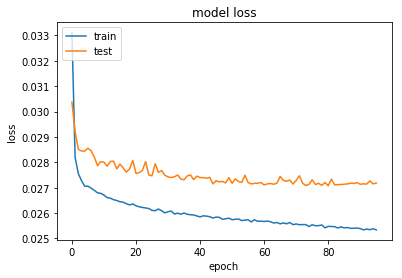

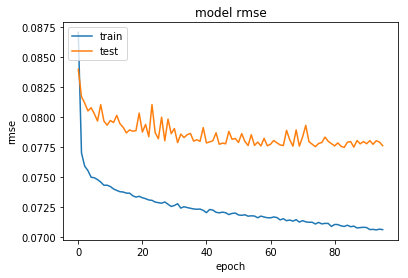

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
def get_mae(Y1, Y2):
   return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)

In [16]:
model.load_weights(experiment_name+'.hdf5')

In [17]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_seq2seq_teacher_forcing(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )

predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))

count = 0

start = time.time()
print("Evaluating validation data...")

for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #print(len(encoder_input))
    #input_seq = encoder_input[seq_index: seq_index + 1]
    Y_pred_diff = decode_sequence(encoder_input)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]

    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)
    
    #print(Y_pred.shape)
    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[: ,ind_delay]
        Y_delay_val = Y_val_abs[: ,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating validation data...


Evaluation Time :  149.7468159198761 s =  2.495780277252197 min =  0.04159633808665805 h


## Evaluate performance on validation data to improve model

## Evaluate metrics

In [18]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.06252173897720989
Delay 100 ms: 0.003840974197999364
Delay 200 ms: 0.012768736764997492
Delay 300 ms: 0.024744629088650827
Delay 400 ms: 0.038295304135034645
Delay 500 ms: 0.05272601002817752
Delay 600 ms: 0.06772276361547892
Delay 700 ms: 0.08304368256699322
Delay 800 ms: 0.09853582203531594
Delay 900 ms: 0.11404191660022035
Delay 1000 ms: 0.12949755073923044

RMSE
Average rmse: 0.1287109534425474
Delay 100 ms: 0.01087789671889251
Delay 200 ms: 0.027087818060744076
Delay 300 ms: 0.04819491434887662
Delay 400 ms: 0.07140319228003816
Delay 500 ms: 0.09541875336074052
Delay 600 ms: 0.11980873238487953
Delay 700 ms: 0.14425035755277588
Delay 800 ms: 0.16863015066281123
Delay 900 ms: 0.19282927956554657
Delay 1000 ms: 0.21674819729670525

SMAPE
Average smape: 14.782181958541823
Delay 100 ms: 2.090556145622987
Delay 200 ms: 5.3450160911796285
Delay 300 ms: 8.584687270366546
Delay 400 ms: 11.591141287463502
Delay 500 ms: 14.325689101025265
Delay 600 ms: 16.859426128218864


(6064, 25, 3) (6064, 10, 3)


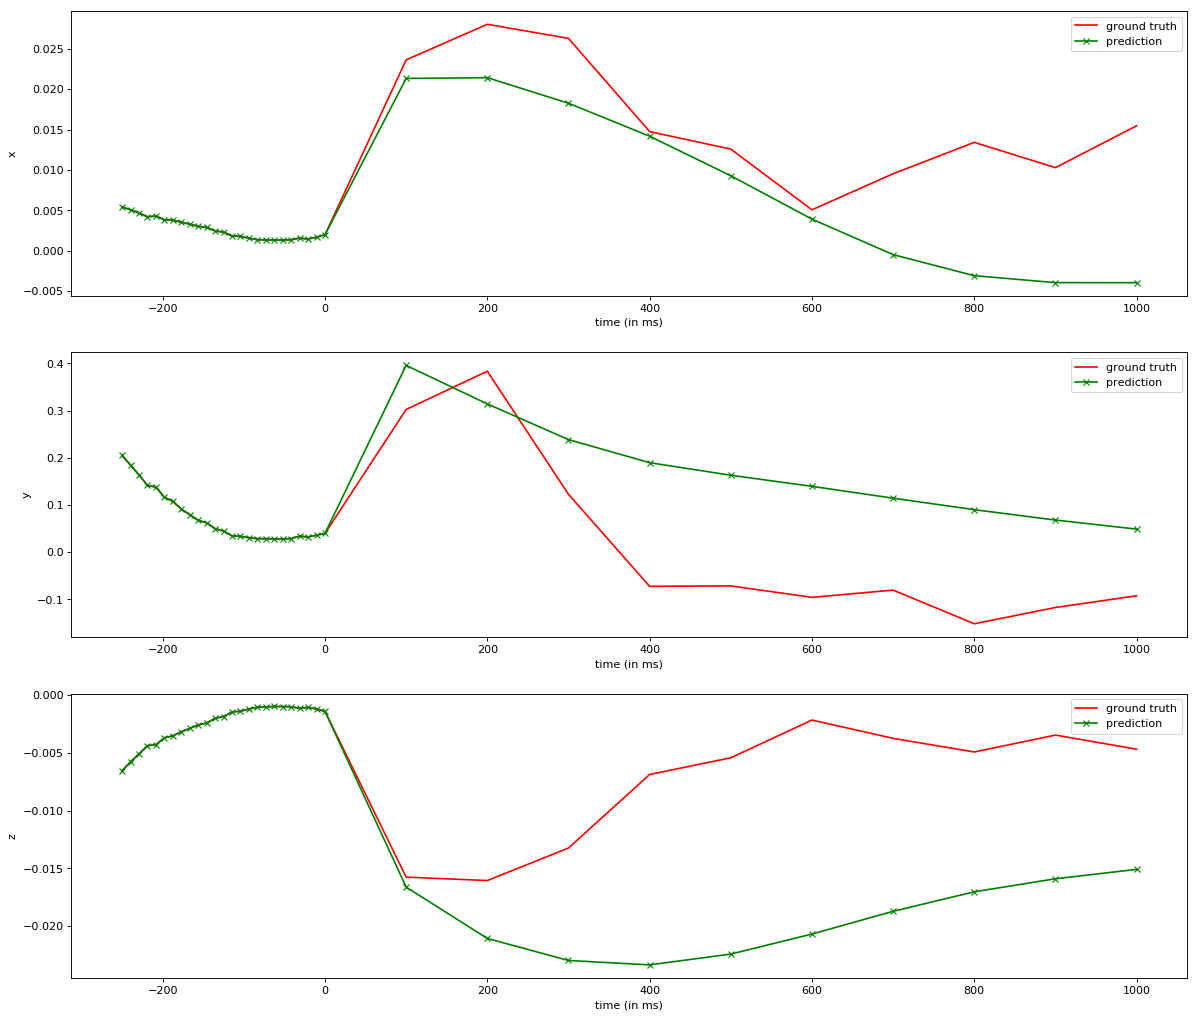

In [19]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)

Y_pred = decode_sequence(encoder_input)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')